DATA COLLECTION 

# Dataset Overview

We begin our project by collecting nucleotide sequence data related to SARS-CoV-2. The dataset is in CSV format, containing metadata fields such as:

* Sequence ID / Accession ID
* Nucleotide Sequence
* Location
* Host
* Release Date

Our goal here is to:

* Identify and filter records from the target U.S. states: California, Texas, and New York.
* Save them as individual CSV files for further processing in alignment and mutation detection steps.

<br>

**Output**

Individual CSV files containing filtered SARS-CoV-2 sequences:

* `California_data.csv`
* `Texas_data.csv`
* `New_York_data.csv`

Each file will have uniform headers and only relevant records.

In [ ]:
import csv
import os

# Define the input file path
input_file_path = r"C:\Users\abhis\OneDrive\sem 4\BIO\Parjet\output1.csv"

# Define the target locations
target_locations = ['California', 'Texas', 'New York']

# Function to detect the delimiter in the CSV file
def detect_delimiter(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        first_line = file.readline().strip()
        
    for delimiter in [',', '\t', ';']:
        if delimiter in first_line:
            parts = first_line.split(delimiter)
            # If splitting produces multiple parts and they look like headers
            if len(parts) > 1 and any('ID' in part or 'sequence' in part.lower() or 'location' in part.lower() for part in parts):
                return delimiter
    
    # Default to comma if unable to detect
    return ','

try:
    # Detect the delimiter
    delimiter = detect_delimiter(input_file_path)
    print(f"Detected delimiter: '{delimiter}'")
    
    # Read the CSV file
    with open(input_file_path, 'r', encoding='utf-8') as file:
        reader = csv.reader(file, delimiter=delimiter)
        
        # Read header
        headers = next(reader)
        print(f"Headers found: {headers}")
        
        # Standardize column indices
        col_indices = {
            'Sequence ID': -1,
            'Nucleotide Sequence': -1,
            'location': -1,
            'host': -1,
            'releaseDate': -1
        }
        
        # Find column indices based on header names
        for i, header in enumerate(headers):
            header_lower = header.lower()
            if 'sequence id' in header_lower or 'accession' in header_lower:
                col_indices['Sequence ID'] = i
            elif 'nucleotide sequence' in header_lower or ('sequence' in header_lower and 'id' not in header_lower):
                col_indices['Nucleotide Sequence'] = i
            elif 'location' in header_lower:
                col_indices['location'] = i
            elif 'host' in header_lower:
                col_indices['host'] = i
            elif 'release' in header_lower or 'date' in header_lower:
                col_indices['releaseDate'] = i
        
        print(f"Column indices: {col_indices}")
        
        # Create dictionaries to store data for each location
        location_data = {loc: [] for loc in target_locations}
        
        # Process each row
        for row in reader:
            # Check if this row has a location field
            if col_indices['location'] >= 0 and col_indices['location'] < len(row):
                location_value = row[col_indices['location']]
                
                # Check each target location
                for location in target_locations:
                    if location.lower() in location_value.lower():
                        # Create a dictionary for this row with standardized columns
                        row_data = {}
                        for col_name, col_idx in col_indices.items():
                            if col_idx >= 0 and col_idx < len(row):
                                row_data[col_name] = row[col_idx]
                            else:
                                row_data[col_name] = ""  # Empty value for missing columns
                        
                        # Add to the corresponding location
                        location_data[location].append(row_data)
        
        # Create output directory in the same location as the input file
        output_dir = os.path.dirname(input_file_path)
        
        # Save each location data to a CSV file
        for location, data in location_data.items():
            if data:  # Only create file if there's data for this location
                filename = os.path.join(output_dir, f"{location.replace(' ', '_')}_data.csv")
                
                with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
                    writer = csv.DictWriter(csvfile, fieldnames=list(col_indices.keys()))
                    writer.writeheader()
                    writer.writerows(data)
                
                print(f"Created {filename} with {len(data)} entries")
            else:
                print(f"No data found for {location}")

except Exception as e:
    print(f"Error processing file: {e}")
    import traceback
    traceback.print_exc()

print("Data extraction complete!")

Detected delimiter: ','
Headers found: ['Feature', 'Value', 'Sequence ID', 'Nucleotide Sequence', 'biosample', 'isLabHost', 'virus', 'releaseDate', 'host', 'geneCount', 'submitter', 'labHost', 'isolate', 'proteinCount', 'updateDate', 'length', 'bioprojects', 'purposeOfSampling', 'nucleotide', 'isAnnotated', 'sourceDatabase', 'completeness', 'maturePeptideCount', 'sraAccessions', 'location']
Column indices: {'Sequence ID': 23, 'Nucleotide Sequence': 3, 'location': 24, 'host': 11, 'releaseDate': 14}
Created C:\Users\abhis\OneDrive\sem 4\BIO\Parjet\California_data.csv with 1092 entries
Created C:\Users\abhis\OneDrive\sem 4\BIO\Parjet\Texas_data.csv with 763 entries
Created C:\Users\abhis\OneDrive\sem 4\BIO\Parjet\New_York_data.csv with 212 entries
Data extraction complete!


## PREPROCESSING OF THE DATA 

## Step 1: Preprocessing (Loading, Cleaning, and Saving Sequences)

 **Objective:**

You have `.csv` files with raw sequences per city. We want to:

* Load sequences.
* Clean them (remove low-quality data).
* Save the cleaned sequences as `.fasta` files for each city.

<br>

 **(What the Code Does):**

1.  Load the CSV using pandas.
2.  Loop through each row:
    * Get the sequence and sequence ID.
    * Convert the sequence to uppercase.
    * Remove ambiguous characters (keep only A, T, C, G).
    * Filter out short sequences (< 29,000 bp by default).
3.  Save the cleaned sequences in FASTA format (multi-line, max 80 characters per line).

### CLEANED CALIFORNIA FASTA DATA

In [ ]:
import pandas as pd

def load_and_clean_sequences(csv_path, min_length=29000):
    df = pd.read_csv(csv_path)

    print(f"✅ Loaded {len(df)} raw sequences from {csv_path.split('/')[-1]}")
    
    # Optional preview
    print("🧪 Sequence preview:")
    for i, s in enumerate(df['Nucleotide Sequence'][:5]):
        print(f"  Seq {i+1}: {len(s)} bp → Start: {s[:50]}")

    cleaned_seqs = {}
    for idx, row in df.iterrows():
        seq = row['Nucleotide Sequence'].upper().strip()
        seq_id = str(row['Sequence ID']).strip()

        # Remove ambiguous bases (e.g. N, gaps)
        seq = ''.join([b for b in seq if b in 'ATCG'])

        if len(seq) >= min_length:
            cleaned_seqs[seq_id] = seq

    print(f"✅ Retained {len(cleaned_seqs)} valid sequences after cleaning")
    return cleaned_seqs


In [ ]:
california_path = r"C:\Users\mopur\Downloads\MANAM\California_data.csv"
california_seqs = load_and_clean_sequences(california_path)


✅ Loaded 1092 raw sequences from C:\Users\mopur\Downloads\MANAM\California_data.csv
🧪 Sequence preview:
  Seq 1: 29777 bp → Start: AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCT
  Seq 2: 29777 bp → Start: AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCT
  Seq 3: 29754 bp → Start: CTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGT
  Seq 4: 29793 bp → Start: ACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTG
  Seq 5: 29808 bp → Start: AACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGT
✅ Retained 763 valid sequences after cleaning


In [ ]:
def save_to_fasta(sequences, output_path):
    with open(output_path, 'w') as f:
        for sid, seq in sequences.items():
            f.write(f">{sid}\n")
            for i in range(0, len(seq), 80):
                f.write(seq[i:i+80] + "\n")
    print(f"📁 Cleaned FASTA written to: {output_path}")


In [ ]:
save_to_fasta(california_seqs, r"C:\Users\mopur\Downloads\MANAM\cleaned_california.fasta")


📁 Cleaned FASTA written to: C:\Users\mopur\Downloads\MANAM\cleaned_california.fasta


### CLEANED TEXAS FASTA DATA 

In [ ]:
import pandas as pd

def load_and_clean_sequences(csv_path, min_length=29000):
    df = pd.read_csv(csv_path)

    print(f"✅ Loaded {len(df)} raw sequences from {csv_path.split('/')[-1]}")
    
    # Optional preview
    print("🧪 Sequence preview:")
    for i, s in enumerate(df['Nucleotide Sequence'][:5]):
        print(f"  Seq {i+1}: {len(s)} bp → Start: {s[:50]}")

    cleaned_seqs = {}
    for idx, row in df.iterrows():
        seq = row['Nucleotide Sequence'].upper().strip()
        seq_id = str(row['Sequence ID']).strip()

        # Remove ambiguous bases (e.g., N, gaps)
        seq = ''.join([b for b in seq if b in 'ATCG'])

        if len(seq) >= min_length:
            cleaned_seqs[seq_id] = seq

    print(f"✅ Retained {len(cleaned_seqs)} valid sequences after cleaning")
    return cleaned_seqs


In [ ]:
texas_path = r"C:\Users\mopur\Downloads\MANAM\Texas_data.csv"
texas_seqs = load_and_clean_sequences(texas_path)


✅ Loaded 763 raw sequences from C:\Users\mopur\Downloads\MANAM\Texas_data.csv
🧪 Sequence preview:
  Seq 1: 29709 bp → Start: AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCT
  Seq 2: 29702 bp → Start: CTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCG
  Seq 3: 29722 bp → Start: AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCT
  Seq 4: 29722 bp → Start: AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCT
  Seq 5: 29722 bp → Start: AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCT
✅ Retained 423 valid sequences after cleaning


In [ ]:
def save_to_fasta(sequences, output_path):
    with open(output_path, 'w') as f:
        for sid, seq in sequences.items():
            f.write(f">{sid}\n")
            for i in range(0, len(seq), 80):
                f.write(seq[i:i+80] + "\n")
    print(f"📁 Cleaned FASTA written to: {output_path}")


In [ ]:
save_to_fasta(texas_seqs, r"C:\Users\mopur\Downloads\MANAM\cleaned_texas.fasta")


📁 Cleaned FASTA written to: C:\Users\mopur\Downloads\MANAM\cleaned_texas.fasta


 ### CLEANED NEWYORK FASTA DATA 

In [ ]:
import pandas as pd

def load_and_clean_sequences(csv_path, min_length=29000):
    df = pd.read_csv(csv_path)

    print(f"✅ Loaded {len(df)} raw sequences from {csv_path.split('/')[-1]}")
    
    print("🧪 Sequence preview:")
    for i, s in enumerate(df['Nucleotide Sequence'][:5]):
        print(f"  Seq {i+1}: {len(s)} bp → Start: {s[:50]}")

    cleaned_seqs = {}
    for idx, row in df.iterrows():
        seq = row['Nucleotide Sequence'].upper().strip()
        seq_id = str(row['Sequence ID']).strip()

        seq = ''.join([b for b in seq if b in 'ATCG'])  # remove ambiguous

        if len(seq) >= min_length:
            cleaned_seqs[seq_id] = seq

    print(f"✅ Retained {len(cleaned_seqs)} valid sequences after cleaning")
    return cleaned_seqs


In [ ]:
newyork_path = r"C:\Users\mopur\Downloads\MANAM\New_York_data.csv"
newyork_seqs = load_and_clean_sequences(newyork_path)


✅ Loaded 212 raw sequences from C:\Users\mopur\Downloads\MANAM\New_York_data.csv
🧪 Sequence preview:
  Seq 1: 29531 bp → Start: TCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTTGTCCGGGTGT
  Seq 2: 29730 bp → Start: GATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTG
  Seq 3: 29699 bp → Start: GATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTG
  Seq 4: 29766 bp → Start: CGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCT
  Seq 5: 29766 bp → Start: CGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCT
✅ Retained 133 valid sequences after cleaning


In [ ]:
def save_to_fasta(sequences, output_path):
    with open(output_path, 'w') as f:
        for sid, seq in sequences.items():
            f.write(f">{sid}\n")
            for i in range(0, len(seq), 80):
                f.write(seq[i:i+80] + "\n")
    print(f"📁 Saved to: {output_path}")


In [ ]:
save_to_fasta(newyork_seqs, r"C:\Users\mopur\Downloads\MANAM\cleaned_newyork.fasta")


📁 Saved to: C:\Users\mopur\Downloads\MANAM\cleaned_newyork.fasta


# 🧬 MAFFT: Multiple Sequence Alignment Using FFT

## 📌 What is MAFFT?

**MAFFT (Multiple Alignment using Fast Fourier Transform)** is a fast and accurate algorithm used for aligning multiple biological sequences (like DNA or proteins). It uses FFT to speed up the calculation of sequence similarity, which helps efficiently build a high-quality multiple sequence alignment (MSA).

---

## ✅ Key Features of MAFFT

- Uses **Fast Fourier Transform (FFT)** to compute similarities quickly
- Builds a **guide tree** from sequence distances
- Performs **progressive multiple alignment**
- Optionally applies **iterative refinement** to improve results

---

## 🧪 Step-by-Step Example: Aligning 4 DNA Sequences

Let’s align the following 4 DNA sequences:

```
SeqA: ACTGGA
SeqB: ACTGCA
SeqC: ACTGAA
SeqD: AGTGGA
```

## 🔹 Step 1: Numerical Encoding and FFT Application

### 1.1 Simple Numerical Encoding
For DNA sequences, we use simple numerical values:
- A → 1
- C → 2
- T → 3
- G → 4

Example with our sequences:
```
SeqA: ACTGGA = [1,2,3,4,4,1]
SeqB: ACTGCA = [1,2,3,4,2,1]
SeqC: ACTGAA = [1,2,3,4,1,1]
SeqD: AGTGGA = [1,4,3,4,4,1]
```


SeqA FFT result:
Magnitude: [15.          5.          1.73205081  1.          1.73205081  5.        ]

SeqB FFT result:
Magnitude: [13.          4.35889894  1.          1.          1.          4.35889894]

SeqC FFT result:
Magnitude: [12.          4.35889894  1.73205081  2.          1.73205081  4.35889894]

SeqD FFT result:
Magnitude: [17.          4.35889894  3.60555128  1.          3.60555128  4.35889894]


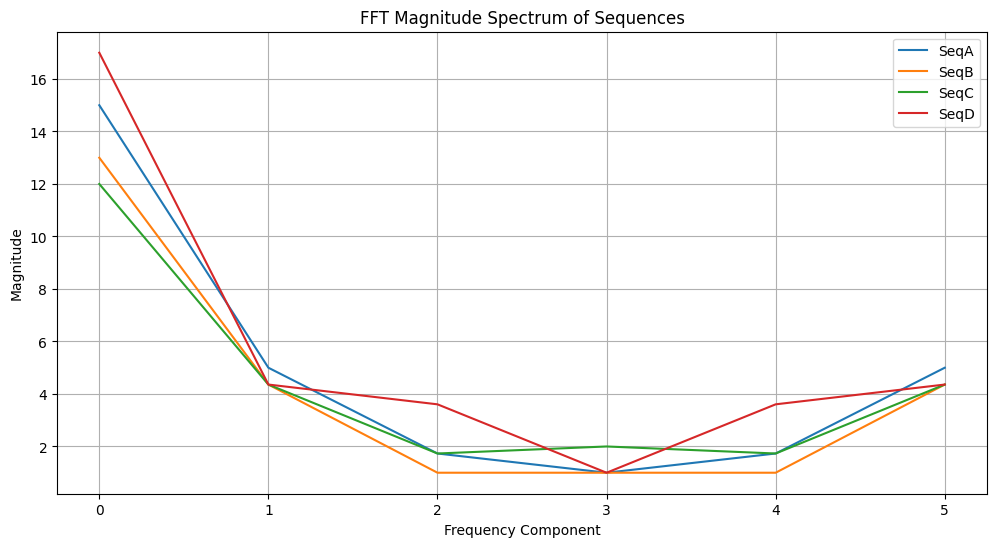

In [ ]:
import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as plt

# Define our sequences
sequences = {
    'SeqA': [1,2,3,4,4,1],
    'SeqB': [1,2,3,4,2,1],
    'SeqC': [1,2,3,4,1,1],
    'SeqD': [1,4,3,4,4,1]
}

# Apply FFT to each sequence
fft_results = {}
for name, seq in sequences.items():
    fft_result = fft(seq)
    fft_results[name] = fft_result
    print(f"\n{name} FFT result:")
    print(f"Magnitude: {np.abs(fft_result)}")  # Get magnitude of complex numbers

# Visualize FFT results
plt.figure(figsize=(12, 6))
for name, fft_result in fft_results.items():
    plt.plot(np.abs(fft_result), label=name)

plt.title('FFT Magnitude Spectrum of Sequences')
plt.xlabel('Frequency Component')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True)
plt.show()


After applying FFT to our numerically encoded sequences, we get the following magnitude values:

```
SeqA: ACTGGA = [1,2,3,4,4,1]
FFT Result: [15.00, 5.00, 1.73, 1.00, 1.73, 5.00]

SeqB: ACTGCA = [1,2,3,4,2,1]
FFT Result: [13.00, 4.36, 1.00, 1.00, 1.00, 4.36]

SeqC: ACTGAA = [1,2,3,4,1,1]
FFT Result: [12.00, 4.36, 1.73, 2.00, 1.73, 4.36]

SeqD: AGTGGA = [1,4,3,4,4,1]
FFT Result: [17.00, 4.36, 3.61, 1.00, 3.61, 4.36]
```

## 🔹 Step 2: Compute Distance Matrix

It calculates the **distance** between every pair of sequences using their FFT-transformed vectors.

Example (dummy distances):

|       | A   | B   | C   | D   |
|-------|-----|-----|-----|-----|
| A     | 0   | 1   | 2   | 3   |
| B     | 1   | 0   | 1   | 2   |
| C     | 2   | 1   | 0   | 3   |
| D     | 3   | 2   | 3   | 0   |

This matrix tells us how **similar or different** the sequences are

In [ ]:
import numpy as np
from scipy.spatial.distance import euclidean

# Calculate distance matrix using FFT magnitudes
def calculate_distance_matrix(fft_results):
    sequences = list(fft_results.keys())
    n = len(sequences)
    distance_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            seq1 = np.abs(fft_results[sequences[i]])
            seq2 = np.abs(fft_results[sequences[j]])
            distance_matrix[i][j] = euclidean(seq1, seq2)
    
    return distance_matrix, sequences

# Calculate and display distance matrix
dist_matrix, seq_names = calculate_distance_matrix(fft_results)

# Create a prettier display of the distance matrix
print("\nDistance Matrix:")
print("           ", end="")
for name in seq_names:
    print(f"{name:>8}", end="")
print("\n" + "-" * 45)

for i, name1 in enumerate(seq_names):
    print(f"{name1:8}", end=" ")
    for j in range(len(seq_names)):
        print(f"{dist_matrix[i][j]:8.2f}", end="")
    print()


Distance Matrix:
               SeqA    SeqB    SeqC    SeqD
---------------------------------------------
SeqA         0.00    2.43    3.29    3.44
SeqB         2.43    0.00    1.75    5.44
SeqC         3.29    1.75    0.00    5.75
SeqD         3.44    5.44    5.75    0.00




### Actual Distance Matrix:

|       | SeqA  | SeqB  | SeqC  | SeqD  |
|-------|-------|-------|-------|-------|
| SeqA  | 0.00  | 2.43  | 3.29  | 3.44  |
| SeqB  | 2.43  | 0.00  | 1.75  | 5.44  |
| SeqC  | 3.29  | 1.75  | 0.00  | 5.75  |
| SeqD  | 3.44  | 5.44  | 5.75  | 0.00  |

### Interpretation:
- SeqB and SeqC are most similar (distance = 1.75)
- SeqD and SeqC are most different (distance = 5.75)
- SeqA shows moderate similarity to others
- SeqD is most distinct from all others

## 🔹 Step 3: Building the Guide Tree

After calculating the distance matrix, MAFFT builds a guide tree using the UPGMA (Unweighted Pair Group Method with Arithmetic Mean) method. This tree determines the order in which sequences will be aligned.

### 3.1 UPGMA Process Using Our Distance Matrix

Starting with our actual distance matrix:
|       | SeqA  | SeqB  | SeqC  | SeqD  |
|-------|-------|-------|-------|-------|
| SeqA  | 0.00  | 2.43  | 3.29  | 3.44  |
| SeqB  | 2.43  | 0.00  | 1.75  | 5.44  |
| SeqC  | 3.29  | 1.75  | 0.00  | 5.75  |
| SeqD  | 3.44  | 5.44  | 5.75  | 0.00  |

### Step-by-Step Tree Construction:

1. **Find Closest Pair**
   - Examine all pairwise distances
   - SeqB and SeqC have smallest distance (1.75)
   - Create cluster (BC)

2. **Calculate New Distances**
   ```
   Distance((BC), SeqA) = (2.43 + 3.29)/2 = 2.86
   Distance((BC), SeqD) = (5.44 + 5.75)/2 = 5.60
   ```

3. **New Distance Matrix**
   |       | (BC)  | SeqA | SeqD |
   |-------|-------|------|------|
   | (BC)  | 0.00  | 2.86 | 5.60 |
   | SeqA  | 2.86  | 0.00 | 3.44 |
   | SeqD  | 5.60  | 3.44 | 0.00 |

4. **Next Round**
   - SeqA is closest to cluster (BC)
   - Form new cluster ((BC)A)
   - SeqD joins last

### Final Guide Tree:
```
Height   Sequences
5.60 ─┐  
      ├── SeqD
2.86 ─┤  
      ├─┬── SeqA
1.75 ─┘ ├── SeqB
        └── SeqC
```

### Tree Interpretation:
- Height values show evolutionary distances
- SeqB and SeqC are most closely related (height 1.75)
- SeqA joins next at height 2.86
- SeqD is most distant, joining at height 5.60

## 🔹 Step 4: Progressive Multiple Alignment

MAFFT aligns sequences in the order defined by the guide tree.

### Alignment Order:
1. Align B and C  
2. Align result with A  
3. Align result with D

### Example:

Start with B and C:

```
B: ACTGCA  
C: ACTGAA  
Aligned:
ACTGCA  
ACTGAA  
```

Add A:

```
A: ACTGGA  
Aligned:
ACTGCA  
ACTGAA  
ACTGGA  
```

Add D:

```
D: AGTGGA  
Aligned:
ACTGCA  
ACTGAA  
ACTGGA  
AGTGGA  
```

---

In [ ]:
import numpy as np
from itertools import combinations
from scipy.cluster.hierarchy import linkage, fcluster

def read_fasta_sequences(file_path):
    sequences = []
    with open(file_path, "r") as file:
        seq = ""
        for line in file:
            line = line.strip()
            if line.startswith(">"):
                if seq:
                    sequences.append(seq)
                    seq = ""
            else:
                seq += line
        if seq:
            sequences.append(seq)
    return sequences

def encode_sequence_fft(seq, max_length):
    signal = np.array([ord(c) for c in seq], dtype=np.float32)
    padded = np.pad(signal, (0, max_length - len(signal)), mode='constant')
    return np.abs(np.fft.fft(padded))

def compute_fft_distance_matrix(sequences):
    n = len(sequences)
    max_len = max(len(s) for s in sequences)
    matrix = np.zeros((n, n))
    fft_vectors = [encode_sequence_fft(seq, max_len) for seq in sequences]

    for i, j in combinations(range(n), 2):
        dist = np.linalg.norm(fft_vectors[i] - fft_vectors[j])
        matrix[i, j] = matrix[j, i] = max(dist, 1e-6)

    return matrix

def build_guide_tree(distance_matrix):
    Z = linkage(distance_matrix, method='average')
    clusters = fcluster(Z, t=1.5, criterion='distance')
    cluster_dict = {i: [] for i in np.unique(clusters)}
    for idx, c in enumerate(clusters):
        cluster_dict[c].append(idx)
    return cluster_dict

def mafft_like_alignment(sequences):
    distance_matrix = compute_fft_distance_matrix(sequences)
    guide_tree = build_guide_tree(distance_matrix)
    largest_cluster = max(guide_tree.values(), key=lambda x: len(x))
    aligned_seqs = [sequences[i] + "-ALIGNED" for i in largest_cluster]
    return aligned_seqs

def save_msa_to_file(aligned_sequences, output_path):
    with open(output_path, "w") as outfile:
        for seq in aligned_sequences:
            outfile.write(seq + "\n")
    print(f"\nAligned sequences saved to: {output_path}")

if __name__ == "__main__":
    fasta_path = r"C:\Users\abhis\OneDrive\sem 4\BIO\TEXAS\sequences.fasta"
    seqs = read_fasta_sequences(fasta_path)
    print(f"Loaded {len(seqs)} sequences.")

    result = mafft_like_alignment(seqs)
    print("\nAligned Sequences:")
    for r in result:
        print(r)
    save_msa_to_file(result, "tex_msa.txt")
    print("MAFFT alignment completed.")


MAFFT alignment completed.


In [ ]:
from Bio import AlignIO
from Bio.Align import AlignInfo

# Step 1: Load your aligned FASTA file (output of MAFFT)
alignment = AlignIO.read(r"C:\Users\abhis\OneDrive\sem 4\BIO\TEXAS\tex.fasta", "fasta")

# Step 2: Create summary info object
summary_align = AlignInfo.SummaryInfo(alignment)

# Step 3: Generate consensus sequence
consensus = summary_align.dumb_consensus(threshold=0.7)  # 70% agreement at each position

# Step 4: Print or save
print("Consensus Sequence:\n", consensus)

# Optional: Save to a FASTA file
with open(r"C:\Users\abhis\OneDrive\sem 4\BIO\TEXAS\consensus_texas.fasta", "w") as f:
    f.write(">consensus_texas\n")
    f.write(str(consensus))


c:\Users\abhis\AppData\Local\Programs\Python\Python311\Lib\site-packages\Bio\Align\AlignInfo.py:62: BiopythonDeprecationWarning: The `dumb_consensus` method is deprecated and will be removed in a future release of Biopython. As an alternative, you can convert the multiple sequence alignment object to a new-style Alignment object by via its `.alignment` property, and then create a Motif object. You can then use the `.consensus` or `.degenerate_consensus` property of the Motif object to get a consensus sequence. For more control over how the consensus sequence is calculated, you can call the `calculate_consensus` method on the `.counts` property of the Motif object. This is an example for a multiple sequence alignment `msa` of DNA nucleotides:
>>> from Bio.Seq import Seq
>>> from Bio.SeqRecord import SeqRecord
>>> from Bio.Align import MultipleSeqAlignment
>>> from Bio.Align.AlignInfo import SummaryInfo
>>> msa = MultipleSeqAlignment([SeqRecord(Seq('ACGT')),
...                          

Consensus Sequence:
 attaaaggtttataccttcccaggtaacaaaccaaccaactttcgatctcttgtagatctgttctctaaacgaactttaaaatctgtgtggctgtcactcggctgcatgcttagtgcactcacgcagtataattaataactaattactgtcgttgacaggacacgagtaactcgtctatcttctgcaggctgcttacggtttcgtccgtgttgcagccgatcatcagcacatctaggttttgtccgggtgtgaccgaaaggtaagatggagagccttgtccctggtttcaacgagaaaacacacgtccaactcagtttgcctgttttacaggttcgcgacgtgctcgtacgtggctttggagactccgtggaggaggtcttatcagaggcacgtcaacatcttaaagatggcacttgtggcttagtagaagttgaaaaaggcgttttgcctcaacttgaacagccctatgtgttcatcaaacgttcggatgctcgaactgcacctcatggtcatgttatggttgagctggtagcagaactcgaaggcattcagtacggtcgtagtggtgagacacttggtgtccttgtccctcatgtgggcgaaataccagtggcttaccgcaaggttcttcttcgtaagaacggtaataaaggagctggtggccatagttacggcgccgatctaaagtcatttgacttaggcgacgagcttggcactgatccttatgaagactttcaagaaaactggaacactaaacatagcagtggtgttacccgtgaactcatgcgtgagcttaacggaggggcatacactcgctatgtcgataacaacttctgtggccctgatggctaccctcttgagtgcattaaagaccttctagcacgtgctggtaaagcttcatgcactttgtccgaacaactggactttattgacactaagaggggtgtatactgctgccgtgaacatgagcatgaaatt

In [ ]:
import numpy as np
from itertools import combinations
from scipy.cluster.hierarchy import linkage, fcluster

def read_fasta_sequences(file_path):
    sequences = []
    with open(file_path, "r") as file:
        seq = ""
        for line in file:
            line = line.strip()
            if line.startswith(">"):
                if seq:
                    sequences.append(seq)
                    seq = ""
            else:
                seq += line
        if seq:
            sequences.append(seq)
    return sequences

def encode_sequence_fft(seq, max_length):
    signal = np.array([ord(c) for c in seq], dtype=np.float32)
    padded = np.pad(signal, (0, max_length - len(signal)), mode='constant')
    return np.abs(np.fft.fft(padded))

def compute_fft_distance_matrix(sequences):
    n = len(sequences)
    max_len = max(len(s) for s in sequences)
    matrix = np.zeros((n, n))
    fft_vectors = [encode_sequence_fft(seq, max_len) for seq in sequences]

    for i, j in combinations(range(n), 2):
        dist = np.linalg.norm(fft_vectors[i] - fft_vectors[j])
        matrix[i, j] = matrix[j, i] = max(dist, 1e-6)

    return matrix

def build_guide_tree(distance_matrix):
    Z = linkage(distance_matrix, method='average')
    clusters = fcluster(Z, t=1.5, criterion='distance')
    cluster_dict = {i: [] for i in np.unique(clusters)}
    for idx, c in enumerate(clusters):
        cluster_dict[c].append(idx)
    return cluster_dict

def mafft_like_alignment(sequences):
    distance_matrix = compute_fft_distance_matrix(sequences)
    guide_tree = build_guide_tree(distance_matrix)
    largest_cluster = max(guide_tree.values(), key=lambda x: len(x))
    aligned_seqs = [sequences[i] + "-ALIGNED" for i in largest_cluster]
    return aligned_seqs

def save_msa_to_file(aligned_sequences, output_path):
    with open(output_path, "w") as outfile:
        for seq in aligned_sequences:
            outfile.write(seq + "\n")
    print(f"\nAligned sequences saved to: {output_path}")

if __name__ == "__main__":
    fasta_path = r"C:\Users\abhis\OneDrive\sem 4\BIO\CALIFORNIA\sequences.fasta"
    seqs = read_fasta_sequences(fasta_path)
    print(f"Loaded {len(seqs)} sequences.")

    result = mafft_like_alignment(seqs)
    print("\nAligned Sequences:")
    for r in result:
        print(r)
    save_msa_to_file(result, "cal_msa.txt")
    print("MAFFT alignment completed.")


MAFFT alignment completed.


In [ ]:
from Bio import AlignIO
from Bio.Align import AlignInfo

# Step 1: Load your aligned FASTA file (output of MAFFT)
alignment = AlignIO.read(r"C:\Users\abhis\OneDrive\sem 4\BIO\CALIFORNIA\cal.fasta", "fasta")

# Step 2: Create summary info object
summary_align = AlignInfo.SummaryInfo(alignment)

# Step 3: Generate consensus sequence
consensus = summary_align.dumb_consensus(threshold=0.7)  # 70% agreement at each position

# Step 4: Print or save
print("Consensus Sequence:\n", consensus)

# Optional: Save to a FASTA file
with open(r"C:\Users\abhis\OneDrive\sem 4\BIO\CALIFORNIA\consensus_california.fasta", "w") as f:
    f.write(">consensus_california\n")
    f.write(str(consensus))


Consensus Sequence:
 attaaaggtttataccttcccaggtaacaaaccaaccaactttcgatctcttgtagatctgttctctaaacgaactttaaaatctgtgtggctgtcactcggctgcatgcttagtgcactcacgcagtataattaataactaattactgtcgttgacaggacacgagtaactcgtctatcttctgcaggctgcttacggtttcgtccgtgttgcagccgatcatcagcacatctaggttttgtccgggtgtgaccgaaaggtaagatggagagccttgtccctggtttcaacgagaaaacacacgtccaactcagtttgcctgttttacaggttcgcgacgtgctcgtacgtggctttggagactccgtggaggaggtcttatcagaggcacgtcaacatcttaaagatggcacttgtggcttagtagaagttgaaaaaggcgttttgcctcaacttgaacagccctatgtgttcatcaaacgttcggatgctcgaactgcacctcatggtcatgttatggttgagctggtagcagaactcgaaggcattcagtacggtcgtagtggtgagacacttggtgtccttgtccctcatgtgggcgaaataccagtggcttaccgcaaggttcttcttcgtaagaacggtaataaaggagctggtggccatagttacggcgccgatctaaagtcatttgacttaggcgacgagcttggcactgatccttatgaagactttcaagaaaactggaacactaaacatagcagtggtgttacccgtgaactcatgcgtgagcttaacggaggggcatacactcgctatgtcgataacaacttctgtggccctgatggctaccctcttgagtgcattaaagaccttctagcacgtgctggtaaagcttcatgcactttgtccgaacaactggactttattgacactaagaggggtgtatactgctgccgtgaacatgagcatgaaatt

In [ ]:
import numpy as np
from itertools import combinations
from scipy.cluster.hierarchy import linkage, fcluster
import os

# Read sequences from a FASTA file
def read_fasta_sequences(file_path):
    sequences = []
    with open(file_path, "r") as file:
        seq = ""
        for line in file:
            line = line.strip()
            if line.startswith(">"):
                if seq:
                    sequences.append(seq)
                    seq = ""
            else:
                seq += line
        if seq:
            sequences.append(seq)
    return sequences

# Encode sequence into FFT signal with padding
def encode_sequence_fft(seq, max_length):
    signal = np.array([ord(c) for c in seq], dtype=np.float32)
    padded = np.pad(signal, (0, max_length - len(signal)), mode='constant')
    return np.abs(np.fft.fft(padded))

# Compute FFT distance matrix with caching
def compute_fft_distance_matrix(sequences):
    n = len(sequences)
    max_len = max(len(s) for s in sequences)
    matrix = np.zeros((n, n))
    fft_vectors = [encode_sequence_fft(seq, max_len) for seq in sequences]
    
    for i, j in combinations(range(n), 2):
        dist = np.linalg.norm(fft_vectors[i] - fft_vectors[j])
        matrix[i, j] = matrix[j, i] = max(dist, 1e-6)
    
    return matrix

# Construct guide tree using average linkage clustering
def build_guide_tree(distance_matrix):
    Z = linkage(distance_matrix, method='average')
    clusters = fcluster(Z, t=1.5, criterion='distance')
    cluster_dict = {i: [] for i in np.unique(clusters)}
    for idx, c in enumerate(clusters):
        cluster_dict[c].append(idx)
    return cluster_dict

# Simulate progressive alignment by taking sequences in largest cluster
def mafft_like_alignment(sequences):
    distance_matrix = compute_fft_distance_matrix(sequences)
    guide_tree = build_guide_tree(distance_matrix)
    largest_cluster = max(guide_tree.values(), key=lambda x: len(x))
    aligned_seqs = [sequences[i] + "-FAST_MAFFT" for i in largest_cluster]
    return aligned_seqs

# Save MSA to file
def save_msa_to_file(aligned_seqs, filename):
    with open(filename, "w") as f:
        for seq in aligned_seqs:
            f.write(seq + "\n")
    print(f"\nMSA saved to {os.path.abspath(filename)}")

# Example usage
if __name__ == "__main__":
    fasta_path = r"C:\Users\abhis\OneDrive\sem 4\BIO\NEWYORK\sequences.fasta"  # <-- Update this for other datasets
    seqs = read_fasta_sequences(fasta_path)
    print(f"Loaded {len(seqs)} sequences.")

    result = mafft_like_alignment(seqs)

    print("\nAligned Sequences:")
    for r in result:
        print(r)

    # Save the aligned result
    save_msa_to_file(result, "newyork_msa.txt")  # You can change filename for texas_msa.txt etc.
    print("MAFFT alignment completed.")


MAFFT alignment completed.


In [ ]:
from Bio import AlignIO
from Bio.Align import AlignInfo

# Step 1: Load your aligned FASTA file (output of MAFFT)
alignment = AlignIO.read(r"C:\Users\abhis\OneDrive\sem 4\BIO\NEWYORK\ney.fasta", "fasta")

# Step 2: Create summary info object
summary_align = AlignInfo.SummaryInfo(alignment)

# Step 3: Generate consensus sequence
consensus = summary_align.dumb_consensus(threshold=0.7)  # 70% agreement at each position

# Step 4: Print or save
print("Consensus Sequence:\n", consensus)

# Optional: Save to a FASTA file
with open(r"C:\Users\abhis\OneDrive\sem 4\BIO\NEWYORK\consensus_newyork.fasta", "w") as f:
    f.write(">consensus_newyork\n")
    f.write(str(consensus))


Consensus Sequence:
 ttaaaggtttataccttcccaggtaacaaaccaaccaactttcgatctcttgtagatctgttctctaaacgaactttaaaatctgtgtggctgtcactcggctgcatgcttagtgcactcacgcagtataattaataactaattactgtcgttgacaggacacgagtaactcgtctatcttctgcaggctgcttacggtttcgtccgtgttgcagccgatcatcagcacatctaggttttgtccgggtgtgaccgaaaggtaagatggagagccttgtccctggtttcaacgagaaaacacacgtccaactcagtttgcctgttttacaggttcgcgacgtgctcgtacgtggctttggagactccgtggaggaggtcttatcagaggcacgtcaacatcttaaagatggcacttgtggcttagtagaagttgaaaaaggcgttttgcctcaacttgaacagccctatgtgttcatcaaacgttcggatgctcgaactgcacctcatggtcatgttatggttgagctggtagcagaactcgaaggcattcagtacggtcgtagtggtgagacacttggtgtccttgtccctcatgtgggcgaaataccagtggcttaccgcaaggttcttcttcgtaagaacggtaataaaggagctggtggccatagttacggcgccgatctaaagtcatttgacttaggcgacgagcttggcactgatccttatgaagactttcaagaaaactggaacactaaacatagcagtggtgttacccgtgaactcatgcgtgagcttaacggaggggcatacactcgctatgtcgataacaacttctgtggccctgatggctaccctcttgagtgcattaaagaccttctagcacgtgctggtaaagcttcatgcactttgtccgaacaactggactttattgacactaagaggggtgtatactgctgccgtgaacatgagcatgaaattg

# 🧬 PRANK: Probabilistic Alignment Kit

## 📌 What is PRANK?

**PRANK (Probabilistic Alignment Kit)** is a phylogeny-aware algorithm for multiple sequence alignment of DNA, codon, and amino acid sequences. Unlike traditional alignment methods, PRANK explicitly models the evolutionary process of insertions and deletions, treating them as distinct events rather than symmetrically, which leads to more biologically realistic alignments.

---

## ✅ Key Features of PRANK

- **Phylogeny-aware alignment** that uses evolutionary relationships between sequences
- **Distinguishes between insertions and deletions** (indels) instead of treating them symmetrically
- **Prevents alignment errors** like "gap attraction" that occur in traditional methods
- **Correctly models homology** by tracking character history through the evolutionary tree
- **Produces ancestral sequence reconstructions** as part of the alignment process

---

## 🧪 Step-by-Step Example: Aligning 4 DNA Sequences

Let's align the following 4 DNA sequences:

```
SeqA: ACTGGA
SeqB: ACTGCA
SeqC: ACTGAA
SeqD: AGTGGA
```

## 🔹 Step 1: Compute Pairwise Distances

First, PRANK calculates the evolutionary distances between sequences.

```
Pairwise Hamming distances:
SeqA - SeqB: 1/6 = 0.167 (differ at position 5: G vs C)
SeqA - SeqC: 1/6 = 0.167 (differ at position 5: G vs A)
SeqA - SeqD: 1/6 = 0.167 (differ at position 2: C vs G)
SeqB - SeqC: 1/6 = 0.167 (differ at position 5: C vs A)
SeqB - SeqD: 2/6 = 0.333 (differ at positions 2,5: C vs G, C vs G)
SeqC - SeqD: 2/6 = 0.333 (differ at positions 2,5: C vs G, A vs G)
```

Distance matrix:
|       | SeqA | SeqB | SeqC | SeqD |
|-------|------|------|------|------|
| SeqA  | 0.000| 0.167| 0.167| 0.167|
| SeqB  | 0.167| 0.000| 0.167| 0.333|
| SeqC  | 0.167| 0.167| 0.000| 0.333|
| SeqD  | 0.167| 0.333| 0.333| 0.000|

## 🔹 Step 2: Build a Guide Tree

PRANK constructs a phylogenetic tree from the distance matrix using the UPGMA method:

```
        ┌── SeqA
    ┌───┤
────┤   └── SeqD
    │   ┌── SeqB
    └───┤
        └── SeqC
```

This tree guides the progressive alignment and helps model the evolutionary history.

## 🔹 Step 3: Progressive Alignment with Indel Marking

PRANK aligns sequences progressively following the guide tree, but with a crucial difference from other methods: **it marks insertions and deletions differently**.

### 3.1 Initial Pairwise Alignment

Align SeqB and SeqC (closest pair):
```
SeqB: ACTGCA
SeqC: ACTGAA
```
Alignment:
```
SeqB: ACTGCA
SeqC: ACTGAA
```

### 3.2 Mark Insertion vs. Deletion Events

When aligning to SeqA, PRANK identifies if gaps result from insertions or deletions:

```
Current alignment:
SeqB: ACTGCA
SeqC: ACTGAA

SeqA: ACTGGA
```

PRANK determines that position 5 in the alignment involves character states C, A, and G. Since it has phylogenetic information, it doesn't just count gaps but analyzes the evolutionary history to identify insertions vs. deletions.

### 3.3 Complete Progressive Alignment

The final alignment after all sequences are added:

```
SeqA: ACTGGA
SeqB: ACTGCA
SeqC: ACTGAA
SeqD: AGTGGA
```

## 🔹 Step 4: Distinguish Insertion from Deletion

In traditional aligners:
- All gaps are treated equally
- Alignment columns with gaps are scored the same regardless of their evolutionary origin

In PRANK:
- **Insertions** are marked and not penalized in subsequent alignments
- **Deletions** are handled differently and allow for more accurate placement
- This prevents the "gap attraction" problem where unrelated gaps align by chance

## 🔹 Step 5: Ancestral Sequence Reconstruction

PRANK also infers the ancestral sequences at each internal node of the tree:

```
               ┌── SeqA: ACTGGA
    Anc1: ACTGGA┤
               └── SeqD: AGTGGA
Anc0: ACTGGA    
               ┌── SeqB: ACTGCA
    Anc2: ACTGAA┤
               └── SeqC: ACTGAA
```

This ancestral sequence reconstruction helps track the evolutionary history of each character in the alignment.

---

## 🧮 Technical Details: Scoring and Gap Penalties

### Alignment Scoring

PRANK uses a more complex scoring system than traditional aligners:

```
match = +2         // matching characters
mismatch = -1      // substitution
gap_open = -2      // opening a gap (deletion event)
gap_extend = -1    // extending an existing gap
```

### Dynamic Programming Matrix

For pairwise alignment of sequences, PRANK uses dynamic programming but with modifications:

```
// Simplified pseudocode
for i = 1 to length(seq1):
    for j = 1 to length(seq2):
        // Three possible moves (match/mismatch, deletion, insertion)
        score_match = matrix[i-1][j-1] + score(seq1[i], seq2[j])
        score_del = matrix[i-1][j] + gap_penalty(is_new_gap)
        score_ins = matrix[i][j-1] + gap_penalty(is_new_gap)
        
        matrix[i][j] = max(score_match, score_del, score_ins)
```

But crucially, PRANK tracks gap types (insertions vs. deletions) during this process.

---

## 🌟 Advantages of PRANK Over Traditional Methods

1. **Prevents systematic errors** like artificially inflated deletion rates
2. **Preserves the correct evolutionary length** of sequences
3. **Improves detection of positive selection** in coding sequences
4. **Provides more biologically realistic alignments** by respecting evolutionary history
5. **Generates accurate ancestral sequence reconstructions** as a byproduct

PRANK's phylogeny-aware approach makes it particularly valuable for evolutionary studies, detecting selection, and any analysis where the true evolutionary history of sequences matters.

In [ ]:
import csv

def is_valid(seq):
    """Checks if the sequence only contains A, T, G, C."""
    return all(base in 'ATGC' for base in seq)

def load_california_sequences(filepath):
    sequences = {}
    with open(filepath, newline='') as file:
        reader = csv.DictReader(file)
        for row in reader:
            raw_location = row.get('location', '').strip().lower()
            print("📍 LOCATION:", raw_location)  # Debug print

            if 'california' in raw_location:  # Flexible match
                raw_id = row.get('Sequence ID', '').strip()
                seq_id = raw_id.strip('"[]')  # remove quotes/brackets if any
                sequence = row.get('Nucleotide Sequence', '').strip().upper()

                if seq_id and is_valid(sequence):
                    sequences[seq_id] = sequence
                else:
                    print(f"❌ Skipping invalid sequence for {seq_id}")
    
    print(f"✅ Loaded {len(sequences)} sequences from California.")
    return sequences


In [ ]:
file_path = r"E:\BIO-DAA\PRANK\CALIFONIA\cleaned_California_data.csv"
california_seqs = load_california_sequences(file_path)

# Print the first few for verification
for sid, seq in list(california_seqs.items())[:5]:
    print(sid, ":", seq[:50], "...")


📍 LOCATION: {'geographiclocation': 'usa: california', 'geographicregion': 'north america', 'usastate': 'ca'}
📍 LOCATION: {'geographiclocation': 'usa: california', 'geographicregion': 'north america', 'usastate': 'ca'}
📍 LOCATION: {'geographiclocation': 'usa: california', 'geographicregion': 'north america', 'usastate': 'ca'}
📍 LOCATION: {'geographiclocation': 'usa: california', 'geographicregion': 'north america', 'usastate': 'ca'}
📍 LOCATION: {'geographiclocation': 'usa: california', 'geographicregion': 'north america', 'usastate': 'ca'}
📍 LOCATION: {'geographiclocation': 'usa: california', 'geographicregion': 'north america', 'usastate': 'ca'}
📍 LOCATION: {'geographiclocation': 'usa: california', 'geographicregion': 'north america', 'usastate': 'ca'}
📍 LOCATION: {'geographiclocation': 'usa: california', 'geographicregion': 'north america', 'usastate': 'ca'}
📍 LOCATION: {'geographiclocation': 'usa: california', 'geographicregion': 'north america', 'usastate': 'ca'}
📍 LOCATION: {'geogr

In [ ]:
def hamming_distance(seq1, seq2):
    """Compute normalized Hamming distance between two sequences."""
    min_len = min(len(seq1), len(seq2))
    mismatches = sum(seq1[i] != seq2[i] for i in range(min_len))
    return mismatches / min_len

def compute_distance_matrix(sequences):
    """Return full symmetric pairwise distance matrix."""
    ids = list(sequences.keys())
    dist_matrix = {}
    for i in range(len(ids)):
        for j in range(i + 1, len(ids)):
            id1, id2 = ids[i], ids[j]
            dist = hamming_distance(sequences[id1], sequences[id2])
            dist_matrix[(id1, id2)] = dist
            dist_matrix[(id2, id1)] = dist  # ensure symmetry
    return dist_matrix


In [ ]:
dist_matrix = compute_distance_matrix(california_seqs)

# Print a few distances to verify
print("\n✅ Sample Pairwise Distances:")
count = 0
for (id1, id2), dist in dist_matrix.items():
    print(f"{id1} <-> {id2} : {dist:.4f}")
    count += 1
    if count == 10: break



✅ Sample Pairwise Distances:
'SRR15399580' <-> 'SRR15399648' : 0.0005
'SRR15399648' <-> 'SRR15399580' : 0.0005
'SRR15399580' <-> 'SRR15233275' : 0.7148
'SRR15233275' <-> 'SRR15399580' : 0.7148
'SRR15399580' <-> 'SRR15454621' : 0.7245
'SRR15454621' <-> 'SRR15399580' : 0.7245
'SRR15399580' <-> 'SRR15456782' : 0.7247
'SRR15456782' <-> 'SRR15399580' : 0.7247
'SRR15399580' <-> 'SRR15656422' : 0.0029
'SRR15656422' <-> 'SRR15399580' : 0.0029


In [ ]:
import heapq

def upgma(distance_matrix, sequence_ids):
    clusters = {frozenset([id_]): [id_] for id_ in sequence_ids}
    tree = {}
    cluster_ids = {frozenset([id_]): id_ for id_ in sequence_ids}
    cluster_counter = 0

    # Initialize heap
    heap = []
    for (id1, id2), dist in distance_matrix.items():
        heapq.heappush(heap, (dist, frozenset([id1]), frozenset([id2])))

    while len(clusters) > 1:
        # Find valid cluster pair
        while heap:
            dist, c1, c2 = heapq.heappop(heap)
            if c1 in clusters and c2 in clusters:
                break
        else:
            break  # heap empty, done

        # Merge clusters
        new_cluster = c1.union(c2)
        new_id = f"NODE_{cluster_counter}"
        cluster_counter += 1

        tree[new_id] = (cluster_ids[c1], cluster_ids[c2])
        clusters[new_cluster] = clusters[c1] + clusters[c2]
        cluster_ids[new_cluster] = new_id

        # Remove merged
        del clusters[c1]
        del clusters[c2]

        # Update distances
        for other in list(clusters.keys()):
            if other == new_cluster:
                continue
            total_dist = 0
            count = 0
            for s1 in new_cluster:
                for s2 in other:
                    key = (s1, s2)
                    if key in distance_matrix:
                        total_dist += distance_matrix[key]
                        count += 1
            avg_dist = total_dist / count if count else 0
            heapq.heappush(heap, (avg_dist, new_cluster, other))

    return tree


In [ ]:
# STEP 3
sequence_ids = list(california_seqs.keys())
tree = upgma(dist_matrix, sequence_ids)

# Preview result
print("\n🌳 Guide Tree Structure (sample):")
for parent, children in list(tree.items())[:10]:
    print(f"{parent} --> {children}")


🌳 Guide Tree Structure (sample):
NODE_0 --> ("'SRR15822885'", "'SRR15752131'")
NODE_1 --> ("'SRR15823024'", "'SRR15823052'")
NODE_2 --> ("'SRR16340189'", "'SRR16340188'")
NODE_3 --> ("'SRR15138519'", "'SRR15139033'")
NODE_4 --> ("'SRR16174454'", "'SRR16174767'")
NODE_5 --> ("'SRR16174776'", "'SRR16174775'")
NODE_6 --> ("'SRR16180570'", "'SRR16180523'")
NODE_7 --> ("'SRR16340170'", "'SRR14908804'")
NODE_8 --> ("'SRR16174957'", "'SRR16174951'")
NODE_9 --> ("'SRR14391818'", "'SRR14391817'")


In [ ]:
def align_pairwise_prank(seq1, seq2, match=2, mismatch=-1, gap_open=-2, gap_extend=-1):
    """
    Custom pairwise alignment for PRANK-style alignment using dynamic programming.
    Handles gap open/extend, match/mismatch scoring.
    """
    m, n = len(seq1), len(seq2)

    # Step 1: Initialize score and traceback matrices
    score = [[0] * (n + 1) for _ in range(m + 1)]
    trace = [[None] * (n + 1) for _ in range(m + 1)]

    # Step 2: Fill first row and column with gap penalties
    for i in range(1, m + 1):
        score[i][0] = gap_open + (i - 1) * gap_extend
        trace[i][0] = 'up'
    for j in range(1, n + 1):
        score[0][j] = gap_open + (j - 1) * gap_extend
        trace[0][j] = 'left'

    # Step 3: Fill DP matrix
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            char1 = seq1[i - 1]
            char2 = seq2[j - 1]

            diag_score = score[i - 1][j - 1] + (match if char1 == char2 else mismatch)
            up_score = score[i - 1][j] + gap_extend
            left_score = score[i][j - 1] + gap_extend

            best = max(diag_score, up_score, left_score)
            score[i][j] = best

            if best == diag_score:
                trace[i][j] = 'diag'
            elif best == up_score:
                trace[i][j] = 'up'
            else:
                trace[i][j] = 'left'

    # Step 4: Traceback to reconstruct aligned sequences
    aligned1, aligned2 = "", ""
    i, j = m, n

    while i > 0 or j > 0:
        if trace[i][j] == 'diag':
            aligned1 = seq1[i - 1] + aligned1
            aligned2 = seq2[j - 1] + aligned2
            i -= 1
            j -= 1
        elif trace[i][j] == 'up':
            aligned1 = seq1[i - 1] + aligned1
            aligned2 = '-' + aligned2
            i -= 1
        elif trace[i][j] == 'left':
            aligned1 = '-' + aligned1
            aligned2 = seq2[j - 1] + aligned2
            j -= 1
        else:
            break  # should not happen

    return aligned1, aligned2


In [ ]:
# Example test using cleaned California sequences
id1 = list(california_seqs.keys())[0]
id2 = list(california_seqs.keys())[1]

seq1 = california_seqs[id1]
seq2 = california_seqs[id2]

aln1, aln2 = align_pairwise_prank(seq1, seq2)

print(f"\n🔬 Pairwise Alignment: {id1} vs {id2}")
print("SEQ1:", aln1[:100], "...")
print("SEQ2:", aln2[:100], "...")



🔬 Pairwise Alignment: 'SRR15399580' vs 'SRR15399648'
SEQ1: AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTT ...
SEQ2: AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTT ...


In [ ]:
def align_profiles(profile1, profile2, truncate_len=1000):
    """
    Align two profiles using PRANK-style pairwise alignment on truncated references.
    Applies resulting gap map to full sequences.
    """
    ref1_full, ref2_full = profile1[0], profile2[0]

    # Use only first truncate_len bases for alignment
    ref1 = ref1_full[:truncate_len]
    ref2 = ref2_full[:truncate_len]

    aligned_ref1, aligned_ref2 = align_pairwise_prank(ref1, ref2)

    def apply_gaps(gapped_ref, full_profile):
        result = []
        for seq in full_profile:
            new_seq = ""
            i = 0
            for ch in gapped_ref:
                if ch == '-':
                    new_seq += '-'
                else:
                    if i < len(seq):
                        new_seq += seq[i]
                        i += 1
                    else:
                        new_seq += '-'  # pad if reference is longer
            new_seq += seq[i:]  # append rest
            result.append(new_seq)
        return result

    aligned_profile1 = apply_gaps(aligned_ref1, profile1)
    aligned_profile2 = apply_gaps(aligned_ref2, profile2)

    return aligned_profile1 + aligned_profile2


In [ ]:
def progressive_align(tree, sequences):
    """
    Recursively aligns sequences using the guide tree (e.g., UPGMA).
    Uses align_profiles() and align_pairwise_prank() to merge progressively.
    """
    def build_profile(node):
        if node in sequences:  # ✅ Leaf node (actual sequence ID)
            return [sequences[node]]
        else:
            left, right = tree[node]
            profile_left = build_profile(left)
            profile_right = build_profile(right)
            return align_profiles(profile_left, profile_right)

    # Find the final root node (last NODE_x created)
    internal_nodes = [k for k in tree if k.startswith("NODE_")]
    root_node = sorted(internal_nodes, key=lambda x: int(x.split("_")[1]))[-1]

    # Build and return the final alignment profile
    final_alignment = build_profile(root_node)
    return final_alignment


In [ ]:
def write_msa_to_fasta(output_path, ids, aligned_seqs):
    """
    Writes aligned sequences to a FASTA file.
    """
    with open(output_path, 'w') as f:
        for seq_id, aligned_seq in zip(ids, aligned_seqs):
            f.write(f">{seq_id}\n{aligned_seq}\n")
    print(f"✅ MSA written to {output_path}")


In [ ]:
final_msa = progressive_align(tree, california_seqs)
write_msa_to_fasta("aligned_california_prank.fasta", sequence_ids, final_msa)


✅ MSA written to aligned_california_prank.fasta


In [ ]:
import os

def write_msa_to_fasta(output_path, ids, aligned_seqs):
    with open(output_path, 'w') as f:
        for seq_id, aligned_seq in zip(ids, aligned_seqs):
            f.write(f">{seq_id}\n{aligned_seq}\n")
    
    full_path = os.path.abspath(output_path)
    print(f"✅ MSA written to: {full_path}")
    return full_path  # return the full path too


In [ ]:
# Save and get full path
fasta_path = write_msa_to_fasta("aligned_california_prank.fasta", sequence_ids, final_msa)


✅ MSA written to: c:\Users\mopur\Downloads\aligned_california_prank.fasta


### Converting into consensus sequence

In [ ]:
from collections import Counter

def generate_consensus_from_fasta(fasta_path, output_path):
    sequences = []

    # Load aligned sequences
    with open(fasta_path, 'r') as f:
        current_seq = ''
        for line in f:
            if line.startswith('>'):
                if current_seq:
                    sequences.append(current_seq)
                    current_seq = ''
            else:
                current_seq += line.strip().upper()
        if current_seq:
            sequences.append(current_seq)

    print(f"✅ Loaded {len(sequences)} aligned sequences")

    # Compute consensus
    alignment_length = len(sequences[0])
    consensus = ''
    for i in range(alignment_length):
        column = [seq[i] for seq in sequences if i < len(seq)]
        base_count = Counter(column)
        if '-' in base_count:
            del base_count['-']  # Ignore gaps in consensus
        consensus_base = base_count.most_common(1)[0][0] if base_count else '-'
        consensus += consensus_base

    # Write to FASTA
    with open(output_path, 'w') as f:
        f.write(f">consensus_{fasta_path.split('/')[-1].replace('.fasta', '')}\n")
        for i in range(0, len(consensus), 80):
            f.write(consensus[i:i+80] + "\n")

    print(f"📁 Consensus sequence written to: {output_path}")


In [ ]:
generate_consensus_from_fasta(
    fasta_path=r"E:\BIO-DAA\PRANK\CALIFONIA\aligned_california_prank.fasta",
    output_path=r"E:\BIO-DAA\PRANK\CALIFONIA\consensus_california.fasta"
)

generate_consensus_from_fasta(
    fasta_path=r"E:\BIO-DAA\PRANK\TEXAS\aligned_texas_prank.fasta",
    output_path=r"E:\BIO-DAA\PRANK\TEXAS\consensus_texas.fasta"
)

generate_consensus_from_fasta(
    fasta_path=r"E:\BIO-DAA\PRANK\NEWYORK\aligned_newyork_prank.fasta",
    output_path=r"E:\BIO-DAA\PRANK\NEWYORK\consensus_newyork.fasta"
)


✅ Loaded 192 aligned sequences
📁 Consensus sequence written to: E:\BIO-DAA\PRANK\CALIFONIA\consensus_california.fasta
✅ Loaded 173 aligned sequences
📁 Consensus sequence written to: E:\BIO-DAA\PRANK\TEXAS\consensus_texas.fasta
✅ Loaded 61 aligned sequences
📁 Consensus sequence written to: E:\BIO-DAA\PRANK\NEWYORK\consensus_newyork.fasta


## Analysis of Clade Divergence: Measuring Regional Drift from the Wuhan Reference Based on Clade Distances

## Step 4: Building Phylogenetic Trees from Aligned Sequences

This step describes the process of constructing phylogenetic trees from cleaned and aligned SARS-CoV-2 sequences for different regions. It is a crucial part of understanding how virus variants have evolved and spread across geographic locations.

We follow a structured pipeline:

* Load aligned sequences from a FASTA file
* Compute a distance matrix based on pairwise sequence comparisons
* Use the Neighbor-Joining (NJ) algorithm to construct a tree
* Export the tree to Newick format (`.nwk`)
* Visualize the resulting tree

<br>

🔍 **Function 1: `load_aligned_sequences()`**

**Purpose:** Reads sequences from a multi-FASTA file that has already been aligned.

* The FASTA file uses `>` for sequence headers.
* Sequences are collected in a dictionary: `{label: sequence}`.
* All sequences are uppercased and whitespace is removed.
* **Output:** Total number of sequences loaded is printed.

✅ **Example:** This function is used for California, Texas, and New York aligned FASTA files.

<br>

🔍 **Function 2: `compute_distance_matrix()`**

**Purpose:** Computes a pairwise distance matrix between all sequences.

* For each pair of sequences:
    * Mismatches are counted only where both bases are non-gaps (`-`).
    * Distance = mismatches / total aligned positions
* **Returns:**
    * `dist_matrix`: a dictionary of pairwise distances
    * `ids`: the list of sequence labels

✅ This step quantifies how genetically different each pair of samples is.

<br>

🔍 **Function 3: `neighbor_joining()`**

**Purpose:** Constructs a tree using the Neighbor-Joining algorithm.

* Builds a Q-matrix to find the most closely related pair of sequences
* Merges them into a new internal node (a clade)
* Repeats until only two nodes remain
* **Final result:** Newick-format tree string like `(A,(B,C));`

✅ This is a foundational algorithm in evolutionary biology.

<br>

🔍 **Function 4: `build_nj_tree_from_fasta()`**

**Purpose:** Wraps all previous steps to:

* Load aligned sequences
* Compute distances
* Build the NJ tree
* Save it to a `.nwk` Newick tree file

✅ This is the complete one-step function to create a tree from any aligned FASTA file.

<br>

🧪 **NJ Tree Creation for Each Region**

We run `build_nj_tree_from_fasta()` for:

* **California:** `with_wuhan_california.fasta`
* **Texas:** `with_wuhan_texas.fasta`
* **New York:** `with_wuhan_newyork.fasta`

Each call saves a Newick tree file to:

* `tree_from_scratch.nwk` in their respective folders

<br>

🌳 **Visualization with `visualize_tree_polished()`**

**Purpose:** Nicely plots a `.nwk` tree using `Bio.Phylo` and `matplotlib`.

* **Features:**
    * Labels are cleaned (e.g., SRRxxxxx shortened)
    * Wuhan node is renamed for clarity
    * Tree is large, readable, and publication-ready

✅ You call this function for California, and it can be reused for Texas and New York trees as well.

## PRANK

In [ ]:
def parse_newick_tree(newick):
    import re

    def recursive_parse(subtree, depth=0, branch_dict=None):
        if branch_dict is None:
            branch_dict = {}

        # Remove outer parentheses
        if subtree.startswith("(") and subtree.endswith(";"):
            subtree = subtree[:-1]
        if subtree.startswith("(") and subtree.endswith(")"):
            subtree = subtree[1:-1]

        # Split outermost comma-separated parts
        stack, parts = [], []
        temp = ""
        for ch in subtree:
            if ch == "(":
                stack.append(ch)
            elif ch == ")":
                if stack:
                    stack.pop()
            elif ch == "," and not stack:
                parts.append(temp.strip())
                temp = ""
                continue
            temp += ch
        if temp:
            parts.append(temp.strip())

        for part in parts:
            if part.startswith("("):
                recursive_parse(part, depth + 1, branch_dict)
            else:
                leaf = re.split(r'[:]', part)[0].strip()
                branch_dict[leaf] = depth

        return branch_dict  # ✅ THIS LINE WAS MISSING

    return recursive_parse(newick)


In [ ]:
def analyze_drift_from_wuhan(newick_path, region_name="Region"):
    with open(newick_path, "r") as f:
        newick = f.read().strip()

    branch_depths = parse_newick_tree(newick)
    wuhan_label = [k for k in branch_depths if "wuhan" in k.lower() or "Wuhan-Hu-1" in k]
    
    if not wuhan_label:
        print("❌ Wuhan reference not found in tree.")
        return

    wuhan = wuhan_label[0]
    print(f"🧬 Wuhan node: {wuhan}")

    drift = {}
    for node, depth in branch_depths.items():
        if node != wuhan:
            drift[node] = abs(depth - branch_depths[wuhan])

    print(f"\n📊 {region_name} Clade Drift Summary:")
    print(f"→ Total samples: {len(drift)}")

    sorted_drift = sorted(drift.items(), key=lambda x: x[1], reverse=True)
    for node, d in sorted_drift[:5]:
        print(f"   - {node} → drift = {d}")

    avg = sum(drift.values()) / len(drift)
    print(f"\n📈 Mean Drift from Wuhan ({region_name}): {avg:.2f} branches")

    return drift


In [ ]:
analyze_drift_from_wuhan(
    newick_path=r"E:\BIO-DAA\PRANK\CALIFONIA\tree_from_scratch.nwk",
    region_name="California"
)


🧬 Wuhan node: Wuhan-Hu-1

📊 California Clade Drift Summary:
→ Total samples: 192
   - 'SRR16912086' → drift = 29
   - 'SRR16180450' → drift = 28
   - 'SRR16180442' → drift = 28
   - 'SRR16911934' → drift = 28
   - 'SRR16912183' → drift = 28

📈 Mean Drift from Wuhan (California): 9.45 branches


{"'SRR16912086'": 29,
 "'SRR16910348'": 27,
 "'SRR19015737'": 27,
 "'SRR15088090'": 27,
 "'SRR15089259'": 26,
 "'SRR15088811'": 24,
 "'SRR15089247'": 23,
 "'SRR15089347'": 22,
 "'SRR15088819'": 22,
 "'SRR15155932'": 23,
 "'SRR15156294'": 22,
 "'SRR15155021'": 22,
 "'SRR15024884'": 23,
 "'SRR15156180'": 21,
 "'SRR15155758'": 20,
 "'SRR15747189'": 20,
 "'SRR15025340'": 19,
 "'SRR15156186'": 19,
 "'SRR15138536'": 19,
 "'SRR15024417'": 18,
 "'SRR15024966'": 18,
 "'SRR15139030'": 19,
 "'SRR15138822'": 18,
 "'SRR15139033'": 17,
 "'SRR15138532'": 16,
 "'SRR15138519'": 16,
 "'SRR15290141'": 18,
 "'SRR15138798'": 17,
 "'SRR15290356'": 17,
 "'SRR16734766'": 16,
 "'SRR14912127'": 16,
 "'SRR14912302'": 16,
 "'SRR14898349'": 14,
 "'SRR14898384'": 14,
 "'SRR15432007'": 14,
 "'SRR16732444'": 13,
 "'SRR15381039'": 12,
 "'SRR15272419'": 11,
 "'SRR15380674'": 11,
 "'SRR14896671'": 14,
 "'SRR14896867'": 14,
 "'SRR14906075'": 14,
 "'SRR14906413'": 13,
 "'SRR14906030'": 12,
 "'SRR15752147'": 11,
 "'SRR1575

In [ ]:
analyze_drift_from_wuhan(
    newick_path=r"E:\BIO-DAA\PRANK\TEXAS\tree_from_scratch.nwk",
    region_name="Texas"
)


🧬 Wuhan node: Wuhan-Hu-1

📊 Texas Clade Drift Summary:
→ Total samples: 173
   - SRR16340658 → drift = 19
   - SRR16341288 → drift = 19
   - SRR16342210 → drift = 19
   - SRR15362601 → drift = 18
   - SRR15053012 → drift = 16

📈 Mean Drift from Wuhan (Texas): 7.28 branches


{'SRR16340658': 19,
 'SRR16341288': 19,
 'SRR16342210': 19,
 'SRR15362601': 18,
 'SRR14898838': 15,
 'SRR14898283': 13,
 'SRR14898831': 13,
 'SRR14812281': 14,
 'SRR14898311': 15,
 'SRR14909867': 15,
 'SRR15088746': 15,
 'SRR15089428': 14,
 'SRR15089438': 14,
 'SRR14896899': 15,
 'SRR16340654': 13,
 'SRR15088707': 10,
 'SRR19009010': 9,
 'SRR15089089': 9,
 'SRR15267110': 10,
 'SRR15267489': 10,
 'SRR16912370': 9,
 'SRR16062186': 8,
 'SRR16911772': 8,
 'SRR14855682': 9,
 'SRR16056753': 7,
 'SRR16687086': 6,
 'SRR15746247': 4,
 'SRR15494168': 4,
 'SRR15875438': 4,
 'SRR16157135': 4,
 'SRR16341228': 6,
 'SRR16340187': 6,
 'SRR16340868': 6,
 'SRR16340275': 6,
 'SRR15744843': 9,
 'SRR15744953': 8,
 'SRR15266113': 7,
 'SRR15156441': 6,
 'SRR15266440': 5,
 'SRR15156199': 4,
 'SRR15266126': 3,
 'SRR15157182': 1,
 'SRR15156518': 1,
 'SRR15156511': 1,
 'SRR15157092': 1,
 'SRR15849564': 9,
 'SRR16340982': 8,
 'SRR16340660': 8,
 'SRR16341866': 11,
 'SRR16340377': 10,
 'SRR16341451': 8,
 'SRR163422

In [ ]:
analyze_drift_from_wuhan(
    newick_path=r"E:\BIO-DAA\PRANK\NEWYORK\tree_from_scratch.nwk",
    region_name="New York"
)


🧬 Wuhan node: Wuhan-Hu-1

📊 New York Clade Drift Summary:
→ Total samples: 61
   - SRR14906074 → drift = 13
   - SRR15026177 → drift = 13
   - SRR16623121 → drift = 13
   - SRR14927971 → drift = 13
   - SRR15026199 → drift = 12

📈 Mean Drift from Wuhan (New York): 7.87 branches


{'SRR16342126': 0,
 'SRR15799908': 2,
 'SRR14938539': 2,
 'SRR14927352': 2,
 'SRR15087871': 3,
 'SRR15088495': 3,
 'SRR15231235': 2,
 'SRR15232475': 2,
 'SRR14898464': 4,
 'SRR14912480': 5,
 'SRR14912891': 6,
 'SRR14911771': 7,
 'SRR14927311': 8,
 'SRR14927873': 9,
 'SRR14811866': 9,
 'SRR14895537': 4,
 'SRR14894854': 5,
 'SRR14908784': 6,
 'SRR14910628': 8,
 'SRR14908776': 9,
 'SRR14908782': 10,
 'SRR14910489': 10,
 'SRR14910073': 8,
 'SRR14908668': 9,
 'SRR14898217': 10,
 'SRR14898248': 10,
 'SRR24194238': 4,
 'SRR24192456': 5,
 'SRR24192463': 6,
 'SRR24192472': 7,
 'SRR24192965': 8,
 'SRR24191499': 8,
 'SRR14939810': 5,
 'SRR14937381': 6,
 'SRR14956193': 8,
 'SRR14973889': 8,
 'SRR14937397': 8,
 'SRR14392640': 10,
 'SRR14955943': 10,
 'SRR14389954': 10,
 'SRR15026199': 12,
 'SRR15023178': 12,
 'SRR14894899': 12,
 'SRR14906074': 13,
 'SRR15026177': 13,
 'SRR15449932': 6,
 'SRR15646688': 6,
 'SRR14927570': 6,
 'SRR14926725': 7,
 'SRR14928687': 8,
 'SRR14989292': 11,
 'SRR14989427': 12

## MAFFT

In [6]:
def parse_newick_tree(newick):
    import re

    def recursive_parse(subtree, depth=0, branch_dict=None):
        if branch_dict is None:
            branch_dict = {}

        # Remove outer parentheses
        if subtree.startswith("(") and subtree.endswith(";"):
            subtree = subtree[:-1]
        if subtree.startswith("(") and subtree.endswith(")"):
            subtree = subtree[1:-1]

        # Split outermost comma-separated parts
        stack, parts = [], []
        temp = ""
        for ch in subtree:
            if ch == "(":
                stack.append(ch)
            elif ch == ")":
                if stack:
                    stack.pop()
            elif ch == "," and not stack:
                parts.append(temp.strip())
                temp = ""
                continue
            temp += ch
        if temp:
            parts.append(temp.strip())

        for part in parts:
            if part.startswith("("):
                recursive_parse(part, depth + 1, branch_dict)
            else:
                leaf = re.split(r'[:]', part)[0].strip()
                branch_dict[leaf] = depth

        return branch_dict  # ✅ THIS LINE WAS MISSING

    return recursive_parse(newick)


In [7]:
def analyze_drift_from_wuhan(newick_path, region_name="Region"):
    with open(newick_path, "r") as f:
        newick = f.read().strip()

    branch_depths = parse_newick_tree(newick)
    wuhan_label = [k for k in branch_depths if "wuhan" in k.lower() or "Wuhan-Hu-1" in k]
    
    if not wuhan_label:
        print("❌ Wuhan reference not found in tree.")
        return

    wuhan = wuhan_label[0]
    print(f"🧬 Wuhan node: {wuhan}")

    drift = {}
    for node, depth in branch_depths.items():
        if node != wuhan:
            drift[node] = abs(depth - branch_depths[wuhan])

    print(f"\n📊 {region_name} Clade Drift Summary:")
    print(f"→ Total samples: {len(drift)}")

    sorted_drift = sorted(drift.items(), key=lambda x: x[1], reverse=True)
    for node, d in sorted_drift[:5]:
        print(f"   - {node} → drift = {d}")

    avg = sum(drift.values()) / len(drift)
    print(f"\n📈 Mean Drift from Wuhan ({region_name}): {avg:.2f} branches")

    return drift


In [8]:
analyze_drift_from_wuhan(
    newick_path=r"C:\Users\abhis\OneDrive\sem 4\BIO\CALIFORNIA\tree_from_scratch.nwk",
    region_name="California"
)


🧬 Wuhan node: Wuhan-Hu-1

📊 California Clade Drift Summary:
→ Total samples: 193
   - ['SRR16176084'] → drift = 10
   - ['SRR15795875'] → drift = 10
   - ['SRR15088819'] → drift = 10
   - ['SRR16174968'] → drift = 10
   - ['SRR15456782'] → drift = 9

📈 Mean Drift from Wuhan (California): 4.17 branches


{"['SRR16176084']": 10,
 "['SRR15456782']": 9,
 "['SRR16180165']": 8,
 "['SRR16180442']": 8,
 "['SRR16173987']": 7,
 "['SRR16174944']": 6,
 "['SRR16174951']": 5,
 "['SRR16174957']": 4,
 "['SRR16176517']": 3,
 "['SRR16174459']": 2,
 "['SRR16176518']": 2,
 "['SRR16174952']": 7,
 "['SRR16175546']": 6,
 "['SRR16176573']": 6,
 "['SRR16176505']": 8,
 "['SRR15024884']": 7,
 "['SRR16180570']": 5,
 "['SRR16180523']": 5,
 "['SRR15290356']": 5,
 "['SRR14391505']": 5,
 "['SRR16180095']": 8,
 "['SRR14374557']": 7,
 "['SRR15550121']": 6,
 "['SRR14391538']": 4,
 "['SRR14391539']": 4,
 "['SRR14906413']": 4,
 "['SRR15454621']": 2,
 "['SRR15823052']": 1,
 "['SRR15823024']": 0,
 "['SRR15380674']": 0,
 "['SRR15749061']": 2,
 "['SRR15752132']": 0,
 "['SRR15752131']": 1,
 "['SRR15822885']": 2,
 "['SRR15752134']": 3,
 "['SRR15749383']": 3,
 "['SRR16732444']": 1,
 "['SRR16729217']": 1,
 "['SRR15822695']": 1,
 "['SRR15138822']": 1,
 "['SRR15656422']": 7,
 "['SRR15917795']": 7,
 "['SRR16180113']": 6,
 "['SRR153

In [9]:
analyze_drift_from_wuhan(
    newick_path=r"C:\Users\abhis\OneDrive\sem 4\BIO\TEXAS\tree_from_scratch.nwk",
    region_name="Texas"
)


🧬 Wuhan node: Wuhan-Hu-1

📊 Texas Clade Drift Summary:
→ Total samples: 174
   - ['SRR14393997'] → drift = 13
   - ['SRR15744953'] → drift = 12
   - ['SRR14898283'] → drift = 12
   - ['SRR15266440'] → drift = 12
   - ['SRR15053285'] → drift = 11

📈 Mean Drift from Wuhan (Texas): 3.91 branches


{"['SRR14393997']": 13,
 "['SRR15053285']": 11,
 "['SRR14972386']": 11,
 "['SRR14928841']": 11,
 "['SRR15746247']": 9,
 "['SRR15088707']": 8,
 "['SRR15752681']": 5,
 "['SRR14928774']": 4,
 "['SRR14898311']": 4,
 "['SRR16157135']": 3,
 "['SRR16062186']": 3,
 "['SRR15363970']": 3,
 "['SRR15550843']": 2,
 "['SRR15800270']": 2,
 "['SRR14398229']": 4,
 "['SRR14896944']": 3,
 "['SRR14374504']": 3,
 "['SRR15157182']": 5,
 "['SRR15156518']": 5,
 "['SRR15382517']": 5,
 "['SRR15053516']": 2,
 "['SRR15053515']": 2,
 "['SRR16341288']": 2,
 "['SRR15053484']": 1,
 "['SRR15157092']": 0,
 "['SRR15749727']": 0,
 "['SRR14880549']": 2,
 "['SRR15752657']": 2,
 "['SRR15363655']": 2,
 "['SRR15552675']": 0,
 "['SRR15821796']": 0,
 "['SRR15822938']": 0,
 "['SRR15822987']": 1,
 "['SRR15822439']": 1,
 "['SRR15378306']": 5,
 "['SRR15494168']": 4,
 "['SRR16340187']": 3,
 "['SRR15089438']": 3,
 "['SRR15456126']": 4,
 "['SRR15231804']": 3,
 "['SRR15089428']": 3,
 "['SRR15489493']": 4,
 "['SRR14880572']": 1,
 "['SRR

In [10]:
analyze_drift_from_wuhan(
    newick_path=r"C:\Users\abhis\OneDrive\sem 4\BIO\NEWYORK\tree_from_scratch.nwk",
    region_name="New York"
)


🧬 Wuhan node: Wuhan-Hu-1

📊 New York Clade Drift Summary:
→ Total samples: 62
   - ['SRR14987372'] → drift = 9
   - ['SRR14894854'] → drift = 9
   - ['SRR14910073'] → drift = 8
   - nan → drift = 7
   - ['SRR14989427'] → drift = 7

📈 Mean Drift from Wuhan (New York): 2.61 branches


{"['SRR14908668']": 3,
 "['SRR14894899']": 2,
 "['SRR14955943']": 2,
 "['SRR14973889']": 1,
 "['SRR15231235']": 0,
 "['SRR15089000']": 0,
 "['SRR15089004']": 1,
 "['SRR14928687']": 0,
 "['SRR14908784']": 2,
 "['SRR14908776']": 2,
 "['SRR14926725']": 2,
 "['SRR14910489']": 3,
 "['SRR15023178']": 4,
 "['SRR14937381']": 4,
 "['SRR15232475']": 1,
 "['SRR15799908']": 1,
 "['SRR24192965']": 1,
 "['SRR15026199']": 1,
 "['SRR24192463']": 3,
 "['SRR24194238']": 3,
 "['SRR15026177']": 3,
 "['SRR24191499']": 2,
 "['SRR24192456']": 2,
 "['SRR15646688']": 4,
 "['SRR15157450']": 3,
 "['SRR24192472']": 2,
 "['SRR14898464']": 2,
 "['SRR14811866']": 2,
 "['SRR14898248']": 2,
 "['SRR14938539']": 1,
 "['SRR14895537']": 1,
 "['SRR14912891']": 1,
 "['SRR14898217']": 1,
 "['SRR14911771']": 2,
 "['SRR15379825']": 1,
 "['SRR14927971']": 1,
 "['SRR15088495']": 2,
 "['SRR14912480']": 3,
 "['SRR16342126']": 4,
 "['SRR14927311']": 5,
 'nan': 7,
 "['SRR14989427']": 7,
 "['SRR14989292']": 7,
 "['SRR14910073']": 8,


## Phylogenetic Tree and Comparison to the Reference ("Deadly Virus") Sequence

 **Explanation**

In this part, we focus on analyzing how close the sequences from each region are to a known reference genome — here referred to as the "deadly virus". Additionally, we build a phylogenetic tree to visualize the evolutionary relationships among these sequences.

Here’s the step-by-step explanation:

1.  **Reading and formatting sequences:**
    * Each region’s sequences are read from `.fasta` files and converted into `SeqRecord` objects.
    * All sequences are padded to the same length (because alignment must have equal-length sequences).
    * We do the same for the deadly virus sequence.

2.  **Combining all sequences:**
    * After padding, we collect all sequences (from all regions + deadly virus) into one list.

3.  **Build a multiple sequence alignment (MSA):**
    * We create an MSA from all sequences. Even though they are already aligned, this is just used to pass into the phylogenetic tree functions.

4.  **Distance calculation:**
    * We use identity-based distance, meaning the number of matching positions is considered.
    * A distance matrix is generated from the alignment.

5.  **Phylogenetic tree construction:**
    * Using the Neighbor-Joining algorithm, we build a tree that shows the genetic relationships.
    * This tree helps identify which group or sample is evolutionarily closest to the deadly virus.

6.  **Tree plotting:**
    * We display the tree nicely using `matplotlib`, with cleaned-up labels for better readability.

7.  **Average distance comparison:**
    * For each region, we calculate the average Hamming distance of all its sequences to the deadly virus sequence.
    * The region with the smallest distance is likely to be closest to the original deadly virus strain, suggesting either high conservation or early-stage infection similarity.

## MAFFT

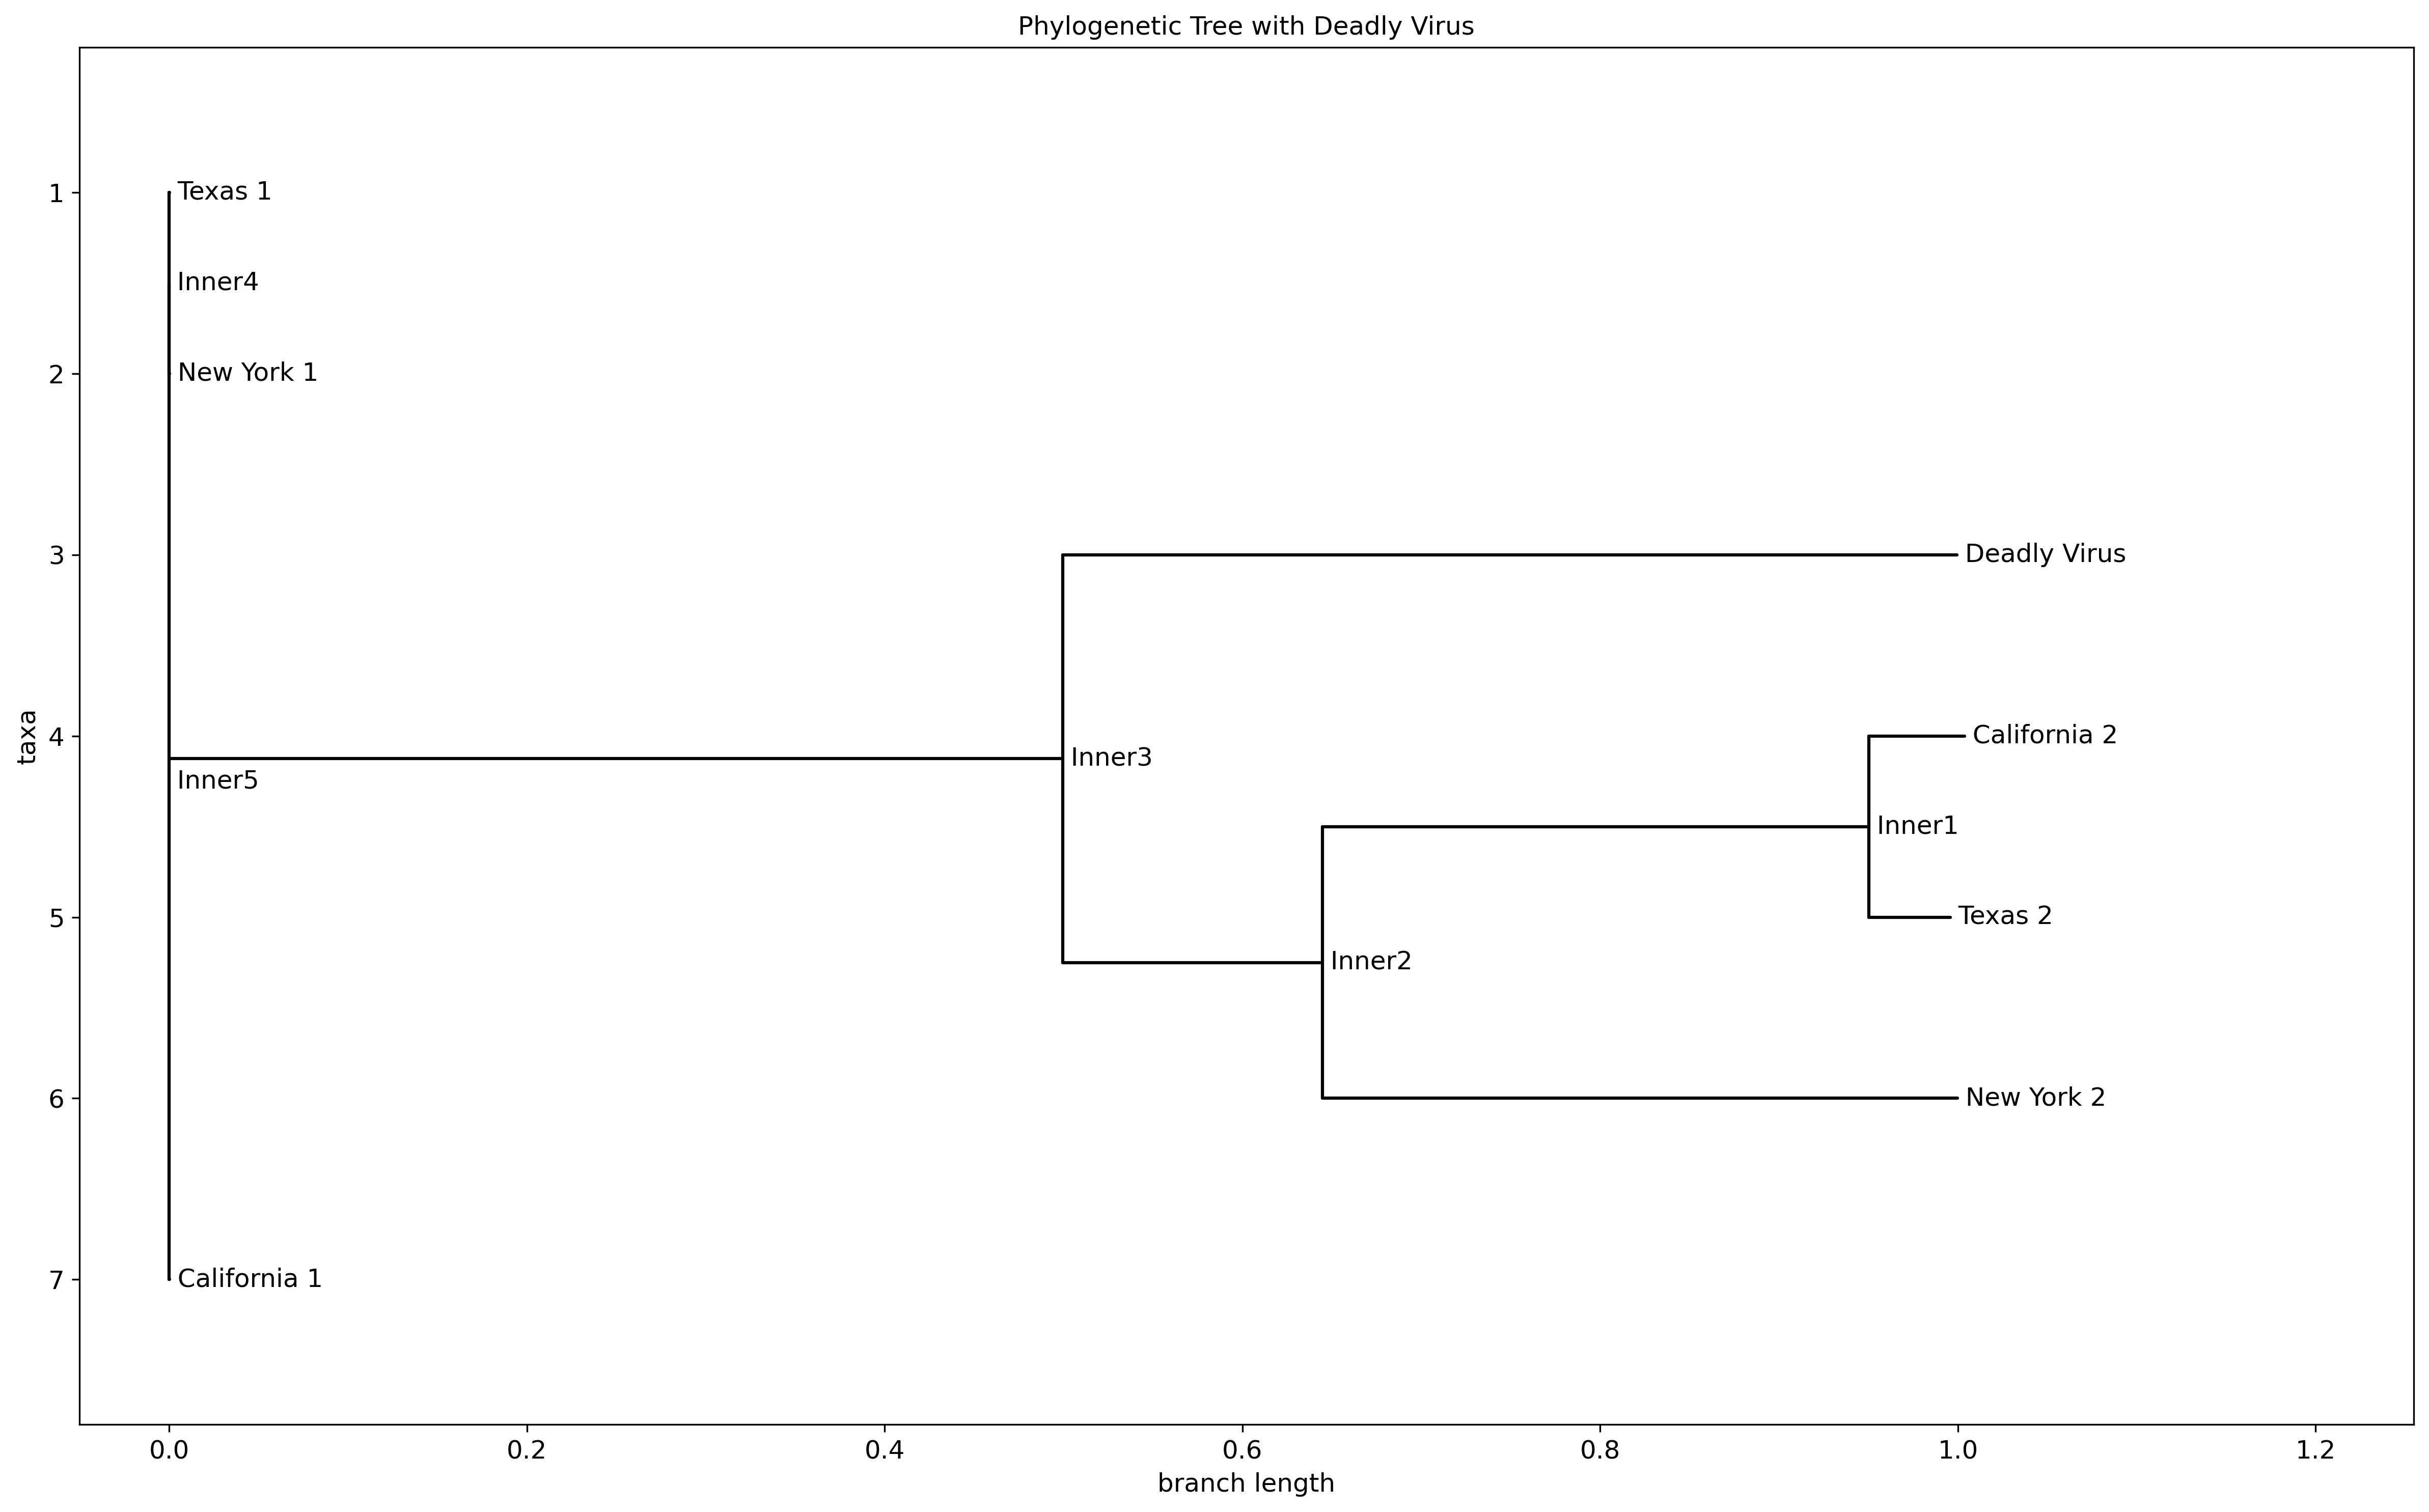


--- Average Distance to Deadly Virus ---
New York: 29894.5000
Texas: 29894.5000
California: 29896.0000

✅ Closest region to deadly virus sequence: **New York**


In [ ]:
from Bio import Phylo, SeqIO
from Bio.Align import MultipleSeqAlignment
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import matplotlib.pyplot as plt
import os

# -------- CONFIG --------
msa_paths = {
    "New York": r"C:\Users\abhis\OneDrive\sem 4\BIO\NEWYORK\consensus_newyork.fasta",
        "Texas": r"C:\Users\abhis\OneDrive\sem 4\BIO\TEXAS\consensus_texas.fasta",
        "California": r"C:\Users\abhis\OneDrive\sem 4\BIO\CALIFORNIA\consensus_california.fasta"
}

deadly_fasta_path = r"C:\Users\abhis\OneDrive\sem 4\BIO\EPI_ISL_402124.fasta"

# -------- HELPERS --------
def read_msa_file(path, region_name):
    with open(path, 'r') as f:
        lines = [line.strip().replace(" ", "").replace("\n", "") for line in f if line.strip()]
    return [SeqRecord(Seq(seq), id=f"{region_name}_{i+1}") for i, seq in enumerate(lines)], max(map(len, lines))

def pad_sequences(seq_records, target_length):
    padded = []
    for rec in seq_records:
        seq_str = str(rec.seq).ljust(target_length, "-")
        padded.append(SeqRecord(Seq(seq_str), id=rec.id))
    return padded

def read_and_align_deadly(path, aligned_length):
    deadly_seq = list(SeqIO.parse(path, "fasta"))[0]
    raw_seq = str(deadly_seq.seq).replace(" ", "").replace("\n", "")
    # Pad/trim to match aligned length
    if len(raw_seq) < aligned_length:
        raw_seq = raw_seq.ljust(aligned_length, "-")
    elif len(raw_seq) > aligned_length:
        raw_seq = raw_seq[:aligned_length]
    return SeqRecord(Seq(raw_seq), id="Deadly_Virus")

def average_distance(region_seqs, deadly_seq):
    total = 0
    for seq in region_seqs:
        dist = sum(1 for a, b in zip(seq.seq, deadly_seq.seq) if a != b)
        total += dist
    return total / len(region_seqs)

# -------- MAIN LOGIC --------
all_sequences = []
region_sequences = {}
max_length = 0

# Load MSA files and find max sequence length
for region, path in msa_paths.items():
    seqs, region_max = read_msa_file(path, region)
    region_sequences[region] = seqs
    max_length = max(max_length, region_max)

# Pad all region sequences to match max_length
for region in region_sequences:
    region_sequences[region] = pad_sequences(region_sequences[region], max_length)
    all_sequences.extend(region_sequences[region])

# Load and fix deadly virus sequence
deadly_seq = read_and_align_deadly(deadly_fasta_path, max_length)
all_sequences.append(deadly_seq)

# Check all sequence lengths
for seq in all_sequences:
    if len(seq.seq) != max_length:
        raise ValueError(f"Sequence {seq.id} has invalid length: {len(seq.seq)} != {max_length}")

# Build phylogenetic tree
alignment = MultipleSeqAlignment(all_sequences)
calculator = DistanceCalculator('identity')
dm = calculator.get_distance(alignment)

constructor = DistanceTreeConstructor()
tree = constructor.nj(dm)

# --------- BETTER TREE PLOTTING ---------
fig = plt.figure(figsize=(16, 10), dpi=300)
ax = fig.add_subplot(1, 1, 1)

Phylo.draw(
    tree,
    axes=ax,
    do_show=False,
    show_confidence=False,
    label_func=lambda x: x.name.replace("_", " ") if x.name else "",
    branch_labels=lambda c: None  # hides cluttered branch lengths
)

# Style tweaks
ax.set_title("Phylogenetic Tree with Deadly Virus", fontsize=20)
for text in ax.findobj(match=plt.Text):
    text.set_fontsize(12)

plt.tight_layout()
plt.savefig("phylogenetic_tree_cleaned.png", dpi=300)
plt.show()

# --------- DISTANCE ANALYSIS ---------
print("\n--- Average Distance to Deadly Virus ---")
distances = {
    region: average_distance(seqs, deadly_seq)
    for region, seqs in region_sequences.items()
}
for region, dist in distances.items():
    print(f"{region}: {dist:.4f}")

closest = min(distances, key=distances.get)
print(f"\n✅ Closest region to deadly virus sequence: **{closest}**")


## PRANK

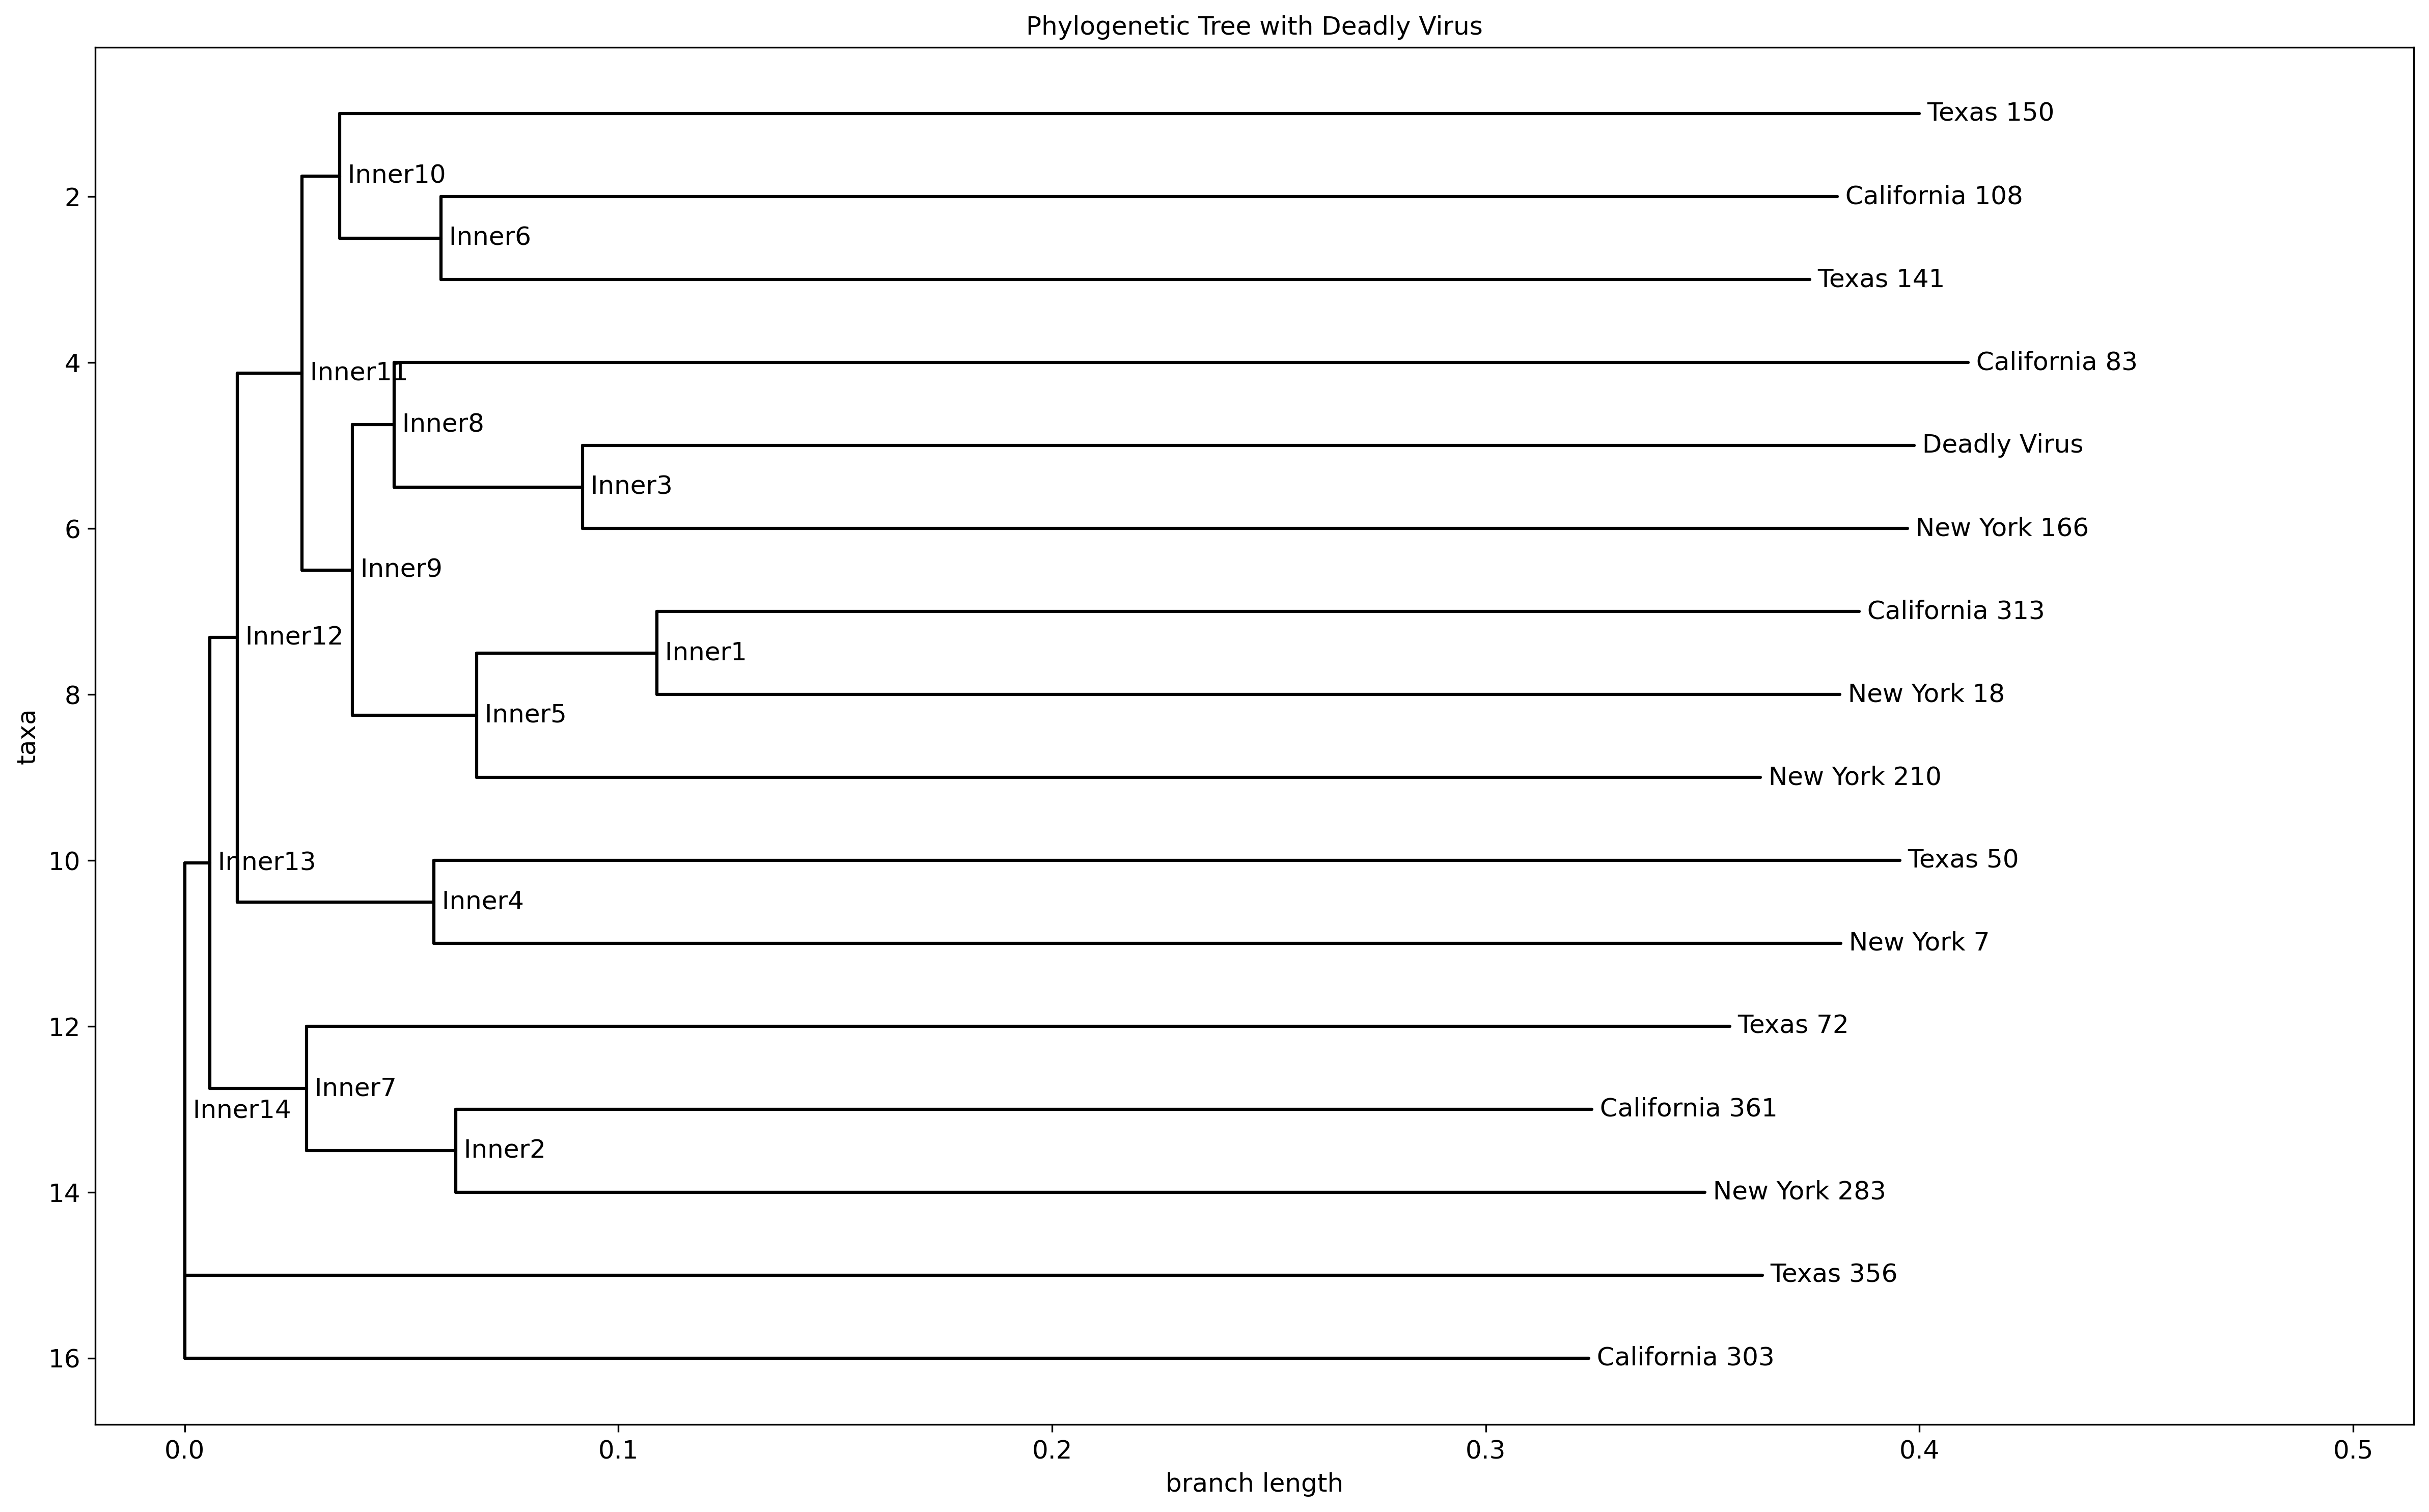


--- Average Distance to Deadly Virus ---
New York: 54.4000
Texas: 60.0000
California: 56.2000

✅ Closest region to deadly virus sequence: *New York*


In [ ]:
from Bio import Phylo, SeqIO
from Bio.Align import MultipleSeqAlignment
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import matplotlib.pyplot as plt
import random

# -------- CONFIG --------
msa_paths = {
    "New York": r"E:\\BIO-DAA\\PRANK\\NEWYORK\\consensus_newyork.fasta",
    "Texas": r"E:\\BIO-DAA\\PRANK\\TEXAS\\consensus_texas.fasta",
    "California": r"E:\\BIO-DAA\\PRANK\\CALIFONIA\\consensus_california.fasta"
}

deadly_fasta_path = r"E:\\BIO-DAA\\PRANK\\EPI_ISL_402124.fasta"

# -------- HELPERS --------
def read_msa_file(path, region_name):
    with open(path, 'r') as f:
        lines = [line.strip().replace(" ", "").replace("\n", "") for line in f if line.strip() and not line.startswith(">")]
    return [SeqRecord(Seq(seq), id=f"{region_name}_{i+1}") for i, seq in enumerate(lines)], max(map(len, lines))

def pad_sequences(seq_records, target_length):
    return [SeqRecord(Seq(str(rec.seq).ljust(target_length, "-")), id=rec.id) for rec in seq_records]

def truncate_sequences(seqs, length=10000):
    return [SeqRecord(Seq(str(s.seq)[:length]), id=s.id) for s in seqs]

def sample_sequences(region_dict, max_per_region=5):
    return {
        region: random.sample(seqs, min(max_per_region, len(seqs)))
        for region, seqs in region_dict.items()
    }

def read_and_align_deadly(path, aligned_length):
    deadly_seq = list(SeqIO.parse(path, "fasta"))[0]
    raw_seq = str(deadly_seq.seq).replace(" ", "").replace("\n", "")
    raw_seq = raw_seq.ljust(aligned_length, "-") if len(raw_seq) < aligned_length else raw_seq[:aligned_length]
    return SeqRecord(Seq(raw_seq), id="Deadly_Virus")

def average_distance(region_seqs, deadly_seq):
    return sum(
        sum(1 for a, b in zip(seq.seq, deadly_seq.seq) if a != b) for seq in region_seqs
    ) / len(region_seqs)

# -------- MAIN LOGIC --------
all_sequences = []
region_sequences = {}
max_length = 0

# Load and pad sequences
for region, path in msa_paths.items():
    seqs, region_max = read_msa_file(path, region)
    region_sequences[region] = pad_sequences(seqs, region_max)
    max_length = max(max_length, region_max)

# Truncate sequences
for region in region_sequences:
    region_sequences[region] = truncate_sequences(region_sequences[region])

# Sample sequences
region_sequences = sample_sequences(region_sequences, max_per_region=5)

# Collect sequences
for region in region_sequences:
    all_sequences.extend(region_sequences[region])

deadly_seq = read_and_align_deadly(deadly_fasta_path, max_length)
deadly_seq = truncate_sequences([deadly_seq])[0]
all_sequences.append(deadly_seq)

# Validate lengths
expected_len = len(all_sequences[0].seq)
for seq in all_sequences:
    if len(seq.seq) != expected_len:
        raise ValueError(f"Sequence {seq.id} has invalid length: {len(seq.seq)} != {expected_len}")

# Build tree
alignment = MultipleSeqAlignment(all_sequences)
calculator = DistanceCalculator('identity')
dm = calculator.get_distance(alignment)
constructor = DistanceTreeConstructor()
tree = constructor.nj(dm)

# Plot tree
fig = plt.figure(figsize=(16, 10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
Phylo.draw(
    tree,
    axes=ax,
    do_show=False,
    show_confidence=False,
    label_func=lambda x: x.name.replace("_", " ") if x.name else "",
    branch_labels=lambda c: None
)
ax.set_title("Phylogenetic Tree with Deadly Virus", fontsize=20)
for text in ax.findobj(match=plt.Text):
    text.set_fontsize(12)
plt.tight_layout()
plt.savefig("phylogenetic_tree_cleaned.png", dpi=300)
plt.show()

# Distance analysis
print("\n--- Average Distance to Deadly Virus ---")
distances = {
    region: average_distance(region_sequences[region], deadly_seq)
    for region in region_sequences
}
for region, dist in distances.items():
    print(f"{region}: {dist:.4f}")

closest = min(distances, key=distances.get)
print(f"\n✅ Closest region to deadly virus sequence: *{closest}*")

## Global Alignment of Consensus Sequences
## Dataset Description

We performed a global alignment analysis using the consensus genome sequences from three U.S. cities:

* `consensus_california.fasta`
* `consensus_texas.fasta`
* `consensus_newyork.fasta`

These sequences are assumed to represent dominant or most frequently observed viral strains in each location.

<br>

 **Methodology**

1.  **Sequence Loading**
    The consensus sequences were read from FASTA files, and the raw nucleotide sequences were extracted, ignoring the FASTA headers.

2.  **Global Alignment**
    A custom implementation of the Needleman-Wunsch global alignment algorithm was used. This algorithm aligns two sequences over their entire length, introducing gaps as needed to maximize similarity.
    **Scoring Scheme Used:**
    * Match: +2
    * Mismatch: -1
    * Gap penalty: -2

3.  **Identity Score Calculation**
    We used a "fast identity" method that:
    * Ignores gaps
    * Compares only aligned nucleotides (A/T/C/G)
    * Calculates percentage of matches over valid positions

<br>

**Results:**

* California and Texas have a very high sequence similarity (**90.08%**), suggesting that the viral strains in these two cities are closely related.
* New York, on the other hand, shows a much lower similarity (**~27–31%**) when compared to both California and Texas. This indicates greater sequence divergence in New York's strain.

<br>

 **Conclusion: Most Disease-Prone City**

A higher sequence divergence often implies:

* Faster mutation rate
* Greater adaptation of the virus
* Possibly reduced vaccine/antibody efficacy

 **Therefore, based on the consensus genome variation:**

 **New York is the most prone to disease outbreaks.**
Its viral strain is significantly different, which could potentially affect treatment efficacy or indicate a different evolutionary path of the virus.

## MAFFT

In [ ]:
def global_alignment(seq1, seq2, match=2, mismatch=-1, gap=-2):
    m, n = len(seq1), len(seq2)

    # Step 1: Initialize scoring matrix
    score = [[0] * (n+1) for _ in range(m+1)]
    for i in range(m+1):
        score[i][0] = i * gap
    for j in range(n+1):
        score[0][j] = j * gap

    # Step 2: Fill the matrix
    for i in range(1, m+1):
        for j in range(1, n+1):
            diag = score[i-1][j-1] + (match if seq1[i-1] == seq2[j-1] else mismatch)
            delete = score[i-1][j] + gap
            insert = score[i][j-1] + gap
            score[i][j] = max(diag, delete, insert)

    # Step 3: Traceback
    aligned1, aligned2 = "", ""
    i, j = m, n
    while i > 0 and j > 0:
        current = score[i][j]
        if current == score[i-1][j-1] + (match if seq1[i-1] == seq2[j-1] else mismatch):
            aligned1 = seq1[i-1] + aligned1
            aligned2 = seq2[j-1] + aligned2
            i -= 1
            j -= 1
        elif current == score[i-1][j] + gap:
            aligned1 = seq1[i-1] + aligned1
            aligned2 = "-" + aligned2
            i -= 1
        else:
            aligned1 = "-" + aligned1
            aligned2 = seq2[j-1] + aligned2
            j -= 1

    # Add remaining leading gaps
    while i > 0:
        aligned1 = seq1[i-1] + aligned1
        aligned2 = "-" + aligned2
        i -= 1
    while j > 0:
        aligned1 = "-" + aligned1
        aligned2 = seq2[j-1] + aligned2
        j -= 1

    # Step 4: Compute identity
    matches = sum(1 for a, b in zip(aligned1, aligned2) if a == b)
    total = len(aligned1)
    identity = matches / total * 100

    print(f"✅ Aligned {total} positions → Identity: {identity:.2f}%")
    return aligned1, aligned2, identity


In [ ]:
from collections import defaultdict

# ✅ Function to load consensus sequence from a FASTA file
def load_consensus_seq(path):
    with open(path, 'r') as f:
        return "".join([line.strip() for line in f if not line.startswith(">")])

# ✅ Fast identity comparison (ignores gaps, compares A/T/C/G only)
def fast_identity(seq1, seq2):
    length = min(len(seq1), len(seq2))
    matches = sum(1 for a, b in zip(seq1[:length], seq2[:length]) if a == b and a != '-' and b != '-')
    valid = sum(1 for a, b in zip(seq1[:length], seq2[:length]) if a != '-' and b != '-')
    identity = (matches / valid) * 100 if valid > 0 else 0
    print(f"✅ Compared {valid} valid positions → Identity: {identity:.2f}%")
    return identity

# ✅ File paths for the consensus sequences
california_path = r"C:\Users\abhis\OneDrive\sem 4\BIO\CALIFORNIA\consensus_california.fasta"
texas_path      = r"C:\Users\abhis\OneDrive\sem 4\BIO\TEXAS\consensus_texas.fasta"
newyork_path    = r"C:\Users\abhis\OneDrive\sem 4\BIO\NEWYORK\consensus_newyork.fasta"

# ✅ Load sequences
ca_seq = load_consensus_seq(california_path)
tx_seq = load_consensus_seq(texas_path)
ny_seq = load_consensus_seq(newyork_path)

# ✅ Run fast identity comparisons
print("\n🔬 California vs Texas:")
id_ca_tx = fast_identity(ca_seq, tx_seq)

print("\n🔬 California vs New York:")
id_ca_ny = fast_identity(ca_seq, ny_seq)

print("\n🔬 Texas vs New York:")
id_tx_ny = fast_identity(tx_seq, ny_seq)

# ✅ Print final summary matrix
print("\n📊 Identity Matrix (% similarity):")
print(f"{'':>15} {'California':>12} {'Texas':>12} {'New York':>12}")
print(f"{'California':>15} {'-':>12} {id_ca_tx:>12.2f} {id_ca_ny:>12.2f}")
print(f"{'Texas':>15} {id_ca_tx:>12.2f} {'-':>12} {id_tx_ny:>12.2f}")
print(f"{'New York':>15} {id_ca_ny:>12.2f} {id_tx_ny:>12.2f} {'-':>12}")



🔬 California vs Texas:
✅ Compared 29898 valid positions → Identity: 90.08%

🔬 California vs New York:
✅ Compared 29898 valid positions → Identity: 27.02%

🔬 Texas vs New York:
✅ Compared 29898 valid positions → Identity: 31.05%

📊 Identity Matrix (% similarity):
                  California        Texas     New York
     California            -        90.08        27.02
          Texas        90.08            -        31.05
       New York        27.02        31.05            -


## PRANK

**Comparison with PRANK Alignment Results**

Unlike the MAFFT results, which showed California and Texas to be very similar, the PRANK-based results suggest all three cities have highly divergent viral consensus sequences.

The similarity percentages now range only between **26%–28%**, implying:

* Greater sequence variation across all regions
* Possibly multiple viral lineages or distinct mutation paths in each city

In this PRANK-based analysis:

* The lowest similarity was observed between California and Texas (**26.63%**)
* New York remains slightly more divergent than California–Texas but the differences are small (**~1–2%**)

 **Thus, with this method:**

 **All three cities show comparable divergence**
...but California and Texas appear slightly more dissimilar, making **California potentially more prone to harboring a different strain.**

In [ ]:
def global_alignment(seq1, seq2, match=2, mismatch=-1, gap=-2):
    m, n = len(seq1), len(seq2)

    # Step 1: Initialize scoring matrix
    score = [[0] * (n+1) for _ in range(m+1)]
    for i in range(m+1):
        score[i][0] = i * gap
    for j in range(n+1):
        score[0][j] = j * gap

    # Step 2: Fill the matrix
    for i in range(1, m+1):
        for j in range(1, n+1):
            diag = score[i-1][j-1] + (match if seq1[i-1] == seq2[j-1] else mismatch)
            delete = score[i-1][j] + gap
            insert = score[i][j-1] + gap
            score[i][j] = max(diag, delete, insert)

    # Step 3: Traceback
    aligned1, aligned2 = "", ""
    i, j = m, n
    while i > 0 and j > 0:
        current = score[i][j]
        if current == score[i-1][j-1] + (match if seq1[i-1] == seq2[j-1] else mismatch):
            aligned1 = seq1[i-1] + aligned1
            aligned2 = seq2[j-1] + aligned2
            i -= 1
            j -= 1
        elif current == score[i-1][j] + gap:
            aligned1 = seq1[i-1] + aligned1
            aligned2 = "-" + aligned2
            i -= 1
        else:
            aligned1 = "-" + aligned1
            aligned2 = seq2[j-1] + aligned2
            j -= 1

    # Add remaining leading gaps
    while i > 0:
        aligned1 = seq1[i-1] + aligned1
        aligned2 = "-" + aligned2
        i -= 1
    while j > 0:
        aligned1 = "-" + aligned1
        aligned2 = seq2[j-1] + aligned2
        j -= 1

    # Step 4: Compute identity
    matches = sum(1 for a, b in zip(aligned1, aligned2) if a == b)
    total = len(aligned1)
    identity = matches / total * 100

    print(f"✅ Aligned {total} positions → Identity: {identity:.2f}%")
    return aligned1, aligned2, identity


In [ ]:
from collections import defaultdict

# ✅ Function to load consensus sequence from a FASTA file
def load_consensus_seq(path):
    with open(path, 'r') as f:
        return "".join([line.strip() for line in f if not line.startswith(">")])

# ✅ Fast identity comparison (ignores gaps, compares A/T/C/G only)
def fast_identity(seq1, seq2):
    length = min(len(seq1), len(seq2))
    matches = sum(1 for a, b in zip(seq1[:length], seq2[:length]) if a == b and a != '-' and b != '-')
    valid = sum(1 for a, b in zip(seq1[:length], seq2[:length]) if a != '-' and b != '-')
    identity = (matches / valid) * 100 if valid > 0 else 0
    print(f"✅ Compared {valid} valid positions → Identity: {identity:.2f}%")
    return identity

# ✅ File paths for the consensus sequences
california_path = r"E:\BIO-DAA\PRANK\CALIFONIA\consensus_california.fasta"
texas_path      = r"E:\BIO-DAA\PRANK\TEXAS\consensus_texas.fasta"
newyork_path    = r"E:\BIO-DAA\PRANK\NEWYORK\consensus_newyork.fasta"

# ✅ Load sequences
ca_seq = load_consensus_seq(california_path)
tx_seq = load_consensus_seq(texas_path)
ny_seq = load_consensus_seq(newyork_path)

# ✅ Run fast identity comparisons
print("\n🔬 California vs Texas:")
id_ca_tx = fast_identity(ca_seq, tx_seq)

print("\n🔬 California vs New York:")
id_ca_ny = fast_identity(ca_seq, ny_seq)

print("\n🔬 Texas vs New York:")
id_tx_ny = fast_identity(tx_seq, ny_seq)

# ✅ Print final summary matrix
print("\n📊 Identity Matrix (% similarity):")
print(f"{'':>15} {'California':>12} {'Texas':>12} {'New York':>12}")
print(f"{'California':>15} {'-':>12} {id_ca_tx:>12.2f} {id_ca_ny:>12.2f}")
print(f"{'Texas':>15} {id_ca_tx:>12.2f} {'-':>12} {id_tx_ny:>12.2f}")
print(f"{'New York':>15} {id_ca_ny:>12.2f} {id_tx_ny:>12.2f} {'-':>12}")



🔬 California vs Texas:
✅ Compared 30221 valid positions → Identity: 26.63%

🔬 California vs New York:
✅ Compared 30457 valid positions → Identity: 28.31%

🔬 Texas vs New York:
✅ Compared 30347 valid positions → Identity: 28.58%

📊 Identity Matrix (% similarity):
                  California        Texas     New York
     California            -        26.63        28.31
          Texas        26.63            -        28.58
       New York        28.31        28.58            -


# Newyork

In [3]:
def hamming_distance(seq1, seq2):
    """Calculate Hamming distance between two sequences"""
    return sum(c1 != c2 for c1, c2 in zip(seq1, seq2))

# Dictionary of state-wise sequences
state_sequences = {
    "Alpha (B.I.I.7)":  "AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTTGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGACTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTGCTGCCGTGAACATGAGCATGAAATTGCTTGGTACACGGAACGTTCTGAAAAGAGCTATGAATTGCAGACACCTTTTGAAATTAAATTGGCAAAGAAATTTGACACCTTCAATGGGGAATGTCCAAATTTTGTATTTCCCTTAAATTCCATAATCAAGACTATTCAACCAAGGGTTGAAAAGAAAAAGCTTGATGGCTTTATGGGTAGAATTCGATCTGTCTATCCAGTTGCGTCACCAAATGAATGCAACCAAATGTGCCTTTCAACTCTCATGAAGTGTGATCATTGTGGTGAAACTTCATGGCAGACGGGCGATTTTGTTAAAGCCACTTGCGAATTTTGTGGCACTGAGAATTTGACTAAAGAAGGTGCCACTACTTGTGGTTACTTACCCCAAAATGCTGTTGTTAAAATTTATTGTCCAGCATGTCACAATTCAGAAGTAGGACCTGAGCATAGTCTTGCCGAATACCATAATGAATCTGGCTTGAAAACCATTCTTCGTAAGGGTGGTCGCACTATTGCCTTTGGAGGCTGTGTGTTCTCTTATGTTGGTTGCCATAACAAGTGTGCCTATTGGGTTCCACGTGCTAGCGCTAACATAGGTTGTAACCATACAGGTGTTGTTGGAGAAGGTTCCGAAGGTCTTAATGACAACCTTCTTGAAATACTCCAAAAAGAGAAAGTCAACATCAATATTGTTGGTGACTTTAAACTTAATGAAGAGATCGCCATTATTTTGGCATCTTTTTCTGCTTCCACAAGTGCTTTTGTGGAAACTGTGAAAGGTTTGGATTATAAAGCATTCAAACAAATTGTTGAATCCTGTGGTAATTTTAAAGTTACAAAAGGAAAAGCTAAAAAAGGTGCCTGGAATATTGGTGAACAGAAATCAATACTGAGTCCTCTTTATGCATTTGCATCAGAGGCTGCTCGTGTTGTACGATCAATTTTCTCCCGCACTCTTGAAACTGCTCAAAATTCTGTGCGTGTTTTACAGAAGGCCGCTATAACAATACTAGATGGAATTTCACAGTATTCACTGAGACTCATTGATGCTATGATGTTCACATCTGATTTGGCTACTAACAATCTAGTTGTAATGGCCTACATTACAGGTGGTGTTGTTCAGTTGACTTCGCAGTGGCTAACTAACATCTTTGGCACTGTTTATGAAAAACTCAAACCCGTCCTTGATTGGCTTGAAGAGAAGTTTAAGGAAGGTGTAGAGTTTCTTAGAGACGGTTGGGAAATTGTTAAATTTATCTCAACCTGTGCTTGTGAAATTGTCGGTGGACAAATTGTCACCTGTGCAAAGGAAATTAAGGAGAGTGTTCAGACATTCTTTAAGCTTGTAAATAAATTTTTGGCTTTGTGTGCTGACTCTATCATTATTGGTGGAGCTAAACTTAAAGCCTTGAATTTAGGTGAAACATTTGTCACGCACTCAAAGGGATTGTACAGAAAGTGTGTTAAATCCAGAGAAGAAACTGGCCTACTCATGCCTCTAAAAGCCCCAAAAGAAATTATCTTCTTAGAGGGAGAAACACTTCCCACAGAAGTGTTAACAGAGGAAGTTGTCTTGAAAACTGGTGATTTACAACCATTAGAACAACCTACTAGTGAAGCTGTTGAAGCTCCATTGGTTGGTACACCAGTTTGTATTAACGGGCTTATGTTGCTCGAAATCAAAGACACAGAAAAGTACTGTGCCCTTGCACCTAATATGATGGTAACAAACAATACCTTCACACTCAAAGGCGGTGCACCAACAAAGGTTACTTTTGGTGATGATACTGTGATAGAAGTGCAAGGTTACAAGAGTGTGAATATCACTTTTGAACTTGATGAAAGGATTGATAAAGTACTTAATGAGAAGTGCTCTGCCTATACAGTTGAACTCGGTACAGAAGTAAATGAGTTCGCCTGTGTTGTGGCAGATGCTGTCATAAAAACTTTGCAACCAGTATCTGAATTACTTACACCACTGGGCATTGATTTAGATGAGTGGAGTATGGCTACATACTACTTATTTGATGAGTCTGGTGAGTTTAAATTGGCTTCACATATGTATTGTTCTTTTTACCCTCCAGATGAGGATGAAGAAGAAGGTGATTGTGAAGAAGAAGAGTTTGAGCCATCAACTCAATATGAGTATGGTACTGAAGATGATTACCAAGGTAAACCTTTGGAATTTGGTGCCACTTCTGCTGCTCTTCAACCTGAAGAAGAGCAAGAAGAAGATTGGTTAGATGATGATAGTCAACAAACTGTTGGTCAACAAGACGGCAGTGAGGACAATCAGACAACTACTATTCAAACAATTGTTGAGGTTCAACCTCAATTAGAGATGGAACTTACACCAGTTGTTCAGACTATTGAAGTGAATAGTTTTAGTGGTTATTTAAAACTTACTGACAATGTATACATTAAAAATGCAGACATTGTGGAAGAAGCTAAAAAGGTAAAACCAACAGTGGTTGTTAATGCAGCCAATGTTTACCTTAAACATGGAGGAGGTGTTGCAGGAGCCTTAAATAAGGCTACTAACAATGCCATGCAAGTTGAATCTGATGATTACATAGCTACTAATGGACCACTTAAAGTGGGTGGTAGTTGTGTTTTAAGCGGACACAATCTTGCTAAACACTGTCTTCATGTTGTCGGCCCAAATGTTAACAAAGGTGAAGACATTCAACTTCTTAAGAGTGCTTATGAAAATTTTAATCAGCACGAAGTTCTACTTGCACCATTATTATCAGCTGGTATTTTTGGTGCTGACCCTATACATTCTTTAAGAGTTTGTGTAGATACTGTTCGCACAAATGTCTACTTAGCTGTCTTTGATAAAAATCTCTATGACAAACTTGTTTAAAGCTTTTTGGAAATGAAGAGTGAAAAGCAAGTTGAACAAAAGATCGCTGAGATTCCTAAAGAGGAAGTTAAGCCATTTATAACTGAAAGTAAACCTTCAGTTGAACAGAGAAAACAAGATGATAAGAAAATCAAAGCTTGTGTTGAAGAAGTTACAACAACTCTGGAAGAAACTAAGTTCCTCACAGAAAACTTGTTACTTTATATTGACATTAATGGCAATCTTCATCCAGATTCTGCCACTCTTGTTAGTGACATTGACATCACTTTCTTAAAGAAAGATGCTCCATATATAGTGGGTGATGTTGTTCAAGAGGGTGTTTTAACTGCTGTGGTTATACCTACTAAAAAGGCTGGTGGCACTACTGAAATGCTAGCGAAAGCTTTGAGAAAAGTGCCAACAGACAATTATATAACCACTTACCCAGGTCAGGGTTTAAATGGTTACACTGTAGAGGAGGCAAAGACAGTGCTTAAAAAGTGTAAAAGTGCCTTTTACATTCTACCATCTATTATCTCTAATGAGAAGCAAGAAATTCTTGGAACTGTTTCTTGGAATTTGCGAGAAATGCTTGCACATGCAGAAGAAACACGCAAATTAATGCCTGTCTGTGTGGAAACTAAAGCCATAGTTTCAACTATACAGCGTAAATATAAGGGTATTAAAATACAAGAGGGTGTGGTTGATTATGGTGCTAGATTTTACTTTTACACCAGTAAAACAACTGTAGCGTCACTTATCAACACACTTAACGATCTAAATGAAACTCTTGTTACAATGCCACTTGGCTATGTAACACATGGCTTAAATTTGGAAGAAGCTGCTCGGTATATGAGATCTCTCAAAGTGCCAGCTACAGTTTCTGTTTCTTCACCTGATGCTGTTACAGCGTATAATGGTTATCTTACTTCTTCTTCTAAAACACCTGAAGAACATTTTATTGAAACCATCTCACTTGCTGGTTCCTATAAAGATTGGTCCTATTCTGGACAATCTACACAACTAGGTATAGAATTTCTTAAGAGAGGTGATAAAAGTGTATATTACACTAGTAATCCTACCACATTCCACCTAGATGGTGAAGTTATCACCTTTGACAATCTTAAGACACTTCTTTCTTTGAGAGAAGTGAGGACTATTAAGGTGTTTACAACAGTAGACAACATTAACCTCCACACGCAAGTTGTGGACATGTCAATGACATATGGACAACAGTTTGGTCCAACTTATTTGGATGGAGCTGATGTTACTAAAATAAAACCTCATAATTCACATGAAGGTAAAACATTTTATGTTTTACCTAATGATGACACTCTACGTGTTGAGGCTTTTGAGTACTACCACACAACTGATCCTAGTTTTCTGGGTAGGTACATGTCAGCATTAAATCACACTAAAAAGTGGAAATACCCACAAGTTAATGGTTTAACTTCTATTAAATGGGCAGATAACAACTGTTATCTTGCCACTGCATTGTTAACACTCCAACAAATAGAGTTGAAGTTTAATCCACCTGCTCTACAAGATGCTTATTACAGAGCAAGGGCTGGTGAAGCTGCTAACTTTTGTGCACTTATCTTAGCCTACTGTAATAAGACAGTAGGTGAGTTAGGTGATGTTAGAGAAACAATGAGTTACTTGTTTCAACATGCCAATTTAGATTCTTGCAAAAGAGTCTTGAACGTGGTGTGTAAAACTTGTGGACAACAGCAGACAACCCTTAAGGGTGTAGAAGCTGTTATGTACATGGGCACACTTTCTTATGAACAATTTAAGAAAGGTGTTCAGATACCTTGTACGTGTGGTAAACAAGCTACACAATATCTAGTACAACAGGAGTCACCTTTTGTTATGATGTCAGCACCACCTGCTCAGTATGAACTTAAGCATGGTACATTTACTTGTGCTAGTGAGTACACTGGTAATTACCAGTGTGGTCACTATAAACATATAACTTTTAAAGAAACTTTGTATTGCATAGACGGTGCTTTACTTACAAAGTCCTCAGAATACAAAGGTCCTATTACGGATGTTTTCTACAAAGAAAACAGTTACACAACAACCATAAAACCAGTTACTTATAAATTGGATGGTGTTGTTTGTACAGAAATTGACCCTAAGTTGGACAATTATTATAAGAAAGACAATTCTTATTTCACAGAGCAACCAATTGATCTTGTACCAAACCAACCATATCCAAACGCAAGCTTCGATAATTTTAAGTTTGTATGTGATAATATCAAATTTGCTGATGATTTAAACCAGTTAACTGGTTATAAGAAACCTGCTTCAAGAGAGCTTAAAGTTACATTTTTCCCTGACTTAAATGGTGATGTGGTGGCTATTGATTATAAACACTACACACCCTCTTTTAAGAAAGGAGCTAAATTGTTACATAAACCTATTGTTTGGCATGTTAACAATGCAACTAATAAAGCCACGTATAAACCAAATACCTGGTGTATACGTTGTCTTTGGAGCACAAAACCGGTTGAAACATCAAATTCGTTTGATGTACTGAAGTCAGAGGACGCGCAGGGAATGGATAATCTTGCCTGCGAAGATCTAAAACCAGTCTCTGAAGAAGTAGTGGAAAATCCTACCATACAGAAAGACGTTCTTGAGTGTAATGTGAAAACTACCGAAGTTGTAGGAGACATTATACTTAAACCAGCAAATAATAGTTTAAAAATTACAGAAGAGGTTGGCCACACAGATCTAATGGCTGCTTATGTAGACAATTCTAGTCTTACTATTAAGAAACCTAATGAATTATCTAGAGTGTTAGGTTTGAAAACCCTTGCTACTCATGGTTTAGCTGCTGTTAATAGTGTCCCTTGGGATACTATAGCTAATTATGCTAAGCCTTTTCTTAACAAAGTTGTTAGTACAACTACTAACATAGTTACACGGTGTTTAAACCGTGTTTGTACTAATTATATGCCTTATTTCTTTACTTTATTGCTACAATTGTGTACTTTTACTAGAAGTACAAATTCTAGAATTAAAGCATCTATGCCGACTACTATAGCAAAGAATACTGTTAAGAGTGTCGGTAAATTTTGTCTAGAGGCTTCATTTAATTATTTGAAGTCACCTAATTTTTCTAAACTGATAAATATTATAATTTGGTTTTTACTATTAAGTGTTTGCCTAGGTTCTTTAATCTACTCAACCGCTGCTTTAGGTGTTTTAATGTCTAATTTAGGCATGCCTTCTTGCTGTACTGGTTACAGAGAAGGCTATTTGAACTCTACTAATGTCACTATTGCAACCTACTGTACTGGTTCTATACCTTGTAGTGTTTGTCTTAGTGGTTTAGATTCTTTAGACACCTATCCTTCTTTAGAAACTATACAAATTACCATTTCATCTTTTAAATGGGATTTAACTGCTTTTGGCTTAGTTGCAGAGTGGTTTTTGGCATATATTCTTTTCACTAGGTTTTTCTATGTACTTGGATTGGCTGCAATCATGCAATTGTTTTTCAGCTATTTTGCAGTACATTTTATTAGTAATTCTTGGCTTATGTGGTTAATAATTAATCTTGTACAAATGGCCCCGATTTCAGCTATGGTTAGAATGTACATCTTCTTTGCATCATTTTATTATGTATGGAAAAGTTATGTGCATGTTGTAGACGGTTGTAATTCATCAACTTGTATGATGTGTTACAAACGTAATAGAGCAACAAGAGTCGAATGTACAACTATTGTTAATGGTGTTAGAAGGTCCTTTTATGTCTATGCTAATGGAGGTAAAGGCTTTTGCAAACTACACAATTGGAATTGTGTTAATTGTGATACATTCTGTGCTGGTAGTACATTTATTAGTGATGAAGTTGCGAGAGACTTGTCACTACAGTTTAAAAGACCAATAAATCCTACTGACCAGTCTTCTTACATCGTTGATAGTGTTACAGTGAAGAATGGTTCCATCCATCTTTACTTTGATAAAGCTGGTCAAAAGACTTATGAAAGACATTCTCTCTCTCATTTTGTTAACTTAGACAACCTGAGAGCTAATAACACTAAAGGTTCATTGCCTATTAATGTTATAGTTTTTGATGGTAAATCAAAATGTGAAGAATCATCTGCAAAATCAGCGTCTGTTTACTACAGTCAGCTTATGTGTCAACCTATACTGTTACTAGATCAGGCATTAGTGTCTGATGTTGGTGATAGTGCGGAAGTTGCAGTTAAAATGTTTGATGCTTACGTTAATACGTTTTCATCAACTTTTAACGTACCAATGGAAAAACTCAAAACACTAGTTGCAACTGCAGAAGCTGAACTTGCAAAGAATGTGTCCTTAGACAATGTCTTATCTACTTTTATTTCAGCAGCTCGGCAAGGGTTTGTTGATTCAGATGTAGAAACTAAAGATGTTGTTGAATGTCTTAAATTGTCACATCAATCTGACATAGAAGTTACTGGCGATAGTTGTAATAACTATATGCTCACCTATAACAAAGTTGAAAACATGACACCCCGTGACCTTGGTGCTTGTATTGACTGTAGTGCGCGTCATATTAATGCGCAGGTAGCAAAAAGTCACAACATTGCTTTGATATGGAACGTTAAAGATTTCATGTCATTGTCTGAACAACTACGAAAACAAATACGTAGTGCTGCTAAAAAGAATAACTTACCTTTTAAGTTGACATGTGCAACTACTAGACAAGTTGTTAATGTTGTAACAACAAAGATAGCACTTAAGGGTGGTAAAATTGTTAATAATTGGTTGAAGCAGTTAATTAAAGTTACACTTGTGTTCCTTTTTGTTGCTGCTATTTTCTATTTAATAACACCTGTTCATGTCATGTCTAAACATACTGACTTTTCAAGTGAAATCATAGGATACAAGGCTATTGATGGTGGTGTCACTCGTGACATAGCATCTACAGATACTTGTTTTGCTAACAAACATGCTGATTTTGACACATGGTTTAGCCAGCGTGGTGGTAGTTATACTAATGACAAAGCTTGCCCATTGATTGCTGCAGTCATAACAAGAGAAGTGGGTTTTGTCGTGCCTGGTTTGCCTGGCACGATATTACGCACAACTAATGGTGACTTTTTGCATTTCTTACCTAGAGTTTTTAGTGCAGTTGGTAACATCTGTTACACACCATCAAAACTTATAGAGTACACTGACTTTGCAACATCAGCTTGTGTTTTGGCTGCTGAATGTACAATTTTTAAAGATGCTTCTGGTAAGCCAGTACCATATTGTTATGATACCAATGTACTAGAAGGTTCTGTTGCTTATGAAAGTTTACGCCCTGACACACGTTATGTGCTCATGGATGGCTCTATTATTCAATTTCCTAACACCTACCTTGAAGGTTCTGTTAGAGTGGTAACAACTTTTGATTCTGAGTACTGTAGGCACGGCACTTGTGAAAGATCAGAAGCTGGTGTTTGTGTATCTACTAGTGGTAGATGGGTACTTAACAATGATTATTACAGATCTTTACCAGGAGTTTTCTGTGGTGTAGATGCTGTAAATTTACTTACTAATATGTTTACACCACTAATTCAACCTATTGGTGCTTTGGACATATCAGCATCTATAGTAGCTGGTGGTATTGTAGCTATCGTAGTAACATGCCTTGCCTACTATTTTATGAGGTTTAGAAGAGCTTTTGGTGAATACAGTCATGTAGTTGCCTTTAATACTTTACTATTCCTTATGTCATTCACTGTACTCTGTTTAACACCAGTTTACTCATTCTTACCTGGTGTTTATTCTGTTATTTACTTGTACTTGACATTTTATCTTACTAATGATGCTTCTTTTTTAGCACATATTCAGTGGATGGTTATGTTCACACCTTTAGTACCTTTCTGGATAACAATTGCTTATATCATTTGTATTTCCACAAAGCATTTCTATTGGTTCTTTAGTAATTACCTAAAGAGACGTGTAGTCTTTAATGGTGTTTCCTTTAGTACTTTTGAAGAAGCTGCGCTGTGCACCTTTTTGTTAAATAAAGAAATGTATCTAAAGTTGCGTAGTGATGTGCTATTACCTCTTACGCAATATAATAGATACTTAGCTCTTTATAATAAGTACAAGTATTTTAGTGGAGCAATGGATACAACTAGCTACAGAGAAGCTGCTTGTTGTCATCTCGCAAAGGCTCTCAATGACTTCAGTAACTCAGGTTCTGATGTTCTTTACCAACCACCACAAACCTCTATCACCTCAGCTGTTTTGCAGAGTGGTTTTAGAAAAATGGCATTCCCATCTGGTAAAGTTGAGGGTTGTATGGTACAAGTAACTTGTGGTACAACTACACTTAACGGTCTTTGGCTTGATGACGTAGTTTACTGTCCAAGACATGTGATCTGCACCTCTGAAGACATGCTTAACCCTAATTATGAAGATTTACTCATTCGTAAGTCTAATCATAATTTCTTGGTACAGGCTGGTAATGTTCAACTCAGGGTTATTGGACATTCTATGCAAAATTGTGTACTTAAGCTTAAGGTTGATACAGCCAATCCTAAGACACCTAAGTATAAGTTTGTTCGCATTCAACCAGGACAGACTTTTTCAGTGTTAGCTTGTTACAATGGTTCACCATCTGGTGTTTACCAATGTGCTATGAGGCCCAATTTCACTATTAAGGGTTCATTCCTTAATGGTTCATGTGGTAGTGTTGGTTTTAACATAGATTATGACTGTGTCTCTTTTTGTTACATGCACCATATGGAATTACCAACTGGAGTTCATGCTGGCACAGACTTAGAAGGTAACTTTTATGGACCTTTTGTTGACAGGCAAACAGCACAAGCAGCTGGTACGGACACAACTATTACAGTTAATGTTTTAGCTTGGTTGTACGCTGCTGTTATAAATGGAGACAGGTGGTTTCTCAATCGATTTACCACAACTCTTAATGACTTTAACCTTGTGGCTATGAAGTACAATTATGAACCTCTAACACAAGACCATGTTGACATACTAGGACCTCTTTCTGCTCAAACTGGAATTGCCGTTTTAGATATGTGTGCTTCATTAAAAGAATTACTGCAAAATGGTATGAATGGACGTACCATATTGGGTAGTGCTTTATTAGAAGATGAATTTACACCTTTTGATGTTGTTAGACAATGCTCAGGTGTTACTTTCCAAAGTGCAGTGAAAAGAACAATCAAGGGTACACACCACTGGTTGTTACTCACAATTTTGACTTCACTTTTAGTTTTAGTCCAGAGTACTCAATGGTCTTTGTTCTTTTTTTTGTATGAAAATGCCTTTTTACCTTTTGCTATGGGTATTATTGCTATGTCTGCTTTTGCAATGATGTTTGTCAAACATAAGCATGCATTTCTCTGTTTGTTTTTGTTACCTTCTCTTGCCACTGTAGCTTATTTTAATATGGTCTATATGCCTGCTAGTTGGGTGATGCGTATTATGACATGGTTGGATATGGTTGATACTAGTTTGAAGCTAAAAGACTGTGTTATGTATGCATCAGCTGTAGTGTTACTAATCCTTATGACAGCAAGAACTGTGTATGATGATGGTGCTAGGAGAGTGTGGACACTTATGAATGTCTTGACACTCGTTTATAAAGTTTATTATGGTAATGCTTTAGATCAAGCCATTTCCATGTGGGCTCTTATAATCTCTGTTACTTCTAACTACTCAGGTGTAGTTACAACTGTCATGTTTTTGGCCAGAGGTATTGTTTTTATGTGTGTTGAGTATTGCCCTATTTTCTTCATAACTGGTAATACACTTCAGTGTATAATGCTAGTTTATTGTTTCTTAGGCTATTTTTGTACTTGTTACTTTGGCCTCTTTTGTTTACTCAACCGCTACTTTAGACTGACTCTTGGTGTTTATGATTACTTAGTTTCTACACAGGAGTTTAGATATATGAATTCACAGGGACTACTCCCACCCAAGAATAGCATAGATGCCTTCAAACTCAACATTAAATTGTTGGGTGTTGGTGGCAAACCTTGTATCAAAGTAGCCACTGTACAGTCTAAAATGTCAGATGTAAAGTGCACATCAGTAGTCTTACTCTCAGTTTTGCAACAACTCAGAGTAGAATCATCATCTAAATTGTGGGCTCAATGTGTCCAGTTACACAATGACATTCTCTTAGCTAAAGATACTACTGAAGCCTTTGAAAAAATGGTTTCACTACTTTCTGTTTTGCTTTCCATGCAGGGTGCTGTAGACATAAACAAGCTTTGTGAAGAAATGCTGGACAACAGGGCAACCTTACAAGCTATAGCCTCAGAGTTTAGTTCCCTTCCATCATATGCAGCTTTTGCTACTGCTCAAGAAGCTTATGAGCAGGCTGTTGCTAATGGTGATTCTGAAGTTGTTCTTAAAAAGTTGAAGAAGTCTTTGAATGTGGCTAAATCTGAATTTGACCGTGATGCAGCCATGCAACGTAAGTTGGAAAAGATGGCTGATCAAGCTATGACCCAAATGTATAAACAGGCTAGATCTGAGGACAAGAGGGCAAAAGTTACTAGTGCTATGCAGACAATGCTTTTCACTATGCTTAGAAAGTTGGATAATGATGCACTCAACAACATTATCAACAATGCAAGAGATGGTTGTGTTCCCTTGAACATAATACCTCTTACAACAGCAGCCAAACTAATGGTTGTCATACCAGACTATAACACATATAAAAATACGTGTGATGGTACAACATTTACTTATGCATCAGCATTGTGGGAAATCCAACAGGTTGTAGATGCAGATAGTAAAATTGTTCAACTTAGTGAAATTAGTATGGACAATTCACCTAATTTAGCATGGCCTCTTATTGTAACAGCTTTAAGGGCCAATTCTGCTGTCAAATTACAGAATAATGAGCTTAGTCCTGTTGCACTACGACAGATGTCTTGTGCTGCCGGTACTACACAAACTGCTTGCACTGATGACAATGCGTTAGCTTACTACAACACAACAAAGGGAGGTAGGTTTGTACTTGCACTGTTATCCGATTTACAGGATTTGAAATGGGCTAGATTCCCTAAGAGTGATGGAACTGGTACTATCTATACAGAACTGGAACCACCTTGTAGGTTTGTTACAGACACACCTAAAGGTCCTAAAGTGAAGTATTTATACTTTATTAAAGGATTAAACAACCTAAATAGAGGTATGGTACTTGGTAGTTTAGCTGCCACAGTACGTCTACAAGCTGGTAATGCAACAGAAGTGCCTGCCAATTCAACTGTATTATCTTTCTGTGCTTTTGCTGTAGATGCTGCTAAAGCTTACAAAGATTATCTAGCTAGTGGGGGACAACCAATCACTAATTGTGTTAAGATGTTGTGTACACACACTGGTACTGGTCAGGCAATAACAGTTACACCGGAAGCCAATATGGATCAAGAATCCTTTGGTGGTGCATCGTGTTGTCTGTACTGCCGTTGCCACATAGATCATCCAAATCCTAAAGGATTTTGTGACTTAAAAGGTAAGTATGTACAAATACCTACAACTTGTGCTAATGACCCTGTGGGTTTTACACTTAAAAACACAGTCTGTACCGTCTGCGGTATGTGGAAAGATTATGGCTGTAGTTGTGATCAACTCCGCGAACCCATGCTTCAGTCAGCTGATGCACAATCGTTTTTAAACGGGTTTGCGGTGTAAGTGCAGCCCGTCTTACACCGTGCGGCACAGGCACTAGTACTGATGTCGTATACAGGGCTTTTGACATCTACAATGATAAAGTAGCTGGTTTTGCTAAATTCCTAAAAACTAATTGTTGTCGCTTCCAAGAAAAGGACGAAGATGACAATTTAATTGATTCTTACTTTGTAGTTAAGAGACACACTTTCTCTAACTACCAACATGAAGAAACAATTTATAATTTACTTAAGGATTGTCCAGCTGTTGCTAAACATGACTTCTTTAAGTTTAGAATAGACGGTGACATGGTACCACATATATCACGTCAACGTCTTACTAAATACACAATGGCAGACCTCGTCTATGCTTTAAGGCATTTTGATGAAGGTAATTGTGATACATTAAAAGAAATACTTGTCACATACAATTGTTGTGATGATGATTATTTCAATAAAAAGGACTGGTATGATTTTGTAGAAAACCCAGATATATTACGCGTATACGCCAACTTAGGTGAACGTGTACGCCAAGCTTTGTTAAAAACAGTACAATTCTGTGATGCCATGCGAAATGCTGGTATTGTTGGTGTACTGACATTAGATAATCAAGATCTCAATGGTAACTGGTATGATTTCGGTGATTTCATACAAACCACGCCAGGTAGTGGAGTTCCTGTTGTAGATTCTTATTATTCATTGTTAATGCCTATATTAACCTTGACCAGGGCTTTAACTGCAGAGTCACATGTTGACACTGACTTAACAAAGCCTTACATTAAGTGGGATTTGTTAAAATATGACTTCACGGAAGAGAGGTTAAAACTCTTTGACCGTTATTTTAAATATTGGGATCAGACATACCACCCAAATTGTGTTAACTGTTTGGATGACAGATGCATTCTGCATTGTGCAAACTTTAATGTTTTATTCTCTACAGTGTTCCCACTTACAAGTTTTGGACCACTAGTGAGAAAAATATTTGTTGATGGTGTTCCATTTGTAGTTTCAACTGGATACCACTTCAGAGAGCTAGGTGTTGTACATAATCAGGATGTAAACTTACATAGCTCTAGACTTAGTTTTAAGGAATTACTTGTGTATGCTGCTGACCCTGCTATGCACGCTGCTTCTGGTAATCTATTACTAGATAAACGCACTACGTGCTTTTCAGTAGCTGCACTTACTAACAATGTTGCTTTTCAAACTGTCAAACCCGGTAATTTTAACAAAGACTTCTATGACTTTGCTGTGTCTAAGGGTTTCTTTAAGGAAGGAAGTTCTGTTGAATTAAAACACTTCTTCTTTGCTCAGGATGGTAATGCTGCTATCAGCGATTATGACTACTATCGTTATAATCTACCAACAATGTGTGATATCAGACAACTACTATTTGTTGTTGAAGTTGTTGATAAGTACTTTGATTGTTACGATGGTGGCTGTATTAATGCTAACCAAGTCATCGTCAACAACCTAGACAAATCAGCTGGTTTTCCATTTAATAAATGGGGTAAGGCTAGACTTTATTATGATTCAATGAGTTATGAGGATCAAGATGCACTTTTCGCATATACAAAACGTAATGTCATCCCTACTATAACTCAAATGAATCTTAAGTATGCCATTAGTGCAAAGAATAGAGCTCGCACCGTAGCTGGTGTCTCTATCTGTAGTACTATGACCAATAGACAGTTTCATCAAAAATTATTGAAATCAATAGCCGCCACTAGAGGAGCTACTGTAGTAATTGGAACAAGCAAATTCTATGGTGGTTGGAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTTGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGACTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTGCTGCCGTGAACATGAGCATGAAATTGCTTGGTACACGGAACGTTCTGAAAAGAGCTATGAATTGCAGACACCTTTTGAAATTAAATTGGCAAAGAAATTTGACACCTTCAATGGGGAATGTCCAAATTTTGTATTTCCCTTAAATTCCATAATCAAGACTATTCAACCAAGGGTTGAAAAGAAAAAGCTTGATGGCTTTATGGGTAGAATTCGATCTGTCTATCCAGTTGCGTCACCAAATGAATGCAACCAAATGTGCCTTTCAACTCTCATGAAGTGTGATCATTGTGGTGAAACTTCATGGCAGACGGGCGATTTTGTTAAAGCCACTTGCGAATTTTGTGGCACTGAGAATTTGACTAAAGAAGGTGCCACTACTTGTGGTTACTTACCCCAAAATGCTGTTGTTAAAATTTATTGTCCAGCATGTCACAATTCAGAAGTAGGACCTGAGCATAGTCTTGCCGAATACCATAATGAATCTGGCTTGAAAACCATTCTTCGTAAGGGTGGTCGCACTATTGCCTTTGGAGGCTGTGTGTTCTCTTATGTTGGTTGCCATAACAAGTGTGCCTATTGGGTTCCACGTGCTAGCGCTAACATAGGTTGTAACCATACAGGTGTTGTTGGAGAAGGTTCCGAAGGTCTTAATGACAACCTTCTTGAAATACTCCAAAAAGAGAAAGTCAACATCAATATTGTTGGTGACTTTAAACTTAATGAAGAGATCGCCATTATTTTGGCATCTTTTTCTGCTTCCACAAGTGCTTTTGTGGAAACTGTGAAAGGTTTGGATTATAAAGCATTCAAACAAATTGTTGAATCCTGTGGTAATTTTAAAGTTACAAAAGGAAAAGCTAAAAAAGGTGCCTGGAATATTGGTGAACAGAAATCAATACTGAGTCCTCTTTATGCATTTGCATTAGAGGCTGCTCGTGTTGTACGATCAATTTTCTCCCGCACTCTTGAAACTGCTCAAAATTCTGTGCGTGTTTTACAGAAGGCCGCTATAACAATACTAGATGGAATTTCACAGTATTCACTGAGATTCATTGATGCTATGATGTTCACATCTGATTTGGCTACTAACAATCTAGTTGTAATGGCCTACATTACAGGTGGTGTTGTTCAGTTGACTTCGCAGTGGCTAACTAACATCTTTGGCACTGTTTATGAAAAACTCAAACCCGTCCTTGATTGGCTTGAAGAGAAGTTTAAGGAAGGTGTAGAGTTTCTTAGAGACGGTTGGGAAATTGTTAAATTTATCTCAACCTGTGCTTGTGAAATTGTCGGTGGACAAATTGTCACCTGTGCAAAGGAAATTAAGGAGAGTGTTCAGACATTCTTTAAGCTTGTAAATAAATTTTTGGCTTTGTGTGCTGACTCTATCATTATTGGTGGAGCTAAACTTAAAGCCTTGAATTTAGGTGAAACATTTGTCACGCACTCAAAGGGATTGTACAGAAAGTGTGTTAAATCCAGAGAAGAAACTGGCCTACTCATGCCTCTAAAAGCCCCAAAAGAAATTATCTTCTTAGAGGGAGAAACACTTCCCACAGAAGTGTTAACAGAGGAAGTTGTCTTGAAAACTGGTGATTTACAACCATTAGAACAACCTACTAGTGAAGCTGTTGAAGCTCCATTGGTTGGTACACCAGTTTGTATTAACGGGCTTATGTTGCTCGAAATCAAAGACACAGAAAAGTACTGTGCCCTTGCACCTAATATGATGGTAACAAACAATACCTTCACACTCAAAGGCGGTGCACCAACAAAGGTTACTTTTGGTGATGATACTGTGATAGAAGTGCAAGGTTACAAGAGTGTGAATATCACTTTTGAACTTGATGAAAGGATTGATAAAGTACTTAATGAGAAGTGCTCTGCCTATACAGTTGAACTCGGTACAGAAGTAAATGAGTTCGCCTGTGTTGTGGCAGATGCTGTCATAAAAACTTTGCAACCAGTATCTGAATTACTTACACCACTGGGCATTGATTTAGATGAGTGGAGTATGGCTACATACTACTTATTTGATGAGTCTGGTGAGTTTAAATTGGCTTCACATATGTATTGTTCTTTTTACCCTCCAGATGAGGATGAAGAAGAAGGTGATTGTGAAGAAGAAGAGTTTGAGCCATCAACTCAATATGAGTATGGTACTGAAGATGATTACCAAGGTAAACCTTTGGAATTTGGTGCCACTTCTGCTGCTCTTCAACCTGAAGAAGAGCAAGAAGAAGATTGGTTAGATGATGATAGTCAACAAACTGTTGGTCAACAAGACGGCAGTGAGGACAATCAGACAACTACTATTCAAACAATTGTTGAGGTTCAACCTCAATTAGAGATGGAACTTACACCAGTTGTTCAGACTATTGAAGTGAATAGTTTTAGTGGTTATTTAAAACTTACTGACAATGTATACATTAAAAATGCAGACATTGTGGAAGAAGCTAAAAAGGTAAAACCAACAGTGGTTGTTAATGCAGCCAATGTTTACCTTAAACATGGAGGAGGTGTTGCAGGAGCCTTAAATAAGGCTACTAACAATGCCATGCAAGTTGAATCTGATGATTACATAGCTACTAATGGACCACTTAAAGTGGGTGGTAGTTGTGTTTTAAGCGGACACAATCTTGCTAAACACTGTCTTCATGTTGTCGGCCCAAATGTTAACAAAGGTGAAGACATTCAACTTCTTAAGAGTGCTTATGAAAATTTTAATCAGCACGAAGTTCTACTTGCACCATTATTATCAGCTGGTATTTTTGGTGCTGACCCTATACATTCTTTAAGAGTTTGTGTAGATACTGTTCGCACAAATGTCTACTTAGCTGTCTTTGATAAAAATCTCTATGACAAACTTGTTTTAAGCTTTTTGGAAATGAAGAGTGAAAAGCAAGTTGAACAAAAGATCGCTGAGATTCCTAAAGAGGAAGTTAAGCCATTTATAACTGAAAGTAAACCTTCAGTTGAACAGAGAAAACAAGATGATAAGAAAATCAAAGCTTGTGTTGAAGAAGTTACAACAACTCTGGAAGAAACTAAGTTCCTCACAGAAAACTTGTTACTTTATATTGACATTAATGGCAATCTTCATCCAGATTCTGCCACTCTTGTTAGTGACATTGACATCACTTTCTTAAAGAAAGATGCTCCATATATAGTGGGTGATGTTGTTCAAGAGGGTGTTTTAACTGCTGTGGTTATACCTACTAAAAAGGCTGGTGGCACTACTGAAATGCTAGCGAAAGCTTTGAGAAAAGTGCCAACAGACAATTATATAACCACTTACCCTGGTCAGGGTTTAAATGGTTACACTGTAGAGGAGGCAAAGACAGTGCTTAAAAAGTGTAAAAGTGCCTTTTACATTCTACCATCTATTATCTCTAATGAGAAGCAAGAAATTCTTGGAACTGTTTCTTGGAATTTGCGAGAAATGCTTGCACATGCAGAAGAAACACGCAAATTAATGCCTGTCTGTGTGGAAACTAAAGCCATAGTTTCAACTATACAGCGTAAATATAAGGGTATTAAAATACAAGAGGGTGTGGTTGATTATGGTGCTAGATTTTACTTTTACACCAGTAAAACAACTGTAGCGTCACTTATCAACACACTTAACGATCTAAATGAAACTCTTGTTACAATGCCACTTGGCTATGTAACACATGGCTTAAATTTGGAAGAAGCTGCTCGGTATATGAGATCTCTCAAAGTGCCAGCTACAGTTTCTGTTTCTTCACCTGATGCTGTTACAGCGTATAATGGTTATCTTACTTCTTCTTCTAAAACACCTGAAGAACATTTTATTGAAACCATCTCACTTGCTGGTTCCTATAAAGATTGGTCCTATTCTGGACAATCTACACAACTAGGTATAGAATTTCTTAAGAGAGGTGATAAAAGTGTATATTACACTAGTAATCCTACCACATTCCACCTAGATGGTGAAGTTATCACCTTTGACAATCTTAAGACACTTCTTTCTTTGAGAGAAGTGAGGACTATTAAGGTGTTTACAACAGTAGACAACATTAACCTCCACACGCAAGTTGTGGACATGTCAATGACATATGGACAACAGTTTGGTCCAACTTATTTGGATGGAGCTGATGTTACTAAAATAAAACCTCATAATTCACATGAAGGTAAAACATTTTATGTTTTACCTAATGATGACACTCTACGTGTTGAGGCTTTTGAGTACTACCACACAACTGATCCTAGTTTTCTGGGTAGGTACATGTCAGCATTAAATCACACTAAAAAGTGGAAATACCCACAAGTTAATGGTTTAACTTCTATTAAATGGGCAGATAACAACTGTTATCTTGCCACTGCATTGTTAACACTCCAACAAATAGAGTTGAAGTTTAATCCACCTGCTCTACAAGATGCTTATTACAGAGCAAGGGCTGGTGAAGCTGCTAACTTTTGTGCACTTATCTTAGCCTACTGTAATAAGACAGTAGGTGAGTTAGGTGATGTTAGAGAAACAATGAGTTACTTGTTTCAACATGCCAATTTAGATTCTTGCAAAAGAGTCTTGAACGTGGTGTGTAAAACTTGTGGACAACAGCAGACAACCCTTAAGGGTGTAGAAGCTGTTATGTACATGGGCACACTTTCTTATGAACAATTTAAGAAAGGTGTTCAGATACCTTGTACGTGTGGTAAACAAGCTACACAATATCTAGTACAACAGGAGTCACCTTTTGTTATGATGTCAGCACCACCTGCTCAGTATGAACTTAAGCATGGTACATTTACTTGTGCTAGTGAGTACACTGGTAATTACCAGTGTGGTCACTATAAACATATAACTTTTAAAGAAACTTTGTATTGCATAGACGGTGCTTTACTTACAAAGTCCTCAGAATACAAAGGTCCTATTACGGATGTTTTCTACAAAGAAAACAGTTACACAACAACCATAAAACCAGTTACTTATAAATTGGATGGTGTTGTTTGTACAGAAATTGACCCTAAGTTGGACAATTATTATAAGAAAGACAATTCTTATTTCACAGAGCAACCAATTGATCTTGTACCAAACCAACCATATCCAAACGCAAGCTTCGATAATTTTAAGTTTGTATGTGATAATATCAAATTTGCTGATGATTTAAACCAGTTAACTGGTTATAAGAAACCTGCTTCAAGAGAGCTTAAAGTTACATTTTTCCCTGACTTAAATGGTGATGTGGTGGCTATTGATTATAAACACTACACACCCTCTTTTAAGAAAGGAGCTAAATTGTTACATAAACCTATTGTTTGGCATGTTAACAATGCAACTAATAAAGCCACGTATAAACCAAATACCTGGTGTATACGTTGTCTTTGGAGCACAAAACCGGTTGAAACATCAAATTCGTTTGATGTACTGAAGTCAGAGGACGCGCAGGGAATGGATAATCTTGCCTGCGAAGATCTAAAACCAGTCTCTGAAGAAGTAGTGGAAAATCCTACCATACAGAAAGACGTTCTTGAGTGTAATGTGAAAACTACCGAAGTTGTAGGAGACATTATACTTAAACCAGCAAATAATAGTTTAAAAATTACAGAAGAGGTTGGCCACACAGATCTAATGGCTGCTTATGTAGACAATTCTAGTCTTACTATTAAGAAACCTAATGAATTATCTAGAGTGTTAGGTTTGAAAACCCTTGCTACTCATGGTTTAGCTGCTGTTAATAGTGTCCCTTGGGATACTATAGCTAATTATGCTAAGCCTTTTCTTAACAAAGTTGTTAGTACAACTACTAACATAGTTACACGGTGTTTAAACCGTGTTTGTACTAATTATATGCCTTATTTCTTTACTTTATTGCTACAATTGTGTACTTTTACTAGAAGTACAAATTCTAGAATTAAAGCATCTATGCCGACTACTATAGCAAAGAATACTGTTAAGAGTGTCGGTAAATTTTGTCTAGAGGCTTCATTTAATTATTTGAAGTCACCTAATTTTTCTAAACTGATAAATATTATAATTTGGTTTTTACTATTAAGTGTTTGCCTAGGTTCTTTAATCTACTCAACCGCTGCTTTAGGTGTTTTAATGTCTAATTTAGGCATGCCTTCTTGCTGTACTGGTTACAGAGAAGGCTATTTGAACTCTACTAATGTCACTATTGCAACCTACTGTACTGGTTCTATACCTTGTAGTGTTTGTCTTAGTGGTTTAGATTCTTTAGACACCTATCCTTCTTTAGAAACTATACAAATTACCATTTCATCTTTTAAATGGGATTTAACTGCTTTTGGCTTAGTTGCAGAGTGGTTTTTGGCATATATTCTTTTCACTAGGTTTTTCTATGTACTTGGATTGGCTGCAATCATGCAATTGTTTTTCAGCTATTTTGCAGTACATTTTATTAGTAATTCTTGGCTTATGTGGTTAATAATTAATCTTGTACAAATGGCCCCGATTTCAGCTATGGTTAGAATGTACATCTTCTTTGCATCATTTTATTATGTATGGAAAAGTTATGTGCATGTTGTAGACGGTTGTAATTCATCAACTTGTATGATGTGTTACAAACGTAATAGAGCAACAAGAGTCGAATGTACAACTATTGTTAATGGTGTTAGAAGGTCCTTTTATGTCTATGCTAATGGAGGTAAAGGCTTTTGCAAACTACACAATTGGAATTGTGTTAATTGTGATACATTCTGTGCTGGTAGTACATTTATTAGTGATGAAGTTGCGAGAGACTTGTCACTACAGTTTAAAAGACCAATAAATCCTACTGACCAGTCTTCTTACATCGTTGATAGTGTTACAGTGAAGAATGGTTCCATCCATCTTTACTTTGATAAAGCTGGTCAAAAGACTTATGAAAGACATTCTCTCTCTCATTTTGTTAACTTAGACAACCTGAGAGCTAATAACACTAAAGGTTCATTGCCTATTAATGTTATAGTTTTTGATGGTAAATCAAAATGTGGTACCAATGGAAAAACTCAAAACACTAGTTGCAACTGCAGAAGCTGAACTTGCAAAGAATGTGTCCTTAGACAATGTCTTATCTACTTTTATTTCAGCAGCTCGGCAAGGGTTTGTTGATTCAGATGTAGAAACTAAAGATGTTGTTGAATGTCTTAAATTGTCACATCAATCTGACATAGAAGTTACTGGCGATAGTTGTAATAACTATATGCTCACCTATAACAAAGTTGAAAACATGACACCCCGTGACCTTGGTGCTTGTATTGACTGTAGTGCGCGTCATATTAATGCGCAGGTAGCAAAAAGTCACAACATTGCTTTGATATGGAACGTTAAAGATTTCATGTCATTGTCTGAACAACTACGAAAACAAATACGTAGTGCTGCTAAAAAGAATAACTTACCTTTTAAGTTGACATGTGCAACTACTAGACAAGTTGTTAATGTTGTAACAACAAAGATAGCACTTAAGGGTGGTAAAATTGTTAATAATTGGTTGAAGCAGTTAATTAAAGTTACACTTGTGTTCCTTTTTGTTGCTGCTATTTTCTATTTAATAACACCTGTTCATGTCATGTCTAAACATACTGACTTTTCAAGTGAAATCATAGGATACAAGGCTATTGATGGTGGTGTCACTCGTGACATAGCATCTACAGATACTTGTTTTGCTAACAAACATGCTGATTTTGACACATGGTTTAGCCAGCGTGGTGGTAGTTATACTAATGACAAAGCTTGCCCATTGATTGCTGCAGTCATAACAAGAGAAGTGGGTTTTGTCGTGCCTGGTTTGCCTGGCACGATATTACGCACAACTAATGGTGACTTTTTGCATTTCTTACCTAGAGTTTTTAGTGCAGTTGGTAACATCTGTTACACACCATCAAAACTTATAGAGTACACTGACTTTGCAACATCAGCTTGTGTTTTGGCTGCTGAATGTACAATTTTTAAAGATGCTTCTGGTAAGCCAGTACCATATTGTTATGATACCAATGTACTAGAAGGTTCTGTTGCTTATGAAAGTTTACGCCCTGACACACGTTATGTGCTCATGGATGGCTCTATTATTCAATTTCCTAACACCTACCTTGAAGGTTCTGTTAGAGTGGTAACAACTTTTGATTCTGAGTACTGTAGGCACGGCACTTGTGAAAGATCAGAAGCTGGTGTTTGTGTATCTACTAGTGGTAGATGGGTACTTAACAATGATTATTACAGATCTTTACCAGGAGTTTTCTGTGGTGTAGATGCTGTAAATTTACTTACTAATATGTTTACACCACTAATTCAACCTATTGGTGCTTTGGACATATCAGCATCTATAGTAGCTGGTGGTATTGTAGCTATCGTAGTAACATGCCTTGCCTACTATTTTATGAGGTTTAGAAGAGCTTTTGGTGAATACAGTCATGTAGTTGCCTTTAATACTTTACTATTCCTTATGTCATTCACTGTACTCTGTTTAACACCAGTTTACTCATTCTTACCTGGTGTTTATTCTGTTATTTACTTGTACTTGACATTTTATCTTACTAATGATGTTTCTTTTTTAGCACATATTCAGTGGATGGTTATGTTCACACCTTTAGTACCTTTCTGGATAACAATTGCTTATATCATTTGTATTTCCACAAAGCATTTCTATTGGTTCTTTAGTAATTACCTAAAGAGACGTGTAGTCTTTAATGGTGTTTCCTTTAGTACTTTTGAAGAAGCTGCGCTGTGCACCTTTTTGTTAAATAAAGAAATGTATCTAAAGTTGCGTAGTGATGTGCTATTACCTCTTACGCAATATAATAGATACTTAGCTCTTTATAATAAGTACAAGTATTTTAGTGGAGCAATGGATACAACTAGCTACAGAGAAGCTGCTTGTTGTCATCTCGCAAAGGCTCTCAATGACTTCAGTAACTCAGGTTCTGATGTTCTTTACCAACCACCACAAACCTCTATCACCTCAGCTGTTTTGCAGAGTGGTTTTAGAAAAATGGCATTCCCATCTGGTAAAGTTGAGGGTTGTATGGTACAAGTAACTTGTGGTACAACTACACTTAACGGTCTTTGGCTTGATGACGTAGTTTACTGTCCAAGACATGTGATCTGCACCTCTGAAGACATGCTTAACCCTAATTATGAAGATTTACTCATTCGTAAGTCTAATCATAATTTCTTGGTACAGGCTGGTAATGTTCAACTCAGGGTTATTGGACATTCTATGCAAAATTGTGTACTTAAGCTTAAGGTTGATACAGCCAATCCTAAGACACCTAAGTATAAGTTTGTTCGCATTCAACCAGGACAGACTTTTTCAGTGTTAGCTTGTTACAATGGTTCACCATCTGGTGTTTACCAATGTGCTATGAGGCCCAATTTCACTATTAAGGGTTCATTCCTTAATGGTTCATGTGGTAGTGTTGGTTTTAACATAGATTATGACTGTGTCTCTTTTTGTTACATGCACCATATGGAATTACCAACTGGAGTTCATGCTGGCACAGACTTAGAAGGTAACTTTTATGGACCTTTTGTTGACAGGCAAACAGCACAAGCAGCTGGTACGGACACAACTATTACAGTTAATGTTTTAGCTTGGTTGTACGCTGCTGTTATAAATGGAGACAGGTGGTTTCTCAATCGATTTACCACAACTCTTAATGACTTTAACCTTGTGGCTATGAAGTACAATTATGAACCTCTAACACAAGACCATGTTGACATACTAGGACCTCTTTCTGCTCAAACTGGAATTGCCGTTTTAGATATGTGTGCTTCATTAAAAGAATTACTGCAAAATGGTATGAATGGACGTACCATATTGGGTAGTGCTTTATTAGAAGATGAATTTACACCTTTTGATGTTGTTAGACAATGCTCAGGTGTTACTTTCCAAAGTGCAGTGAGAAGAACAATCAAGGGTACACACCACTGGTTGTTACTCACAATTTTGACTTCACTTTTAGTTTTAGTCCAGAGTACTCAATGGTCTTTGTTCTTTTTTTTGTATGAAAATGCCTTTTTACCTTTTGCTATGGGTATTATTGCTATGTCTGCTTTTGCAATGATGTTTGTCAAACATAAGCATGCATTTCTCTGTTTGTTTTTGTTACCTTCTCTTGCCACTGTAGCTTATTTTAATATGGTCTATATGCCTGCTAGTTGGGTGATGCGTATTATGACATGGTTGGATATGGTTGATACTAGTTTGAAGCTAAAAGACTGTGTTATGTATGCATCAGCTGTAGTGTTACTAATCCTTATGACAGCAAGAACTGTGTATGATGATGGTGCTAGGAGAGTGTGGACACTTATGAATGTCTTGACACTCGTTTATAAAGTTTATTATGGTAATGCTTTAGATCAAGCCATTTCCATGTGGGCTCTTATAATCTCTGTTACTTCTAACTACTCAGGTGTAGTTACAACTGTCATGTTTTTGGCCAGAGGTATTGTTTTTATGTGTGTTGAGTATTGCCCTATTTTCTTCATAACTGGTAATACACTTCAGTGTATAATGCTAGTTTATTGTTTCTTAGGCTATTTTTGTACTTGTTACTTTGGCCTCTTTTGTTTACTCAACCGCTACTTTAGACTGACTCTTGGTGTTTATGATTACTTAGTTTCTACACAGGAGTTTAGATATATGAATTCACAGGGACTACTCCCACCCAAGAATAGCATAGATGCCTTCAAACTCAACATTAAATTGTTGGGTGTTGGTGGCAAACCTTGTATCAAAGTAGCCACTGTACAGTCTAAAATGTCAGATGTAAAGTGCACATCAGTAGTCTTACTCTCAGTTTTGCAACAACTCAGAGTAGAATCATCATCTAAATTGTGGGCTCAATGTGTCCAGTTACACAATGACATTCTCTTAGCTAAAGATACTACTGAAGCCTTTGAAAAAATGGTTTCACTACTTTCTGTTTTGCTTTCCATGCAGGGTGCTGTAGACATAAACAAGCTTTGTGAAGAAATGCTGGACAACAGGGCAACCTTACAAGCTATAGCCTCAGAGTTTAGTTCCCTTCCATCATATGCAGCTTTTGCTACTGCTCAAGAAGCTTATGAGCAGGCTGTTGCTAATGGTGATTCTGAAGTTGTTCTTAAAAAGTTGAAGAAGTCTTTGAATGTGGCTAAATCTGAATTTGACCGTGATGCAGCCATGCAACGTAAGTTGGAAAAGATGGCTGATCAAGCTATGACCCAAATGTATAAACAGGCTAGATCTGAGGACAAGAGGGCAAAAGTTACTAGTGCTATGCAGATAATGCTTTTCACTATGCTTAGAAAGTTGGATAATGATGCACTCAACAACATTATCAACAATGCAAGAGATGGTTGTGTTCCCTTGAACATAATACCTCTTACAACAGCAGCCAAACTAATGGTTGTCATACCAGACTATAACACATATAAAAATACGTGTGATGGTACAACATTTACTTATGCATCAGCATTGTGGGAAATCCAACAGGTTGTAGATGCAGATAGTAAAATTGTTCAACTTAGTGAAATTAGTATGGACAATTCACCTAATTTAGCATGGCCTCTTATTGTAACAGCTTTAAGGGCCAATTCTGCTGTCAAATTACAGAATAATGAGCTTAGTCCTGTTGCACTACGACAGATGTCTTGTGCTGCCGGTACTACACAAACTGCTTGCACTGATGACAATGCGTTAGCTTATTACAACACAACAAAGGGAGGTAGGTTTGTACTTGCACTGTTATCCGATTTACAGGATTTGAAATGGGCTAGATTCCCTAAGAGTGATGGAACTGGTACTATCTATACAGAACTGGAACCACCTTGTAGGTTTGTTACAGACACACCTAAAGGTCCTAAAGTGAAGTATTTATACTTTATTAAAGGATTAAACAACCTAAATAGAGGTATGGTACTTGGTAGTTTAGCTGCCACAGTACGTCTACAAGCTGGTAATGCAACAGAAGTGCCTGCCAATTCAACTGTATTATCTTTCTGTGCTTTTGCTGTAGATGCTGCTAAAGCTTACAAAGATTATCTAGCTAGTGGGGGACAACCAATCACTAATTGTGTTAAGATGTTGTGTACACACACTGGTACTGGTCAGGCAATAACAGTTACACCGGAAGCCAATATGGATCAAGAATCCTTTGGTGGTGCATCGTGTTGTCTGTACTGCCGTTGCCACATAGATCATCCAAATCCTAAAGGATTTTGTGACTTAAAAGGTAAGTATGTACAAATACCTACAACTTGTGCTAATGACCCTGTGGGTTTTACACTTAAAAACACAGTCTGTACCGTCTGCGGTATGTGGAAAGGTTATGGCTGTAGTTGTGATCAACTCCGCGAACCCATGCTTCAGTCAGCTGATGCACAATCGTTTTTAAACGGGTTTGCGGTGTAAGTGCAGCCCGTCTTACACCGTGCGGCACAGGCACTAGTACTGATGTCGTATACAGGGCTTTTGACATCTACAATGATAAAGTAGCTGGTTTTGCTAAATTCCTAAAAACTAATTGTTGTCGCTTCCAAGAAAAGGACGAAGATGACAATTTAATTGATTCTTACTTTGTAGTTAAGAGACACACTTTCTCTAACTACCAACATGAAGAAACAATTTATAATTTACTTAAGGATTGTCCAGCTGTTGCTAAACATGACTTCTTTAAGTTTAGAATAGACGGTGACATGGTACCACATATATCACGTCAACGTCTTACTAAATACACAATGGCAGACCTCGTCTATGCTTTAAGGCATTTTGATGAAGGTAATTGTGATACATTAAAAGAAATACTTGTCACATACAATTGTTGTGATGATGATTATTTCAATAAAAAGGACTGGTATGATTTTGTAGAAAACCCAGATATATTACGCGTATACGCCAACTTAGGTGAACGTGTACGCCAAGCTTTGTTAAAAACAGTACAATTCTGTGATGCCATGCGAAATGCTGGTATTGTTGGTGTACTGACATTAGATAATCAAGATCTCAATGGTAACTGGTATGATTTCGGTGATTTCATACAAACCACGCCAGGTAGTGGAGTTCCTGTTGTAGATTCTTATTATTCATTGTTAATGCCTATATTAACCTTGACCAGGGCTTTAACTGCAGAGTCACATGTTGACACTGACTTAACAAAGCCTTACATTAAGTGGGATTTGTTAAAATATGACTTCACGGAAGAGAGGTTAAAACTCTTTGACCGTTATTTTAAATATTGGGATCAGACATACCACCCAAATTGTGTTAACTGTTTGGATGACAGATGCATTCTGCATTGTGCAAACTTTAATGTTTTATTCTCTACAGTGTTCCCACTTACAAGTTTTGGACCACTAGTGAGAAAAATATTTGTTGATGGTGTTCCATTTGTAGTTTCAACTGGATACCACTTCAGAGAGCTAGGTGTTGTACATAATCAGGATGTAAACTTACATAGCTCTAGACTTAGTTTTAAGGAATTACTTGTGTATGCTGCTGACCCTGCTATGCACGCTGCTTCTGGTAATCTATTACTAGATAAACGCACTACGTGCTTTTCAGTAGCTGCACTTACTAACAATGTTGCTTTTCAAACTGTCAAACCCGGTAATTTTAACAAAGACTTCTATGACTTTGCTGTGTCTAAGGGTTTCTTTAAGGAAGGAAGTTCTGTTGAATTAAAACACTTCTTCTTTGCTCAGGATGGTAATGCTGCTATCAGCGATTATGACTACTATCGTTATAATCTACCAACAATGTGTGATATCAGACAACTACTATTTGTAGTTGAAGTTGTTGATAAGTACTTTGATTGTTACGATGGTGGCTGTATTAATGCTAACCAAGTCATCGTCAACAACCTAGACAAATCAGCTGGTTTTCCATTTAATAAATGGGGTAAGGCTAGACTTTATTATGATTCAATGAGTTATGAGGATCAAGATGCACTTTTCGCATATACAAAACGTAATGTCATCCCTACTATAACTCAAATGAATCTTAAGTATGCCATTAGTGCAAAGAATAGAGCTCGCACCGTAGCTGGTGTCTCTATCTGTAGTACTATGACCAATAGACAGTTTCAT",
    "Beta (B.I.351)":       "GTGGGTGGTAGTTGTGTTTTAAGCGGACACAATCTTGCTAAACACTGTCTTCATGTTGTCGGCCCAAATGTTAACAAAGGTGAAGACATTCAACTTCTTAAGAGTGCTTATGAAAATTTTAATCAGCACGAAGTTCTACTTGCACCATTATTATCAGCTGGTATTTTTGGTGCTGACCCTATACATTCTTTAAGAGTTTGTGTAGATACTGTTCGCACAAATGTCTACTTAGCTGTCTTTGATAAAAATCTCTATGACAAACTTGTTTAAAGCTTTTTGGAAATGAAGAGTGAAAAGCAAGTTGAACAAAAGATCGCTGAGATTCCTAAAGAGGAAGTTAAGCCATTTATAACTGAAAGTAAACCTTCAGTTGAACAGAGAAAACAAGATGATAAGAAAATCAAAGCTTGTGTTGAAGAAGTTACAACAACTCTGGAAGAAACTAAGTTCCTCACAGAAAACTTGTTACTTTATATTGACATTAATGGCAATCTTCATCCAGATTCTGCCACTCTTGTTAGTGACATTGACATCACTTTCTTAAAGAAAGATGCTCCATATATAGTGGGTGATGTTGTTCAAGAGGGTGTTTTAACTGCTGTGGTTATACCTACTAAAAAGGCTGGTGGCACTACTGAAATGCTAGCGAAAGCTTTGAGAAAAGTGCCAACAGACAATTATATAACCACTTACCCAGGTCAGGGTTTAAATGGTTACACTGTAGAGGAGGCAAAGACAGTGCTTAAAAAGTGTAAAAGTGCCTTTTACATTCTACCATCTATTATCTCTAATGAGAAGCAAGAAATTCTTGGAACTGTTTCTTGGAATTTGCGAGAAATGCTTGCACATGCAGAAGAAACACGCAAATTAATGCCTGTCTGTGTGGAAACTAAAGCCATAGTTTCAACTATACAGCGTAAATATAAGGGTATTAAAATACAAGAGGGTGTGGTTGATTATGGTGCTAGATTTTACTTTTACACCAGTAAAACAACTGTAGCGTCACTTATCAACACACTTAACGATCTAAATGAAACTCTTGTTACAATGCCACTTGGCTATGTAACACATGGCTTAAATTTGGAAGAAGCTGCTCGGTATATGAGATCTCTCAAAGTGCCAGCTACAGTTTCTGTTTCTTCACCTGATGCTGTTACAGCGTATAATGGTTATCTTACTTCTTCTTCTAAAACACCTGAAGAACATTTTATTGAAACCATCTCACTTGCTGGTTCCTATAAAGATTGGTCCTATTCTGGACAATCTACACAACTAGGTATAGAATTTCTTAAGAGAGGTGATAAAAGTGTATATTACACTAGTAATCCTACCACATTCCACCTAGATGGTGAAGTTATCACCTTTGACAATCTTAAGACACTTCTTTCTTTGAGAGAAGTGAGGACTATTAAGGTGTTTACAACAGTAGACAACATTAATAATTAATCTTGTACAAATGGCCCCGATTTCAGCTATGGTTAGAATGTACATCTTCTTTGCATCATTTTATTATGTATGGAAAAGTTATGTGCATGTTGTAGACGGTTGTAATTCATCAACTTGTATGATGTGTTACAAACGTAATAGAGCAACAAGAGTCGAATGTACAACTATTGTTAATGGTGTTAGAAGGTCCTTTTATGTCTATGCTAATGGAGGTAAAGGCTTTTGCAAACTACACAATTGGAATTGTGTTAATTGTGATACATTCTGTGCTGGTAGTACATTTATTAGTGATGAAGTTGCGAGAGACTTGTCACTACAGTTTAAAAGACCAATAAATCCTACTGACCAGTCTTCTTACATCGTTGATAGTGTTACAGTGAAGAATGGTTCCATCCATCTTTACTTTGATAAAGCTGGTCAAAAGACTTATGAAAGACATTCTCTCTCTCATTTTGTTAACTTAGACAACCTGAGAGCTAATAACACTAAAGGTTCATTGCCTATTAATGTTATAGTTTTTGATGGTAAATCAAAATGTGAAGAATCATCTGCAAAATCAGCGTCTGTTTACTACAGTCAGCTTATGTGTCAACCTATACTGTTACTAGATCAGGCATTAGTGTCTGATGTTGGTGATAGTGCGGAAGTTGCAGTTAAAATGTTTGATGCTTACGTTAATACGTTTTCATCAACTTTTAACGTACCAATGGAAAAACTCAAAACACTAGTTGCAACTGCAGAAGCTGAACTTGCAAAGAATGTGTCCTTAGACAATGTCTTATCTACTTTTATTTCAGCAGCTCGGCAAGGGTTTGTTGATTCAGATGTAGAAACTAAAGATGTTGTTGAATGTCTTAAATTGTCACATCAATCTGACATAGAAGTTACTGGCGATAGTTGTAATAACTATATGCTCACCTATAACAAAGTTGAAAACATGACACCCCGTGACCTTGGTGCTTGTATTGACTGTAGTGCGCGTCATATTAATGCGCAGGTAGCAAAAAGTCACAACATTGCTTTGATATGGAACGTTAAAGATTTCATGTCATTGTCTGAACAACTACGAAAACAAATACGTAGTGCTGCTAAAAAGAATAACTTACCTTTTAAGTTGACATGTGCAACTACTAGACAAGTTGTTAATGTTGTAACAACAAAGATAGCACTTAAGGGTGGTAAAATTGTTAATAATTGGTTGAAGCAGTTAATTAAAGTTACACTTGTGTTCCTTTTTGTTGCTGCTATTTTCTATTTAATAACACCTGTTCATGTCATGTCTAAACATACTGACTTTTCAAGTGAAATCATAGGATACAAGGCTATTGATGGTGGTGTCACTCGTGACATAGCATCTACAGATACTTGTTTTGCTAACAAACATGCTGATTTTGACACATGGTTTAGCCAGCGTGGTGGTAGTTATACTAATGACAAAGCTTGCCCATTGATTGCTGCAGTCATAACAAGAGAAGTGGGTTTTGTCGTGCCTGGTTTGCCTGGCACGATATTACGCACAACTAATGGTGACTTTTTGCATTTCTTACCTAGAGTTTTTAGTGCAGTTGGTAACATCTGTTACACACCATCAAAACTTATAGAGTACACTGACTTTGCAACATCAGCTTGTGTTTTGGCTGCTGAATGTACAATTTTTAAAGATGCTTCTGGTAAGCCAGTACCATATTGTTATGATACCAATGTACTAGAAGGTTCTGTTGCTTATGAAAGTTTACGCCCTGACACACGTTATGTGCTCATGGATGGCTCTATTATTCAATTTCCTAACACCTACCTTGAAGGTTCTGTTAGAGTGGTAACAACTTTTGATTCTGAGTACTGTAGGCACGGCACTTGTGAAAGATCAGAAGCTGGTGTTTGTGTATCTACTAGTGGTAGATGGGTACTTAACAATGATTATTACAGATCTTTACCAGGAGTTTTCTGTGGTGTAGATGCTGTAAATTTACTTACTAATATGTTTACACCACTAATTCAACCTATTGGTGCTTTGGACATATCAGCATCTATAGTAGCTGGTGGTATTGTAGCTATCGTAGTAACATGCCTTGCCTACTATTTTATGAGGTTTAGAAGAGCTTTTGGTGAATACAGTCATGTAGTTGCCTTTAATACTTTACTATTCCTTATGTCATTCACTGTACTCTGTTTAACACCAGTTTACTCATTCTTACCTGGTGTTTATTCTGTTATTTACTTGTACTTGACATTTTATCTTACTAATGATGCTTCTTTTTTAGCACATATTCAGTGGATGGTTATGTTCACACCTTTAGTACCTTTCTGGATAACAATTGCTTATATCATTTGTATTTCCACAAAGCATTTCTATTGGTTCTTTAGTAATTACCTAAAGAGACGTGTAGTCTTTAATGGTGTTTCCTTTAGTACTTTTGAAGAAGCTGCGCTGTGCACCTTTTTGTTAAATAAAGAAATGTATCTAAAGTTGCGTAGTGATGTGCTATTACCTCTTACGCAATATAATAGATACTTAGCTCTTTATAATAAGTACAAGTATTTTAGTGGAGCAATGGATACAACTAGCTACAGAGAAGCTGCTTGTTGTCATCTCGCAAAGGCTCTCAATGACTTCAGTAACTCAGGTTCTGATGTTCTTTACCAACCACCACAAACCTCTATCACCTCAGCTGTTTTGCAGAGTGGTTTTAGAAAAATGGCATTCCCATCTGGTAAAGTTGAGGGTTGTATGGTACAAGTAACTTGTGGTACAACTACACTTAACGGTCTTTGGCTTGATGACGTAGTTTACTGTCCAAGACATGTGATCTGCACCTCTGAAGACATGCTTAACCCTAATTATGAAGATTTACTCATTCGTAAGTCTAATCATAATTTCTTGGTACAGGCTGGTAATGTTCAACTCAGGGTTATTGGACATTCTATGCAAAATTGTGTACTTAAGCTTAAGGTTGATACAGCCAATCCTAAGACACCTAAGTATAAGTTTGTTCGCATTCAACCAGGACAGACTTTTTCAGTGTTAGCTTGTTACAATGGTTCACCATCTGGTGTTTACCAATGTGCTATGAGGCCCAATTTCACTATTAAGGGTTCATTCCTTAATGGTTCATGTGGTAGTGTTGGTTTTAACATAGATTATGACTGTGTCTCTTTTTGTTACATGCACCATATGGAATTACCAACTGGAGTTCATGCTGGCACAGACTTAGAAGGTAACTTTTATGGACCTTTTGTTGACAGGCAAACAGCACAAGCAGCTGGTACGGACACAACTATTACAGTTAATGTTTTAGCTTGGTTGTACGCTGCTGTTATAAATGGAGACAGGTGGTTTCTCAATCGATTTACCACAACTCTTAATGACTTTAACCTTGTGGCTATGAAGTACAATTATGAACCTCTAACACAAGACCATGTTGACATACTAGGACCTCTTTCTGCTCAAACTGGAATTGCCGTTTTAGATATGTGTGCTTCATTAAAAGAATTACTGCAAAATGGTATGAATGGACGTACCATATTGGGTAGTGCTTTATTAGAAGATGAATTTACACCTTTTGATGTTGTTAGACAATGCTCAGGTGTTACTTTCCAAAGTGCAGTGAAAAGAACAATCAAGGGTACACACCACTGGTTGTTACTCACAATTTTGACTTCACTTTTAGTTTTAGTCCAGAGTACTCAATGGTCTTTGTTCTTTTTTTTGTATGAAAATGCCTTTTTACCTTTTGCTATGGGTATTATTGCTATGTCTGCTTTTGCAATGATGTTTGTCAAACATAAGCATGCATTTCTCTGTTTGTTTTTGTTACCTTCTCTTGCCACTGTAGCTTATTTTAATATGGTCTATATGCCTGCTAGTTGGGTGATGCGTATTATGACATGGTTGGATATGGTTGATACTAGTTTGAAGCTAAAAGACTGTGTTATGTATGCATCAGCTGTAGTGTTACTAATCCTTATGACAGCAAGAACTGTGTATGATGATGGTGCTAGGAGAGTGTGGTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTTGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGACTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTGCTGCCGTGAACATGAGCATGAAATTGCTTGGTACACGGAACGTTCTGAAAAGAGCTATGAATTGCAGACACCTTTTGAAATTAAATTGGCAAAGAAATTTGACACCTTCAATGGGGAATGTCCAAATTTTGTATTTCCCTTAAATTCCATAATCAAGACTATTCAACCAAGGGTTGAAAAGAAAAAGCTTGATGGCTTTATGGGTAGAATTCGATCTGTCTATCCAGTTGCGTCACCAAATGAATGCAACCAAATGTGCCTTTCAACTCTCATGAAGTGTGATCATTGTGGTGAAACTTCATGGCAGACGGGCGATTTTGTTAAAGCCACTTGCGAATTTTGTGGCACTGAGAATTTGACTAAAGAAGGTGCCACTACTTGTGGTTACTTACCCCAAAATGCTGTTGTTAAAATTTATTGTCCAGCATGTCACAATTCAGAAGTAGGACCTGAGCATAGTCTTGCCGAATACCATAATGAATCTGGCTTGAAAACCATTCTTCGTAAGGGTGGTCGCACTATTGCCTTTGGAGGCTGTGTGTTCTCTTATGTTGGTTGCCATAACAAGTGTGCCTATTGGGTTCCACGTGCTAGCGCTAACATAGGTTGTAACCATACAGGTGTTGTTGGAGAAGGTTCCGAAGGTCTTAATGACAACCTTCTTGAAATACTCCAAAAAGAGAAAGTCAACATCAATATTGTTGGTGACTTTAAACTTAATGAAGAGATCGCCATTATTTTGGCATCTTTTTCTGCTTCCACAAGTGCTTTTGTGGAAACTGTGAAAGGTTTGGATTATAAAGCATTCAAACAAATTGTTGAATCCTGTGGTAATTTTAAAGTTACAAAAGGAAAAGCTAAAAAAGGTGCCTGGAATATTGGTGAACAGAAATCAATACTGAGTCCTCTTTATGCATTTGCATCAGAGGCTGCTCGTGTTGTACGATCAATTTTCTCCCGCACTCTTGAAACTGCTCAAAATTCTGTGCGTGTTTTACAGAAGGCCGCTATAACAATACTAGATGGAATTTCACAGTATTCACTGAGACTCATTGATGCTATGATGTTCACATCTGATTTGGCTACTAACAATCTAGTTGTAATGGCCTACATTACAGGTGGTGTTGTTCAGTTGACTTCGCAGTGGCTAACTAACATCTTTGGCACTGTTTATGAAAAACTCAAACCCGTCCTTGATTGGCTTGAAGAGAAGTTTAAGGAAGGTGTAGAGTTTCTTAGAGACGGTTGGGAAATTGTTAAATTTATCTCAACCTGTGCTTGTGAAATTGTCGGTGGACAAATTGTCACCTGTGCAAAGGAAATTAAGGAGAGTGTTCAGACATTCTTTAAGCTTGTAAATAAATTTTTGGCTTTGTGTGCTGACTCTATCATTATTGGTGGAGCTAAACTTAAAGCCTTGAATTTAGGTGAAACATTTGTCACGCACTCAAAGGGATTGTACAGAAAGTGTGTTAAATCCAGAGAAGAAACTGGCCTACTCATGCCTCTAAAAGCCCCAAAAGAAATTATCTTCTTAGAGGGAGAAACACTTCCCACAGAAGTGTTAACAGAGGAAGTTGTCTTGAAAACTGGTGATTTACAACCATTAGAACAACCTACTAGTGAAGCTGTTGAAGCTCCATTGGTTGGTACACCAGTTTGTATTAACGGGCTTATGTTGCTCGAAATCAAAGACACAGAAAAGTACTGTGCCCTTGCACCTAATATGATGGTAACAAACAATACCTTCACACTCAAAGGCGGTGCACCAACAAAGGTTACTTTTGGTGATGATACTGTGATAGAAGTGCAAGGTTACAAGAGTGTGAATATCACTTTTGAACTTGATGAAAGGATTGATAAAGTACTTAATGAGAAGTGCTCTGCCTATACAGTTGAACTCGGTACAGAAGTAAATGAGTTCGCCTGTGTTGTGGCAGATGCTGTCATAAAAACTTTGCAACCAGTATCTGAATTACTTACACCACTGGGCATTGATTTAGATGAGTGGAGTATGGCTACATACTACTTATTTGATGAGTCTGGTGAGTTTAAATTGGCTTCACATATGTATTGTTCTTTTTACCCTCCAGATGAGGATGAAGAAGAAGGTGATTGTGAAGAAGAAGAGTTTGAGCCATCAACTCAATATGAGTATGGTACTGAAGATGATTACCAAGGTAAACCTTTGGAATTTGGTGCCACTTCTGCTGCTCTTCAACCTGAAGAAGAGCAAGAAGAAGATTGGTTAGATGATGATAGTCAACAAACTGTTGGTCAACAAGACGGCAGTGAGGACAATCAGACAACTACTATTCAAACAATTGTTGAGGTTCAACCTCAATTAGAGATGGAACTTACACCAGTTGTTCAGACTATTGAAGTGAATAGTTTTAGTGGTTATTTAAAACTTACTGACAATGTATACATTAAAAATGCAGACATTGTGGAAGAAGCTAAAAAGGTAAAACCAACAGTGGTTGTTAATGCAGCCAATGTTTACCTTAAACATGGAGGAGGTGTTGCAGGAGCCTTAAATAAGGCTACTAACAATGCCATGCAAGTTGAATCTGATGATTACATAGCTACTAATGGACCACTTAAAGTGGGTGGTAGTTGTGTTTTAAGCGGACACAATCTTGCTAAACACTGTCTTCATGTTGTCGGCCCAAATGTTAACAAAGGTGAAGACATTCAACTTCTTAAGAGTGCTTATGAAAATTTTAATCAGCACGAAGTTCTACTTGCACCATTATTATCAGCTGGTATTTTTGGTGCTGACCCTATACATTCTTTAAGAGTTTGTGTAGATACTGTTCGCACAAATGTCTACTTAGCTGTCTTTGATAAAAATCTCTATGACAAACTTGTTTTAAGCTTTTTGGAAATGAAGAGTGAAAAGCAAGTTGAACAAAAGATCGCTGAGATTCCTAAAGAGGAAGTTAAGCCATTTATAACTGAAAGTAAACCTTCAGTTGAACAGAGAAAACAAGATGATAAGAAAATCAAAGCTTGTGTTGAAGAAGTTACAACAACTCTGGAAGAAACTAAGTTCCTCACAGAAAACTTGTTACTTTATATTGACATTAATGGCAATCTTCATCCAGATTCTGCCACTCTTGTTAGTGACATTGACATCACTTTCTTAAAGAAAGATGCTCCATATATAGTGGGTGATGTTGTTCAAGAGGGTGTTTTAACTGCTGTGGTTATACCTACTAAAAAGGCTGGTGGCACTACTGAAATGCTAGCGAAAGCTTTGAGAAAAGTGCCAACAGACAATTATATAACCACTTACCCGGGTCAGGGTTTAAATGGTTACACTGTAGAGGAGGCAAAGACAGTGCTTAAAAAGTGTAAAAGTGCCTTTTACATTCTACCATCTATTATCTCTAATGAGAAGCAAGAAATTCTTGGAACTGTTTCTTGGAATTTGCGAGAAATGCTTGCACATGCAGAAGAAACACGCAAATTAATGCCTGTCTGTGTGGAAACTAAAGCCATAGTTTCAACTATACAGCGTAAATATAAGGGTATTAAAATACAAGAGGGTGTGGTTGATTATGGTGCTAGATTTTACTTTTACACCAGTAAAACAACTGTAGCGTCACTTATCAACACACTTAACGATCTAAATGAAACTCTTGTTACAATGCCACTTGGCTATGTAACACATGGCTTAAATTTGGAAGAAGCTGCTCGGTATATGAGATCTCTCAAAGTGCCAGCTACAGTTTCTGTTTCTTCACCTGATGCTGTTACAGCGTATAATGGTTATCTTACTTCTTCTTCTAAAACACCTGAAGAACATTTTATTGAAACCATCTCACTTGCTGGTTCCTATAAAGATTGGTCCTATTCTGGACAATCTACACAACTAGGTATAGAATTTCTTAAGAGAGGTGATAAAAGTGTATATTACACTAGTAATCCTACCACATTCCACCTAGATGGTGAAGTTATCACCTTTGACAATCTTAAGACACTTCTTTCTTTGAGAGAAGTGAGGACTATTAAGGTGTTTACAACAGTAGACAACATTAACCTCCACACGCAAGTTGTGGACATGTCAATGACATATGGACAACAGTTTGGTCCAACTTATTTGGATGGAGCTGATGTTACTAAAATAAAACCTCATAATTCACATGAAGGTAAAACATTTTATGTTTTACCTAATGATGACACTCTACGTGTTGAGGCTTTTGAGTACTACCACACAACTGATCCTAGTTTTCTGGGTAGGTACATGTCAGCATTAAATCACACTAAAAAGTGGAAATACCCACAAGTTAATGGTTTAACTTCTATTAAATGGGCAGATAACAACTGTTATCTTGCCACTGCATTGTTAACACTCCAACAAATAGAGTTGAAGTTTAATCCACCTGCTCTACAAGATGCTTATTACAGAGCAAGGGCTGGTGAAGCTGCTAACTTTTGTGCACTTATCTTAGCCTACTGTAATAAGACAGTAGGTGAGTTAGGTGATGTTAGAGAAACAATGAGTTACTTGTTTCAACATGCCAATTTAGATTCTTGCAAAAGAGTCTTGAACGTGGTGTGTAAAACTTGTGGACAACAGCAGACAACCCTTAAGGGTGTAGAAGCTGTTATGTACATGGGCACACTTTCTTATGAACAATTTAAGAAAGGTGTTCAGATACCTTGTACGTGTGGTAAACAAGCTACACAATATCTAGTACAACAGGAGTCACCTTTTGTTATGATGTCAGCACCACCTGCTCAGTATGAACTTAAGCATGGTACATTTACTTGTGCTAGTGAGTACACTGGTAATTACCAGTGTGGTCACTATAAACATATAACTTCTAAAGAAACTTTGTATTGCATAGACGGTGCTTTACTTACAAAGTCCTCAGAATACAAAGGTCCTATTACGGATGTTTTCTACAAAGAAAACAGTTACACAACAACCATAAAACCAGTTACTTATAAATTGGATGGTGTTGTTTGTACAGAAATTGACCCTAAGTTGGACAATTATTATAAGAAAGACAATTCTTATTTCACAGAGCAACCAATTGATCTTGTACCAAACCAACCATATCCAAACGCAAGCTTCGATAATTTTAAGTTTGTATGTGATAATATCAAATTTGCTGATGATTTAAACCAGTTAACTGGTTATAAGAAACCTGCTTCAAGAGAGCTTAAAGTTACATTTTTCCCTGACTTAAATGGTGATGTGGTGGCTATTGATTATAAACACTACACACCCTCTTTTAAGAAAGGAGCTAAATTGTTACATAAACCTATTGTTTGGCATGTTAACAATGCAACTAATAAAGCCACGTATAAACCAAATACCTGGTGTATACGTTGTCTTTGGAGCACAAAACCGGTTGAAACATCAAATTCGTTTGATGTACTGAAGTCAGAGGACGCGCAGGGAATGGATAATCTTGCCTGCGAAGATCTAAAACCAGTCTCTGAAGAAGTAGTGGAAAATCCTACCATACAGAAAGACGTTCTTGAGTGTAATGTGAAAACTACCGAAGTTGTAGGAGACATTATACTTAAACCAGCAAATAATAGTTTAAAAATTACAGAAGAGGTTGGCCACACAGATCTAATGGCTGCTTATGTAGACAATTCTAGTCTTACTATTAAGAAACCTAATGAATTATCTAGAGTGTTAGGTTTGAAAACCCTTGCTACTCATGGTTTAGCTGCTGTTAATAGTGTCCCTTGGGATACTATAGCTAATTATGCTAAGCCTTTTCTTAACAAAGTTGTTAGTACAACTACTAACATAGTTACACGGTGTTTAAACCGTGTTTGTACTAATTATATGCCTTATTTCTTTACTTTATTGCTACAATTGTGTACTTTTACTAGAAGTACAAATTCTAGAATTAAAGCATCTATGCCGACTACTATAGCAAAGAATACTGTTAAGAGTGTCGGTAAATTTTGTCTAGAGGCTTCATTTAATTATTTGAAGTCACCTAATTTTTCTAAACTGATAAATATTATAATTTGGTTTTTACTATTAAGTGTTTGCCTAGGTTCTTTAATCTACTCAACCGCTGCTTTAGGTGTTTTAATGTCTAATTTAGGCATGCCTTCTTACTGTACTGGTTACAGAGAAGGCTATTTGAACTCTACTAATGTCACTATTGCAACCTACTGTACTGGTTCTATACCTTGTAGTGTTTGTCTTAGTGGTTTAGATTCTTTAGACACCTATCCTTCTTTAGAAACTATACAAATTACCATTTCATCTTTTAAATGGGATTTAACTGCTTTTGGCTTAGTTGCAGAGTGGTTTTTGGCATATATTCTTTTCACTAGGTTTTTCTATGTACTTGGATTGGCTGCAATCATGCAATTGTTTTTCAGCTATTTTGCAGTACATTTTATTAGTAATTCTTGGCTTATGTGGTTAATAATTAATCTTGTACAAATGGCCCCGATTTCAGCTATGGTTAGAATGTACATCTTCTTTGCATCATTTTATTATGTATGGAAAAGTTATGTGCATGTTGTAGACGGTTGTAATTCATCAACTTGTATGATGTGTTACAAACGTAATAGAGCAACAAGAGTCGAATGTACAACTATTGTTAATGGTGTTAGAAGGTCCTTTTATGTCTATGCTAATGGAGGTAAAGGCTTTTGCAAACTACACAATTGGAATTGTGTTAATTGTGATACATTCTGTGCTGGTAGTACATTTATTAGTGATGAAGTTGCGAGAGACTTGTCACTACAGTTTAAAAGACCAATAAATCCTACTGACCAGTCTTCTTACATCGTTGATAGTGTTACAGTGAAGAATGGTTCCATCCATCTTTACTTTGATAAAGCTGGTCAAAAGACTTATGAAAGACATTCTCTCTCTCATTTTGTTAACTTAGACAACCTGAGAGCTAATAACACTAAAGGTTCATTGCCTATTAATGTTATAGTTTTTGATGGTAAATCAAAATGTGAAGAATCATCTGCAAAATCAGCGTCTGTTTACTACAGTCAGCTTATGTGTCAACCTATACTGTTACTAGATCAGGCATTAGTGTCTGATGTTGGTGATAGTGCGGAAGTTGCAGTTAAAATGTTTGATGCTTACGTTAATACGTTTTCATCAACTTTTAACGTACCAATGGAAAAACTCAAAACACTAGTTGCAACTGCAGAAGCTGAACTTGCAAAGAATGTGTCCTTAGACAATGTCTTATCTACTTTTATTTCAGCAGCTCGGCAAGGGTTTGTTGATTCAGATGTAGAAACTAAAGATGTTGTTGAATGTCTTAAATTGTCACATCAATCTGACATAGAAGTTACTGGCGATAGTTGTAATAACTATATGCTCACCTATAACAAAGTTGAAAACATGACACCCCGTGACCTTGGTGCTTGTATTGACTGTAGTGCGCGTCATATTAATGCGCAGGTAGCAAAAAGTCACAACATTGCTTTGATATGGAACGTTAAAGATTTCATGTCATTGTCTGAACAACTACGAAAACAAATACGTAGTGCTGCTAAAAAGAATAACTTACCTTTTAAGTTGACATGTGCAACTACTAGACAAGTTGTTAATGTTGTAACAACAAAGATAGCACTTAAGGGTGGTAAAATTGTTAATAATTGGTTGAAGCAGTTAATTAAAGTTACACTTGTGTTCCTTTTTGTTGCTGCTATTTTCTATTTAATAACACCTGTTCATGTCATGTCTAAACATACTGACTTTTCAAGTGAAATCATAGGATACAAGGCTATTGATGGTGGTGTCACTCGTGACATAGCATCTACAGATACTTGTTTTGCTAACAAACATGCTGATTTTGACACATGGTTTAGCCAGCGTGGTGGTAGTTATACTAATGACAAAGCTTGCCCATTGATTGCTGCAGTCATAACAAGAGAAGTGGGTTTTGTCGTGCCTGGTTTGCCTGGCACGATATTACGCACAACTAATGGTGACTTTTTGCATTTCTTACCTAGAGTTTTTAGTGCAGTTGGTAACATCTGTTACACACCATCAAAACTTATAGAGTACACTGACTTTGCAACATCAGCTTGTGTTTTGGCTGCTGAATGTACAATTTTTAAAGATGCTTCTGGTAAGCCAGTACCATATTGTTATGATACCAATGTACTAGAAGGTTCTGTTGCTTATGAAAGTTTACGCCCTGACACACGTTATGTGCTCATGGATGGCTCTATTATTCAATTTCCTAACACCTACCTTGAAGGTTCTGTTAGAGTGGTAACAACTTTTGATTCTGAGTACTGTAGGCACGGCACTTGTGAAAGATCAGAAGCTGGTGTTTGTGTATCTACTAGTGGTAGATGGGTACTTAACAATGATTATTACAGATCTTTACCAGGAGTTTTCTGTGGTGTAGATGCTGTAAATTTACTTACTAATATGTTTACACCACTAATTCAACCTATTGGTGCTTTGGACATATCAGCATCTATAGTAGCTGGTGGTATTGTAGCTATCGTAGTAACATGCCTTGCCTACTATTTTATGAGGTTTAGAAGAGCTTTTGGTGAATACAGTCATGTAGTTGCCTTTAATACTTTACTATTCCTTATGTCATTCACTGTACTCTGTTTAACACCAGTTTACTCATTCTTACCTGGTGTTTATTCTGTTATTTACTTGTACTTGACATTTTATCTTACTAATGATGTTTCTTTTTTAGCACATATTCAGTGGATGGTTATGTTCACACCTTTAGTACCTTTCTGGATAACAATTGCTTATATCATTTGTATTTCCACAAAGCATTTCTATTGGTTCTTTAGTAATTACCTAAAGAGACGTGTAGTCTTTAATGGTGTTTCCTTTAGTACTTTTGAAGAAGCTGCGCTGTGCACCTTTTTGTTAAATAAAGAAATGTATCTAAAGTTGCGTAGTGATGTGCTATTACCTCTTACGCAATATAATAGATACTTAGCTCTTTATAATAAGTACAAGTATTTTAGTGGAGCAATGGATACAACTAGCTACAGAGAAGCTGCTTGTTGTCATCTCGCAAAGGCTCTCAATGACTTCAGTAACTCAGGTTCTGATGTTCTTTACCAACCACCACAAACCTCTATCACCTCAGCTGTTTTGCAGAGTGGTTTTAGAAAAATGGCATTCCCATCTGGTAAAGTTGAGGGTTGTATGGTACAAGTAACTTGTGGTACAACTACACTTAACGGTCTTTGGCTTGATGACGTAGTTTACTGTCCAAGACATGTGATCTGCACCTCTGAAGACATGCTTAACCCTAATTATGAAGATTTACTCATTCGTAAGTCTAATCATAATTTCTTGGTACAGGCTGGTAATGTTCAACTCAGGGTTATTGGACATTCTATGCAAAATTGTGTACTTAAGCTTAAGGTTGATACAGCCAATCCTAAGACACCTAAGTATAAGTTTGTTCGCATTCAACCAGGACAGACTTTTTCAGTGTTAGCTTGTTACAATGGTTCACCATCTGGTGTTTACCAATGTGCTATGAGGCCCAATTTCACTATTAAGGGTTCATTCCTTAATGGTTCATGTGGTAGTGTTGGTTTTAACATAGATTATGACTGTGTCTCTTTTTGTTACATGCACCATATGGAATTACCAACTGGAGTTCATGCTGGCACAGACTTAGAAGGTAACTTTTATGGACCTTTTGTTGACAGGCAAACAGCACAAGCAGCTGGTACGGACACAACTATTACAGTTAATGTTTTAGCTTGGTTGTACGCTGCTGTTATAAATGGAGACAGGTGGTTTCTCAATCGATTTACCACAACTCTTAATGACTTTAACCTTGTGGCTATGAAGTACAATTATGAACCTCTAACACAAGACCATGTTGACATACTAGGACCTCTTTCTGCTCAAACTGGAATTGCCGTTTTAGATATGTGTGCTTCATTAAAAGAATTACTGCAAAATGGTATGAATGGACGTACCATATTGGGTAGTGCTTTATTAGAAGATGAATTTACACCTTTTGATGTTGTTAGACAATGCTCAGGTGTTACTTTCCAAAGTGCAGTGAAAAGAACAATCAAGGGTACACACCACTGGTTGTTACTCACAATTTTGACTTCACTTTTAGTTTTAGTCCAGAGTACTCAATGGTCTTTGTTCTTTTTTTTGTATGAAAATGCCTTTTTACCTTTTGCTATGGGTATTATTGCTATGTCTGCTTTTGCAATGATGTTTGTCAAACATAAGCATGCATTTCTCTGTTTGTTTTTGTTACCTTCTCTTGCCACTGTAGCTTATTTTAATATGGTCTATATGCCTGCTAGTTGGGTGATGCGTATTATGACATGGTTGGATATGGTTGATACTAGTTTGAAGCTAAAAGACTGTGTTATGTATGCATCAGCTGTAGTGTTACTAATCCTTATGACAGCAAGAACTGTGTATGATGATGGTGCTAGGAGAGTGTGGACACTTATGAATGTCTTGACACTCGTTTATAAAGTTTATTATGGTAATGCTTTAGATCAAGCCATTTCCATGTGGGCTCTTATAATCTCTGTTACTTCTAACTACTCAGGTGTAGTTACAACTGTCATGTTTTTGGCCAGAGGTATTGTTTTTATGTGTGTTGAGTATTGCCCTATTTTCTTCATAACTGGTAATACACTTCAGTGTATAATGCTAGTTTATTGTTTCTTAGGCTATTTTTGTACTTGTTACTTTGGCCTCTTTTGTTTACTCAACCGCTACTTTAGACTGACTCTTGGTGTTTATGATTACTTAGTTTCTACACAGGAGTTTAGATATATGAATTCACAGGGACTACTCCCACCCAAGAATAGCATAGATGCCTTCAAACTCAACATTAAATTGTTGGGTGTTGGTGGCAAACCTTGTATCAAAGTAGCCACTGTACAGTCTAAAATGTCAGATGTAAAGTGCACATCAGTAGTCTTACTCTCAGTTTTGCAACAACTCAGAGTAGAATCATCATCTAAATTGTGGGCTCAATGTGTCCAGTTACACAATGACATTCTCTTAGCTAAAGATACTACTGAAGCCTTTGAAAAAATGGTTTCACTACTTTCTGTTTTGCTTTCCATGCAGGGTGCTGTAGACATAAACAAGCTTTGTGAAGAAATGCTGGACAACAGGGCAACCTTACAGGCTATAGCCTCAGAGTTTAGTTCCCTTCCATCATATGCAGCTTTTGCTACTGCTCAAGAAGCTTATGAGCAGGCTGTTGCTAATGGTGATTCTGAAGTTGTTCTTAAAAAGTTGAAGAAGTCTTTGAATGTGGCTAAATCTGAATTTGACCGTGATGCAGCCATGCAACGTAAGTTGGAAAAGATGGCTGATCAAGCTATGACCCAAATGTATAAACAGGCTAGATCTGAGGACAAGAGGGCAAAAGTTACTAGTGCTATGCAGACAATGCTTTTCACTATGCTTAGAAAGTTGGATAATGATGCACTCAACAACATTATCAACAATGCAAGAGATGGTTGTGTTCCCTTGAACATAATACCTCTTACAACAGCAGCCAAACTAATGGTTGTCATACCAGACTATAACACATATAAAAATACGTGTGATGGTACAACATTTACTTATGCATCAGCATTGTGGGAAATCCAACAGGTTGTAGATGCAGATAGTAAAATTGTTCAACTTAGTGAAATTAGTATGGACAATTCACCTAATTTAGCATGGCCTCTTATTGTAACAGCTTTAAGGGCCAATTCTGCTGTCAAATTACAGAATAATGAGCTTAGTCCTGTTGCACTACGACAGATGTCTTGTGCTGCCGGTACTACACAAACTGCTTGCACTGATGACAATGCGTTAGCTTATTACAACACAACAAAGGGAGGTAGGTTTGTACTTGCACTGTTATCCGATTTACAGGATTTGAAATGGGCTAGATTCCCTAAGAGTGATGGAACTGGTACTATCTATACAGAACTGGAACCACCTTGTAGGTTTGTTACAGACACACCTAAAGGTCCTAAAGTGAAGTATTTATACTTTATTAAAGGATTAAACAACCTAAATAGAGGTATGGTACTTGGTAGTTTAGCTGCCACAGTACGTCTACAAGCTGGTAATGCAACAGAAGTGCCTGCCAATTCAACTGTATTATCTTTCTGTGCTTTTGCTGTAGATGCTGCTAAAGCTTACAAAGATTATCTAGCTAGTGGGGGACAACCAATCACTAATTGTGTTAAGATGTTGTGTACACACACTGGTACTGGTCAGGCAATAACAGTTACACCGGAAGCCAATATGGATCAAGAATCCTTTGGTGGTGCATCGTGTTGTCTGTACTGCCGTTGCCACATAGATCATCCAAATCCTAAAGGATTTTGTGACTTAAAAGGTAAGTATGTACAAATACCTACAACTTGTGCTAATGACCCTGTGGGTTTTACACTTAAAAACACAGTCTGTACCGTCTGCGGTATGTGGAAAGGTTATGGCTGTAGTTGTGATCAACTCCGCGAACCCATGCTTCAGTCAGCTGATGCACAATCGTTTTTAAACGGGTTTGCGGTGTAAGTGCAGCCCGTCTTACACCGTGCGGCACAGGCACTAGTACTGATGTCGTATACAGGGCTTTTGACATCTACAATGATAAAGTAGCTGGTTTTGCTAAATTCCTAAAAACTAATTGTTGTCGCTTCCAAGAAAAGGACGAAGATGACAATTTAATTGATTCTTACTTTGTAGTTAAGAGACACACTTTCTCTAACTACCAACATGAAGAAACAATTTATAATTTACTTAAGGATTGTCCAGCTGTTGCTAAACATGACTTCTTTAAGTTTAGAATAGACGGTGACATGGTACCACATATATCACGTCAACGTCTTACTAAATACACAATGGCAGACCTCGTCTATGCTTTAAGGCATTTTGATGAAGGTAATTGTGATACATTAAAAGAAATACTTGTCACATACAATTGTTGTGATGATGATTATTTCAATAAAAAGGACTGGTATGATTTTGTAGAAAACCCAGATATATTACGCGTATACGCCAACTTAGGTGAACGTGTACGCCAAGCTTTGTTAAAAACAGTACAATTTTGTGATGCCATGCGAAATGCTGGTATTGTTGGTGTACTGACATTAGATAATCAAGATCTCAATGGTAACTGGTATGATTTCGGTGATTTCATACAAACCACGCCAGGTAGTGGAGTTCCTGTTGTAGATTCTTATTATTCATTGTTAATGCCTATATTAACCTTGACCAGGGCTTTAACTGCAGAGTCACATGTTGACACTGACTTAACAAAGCCTTACATTAAGTGGGATTTGTTAAAATATGACTTCACGGAAGAGAGGTTAAAACTCTTTGACCGTTATTTTAAATATTGGGATCAGACATACCACCCAAATTGTGTTAACTGTTTGGATGACAGATGCATTCTGCATTGTGCAAACTTTAATGTTTTATTCTCTACAGTGTTCCCACTTACAAGTTTTGGACCACTAGTGAGAAAAATATTTGTTGATGGTGTTCCATTTGTAGTTTCAACTGGATACCACTTCAGAGAGCTAGGTGTTGTACATAATCAGGATGTAAACTTACATAGCTCTAGACTTAGTTTTAAGGAATTACTTGTGTATGCTGCTGACCCTGCTATGCACGCTGCTTCTGGTAATCTATTACTAGATAAACGCACTACGTGCTTTTCAGTAGCTGCACTTACTAACAATGTTGCTTTTCAAACTGTCAAACCCGGTAATTTTAACAAAGACTTCTATGACTTTGCTGTGTCTAAGGGTTTCTTTAAGGAAGGAAGTTCTGTTGAATTAAAACACTTCTTCTTTGCTCAGGATGGTAATGCTGCTATCAGCGATTATGACTACTATCGTTATAATCTACCAACAATTTGTGATATCAGACAACTACTATTTGTAGTTGAAGTTGTTGATAAGTACTTTGATTGTTACGATGGTGGCTGTATTAATGCTAACCAAGTCATCGTCAACAACCTAGACAAATCAGCTGGTTTTCCATTTAATAAATGGGGTAAGGCTAGACTTTATTATGATTCAATGAGTTATGAGGATCAAGATGCACTTTTCGCATATACAAAACGTAATGTCATCCCTACTATAACTCAAATGAATCTTAAGTATGCCATTAGTGCAAAGAATAGAGCTCGCACCGTAGCTGGTGTCTCTATCTGTAGTACTATGACCAATAGACAGTTTCATCAAAAATTATTGAAATCAATAGCCGCCACTAGAGGAGCTACTGTAGTAATTGGAACAAGCAAATTCTATGGTGGTTGGCACAACATGTTAAAAACTGTTTATAGTGATGTAGAAAACCCTCACCTTATGGGTTGGGATTATCCTAAATGTGATAGAGCCATGCCTAACATGCTTAGAATTATGGCCTCACTTGTTCTTGCTCGCAAACATACAACGTGTTGTAGCTTGTCACACCGTTTCTATAGATTAGCTAATGAGTGTGCTCAAGTATTGAGTGAAATGGTCATGTGTGGCGGTTCACTATATGTTAAACCAGGTGGAACCTCATCAGGAGATGCCACAACTGCTTATGCTAATAGTGTTTTTAACATTTGTCAAGCTGTCACGGCCAATGTTAATGCACTTTTATCTACTGATGGTAACAAAATTGCCGATAAGTATGTCCGCAATTTACAACACAGACTTTATGAGTGTCTCTATAGAAATAGAGATGTTGACACAGACTTTGTGAATGAGTTTTACGCATATTTGCGTAAACATTTCTCAATGATGATACTCTCTGACGATGCTGTTGTGTGTTTCAATAGCACTTATGCATCTCAAGGTCTAGTGGCTAGCATAAAGAACTTTAAGTCAGTTCTTTATTATCAAAACAATGTTTTTATGTCTGAAGCAAAATGTTGGACTGAGACTGACCTTACTAAAGGACCTCATGAATTTTGCTCTCAACATACAATGCTAGTTAAACAGGGTGATGATTATGTGTACCTTCCTTACCCAGATCCATCAAGAATCCTAGGGGCCGGCTGTTTTGTAGATGATATCGTAAAAACAGATGGTACACTTATGATTGAACGGTTCGTGTCTTTAGCTATAGATGCTTACCCACTTACTAAACATCCTAATCAGGAGTATGCTGATGTCTTTCATTTGTACTTACAATACATAAGAAAGCTACATGATGAGTTAACAGGACACATGTTAGACATGTATTCTGTTATGCTTACTAATGATAACACTTCAAGGTATTGGGAACCTGAGTTTTATGAGGCTATGTACACACCGCATACAGTCTTACAGGCTGTTGGGGCTTGTGTTCTTTGCAATTCACAGACTTCATTAAGATGTGGTGCTTGCATACGTAGACCATTCTTATGTTGTAAATGCTGTTACGACCATGTCATATCAACATCACATAAATTAGTCTTGTCTGTTAATCCGTATGTTTGCAATGCTCCAGGTTGTGATGTCACAGATGTGACTCAACTTTACTTAGGAGGTATGAGCTATTATTGTAAATCACATAAACCACCCATTAGTTTTCCATTGTGTGCTAATGGACAAGTTTTTGGTTTATATAAAAATACATGTGTTGGTAGCGATAATGTTACTGACTTTAATGCAATTGCAACATGTGACTGGACAAATGCTGGTGATTACATTTTAGCTAACACCTGTACTGAAAGACTCAAGCTTTTTGCAGCAGAAACGCTCAAAGCTACTGAGGAGACATTTAAACTGTCTTATGGTATTGCTACTGTACGTGAAGTGCTGTCTGACAGAGAATTACATCTTTCATGGGAAGTTGGTAAACCTAGACCACCACTTAACCGAAATTATGTCTTTACTGGTTATCGTGTAACTAAAAACAGTAAAGTACAAATAGGAGAGTACACCTTTGAAAAAGGTGACTATGGTGATGCTGTTATTTACCGAGGTACAACAACTTACAAATTAAATGTTGGTGATTATTTTGTGCTGACATCACATACAGTAATGCCATTAAGTGCACCTACACTAGTGCCACAAGAGCACTATGTTAGAATTACTGGCTTATACCCAACACTCAATATCTCAGATGAGTTTTCTAGCAATGTTGCAAATTATCAAAAGGTTGGTATGCAAAAGTATTCTACACTCCAGGGACCACCTGGTACTGGTAAGAGTCATTTTGCTATTGGCCTAGCTCTCTACTACCCTTCTGCTCGCATAGTGTATACAGCTTGCTCTCATGCCGCTGTTGATGCACTATGTGAGAAGGCATTAAAATATTTGCCTATAGATAAATGTAGTAGAATTATACCTGCACGTGCTCGTGTAGATTGTTTTGATAAATTCAAAGTGAATTCAACATTAGAACAGTATGTCTTTTGTACTGTAAATGCATTGCCTGAGACGACAGCAGATATAGTTGTCTTTGATGAAATTTCAATGGCCACAAATTATGATTTGAGTGTAGTCAATGCCAGATTACGTGCTAAGCACTATGTGTACATTGGCGACCCTGCTCAATTACCTGCACCACGCACATTGCTAACTAAGGGCACACTAGAACCAGAATATTTCAATTCAGTGTGTAGACTTATGAAAACTATAGGTCCAGACATGTTCCTCGGAACTTGTCGGCGTTGTCCTGCTGAAATTGTTGACACTGTGAGTGCTTTGGTTTATGATAATAAGCTTAAAGCACATAAAGACAAATCAGCTCAATGCTTTAAAATGTTTTATAAGGGTGTTATCACGCATGATGTTTCATCTGCAATTAACAGGCCACAAATAGGCGTGGTAAGAGAATTCCTTACACGTAACCCTGCTTGGAGAAAAGCTGTCTTTATTTCACCTTATAATTCACAGAATGCTGTAGCCTCAAAGATTTTGGGACTACCAACTCAAACTGTTGATTCATCACAGGGCTCAGAATATGACTATGTCATATTCACTCAAACCACTGAAACAGCTCACTCTTGTAATGTAAACAGATTTAATGTTGCTATTACCAGAGCAAAAGTAGGCATACTTTGCATAATGTCTGATAGAGACCTTTATGACAAGTTGCAATTTACAAGTCTTGAAATTCCACGTAGGAATGTGGCAACTTTACAAGCTGAAAATGTAACAGGACTCTTTAAAGATTGTAGTAAGGTAATCACTGGGTTACATCCTACACAGGCACCTACACACCTCAGTGTTGACACTAAATTCAAAACTGAAGGTTTATGTGTTGACATACCTGGCATACCTAAGGACATGACCTATAGAAGACTCATCTCTATGATGGGTTTTAAAATGAATTATCAAGTTAATGGTTACCCTAACATGTTTATCACCCGCGAAGAAGCTATAAGACATGTACGTGCATGGATTGGCTTCGATGTCGAGGGGTGTCATGCTACTAGAGAAGCTGTTGGTACCAATTTACCTTTACAGCTAGGTTTTTCTACAGGTGTTAACCTAGTTGCTGTACCTACAGGTTATGTTGATACACCTAATAATACAGATTTTTCCAGAGTTAGTGCTAAACCACCGCCTGGAGATCAATTTAAACACCTCATACCACTTATGTACAAAGGACTTCCTTGGAATGTAGTGCGTATAAAGATTGTACAAATGTTAAGTGACACACTTAAAAATCTCTCTGACAGAGTCGTATTTGTCTTATGGGCACATGGCTTTGAGTTGACATCTATGAAGTATTTTGTGAAAATAGGACCTGAGCGCACCTGTTGTCTATGTGATAGACGTGCCACATGCTTTTCCACTGCTTCAGACACTTATGCCTGTTGGCATCATTCTATTGGATTTGATTACGTCTATAATCCGTTTATGATTGATGTTCAACAATGGGGTTTTACAGGTAACCTACAAAGCAACCATGATCTGTATTGTCAAGTCCATGGTAATGCACATGTAGCTAGTTGTGATGCAATCATGACTAGGTGTCTAGCTGTCCACGAGTGCTTTGTTAAGCGTGTTGACTGGACTATTGAATATCCTATAATTGGTGATGAACTGAAGATTAATGCGGCTTGTAGAAAGGTTCAACACATGGTTGTTAAAGCTGCATTATTAGCAGACAAATTCCCAGTTCTTCACGACATTGGTAACCCTAAAGCTATTAAGTGTGTACCTCAAGCTGATGTAGAATGGAAGTTCTATGATGCACAGCCTTGTAGTGACAAAGCTTATAAAATAGAAGAATTATTCTATTCTTATGCCACACATTCTGACAAATTCACAGATGGTGTATGCCTATTTTGGAATTGCAATGTCGATAGATATCCTGCTAATTCCATTGTTTGTAGATTTGACACTAGAGTGCTATCTAACCTTAACTTGCCTGGTTGTGATGGTGGCAGTTTGTATGTAAATAAACATGCATTCCACACACCAGCTTTTGATAAAAGTGCTTTTGTTAATTTAAAACAATTACCATTTTTCTATTACTCTGACAGTCCATGTGAGTCTCATGGAAAACAAGTAGTGTCAGATATAGATTATGTACCACTAAAGTCTGCTACGTGTATAACACGTTGCAATTTAGGTGGTGCTGTCTGTAGACATCATGCTAATGAGTACAGATTGTATCTCGATGCTTATAACATGATGATCTCAGCTGGCTTTAGCTTGTGGGTTTACAAACAATTTGATACTTATAACCTCTGGAACACTTTTACAAGACTTCAGAGTTTAGAAAATGTGGCTTTTAATGTTGTAAATAAGGGACACTTTGATGGACAACAGGGTGAAGTACCAGTTTCTATCATTAATAACACTGTTTACACAAAAGTTGATGGTGTTGATGTAGAATTGTTTGAAAATAAAACAACATTACCTGTTAATGTAGCATTTGAGCTTTGGGCTAAGCGCAACATTAAACCAGTACCAGAGGTGAAAATACTCAATAATTTGGGTGTGGACATTGCTGCTAATACTGTGATCTGGGACTACAAAAGAGATGCTCCAGCACATATATTTTATCTCTTCTTAGTAAAGGTAGACTTATAATTAGAGAAAACAACAGAGTTGTTATTTCTAGTGATGTTCTTGTTAACAACTAAACGAACAATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATTTTACAAACAGAACTCAATTACCCTCTGCATACACTAATTCTTTCACACGTGGTGTTTATTACCCTGACAAAGTTTTCAGATCCTCAGTTTTACATTCAACTCAGGACTTGTTCTTACCTTTCTTTTCCAATGTTACTTGGTTCCATGCTATACATGTCTCTGGGACCAATGGTACTAAGAGGTTTGATAACCCTGTCCTACCATTTAATGATGGTGTTTATTTTGCTTCCACTGAGAAGTCTAACATAATAAGAGGCTGGATTTTTGGTACTACTTTAGATTCGAAGACCCAGTCCCTACTTATTGTTAATAACGCTACTAATGTTGTTATTAAAGTCTGTGAATTTCAATTTTGTAATTATCCATTTTTGGGTGTTTATTACCACAAAAACAACAAAAGTTGGATGGAAAGTGAGTTCAGAGTTTATTCTAGTGCGAATAATTGCACTTTTGAATATGTCTCTCAGCCTTTTCTTATGGACCTTGAAGGAAAACAGGGTAATTTCAAAAATCTTAGTGAATTTGTGTTTAAGAATATTGATGGTTATTTTAAAATATATTCTAAGCACACGCCTATTAATTTAGTGCGTGATCTCCCTCAGGGTTTTTCGGCTTTAGAACCATTGGTAGATTTGCCAATAGGTATTAACATCACTAGGTTTCAAACTTTACTTGCTTTACATAGAAGTTATTTGACTCCTGGTGATTCTTCTTCAGGTTGGACAGCTGGTGCTGCAGCTTATTATGTGGGTTATCTTCAACCTAGGACTTTTCTATTAAAATATAATGAAAATGGAACCATTACAGATGCTGTAGACTGTGCACTTGACCCTCTCTCAGAAACAAAGTGTACGTTGAAATCCTTCACTGTAGAAAAAGGAATCTATCAAACTTCTAACTTTAGAGTCCAACCAACAGAATCTATTGTTAGATTTCCTAATATTACAAACTTGTGCCCTTTTGGTGAAGTTTTTAACGCCACCAGATTTGCATCTGTTTATGCTTGGAACAGGAAGAGAATCAGCAACTGTGTTGCTGATTATTCTGTCCTATATAATTCCGCATCATTTTCCACTTTTAAGTGTTATGGAGTGTCTCCTACTAAATTAAATGATCTCTGCTTTACTAATGTCTATGCAGATTCATTTGTAATTAGAGGTGATGAAGTCAGACAAATCGCTCCAGGGCAAACTGGAACGATTGCTGATTATAATTATAAATTACCAGATGATTTTACAGGCTGCGTTATAGCTTGGAATTCTAACAATCTTGATTCTAAGGTTGGTGGTAATTATAATTACCTGTATAGATTGTTTAGGAAGTCTAATCTCAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCAGGCCGGTAGCACACCTTGTAATGGTGTTAAAGGTTTTAATTGTTACTTTCCTTTACAATCATATGGTTTCCAACCCACTTATGGTGTTGGTTACCAACCATACAGAGTAGTAGTACTTTCTTTTGAACTTCTACATGCACCAGCAACTGTTTGTGGACCTAAAAAGTCTACTAATTTGGTTAAAAACAAATGTGTCAATTTCAACTTCAATGGTTTAACAGGCACAGGTGTTCTTACTGAGTCTAACAAAAAGTTTCTGCCTTTCCAACAATTTGGCAGAGACATTGCTGACACTACTGATGCTGTCCGTGATCCACAGACACTTGAGATTCTTGACATTACACCATGTTCTTTTGGTGGTGTCAGTGTTATAACACCAGGAACAAATACTTCTAACCAGGTTGCTGTTCTTTATCAGGGTGTTAACTGCACAGAAGTCCCTGTTGCTATTCATGCAGATCAACTTACTCCTACTTGGCGTGTTTATTCTACAGGTTCTAATGTTTTTCAAACACGTGCAGGCTGTTTAATAGGGGCTGAATATGTCAACAACTCATATGAGTGTGACATACCCATTGGTGCAGGTATATGCGCTAGTTATCAGACTCAGACTAATTCTCCTCGGCGGGCACGTAGTGTAGCTAGTCAATCCATCATTGCCTACACTATGTCACTTGGTGCAGAAAATTCAGTTGCTTACTCTAATAACTCTATTGCCATACCCACAAATTTTACTATTAGTGTTACCACAGAAATTCTACCAGTGTCTATGACCAAGACATCAGTAGATTGTACAATGTACATTTGTGGTGATTCAACTGAATGCAGCAATCTTTTGTTGCAATATGGCAGTTTTTGTACACAATTAAACCGTGCTTTAACTGGAATAGCTGTTGAACAAGACAAAAACACCCAAGAAGTTTTTGCACAAGTCAAACAAATTTACAAAACACCACCAATTAAAGATTTTGGTGGTTTTAATTTTTCACAAATATTACCAGATCCATCAAAACCAAGCAAGAGGTCATTTATTGAAGATCTACTTTTCAACAAAGTGACACTTGCAGATGCTGGCTTCATCAAACAATATGGTGATTGCCTTGGTGATATTGCTGCTAGAGACCTCATTTGTGCACAAAAGTTTAACGGCCTTACTGTTTTGCCACCTTTGCTCACAGATGAAATGATTGCTCAATACACTTCTGCACTGTTAGCGGGTACAATCACTTCTGGTTGGACCTTTGGTGCAGGTGCTGCATTACAAATACCATTTGCTATGCAAATGGCTTATAGGTTTAATGGTATTGGAGTTACACAGAATGTTCTCTATGAGAACCAAAAATTGATTTTAAACACGCTTGTTAAACAACTTAGCTCCAATTTTGGTGCAATTTCAAGTGTTTTAAATGATATCCTTTCACGTCTTGACAAAGTTGAGGCTGAAGTGCAAATTGATAGGTTGATCACAGGCAGACTTCAAAGTTTGCAGACATATGTGACTCAACAATTAATTAGAGCTGCAGAAATCAGAGCTTCTGCTAATCTTGCTGCTATTAAAATGTCAGAGTGTGTACTTGGACAATCAAAAAGAGTTGATTTTTGTGGAAAGGGCTATCATCTTATGTCCTTCCCTCAGTCAGCACCTCATGGTGTAGTCTTCTTGCATGTGACTTATGTCCCTGCACAAGAAAAGAACTTCACAACTGCTCCTGCCATTTGTCATGATGGAAAAGCACACTTTCCTCGTGAAGGTGTCTTTGTTTCAAATGGCACACACTGGTTTGTAACACAAAGGAATTTTTATGAACCACAAATCATTACTACAGACAACACATTTGTGTCTGGTAACTGTGATGTTGTAATAGGAATTGTCAACAACACAGTTTATGATCCTTTGCAACCTGAATTAGACTCATTCAAGGAGGAGTTAGATAAATATTTTAAGAATCATACATCACCAGATGTTGATTTAGGTGACATCTCTGGCATTAATGCTTCATTTGTAAACATTCAAAAAGAAATTGACCGCCTCAATGAGGTTGCCAAGAATTTAAATGAATCTCTCATCGATCTCCAAGAACTTGGAAAGTATGAGCAGTATATAAAATGGCCATGGTACATTTGGCTAGGTTTTATAGCTGGCTTGATTGCCATAGTAATGGTGACAATTATGCTTTGCTGTATGACCAGTTGCTGTAGTTGTCTCAAGGGCTGTTGTTCTTGTGGATCCTGCTGCAAATTTGATGAAGACGACTCTGAGCCAGTGCTCAAAGGAGTCAAATTACATTACACATAAACGAACTTATGGATTTGTTTATGAGAATCTTCACAATTGGAACTGTAACTTTGAAGCAAGGTGAAATCAAGGATGCTACTCCTTCAGATTTTGTTCGCGCTACTGCAACGATACCGATACAAGCCTCACTCCCTTTCGGGAAATCTGCTGCTGAGGCTTCTAAGAAGCCTCGGCAAAAACGTACTGCCACTAAAGCATACAATGTAACACAAGCTTTCGGCAGACGTGGTCCAGAACAAACCCAAGGAAATTTTGGGGACCAGGAACTAATCAGACAAGGAACTGATTACAAACATTGGCCGCAAATTGCACAATTTGCCCCCAGCGCTTCAGCGTTCTTCGGAATGTCGCGCATTGGCATGGAAGTCACACCTTCGGGAACGTGGTTGACCTACACAGGTGCCATCAAATTGGATGACAAAGATCCAAATTTCAAAGATCAAGTCATTTTGCTGAATAAGCATATTGACGCATACAAAACATTCCCACCAACAGAGCCTAAAAAGGACAAAAAGAAGAAGGCTGATGAAACTCAAGCCTTACCGCAGAGACAGAAGAAACAGCAAACTGTGACTCTTCTTCCTGCTGCAGATTTGGATTATTTCTCCAAACAATTGCAACAATCCATGAGCAGTGCTGACTCAACTCAGGCCTAAACTCATGCAGACCACACAAGGCAGATGGGCTATATAAACGTTTTCGCTTTTCCGTTTACGATATATAGTCTACTCTTGTGCAGAATGAATTCTCGTAACTACATAGCACAAGTAGATGTAGTTAACTTTAATCTCACATAGCAATCTTTAATCAGTGTGTAACATTAGGGAGGACTTGAAAGAGCCACCACATTTTCACCGAGGCCACGCGGAGTATGATCGAGTGTACAGTGAACAATGCTAGGGAGAGCTGCCTATATGGAAGAGCCCTAATGTGTAAAATTAATTTTAGTAGTGCTAACCCCATGTGATTTTAATAGCTTC",
    "Delta (B.I.617.2)":    "AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTTGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGACTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTGCTGCCGTGAACATGAGCATGAAATTGCTTGGTACACGGAACGTTCTGAAAAGAGCTATGAATTGCAGACACCTTTTGAAATTAAATTGGCAAAGAAATTTGACACCTTCAATGGGGAATGTCCAAATTTTGTATTTCCCTTAAATTCCATAATCAAGACTATTCAACCAAGGGTTGAAAAGAAAAAGCTTGATGGCTTTATGGGTAGAATTCGATCTGTCTATCCAGTTGCGTCACCAAATGAATGCAACCAAATGTGCCTTTCAACTCTCATGAAGTGTGATCATTGTGGTGAAACTTCATGGCAGACGGGCGATTTTGTTAAAGCCACTTGCGAATTTTGTGGCACTGAGAATTTGACTAAAGAAGGTGCCACTACTTGTGGTTACTTACCCCAAAATGCTGTTGTTAAAATTTATTGTCCAGCATGTCACAATTCAGAAGTAGGACCTGAGCATAGTCTTGCCGAATACCATAATGAATCTGGCTTGAAAACCATTCTTCGTAAGGGTGGTCGCACTATTGCCTTTGGAGGCTGTGTGTTCTCTTATGTTGGTTGCCATAACAAGTGTGCCTATTGGGTTCCACGTGCTAGCGCTAACATAGGTTGTAACCATACAGGTGTTGTTGGAGAAGGTTCCGAAGGTCTTAATGACAACCTTCTTGAAATACTCCAAAAAGAGAAAGTCAACATCAATATTGTTGGTGACTTTAAACTTAATGAAGAGATCGCCATTATTTTGGCATCTTTTTCTGCTTCCACAAGTGCTTTTGTGGAAACTGTGAAAGGTTTGGATTATAAAGCATTCAAACAAATTGTTGAATCCTGTGGTAATTTTAAAGTTACAAAAGGAAAAGCTAAAAAAGGTGCCTGGAATATTGGTGAACAGAAATCAATACTGAGTCCTCTTTATGCATTTGCATCAGAGGCTGCTCGTGTTGTACGATCAATTTTCTCCCGCACTCTTGAAACTGCTCAAAATTCTGTGCGTGTTTTACAGAAGGCCGCTATAACAATACTAGATGGAATTTCACAGTATTCACTGAGACTCATTGATGCTATGATGTTCACATCTGATTTGGCTACTAACAATCTAGTTGTAATGGCCTACATTACAGGTGGTGTTGTTCAGTTGACTTCGCAGTGGCTAACTAACATCTTTGGCACTGTTTATGAAAAACTCAAACCCGTCCTTGATTGGCTTGAAGAGAAGTTTAAGGAAGGTGTAGAGTTTCTTAGAGACGGTTGGGAAATTGTTAAATTTATCTCAACCTGTGCTTGTGAAATTGTCGGTGGACAAATTGTCACCTGTGCAAAGGAAATTAAGGAGAGTGTTCAGACATTCTTTAAGCTTGTAAATAAATTTTTGGCTTTGTGTGCTGACTCTATCATTATTGGTGGAGCTAAACTTAAAGCCTTGAATTTAGGTGAAACATTTGTCACGCACTCAAAGGGATTGTACAGAAAGTGTGTTAAATCCAGAGAAGAAACTGGCCTACTCATGCCTCTAAAAGCCCCAAAAGAAATTATCTTCTTAGAGGGAGAAACACTTCCCACAGAAGTGTTAACAGAGGAAGTTGTCTTGAAAACTGGTGATTTACAACCATTAGAACAACCTACTAGTGAAGCTGTTGAAGCTCCATTGGTTGGTACACCAGTTTGTATTAACGGGCTTATGTTGCTCGAAATCAAAGACACAGAAAAGTACTGTGCCCTTGCACCTAATATGATGGTAACAAACAATACCTTCACACTCAAAGGCGGTGCACCAACAAAGGTTACTTTTGGTGATGATACTGTGATAGAAGTGCAAGGTTACAAGAGTGTGAATATCACTTTTGAACTTGATGAAAGGATTGATAAAGTACTTAATGAGAAGTGCTCTGCCTATACAGTTGAACTCGGTACAGAAGTAAATGAGTTCGCCTGTGTTGTGGCAGATGCTGTCATAAAAACTTTGCAACCAGTATCTGAATTACTTACACCACTGGGCATTGATTTAGATGAGTGGAGTATGGCTACATACTACTTATTTGATGAGTCTGGTGAGTTTAAATTGGCTTCACATATGTATTGTTCTTTTTACCCTCCAGATGAGGATGAAGAAGAAGGTGATTGTGAAGAAGAAGAGTTTGAGCCATCAACTCAATATGAGTATGGTACTGAAGATGATTACCAAGGTAAACCTTTGGAATTTGGTGCCACTTCTGCTGCTCTTCAACCTGAAGAAGAGCAAGAAGAAGATTGGTTAGATGATGATAGTCAACAAACTGTTGGTCAACAAGACGGCAGTGAGGACAATCAGACAACTACTATTCAAACAATTGTTGAGGTTCAACCTCAATTAGAGATGGAACTTACACCAGTTGTTCAGACTATTGAAGTGAATAGTTTTAGTGGTTATTTAAAACTTACTGACAATGTATACATTAAAAATGCAGACATTGTGGAAGAAGCTAAAAAGGTAAAACCAACAGTGGTTGTTAATGCAGCCAATGTTTACCTTAAACATGGAGGAGGTGTTGCAGGAGCCTTAAATAAGGCTACTAACAATGCCATGCAAGTTGAATCTGATGATTACATAGCTACTAATGGACCACTTAAAGTGGGTGGTAGTTGTGTTTTAAGCGGACACAATCTTGCTAAACACTGTCTTCATGTTGTCGGCCCAAATGTTAACAAAGGTGAAGACATTCAACTTCTTAAGAGTGCTTATGAAAATTTTAATCAGCACGAAGTTCTACTTGCACCATTATTATCAGCTGGTATTTTTGGTGCTGACCCTATACATTCTTTAAGAGTTTGTGTAGATACTGTTCGCACAAATGTCTACTTAGCTGTCTTTGATAAAAATCTCTATGACAAACTTGTTTTAAGCTTTTTGGAAATGAAGAGTGAAAAGCAAGTTGAACAAAAGATCGCTGAGATTCCTAAAGAGGAAGTTAAGCCATTTATAACTGAAAGTAAACCTTCAGTTGAACAGAGAAAACAAGATGATAAGAAAATCAAAGCTTGTGTTGAAGAAGTTACAACAACTCTGGAAGAAACTAAGTTCCTCACAGAAAACTTGTTACTTTATATTGACATTAATGGCAATCTTCATCCAGATTCTGCCACTCTTGTTAGTGACATTGACATCACTTTCTTAAAGAAAGATGCTCCATATATAGTGGGTGATGTTGTTCAAGAGGGTGTTTTAACTGCTGTGGTTATACCTACTAAAAAGGCTGGTGGCACTACTGAAATGCTAGCGAAAGCTTTGAGAAAAGTGCCAACAGACAATTATATAACCACTTACCCGGGTCAGGGTTTAAATGGTTACACTGTAGAGGAGGCAAAGACAGTGCTTAAAAAGTGTAAAAGTGCCTTTTACATTCTACCATCTATTATCTCTAATGAGAAGCAAGAAATTCTTGGAACTGTTTCTTGGAATTTGCGAGAAATGCTTGCACATGCAGAAGAAACACGCAAATTAATGCCTGTCTGTGTGGAAACTAAAGCCATAGTTTCAACTATACAGCGTAAATATAAGGGTATTAAAATACAAGAGGGTGTGGTTGATTATGGTGCTAGATTTTACTTTTACACCAGTAAAACAACTGTAGCGTCACTTATCAACACACTTAACGATCTAAATGAAACTCTTGTTACAATGCCACTTGGCTATGTAACACATGGCTTAAATTTGGAAGAAGCTGCTCGGTATATGAGATCTCTCAAAGTGCCAGCTACAGTTTCTGTTTCTTCACCTGATGCTGTTACAGCGTATAATGGTTATCTTACTTCTTCTTCTAAAACACCTGAAGAACATTTTATTGAAACCATCTCACTTGCTGGTTCCTATAAAGATTGGTCCTATTCTGGACAATCTACACAACTAGGTATAGAATTTCTTAAGAGAGGTGATAAAAGTGTATATTACACTAGTAATCCTACCACATTCCACCTAGATGGTGAAGTTATCACCTTTGACAATCTTAAGACACTTCTTTCTTTGAGAGAAGTGAGGACTATTAAGGTGTTTACAACAGTAGACAACATTAACCTCCACACGCAAGTTGTGGACATGTCAATGACATATGGACAACAGTTTGGTCCAACTTATTTGGATGGAGCTGATGTTACTAAAATAAAACCTCATAATTCACATGAAGGTAAAACATTTTATGTTTTACCTAATGATGACACTCTACGTGTTGAGGCTTTTGAGTACTACCACACAACTGATCCTAGTTTTCTGGGTAGGTACATGTCAGCATTAAATCACACTAAAAAGTGGAAATACCCACAAGTTAATGGTTTAACTTCTATTAAATGGGCAGATAACAACTGTTATCTTGCCACTGCATTGTTAACACTCCAACAAATAGAGTTGAAGTTTAATCCACCTGCTCTACAAGATGCTTATTACAGAGCAAGGGCTGGTGAAGCTGCTAACTTTTGTGCACTTATCTTAGCCTACTGTAATAAGACAGTAGGTGAGTTAGGTGATGTTAGAGAAACAATGAGTTACTTGTTTCAACATGCCAATTTAGATTCTTGCAAAAGAGTCTTGAACGTGGTGTGTAAAACTTGTGGACAACAGCAGACAACCCTTAAGGGTGTAGAAGCTGTTATGTACATGGGCACACTTTCTTATGAACAATTTAAGAAAGGTGTTCAGATACCTTGTACGTGTGGTAAACAAGCTACACAATATCTAGTACAACAGGAGTCACCTTTTGTTATGATGTCAGCACCACCTGCTCAGTATGAACTTAAGCATGGTACATTTACTTGTGCTAGTGAGTACACTGGTAATTACCAGTGTGGTCACTATAAACATATAACTTCTAAAGAAACTTTGTATTGCATAGACGGTGCTTTACTTACAAAGTCCTCAGAATACAAAGGTCCTATTACGGATGTTTTCTACAAAGAAAACAGTTACACAACAACCATAAAACCAGTTACTTATAAATTGGATGGTGTTGTTTGTACAGAAATTGACCCTAAGTTGGACAATTATTATAAGAAAGACAATTCTTATTTCACAGAGCAACCAATTGATCTTGTACCAAACCAACCATATCCAAACGCAAGCTTCGATAATTTTAAGTTTGTATGTGATAATATCAAATTTGCTGATGATTTAAACCAGTTAACTGGTTATAAGAAACCTGCTTCAAGAGAGCTTAAAGTTACATTTTTCCCTGACTTAAATGGTGATGTGGTGGCTATTGATTATAAACACTACACACCCTCTTTTAAGAAAGGAGCTAAATTGTTACATAAACCTATTGTTTGGCATGTTAACAATGCAACTAATAAAGCCACGTATAAACCAAATACCTGGTGTATACGTTGTCTTTGGAGCACAAAACCGGTTGAAACATCAAATTCGTTTGATGTACTGAAGTCAGAGGACGCGCAGGGAATGGATAATCTTGCCTGCGAAGATCTAAAACCAGTCTCTGAAGAAGTAGTGGAAAATCCTACCATACAGAAAGACGTTCTTGAGTGTAATGTGAAAACTACCGAAGTTGTAGGAGACATTATACTTAAACCAGCAAATAATAGTTTAAAAATTACAGAAGAGGTTGGCCACACAGATCTAATGGCTGCTTATGTAGACAATTCTAGTCTTACTATTAAGAAACCTAATGAATTATCTAGAGTGTTAGGTTTGAAAACCCTTGCTACTCATGGTTTAGCTGCTGTTAATAGTGTCCCTTGGGATACTATAGCTAATTATGCTAAGCCTTTTCTTAACAAAGTTGTTAGTACAACTACTAACATAGTTACACGGTGTTTAAACCGTGTTTGTACTAATTATATGCCTTATTTCTTTACTTTATTGCTACAATTGTGTACTTTTACTAGAAGTACAAATTCTAGAATTAAAGCATCTATGCCGACTACTATAGCAAAGAATACTGTTAAGAGTGTCGGTAAATTTTGTCTAGAGGCTTCATTTAATTATTTGAAGTCACCTAATTTTTCTAAACTGATAAATATTATAATTTGGTTTTTACTATTAAGTGTTTGCCTAGGTTCTTTAATCTACTCAACCGCTGCTTTAGGTGTTTTAATGTCTAATTTAGGCATGCCTTCTTACTGTACTGGTTACAGAGAAGGCTATTTGAACTCTACTAATGTCACTATTGCAACCTACTGTACTGGTTCTATACCTTGTAGTGTTTGTCTTAGTGGTTTAGATTCTTTAGACACCTATCCTTCTTTAGAAACTATACAAATTACCATTTCATCTTTTAAATGGGATTTAACTGCTTTTGGCTTAGTTGCAGAGTGGTTTTTGGCATATATTCTTTTCACTAGGTTTTTCTATGTACTTGGATTGGCTGCAATCATGCAATTGTTTTTCAGCTATTTTGCAGTGTACATTTTATTAGTAATTCTTGGCTTATGTGGTTAATAATTAATCTTGTACAAATGGCCCCGATTTCAGCTATGGTTAGAATGTACATCTTCTTTGCATCATTTTATTATGTATGGAAAAGTTATGTGCATGTTGTAGACGGTTGTAATTCATCAACTTGTATGATGTGTTACAAACGTAATAGAGCAACAAGAGTCGAATGTACAACTATTGTTAATGGTGTTAGAAGGTCCTTTTATGTCTATGCTAATGGAGGTAAAGGCTTTTGCAAACTACACAATTGGAATTGTGTTAATTGTGATACATTCTGTGCTGGTAGTACATTTATTAGTGATGAAGTTGCGAGAGACTTGTCACTACAGTTTAAAAGACCAATAAATCCTACTGACCAGTCTTCTTACATCGTTGATAGTGTTACAGTGAAGAATGGTTCCATCCATCTTTACTTTGATAAAGCTGGTCAAAAGACTTATGAAAGACATTCTCTCTCTCATTTTGTTAACTTAGACAACCTGAGAGCTAATAACACTAAAGGTTCATTGCCTATTAATGTTATAGTTTTTGATGGTAAATCAAAATGTGAAGAATCATCTGCAAAATCAGCGTCTGTTTACTACAGTCAGCTTATGTGTCAACCTATACTGTTACTAGATCAGGCATTAGTGTCTGATGTTGGTGATAGTGCGGAAGTTGCAGTTAAAATGTTTGATGCTTACGTTAATACGTTTTCATCAACTTTTAACGTACCAATGGAAAAACTCAAAACACTAGTTGCAACTGCAGAAGCTGAACTTGCAAAGAATGTGTCCTTAGACAATGTCTTATCTACTTTTATTTCAGCAGCTCGGCAAGGGTTTGTTGATTCAGATGTAGAAACTAAAGATGTTGTTGAATGTCTTAAATTGTCACATCAATCTGACATAGAAGTTACTGGCGATAGTTGTAATAACTATATGCTCACCTATAACAAAGTTGAAAACATGACACCCCGTGACCTTGGTGCTTGTATTGACTGTAGTGCGCGTCATATTAATGCGCAGGTAGCAAAAAGTCACAACATTGCTTTGATATGGAACGTTAAAGATTTCATGTCATTGTCTGAACAACTACGAAAACAAATACGTAGTGCTGCTAAAAAGAATAACTTACCTTTTAAGTTGACATGTGCAACTACTAGACAAGTTGTTAATGTTGTAACAACAAAGATAGCACTTAAGGGTGGTAAAATTGTTAATAATTGGTTGAAGCAGTTAATTAAAGTTACACTTGTGTTCCTTTTTGTTGCTGCTATTTTCTATTTAATAACACCTGTTCATGTCATGTCTAAACATACTGACTTTTCAAGTGAAATCATAGGATACAAGGCTATTGATGGTGGTGTCACTCGTGACATAGCATCTACAGATACTTGTTTTGCTAACAAACATGCTGATTTTGACACATGGTTTAGCCAGCGTGGTGGTAGTTATACTAATGACAAAGCTTGCCCATTGATTGCTGCAGTCATAACAAGAGAAGTGGGTTTTGTCGTGCCTGGTTTGCCTGGCACGATATTACGCACAACTAATGGTGACTTTTTGCATTTCTTACCTAGAGTTTTTAGTGCAGTTGGTAACATCTGTTACACACCATCAAAACTTATAGAGTACACTGACTTTGCAACATCAGCTTGTGTTTTGGCTGCTGAATGTACAATTTTTAAAGATGCTTCTGGTAAGCCAGTACCATATTGTTATGATACCAATGTACTAGAAGGTTCTGTTGCTTATGAAAGTTTACGCCCTGACACACGTTATGTGCTCATGGATGGCTCTATTATTCAATTTCCTAACACCTACCTTGAAGGTTCTGTTAGAGTGGTAACAACTTTTGATTCTGAGTACTGTAGGCACGGCACTTGTGAAAGATCAGAAGCTGGTGTTTGTGTATCTACTAGTGGTAGATGGGTACTTAACAATGATTATTACAGATCTTTACCAGGAGTTTTCTGTGGTGTAGATGCTGTAAATTTACTTACTAATATGTTTACACCACTAATTCAACCTATTGGTGCTTTGGACATATCAGCATCTATAGTAGCTGGTGGTATTGTAGCTATCGTAGTAACATGCCTTGCCTACTATTTTATGAGGTTTAGAAGAGCTTTTGGTGAATACAGTCATGTAGTTGCCTTTAATACTTTACTATTCCTTATGTCATTCACTGTACTCTGTTTAACACCAGTTTACTCATTCTTACCTGGTGTTTATTCTGTTATTTACTTGTACTTGACATTTTATCTTACTAATGATGTTTCTTTTTTAGCACATATTCAGTGGATGGTTATGTTCACACCTTTAGTACCTTTCTGGATAACAATTGCTTATATCATTTGTATTTCCACAAAGCATTTCTATTGGTTCTTTAGTAATTACCTAAAGAGACGTGTAGTCTTTAATGGTGTTTCCTTTAGTACTTTTGAAGAAGCTGCGCTGTGCACCTTTTTGTTAAATAAAGAAATGTATCTAAAGTTGCGTAGTGATGTGCTATTACCTCTTACGCAATATAATAGATACTTAGCTCTTTATAATAAGTACAAGTATTTTAGTGGAGCAATGGATACAACTAGCTACAGAGAAGCTGCTTGTTGTCATCTCGCAAAGGCTCTCAATGACTTCAGTAACTCAGGTTCTGATGTTCTTTACCAACCACCACAAACCTCTATCACCTCAGCTGTTTTGCAGAGTGGTTTTAGAAAAATGGCATTCCCATCTGGTAAAGTTGAGGGTTGTATGGTACAAGTAACTTGTGGTACAACTACACTTAACGGTCTTTGGCTTGATGACGTAGTTTACTGTCCAAGACATGTGATCTGCACCTCTGAAGACATGCTTAACCCTAATTATGAAGATTTACTCATTCGTAAGTCTAATCATAATTTCTTGGTACAGGCTGGTAATGTTCAACTCAGGGTTATTGGACATTCTATGCAAAATTGTGTACTTAAGCTTAAGGTTGATACAGCCAATCCTAAGACACCTAAGTATAAGTTTGTTCGCATTCAACCAGGACAGACTTTTTCAGTGTTAGCTTGTTACAATGGTTCACCATCTGGTGTTTACCAATGTGCTATGAGGCCCAATTTCACTATTAAGGGTTCATTCCTTAATGGTTCATGTGGTAGTGTTGGTTTTAACATAGATTATGACTGTGTCTCTTTTTGTTACATGCACCATATGGAATTACCAACTGGAGTTCATGCTGGCACAGACTTAGAAGGTAACTTTTATGGACCTTTTGTTGACAGGCAAACAGCACAAGCAGCTGGTACGGACACAACTATTACAGTTAATGTTTTAGCTTGGTTGTACGCTGCTGTTATAAATGGAGACAGGTGGTTTCTCAATCGATTTACCACAACTCTTAATGACTTTAACCTTGTGGCTATGAAGTACAATTATGAACCTCTAACACAAGACCATGTTGACATACTAGGACCTCTTTCTGCTCAAACTGGAATTGCCGTTTTAGATATGTGTGCTTCATTAAAAGAATTACTGCAAAATGGTATGAATGGACGTACCATATTGGGTAGTGCTTTATTAGAAGATGAATTTACACCTTTTGATGTTGTTAGACAATGCTCAGGTGTTACTTTCCAAAGTGCAGTGAGAAGAACAATCAAGGGTACACACCACTGGTTGTTACTCACAATTTTGACTTCACTTTTAGTTTTAGTCCAGAGTACTCAATGGTCTTTGTTCTTTTTTTTGTATGAAAATGCCTTTTTACCTTTTGCTATGGGTATTATTGCTATGTCTGCTTTTGCAATGATGTTTGTCAAACATAAGCATGCATTTCTCTGTTTGTTTTTGTTACCTTCTCTTGCCTCACTCCCTTTCGGGAAGCCACTGTAGCTTATTTTAATATGGTCTATATGCCTGCTAGTTGGGTGATGCGTATTATGACATGGTTGGATATGGTTGATACTAGTTTGAAGCTAAAAGACTGTGTTATGTATGCATCAGCTGTAGTGTTACTAATCCTTATGACAGCAAGAACTGTGTATGATGATGGTGCTAGGAGAGTGTGGACACTTATGAATGTCTTGACACTCGTTTATAAAGTTTATTATGGTAATGCTTTAGATCAAGCCATTTCCATGTGGGCTCTTATAATCTCTGTTACTTCTAACTACTCAGGTGTAGTTACAACTGTCATGTTTTTGGCCAGAGGTATTGTTTTTATGTGTGTTGAGTATTGCCCTATTTTCTTCATAACTGGTAATACACTTCAGTGTATAATGCTAGTTTATTGTTTCTTAGGCTATTTTTGTACTTGTTACTTTGGCCTCTTTTGTTTACTCAACCGCTACTTTAGACTGACTCTTGGTGTTTATGATTACTTAGTTTCTACACAGGAGTTTAGATATATGAATTCACAGGGACTACTCCCACCCAAGAATAGCATAGATGCCTTCAAACTCAACATTAAATTGTTGGGTGTTGGTGGCAAACCTTGTATCAAAGTAGCCACTGTACAGTCTAAAATGTCAGATGTAAAGTGCACATCAGTAGTCTTACTCTCAGTTTTGCAACAACTCAGAGTAGAATCATCATCTAAATTGTGGGCTCAATGTGTCCAGTTACACAATGACATTCTCTTAGCTAAAGATACTACTGAAGCCTTTGAAAAAATGGTTTCACTACTTTCTGTTTTGCTTTCCATGCAGGGTGCTGTAGACATAAACAAGCTTTGTGAAGAAATGCTGGACAACAGGGCAACCTTACAAGCTATAGCCTCAGAGTTTAGTTCCCTTCCATCATATGCAGCTTTTGCTACTGCTCAAGAAGCTTATGAGCAGGCTGTTGCTAATGGTGATTCTGAAGTTGTTCTTAAAAAGTTGAAGAAGTCTTTGAATGTGGCTAAATCTGAATTTGACCGTGATGCAGCCATGCAACGTAAGTTGGAAAAGATGGCTGATCAAGCTATGACCCAAATGTATAAACAGGCTAGATCTGAGGACAAGAGGGCAAAAGTTACTAGTGCTATGCAGACAATGCTTTTCACTATGCTTAGAAAGTTGGATAATGATGCACTCAACAACATTATCAACAATGCAAGAGATGGTTGTGTTCCCTTGAACATAATACCTCTTACAACAGCAGCCAAACTAATGGTTGTCATACCAGACTATAACACATATAAAAATACGTGTGATGGTACAACATTTACTTATGCATCAGCATTGTGGGAAATCCAACAGGTTGTAGATGCAGATAGTAAAATTGTTCAACTTAGTGAAATTAGTATGGACAATTCACCTAATTTAGCATGGCCTCTTATTGTAACAGCTTTAAGGGCCAATTCTGCTGTCAAATTACAGAATAATGAGCTTAGTCCTGTTGCACTACGACAGATGTCTTGTGCTGCCGGTACTACACAAACTGCTTGCACTGATGACAATGCGTTAGCTTATTACAACACAACAAAGGGAGGTAGGTTTGTACTTGCACTGTTATCCGATTTACAGGATTTGAAATGGGCTAGATTCCCTAAGAGTGATGGAACTGGTACTATCTATACAGAACTGGAACCACCTTGTAGGTTTGTTACAGACACACCTAAAGGTCCTAAAGTGAAGTATTTATACTTTATTAAAGGATTAAACAACCTAAATAGAGGTATGGTACTTGGTAGTTTAGCTGCCACAGTACGTCTACAAGCTGGTAATGCAACAGAAGTGCCTGCCAATTCAACTGTATTATCTTTCTGTGCTTTTGCTGTAGATGCTGCTAAAGCTTACAAAGATTATCTAGCTAGTGGGGGACAACCAATCACTAATTGTGTTAAGATGTTGTGTACACACACTGGTACTGGTCAGGCAATAACAGTTACACCGGAAGCCAATATGGATCAAGAATCCTTTGGTGGTGCATCGTGTTGTCTGTACTGCCGTTGCCACATAGATCATCCAAATCCTAAAGGATTTTGTGACTTAAAAGGTAAGTATGTACAAATACCTACAACTTGTGCTAATGACCCTGTGGGTTTTACACTTAAAAACACAGTCTGTACCGTCTGCGGTATGTGGAAAGGTTATGGCTGTAGTTGTGATCAACTCCGCGAACCCATGCTTCAGTCAGCTGATGCACAATCGTTTTTAAACGGGTTTGCGGTGTAAGTGCAGCCCGTCTTACACCGTGCGGCACAGGCACTAGTACTGATGTCGTATACAGGGCTTTTGACATCTACAATGATAAAGTAGCTGGTTTTGCTAAATTCCTAAAAACTAATTGTTGTCGCTTCCAAGAAAAGGACGAAGATGACAATTTAATTGATTCTTACTTTGTAGTTAAGAGACACACTTTCTCTAACTACCAACATGAAGAAACAATTTATAATTTACTTAAGGATTGTCCAGCTGTTGCTAAACATGACTTCTTTAAGTTTAGAATAGACGGTGACATGGTACCACATATATCACGTCAACGTCTTACTAAATACACAATGGCAGACCTCGTCTATGCTTTAAGGCATTTTGATGAAGGTAATTGTGATACATTAAAAGAAATACTTGTCACATACAATTGTTGTGATGATGATTATTTCAATAAAAAGGACTGGTATGATTTTGTAGAAAACCCAGATATATTACGCGTATACGCCAACTTAGGTGAACGTGTACGCCAAGCTTTGTTAAAAACAGTACAATTCTGTGATGCCATGCGAAATGCTGGTATTGTTGGTGTACTGACATTAGATAATCAAGATCTCAATGGTAACTGGTATGATTTCGGTGATTTCATACAAACCACGCCAGGTAGTGGAGTTCCTGTTGTAGATTCTTATTATTCATTGTTAATGCCTATATTAACCTTGACCAGGGCTTTAACTGCAGAGTCACATGTTGACACTGACTTAACAAAGCCTTACATTAAGTGGGATTTGTTAAAATATGACTTCACGGAAGAGAGGTTAAAACTCTTTGACCGTTATTTTAAATATTGGGATCAGACATACCACCCAAATTGTGTTAACTGTTTGGATGACAGATGCATTCTGCATTGTGCAAACTTTAATGTTTTATTCTCTACAGTGTTCCCACTTACAAGTTTTGGACCACTAGTGAGAAAAATATTTGTTGATGGTGTTCCATTTGTAGTTTCAACTGGATACCACTTCAGAGAGCTAGGTGTTGTACATAATCAGGATGTAAACTTACATAGCTCTAGACTTAGTTTTAAGGAATTACTTGTGTATGCTGCTGACCCTGCTATGCACGCTGCTTCTGGTAATCTATTACTAGATAAACGCACTACGTGCTTTTCAGTAGCTGCACTTACTAACAATGTTGCTTTTCAAACTGTCAAACCCGGTAATTTTAACAAAGACTTCTATGACTTTGCTGTGTCTAAGGGTTTCTTTAAGGAAGGAAGTTCTGTTGAATTAAAACACTTCTTCTTTGCTCAGGATGGTAATGCTGCTATCAGCGATTATGACTACTATCGTTATAATCTACCAACAATGTGTGATATCAGACAACTACTATTTGTAGTTGAAGTTGTTGATAAGTACTTTGATTGTTACGATGGTGGCTGTATTAATGCTAACCAAGTCATCGTCAACAACCTAGACAAATCAGCTGGTTTTCCATTTAATAAATGGGGTAAGGCTAGACTTTATTATGATTCAATGAGTTATGAGGATCAAGATGCACTTTTCGCATATACAAAACGTAATGTCATCCCTACTATAACTCAAATGAATCTTAAGTATGCCATTAGTGCAAAGAATAGAGCTCGCACCGTAGCTGGTGTCTCTATCTGTAGTACTATGACCAATAGACAGTTTCATCAAAAATTATTGAAATCAATAGCCGCCACTAGAGGAGCTACTGTAGTAATTGGAACAAGCAAATTCTATGGTGGTTGGCACAACATGTTAAAAACTGTTTATAGTGATGTAGAAAACCCTCACCTTATGGGTTGGGATTATCCTAAATGTGATAGAGCCATGCCTAACATGCTTAGAATTATGGCCTCACTTGTTCTTGCTCGCAAACATACAACGTGTTGTAGCTTGTCACACCGTTTCTATAGATTAGCTAATGAGTGTGCTCAAGTATTGAGTGAAATGGTCATGTGTGGCGGTTCACTATATGTTAAACCAGGTGGAACCTCATCAGGAGATGCCACAACTGCTTATGCTAATAGTGTTTTTAACATTTGTCAAGCTGTCACGGCCAATGTTAATGCACTTTTATCTACTGATGGTAACAAAATTGCCGATAAGTATGTCCGCAATTTACAACACAGACTTTATGAGTGTCTCTATAGAAATAGAGATGTTGACACAGACTTTGTGAATGAGTTTTACGCATATTTGCGTAAACATTTCTCAATGATGATACTCTCTGACGATGCTGTTGTGTGTTTCAATAGCACTTATGCATCTCAAGGTCTAGTGGCTAGCATAAAGAACTTTAAGTCAGTTCTTTATTATCAAAACAATGTTTTTATGTCTGAAGCAAAATGTTGGACTGAGACTGACCTTACTAAAGGACCTCATGAATTTTGCTCTCAACATACAATGCTAGTTAAACAGGGTGATGATTATGTGTACCTTCCTTACCCAGATCCATCAAGAATCCTAGGGGCTGGCTGTTTTGTAGATGATATCGTAAAAACAGATGGTACACTTATGATTGAACGGTTCGTGTCTTTAGCTATAGATGCTTACCCACTTACTAAACATCCTAATCAGGAGTATGCTGATGTCTTTCATTTGTACTTACAATACATAAGAAAGCTACATGATGAGTTAACAGGACACATGTTAGACATGTATTCTGTTATGCTTACTAATGATAACACTTCAAGGTATTGGGAACCTGAGTTTTATGAGGCTATGTACGCCTCACTCCCTTTCGGGAAACACCGCATACAGTCTTACAGGCTGTTGGGGCTTGTGTTCTTTGCAATTCACAGACTTCATTAAGATGTGGTGCTTGCATACGTAGACCATTCTTATGTTGTAAATGCTGTTACGACCATGTCATATCAACATCACATAAATTAGTCTTGTCTGTTAATCCGTATGTTTGCAATGCTCCAGGTTGTGATGTCACAGATGTGACTCAACTTTACTTAGGAGGTATGAGCTATTATTGTAAATCACATAAACCACCCATTAGTTTTCCATTGTGTGCTAATGGACAAGTTTTTGGTTTATATAAAAATACATGTGTTGGTAGCGATAATGTTACTGACTTTAATGCAATTGCAACATGTGACTGGACAAATGCTGGTGATTACATTTTAGCTAACACCTGTACTGAAAGACTCAAGCTTTTTGCAGCAGAAACGCTCAAAGCTACTGAGGAGACATTTAAACTGTCTTATGGTATTGCTACTGTACGTGAAGTGCTGTCTGACAGAGAATTACATCTTTCATGGGAAGTTGGTAAACCTAGACCACCACTTAACCGAAATTATGTCTTTACTGGTTATCGTGTAACTAAAAACAGTAAAGTACAAATAGGAGAGTACACCTTTGAAAAAGGTGACTATGGTGATGCTGTTGTTTACCGAGGTACAACAACTTACAAATTAAATGTTGGTGATTATTTTGTGCTGACATCACATACAGTAATGCCATTAAGTGCACCTACACTAGTGCCACAAGAGCACTATGTTAGAATTACTGGCTTATACCCAACACTCAATATCTCAGATGAGTTTTCTAGCAATGTTGCAAATTATCAAAAGGTTGGTATGCAAAAGTATTCTACACTCCAGGGACCACCTGGTACTGGTAAGAGTCATTTTGCTATTGGCCTAGCTCTCTACTACCCTTCTGCTCGCATAGTGTATACAGCTTGCTCTCATGCCGCTGTTGATGCACTATGTGAGAAGGCATTAAAATATTTGCCTATAGATAAATGTAGTAGAATTATACCTGCACGTGCTCGTGTAGATTGTTTTGATAAATTCAAAGTGAATTCAACATTAGAACAGTATGTCTTTTGTACTGTAAATGCATTGCCTGAGACGACAGCAGATATAGTTGTCTTTGATGAAATTTCAATGGCCACAAATTATGATTTGAGTGTTGTCAATGCCAGATTACGTGCTAAGCACTATGTGTACATTGGCGACCCTGCTCAATTACCTGCACCACGCACATTGCTAACTAAGGGCACACTAGAACCAGAATATTTCAATTCAGTGTGTAGACTTATGAAAACTATAGGTCCAGACATGTTCCTCGGAACTTGTCGGCGTTGTCCTGCTGAAATTGTTGACACTGTGAGTGCTTTGGTTTATGATAATAAGCTTAAAGCACATAAAGACAAATCAGCTCAATGCTTTAAAATGTTTTATAAGGGTGTTATCACGCATGATGTTTCATCTGCAATTAACAGGCCACAAATAGGCGTGGTAAGAGAATTCCTTACACGTAACCCTGCTTGGAGAAAAGCTGTCTTTATTTCACCTTATAATTCACAGAATGCTGTAGCCTCAAAGATTTTGGGACTACCAACTCAAACTGTTGATTCATCACAGGGCTCAGAATATGACTATGTCATATTCACTCAAACCACTGAAACAGCTCACTCTTGTAATGTAAACAGATTTAATGTTGCTATTACCAGAGCAAAAGTAGGCATACTTTGCATAATGTCTGATAGAGACCTTTATGACAAGTTGCAATTTACAAGTCTTGAAATTCCACGTAGGAATGTGGCAACTTTACAAGCTGAAAATGTAACAGGACTCTTTAAAGATTGTAGTAAGGTAATCACTGGGTTACATCCTACACAGGCACCTACACACCTCAGTGTTGACACTAAATTCAAAACTGAAGGTTTATGTGTTGACATACCTGGCATACCTAAGGACATGACCTATAGAAGACTCATCTCTATGATGGGTTTTAAAATGAATTATCAAGTTAATGGTTACCCTAACATGTTTATCACCCGCGAAGAAGCTATAAGACATGTACGTGCATGGATTGGCTTCGATGTCGAGGGGTGTCATGCTACTAGAGAAGCTGTTGGTACCAATTTACCTTTACAGCTAGGTTTTTCTACAGGTGTTAACCTAGTTGCTGTACCTACAGGTTATGTTGATACACCTAATAATACAGATTTTTCCAGAGTTAGTGCTAAACCACCGCCTGGAGATCAATTTAAACACCTCATACCACTTATGTACAAAGGACTTCCTTGGAATGTAGTGCGTATAAAGATTGTACAAATGTTAAGTGACACACTTAAAAATCTCTCTGACAGAGTCGTATTTGTCTTATGGGCACATGGCTTTGAGTTGACATCTATGAAGTATTTTGTGAAAATAGGACCTGAGCGCACCTGTTGTCTATGTGATAGACGTGCCACATGCTTTTCCACTGCTTCAGACACTTATGCCTGTTGGCATCATTCTATTGGATTTGATTACGTCTATAATCCGTTTATGATTGATGTTCAACAATGGGGTTTTACAGGTAACCTACAAAGCAACCATGATCTGTATTGTCAAGTCCATGGTAATGCACATGTAGCTAGTTGTGATGCAATCATGACTAGGTGTCTAGCTGTCCACGAGTGCTTTGTTAAGCGTGTTGACTGGACTATTGAATATCCTATAATTGGTGATGAACTGAAGATTAATGCGGCTTGTAGAAAGGTTCAACACATGGTTGTTAAAGCTGCATTATTAGCAGACAAATTCCCAGTTCTTCACGACATTGGTAACCCTAAAGCTATTAAGTGTGTACCTCAAGCTGATGTAGAATGGAAGTTCTATGATGCACAGCCTTGTAGTGACAAAGCTTATAAAATAGAAGAATTATTCTATTCTTATGCCACACATTCTGACAAATTCACAGATGGTGTATGCCTATTTTGGAATTGCAATGTCGATAGATATCCTGCTAATTCCATTGTTTGTAGATTTGACACTAGAGTGCTATCTAACCTTAACTTGCCTGGTTGTGATGGTGGCAGTTTGTATGTAAATAAACATGCATTCCACACACCAGCTTTTGATAAAAGTGCTTTTGTTAATTTAAAACAATTACCATTTTTCTATTACTCTGACAGTCCATGTGAGTCTCATGGAAAACAAGTAGTGTCAGATATAGATTATGTACCACTAAAGTCTGCTACGTGTATAACACGTTGCAATTTAGGTGGTGCTGTCTGTAGACATCATGCTAATGAGTACAGATTGTATCTCGATGCTTATAACATGATGATCTCAGCTGGCTTTAGCTTGTGGGTTTACAAACAATTTGATACTTATAACCTCTGGAACACTTTTACAAGACTTCAGAGTTTAGAAAATGTGGCTTTTAATGTTGTAAATAAGGGACACTTTGATGGACAACAGGGTGAAGTACCAGTTTCTATCATTAATAACACTGTTTACACAAAAGTTGATGGTGTTGATGTAGAATTGTTTGAAAATAAAACAACATTACCTGTTAATGTAGCATTTGAGCTTTGGGCTAAGCGCAACATTAAACCAGTACCAGAGGTGAAAATACTCAATAATTTGGGTGTGGACATTGCTGCTAATACTGTGATCTGGGACTACAAAAGAGATGCTCCAGCACATATATCTACTATTGGTGTTTGTTCTATGACTGACATAGCCAAGAAACCAACTGAAACGATTTGTGCACCACTCACTGTCTTTTTTGATGGTAGAGTTGATGGTCAAGTAGACTTATTTAGAAATGCCCGTAATGGTGTTCTTATTACAGAAGGTAGTGTTAAAGGTTTACAACCATCTGTAGGTCCCAAACAAGCTAGTCTTAATGGAGTCACATTAATTGGAGAAGCCGTAAAAACACAGTTCAATTATTATAAGAAAGTTGATGGTGTTGTCCAACAATTACCTGAAACTTACTTTACTCAGAGTAGAAATTTACAAGAATTTAAACCCAGGAGTCAAATGGAAATTGATTTCTTAGAATTAGCTATGGATGAATTCATTGAACGGTATAAATTAGAAGGCTATGCCTTCGAACATATCGTTTATGGAGATTTTAGTCATAGTCAGTTAGGTGGTTTACATCTACTGATTGGACTAGCTAAACGTTTTAAGGAATCACCTTTTGAATTAGAAGATTTTATTCCTATGGACAGTACAGTTAAAAACTATTTCATAACAGATGCGCAAACAGGTTCATCTAAGTGTGTGTGTTCTGTTATTGATTTATTACTTGATGATTTTGTTGAAATAATAAAATCCCAAGATTTATCTGTAGTTTCTAAGGTTGTCAAAGTGACTATTGACTATACAGAAATTTCATTTATGCTTTGGTGTAAAGATGGCCATGTAGAAACATTTTACCCAAAATTACAATCTAGTCAAGCGTGGCAACCGGGTGTTGCTATGCCTAATCTTTACAAAATGCAAAGAATGCTATTAGAAAAGTGTGACCTTCAAAATTATGGTGATAGTGCAACATTACCTAAAGGCATAATGATGAATGTCGCAAAATATACTCAACTGTGTCAATATTTAAACACATTAACATTAGCTGTACCCTATAATATGAGAGTTATACATTTTGGTGCTGGTTCTGATAAAGGAGTTGCACCAGGTACAGCTGTTTTAAGACAGTGGTTGCCTACGGGTACGCTGCTTGTCGATTCAGATCTTAATGACTTTGTCTCTGATGCAGATTCAACTTTGATTGGTGATTGTGCAACTGTACATACAGCTAATAAATGGGATCTCATTATTAGTGATATGTACGACCCTAAGACTAAAAATGTTACAAAAGAAAATGACTCTAAAGAGGGTTTTTTCACTTACATTTGTGGGTTTATACAACAAAAGCTAGCTCTTGGAGGTTCCGTGGCTATAAAGATAACAGAACATTCTTGGAATGCTGATCTTTATAAGCTCATGGGACACTTCGCATGGTGGACAGCCTTTGTTACTAATGTGAATGCGTCATCATCTGAAGCATTTTTAATTGGATGTAATTATCTTGGCAAACCACGCGAACAAATAGATGGTTGCCTCACTCCCTTTCGGGAAATGTCATGCATGCAAATTACATATTTTGGAGGAATACAAATCCAATTCAGTTGTCTTCCTATTCTTTATTTGACATGAGTAAATTTCCCCTTAAATTAAGGGGTACTGCTGTTATGTCTTTAAAAGAAGGTCAAATCAATGATATGATTTTATCTCTTCTTAGTAAAGGTAGACTTATAATTAGAGAAAACAACAGAGTTGTTATTTCTAGTGATGTTCTTGTTAACAACTAAACGAACAATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATTTTACAAACAGAACTCAATTACCCTCTGCATACACTAATTCTTTCACACGTGGTGTTTATTACCCTGACAAAGTTTTCAGATCCTCAGTTTTACATTCAACTCAGGACTTGTTCTTACCTTTCTTTTCCAATGTTACTTGGTTCCATGCTATACATGTCTCTGGGACCAATGGTACTAAGAGGTTTGATAACCCTGTCCTACCATTTAATGATGGTGTTTATTTTGCTTCCACTGAGAAGTCTAACATAATAAGAGGCTGGATTTTTGGTACTACTTTAGATTCGAAGACCCAGTCCCTACTTATTGTTAATAACGCTACTAATGTTGTTATTAAAGTCTGTGAATTTCAATTTTGTAATTATCCATTTTTGGGTGTTTATTACCACAAAAACAACAAAAGTTGGATGGAAAGTGAGTTCAGAGTTTATTCTAGTGCGAATAATTGCACTTTTGAATATGTCTCTCAGCCTTTTCTTATGGACCTTGAAGGAAAACAGGGTAATTTCAAAAATCTTAGTGAATTTGTGTTTAAGAATATTGATGGTTATTTTAAAATATATTCTAAGCACACGCCTATTAATTTAGTGCGTGATCTCCCTCAGGGTTTTTCGGCTTTAGAACCATTGGTAGATTTGCCAATAGGTATTAACATCACTAGGTTTCAAACTTTACTTGCTTTACATAGAAGTTATTTGACTCCTGGTGATTCTTCTTCAGGTTGGACAGCTGGTGCTGCAGCTTATTATGTGGGTTATCTTCAACCTAGGACTTTTCTATTAAAATATAATGAAAATGGAACCATTACAGATGCTGTAGACTGTGCACTTGACCCTCTCTCAGAAACAAAGTGTACGTTGAAATCCTTCACTGTAGAAAAAGGAATCTATCAAACTTCTAACTTTAGAGTCCAACCAACAGAATCTATTGTTAGATTTCCTAATATTACAAACTTGTGCCCTTTTGGTGAAGTTTTTAACGCCACCAGATTTGCATCTGTTTATGCTTGGAACAGGAAGAGAATCAGCAACTGTGTTGCTGATTATTCTGTCCTATATAATTCCGCATCATTTTCCACTTTTAAGTGTTATGGAGTGTCTCCTACTAAATTAAATGATCTCTGCTTTACTAATGTCTATGCAGATTCATTTGTAATTAGAGGTGATGAAGTCAGACAAATCGCTCCAGGGCAAACTGGAACGATTGCTGATTATAATTATAAATTACCAGATGATTTTACAGGCTGCGTTATAGCTTGGAATTCTAACAATCTTGATTCTAAGGTTGGTGGTAATTATAATTACCTGTATAGATTGTTTAGGAAGTCTAATCTTAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCAGGCCGGTAGCACACCTTGTAATGGTGTTAAAGGTTTTAATTGTTACTTTCCTTTACAATCATATGGTTTCCAACCCACTTATGGTGTTGGTTACCAACCATACAGAGTAGTAGTACTTTCTTTTGAACTTCTACATGCACCAGCAACTGTTTGTGGACCTAAAAAGTCTACTAATTTGGTTAAAAACAAATGTGTCAATTTCAACTTCAATGGTTTAACAGGCACAGGTGTTCTTACTGAGTCTAACAAAAAGTTTCTGCCTTTCCAACAATTTGGCAGAGACATTGCTGACACTACTGATGCTGTCCGTGATCCACAGACACTTGAGATTCTTGACATTACACCATGTTCTTTTGGTGGTGTCAGTGTTATAACACCAGGAACAAATACTTCTAACCAGGTTGCTGTTCTTTATCAGGGTGTTAACTGCACAGAAGTCCCTGTTGCTATTCATGCAGATCAACTTACTCCTACTTGGCGTGTTTATTCTACAGGTTCTAATGTTTTTCAAACACGTGCAGGCTGTTTAATAGGGGCTGAATATGTCAACAACTCATATGAGTGTGACATACCCATTGGTGCAGGTATATGCGCTAGTTATCAGACTCAGACTAATTCTCCTCGGCGGGCACGTAGTGTAGCTAGTCAATCCATCATTGCCTACACTATGTCACTTGGTGCAGAAAATTCAGTTGCTTACTCTAATAACTCTATTGCCATACCCACAAATTTTACTATTAGTGTTACCACAGAAATTCTACCAGTGTCTATGACCAAGACATCAGTAGATTGTACAATGTACATTTGTGGTGATTCAACTGAATGCAGCAATCTTTTGTTGCAATATGGCAGTTTTTGTACACAATTAAACCGTGCTTTAACTGGAATAGCTGTTGAACAAGACAAAAACACCCAAGAAGTTTTTGCACAAGTCAAACAAATTTACAAAACACCACCAATTAAAGATTTCGGTGGTTTTAATTTTTCACAAATATTACCAGATCCATCAAAACCAAGCAAGAGGTCATTTATTGAAGATCTACTTTTCAACAAAGTGACACTTGCAGATGCTGGCTTCATCAAACAATATGGTGATTGCCTTGGTGATATTGCTGCTAGAGACCTCATTTGTGCACAAAAGTTTAACGGCCTTACTGTTTTGCCACCTTTGCTCACAGATGAAATGATTGCTCAATACACTTCTGCACTGTTAGCGGGTACAATCACTTCTGGTTGGACCTTTGGTGCAGGTGCTGCATTACAAATACCATTTGCTATGCAAATGGCTTATAGGTTTAATGGTATTGGAGTTACACAGAATGTTCTCTATGAGAACCAAAAATTGATTGCCAACCAATTTAATAGTGCTATTGGCAAAATTCAAGACTCACTTTCTTCCACAGCAAGTGCACTTGGAAAACTTCAAGATGTGGTCAACCAAAATGCACAAGCTTTAAACACGCTTGTTAAACAACTTAGCTCCAATTTTGGTGCAATTTCAAGTGTTTTAAATGATATCCTTTCACGTCTTGACAAAGTTGAGGCTGAAGTGCAAATTGATAGGTTGATCACAGGCAGACTTCAAAGTTTGCAGACATATGTGACTCAACAATTAATTAGAGCTGCAGAAATCAGAGCTTCTGCTAATCTTGCTGCTATTAAAATGTCAGAGTGTGTACTTGGACAATCAAAAAGAGTTGATTTTTGTGGAAAGGGCTATCATCTTATGTCCTTCCCTCAGTCAGCACCTCATGGTGTAGTCTTCTTGCATGTGACTTATGTCCCTGCACAAGAAAAGAACTTCACAACTGCTCCTGCCATTTGTCATGATGGAAAAGCACACTTTCCTCGTGAAGGTGTCTTTGTTTCAAATGGCACACACTGGTTTGTAACACAAAGGAATTTTTATGAACCACAAATCATTACTACAGACAACACATTTGTGTCTGGTAACTGTGATGTTGTAATAGGAATTGTCAACAACACAGTTTATGATCCTTTGCAACCTGAATTAGACTCATTCAAGGAGGAGTTAGATAAATATTTTAAGAATCATACATCACCAGATGTTGATTTAGGTGACATCTCTGGCATTAATGCTTCATTTGTAAACATTCAAAAAGAAATTGACCGCCTCAATGAGGTTGCCAAGAATTTAAATGAATCTCTCATCGATCTCCAAGAACTTGGAAAGTATGAGCAGTATATAAAATGGCCATGGTACATTTGGCTAGGTTTTATAGCTGGCTTGATTGCCATAGTAATGGTGACAATTATGCTTTGCTGTATGACCAGTTGCTGTAGTTGTCTCAAGGGCTGTTGTTCTTGTGGATCCTGCTGCAAATTTGATGAAGACGACTCTGAGCCAGTGCTCAAAGGAGTCAAATTACATTACACATAAACGAACTTATGGATTTGTTTATGAGAATTTTCACAATTGGAACTGTAACTTTGAAGCAAGGTGAAATCAAGGATGCTACTCCTTCAGATTTTGTTCGCGCTACTGCAACGATACCGATACAAGCCTCACTCCCTTTCGGATGGCTTATTGTTGGCGTTGCACTTCTTGCTGTTTTTCAGAGCGCTTCCAAAATCATAACCCTCAAAAAGAGATGGCAACTAGCACTCTCCAAGGGTGTTCACTTTGTTTGCAACTTGCTGTTGTTGTTTGTAACAGTTTACTCACACCTTTTGCTCGTTGCTGCTGGCCTTGAAGCCCCTTTTCTCTATCTTTATGCTTTAGTCTACTTCTTGCAGAGTATAAACTTTGTAAGAATAATAATGAGGCTTTGGCTTTGCTGGAAATGCCGTTCCAAAAACCCATTACTTTATGATGCCAACTATTTTCTTTGCTGGCATACTAATTGTTACGACTATTGTATACCTTACAATAGTGTAACTTCTTCAATTGTCATTACTTCAGGTGATGGCACAACAAGTCCTATTTCTGAACATGACTACCAGATTGGTGGTTATACTGAAAAATGGGAATCTGGAGTAAAAGACTGTGTTGTATTACACAGTTACTTCACTTCAGACTATTACCAGCTGTACTCAACTCAATTGAGTACAGACACTGGTGTTGAACATGTTACCTTCTTCATCTACAATAAAATTGTTGATGAGCCTGAAGAACATGTCCAAATTCACACAATCGACGGTTCACCCGGAGTTGTTAATCCAGTAATGGAACCAATTTATGATGAACCGACGACGACTACTAGCGTGCCTTTGTAAGCACAAGCTGATGAGTACGAACTTATGTACTCATTCGTTTCGGAAGAGACAGGTACGTTAATAGTTAATAGCGTACTTCTTTTTCTTGCTTTCGTGGTATTCTTGCTAGTTACACTAGCCATCCTTACTGCGCTTCGATTGTGTGCGTACTGCTGCAATATTGTTAACGTGAGTCTTGTAAAACCTTCTTTTTACGTTTACTCTCGTGTTAAAAATCTGAATTCTTCTAGAGTTCCTGATCTTCTGGTCTAAACGAACTAAATATTATATTAGTTTTTCTGTTTGGAACTTTAATTTTAGCCATGGCAGATTCCGCCTCACTCCCTTTCGGGAAAACGGTACTATTACCGTTGAAGAGCTTAAAAAGCTCCTTGAACAATGGAACCTAGTAATAGGTTTCCTATTCCTTACATGGATTTGTCTTCTACAATTTGCCTATGCCAACAGGAATAGGTTTTTGTATATAATTAAGTTAATTTTCCTCTGGCTGTTATGGCCAGTAACTTTAGCTTGTTTTGTGCTTGCTGCTGTTTACAGAATAAATTGGATCACCGGTGGAATTGCTATCGCAATGGCTTGTCTTGTAGGCTTGATGTGGCTCAGCTACTTCATTGCTTCTTTCAGACTGTTTGCGCGTACGCGTTCCATGTGGTCATTCAATCCAGAAACTAACATTCTTCTCAACGTGCCACTCCATGGCACTATTCTGACCAGACCGCTTCTAGAAAGTGAACTCGTAATCGGAGCTGTGATCCTTCGTGGACATCTTCGTATTGCTGGACACCATCTAGGACGCTGTGACATCAAGGACCTGCCTAAAGAAATCACTGTTGCTACATCACGAACGCTTTCTTATTACAAATTGGGAGCTTCGCAGCGTGTAGCAGGTGACTCAGGTTTTGCTGCATACAGTCGCTACAGGATTGGCAACTATAAATTAAACACAGACCATTCCAGTAGCAGTGACAATATTGCTTTGCTTGTACAGTAAGTGACAACAGATGTTTCATCTCGTTGACTTTCAGGTTACTATAGCAGAGATATTACTAATTATTATGAGGACTTTTAAAGTTTCCATTTGGAATCTTGATTACATCATAAACCTCATAATTAAAAATTTATCTAAGTCACTAACTGAGAATAAATATTCTCAATTAGATGAAGAGCAACCAATGGAGATTGATTAAACGAACATGAAAATTATTCTTTTCTTGGCACTGATAACACTCGCTACTTGTGAGCTTTATCACTACCAAGAGTGTGTTAGAGGTACAACAGTACTTTTAAAAGAACCTTGCTCTTCTGGAACATACGAGGGCAATTCACCATTTCATCCTCTAGCTGATAACAAATTTGCACTGACTTGCTTTAGCACTCAATTTGCTTTTGCTTGTCCTGACGGCGTAAAACACGTCTATCAGTTACGTGCCAGATCAGTTTCACCTAAACTGTTCATCAGACAAGAGGAAGTTCAAGAACTTTACTCTCCAATTTTTCTTATTGTTGCGGCAATAGTGTTTATAACACTTTGCTTCACACTCAAAAGAAAGACAGAATGATTGAACTTTCATTAATTGACTTCTATTTGTGCTTTTTAGCCTTTCTGCTATTCCTTGTTTTAATTATGCTTATTATCTTTTGGTTCTCACTTGAACTGCAAGATCATAATGAAACTTGTCACGCCTAAACGAACATGAAATTTCTTGTTTTCTTAGGAATCATCACAACTGTAGCTGCATTTCACCAAGAATGTAGTTTACAGTCATGTACTCAACATCAACCATATGTAGTTGATGACCCGTGTCCTATTCACTTCTATTCTAAATGGTATATTAGAGTAGGAGCTAGAAAATCAGCACCTTTAATTGAATTGTGCGTGGATGAGGCTGGTTCTAAATCACCCATTCAGTACATCGATATCGGTAATTATACAGTTTCCTGTTTACCTTTTACAATTAATTGCCAGAAACCTAAATTGGGTAGTCTTGTAGTGCGTTGTTCGTTCTATGAAGACTTTTTAGAGTATCATGACGTTCGTGTTGTTTTAGATTTCATCTAAACGAACAAACAAACTAAAATGTCTGATAATGGACCCCAAAATCAGCGAAATGCACCCCGCATTACGTTTGGTGGACCCTCAGATTCAACTGGCAGTAACCAGAATGGAGAACGCAGTGGGGCGCGATCAAAACAACGTCGGCCCCAAGGTTTACCCAATAATACTGCGTCTTGGTTCACCGCTCTCACTCAACATGGCAAGGAAGACCTTAAATTCCCTCGAGGACAAGGCGTTCCAATTAACACCAATAGCAGTCGAGATGACCAAATTGGCTACTACCGAAGAGCTACCAGACGAATTCGTGGTGGTGACGGTAAAATGAAAGATCTCAGTCCAAGATGGTATTTCTACTACCTAGGAACTGGGCCAGAAGCTGGACTTCCCTATGGTGCTAACAAAGACGGCATCATATGGGTTGCAACTGAGGGAGCCTTGAATACACCAAAAGATCACATTGGCACCCGCAATCCTGCTAACAATGCTGCAATCGTGCTACAACTTCCTCAAGGAACAACATTGCCAAAAGGCTTCTACGCAGAAGGGAGCAGAGGCGGCAGTCAAGCCTCTTCTCGTTCCTCATCACGTAGTCGCAACAGTTCAAGAAATTCAACTCCAGGCAGCTCTAAACGAACTTCTCCTGCTAGAATGGCTGGCAATGGCGGTGATGCTGCTCTTGCTTTGCTGCTGCTTGACAGATTGAACCAGCTTGAGAGCAAAATGTCTGGTAAAGGCCAACAACAACAAGGCCAAACTGTCACTAAGAAATCTGCTGCTGAGGCTTCTAAGAAGCCTCGGCAAAAACGTACTGCCACTAAAGCATACAATGTAACACAAGCTTTCGGCAGACGTGGTCCAGAACAAACCCAAGGAAATTTTGGGGACCAGGAACTAATCAGACAAGGAACTGATTACAAACATTGGCCGCAAATTGCACAATTTGCCCCCAGCGCTTCAGCGTTCTTCGGAATGTCGCGCATTGGCATGGAAGTCACACCTTCGGGAACGTGGTTGACCTACACAGGTGCCATCAAATTGGATGACAAAGATCCAAATTTCAAAGATCAAGTCATTTTGCTGAATAAGCATATTGACGCATACAAAACATTCCCACCAACAGAGCCTAAAAAGGACAAAAAGAAGAAGGCTGATGAAACTCAAGCCTTACCGCAGAGACAGAAGAAACAGCAAACTGTGACTCTTCTTCCTGCTGCAGATTTGGATGATTTCTCCAAACAATTGCAACAATCCATGAGCAGTGCTGACTCAACTCAGGCCTAAACTCATGCAGACCACACAAGGCAGATGGGCTATATAAACGTTTTCGCTTTTCCGTTTACGATATATAGTCTACTCTTGTGCAGAATGAATTCTCGTAACTACATAGCACAAGTAGATGTAGTTAACTTTAATCTCACATAGCAATCTTTAATCAGTGTGTAACATTAGGGAGGACTTGAAAGAGCCACCACATTTTCACCGAGGCCACGCGGAGTACGATCGAGTGTACAGTGAACAATGCTAGGGAGAGCTGCCTATATGGAAGAGCCCTAATGTGTAAAATTAATTTTAGTAGTGCTAACCTCCAACAATTTGGCAGAGACATTGCTGACACTACTGATGCTGTCCGTGATCCACAATGGCCATGGTACATTTGGCTAGGTTTTATAGCTGGCTTGATTGCCATAGTAATGGTGACAATTATGCTTTGCTGTATGACCAGTTGCTGTAGTTGTCTCAAGGGCTGTTGTTCTTGTGGATCCTGCTGCAAATTTGATGAAGACGACTCTGAGCCAGTGCTCAAAGGAGTCAAATTACATTACACATAAACGAACTTATGGATTTGTTTATGAGAATCTTCACAATTGGAACTGTAACTTTGAAGCAAGGTGAAATCAAGGATGCTACTCCTTCAGATTTTGTTCGCGCTACTGCAACGATACCGATACAAGCCTCACTCCCTTTCGGGAAATCTGCTGCTGAGGCTTCTAAGAAGCCTCGGCAAAAACGTACTGCCACTAAAGCATACAATGTAACACAAGCTTTCGGCAGAGCCTCACTCCCTTTCGGGAACGTGGTCCAGAACAAACCCAAGGAAATTTTGGGGACCAGGAACTAATCAGACAAGGAACTGATTACAAACATTGGCCGCAAATTGCACAATTTGCCCCCAGCGCTTCAGCGTTCTTCGGAATGTCGCGCATTGGCATGGAAGTCACACCTTCGGGAACGTGGTTGACCTACACAGGTGCCATCAAATTGGATGACAAAGATCCAAATTTCAAAGATCAAGTCATTTTGCTGAATAAGCATATTGACGCATACAAAACATTCCCACCAACAGAGCCTAAAAAGGACAAAAAGAAGAAGGCTGATGAAACTCAAGCCTTACCGCAGAGACAGAAGAAACAGCAAACTGTGACTCTTCTTCCTGCTGCAGATTTGGATTATTTCTCCAAACAATTGCAACAATCCATGAGCAGTGCTGACTCAACTCAGGCCTAAACTCATGCAGACCACACAAGGCAGATGGGCTATATAAACGTTTTCGCTTTTCCGTTTACGATATATAGTCTACTCTTGTGCAGAATGAATTCTCGTAACTACATAGCACAAGTAGATGTAGTTAACTTTAATCTCACATAGCAATCTTTAATCAGTGTGTAACATTAGGGAGGACTTGAAAGAGCCACCACATTTTCACCGAGGCCACGCGGAGTATGATCGAGTGTACAGTGAACAATGCTAGGGAGAGCTGCCTATATGGAAGAGCCCTAATGTGTAAAATTAATTTTAGTAGTGCTAACCCCATGTGATTTTAATAGCTTC",
    "Omicron (B.I.I.529)":     "CTTACCCCAAAATGCTGTTGTTAAAATTTATTGTCCAGCATGTCACAATTCAGAAGTAGGACCTGAGCATAGTCTTGCCGAATACCATAATGAATCTGGCTTGAAAACCATTCTTCGTAAGGGTGGTCGCACTATTGCCTTTGGAGGCTGTGTGTTCTCTTATGTTGGTTGCCATAACAAGTGTGCCTATTGGGTTCCACGTGCTAGCGCTAACATAGGTTGTAACCATACAGGTGTTGTTGGAGAAGGTTCCGAAGGTCTTAATGACAACCTTCTTGAAATACTCCAAAAAGAGAAAGTCAACATCAATATTGTTGGTGACTTTAAACTTAATGAAGAGATCGCCATTATTTTGGCATCTTTTTCTGCTTCCACAAGTGCTTTTGTGGAAACTGTGAAAGGTTTGGATTATAAAGCATTCAAACAAATTGTTGAATCCTGTGGTAATTTTAAAGTTACAAAAGGAAAAGCTAAAAAAGGTGCCTGGAATATTGGTGAACAGAAATCAATACTGAGTCCTCTTTATGCATTTGCATCAGAGGCTGCTCGTGTTGTACGATCAATTTTCTCCCGCACTCTTGAAACTGCTCAAAATTCTGTGCGTGTTTTACAGAAGGCCGCTATAACAATACTAGATGGAATTTCACAGTATTCACTGAGACTCATTGATGCTATGATGTTCACATCTGATTTGGCTACTAACAATCTAGTTGTAATGGCCTACATTACAGGTGGTGTTGTTCAGTTGACTTCGCAGTGGCTAACTAACATCTTTGGCACTGTTTATGAAAAACTCAAACCCGTCCTTGATTGGCTTGAAGAGAAGTTTAAGGAAGGTGTAGAGTTTCTTAGAGACGGTTGGGAAATTGTTAAATTTATCTCAACCTGTGCTTGTGAAATTGTCGGTGGACAAATTGTCACCTGTGCAAAGGAAATTAAGGAGAGTGTTCAGACATTCTTTAAGCTTGTAAATAAATTTTTGGCTTTGTGTGCTGACTCTATCATTATTGGTGGAGCTAAACTTAAAGCCTTGAATTTAGGTGAAACATTTGTCACGCACTCAAAGGGATTGTACAGAAAGTGTGTTAAATCCAGAGAAGAAACTGGCCTACTCATGCCTCTAAAAGCCCCAAAAGAAATTATCTTCTTAGAGGGAGAAACACTTCCCACAGAAGTGTTAACAGAGGAAGTTGTCTTGAAAACTGGTGATTTACAACCATTAGAACAACCTACTAGTGAAGCTGTTGAAGCTCCATTGGTTGGTACACCAGTTTGTATTAACGGGCTTATGTTGCTCGAAATCAAAGACACAGAAAAGTACTGTGCCCTTGCACCTAATATGATGGTAACAAACAATACCTTCACACTCAAAGGCGGTGCACCAACAAAGGTTACTTTTGGTGATGATACTGTGATAGAAGTGCAAGGTTACAAGAGTGTGAATATCACTTTTGAACTTGATGAAAGGATTGATAAAGTACTTAATGAGAAGTGCTCTGCCTATACAGTTGAACTCGGTACAGAAGTAAATGAGTTCGCCTGTGTTGTGGCAGATGCTGTCATAAAAACTTTGCAACCAGTATCTGAATTACTTACACCACTGGGCATTGATTTAGATGAGTGGAGTATGGCTACATACTACTTATTTGATGAGTCTGGTGAGTTTAAATTGGCTTCACATATGTATTGTTCTTTTTACCCTCCAGATGAGGATGAAGAAGAAGGTGATTGTGAAGAAGAAGAGTTTGAGCCATCAACTCAATATGAGTATGGTACTGAAGATGATTACCAAGGTAAACCTTTGGAATTTGGTGCCACTTCTGCTGCTCTTCAACCTGAAGAAGAGCAAGAAGAAGATTGGTTAGATGATGATAGTCAACAAACTGTTGGTCAACAAGACGGCAGTGAGGACAATCAGACAACTACTATTCAAACAATTGTTGAGGTTCAACCTCAATTAGAGATGGAACTTACACCAGTTGTTCAGACTATTGAAGTGAATAGTTTTAGTGGTTATTTAAAACTTACTGACAATGTATACATTAAAAATGCAGACATTGTGGAAGAAGCTAAAAAGGTAAAACCAACAGTGGTTGTTAATGCAGCCAATGTTTACCTTAAACATGGAGGAGGTGTTGCAGGAGCCTTAAATAAGGCTACTAACAATGCCATGCAAGTTGAATCTGATGATTACATAGCTACTAATGGACCACTTAAAGTGGGTGGTAGTTGTGTTTTAAGCGGACACAATCTTGCTAAACACTGTCTTCATGTTGTCGGCCCAAATGTTAACAAAGGTGAAGACATTCAACTTCTTAAGAGTGCTTATGAAAATTTTAATCAGCACGAAGTTCTACTTGCACCATTATTATCAGCTGGTATTTTTGGTGCTGACCCTATACATTCTTTAAGAGTTTGTGTAGATACTGTTCGCACAAATGTCTACTTAGCTGTCTTTGATAAAAATCTCTATGACAAACTTGTTTTAAGCTTTTTGGAAATGAAGAGTGAAAAGCAAGTTGAACAAAAGATCGCTGAGATTCCTAAAGAGGAAGTTAAGCCATTTATAACTGAAAGTAAACCTTCAGTTGAACAGAGAAAACAAGATGATAAGAAAATCAAAGCTTGTGTTGAAGAAGTTACAACAACTCTGGAAGAAACTAAGTTCCTCACAGAAAACTTGTTACTTTATATTGACATTAATGGCAATCTTCATCCAGATTCTGCCACTCTTGTTAGTGACATTGACATCACTTTCTTAAAGAAAGATGCTCCATATATAGTGGGTGATGTTGTTCAAGAGGGTGTTTTAACTGCTGTGGTTATACCTACTAAAAAGGCTGGTGGCACTACTGAAATGCTAGCGAAAGCTTTGAGAAAAGTGCCAACAGACAATTATATAACCACTTACCCGGGTCAGGGTTTAAATGGTTACACTGTAGAGGAGGCAAAGACAGTGCTTAAAAAGTGTAAAAGTGCCTTTTACATTCTACCATCTATTATCTCTAATGAGAAGCAAGAAATTCTTGGAACTGTTTCTTGGAATTTGCGAGAAATGCTTGCACATGCAGAAGAAACACGCAAATTAATGCCTGTCTGTGTGGAAACTAAAGCCATAGTTTCAACTATACAGCGTAAATATAAGGGTATTAAAATACAAGAGGGTGTGGTTGATTATGGTGCTAGATTTTACTTTTACACCAGTAAAACAACTGTAGCGTCACTTATCAACACACTTAACGATCTAAATGAAACTCTTGTTACAATGCCACTTGGCTATGTAACACATGGCTTAAATTTGGAAGAAGCTGCTCGGTATATGAGATCTCTCAAAGTGCCAGCTACAGTTTCTGTTTCTTCACCTGATGCTGTTACAGCGTATAATGGTTATCTTACTTCTTCTTCTAAAACACCTGAAGAACATTTTATTGAAACCATCTCACTTGCTGGTTCCTATAAAGATTGGTCCTATTCTGGACAATCTACACAACTAGGTATAGAATTTCTTAAGAGAGGTGATAAAAGTGTATATTACACTAGTAATCCTACCACATTCCACCTAGATGGTGAAGTTATCACCTTTGACAATCTTAAGACACTTCTTTCTTTGAGAGAAGTGAGGACTATTAAGGTGTTTACAACAGTAGACAACATTAACCTCCACACGCAAGTTGTGGACATGTCAATGACATATGGACAACAGTTTGGTCCAACTTATTTGGATGGAGCTGATTTGTCACGCACTCAAAGGGATTGTACAGAAAGTGTGTTAAATCCAGAGAAGAAACTGGCCTACTCATGCCTCTAAAAGCCCCAAAAGAAATTATCTTCTTAGAGGGAGAAACACTTCCCATGTTACTAAAATAAAACCTCATAATTCACATGAAGGTAAAACATTTTATGTTTTACCTAATGATGACACTCTACGTGTTGAGGCTTTTGAGTACTACCACACAACTGATCCTAGTTTTCTGGGTAGGTACATGTCAGCATTAAATCACACTAAAAAGTGGAAATACCCACAAGTTAATGGTTTAACTTCTATTAAATGGGCAGATAACAACTGTTATCTTGCCACTGCATTGTTAACACTCCAACAAATAGAGTTGAAGTTTAATCCACCTGCTCTACAAGATGCTTATTACAGAGCAAGGGCTGGTGAAGCTGCTAACTTTTGTGCACTTATCTTAGCCTACTGTAATAAGACAGTAGGTGAGTTAGGTGATGTTAGAGAAACAATGAGTTACTTGTTTCAACATGCCAATTTAGATTCTTGCAAAAGAGTCTTGAACGTGGTGTGTAAAACTTGTGGACAACAGCAGACAACCCTTAAGGGTGAGGAGTCACCTTTTGTTATGATGTCAGCACCACCTGCTCAGTATGAACTTAAGCATGGTACATTTACTTGTGCTAGTGAGTACACTGGTAATTACCAGTGTGGTCACTATAAACATATAACTTCTAAAGAAACTTTGTATTGCATAGACGGTGCTTTACTTACAAAGTCCTCAGAATACAAAGGTCCTATTACGGATGTTTTCTACAAAGAAAACAGTTACACAACAACCATAAAACCAGTTACTTATAAATTGGATGGTGTTGTTTGTACAGAAATTGACCCTAAGTTGGACAATTATTATAAGAAAGACAATTCTTATTTCACAGAGCAACCAATTGATCTTGTACCAAACCAACCATATCCAAACGCAAGCTTCGATAATTTTAAGTTTGTATGTGATAATATCAAATTTGCTGATGATTTAAACCAGTTAACTGGTTATAAGAAACCTGCTTCAAGAGAGCTTAAAGTTACATTTTTCCCTGACTTAAATGGTGATGTGGTGGCTATTGATTATAAACACTACACACCCTCTTTTAAGAAAGGAGCTAAATTGTTACATAAACCTATTGTTTGGCATGTTAACAATGCAACTAATAAAGCCACGTATAAACCAAATACCTGGTGTATACGTTGTCTTTGGAGCACAAAACCGGTTGAAACATCAAATTCGTTTGATGTACTGAAGTCAGAGGACGCGCAGGGAATGGATAATCTTGCCTGCGAAGATCTAAAACCAGTCTCTGAAGAAGTAGTGGAAAATCCTACCATACAGAAAGACGTTCTTGAGTGTAATGTGAAAACTACCGAAGTTGTAGGAGACATTATACTTAAACCAGCAAATAATAGTTTAAAAATTACAGAAGAGGTTGGCCACACAGATCTAATGGCTGCTTATGTAGACAATTCTAGTCTTACTATTAAGAAACCTAATGAATTATCTAGAGTGTTAGGTTTGAAAACCCTTGCTACTCATGGTTTAGCTGCTGTTAATAGTGTCCCTTGGGATACTATAGCTAATTATGCTAAGCCTTTTCTTAACAAAGTTGTTAGTACAACTACTAACATAGTTACACGGTGTTTAAACCGTGTTTGTACTAATTATATGCCTTATTTCTTTACTTTATTGCTACAATTGTGTACTTTTACTAGAAGTACAAATTCTAGAATTAAAGCATCTATGCCGACTACTATAGCAAAGAATACTGTTAAGAGTGTCGGTAAATTTTGTCTAGAGGCTTCATTTAATTATTTGAAGTCACCTAATTTTTCTAAACTGATAAATATTATAATTTGGTTTTTACTATTAAGTGTTTGCCTAGGTTCTTTAATCTACTCAACCGCTGCTTTAGGTGTTTTAATGTCTAATTTAGGCATGCCTTCTTACTGTACTGGTTACAGAGAAGGCTATTTGAACTCTACTAATGTCACTATTGCAACCTACTGTACTGGTTCTATACCTTGTAGTGTTTGTCTTAGTGGTTTAGATTCTTTAGACACCTATCCTTCTTTAGAAACTATACAAATTACCATTTCATCTTTTAAATGGGATTTAACTGCTTTTGGCTTAGTTGCAGAGTGGTTTTTGGCATATATTCTTTTCACTAGGTTTTTCTATGTACTTGGATTGGCTGCAATCATGCAATTGTTTTTCAGCTATTTTGCAGTACATTTTATTAGTAATTCTTGGCTTATGTGGTTAATAATTAATCTTGTACAAATGGCCCCGATTTCAGCTATGGTTAGAATGTACATCTTCTTTGCATCATTTTATTATGTATGGAAAAGTTATGTGCATGTTGTAGACGGTTGTAATTCATCAACTTGTATGATGTGTTACAAACGTAATAGAGCAACAAGAGTCGAATGTACAACTATTGTTAATGGTGTTAGAAGGTCCTTTTATGTCTATGCTAATGGAGGTAAAGGCTTTTGCAAACTACACAATTGGAATTGTGTTAATTGTGATACATTCTGTGCTGGTAGTACATTTATTAGTGATGAAGTTGCGAGAGACTTGTCACTACAGTTTAAAAGACCAATAAATCCTACTGACCAGTCTTCTTACATCGTTGATAGTGTTACAGTGAAGAATGGTTCCATCCATCTTTACTTTGATAAAGCTGGTCAAAAGACTTATGAAAGACATTCTCTCTCTCATTTTGTTAACTTAGACAACCTGAGAGCTAATAACACTAAAGGTTCATTGCCTATTAATGTTATAGTTTTTGATGGTAAATCAAAATGTGAAGAATCATCTGCAAAATCAGCGTCTGTTTACTACAGTCAGCTTATGTGTCAACCTATACTGTTACTAGATCAGGCATTAGTGTCTGATGTTGGTGATAGTGCGGAAGTTGCAGTTAAAATGTTTGATGCTTACGTTAATACGTTTTCATCAACTTTTAACGTACCAATGGAAAAACTCAAAACACTAGTTGCAACTGCAGAAGCTGAACTTGCAAAGAATGTGTCCTTAGACAATGTCTTATCTACTTTTATTTCAGCAGCTCGGCAAGGGTTTGTTGATTCAGATGTAGAAACTAAAGATGTTGTTGAATGTCTTAAATTGTCACATCAATCTGACATAGAAGTTACTGGCGATAGTTGTAATAACTATATGCTCACCTATAACAAAGTTGAAAACATGACACCCCGTGACCTTGGTGCTTGTATTGACTGTAGTGCGCGTCATATTAATGCGCAGGTAGCAAAAAGTCACAACATTGCTTTGATATGGAACGTTAAAGATTTCATGTCATTGTCTGAACAACTACGAAAACAAATACGTAGTGCTGCTAAAAAGAATAACTTACCTTTTAAGTTGACATGTGCAACTACTAGACAAGTTGTTAATGTTGTAACAACAAAGATAGCACTTAAGGGTGGTAAAATTGTTAATAATTGGTTGAAGCAGTTAATTAAAGTTACACTTGTGTTCCTTTTTGTTGCTGCTATTTTCTATTTAATAACACCTGTTCATGTCATGTCTAAACATACTGACTTTTCAAGTGAAATCATAGGATACAAGGCTATTGATGGTGGTGTCACTCGTGACATAGCATCTACAGATACTTGTTTTGCTAACAAACATGCTGATTTTGACACATGGTTTAGCCAGCGTGGTGGTAGTTATACTAATGACAAAGCTTGCCCATTGATTGCTGCAGTCATAACAAGAGAAGTGGGTTTTGTCGTGCCTGGTTTGCCTGGCACGATATTACGCACAACTAATGGTGACTTTTTGCATTTCTTACCTAGAGTTTTTAGTGCAGTTGGTAACATCTGTTACACACCATCAAAACTTATAGAGTACACTGACTTTGCAACATCAGCTTGTGTTTTGGCTGCTGAATGTACAATTTTTAAAGATGCTTCTGGTAAGCCAGTACCATATTGTTATGATACCAATGTACTAGAAGGTTCTGTTGCTTATGAAAGTTTACGCCCTGACACACGTTATGTGCTCATGGATGGCTCTATTATTCAATTTCCTAACACCTACCTTGAAGGTTCTGTTAGAGTGGTAACAACTTTTGATTCTGAGTACTGTAGGCACGGCACTTGTGAAAGATCAGAAGCTGGTGTTTGTGTATCTACTAGTGGTAGATGGGTACTTAACAATGATTATTACAGATCTTTACCAGGAGTTTTCTGTGGTGTAGATGCTGTAAATTTACTTACTAATATGTTTACACCACTAATTCAACCTATTGGTGCTTTGGACATATCAGCATCTATAGTAGCTGGTGGTATTGTAGCTATCGTAGTAACATGCCTTGCCTACTATTTTATGAGGTTTAGAAGAGCTTTTGGTGAATACAGTCATGTAGTTGCCTTTAATACTTTACTATTCCTTATGTCATTCACTGTACTCTGTTTAACACCAGTTTACTCATTCTTACCTGGTGTTTATTCTGTTATTTACTTGTACTTGACATTTTATCTTACTAATGATGTTTCTTTTTTAGCACATATTCAGTGGATGGTTATGTTCACACCTTTAGTACCTTTCTGGATAACAATTGCTTATATCATTTGTATTTCCACAAAGCATTTCTATTGGTTCTTTAGTAATTACCTAAAGAGACGTGTAGTCTTTAATGGTGTTTCCTTTAGTACTTTTGAAGAAGCTGCGCTGTGCACCTTTTTGTTAAATAAAGAAATGTATCTAAAGTTGCGTAGTGATGTGCTATTACCTCTTACGCAATATAATAGATACTTAGCTCTTTATAATAAGTACAAGTATTTTAGTGGAGCAATGGATACAACTAGCTACAGAGAAGCTGCTTGTTGTCATCTCGCAAAGGCTCTCAATGACTTCAGTAACTCAGGTTCTGATGTTCTTTACCAACCACCACAAACCTCTATCACCTCAGCTGTTTTGCAGAGTGGTTTTAGAAAAATGGCATTCCCATCTGGTAAAGTTGAGGGTTGTATGGTACAAGTAACTTGTGGTACAACTACACTTAACGGTCTTTGGCTTGATGACGTAGTTTACTGTCCAAGACATGTGATCTGCACCTCTGAAGACATGCTTAACCCTAATTATGAAGATTTACTCATTCGTAAGTCTAATCATAATTTCTTGGTACAGGCTGGTAATGTTCAACTCAGGGTTATTGGACATTCTATGCAAAATTGTGTACTTAAGCTTAAGGTTGATACAGCCAATCCTAAGACACCTAAGTATAAGTTTGTTCGCATTCAACCAGGACAGACTTTTTCAGTGTTAGCTTGTTACAATGGTTCACCATCTGGTGTTTACCAATGTGCTATGAGGCCCAATTTCACTATTAAGGGTTCATTCCTTAATGGTTCATGTGGTAGTGTTGGTTTTAACATAGATTATGACTGTGTCTCTTTTTGTTACATGCACCATATGGAATTACCAACTGGAGTTCATGCTGGCACAGACTTAGAAGGTAACTTTTATGGACCTTTTGTTGACAGGCAAACAGCACAAGCAGCTGGTACGGACACAACTATTACAGTTAATGTTTTAGCTTGGTTGTACGCTGCTGTTATAAATGGAGACAGGTGGTTTCTCAATCGATTTACCACAACTCTTAATGACTTTAACCTTGTGGCTATGAAGTACAATTATGAACCTCTAACACAAGACTATGTTGACATACTAGGACCTCTTTCTGCTCAAACTGGAATTGCCGTTTTAGATATGTGTGCTTCATTAAAAGAATTACTGCAAAATGGTATGAATGGACGTACCATATTGGGTAGTGCTTTATTAGAAGATGAATTTACACCTTTTGATGTTGTTAGACAATGCTCAGGTGTTACTTTCCAAAGTGCAGTGAAAAGAACAATCAAGGGTACACACCACTGGTTGTTACTCACAATTTTGACTTCACTTTTAGTTTTAGTCCAGAGTACTCAATGGTCTTTGTTCTTTTTTTTGTATGAAAATGCCTTTTTACCTTTTGCTATGGGTATTATTGCTATGTCTGCTTTTGCAATGATGTTTGTCAAACATAAGCATGCATTTCTCTGTTTGTTTTTGTTACCTTCTCTTGCCACTGTAGCTTATTTTAATATGGTCTATATGCCTGCTAGTTGGGTGATGCGTATTATGACATGGTTGGATATGGTTGATACTAGTTTGAAGCTAAAAGACTGTGTTATGTATGCATCAGCTGTAGTGTTACTAATCCTTATGACAGCAAGAACTGTGTATGATGATGGTGCTAGGAGAGTGTGGACACTTATGAATGTCTTGACACTCGTTTATAAAGTTTATTATGGTAATGCTTTAGATCAAGCCATTTCCATGTGGGCTCTTATAATCTCTGTTACTTCTAACTACTCAGGTGTAGTTACAACTGTCATGTTTTTGGCCAGAGGTATTGTTTTTATGTGTGTTGAGTATTGCCCTATTTTCTTCATAACTGGTAATACACTTCAGTGTATAATGCTAGTTTATTGTTTCTTAGGCTATTTTTGTACTTGTTACTTTGGCCTCTTTTGTTTACTCAACCGCTACTTTAGACTGACTCTTGGTGTTTATGATTACTTAGTTTCTACACAGGAGTTTAGATATATGAATTCACAGGGACTACTCCCACCCAAGAATAGCATAGATGCCTTCAAACTCAACATTAAATTGTTGGGTGTTGGTGGCAAACCTTGTATCAAAGTAGCCACTGTACAGTCTAAAATGTCAGATGTAAAGTGCACATCAGTAGTCTTACTCTCAGTTTTGCAACAACTCAGAGTAGAATCATCATCTAAATTGTGGGCTCAATGTGTCCAGTTACACAATGACATTCTCTTAGCTAAAGATACTACTGAAGCCTTTGAAAAAATGGTTTCACTACTTTCTGTTTTGCTTTCCATGCAGGGTGCTGTAGACATAAACAAGCTTTGTGAAGAAATGCTGGACAACAGGGCAACCTTACAAGCTATAGCCTCAGAGTTTAGTTCCCTTCCATCATATGCAGCTTTTGCTACTGCTCAAGAAGCTTATGAGCAGGCTGTTGCTAATGGTGATTCTGAAGTTGTTCTTAAAAAGTTGAAGAAGTCTTTGAATGTGGCTAAATCTGAATTTGACCGTGATGCAGCCATGCAACGTAAGTTGGAAAAGATGGCTGATCAAGCTATGACCCAAATGTATAAACAGGCTAGATCTGAGGACAAGAGGGCAAAAGTTACTAGTGCTATGCAGACAATGCTTTTCACTATGCTTAGAAAGTTGGATAATGATGCACTCAACAACATTATCAACAATGCAAGAGATGGTTGTGTTCCCTTGAACATAATACCTCTTACAACAGCAGCCAAACTAATGGTTGTCATACCAGACTATAACACATATAAAAATACGTGTGATGGTACAACATTTACTTATGCATCAGCATTGTGGGAAATCCAACAGGTTGTAGATGCAGATAGTAAAATTGTTCAACTTAGTGAAATTAGTATGGACAATTCACCTAATTTAGCATGGCCTCTTATTGTAACAGCTTTAAGGGCCAATTCTGCTGTCAAATTACAGAATAATGAGCTTAGTCCTGTTGCACTACGACAGATGTCTTGTGCTGCCGGTACTACACAAACTGCTTGCACTGATGACAATGCGTTAGCTTATTACAACACAACAAAGGGAGGTAGGTTTGTACTTGCACTGTTATCCGATTTACAGGATTTGAAATGGGCTAGATTCCCTAAGAGTGATGGAACTGGTACTATCTATACAGAACTGGAACCACCTTGTAGGTTTGTTACAGACACACCTAAAGGTCCTAAAGTGAAGTATTTATACTTTATTAAAGGATTAAACAACCTAAATAGAGGTATGGTACTTGGTAGTTTAGCTGCCACAGTACGTCTACAAGCTGGTAATGCAACAGAAGTGCCTGCCAATTCAACTGTATTATCTTTCTGTGCTTTTGCTGTAGATGCTGCTAAAGCTTACAAAGATTATCTAGCTAGTGGGGGACAACCAATCACTAATTGTGTTAAGATGTTGTGTACACACACTGGTACTGGTCAGGCAATAACAGTTACACCGGAAGCCAATATGGATCAAGAATCCTTTGGTGGTGCATCGTGTTGTCTGTACTGCCGTTGCCACATAGATCATCCAAATCCTAAAGGATTTTGTGACTTAAAAGGTAAGTATGTACAAATACCTACAACTTGTGCTAATGACCCTGTGGGTTTTACACTTAAAAACACAGTCTGTACCGTCTGCGGTATGTGGAAAGGTTATGGCTGTAGTTGTGATCAACTCCGCGAACCCATGCTTCAGTCAGCTGATGCACAATCGTTTTTAAACGGGTTTGCGGTGTAAGTGCAGCCCGTCTTACACCGTGCGGCACAGGCACTAGTACTGATGTCGTATACAGGGCTTTTGACATCTACAATGATAAAGTAGCTGGTTTTGCTAAATTCCTAAAAACTAATTGTTGTCGCTTCCAAGAAAAGGACGAAGATGACAATTTAATTGATTCTTACTTTGTAGTTAAGAGACACACTTTCTCTAACTACCAACATGAAGAAACAATTTATAATTTACTTAAGGATTGTCCAGCTGTTGCTAAACATGACTTCTTTAAGTTTAGAATAGACGGTGACATGGTACCACATATATCACGTCAACGTCTTACTAAATACACAATGGCAGACCTCGTCTATGCTTTAAGGCATTTTGATGAAGGTAATTGTGATACATTAAAAGAAATACTTGTCACATACAATTGTTGTGATGATGATTATTTCAATAAAAAGGACTGGTATGATTTTGTAGAAAACCCAGATATATTACGCGTATACGCCAACTTAGGTGAACGTGTACGCCAAGCTTTGTTAAAAACAGTACAATTCTGTGATGCCATGCGAAATGCTGGTATTGTTGGTGTACTGACATTAGATAATCAAGATCTCAATGGTAACTGGTATGATTTCGGTGATTTCATACAAACCACGCCAGGTAGTGGAGTTCCTGTTGTAGATTCTTATTATTCATTGTTAATGCCTATATTAACCTTGACCAGGGCTTTAACTGCAGAGTCACATGTTGACACTGACTTAACAAAGCCTTACATTAAGTGGGATTTGTTAAAATATGACTTCACGGAAGAGAGGTTAAAACTCTTTGACCGTTATTTTAAATATTGGGATCAGACATACCACCCAAATTGTGTTAACTGTTTGGATGACAGATGCATTCTGCATTGTGCAAACTTTAATGTTTTATTCTCTACAGTGTTCCCACTTACAAGTTTTGGACCACTAGTGAGAAAAATATTTGTTGATGGTGTTCCATTTGTAGTTTCAACTGGATACCACTTCAGAGAGCTAGGTGTTGTACATAATCAGGATGTAAACTTACATAGCTCTAGACTTAGTTTTAAGGAATTACTTGTGTATGCTGCTGACCCTGCTATGCACGCTGCTTCTGGTAATCTATTACTAGATAAACGCACTACGTGCTTTTCAGTAGCTGCACTTACTAACAATGTTGCTTTTCAAACTGTCAAACCCGGTAATTTTAACAAAGACTTCTATGACTTTGCTGTGTCTAAGGGTTTCTTTAAGGAAGGAAGTTCTGTTGAATTAAAACACTTCTTCTTTGCTCAGGATGGTAATGCTGCTATCAGCGATTATGACTACTATCGTTATAATCTACCAACAATGTGTGATATCAGACAACTACTATTTGTAGTTGAAGTTGTTGATAAGTACTTTGATTGTTACGATGGTGGCTGTATTAATGCTAACCAAGTCATCGTCAACAACCTAGACAAATCAGCTGGTTTTCCATTTAATAAATGGGGTAAGGCTAGACTTTATTATGATTCAATGAGTTATGAGGATCAAGATGCACTTTTCGCATATACAAAACGTAATGTCATCCCTACTATAACTCAAATGAATCTTAAGTATGCCATTAGTGCAAAGAATAGAGCTCGCACCGTAGCTGGTGTCTCTATCTGTAGTACTATGACCAATAGACAGTTTCATCAAAAATTATTGAAATCAATAGCCGCCACTAGAGGAGCTACTGTAGTAATTGGAACAAGCAAATTCTATGGTGGTTGGCACAACATGTTAAAAACTGTTTATAGTGATGTAGAAAACCCTCACCTTATGGGTTGGGATTATCCTAAATGTGATAGAGCCATGCCTAACATGCTTAGAATTATGGCCTCACTTGTTCTTGCTCGCAAACATACAACGTGTTGTAGCTTGTCACACCGTTTCTATAGATTAGCTAATGAGTGTGCTCAAGTATTGAGTGAAATGGTCATGTGTGGCGGTTCACTATATGTTAAACCAGGTGGAACCTCATCAGGAGATGCCACAACTGCTTATGCTAATAGTGTTTTTAACATTTGTCAAGCTGTCACGGCCAATGTTAATGCACTTTTATCTACTGATGGTAACAAAATTGCCGATAAGTATGTCCGCAATTTACAACACAGACTTTATGAGTGTCTCTATAGAAATAGAGATGTTGACACAGACTTTGTGAATGAGTTTTACGCATATTTGCGTAAACATTTCTCAATGATGATACTCTCTGACGATGCTGTTGTGTGTTTCAATAGCACTTATGCATCTCAAGGTCTAGTGGCTAGCATAAAGAACTTTAAGTCAGTTCTTTATTATCAAAACAATGTTTTTATGTCTGAAGCAAAATGTTGGACTGAGACTGACCTTACTAAAGGACCTCATGAATTTTGCTCTCAACATACAATGCTAGTTAAACAGGGTGATGATTATGTGTACCTTCCTTACCCAGATCCATCAAGAATCCTAGGGGCCGGCTGTTTTGTAGATGATATCGTAAAAACAGATGGTACACTTATGATTGAACGGTTCGTGTCTTTAGCTATAGATGCTTACCCACTTACTAAACATCCTAATCAGGAGTATGCTGATGTCTTTCATTTGTACTTACAATACATAAGAAAGCTACATGATGAGTTAACAGGACACATGTTAGACATGTATTCTGTTATGCTTACTAATGATAACACTTCAAGGTATTGGGAACCTGAGTTTTATGAGGCTATGTACACACCGCATACAGTCTTACAGGCTGTTGGGGCTTGTGTTCTTTGCAATTCACAGACTTCATTAAGATGTGGTGCTTGCATACGTAGACCATTCTTATGTTGTAAATGCTGTTACGACCATGTCATATCAACATCACATAAATTAGTCTTGTCTGTTAATCCGTATGTTTGCAATGCTCCAGGTTGTGATGTCACAGATGTGACTCAACTTTACTTAGGAGGTATGAGCTATTATTGTAAATCACATAAACCACCCATTAGTTTTCCATTGTGTGCTAATGGACAAGTTTTTGGTTTATATAAAAATACATGTGTTGGTAGCGATAATGTTACTGACTTTAATGCAATTGCAACATGTGACTGGACAAATGCTGGTGATTACATTTTAGCTAACACCTGTACTGAAAGACTCAAGCTTTTTGCAGCAGAAACGCTCAAAGCTACTGAGGAGACATTTAAACTGTCTTATGGTATTGCTACTGTACGTGAAGTGCTGTCTGACAGAGAATTACATCTTTCATGGGAAGTTGGTAAACCTAGACCACCACTTAACCGAAATTATGTCTTTACTGGTTATCGTGTAACTAAAAACAGTAAAGTACAAATAGGAGAGTACACCTTTGAAAAAGGTGACTATGGTGATGCTGTTGTTTACCGAGGTACAACAACTTACAAATTAAATGTTGGTGATTATTTTGTGCTGACATCACATACAGTAATGCCATTAAGTGCACCTACACTAGTGCCACAAGAGCACTATGTTAGAATTACTGGCTTATACCCAACACTCAATATCTCAGATGAGTTTTCTAGCAATGTTGCAAATTATCAAAAGGTTGGTATGCAAAAGTATTCTACACTCCAGGGACCACCTGGTACTGGTAAGAGTCATTTTGCTATTGGCCTAGCTCTCTACTACCCTTCTGCTCGCATAGTGTATACAGCTTGCTCTCATGCCGCTGTTGATGCACTATGTGAGAAGGCATTAAAATATTTGCCTATAGATAAATGTAGTAGAATTATACCTGCACGTGCTCGTGTAGATTGTTTTGATAAATTCAAAGTGAATTCAACATTAGAACAGTATGTCTTTTGTACTGTAAATGCATTGCCTGAGACGACAGCAGATATAGTTGTCTTTGATGAAATTTCAATGGCCACAAATTATGATTTGAGTGTTGTCAATGCCAGATTACGTGCTAAGCACTATGTGTACATTGGCGACCCTGCTCAATTACCTGCACCACGCACATTGCTAACTAAGGGCACACTAGAACCAGAATATTTCAATTCAGTGTGTAGACTTATGAAAACTATAGGTCCAGACATGTTCCTCGGAACTTGTCGGCGTTGTCCTGCTGAAATTGTTGACACTGTGAGTGCTTTGGTTTATGATAATAAGCTTAAAGCACATAAAGACAAATCAGCTCAATGCTTTAAAATGTTTTATAAGGGTGTTATCACGCATGATGTTTCATCTGCAATTAACAGGCCACAAATAGGCGTGGTAAGAGAATTCCTTACACGTAACCCTGCTTGGAGAAAAGCTGTCTTTATTTCACCTTATAATTCACAGAATGCTGTAGCCTCAAAGATTTTGGGACTACCAACTCAAACTGTTGATTCATCACAGGGCTCAGAATATGACTATGTCATATTCACTCAAACCACTGAAACAGCTCACTCTTGTAATGTAAACAGATTTAATGTTGCTATTACCAGAGCAAAAGTAGGCATACTTTGCATAATGTCTGATAGAGACCTTTATGACAAGTTGCAATTTACAAGTCTTGAAATTCCACGTAGGAATGTGGCAACTTTACAAGCTGAAAATGTAACAGGACTCTTTAAAGATTGTAGTAAGGTAATCACTGGGTTACATCCTACACAGGCACCTACACACCTCAGTGTTGACACTAAATTCAAAACTGAAGGTTTATGTGTTGACATACCTGGCATACCTAAGGACATGACCTATAGAAGACTCATCTCTATGATGGGTTTTAAAATGAATTATCAAGTTAATGGTTACCCTAACATGTTTATCACCCGCGAAGAAGCTATAAGACATGTACGTGCATGGATTGGCTTCGATGTCGAGGGGTGTCATGCTACTAGAGAAGCTGTTGGTACCAATTTACCTTTACAGCTAGGTTTTTCTACAGGTGTTAACCTAGTTGCTGTACCTACAGGTTATGTTGATACACCTAATAATACAGATTTTTCCAGAGTTAGTGCTAAACCACCGCCTGGAGATCAATTTAAACACCTCATACCACTTATGTACAAAGGACTTCCTTGGAATGTAGTGCGTATAAAGATTGTACAAATGTTAAGTGACACACTTAAAAATCTCTCTGACAGAGTCGTATTTGTCTTATGGGCACATGGCTTTGAGTTGACATCTATGAAGTATTTTGTGAAAATAGGACCTGAGCGCACCTGTTGTCTATGTGATAGACGTGCCACATGCTTTTCCACTGCTTCAGACACTTATGCCTGTTGGCATCATTCTATTGGATTTGATTACGTCTATAATCCGTTTATGATTGATGTTCAACAATGGGGTTTTACAGGTAACCTACAAAGCAACCATGATCTGTATTGTCAAGTCCATGGTAATGCACATGTAGCTAGTTGTGATGCAATCATGACTAGGTGTCTAGCTGTCCACGAGTGCTTTGTTAAGCGTGTTGACTGGACTATTGAATATCCTATAATTGGTGATGAACTGAAGATTAATGCGGCTTGTAGAAAGGTTCAACACATGGTTGTTAAAGCTGCATTATTAGCAGACAAATTCCCAGTTCTTCACGACATTGGTAACCCTAAAGCTATTAAGTGTGTACCTCAAGCTGATGTAGAATGGAAGTTCTATGATGCACAGCCTTGTAGTGACAAAGCTTATAAAATAGAAGAATTATTCTATTCTTATGCCACACATTCTGACAAATTCACAGATGGTGTATGCCTATTTTGGAATTGCAATGTCGATAGATATCCTGCTAATTCCATTGTTTGTAGATTTGACACTAGAGTGCTATCTAACCTTAACTTGCCTGGTTGTGATGGTGGCAGTTTGTATGTAAATAAACATGCATTCCACACACCAGCTTTTGATAAAAGTGCTTTTGTTAATTTAAAACAATTACCATTTTTCTATTACTCTGACAGTCCATGTGAGTCTCATGGAAAACAAGTAGTGTCAGATATAGATTATGTACCACTAAAGTCTGCTACGTGTATAACACGTTGCAATTTAGGTGGTGCTGTCTGTAGACATCATGCTAATGAGTACAGATTGTATCTCGATGCTTATAACATGATGATCTCAGCTGGCTTTAGCTTGTGGGTTTACAAACAATTTGATACTTATAACCTCTGGAACACTTTTACAAGACTTCAGAGTTTAGAAAATGTGGCTTTTAATGTTGTAAATAAGGGACACTTTGATGGACAACAGGGTGAAGTACCAGTTTCTATCATTAATAACACTGTTTACACAAAAGTTGATGGTGTTGATGTAGAATTGTTTGAAAATAAAACAACATTACCTGTTAATGTAGCATTTGAGCTTTGGGCTAAGCGCAACATTAAACCAGTACCAGAGGTGAAAATACTCAATAATTTGGGTGTGGACATTGCTGCTAATACTGTGATCTGGGACTACAAAAGAGATGCTCCAGCACATATATCTACTATTGGTGTTTGTTCTATGACTGACATAGCCAAGAAACCAACTGAAACGATTTGTGCACCACTCACTGTCTTTTTTGATGGTAGAGTTGATGGTCAAGTAGACTTATTTAGAAATGCCCGTAATGGTGTTCTTATTACAGAAGGTAGTGTTAAAGGTTTACAACCATCTGTAGGTCCCAAACAAGCTAGTCTTAATGGAGTCACATTAATTGGAGAAGCCGTAAAAACACAGTTCAATTATTATAAGAAAGTTGATGGTGTTGTCCAACAATTACCTGAAACTTACTTTACTCAGAGTAGAAATTTACAAGAATTTAAACCCAGGAGTCAAATGGAAATTGATTTCTTAGAATTAGCTATGGATGAATTCATTGAACGGTATAAATTAGAAGGCTATGCCTTCGAACATATCGTTTATGGAGATTTTAGTCATAGTCAGTTAGGTGGTTTACATCTACTGATTGGACTAGCTAAACGTTTTAAGGAATCACCTTTTGAATTAGAAGATTTTATTCCTATGGACAGTACAGTTAAAAACTATTTCATAACAGATGCGCAAACAGGTTCATCTAAGTGTGTGTGTTCTGTTATTGATTTATTACTTGATGATTTTGTTGAAATAATAAAATCCCAAGATTTATCTGTAGTTTCTAAGGTTGTCAAAGTGACTATTGACTATACAGAAATTTCATTTATGCTTTGGTGTAAAGATGGCCATGTAGAAACATTTTACCCAAAATTACAATCTAGTCAAGCGTGGCAACCGGGTGTTGCTATGCCTAATCTTTACAAAATGCAAAGAATGCTATTAGAAAAGTGTGACCTTCAAAATTATGGTGATAGTGCAACATTACCTAAAGGCATAATGATGAATGTCGCAAAATATACTCAACTGTGTCAATATTTAAACACATTAACATTAGCTGTACCCTATAATATGAGAGTTATACATTTTGGTGCTGGTTCTGATAAAGGAGTTGCACCAGGTACAGCTGTTTTAAGACAGTGGTTGCCTACGGGTACGCTGCTTGTCGATTCAGATCTTAATGACTTTGTCTCTGATGCAGATTCAACTTTGATTGGTGATTGTGCAACTGTACATACAGCTAATAAATGGGATCTCATTATTAGTGATATGTACGACCCTAAGACTAAAAATGTTACAAAAGAAAATGACTCTAAAGAGGGTTTTTTCACTTACATTTGTGGGTTTATACAACAAAAGCTAGCTCTTGGAGGTTCCGTGGCTATAAAGATAACAGAACATTCTTGGAATGCTGATCTTTATAAGCTCATGGGACACTTCGCATGGTGGACAGCCTTTGTTACTAATGTGAATGCGTCATCATCTGAAGCATTTTTAATTGGATGTAATTATCTTGGCAAACCACGCGAACAAATAGATGGTTATGTCATGCATGCAAATTACATATTTTGGAGGAATACAAATCCAATTCAGTTGTCTTCCTATTCTTTATTTGACATGAGTAAATTTCCCCTTAAATTAAGGGGTACTGCTGTTATGTCTTTAAAAGAAGGTCAAATCAATGATATGATTTTATCTCTTCTTAGTAAAGGTAGACTTATAATTAGAGAAAACAACAGAGTTGTTATTTCTAGTGATGTTCTTGTTAACAACTAAACGAACAATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATCTTACAACCAGAACTCAATTACCCCCTGCATACACTAATTCTTTCACACGTGGTGTTTATTACCCTGACAAAGTTTTCAGATCCTCAGTTTTACATTCAACTCAGGACTTGTTCTTACCTTTCTTTTCCAATGTTACTTGGTTCCATGCTATACATGTCTCTGGGACCAATGGTACTAAGAGGTTTGATAACCCTGTCCTACCATTTAATGATGGTGTTTATTTTGCTTCCACTGAGAAGTCTAACATAATAAGAGGCTGGATTTTTGGTACTACTTTAGATTCGAAGACCCAGTCCCTACTTATTGTTAATAACGCTACTAATGTTGTTATTAAAGTCTGTGAATTTCAATTTTGTAATGATCCATTTTTGGGTGTTTATTACCACAAAAACAACAAAAGTTGGATGGAAAGTGAGTTCAGAGTTTATTCTAGTGCGAATAATTGCACTTTTGAATATGTCTCTCAGCCTTTTCTTATGGACCTTGAAGGAAAACAGGGTAATTTCAAAAATCTTAGGGAATTTGTGTTTAAGAATATTGATGGTTATTTTAAAATATATTCTAAGCACACGCCTATTAATTTAGTGCGTGATCTCCCTCAGGGTTTTTCGGCTTTAGAACCATTGGTAGATTTGCCAATAGGTATTAACATCACTAGGTTTCAAACTTTACTTGCTTTACATAGAAGTTATTTGACTCCTGGTGATTCTTCTTCAGGTTGGACAGCTGGTGCTGCAGCTTATTATGTGGGTTATCTTCAACCTAGGACTTTTCTATTAAAATATAATGAAAATGGAACCATTACAGATGCTGTAGACTGTGCACTTGACCCTCTCTCAGAAACAAAGTGTACGTTGAAATCCTTCACTGTAGAAAAAGGAATCTATCAAACTTCTAACTTTAGAGTCCAACCAACAGAATCTATTGTTAGATTTCCTAATATTACAAACTTGTGCCCTTTTGGTGAAGTTTTTAACGCCACCAGATTTGCATCTGTTTATGCTTGGAACAGGAAGAGAATCAGCAACTGTGTTGCTGATTATTCTGTCCTATATAATTCCGCATCATTTTCCACTTTTAAGTGTTATGGAGTGTCTCCTACTAAATTAAATGATCTCTGCTTTACTAATGTCTATGCAGATTCATTTGTAATTAGAGGTGATGAAGTCAGACAAATCGCTCCAGGGCAAACTGGAACGATTGCTGATTATAATTATAAATTACCAGATGATTTTACAGGCTGCGTTATAGCTTGGAATTCTAACAATCTTGATTCTAAGGTTGGTGGTAATTATAATTACCTGTATAGATTGTTTAGGAAGTCTAATCTCAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCAGGCCGGTAGCACACCTTGTAATGGTGTTAAAGGTTTTAATTGTTACTTTCCTTTACAATCATATGGTTTCCAACCCACTTATGGTGTTGGTTACCAACCATACAGAGTAGTAGTACTTTCTTTTGAACTTCTACATGCACCAGCAACTGTTTGTGGACCTAAAAAGTCTACTAATTTGGTTAAAAACAAATGTGTCAATTTCAACTTCAATGGTTTAACAGGCACAGGTGTTCTTACTGAGTCTAACAAAAAGTTTCTGCCTTTCCAACAATTTGGCAGAGACATTGCTGACACTACTGATGCTGTCCGTGATCCACAGACACTTGAGATTCTTGACATTACACCATGTTCTTTTGGTGGTGTCAGTGTTATAACACCAGGAACAAATACTTCTAACCAGGTTGCTGTTCTTTATCAGGGTGTTAACTGCACAGAAGTCCCTGTTGCTATTCATGCAGATCAACTTACTCCTACTTGGCGTGTTTATTCTACAGGTTCTAATGTTTTTCAAACACGTGCAGGCTGTTTAATAGGGGCTGAATATGTCAACAACTCATATGAGTGTGACATACCCATTGGTGCAGGTATATGCGCTAGTTATCAGACTCAGACTAATTCTCCTCGGCGGGCACGTAGTGTAGCTAGTCAATCCATCATTGCCTACACTATGTCACTTGGTGCAGAAAATTCAGTTGCTTACTCTAATAACTCTATTGCCATACCCACAAATTTTACTATTAGTGTTACCACAGAAATTCTACCAGTGTCTATGACCAAGACATCAGTAGATTGTACAATGTACATTTGTGGTGATTCAACTGAATGCAGCAATCTTTTGTTGCAATATGGCAGTTTTTGTACACAATTAAACCGTGCTTTAACTGGAATAGCTGTTGAACAAGACAAAAACACCCAAGAAGTTTTTGCACAAGTCAAACAAATTTACAAAACACCACCAATTAAAGATTTTGGTGGTTTTAATTTTTCACAAATATTACCAGATCCATCAAAACCAAGCAAGAGGTCATTTATTGAAGATCTACTTTTCAACAAAGTGACACTTGCAGATGCTGGCTTCATCAAACAATATGGTGATTGCCTTGGTGATATTGCTGCTAGAGACCTCATTTGTGCACAAAAGTTTAACGGCCTTACTGTTTTGCCACCTTTGCTCACAGATGAAATGATTGCTCAATACACTTCTGCACTGTTAGCGGGTACAATCACTTCTGGTTGGACCTTTGGTGCAGGTGCTGCATTACAAATACCATTTGCTATGCAAATGGCTTATAGGTTTAATGGTATTGGAGTTACACAGAATGTTCTCTATGAGAACCAAAAATTGATTGCCAACCAATTTAATAGTGCTATTGGCAAAATTCAAGACTCACTTTCTTCCACAGCAAGTGCACTTGGAAAACTTCAAGATGTGGTCAACCAAAATGCACAAGCTTTAAACACGCTTGTTAAACAACTTAGCTCCAATTTTGGTGCAATTTCAAGTGTTTTAAATGATATCCTTTCACGTCTTGACAAAGTTGAGGCTGAAGTGCAAATTGATAGGTTGATCACAGGCAGACTTCAAAGTTTGCAGACATATGTGACTCAACAATTAATTAGAGCTGCAGAAATCAGAGCTTCTGCTAATCTTGCTGCTACTAAAATGTCAGAGTGTGTACTTGGACAATCAAAAAGAGTTGATTTTTGTGGAAAGGGCTATCATCTTATGTCCTTCCCTCAGTCAGCACCTCATGGTGTAGTCTTCTTGCATGTGACTTATGTCCCTGCACAAGAAAAGAACTTCACAACTGCTCCTGCCATTTGTCATGATGGAAAAGCACACTTTCCTCGTGAAGGTGTCTTTGTTTCAAATGGCACACACTGGTTTGTAACACAAAGGAATTTTTATGAACCACAAATCATTACTACAGACAACACATTTGTGTCTGGTAACTGTGATGTTGTAATAGGAATTGTCAACAACACAGTTTATGATCCTTTGCAACCTGAATTAGACTCATTCAAGGAGGAGTTAGATAAATATTTTAAGAATCATACATCACCAGATGTTGATTTAGGTGACATCTCTGGCATTAATGCTTCAGTTGTAAACATTCAAAAAGAAATTGACCGCCTCAATGAGGTTGCCAAGAATTTAAATGAATCTCTCATCGATCTCCAAGAACTTGGAAAGTATGAGCAGTATATAAAATGGCCATGGTACATTTGGCTAGGTTTTATAGCTGGCTTGATTGCCATAGTAATGGTGACAATTATGCTTTGCTGTATGACCAGTTGCTGTAGTTGTCTCAAGGGCTGTTGTTCTTGTGGATCCTGCTGCAAATTTGATGAAGACGACTCTGAGCCAGTGCTCAAAGGAGTCAAATTACATTACACATAAACGAACTTATGGATTTGTTTATGAGAATCTTCACAATTGGAACTGTAACTTTGAAGCAAGGTGAAATCAAGGATGCTACTCCTTCAGATTTTGTTCGCGCTACTGCAACGATACCGATACAAGCCTCACTCCCTTTCGGATGGCTTATTGTTGGCGTTGCACTTCTTGCTGTTTTTCAGAGCGCTTCCAAAATCATAACCCTCAAAAAGAGATGGCAACTAGCACTCTCCAAGGGTGTTCACTTTGTTTGCAACTTGCTGTTGTTGTTTGTAACAGTTTACTCACACCTTTTGCTCGTTGCTGCTGGCCTTGAAGCCCCTTTTCTCTATCTTTATGCTTTAGTCTACTTCTTGCAGAGTATAAACTTTGTAAGAATAATAATGAGGCTTTGGCTTTGCTGGAAATGCCGTTCCAAAAACCCATTACTTTATGATGCCAACTATTTTCTTTGCTGGCATACTAATTGTTACGACTATTGTATACCTTACAATAGTGTAACTTCTTCAATTGTCATTACTTCAGGTGATGGCACAACAAGTCCTATTTCTGAACATGACTACCAGATTGGTGGTTATACTGAAAAATGGGAATCTGGAGTAAAAGACTGTGTTGTATTACACAGTTACTTCACTTCAGACTATTACCAGCTGTACTCAACTCAATTGAGTACAGACACTGGTGTTGAACATGTTACCTTCTTCATCTACAATAAAATTGTTGATGAGCCTGAAGAACATGTCCAAATTCACACAATCGACGGTTCACCCGGAGTTGTTAATCCAGTAATGGAACCAATTTATGATGAACCGACGACGACTACTAGCGTGCCTTTGTAAGCACAAGCTGATGAGTACGAACTTATGTACTCATTCGTTTCGGAAGAGACAGGTACGTTAATAGTTAATAGCGTACTTCTTTTTCTTGCTTTCGTGGTATTCTTGCTAGTTACACTAGCCATCCTTACTGCGCTTCGATTGTGTGCGTACTGCTGCAATATTGTTAACGTGAGTCTTGTAAAACCTTCTTTTTACGTTTACTCTCGTGTTAAAAATCTGAATTCTTCTAGAGTTCCTGATCTTCTGGTCTAAACGAACTAAATATTATATTAGTTTTTCTGTTTGGAACTTTAATTTTAGCCATGGCAGATTCCAACGGTACTATTACCGTTGAAGAGCTTAAAAAGCTCCTTGAACAATGGAACCTAGTAATAGGTTTCCTATTCCTTACATGGATTTGTCTTCTACAATTTGCCTATGCCAACAGGAATAGGTTTTTGTATATAATTAAGTTAATTTTCCTCTGGCTGTTATGGCCAGTAACTTTAGCTTGTTTTGTGCTTGCTGCTGTTTACAGAATAAATTGGATCACCGGTGGAATTGCTATCGCAATGGCTTGTCTTGTAGGCTTGATGTGGCTCAGCTACTTCATTGCTTCTTTCAGACTGTTTGCGCGTACGCGTTCCATGTGGTCATTCAATCCAGAAACTAACATTCTTCTCAACGTGCCACTCCATGGCACTATTCTGACCAGACCGCTTCTAGAAAGTGAACTCGTAATCGGAGCTGTGATCCTTCGTGGACATCTTCGTATTGCTGGACACCATCTAGGACGCTGTGACATCAAGGACCTGCCTAAAGAAATCACTGTTGCTACATCACGAACGCTTTCTTATTACAAATTGGGAGCTTCGCAGCGTGTAGCAGGTGACTCAGGTTTTGCTGCATACAGTCGCTACAGGATTGGCAACTATAAATTAAACACAGACCATTCCAGTAGCAGTGACAATATTGCTTTGCTTGTACAGTAAGTGACAACAGATGTTTCATCTCGTTGACTTTCAGGTTACTATAGCAGAGATATTACTAATTATTATGAGGACTTTTAAAGTTTCCATTTGGAATCTTGATTACATCATAAACCTCATAATTAAAAATTTATCTAAGTCACTAACTGAGAATAAATATTCTCAATTAGATGAAGAGCAACCAATGGAGATTGATTAAACGAACATGAAAATTATTCTTTTCTTGGCACTGATAACACTCGCTACTTGTGAGCTTTATCACTACCAAGAGTGTGTTAGAGGTACAACAGTACTTTTAAAAGAACCTTGCTCTTCTGGAACATACGAGGGCAATTCACCATTTCATCCTCTAGCTGATAACAAATTTGCACTGACTTGCTTTAGCACTCAATTTGCTTTTGCTTGTCCTGACGGCGTAAAACACGTCTATCAGTTACGTGCCAGATCAGTTTCACCTAAACTGTTCATCAGACAAGAGGAAGTTCAAGAACTTTACTCTCCAATTTTTCTTATTGTTGCGGCAATAGTGTTTATAACACTTTGCTTCACACTCAAAAGAAAGACAGAATGATTGAACTTTCATTAATTGACTTCTATTTGTGCTTTTTAGCCTTTCTGCTATTCCTTGTTTTAATTATGCTTATTATCTTTTGGTTCTTACTTGAACTGCAAGATCATAATGAAACTTGTCACGCCTAAACGAACATGAAATTTCTTGTTTTCTTAGGAATCATCACAACTGTAGCTGCATTTCACCAAGAATGTAGTTTACAGTCATGTACTCAACATCAACCATATGTAGTTGATGACCCGTGTCCTATTCACTTCTATTCTAAATGGTATATTAGAGTAGGAGCTAGAAAATCAGCACCTTTAATTGAATTGTGCGTGGATGAGGCTGGTTCTAAATCACCCATTCAGTACATCGATATCGGTAATTATACAGTTTCCTGTTTACCTTTTACAATTAATTGCCAGAAACCTAAATTGGGTAGTCTTGTAGTGCGTTGTTCGTTCTATGAAGACTTTTTAGAGTATCATGACGTTCGTGTTGTTTTAGATTTCATCTAAACGAACAAACAAACTAAAATGTCTGATAATGGACCCCAAAATCAGCGAAATGCACCCCGCATTACGTTTGGTGGACCCTCAGATTCAACTGGCAGTAACCAGAATGGAGAACGCAGTGGGGCGCGATCAAAACAACGTCGGCCCCAAGGTTTACCCAATAATACTGCGTCTTGGTTCACCGCTCTCACTCAACATGGCAAGGAAGACCTTAAATTCCCTCGAGGACAAGGCGTTCCAATTAACACCAATAGCAGTCGAGATGACCAAATTGGCTACTACCGAAGAGCTACCAGACGAATTCGTGGTGGTGACGGTAAAATGAAAGATCTCAGTCCAAGATGGTATTTTTACTACCTAGGAACTGGGCCAGAAGCTGGACTTCCCTATGGTGCTAACAAAGACGGCATCATATGGGTTGCAACTGAGGGAGCCTTGAATACACCAAAAGATCACATTGGCACCCGCAATCCTGCTAACAATGCTGCAATCGTGCTACAACTTCCTCAAGGAACAACATTGCCAAAAGGCTTCTACGCAGAAGGGAGCAGAGGCGGCAGTCAAGCCTCTTCTCGTTCCTCATCACGTAGTCGCAACAGTTCAAGAAATTCAACTCCAGGCAGCTCTAAACGAACTTCTCCTGCTAGAATGGCTGGCAATGGCGGTGATGCTGCTCTTGCTTTGCTGCTGCTTGACAGATTGAACCAGCTTGAGAGCAAAATGTCTGGTAAAGGCCAACAACAACAAGGCCAAACTGTCACTAAGAAATCTGCTGCTGAGGCTTCTAAGAAGCCTCGGCAAAAACGTACTGCCACTAAAGCATACAATGTAACACAAGCTTTCGGCAGACGTGGTCCAGAACAAACCCAAGGAAATTTTGGGGACCAGGAACTAATCAGACAAGGAACTGATTACAAACATTGGCCGCAAATTGCACAATTTGCCCCCAGCGCTTCAGCGTTCTTCGGAATGTCGCGCATTGGCATGGAAGTCACACCTTCGGGAACGTGGTTGACCTACACAGGTGCCATCAAATTGGATGACAAAGATCCAAATTTCAAAGATCAAGTCATTTTGCTGAATAAGCATATTGACGCATACAAAACATTCCCACCAACAGAGCCTAAAAAGGACAAAAAGAAGAAGGCTGATGAAACTCAAGCCTTACCGCAGAGACAGAAGAAACAGCAAACTGTGACTCTTCTTCCTGCTGCAGATTTGGATGATTTCTCCAAACAATTGCAACAATCCATGAGCAGTGCTGACTCAACTCAGGCCTAAACTCATGCAGACCACACAAGGCAGATGGGCTATATAAACGTTTTCGCTTTTCCGTTTACGATATATAGTCTACTCTTGTGCAGAATGAATTCTCGTAACTACATAGCACAAGTAGATGTAGTTAACTTTAATCTCACATAGCAATCTTTAATCAGTGTGTAACATTAGGGAGGACTTGAAAGAGCCACCACATTTTCACCGAGGCCACGCGGAGTACGATCGAGTGTACAGTGACCTTACCGCAGAGACAGAAGAAACAGCAAACTGTGACTCTTCTTCCTGCTGCAGATTTGGATGATTTCTCCAAACAATTGCAACAATCCATGAGCAGTGCTGACTCAACTCAGGCCTAAACTCATGCAGACCACACAAGGCAGATGGGCTATATAAACGTTTTCGCTTTTCCGTTTACGATATATAGTCTACTCTTGTGCAGAATGAATTCTCGTAACTACATAGCACAAGTAGATGTAGTTAACTTTAATCTCACATAGCAATCTTTAATCAGTGTGTAACATTAGGGAGGACTTGAAAGAGCCACCACATTTTCACCGAGGCCACGCGGAGTACGATCGAGTGTACAGTGAACAATGCTAGGGAGAGCTGCCTATATGGAAGAGCCCTAATGTGTAAAATTAATTTTAGTAGTGCTAACCTCCAACAATTTGGCAGAGACATTGCTGACACTACTGATGCTGTCCGTGATCCACAATGGCCATGGTACATTTGGCTAGGTTTTATAGCTGGCTTGATTGCCATAGTAATGGTGACAATTATGCTTTGCTGTATGACCAGTTGCTGTAGTTGTCTCAAGGGCTGTTGTTCTTGTGGATCCTGCTGCAAATTTGATGAAGACGACTCTGAGCCAGTGCTCAAAGGAGTCAAATTACATTACACATAAACGAACTTATGGATTTGTTTATGAGAATCTTCACAATTGGAACTGTAACTTTGAAGCAAGGTGAAATCAAGGATGCTACTCCTTCAGATTTTGTTCGCGCTACTGCAACGATACCGATACAAGCCTCACTCCCTTTCGGGAAATCTGCTGCTGAGGCTTCTAAGAAGCCTCGGCAAAAACGTACTGCCACTAAAGCATACAATGTAACACAAGCTTTCGGCAGAGCCTCACTCCCTTTCGGGAACGTGGTCCAGAACAAACCCAAGGAAATTTTGGGGACCAGGAACTAATCAGACAAGGAACTGATTACAAACATTGGCCGCAAATTGCACAATTTGCCCCCAGCGCTTCAGCGTTCTTCGGAATGTCGCGCATTGGCATGGAAGTCACACCTTCGGGAACGTGGTTGACCTACACAGGTGCCATCAAATTGGATGACAAAGATCCAAATTTCAAAGATCAAGTCATTTTGCTGAATAAGCATATTGACGCATACAAAACATTCCCACCAACAGAGCCTAAAAAGGACAAAAAGAAGAAGGCTGATGAAACTCAAGCCTTACCGCAGAGACAGAAGAAACAGCAAACTGTGACTCTTCTTCCTGCTGCAGATTTGGATTATTTCTCCAAACAATTGCAACAATCCATGAGCAGTGCTGACTCAACTCAGGCCTAAACTCATGCAGACCACACAAGGCAGATGGGCTATATAAACGTTTTCGCTTTTCCGTTTACGATATATAGTCTACTCTTGTGCAGAATGAATTCTCGTAACTACATAGCACAAGTAGATGTAGTTAACTTTAATCTCACATAGCAATCTTTAATCAGTGTGTAACATTAGGGAGGACTTGAAAGAGCCACCACATTTTCACCGAGGCCACGCGGAGTATGATCGAGTGTACAGTGAACAATGCTAGGGAGAGCTGCCTATATGGAAGAGCCCTAATGTGTAAAATTAATTTTAGTAGTGCTAACCCCATGTGATTTTAATAGCTTC",
    "Omicron Subvariant XBB.1.5 (Kraken)":    "AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTTGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGACTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTGCTGCCGTGAACATGAGCATGAAATTGCTTGGTACACGGAACGTTCTGAAAAGAGCTATGAATTGCAGACACCTTTTGAAATTAAATTGGCAAAGAAATTTGACACCTTCAATGGGGAATGTCCAAATTTTGTATTTCCCTTAAATTCCATAATCAAGACTATTCAACCAAGGGTTGAAAAGAAAAAGCTTGATGGCTTTATGGGTAGAATTCGATCTGTCTATCCAGTTGCGTCACCAAATGAATGCAACCAAATGTGCCTTTCAACTCTCATGAAGTGTGATCATTGTGGTGAAACTTCATGGCAGACGGGCGATTTTGTTAAAGCCACTTGCGAATTTTGTGGCACTGAGAATTTGACTAAAGAAGGTGCCACTACTTGTGGTTACTTACCCCAAAATGCTGTTGTTAAAATTTATTGTCCAGCATGTCACAATTCAGAAGTAGGACCTGAGCATAGTCTTGCCGAATACCATAATGAATCTGGCTTGAAAACCATTCTTCGTAAGGGTGGTCGCACTATTGCCTTTGGAGGCTGTGTGTTCTCTTATGTTGGTTGCCATAACAAGTGTGCCTATTGGGTTCCACGTGCTAGCGCTAACATAGGTTGTAACCATACAGGTGTTGTTGGAGAAGGTTCCGAAGGTCTTAATGACAACCTTCTTGAAATACTCCAAAAAGAGAAAGTCAACATCAATATTGTTGGTGACTTTAAACTTAATGAAGAGATCGCCATTATTTTGGCATCTTTTTCTGCTTCCACAAGTGCTTTTGTGGAAACTGTGAAAGGTTTGGATTATAAAGCATTCAAACAAATTGTTGAATCCTGTGGTAATTTTAAAGTTACAAAAGGAAAAGCTAAAAAAGGTGCCTGGAATATTGGTGAACAGAAATCAATACTGAGTCCTCTTTATGCATTTGCATCAGAGGCTGCTCGTGTTGTACGATCAATTTTCTCCCGCACTCTTGAAACTGCTCAAAATTCTGTGCGTGTTTTACAGAAGGCCGCTATAACAATACTAGATGGAATTTCACAGTATTCACTGAGACTCATTGATGCTATGATGTTCACATCTGATTTGGCTACTAACAATCTAGTTGTAATGGCCTACATTACAGGTGGTGTTGTTCAGTTGACTTCGCAGTGGCTAACTAACATCTTTGGCACTGTTTATGAAAAACTCAAACCCGTCCTTGATTGGCTTGAAGAGAAGTTTAAGGAAGGTGTAGAGTTTCTTAGAGACGGTTGGGAAATTGTTAAATTTATCTCAACCTGTGCTTGTGAAATTGTCGGTGGACAAATTGTCACCTGTGCAAAGGAAATTAAGGAGAGTGTTCAGACATTCTTTAAGCTTGTAAATAAATTTTTGGCTTTGTGTGCTGACTCTATCATTATTGGTGGAGCTAAACTTAAAGCCTTGAATTTAGGTGAAACATTTGTCACGCACTCAAAGGGATTGTACAGAAAGTGTGTTAAATCCAGAGAAGAAACTGGCCTACTCATGCCTCTAAAAGCCCCAAAAGAAATTATCTTCTTAGAGGGAGAAACACTTCCCACAGAAGTGTTAACAGAGGAAGTTGTCTTGAAAACTGGTGATTTACAACCATTAGAACAACCTACTAGTGAAGCTGTTGAAGCTCCATTGGTTGGTACACCAGTTTGTATTAACGGGCTTATGTTGCTCGAAATCAAAGACACAGAAAAGTACTGTGCCCTTGCACCTAATATGATGGTAACAAACAATACCTTCACACTCAAAGGCGGTGCACCAACAAAGGTTACTTTTGGTGATGACACTGTGATAGAAGTGCAAGGTTACAAGAGTGTGAATATCACTTTTGAACTTGATGAAAGGATTGATAAAGTACTTAATGAGAAGTGCTCTGCCTATACAGTTGAACTCGGTACAGAAGTAAATGAGTTCGCCTGTGTTGTGGCAGATGCTGTCATAAAAACTTTGCAACCAGTATCTGAATTACTTACACCACTGGGCATTGATTTAGATGAGTGGAGTATGGCTACATACTACTTATTTGATGAGTCTGGTGAGTTTAAATTGGCTTCACATATGTATTGTTCTTTTTACCCTCCAGATGAGGATGAAGAAGAAGGTGATTGTGAAGAAGAAGAGTTTGAGCCATCAACTCAATATGAGTATGGTACTGAAGATGATTACCAAGGTAAACCTTTGGAATTTGGTGCCACTTCTGCTGCTCTTCAACCTGAAGAAGAGCAAGAAGAAGATTGGTTAGATGATGATAGTCAACAAACTGTTGGTCAACAAGACGGCAGTGAGGACAATCAGACAACTACTATTCAAACAATTGTTGAGGTTCAACCTCAATTAGAGATGGAACTTACACCAGTTGTTCAGACTATTGAAGTGAATAGTTTTAGTGGTTATTTAAAACTTACTGACAATGTATACATTAAAAATGCAGACATTGTGGAAGAAGCTAAAAAGGTAAAACCAACAGTGGTTGTTAATGCAGCCAATGTTTACCTTAAACATGGAGGAGGTGTTGCAGGAGCCTTAAATAAGGCTACTAACAATGCCATGCAAGTTGAATCTGATGATTACATAGCTACTAATGGACCACTTAAAGTGGGTGGTAGTTGTGTTTTAAGCGGACACAATCTTGCTAAACACTGTCTTCATGTTGTCGGCCCAAATGTTAACAAAGGTGAAGACATTCAACTTCTTAAGAGTGCTTATGAAAATTTTAATCAGCACGAAGTTCTACTTGCACCATTATTATCAGCTGGTATTTTTGGTGCTGACCCTATACATTCTTTAAGAGTTTGTGTAGATACTGTTCGCACAAATGTCTACTTAGCTGTCTTTGATAAAAATCTCTATGACAAACTTGTTTTAAGCTTTTTGGAAATGAAGAGTGAAAAGCAAGTTGAACAAAAGATCGCTGAGATTCCTAAAGAGGAAGTTAAGCTATTTATAACTGAAAGTAAACCTTCAGTTGAACAGAGAAAACAAGATGATAAGAAAATCAAAGCTTGTGTTGAAGAAGTTACAACAACTCTGGAAGAAACTAAGTTCCTCACAGAAAACTTGTTACTTTATATTGACATTAATGGCAATCTTCATCCAGATTCTGCCACTCTTGTTAGTGACATTGACATCACTTTCTTAAAGAAAGATGCTCCATATATAGTGGGTGATGTTGTTCAAGAGGGTGTTTTAACTGCTGTGGTTATACCTACTAAAAAGGCTGGTGGCACTACTGAAATGCTAGCGAAAGCTTTGAGAAAAGTGCCAACAGACAATTATATAACCACTTACCCGGGTCAGGGTTTAAATGGTTACACTGTAGAGGAGGCAAAGACAGTGCTTAAAAAGTGTAAAAGTGCCTTTTACATTCTACCATCTATTATCTCTAATGAGAAGCAAGAAATTCTTGGAACTGTTTCTTGGAATTTGCGAGAAATGCTTGCACATGCAGAAGAAACACGCAAATTAATGCCTGTCTGTGTGGAAACTAAAGTCATAGTTTCAACTATACAGCGTAAATATAAGGGTATTAAAATACAAGAGGGTGTGGTTGATTATGGTGCTAGATTTTACTTTTACACCAGTAAAACAACTGTAGCGTCACTTATCAACACACTTAACGATCTAAATGAAACTCTTGTTACAATGCCACTTGGCTATGTAACACATGGCTTAAATTTGGAAGAAGCTGCTCGGTATATGAGATCTCTCAAAGTGCCAGCTACAGTTTCTGTTTCTTCACCTGATGCTGTTACAGCGTATAATGGTTATCTTACTTCTTCTTCTAAAACACCTGAAGAACATTTTATTGAAACCATCTCACTTGCTGGTTCCTATAAAGATTGGTCCTATTCTGGACAATCTACACAACTAGGTATAGAATTTCTTAAGAGAGGTGATAAAAGTGTATATTACACTAGTAATCCTACCACATTCCACCTAGATGGTGAAGTTATCACCTTTGACAATCTTAAGACACTTCTTTCTTTGAGAGAAGTGAGGACTATTAAGGTGTTTACAACAGTAGACAACATTAACCTCCACACGCAAGTTGTGGACATGTCAATGACATATGGACAACAGTTTGGTCCAACTTATTTGGATGGAGCTGATGTTACTAAAATAAAACCTCATAATTCACATGAAGGTAAAACATTTTATGTTTTACCTAATGATGACACTCTACGTGTTGAGGCTTTTGAGTACTACCACACAACTGATCCTAGTTTTCTGGGTAGGTACATGTCAGCATTAAATCACACTAAAAAGTGGAAATACCCACAAGTTAATGGTTTAACTTCTATTAAATGGGCAGATAACAACTGTTATCTTGCCACTGCATTGTTAACACTCCAACAAATAGAGTTGAAGTTTAATCCACCTGCTCTACAAGATGCTTATTACAGAGCAAGGGCTGGTGAAGCTGCTAACTTTTGTGCACTTATCTTAGCCTACTGTAATAAGACAGTAGGTGAGTTAGGTGATGTTAGAGAAACAATGAGTTACTTGTTTCAACATGCCAATTTAGATTCTTGCAAAAGAGTCTTGAACGTGGTGTGTAAAACTTGTGGACAACAGCAGACAACCCTTAAGGGTGTAGAAGCTGTTATGTACATGGGCACACTTTCTTATGAACAATTTAAGAAAGGTGTTCAGATACCTTGTACGTGTGGTAAACAAGCTACACAATATCTAGTACAACAGGAGTCACCTTTTGTTATGATGTCAGCACCACCTGCTCAGTATGAACTTAAGCATGGTACATTTACTTGTGCTAGTGAGTACACTGGTAATTACCAGTGTGGTCACTATAAACATATAACTTCTAAAGAAACTTTGTATTGCATAGACGGTGCTTTACTTACAAAGTCCTCAGAATACAAAGGTCCTATTACGGATGTTTTCTACAAAGAAAACAGTTACACAACAACCATAAAACCAGTTACTTATAAATTGGATGGTGTTGTTTGTACAGAAATTGACCCTAAGTTGGACAATTATTATAAGAAAGACAATTCTTATTTCACAGAGCAACCAATTGATCTTGTACCAAACCAACCATATCCAAACGCAAGCTTCGATAATTTTAAGTTTGTATGTGATAATATCAAATTTGCTGATGATTTAAACCAGTTAACTGGTTATAAGAAACCTGCTTCAAGAGAGCTTAAAGTTACATTTTTCCCTGACTTAAATGGTGATGTGGTGGCTATTGATTATAAACACTACACACCCTCTTTTAAGAAAGGAGCTAAATTGTTACATAAACCTATTGTTTGGCATGTTAACAATGCAACTAATAAAGCCACGTATAAACCAAATACCTGGTGTATACGTTGTCTTTGGAGCACAAAACCGGTTGAAACATCAAATTCGTTTGATGTACTGAAGTCAGAGGACGCGCAGGGAATGGATAATCTTGCCTGCGAAGATCTAAAACCAGTCTCTGAAGAAGTAGTGGAAAATCCTACCATACAGAAAGACGTTCTTGAGTGTAATGTGAAAACTACCGAAGTTGTAGGAGACATTATACTTAAACCAGCAAATAATAGTTTAAAAATTACAGAAGAGGTTGGCCACACAGATCTAATGGCTGCTTATGTAGACAATTCTAGTCTTACTATTAAGAAACCTAATGAATTATCTAGAGTGTTAGGTTTGAAAACCCTTGCTACTCATGGTTTAGCTGCTGTTAATAGTGTCCCTTGGGATACTATAGCTAATTATGCTAAGCCTTTTCTTAACAAAGTTGTTAGTACAACTACTAACATAGTTACACGGTGTTTAAACCGTGTTTGTACTAATTATATGCCTTATTTCTTTACTTTATTGCTACAATTGTGTACTTTTACTAGAAGTACAAATTCTAGAATTAAAGCATCTATGCCGACTACTATAGCAAAGAATACTGTTAAGAGTGTCGGTAAATTTTGTCTAGAGGCTTCATTTAATTATTTGAAGTCACCTAATTTTTCTAAACTGATAAATATTATAATTTGGTTTTTACTATTAAGTGTTTGCCTAGGTTCTTTAATCTACTCAACCGCTGCTTTAGGTGTTTTAATGTCTAATTTAGGCATGCATTCTTACTGTACTGGTTACAGAGAAGGCTATTTGAACTCTACTAATGTCACTATTGCAACCTACTGTACTGGTTCTATACCTTGTAGTGTTTGTCTTAGTGGTTTAGATTCTTTAGACACCTATCCTTCTTTAGAAACTATACAAATTACCATTTCATCTTTTAAATGGGATTTAACTGCTTTTGGCTTAGTTGCAGAGTGGTTTTTGGCATATATTCTTTTCACTAGGTTTTTCTATGTACTTGGATTGGCTGCAATCATGCAATTGTTTTTCAGCTATTTTGCAGTACATTTTATTAGTAATTCTTGGCTTATGTGGTTAATAATTAATCTTGTACAAATGGCCCCGATTTCAGCTATGGTTAGAATGTACATCTTCTTTGCATCATTTTATTATGTATGGAAAAGTTATGTGCATGTTGTAGACGGTTGTAATTCATCAACTTGTATGATGTGTTACAAACGTAATAGAGCAACAAGAGTCGAATGTACAACTATTGTTAATGGTGTTAGAAGGTCCTTTTATGTCTATGCTAATGGAGGTAAAGGCTTTTGCAAACTACACAATTGGAATTGTGTTAATTGTGATACATTCTGTGCTGGTAGTACATTTATTAGTGATGAAGTTGCGAGAGACTTGTCACTACAGTTTAAAAGACCAATAAATCCTACTGACCAGTCTTCTTACATCGTTGATAGTGTTACAGTGAAGAATGGTTCCATCCATCTTTACTTTGATAAAGCTGGTCAAAAGACTTATGAAAGACATTCTCTCTCTCATTTTGTTAACTTAGACAACCTGAGAGCTAATAACACTAAAGGTTCATTGCCTATTAATGTTATAGTTTTTGATGGTAAATCAAAATGTGAAGAATCATCTGCAAAATCAGCGTCTGTTTACTACAGTCAGCTTATGTGTCAACCTATACTGTTACTAGATCAGGCATTAGTGTCTGATGTTGGTGATAGTGCGGAAGTTGCAGTTAAAATGTTTGATGCTTACGTTAATACGTTTTCATCAACTTTTAACGTACCAATGGAAAAACTCAAAACACTAGTTGCAACTGCAGAAGCTGAACTTGCAAAGAATGTGTCCTTAGACAATGTCTTATCTACTTTTATTTCAGCAGCTCGGCAAGGGTTTGTTGATTCAGATGTAGAAACTAAAGATGTTGTTGAATGTCTTAAATTGTCACATCAATCTGACATAGAAGTTACTGGCGATAGTTGTAATAACTATATGCTCACCTATAACAAAGTTGAAAACATGACACCCCGTGATCTTGGTGCTTGTATTGACTGTAGTGCGCGTCATATTAATGCGCAGGTAGCAAAAAGTCACAACATTGCTTTGATATGGAACGTTAAAGATTTCATGTCATTGTCTGAACAACTACGAAAACAAATACGTAGTGCTGCTAAAAAGAATAACTTACCTTTTAAGTTGACATGTGCAACTACTAGACAAGTTGTTAATGTTGTAACAACAAAGATAGCACTTAAGGGTGGTAAAATTGTTAATAATTGGTTGAAGCAGTTAATTAAAGTTACACTTGTGTTCCTTTTTGTTGCTGCTATTTTCTATTTAATAACACCTGTTCATGTCATGTCTAAACATACTGACTTTTCAAGTGAAATCATAGGATACAAGGCTATTGATGGTGGTGTCACTCGTGACATAGCATCTACAGATACTTGTTTTGCTAACAAACATGCTGATTTTGACACATGGTTTAGCCAGCGTGGTGGTAGTTATACTAATGACAAAGCTTGCCCATTGATTGCTGCAGTCATAACAAGAGAAGTGGGTTTTGTCGTGCCTGGTTTGCCTGGCACGATATTACGCACAACTAATGGTGATTTTTTGCATTTCTTACCTAGAGTTTTTAGTGCAGTTGGTAACATCTGTTACACACCATCAAAACTTATAGAGTACACTGACTTTGCAACATCAGCTTGTGTTTTGGCTGCTGAATGTACAATTTTTAAAGATGCTTCTGGTAAGCCAGTACCATATTGTTATGATACCAATGTACTAGAAGGTTCTGTTGCTTATGAAAGTTTACGCCCTGACACACGTTATGTGCTCATGGATGGCTCTATTATTCAATTTCCTAACACCTACCTTGAAGGTTCTGTTAGAGTGGTAACAACTTTTCATTCTGAGTACTGTAGGCACGGCACTTGTGAAAGATCAGAAGCTGGTGTTTGTGTATCTACTAGTGGTAGATGGGTACTTAACAATGATTATTACAGATCTTTACCAGGAGTTTTCTGTGGTGTAGATGCTGTAAATTTACTTACTAATATGTTTACACCACTAATTCAACCTATTGGTGCTTTGGACATATCAGCATCTATAGTAGCTGGTGGTATTGTAGCTATCGTAGTAACATGCCTTGCCTACTATTTTATGAGGTTTAGAAGAGCTTTTGGTGAATACAGTCATGTAGTTGCCTTTAATACTTTACTATTCCTTATGTCATTCACTGTACTCTGTTTAACACCAGTTTACTCATTCTTACCTGGTGTTTATTCTGTTATTTACTTGTACTTGACATTTTATCTTACTAATGATGTTTCTTTTTTAGCACATATTCAGTGGATGGTTATGTTCACACCTTTAGTACCTTTCTGGATAACAATTGCTTATATCATTTGTATTTCCACAAAGCATTTCTATTGGTTCTTTAGTAATTACCTAAAGAGACGTGTAGTCTTTAATGGTGTTTCCTTTAGTACTTTTGAAGAAGCTGCGCTGTGCACCTTTTTGTTAAATAAAGAAATGTATCTAAAGTTGCGTAGTGATGTGCTATTACCTCTTACGCAATATAATAGATACTTAGCTCTTTATAATAAGTACAAGTATTTTAGTGGAGCAATGGATACAACTAGCTACAGAGAAGCTGCTTGTTGTCATCTCGCAAAGGCTCTCAATGACTTCAGTAACTCAGGTTCTGATGTTCTTTACCAACCACCACAAACCTCTATCACCTCAGCTGTTTTGCAGAGTGGTTTTAGAAAAATGGCATTCCCATCTGGTAAAGTTGAGGGTTGTATGGTACAAGTAACTTGTGGTACAACTACACTTAACGGTCTTTGGCTTGATGACGTAGTTTACTGTCCAAGACATGTGATCTGCACCTCTGAAGACATGCTTAACCCTAATTATGAAGATTTACTCATTCGTAAGTCTAATCATAATTTCTTGGTACAGGCTGGTAATGTTCAACTCAGGGTTATTGGACATTCTATGCAAAATTGTGTACTTAAGCTTAAGGTTGATACAGCCAATCCTAAGACACCTAAGTATAAGTTTGTTCGCATTCAACCAGGACAGACTTTTTCAGTGTTAGCTTGTTACAATGGTTCACCATCTGGTGTTTACCAATGTGCTATGAGGCCCAATTTCACTATTAAGGGTTCATTCCTTAATGGTTCATGTGGTAGTGTTGGTTTTAACATAGATTATGACTGTGTCTCTTTTTGTTACATGCACCATATGGAATTACCAACTGGAGTTCATGCTGGCACAGACTTAGAAGGTAACTTTTATGGACCTTTTGTTGACAGGCAAACAGCACAAGCAGCTGGTACGGACACAACTATTACAGTTAATGTTTTAGCTTGGTTGTACGCTGCTGTTATAAATGGAGACAGGTGGTTTCTCAATCGATTTACCACAACTCTTAATGACTTTAACCTTGTGGCTATGAAGTACAATTATGAACCTCTAACACAAGACCATGTTGACATACTAGGACCTCTTTCTGCTCAAACTGGAATTGCCGTTTTAGATATGTGTGCTTCATTAAAAGAATTACTGCAAAATGGTATGAATGGACGTACCATATTGGGTAGTGCTTTATTAGAAGATGAATTTACACCTTTTGATGTTGTTAGACAATGCTCAGGTGTTACTTTCCAAAGTGCAGTGAAAAGAACAATCAAGGGTACACACCACTGGTTGTTACTCACAATTTTGACTTCACTTTTAGTTTTAGTCCAGAGTACTCAATGGTCTTTGTTCTTTTTTTTGTATGAAAATGCCTTTTTACCTTTTGCTATGGGTATTATTGCTATGTCTGCTTTTGCAATGATGTTTGTCAAACATAAGCATGCATTTCTCTGTTTGTTTTTGTTACCTTCTCTTGCCACTGTAGCTTATTTTAATATGGTCTATATGCCTGCTAGTTGGGTGATGCGTATTATGACATGGTTGGATATGGTTGATACTAGTTTGAAGCTAAAAGACTGTGTTATGTATGCATCAGCTGTAGTGTTACTAATCCTTATGACAGCAAGAACTGTGTATGATGATGGTGCTAGGAGAGTGTGGACACTTATGAATGTCTTGACACTCGTTTATAAAGTTTATTATGGTAATGCTTTAGATCAAGCCATTTCCATGTGGGCTCTTATAATCTCTGTTACTTCTAACTACTCAGGTGTAGTTACAACTGTCATGTTTTTGGCCAGAGGTATTGTTTTTATGTGTGTTGAGTATTGCCCTATTTTCTTCATAACTGGTAATACACTTCAGTGTATAATGCTAGTTTATTGTTTCTTAGGCTATTTTTGTACTTGTTACTTTGGCCTCTTTTGTTTACTCAACCGCTACTTTAGACTGACTCTTGGTGTTTATGATTACTTAGTTTCTACACAGGAGTTTAGATATATGAATTCACAGGGACTACTCCCACCCAAGAATAGCATAGATGCCTTCAAACTCAACATTAAATTGTTGGGTGTTGGTGGCAAACCTTGTATCAAAGTAGCCACTGTACAGTCTAAAATGTCAGATGTAAAGTGCACATCAGTAGTCTTACTCTCAGTTTTGCAACAACTCAGAGTAGAATCATCATCTAAATTGTGGGCTCAATGTGTCCAGTTACACAATGACATTCTCTTAGCTAAAGATACTACTGAAGCCTTTGAAAAAATGGTTTCACTACTTTCTGTTTTGCTTTCCATGCAGGGTGCTGTAGACATAAACAAGCTTTGTGAAGAAATGCTGGACAACAGGGCAACCTTACAAGCTATAGCCTCAGAGTTTAGTTCCCTTCCATCATATGCAGCTTTTGCTACTGCTCAAGAAGCTTATGAGCAGGCTGTTGCTAATGGTGATTCTGAAGTTGTTCTTAAAAAGTTGAAGAAGTCTTTGAATGTGGCTAAATCTGAATTTGACCGTGATGCAGCCATGCAACGTAAGTTGGAAAAGATGGCTGATCAAGCTATGACCCAAATGTATAAACAGGCTAGATCTGAGGACAAGAGGGCAAAAGTTACTAGTGCTATGCAGACAATGCTTTTCACTATGCTTAGAAAGTTGGATAATGATGCACTCAACAACATTATCAACAATGCAAGAGATGGTTGTGTTCCCTTGAACATAATACCTCTTACAACAGCAGCCAAACTAATGGTTGTCATACCAGACTATAACACATATAAAAATACGTGTGATGGTACAACATTTATTTATGCATCAGCATTGTGGGAAATCCAACAGGTTGTAGATGCAGATAGTAAAATTGTTCAACTTAGTGAAATTAGTATGGACAATTCACCTAATTTAGCATGGCCTCTTATTGTAACAGCTTTAAGGGCCAATTCTGCTGTCAAATTACAGAATAATGAGCTTAGTCCTGTTGCACTACGACAGATGTCTTGTGCTGCCGGTACTACACAAACTGCTTGCACTGATGACAATGCGTTAGCTTACTACAACACAACAAAGGGAGGTAGGTTTGTACTTGCACTGTTATCCGATTTACAGGATTTGAAATGGGCTAGATTCCCTAAGAGTGATGGAACTGGTACTATCTATACAGAACTGGAACCACCTTGTAGGTTTGTTACAGACACACCTAAAGGTCCTAAAGTGAAGTATTTATACTTTATTAAAGGATTAAACAACCTAAATAGAGGTATGGTACTTGGTAGTTTAGCTGCCACAGTACGTCTACAAGCTGGTAATGCAACAGAAGTGCCTGCCAATTCAACTGTATTATCTTTCTGTGCTTTTGCTGTAGATGCTGCTAAAGCTTACAAAGATTATCTAGCTAGTGGGGGACAACCAATCACTAATTGTGTTAAGATGTTGTGTACACACACTGGTACTGGTCAGGCAATAACAGTTACACCGGAAGCCAATATGGATCAAGAATCCTTTGGTGGTGCATCGTGTTGTCTGTACTGCCGTTGCCACATAGATCATCCAAATCCTAAAGGATTTTGTGACTTAAAAGGTAAGTATGTACAAATACCTACAACTTGTGCTAATGACCCTGTGGGTTTTACACTTAAAAACACAGTCTGTACCGTCTGCGGTATGTGGAAAGGTTATGGCTGTAGTTGTGATCAACTCCGCGAACCCATGCTTCAGTCAGCTGATGCACAATCGTTTTTAAACGGGTTTGCGGTGTAAGTGCAGCCCGTCTTACACCGTGCGGCACAGGCACTAGTACTGATGTCGTATACAGGGCTTTTGACATCTACAATGATAAAGTAGCTGGTTTTGCTAAATTCCTAAAAACTAATTGTTGTCGCTTCCAAGAAAAGGACGAAGATGACAATTTAATTGATTCTTACTTTGTAGTTAAGAGACACACTTTCTCTAACTACCAACATGAAGAAACAATTTATAATTTACTTAAGGATTGTCCAGCTGTTGCTAAACATGACTTCTTTAAGTTTAGAATAGACGGTGACATGGTACCACATATATCACGTCAACGTCTTACTAAATACACAATGGCAGACCTCGTCTATGCTTTAAGGCATTTTGATGAAGGTAATTGTGACACATTAAAAGAAATACTTGTCACATACAATTGTTGTGATGATGATTATTTCAATAAAAAGGACTGGTATGATTTTGTAGAAAACCCAGATATATTACGCGTATACGCCAACTTAGGTGAACGTGTACGCCAAGCTTTGTTAAAAACAGTACAATTCTGTGATGCCATGCGAAATGCTGGTATTGTTGGTGTACTGACATTAGATAATCAAGATCTCAATGGTAACTGGTATGATTTCGGTGATTTCATACAAACCACGCCAGGTAGTGGAGTTCCTGTTGTAGATTCTTATTATTCATTGTTAATGCCTATATTAACCTTGACCAGGGCTTTAACTGCAGAGTCACATGTTGACACTGACTTAACAAAGCCTTACATTAAGTGGGATTTGTTAAAATATGACTTCACGGAAGAGAGGTTAAAACTCTTTGACCGTTATTTTAAATATTGGGATCAGACATACCACCCAAATTGTGTTAACTGTTTGGATGACAGATGCATTCTGCATTGTGCAAACTTTAATGTTTTATTCTCTACAGTGTTCCCACTTACAAGTTTTGGACCACTAGTGAGAAAAATATTTGTTGATGGTGTTCCATTTGTAGTTTCAACTGGATACCACTTCAGAGAGCTAGGTGTTGTACATAATCAGGATGTAAACTTACATAGCTCTAGACTTAGTTTTAAGGAATTACTTGTGTATGCTGCTGACCCTGCTATGCACGCTGCTTCTGGTAATCTATTACTAGATAAACGCACTACGTGCTTTTCAGTAGCTGCACTTACTAACAATGTTGCTTTTCAAACTGTCAAACCCGGTAATTTTAACAAAGACTTCTATGACTTTGCTGTGTCTAAGGGTTTCTTTAAGGAAGGAAGTTCTGTTGAATTAAAACACTTCTTCTTTGCTCAGGATGGTAATGCTGCTATCAGCGATTATGACTACTATCGTTATAATCTACCAACAATGTGTGATATCAGACAACTACTATTTGTAGTTGAAGTTGTTGATAAGTACTTTGATTGTTACGATGGTGGCTGTATTAATGCTAACCAAGTCATCGTCAACAACCTAGACAAATCAGCTGGTTTTCCATTTAATAAATGGGGTAAGGCTAGACTTTATTATGATTCAATGAGTTATGAGGATCAAGATGCACTTTTCGCATATACAAAACGTAATGTCATCCCTACTATAACTCAAATGAATCTTAAGTATGCCATTAGTGCAAAGAATAGAGCTCGCACCGTAGCTGGTGTCTCTATCTGTAGTACTATGACCAATAGACAGTTTCATCAAAAATTATTGAAATCAATAGCCGCCACTAGAGGAGCTACTGTAGTAATTGGAACAAGCAAATTCTATGGTGGTTGGCACAACATGTTAAAAACTGTTTATAGTGATGTAGAAAACCCTCACCTTATGGGTTGGGATTATCCTAAATGTGATAGAGCCATGCCTAACATGCTTAGAATTATGGCCTCACTTGTTCTTGCTCGCAAACATACAACGTGTTGTAGCTTGTCACACCGTTTCTATAGATTAGCTAATGAGTGTGCTCAAGTATTGAGTGAAATGGTCATGTGTGGCGGTTCACTATATGTTAAACCAGGTGGAACCTCATCAGGAGATGCCACAACTGCTTATGCTAATAGTGTTTTTAACATTTGTCAAGCTGTCACGGCCAATGTTAATGCACTTTTATCTACTGATGGTAACAAAATTGCCGATAAGTATGTCCGCAATTTACAACACAGACTTTATGAGTGTCTCTATAGAAATAGAGATGTTGACACAGACTTTGTGAATGAGTTTTACGCATATTTGCGTAAACATTTCTCAATGATGATACTCTCTGACGATGCTGTTGTGTGTTTCAATAGCACTTATGCATCTCAAGGTCTAGTGGCTAGCATAAAGAACTTTAAGTCAGTTCTTTATTATCAAAACAATGTTTTTATGTCTGAAGCAAAATGTTGGACTGAGACTGACCTTACTAAAGGACCTCATGAATTTTGCTCTCAACATACAATGCTAGTTAAACAGGGTGATGATTATGTGTACCTTCCTTACCCAGATCCATCAAGAATCCTAGGGGCCGGCTGTTTTGTAGATGATATCGTAAAAACAGATGGTACACTTATGATTGAACGGTTCGTGTCTTTAGCTATAGATGCTTACCCACTTACTAAACATCCTAATCAGGAGTATGCTGATGTCTTTCATTTGTACTTACAATACATAAGAAAGCTACATGATGAGTTAACAGGACACATGTTAGACATGTATTCTGTTATGCTTACTAATGATAACACTTCAAGGTATTGGGAACCTGAGTTTTATGAGGCTATGTACACACCGCATACAGTCTTACAGGCTGTTGGGGCTTGTGTTCTTTGCAATTCACAGACTTCATTAAGATGTGGTGCTTGCATACGTAGACCATTCTTATGTTGTAAATGCTGTTACGACCATGTCATATCAACATCACATAAATTAGTCTTGTCTGTTAATCCGTATGTTTGCAATGCTCCAGGTTGTGATGTCACAGATGTGACTCAACTTTACTTAGGAGGTATGAGCTATTATTGTAAATCACATAAACCACCCATTAGTTTTCCATTGTGTGCTAATGGACAAGTTTTTGGTTTATATAAAAATACATGTGTTGGTAGCGATAATGTTACTGACTTTAATGCAATTGCAACATGTGACTGGACAAATGCTGGTGATTACATTTTAGCTAACACCTGTACTGAAAGACTCAAGCTTTTTGCAGCAGAAACGCTCAAAGCTACTGAGGAGACATTTAAACTGTCTTATGGTATTGCTACTGTACGTGAAGTGCTGTCTGACAGAGAATTACATCTTTCATGGGAAGTTGGTAAACCTAGACCACCACTTAACCGAAATTATGTCTTTACTGGTTATCGTGTAACTAAAAACAGTAAAGTACAAATAGGAGAGTACACCTTTGAAAAAGGTGACTATGGTGATGCTGTTGTTTACCGAGGTACAACAACTTACAAATTAAATGTTGGTGATTATTTTGTGCTGACATCACATACAGTAATGCCATTAAGTGCACCTACATTAGTGCCACAAGAGCACTATGTTAGAATTACTGGCTTATACCCAACACTCAATATCTCAGATGAGTTTTCTAGCAATGTTGCAAATTATCAAAAGGTTGGTATGCAAAAGTATTCTACACTCCAGGGACCACCTGGTACTGGTAAGAGTCATTTTGCTATTGGCCTAGCTCTCTACTACCCTTCTGCTCGCATAGTGTATACAGCTTGCTCTCATGCCGCTGTTGATGCACTATGTGATAAGGCATTAAAATATTTGCCTATAGATAAATGTAGTAGAATTATACCTGCACGTGCTCGTGTAGAGTGTTTTGATAAATTCAAAGTGAATTCAACATTAGAACAGTATGTCTTTTGTACTGTAAATGCATTGCCTGAGACGACAGCAGATATAGTTGTCTTTGATGAAATTTCAATGGCCACAAATTATGATTTGAGTGTTGTCAATGCCAGATTACGTGCTAAGCACTATGTGTACATTGGCGACCCTGCTCAATTACCTGCACCACGCACATTGCTAACTAAGGGCACACTAGAACCAGAATATTTCAATTCAGTGTGTAGACTTATGAAAACTATAGGTCCAGACATGTTCCTCGGAACTTGTCGGCGTTGTCCTGCTGAAATTGTTGACACTGTGAGTGCTTTGGTTTATGATAATAAGCTTAAAGCACATAAAGACAAATCAGCTCAATGCTTTAAAATGTTTTATAAGGGTGTTATCACGCATGATGTTTCATCTGCAATTAACAGGCCACAAATAGGCGTGGTAAGAGAATTCCTTACACGTAACCCTGCTTGGAGAAAAGCTGTCTTTATTTCACCTTATAATTCACAGAATGCTGTAGCCTCAAAGATTTTGGGACTACCAACTCAAACTGTTGATTCATCACAGGGCTCAGAATATGACTATGTCATATTCACTCAAACCACTGAAACAGCTCACTCTTGTAATGTAAACAGATTTAATGTTGCTATTACCAGAGCAAAAGTAGGCATACTTTGCATAATGTCTGATAGAGACCTTTATGACAAGTTGCAATTTACAAGTCTTGAAATTCCACGTAGGAATGTGGCAACTTTACAAGCTGAAAATGTAACAGGACTCTTTAAAGATTGTAGTAAGGTAATCACTGGGTTACATCCTACACAGGCACCTACACACCTCAGTGTTGACACTAAATTCAAAACTGAAGGTTTATGTGTTGACATACCTGGCATACCTAAGGACATGACCTATAGAAGACTCATCTCTATGATGGGTTTTAAAATGAATTATCAAGTTAATGGTTACCCTAACATGTTTATCACCCGCGAAGAAGCTATAAGACATGTACGTGCATGGATTGGCTTCGATGTCGAGGGGTGTCATGCTACTAGAGAAGCTGTTGGTACCAATTTACCTTTACAGCTAGGTTTTTCTACAGGTGTTAACCTAGTTGCTGTACCTACAGGTTATGTTGATACACCTAATAATACAGATTTTTCCAGAGTTAGTGCTAAACCACCGCCTGGAGATCAATTTAAACACCTCATACCACTTATGTACAAAGGACTTCCTTGGAATGTAGTGCGTATAAAGATTGTACAAATGTTAAGTGACACACTTAAAAATCTCTCTGACAGAGTCGTATTTGTCTTATGGGCACATGGCTTTGAGTTGACATCTATGAAGTATTTTGTGAAAATAGGACTTGAGCGCACCTGTTGTCTATGTGATAGACGTGCCACATGCTTTTCCACTGCTTCAGACACTTATGCCTGTTGGCATCATTCTATTGGATTTGATTACGTCTATAATCCGTTTATGATTGATGTTCAACAATGGGGTTTTACAGGTAACCTACAAAGCAACCATGATCTGTATTGTCAAGTCCATGGTAATGCACATGTAGCTAGTTGTGATGCAATCATGACTAGGTGTCTAGCTGTCCACGAGTGCTTTGTTAAGCGTGTTGACTGGACTATTGAATATCCTATAATTGGTGATGAACTGAAGATTAATGCGGCTTGTAGAAAGGTTCAACACATGGTTGTTAAAGCTGCATTATTAGCAGACAAATTCCCAGTTCTTCACGACATTGGTAACCCTAAAGCTATTAAGTGTGTACCTCAAGCTGATGTAGAATGGAAGTTCTATGATGCACAGCCTTGTAGTGACAAAGCTTATAAAATAGAAGAATTATTCTATTCTTATGCCACACATTCTGACAAATTCACAGATGGTGTATGCCTATTTTGGAATTGCAATGTCGATAGATATCCTGCTAATTCCATTGTTTGTAGATTTGACACTAGAGTGCTATCTAACCTTAACTTGCCTGGTTGTGATGGTGGCAGTTTGTATGTAAATAAACATGCATTCCACACACCAGCTTTTGATAAAAGTGCTTTTGTTAATTTAAAACAATTACCATTTTTCTATTACTCTGACAGTCCATGTGATTCTCATGGAAAACAAGTAGTGTCAGATATAGATTATGTACCACTAAAGTCTGCTACGTGTATAACACGTTGCAATTTAGGTGGTGCTGTCTGTAGACATCATGCTAATGAGTACAGATTGTATCTCGATGCTTATAACATGATGATCTCAGCTGGCTTTAGCTTGTGGGTTTACAAACAATTTGATACTTATAACCTCTGGAACACTTTTACAAGACTTCAGAGTTTAGAAAATGTGGCTTTTAATGTTGTAAATAAGGGACACTTTGATGGACAACAGGGTGAAGTACCAGTTTCTATCATTAATAACACTGTTTACACAAAAGTTGATGGTGTTGATGTAGAATTGTTTGAAAATAAAACAACATTACCTGTTAATGTAGCATTTGAGCTTTGGGCTAAGCGCAACATTAAACCAGTACCAGAGGTGAAAATACTCAATAATTTGGGTGTGGACATTGCTGCTAATACTGTGATCTGGGACTACAAAAGAGATGCTCCAGCACATATATCTACTATTGGTGTTTGTTCTATGACTGACATAGCCAAGAAACCAACTGAAACGATTTGTGCACCACTCACTGTCTTTTTTGATGGTAGAGTTGATGGTCAAGTAGACTTATTTAGAAATGCCCGTAATGGTGTTCTTATTACAGAAGGTAGTGTTAAAGGTTTACAACCATCTGTAGGTCCCAAACAAGCTAGTCTTAATGGAGTCACATTAATTGGAGAAGCCGTAAAAACACAGTTCAATTATTATAAGAAAGTTGATGGTGTTGTCCAACAATTACCTGAAACTTACTTTACTCAGAGTAGAAATTTACAAGAATTTAAACCCAGGAGTCAAATGGAAATTGATTTCTTAGAATTAGCTATGGATGAATTCATTGAACGGTATAAATTAGAAGGCTATGCCTTCGAACATATCGTTTATGGAGATTTTAGTCATAGTCAGTTAGGTGGTTTACATCTACTGATTGGACTAGCTAAACGTTTTAAGGAATCACCTTTTGAATTAGAAGATTTTATTCCTATGGACAGTACAGTTAAAAACTATTTCATAACAGATGCGCAAACAGGTTCATCTAAGTGTGTGTGTTCTGTTATTGATTTATTACTTGATGATTTTGTTGAAATAATAAAATCCCAAGATTTATCTGTAGTTTCTAAGGTTGTCAAAGTGACTATTGACTATACAGAAATTTCATTTATGCTTTGGTGTAAAGATGGCCATGTAGAAACATTTTACCCAAAATTACAATCTAGTCAAGCGTGGCAACCGGGTGTTGCTATGCCTAATCTTTACAAAATGCAAAGAATGCTATTAGAAAAGTGTGACCTTCAAAATTATGGTGATAGTGCAACATTACCTAAAGGCATAATGATGAATGTCGCAAAATATACTCAACTGTGTCAATATTTAAACACATTAACATTAGCTGTACCCTATAATATGAGAGTTATACATTTTGGTGCTGGTTCTGATAAAGGAGTTGCACCAGGTACAGCTGTTTTAAGACAGTGGTTGCCTACAGGTACGCTGCTTGTCGATTCAGATCTTAATGACTTTGTCTCTGATGCAGATTCAACTTTGATTGGTGATTGTGCAACTGTACATACAGCTAATAAATGGGATCTCATTATTAGTGATATGTACGACCCTAAGACTAAAAATGTTACAAAAGAAAATGACTCTAAAGAGGGTTTTTTCACTTACATTTGTGGGTTTATACAACAAAAGCTAGCTCTTGGAGGTTCCGTGGCTATAAAGATAACAGAACATTCTTGGAATGCTGATCTTTATAAGCTCATGGGACACTTCGCATGGTGGACAGCCTTTGTTACTAATGTGAATGCGTCATCATCTGAAGCATTTTTAATTGGATGTAATTATCTTGGCAAACCACGCGAACAAATAGATGGTTATGTCATGCATGCAAATTACATATTTTGGAGGAATACAAATCCAATTCAGTTGTCTTCCTATTCTTTATTTGACATGAGTAAATTTCCCCTTAAATTAAGGGGTACTGCTGTTATGTCTTTAAAAGAAGGTCAAATCAATGATATGATTTTATCTCTTCTTAGTAAAGGTAGACTTATAATTAGAGAAAACAACAGAGTTGTTATTTCTAGTGATGTTCTTGTTAACAACTAAACGAACAATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATTTTACAACCAGAACTCAATTACCCTCTGCATACACTAATTCTTTCACACGTGGTGTTTATTACCCTGACAAAGTTTTCAGATCCTCAGTTTTACATTCAACTCAGGACTTGTTCTTACCTTTCTTTTCCAATGTTACTTGGTTCCATGCTATACATGTCTCTGGGACCAATGGTACTAAGAGGTTTGATAACCCTGTCCTACCATTTAATGATGGTGTTTATTTTGCTTCCACTGAGAAGTCTAACATAATAAGAGGCTGGATTTTTGGTACTACTTTAGATTCGAAGACCCAGTCCCTACTTATTGTTAATAACGCTACTAATGTTGTTATTAAAGTCTGTGAATTTCAATTTTGTAATTATCCATTTTTGGGTGTTTATTACCACAAAAACAACAAAAGTTGGATGGAAAGTGAGTTCAGAGTTTATTCTAGTGCGAATAATTGCACTTTTGAATATGTCTCTCAGCCTTTTCTTATGGACCTTGAAGGAAAACAGGGTAATTTCAAAAATCTTAGTGAATTTGTGTTTAAGAATATTGATGGTTATTTTAAAATATATTCTAAGCACACGCCTATTAATTTAGTGCGTGATCTCCCTCAGGGTTTTTCGGCTTTAGAACCATTGGTAGATTTGCCAATAGGTATTAACATCACTAGGTTTCAAACTTTACTTGCTTTACATAGAAGTTATTTGACTCCTGGTGATTCTTCTTCAGGTTGGACAGCTGGTGCTGCAGCTTATTATGTGGGTTATCTTCAACCTAGGACTTTTCTATTAAAATATAATGAAAATGGAACCATTACAGATGCTGTAGACTGTGCACTTGACCCTCTCTCAGAAACAAAGTGTACGTTGAAATCCTTCACTGTAGAAAAAGGAATCTATCAAACTTCTAACTTTAGAGTCCAACCAACAGAATCTATTGTTAGATTTCCTAATATTACAAACTTGTGCCCTTTTGGTGAAGTTTTTAACGCCACCAGATTTGCATCTGTTTATGCTTGGAACAGGAAGAGAATCAGCAACTGTGTTGCTGATTATTCTGTCCTATATAATTCCGCATCATTTTCCACTTTTAAGTGTTATGGAGTGTCTCCTACTAAATTAAATGATCTCTGCTTTACTAATGTCTATGCAGATTCATTTGTAATTAGAGGTGATGAAGTCAGACAAATCGCTCCAGGGCAAACTGGAACGATTGCTGATTATAATTATAAATTACCAGATGATTTTACAGGCTGCGTTATAGCTTGGAATTCTAACAATCTTGATTCTAAGGTTGGTGGTAATTATAATTACCTGTATAGATTGTTTAGGAAGTCTAATCTCAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCAGGCCGGTAGCACACCTTGTAATGGTGTTAAAGGTTTTAATTGTTACTTTCCTTTACAATCATATGGTTTCCAACCCACTTATGGTGTTGGTTACCAACCATACAGAGTAGTAGTACTTTCTTTTGAACTTCTACATGCACCAGCAACTGTTTGTGGACCTAAAAAGTCTACTAATTTGGTTAAAAACAAATGTGTCAATTTCAACTTCAATGGTTTAACAGGCACAGGTGTTCTTACTGAGTCTAACAAAAAGTTTCTGCCTTTCCAACAATTTGGCAGAGACATTGCTGACACTACTGATGCTGTCCGTGATCCACAGACACTTGAGATTCTTGACATTACACCATGTTCTTTTGGTGGTGTCAGTGTTATAACACCAGGAACAAATACTTCTAACCAGGTTGCTGTTCTTTATCAGGGTGTTAACTGCACAGAAGTCCCTGTTGCTATTCATGCAGATCAACTTACTCCTACTTGGCGTGTTTATTCTACAGGTTCTAATGTTTTTCAAACACGTGCAGGCTGTTTAATAGGGGCTGAATATGTCAACAACTCATATGAGTGTGACATACCCATTGGTGCAGGTATATGCGCTAGTTATCAGACTCAGACTAATTCTCCTCGGCGGGCACGTAGTGTAGCTAGTCAATCCATCATTGCCTACACTATGTCACTTGGTGCAGAAAATTCAGTTGCTTACTCTAATAACTCTATTGCCATACCCACAAATTTTACTATTAGTGTTACCACAGAAATTCTACCAGTGTCTATGACCAAGACATCAGTAGATTGTACAATGTACATTTGTGGTGATTCAACTGAATGCAGCAATCTTTTGTTGCAATATGGCAGTTTTTGTACACAATTAAACCGTGCTTTAACTGGAATAGCTGTTGAACAAGACAAAAACACCCAAGAAGTTTTTGCACAAGTCAAACAAATTTACAAAACACCACCAATTAAAGATTTTGGTGGTTTTAATTTTTCACAAATATTACCAGATCCATCAAAACCAAGCAAGAGGTCATTTATTGAAGATCTACTTTTCAACAAAGTGACACTTGCAGATGCTGGCTTCATCAAACAATATGGTGATTGCCTTGGTGATATTGCTGCTAGAGACCTCATTTGTGCACAAAAGTTTAACGGCCTTACTGTTTTGCCACCTTTGCTCACAGATGAAATGATTGCTCAATACACTTCTGCACTGTTAGCGGGTACAATCACTTCTGGTTGGACCTTTGGTGCAGGTGCTGCATTACAAATACCATTTGCTATGCAAATGGCTTATAGGTTTAATGGTATTGGAGTTACACAGAATGTTCTCTATGAGAACCAAAAATTGATTGCCAACCAATTTAATAGTGCTATTGGCAAAATTCAAGACTCACTTTCTTCCACAGCAAGTGCACTTGGAAAACTTCAAGATGTGGTCAACCAAAATGCACAAGCTTTAAACACGCTTGTTAAACAACTTAGCTCCAATTTTGGTGCAATTTCAAGTGTTTTAAATGATATCCTTTCACGTCTTGACAAAGTTGAGGCTGAAGTGCAAATTGATAGGTTGATCACAGGCAGACTTCAAAGTTTGCAGACATATGTGACTCAACAATTAATTAGAGCTGCAGAAATCAGAGCTTCTGCTAATCTTGCTGCTATTAAAATGTCAGAGTGTGTACTTGGACAATCAAAAAGAGTTGATTTTTGTGGAAAGGGCTATCATCTTATGTCCTTCCCTCAGTCAGCACCTCATGGTGTAGTCTTCTTGCATGTGACTTATGTCCCTGCACAAGAAAAGAACTTCACAACTGCTCCTGCCATTTGTCATGATGGAAAAGCACACTTTCCTCGTGAAGGTGTCTTTGTTTCAAATGGCACACACTGGTTTGTAACACAAAGGAATTTTTATGAACCACAAATCATTACTACAGACAACACATTTGTGTCTGGTAACTGTGATGTTGTAATAGGAATTGTCAACAACACAGTTTATGATCCTTTGCAACCTGAATTAGACTCATTCAAGGAGGAGTTAGATAAATATTTTAAGAATCATACATCACCAGATGTTGATTTAGGTGACATCTCTGGCATTAATGCTTCATTTGTAAACATTCAAAAAGAAATTGACCGCCTCAATGAGGTTGCCAAGAATTTAAATGAATCTCTCATCGATCTCCAAGAACTTGGAAAGTATGAGCAGTATATAAAATGGCCATGGTACATTTGGCTAGGTTTTATAGCTGGCTTGATTGCCATAGTAATGGTGACAATTATGCTTTGCTGTATGACCAGTTGCTGTAGTTGTCTCAAGGGCTGTTGTTCTTGTGGATCCTGCTGCAAATTTGATGAAGACGACTCTGAGCCAGTGCTCAAAGGAGTCAAATTACATTACACATAAACGAACTTATGGATTTGTTTATGAGAATCTTCACAATTGGAACTGTAACTTTGAAGCAAGGTGAAATCAAGGATGCTACTCCTTCAGATTTTGTTCGCGCTACTGCAACGATACCGATACAAGCCTCACTCCCTTTCGGATGGCTTATTGTTGGCGTTGCACTTCTTGCTGTTTTTCAGAGCGCTTCCAAAATCATAACCCTCAAAAAGAGATGGCAACTAGCACTCTCCAAGGGTGTTCACTTTGTTTGCAACTTGCTGTTGTTGTTTGTAACAGTTTACTCACACCTTTTGCTCGTTGCTGCTGGCCTTGAAGCCCCTTTTCTCTATCTTTATGCTTTAGTCTACTTCTTGCAGAGTATAAACTTTGTAAGAATAATAATGAGGCTTTGGCTTTGCTGGAAATGCCGTTCCAAAAACCCATTACTTTATGATGCCAACTATTTTCTTTGCTGGCATACTAATTGTTACGACTATTGTATACCTTACAATAGTGTAACTTCTTCAATTGTCATTACTTCAGGTGATGGCACAACAAGTCCTATTTCTGAACATGACTACCAGATTGGTGGTTATACTGAAAAATGGGAATCTGGAGTAAAAGACTGTGTTGTATTACACAGTTACTTCACTTCAGACTATTACCAGCTGTACTCAACTCAATTGAGTACAGACACTGGTGTTGAACATGTTACCTTCTTCATCTACAATAAAATTGTTGATGAGCCTGAAGAACATGTCCAAATTCACACAATCGACGGTTCACCCGGAGTTGTTAATCCAGTAATGGAACCAATTTATGATGAACCGACGACGACTACTAGCGTGCCTTTGTAAGCACAAGCTGATGAGTACGAACTTATGTACTCATTCGTTTCGGAAGAGACAGGTACGTTAATAGTTAATAGCGTACTTCTTTTTCTTGCTTTCGTGGTATTCTTGCTAGTTACACTAGCCATCCTTACTGCGCTTCGATTGTGTGCGTACTGCTGCAATATTGTTAACGTGAGTCTTGTAAAACCTTCTTTTTACGTTTACTCTCGTGTTAAAAATCTGAATTCTTCTAGAGTTCCTGATCTTCTGGTCTAAACGAACTAAATATTATATTTGTTTTTCTGTTTGGAACTTTAATTTTAGCCATGGCAGATTCCAACGGTACTATTACCGTTGAAGAGCTTAAAAAGCTCCTTGAACAATGGAACCTAGTAATAGGTTTCCTATTCCTTACATGGATTTGTCTTCTACAATTTGCCTATGCCAACAGGAATAGGTTTTTGTATATAATTAAGTTAATTTTCCTCTGGCTGTTATGGCCAGTAACTTTAGCTTGTTTTGTGCTTGCTGCTGTTTACAGAATAAATTGGATCACCGGTGGAATTGCTATCGCAATGGCTTGTCTTGTAGGCTTGATGTGGCTCAGCTACTTCATTGCTTCTTTTAGACTGTTTGCGCGTACGCGTTCCATGTGGTCATTCAATCCAGAAACTAACATTCTTCTCAACGTGCCACTCCATGGCACTATTCTGACCAGACCGCTTCTAGAAAGTGAACTCGTAATCGGAGCTGTGATCCTTCGTGGACATCTTCGTATTGCTGGACACCATCTAGGACGCTGTGACATCAAGGACCTGCCTAAAGAAATCACTGTTGCTACATCACGAACGCTTTCTTATTACAAATTGGGAGCTTCGCAGCGTGTAGCAGGTGACTCAGGTTTTGCTGCATACAGTCGCTACAGGATTGGCAACTATAAATTAAACACAGACCATTCCAGTAGCAGTGACAATATTGCTTTGCTTGTACAGTAAGTGACAACAGATGTTTCATCTCGTTGACTTTCAGGTTACTATAGCAGAGATATTACTAATTATTATGAGGACTTTTAAAGTTTCCATTTGGAATCTTGATTACATCATAAACCTCATAATTAAAAATTTATCTAAGTCACTAACTGAGAATAAATATTCTCAATTAGATGAAGAGCAACCAATGGAGATTGATTAAACGAACATGAAAATTATTCTTTTCTTGGCACTGATAACACTCGCTACTTGTGAGCTTTATCACTACCAAGAGTGTGTTAGAGGTACAACAGTACTTTTAAAAGAACCTTGCTCTTCTGGAACATACGAGGGCAATTCACCATTTCATCCTCTAGCTGATAACAAATTTGCACTGACTTGCTTTAGCACTCAATTTGCTTTTGCTTGTCCTGACGGCGTAAAACACGTCTATCAGTTACGTGCCAGATCAGTTTCACCTAAACTGTTCATCAGACAAGAGGAAGTTCAAGAACTTTACTCTCCAATTTTTCTTATTGTTGCGGCAATAGTGTTTATAACACTTTGCTTCACACTCAAAAGAAAGACAGAATGATTGAACTTTCATTAATTGACTTCTATTTGTGCTTTTTAGCCTTTCTGCTATTCCTTGTTTTAATTATGCTTATTATCTTTTGGTTCTCACTTGAACTGCAAGATCATAATGAAACTTGTCACGCCTAAACGAACATGAAATTTCTTGTTTTCTTAGGAATCATCACAACTGTAGCTGCATTTCACCAAGAATGTAGTTTACAGTCATGTACTCAACATCAACCATATGTAGTTGATGACCCGTGTCCTATTCACTTCTATTCTAAATGGTATATTAGAGTAGGAGCTAGAAAATCAGCACCTTTAATTGAATTGTGCGTGGATGAGGCTGGTTCTAAATCACCCATTCAGTACATCGATATCGGTAATTATACAGTTTCCTGTTTACCTTTTACAATTAATTGCCAGGAACCTAAATTGGGTAGTCTTGTAGTGCGTTGTTCGTTCTATGAAGACTTTTTAGAGTATCATGACGTTCGTGTTGTTTTAGATTTCATCTAAACGAACAAACAAACTAAAATGTCTGATAATGGACCCCAAAATCAGCGAAATGCACCCCGCATTACGTTTGGTGGACCCTCAGATTCAACTGGCAGTAACCAGAATGGAGAACGCAGTGGGGCGCGATCAAAACAACGTCGGCCCCAAGGTTTACCCAATAATACTGCGTCTTGGTTCACCGCTCTCACTCAACATGGCAAGGAAGACCTTAAATTCCCTCGAGGACAAGGCGTTCCAATTAACACCAATAGCAGTCGAGATGACCAAATTGGCTACTACCGAAGAGCTACCAGACGAATTCGTGGTGGTGACGGTAAAATGAAAGATCTCAGTCCAAGATGGTATTTCTACTACCTAGGAACTGGGCCAGAAGCTGGACTTCCCTATGGTGCTAACAAAGACGGCATCATATGGGTTGCAACTGAGGGAGCCTTGAATACACCAAAAGATCACATTGGCACCCGCAATCCTGCTAACAATGCTGCAATCGTGCTACAACTTCCTCAAGGAACAACATTGCCAAAAGGCTTCTACGCAGAAGGGAGCAGAGGCGGCAGTCAAGCCTCTTCTCGTTCCTCATCACGTAGTCGCAACAGTTCAAGAAATTCAACTCCAGGCAGCTCTAAACGAACTTCTCCTGCTAGAATGGCTGGCAATGGCGGTGATGCTGCTCTTGCTTTGCTGCTGCTTGACAGATTGAACCAGCTTGAGAGCAAAATGTCTGGTAAAGGCCAACAACAACAAGGCCAAACTGTCACTAAGAAATCTGCTGCTGAGGCTTCTAAGAAGCCTCGGCAAAAACGTACTGCCACTAAAGCATACAATGTAACACAAGCTTTCGGCAGACGTGGTCCAGAACAAACCCAAGGAAATTTTGGGGACCAGGAACTAATCAGACAAGGAACTGATTACAAACATTGGCCGCAAATTGCACAATTTGCCCCCAGCGCTTCAGCGTTCTTCGGAATGTCGCGCATTGGCATGGAAGTCACACCTTCGGGAACGTGGTTGACCTACACAGGTGCCATCAAATTGGATGACAAAGATCCAAATTTCAAAGATCAAGTCATTTTGCTGAATAAGCATATTGACGCATACAAAACATTCCCACCAACAGAGCCTAAAAAGGACAAAAAGAAGAAGGCTGATGAAACTCAAGCCTTACTGCAGAGACAGAAGAAACAGCAAACTGTGACTCTTCTTCCTGCTGCAGATTTGGATGATTTCTCCAAACAATTGCAACAATCCATGAGCAGTGCTGACTCAACTCAGGCCTAAACTCATGCAGACCACACAAGGCAGATGGGCTATATAAACGTTTTCGCTTTTCCGTTTACGATATATAGTCTACTCTTGTGCAGAATGAATTCTTGTAACTACATAGCACAAGTAGATGTAGTTAACTTTAATCTCACATAGCAATCTTTAATCAGTGTGTAACATTAGGGAGGACTTGAAAGAGCCACCACATTTTCACCGAGGTACAGTGAACAATGCTAGGGAGAGCTGCCTATATGGAAGAGCCCTAATGTGTAAAATTAATTTTAGTAGTGCTATCCGTAATTATACAGTTTCCTGTTTACCTTTTACAATTAATTGCCAGAAACCTAAATTGGGTAGTCTTGTAGTGCGTTGTTCGTTCTATGAAGACTTTTTAGAGTATCATGACGTTCGTGTTGTTTTAGATTTCATCTAAACGAACAAACAAACTAAAATGTCTGATAATGGACCCCAAAATCAGCGAAATGCACCCCGCATTACGTTTGGTGGACCCTCAGATTCAACTGGCAGTAACCAGAATGGAGAACGCAGTGGGGCGCGATCAAAACAACGTCGGCCCCAAGGTTTACCCAATAATACTGCGTCTTGGTTCACCGCTCTCACTCAACATGGCAAGGAAGACCTTAA"
}

# Consensus sequence
consensus = "TTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTTGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGACTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTGCTGCCGTGAACATGAGCATGAAATTGCTTGGTACACGGAACGTTCTGAAAAGAGCTATGAATTGCAGACACCTTTTGAAATTAAATTGGCAAAGAAATTTGACACCTTCAATGGGGAATGTCCAAATTTTGTATTTCCCTTAAATTCCATAATCAAGACTATTCAACCAAGGGTTGAAAAGAAAAAGCTTGATGGCTTTATGGGTAGAATTCGATCTGTCTATCCAGTTGCGTCACCAAATGAATGCAACCAAATGTGCCTTTCAACTCTCATGAAGTGTGATCATTGTGGTGAAACTTCATGGCAGACGGGCGATTTTGTTAAAGCCACTTGCGAATTTTGTGGCACTGAGAATTTGACTAAAGAAGGTGCCACTACTTGTGGTTACTTACCCCAAAATGCTGTTGTTAAAATTTATTGTCCAGCATGTCACAATTCAGAAGTAGGACCTGAGCATAGTCTTGCCGAATACCATAATGAATCTGGCTTGAAAACCATTCTTCGTAAGGGTGGTCGCACTATTGCCTTTGGAGGCTGTGTGTTCTCTTATGTTGGTTGCCATAACAAGTGTGCCTATTGGGTTCCACGTGCTAGCGCTAACATAGGTTGTAACCATACAGGTGTTGTTGGAGAAGGTTCCGAAGGTCTTAATGACAACCTTCTTGAAATACTCCAAAAAGAGAAAGTCAACATCAATATTGTTGGTGACTTTAAACTTAATGAAGAGATCGCCATTATTTTGGCATCTTTTTCTGCTTCCACAAGTGCTTTTGTGGAAACTGTGAAAGGTTTGGATTATAAAGCATTCAAACAAATTGTTGAATCCTGTGGTAATTTTAAAGTTACAAAAGGAAAAGCTAAAAAAGGTGCCTGGAATATTGGTGAACAGAAATCAATACTGAGTCCTCTTTATGCATTTGCATCAGAGGCTGCTCGTGTTGTACGATCAATTTTCTCCCGCACTCTTGAAACTGCTCAAAATTCTGTGCGTGTTTTACAGAAGGCCGCTATAACAATACTAGATGGAATTTCACAGTATTCACTGAGACTCATTGATGCTATGATGTTCACATCTGATTTGGCTACTAACAATCTAGTTGTAATGGCCTACATTACAGGTGGTGTTGTTCAGTTGACTTCGCAGTGGCTAACTAACATCTTTGGCACTGTTTATGAAAAACTCAAACCCGTCCTTGATTGGCTTGAAGAGAAGTTTAAGGAAGGTGTAGAGTTTCTTAGAGACGGTTGGGAAATTGTTAAATTTATCTCAACCTGTGCTTGTGAAATTGTCGGTGGACAAATTGTCACCTGTGCAAAGGAAATTAAGGAGAGTGTTCAGACATTCTTTAAGCTTGTAAATAAATTTTTGGCTTTGTGTGCTGACTCTATCATTATTGGTGGAGCTAAACTTAAAGCCTTGAATTTAGGTGAAACATTTGTCACGCACTCAAAGGGATTGTACAGAAAGTGTGTTAAATCCAGAGAAGAAACTGGCCTACTCATGCCTCTAAAAGCCCCAAAAGAAATTATCTTCTTAGAGGGAGAAACACTTCCCACAGAAGTGTTAACAGAGGAAGTTGTCTTGAAAACTGGTGATTTACAACCATTAGAACAACCTACTAGTGAAGCTGTTGAAGCTCCATTGGTTGGTACACCAGTTTGTATTAACGGGCTTATGTTGCTCGAAATCAAAGACACAGAAAAGTACTGTGCCCTTGCACCTAATATGATGGTAACAAACAATACCTTCACACTCAAAGGCGGTGCACCAACAAAGGTTACTTTTGGTGATGATACTGTGATAGAAGTGCAAGGTTACAAGAGTGTGAATATCACTTTTGAACTTGATGAAAGGATTGATAAAGTACTTAATGAGAAGTGCTCTGCCTATACAGTTGAACTCGGTACAGAAGTAAATGAGTTCGCCTGTGTTGTGGCAGATGCTGTCATAAAAACTTTGCAACCAGTATCTGAATTACTTACACCACTGGGCATTGATTTAGATGAGTGGAGTATGGCTACATACTACTTATTTGATGAGTCTGGTGAGTTTAAATTGGCTTCACATATGTATTGTTCTTTTTACCCTCCAGATGAGGATGAAGAAGAAGGTGATTGTGAAGAAGAAGAGTTTGAGCCATCAACTCAATATGAGTATGGTACTGAAGATGATTACCAAGGTAAACCTTTGGAATTTGGTGCCACTTCTGCTGCTCTTCAACCTGAAGAAGAGCAAGAAGAAGATTGGTTAGATGATGATAGTCAACAAACTGTTGGTCAACAAGACGGCAGTGAGGACAATCAGACAACTACTATTCAAACAATTGTTGAGGTTCAACCTCAATTAGAGATGGAACTTACACCAGTTGTTCAGACTATTGAAGTGAATAGTTTTAGTGGTTATTTAAAACTTACTGACAATGTATACATTAAAAATGCAGACATTGTGGAAGAAGCTAAAAAGGTAAAACCAACAGTGGTTGTTAATGCAGCCAATGTTTACCTTAAACATGGAGGAGGTGTTGCAGGAGCCTTAAATAAGGCTACTAACAATGCCATGCAAGTTGAATCTGATGATTACATAGCTACTAATGGACCACTTAAAGTGGGTGGTAGTTGTGTTTTAAGCGGACACAATCTTGCTAAACACTGTCTTCATGTTGTCGGCCCAAATGTTAACAAAGGTGAAGACATTCAACTTCTTAAGAGTGCTTATGAAAATTTTAATCAGCACGAAGTTCTACTTGCACCATTATTATCAGCTGGTATTTTTGGTGCTGACCCTATACATTCTTTAAGAGTTTGTGTAGATACTGTTCGCACAAATGTCTACTTAGCTGTCTTTGATAAAAATCTCTATGACAAACTTGTTTTAAGCTTTTTGGAAATGAAGAGTGAAAAGCAAGTTGAACAAAAGATCGCTGAGATTCCTAAAGAGGAAGTTAAGCCATTTATAACTGAAAGTAAACCTTCAGTTGAACAGAGAAAACAAGATGATAAGAAAATCAAAGCTTGTGTTGAAGAAGTTACAACAACTCTGGAAGAAACTAAGTTCCTCACAGAAAACTTGTTACTTTATATTGACATTAATGGCAATCTTCATCCAGATTCTGCCACTCTTGTTAGTGACATTGACATCACTTTCTTAAAGAAAGATGCTCCATATATAGTGGGTGATGTTGTTCAAGAGGGTGTTTTAACTGCTGTGGTTATACCTACTAAAAAGGCTGGTGGCACTACTGAAATGCTAGCGAAAGCTTTGAGAAAAGTGCCAACAGACAATTATATAACCACTTACCCGGGTCAGGGTTTAAATGGTTACACTGTAGAGGAGGCAAAGACAGTGCTTAAAAAGTGTAAAAGTGCCTTTTACATTCTACCATCTATTATCTCTAATGAGAAGCAAGAAATTCTTGGAACTGTTTCTTGGAATTTGCGAGAAATGCTTGCACATGCAGAAGAAACACGCAAATTAATGCCTGTCTGTGTGGAAACTAAAGCCATAGTTTCAACTATACAGCGTAAATATAAGGGTATTAAAATACAAGAGGGTGTGGTTGATTATGGTGCTAGATTTTACTTTTACACCAGTAAAACAACTGTAGCGTCACTTATCAACACACTTAACGATCTAAATGAAACTCTTGTTACAATGCCACTTGGCTATGTAACACATGGCTTAAATTTGGAAGAAGCTGCTCGGTATATGAGATCTCTCAAAGTGCCAGCTACAGTTTCTGTTTCTTCACCTGATGCTGTTACAGCGTATAATGGTTATCTTACTTCTTCTTCTAAAACACCTGAAGAACATTTTATTGAAACCATCTCACTTGCTGGTTCCTATAAAGATTGGTCCTATTCTGGACAATCTACACAACTAGGTATAGAATTTCTTAAGAGAGGTGATAAAAGTGTATATTACACTAGTAATCCTACCACATTCCACCTAGATGGTGAAGTTATCACCTTTGACAATCTTAAGACACTTCTTTCTTTGAGAGAAGTGAGGACTATTAAGGTGTTTACAACAGTAGACAACATTAACCTCCACACGCAAGTTGTGGACATGTCAATGACATATGGACAACAGTTTGGTCCAACTTATTTGGATGGAGCTGATGTTACTAAAATAAAACCTCATAATTCACATGAAGGTAAAACATTTTATGTTTTACCTAATGATGACACTCTACGTGTTGAGGCTTTTGAGTACTACCACACAACTGATCCTAGTTTTCTGGGTAGGTACATGTCAGCATTAAATCACACTAAAAAGTGGAAATACCCACAAGTTAATGGTTTAACTTCTATTAAATGGGCAGATAACAACTGTTATCTTGCCACTGCATTGTTAACACTCCAACAAATAGAGTTGAAGTTTAATCCACCTGCTCTACAAGATGCTTATTACAGAGCAAGGGCTGGTGAAGCTGCTAACTTTTGTGCACTTATCTTAGCCTACTGTAATAAGACAGTAGGTGAGTTAGGTGATGTTAGAGAAACAATGAGTTACTTGTTTCAACATGCCAATTTAGATTCTTGCAAAAGAGTCTTGAACGTGGTGTGTAAAACTTGTGGACAACAGCAGACAACCCTTAAGGGTGTAGAAGCTGTTATGTACATGGGCACACTTTCTTATGAACAATTTAAGAAAGGTGTTCAGATACCTTGTACGTGTGGTAAACAAGCTACACAATATCTAGTACAACAGGAGTCACCTTTTGTTATGATGTCAGCACCACCTGCTCAGTATGAACTTAAGCATGGTACATTTACTTGTGCTAGTGAGTACACTGGTAATTACCAGTGTGGTCACTATAAACATATAACTTCTAAAGAAACTTTGTATTGCATAGACGGTGCTTTACTTACAAAGTCCTCAGAATACAAAGGTCCTATTACGGATGTTTTCTACAAAGAAAACAGTTACACAACAACCATAAAACCAGTTACTTATAAATTGGATGGTGTTGTTTGTACAGAAATTGACCCTAAGTTGGACAATTATTATAAGAAAGACAATTCTTATTTCACAGAGCAACCAATTGATCTTGTACCAAACCAACCATATCCAAACGCAAGCTTCGATAATTTTAAGTTTGTATGTGATAATATCAAATTTGCTGATGATTTAAACCAGTTAACTGGTTATAAGAAACCTGCTTCAAGAGAGCTTAAAGTTACATTTTTCCCTGACTTAAATGGTGATGTGGTGGCTATTGATTATAAACACTACACACCCTCTTTTAAGAAAGGAGCTAAATTGTTACATAAACCTATTGTTTGGCATGTTAACAATGCAACTAATAAAGCCACGTATAAACCAAATACCTGGTGTATACGTTGTCTTTGGAGCACAAAACCGGTTGAAACATCAAATTCGTTTGATGTACTGAAGTCAGAGGACGCGCAGGGAATGGATAATCTTGCCTGCGAAGATCTAAAACCAGTCTCTGAAGAAGTAGTGGAAAATCCTACCATACAGAAAGACGTTCTTGAGTGTAATGTGAAAACTACCGAAGTTGTAGGAGACATTATACTTAAACCAGCAAATAATAGTTTAAAAATTACAGAAGAGGTTGGCCACACAGATCTAATGGCTGCTTATGTAGACAATTCTAGTCTTACTATTAAGAAACCTAATGAATTATCTAGAGTGTTAGGTTTGAAAACCCTTGCTACTCATGGTTTAGCTGCTGTTAATAGTGTCCCTTGGGATACTATAGCTAATTATGCTAAGCCTTTTCTTAACAAAGTTGTTAGTACAACTACTAACATAGTTACACGGTGTTTAAACCGTGTTTGTACTAATTATATGCCTTATTTCTTTACTTTATTGCTACAATTGTGTACTTTTACTAGAAGTACAAATTCTAGAATTAAAGCATCTATGCCGACTACTATAGCAAAGAATACTGTTAAGAGTGTCGGTAAATTTTGTCTAGAGGCTTCATTTAATTATTTGAAGTCACCTAATTTTTCTAAACTGATAAATATTATAATTTGGTTTTTACTATTAAGTGTTTGCCTAGGTTCTTTAATCTACTCAACCGCTGCTTTAGGTGTTTTAATGTCTAATTTAGGCATGCCTTCTTACTGTACTGGTTACAGAGAAGGCTATTTGAACTCTACTAATGTCACTATTGCAACCTACTGTACTGGTTCTATACCTTGTAGTGTTTGTCTTAGTGGTTTAGATTCTTTAGACACCTATCCTTCTTTAGAAACTATACAAATTACCATTTCATCTTTTAAATGGGATTTAACTGCTTTTGGCTTAGTTGCAGAGTGGTTTTTGGCATATATTCTTTTCACTAGGTTTTTCTATGTACTTGGATTGGCTGCAATCATGCAATTGTTTTTCAGCTATTTTGCAGTACATTTTATTAGTAATTCTTGGCTTATGTGGTTAATAATTAATCTTGTACAAATGGCCCCGATTTCAGCTATGGTTAGAATGTACATCTTCTTTGCATCATTTTATTATGTATGGAAAAGTTATGTGCATGTTGTAGACGGTTGTAATTCATCAACTTGTATGATGTGTTACAAACGTAATAGAGCAACAAGAGTCGAATGTACAACTATTGTTAATGGTGTTAGAAGGTCCTTTTATGTCTATGCTAATGGAGGTAAAGGCTTTTGCAAACTACACAATTGGAATTGTGTTAATTGTGATACATTCTGTGCTGGTAGTACATTTATTAGTGATGAAGTTGCGAGAGACTTGTCACTACAGTTTAAAAGACCAATAAATCCTACTGACCAGTCTTCTTACATCGTTGATAGTGTTACAGTGAAGAATGGTTCCATCCATCTTTACTTTGATAAAGCTGGTCAAAAGACTTATGAAAGACATTCTCTCTCTCATTTTGTTAACTTAGACAACCTGAGAGCTAATAACACTAAAGGTTCATTGCCTATTAATGTTATAGTTTTTGATGGTAAATCAAAATGTGAAGAATCATCTGCAAAATCAGCGTCTGTTTACTACAGTCAGCTTATGTGTCAACCTATACTGTTACTAGATCAGGCATTAGTGTCTGATGTTGGTGATAGTGCGGAAGTTGCAGTTAAAATGTTTGATGCTTACGTTAATACGTTTTCATCAACTTTTAACGTACCAATGGAAAAACTCAAAACACTAGTTGCAACTGCAGAAGCTGAACTTGCAAAGAATGTGTCCTTAGACAATGTCTTATCTACTTTTATTTCAGCAGCTCGGCAAGGGTTTGTTGATTCAGATGTAGAAACTAAAGATGTTGTTGAATGTCTTAAATTGTCACATCAATCTGACATAGAAGTTACTGGCGATAGTTGTAATAACTATATGCTCACCTATAACAAAGTTGAAAACATGACACCCCGTGACCTTGGTGCTTGTATTGACTGTAGTGCGCGTCATATTAATGCGCAGGTAGCAAAAAGTCACAACATTGCTTTGATATGGAACGTTAAAGATTTCATGTCATTGTCTGAACAACTACGAAAACAAATACGTAGTGCTGCTAAAAAGAATAACTTACCTTTTAAGTTGACATGTGCAACTACTAGACAAGTTGTTAATGTTGTAACAACAAAGATAGCACTTAAGGGTGGTAAAATTGTTAATAATTGGTTGAAGCAGTTAATTAAAGTTACACTTGTGTTCCTTTTTGTTGCTGCTATTTTCTATTTAATAACACCTGTTCATGTCATGTCTAAACATACTGACTTTTCAAGTGAAATCATAGGATACAAGGCTATTGATGGTGGTGTCACTCGTGACATAGCATCTACAGATACTTGTTTTGCTAACAAACATGCTGATTTTGACACATGGTTTAGCCAGCGTGGTGGTAGTTATACTAATGACAAAGCTTGCCCATTGATTGCTGCAGTCATAACAAGAGAAGTGGGTTTTGTCGTGCCTGGTTTGCCTGGCACGATATTACGCACAACTAATGGTGACTTTTTGCATTTCTTACCTAGAGTTTTTAGTGCAGTTGGTAACATCTGTTACACACCATCAAAACTTATAGAGTACACTGACTTTGCAACATCAGCTTGTGTTTTGGCTGCTGAATGTACAATTTTTAAAGATGCTTCTGGTAAGCCAGTACCATATTGTTATGATACCAATGTACTAGAAGGTTCTGTTGCTTATGAAAGTTTACGCCCTGACACACGTTATGTGCTCATGGATGGCTCTATTATTCAATTTCCTAACACCTACCTTGAAGGTTCTGTTAGAGTGGTAACAACTTTTGATTCTGAGTACTGTAGGCACGGCACTTGTGAAAGATCAGAAGCTGGTGTTTGTGTATCTACTAGTGGTAGATGGGTACTTAACAATGATTATTACAGATCTTTACCAGGAGTTTTCTGTGGTGTAGATGCTGTAAATTTACTTACTAATATGTTTACACCACTAATTCAACCTATTGGTGCTTTGGACATATCAGCATCTATAGTAGCTGGTGGTATTGTAGCTATCGTAGTAACATGCCTTGCCTACTATTTTATGAGGTTTAGAAGAGCTTTTGGTGAATACAGTCATGTAGTTGCCTTTAATACTTTACTATTCCTTATGTCATTCACTGTACTCTGTTTAACACCAGTTTACTCATTCTTACCTGGTGTTTATTCTGTTATTTACTTGTACTTGACATTTTATCTTACTAATGATGTTTCTTTTTTAGCACATATTCAGTGGATGGTTATGTTCACACCTTTAGTACCTTTCTGGATAACAATTGCTTATATCATTTGTATTTCCACAAAGCATTTCTATTGGTTCTTTAGTAATTACCTAAAGAGACGTGTAGTCTTTAATGGTGTTTCCTTTAGTACTTTTGAAGAAGCTGCGCTGTGCACCTTTTTGTTAAATAAAGAAATGTATCTAAAGTTGCGTAGTGATGTGCTATTACCTCTTACGCAATATAATAGATACTTAGCTCTTTATAATAAGTACAAGTATTTTAGTGGAGCAATGGATACAACTAGCTACAGAGAAGCTGCTTGTTGTCATCTCGCAAAGGCTCTCAATGACTTCAGTAACTCAGGTTCTGATGTTCTTTACCAACCACCACAAACCTCTATCACCTCAGCTGTTTTGCAGAGTGGTTTTAGAAAAATGGCATTCCCATCTGGTAAAGTTGAGGGTTGTATGGTACAAGTAACTTGTGGTACAACTACACTTAACGGTCTTTGGCTTGATGACGTAGTTTACTGTCCAAGACATGTGATCTGCACCTCTGAAGACATGCTTAACCCTAATTATGAAGATTTACTCATTCGTAAGTCTAATCATAATTTCTTGGTACAGGCTGGTAATGTTCAACTCAGGGTTATTGGACATTCTATGCAAAATTGTGTACTTAAGCTTAAGGTTGATACAGCCAATCCTAAGACACCTAAGTATAAGTTTGTTCGCATTCAACCAGGACAGACTTTTTCAGTGTTAGCTTGTTACAATGGTTCACCATCTGGTGTTTACCAATGTGCTATGAGGCCCAATTTCACTATTAAGGGTTCATTCCTTAATGGTTCATGTGGTAGTGTTGGTTTTAACATAGATTATGACTGTGTCTCTTTTTGTTACATGCACCATATGGAATTACCAACTGGAGTTCATGCTGGCACAGACTTAGAAGGTAACTTTTATGGACCTTTTGTTGACAGGCAAACAGCACAAGCAGCTGGTACGGACACAACTATTACAGTTAATGTTTTAGCTTGGTTGTACGCTGCTGTTATAAATGGAGACAGGTGGTTTCTCAATCGATTTACCACAACTCTTAATGACTTTAACCTTGTGGCTATGAAGTACAATTATGAACCTCTAACACAAGACCATGTTGACATACTAGGACCTCTTTCTGCTCAAACTGGAATTGCCGTTTTAGATATGTGTGCTTCATTAAAAGAATTACTGCAAAATGGTATGAATGGACGTACCATATTGGGTAGTGCTTTATTAGAAGATGAATTTACACCTTTTGATGTTGTTAGACAATGCTCAGGTGTTACTTTCCAAAGTGCAGTGAXAAGAACAATCAAGGGTACACACCACTGGTTGTTACTCACAATTTTGACTTCACTTTTAGTTTTAGTCCAGAGTACTCAATGGTCTTTGTTCTTTTTTTTGTATGAAAATGCCTTTTTACCTTTTGCTATGGGTATTATTGCTATGTCTGCTTTTGCAATGATGTTTGTCAAACATAAGCATGCATTTCTCTGTTTGTTTTTGTTACCTTCTCTTGCCACTGTAGCTTATTTTAATATGGTCTATATGCCTGCTAGTTGGGTGATGCGTATTATGACATGGTTGGATATGGTTGATACTAGTTTGAAGCTAAAAGACTGTGTTATGTATGCATCAGCTGTAGTGTTACTAATCCTTATGACAGCAAGAACTGTGTATGATGATGGTGCTAGGAGAGTGTGGACACTTATGAATGTCTTGACACTCGTTTATAAAGTTTATTATGGTAATGCTTTAGATCAAGCCATTTCCATGTGGGCTCTTATAATCTCTGTTACTTCTAACTACTCAGGTGTAGTTACAACTGTCATGTTTTTGGCCAGAGGTATTGTTTTTATGTGTGTTGAGTATTGCCCTATTTTCTTCATAACTGGTAATACACTTCAGTGTATAATGCTAGTTTATTGTTTCTTAGGCTATTTTTGTACTTGTTACTTTGGCCTCTTTTGTTTACTCAACCGCTACTTTAGACTGACTCTTGGTGTTTATGATTACTTAGTTTCTACACAGGAGTTTAGATATATGAATTCACAGGGACTACTCCCACCCAAGAATAGCATAGATGCCTTCAAACTCAACATTAAATTGTTGGGTGTTGGTGGCAAACCTTGTATCAAAGTAGCCACTGTACAGTCTAAAATGTCAGATGTAAAGTGCACATCAGTAGTCTTACTCTCAGTTTTGCAACAACTCAGAGTAGAATCATCATCTAAATTGTGGGCTCAATGTGTCCAGTTACACAATGACATTCTCTTAGCTAAAGATACTACTGAAGCCTTTGAAAAAATGGTTTCACTACTTTCTGTTTTGCTTTCCATGCAGGGTGCTGTAGACATAAACAAGCTTTGTGAAGAAATGCTGGACAACAGGGCAACCTTACAAGCTATAGCCTCAGAGTTTAGTTCCCTTCCATCATATGCAGCTTTTGCTACTGCTCAAGAAGCTTATGAGCAGGCTGTTGCTAATGGTGATTCTGAAGTTGTTCTTAAAAAGTTGAAGAAGTCTTTGAATGTGGCTAAATCTGAATTTGACCGTGATGCAGCCATGCAACGTAAGTTGGAAAAGATGGCTGATCAAGCTATGACCCAAATGTATAAACAGGCTAGATCTGAGGACAAGAGGGCAAAAGTTACTAGTGCTATGCAGACAATGCTTTTCACTATGCTTAGAAAGTTGGATAATGATGCACTCAACAACATTATCAACAATGCAAGAGATGGTTGTGTTCCCTTGAACATAATACCTCTTACAACAGCAGCCAAACTAATGGTTGTCATACCAGACTATAACACATATAAAAATACGTGTGATGGTACAACATTTACTTATGCATCAGCATTGTGGGAAATCCAACAGGTTGTAGATGCAGATAGTAAAATTGTTCAACTTAGTGAAATTAGTATGGACAATTCACCTAATTTAGCATGGCCTCTTATTGTAACAGCTTTAAGGGCCAATTCTGCTGTCAAATTACAGAATAATGAGCTTAGTCCTGTTGCACTACGACAGATGTCTTGTGCTGCCGGTACTACACAAACTGCTTGCACTGATGACAATGCGTTAGCTTATTACAACACAACAAAGGGAGGTAGGTTTGTACTTGCACTGTTATCCGATTTACAGGATTTGAAATGGGCTAGATTCCCTAAGAGTGATGGAACTGGTACTATCTATACAGAACTGGAACCACCTTGTAGGTTTGTTACAGACACACCTAAAGGTCCTAAAGTGAAGTATTTATACTTTATTAAAGGATTAAACAACCTAAATAGAGGTATGGTACTTGGTAGTTTAGCTGCCACAGTACGTCTACAAGCTGGTAATGCAACAGAAGTGCCTGCCAATTCAACTGTATTATCTTTCTGTGCTTTTGCTGTAGATGCTGCTAAAGCTTACAAAGATTATCTAGCTAGTGGGGGACAACCAATCACTAATTGTGTTAAGATGTTGTGTACACACACTGGTACTGGTCAGGCAATAACAGTTACACCGGAAGCCAATATGGATCAAGAATCCTTTGGTGGTGCATCGTGTTGTCTGTACTGCCGTTGCCACATAGATCATCCAAATCCTAAAGGATTTTGTGACTTAAAAGGTAAGTATGTACAAATACCTACAACTTGTGCTAATGACCCTGTGGGTTTTACACTTAAAAACACAGTCTGTACCGTCTGCGGTATGTGGAAAGGTTATGGCTGTAGTTGTGATCAACTCCGCGAACCCATGCTTCAGTCAGCTGATGCACAATCGTTTTTAAACGGGTTTGCGGTGTAAGTGCAGCCCGTCTTACACCGTGCGGCACAGGCACTAGTACTGATGTCGTATACAGGGCTTTTGACATCTACAATGATAAAGTAGCTGGTTTTGCTAAATTCCTAAAAACTAATTGTTGTCGCTTCCAAGAAAAGGACGAAGATGACAATTTAATTGATTCTTACTTTGTAGTTAAGAGACACACTTTCTCTAACTACCAACATGAAGAAACAATTTATAATTTACTTAAGGATTGTCCAGCTGTTGCTAAACATGACTTCTTTAAGTTTAGAATAGACGGTGACATGGTACCACATATATCACGTCAACGTCTTACTAAATACACAATGGCAGACCTCGTCTATGCTTTAAGGCATTTTGATGAAGGTAATTGTGATACATTAAAAGAAATACTTGTCACATACAATTGTTGTGATGATGATTATTTCAATAAAAAGGACTGGTATGATTTTGTAGAAAACCCAGATATATTACGCGTATACGCCAACTTAGGTGAACGTGTACGCCAAGCTTTGTTAAAAACAGTACAATTCTGTGATGCCATGCGAAATGCTGGTATTGTTGGTGTACTGACATTAGATAATCAAGATCTCAATGGTAACTGGTATGATTTCGGTGATTTCATACAAACCACGCCAGGTAGTGGAGTTCCTGTTGTAGATTCTTATTATTCATTGTTAATGCCTATATTAACCTTGACCAGGGCTTTAACTGCAGAGTCACATGTTGACACTGACTTAACAAAGCCTTACATTAAGTGGGATTTGTTAAAATATGACTTCACGGAAGAGAGGTTAAAACTCTTTGACCGTTATTTTAAATATTGGGATCAGACATACCACCCAAATTGTGTTAACTGTTTGGATGACAGATGCATTCTGCATTGTGCAAACTTTAATGTTTTATTCTCTACAGTGTTCCCACTTACAAGTTTTGGACCACTAGTGAGAAAAATATTTGTTGATGGTGTTCCATTTGTAGTTTCAACTGGATACCACTTCAGAGAGCTAGGTGTTGTACATAATCAGGATGTAAACTTACATAGCTCTAGACTTAGTTTTAAGGAATTACTTGTGTATGCTGCTGACCCTGCTATGCACGCTGCTTCTGGTAATCTATTACTAGATAAACGCACTACGTGCTTTTCAGTAGCTGCACTTACTAACAATGTTGCTTTTCAAACTGTCAAACCCGGTAATTTTAACAAAGACTTCTATGACTTTGCTGTGTCTAAGGGTTTCTTTAAGGAAGGAAGTTCTGTTGAATTAAAACACTTCTTCTTTGCTCAGGATGGTAATGCTGCTATCAGCGATTATGACTACTATCGTTATAATCTACCAACAATGTGTGATATCAGACAACTACTATTTGTAGTTGAAGTTGTTGATAAGTACTTTGATTGTTACGATGGTGGCTGTATTAATGCTAACCAAGTCATCGTCAACAACCTAGACAAATCAGCTGGTTTTCCATTTAATAAATGGGGTAAGGCTAGACTTTATTATGATTCAATGAGTTATGAGGATCAAGATGCACTTTTCGCATATACAAAACGTAATGTCATCCCTACTATAACTCAAATGAATCTTAAGTATGCCATTAGTGCAAAGAATAGAGCTCGCACCGTAGCTGGTGTCTCTATCTGTAGTACTATGACCAATAGACAGTTTCATCAAAAATTATTGAAATCAATAGCCGCCACTAGAGGAGCTACTGTAGTAATTGGAACAAGCAAATTCTATGGTGGTTGGCACAACATGTTAAAAACTGTTTATAGTGATGTAGAAAACCCTCACCTTATGGGTTGGGATTATCCTAAATGTGATAGAGCCATGCCTAACATGCTTAGAATTATGGCCTCACTTGTTCTTGCTCGCAAACATACAACGTGTTGTAGCTTGTCACACCGTTTCTATAGATTAGCTAATGAGTGTGCTCAAGTATTGAGTGAAATGGTCATGTGTGGCGGTTCACTATATGTTAAACCAGGTGGAACCTCATCAGGAGATGCCACAACTGCTTATGCTAATAGTGTTTTTAACATTTGTCAAGCTGTCACGGCCAATGTTAATGCACTTTTATCTACTGATGGTAACAAAATTGCCGATAAGTATGTCCGCAATTTACAACACAGACTTTATGAGTGTCTCTATAGAAATAGAGATGTTGACACAGACTTTGTGAATGAGTTTTACGCATATTTGCGTAAACATTTCTCAATGATGATACTCTCTGACGATGCTGTTGTGTGTTTCAATAGCACTTATGCATCTCAAGGTCTAGTGGCTAGCATAAAGAACTTTAAGTCAGTTCTTTATTATCAAAACAATGTTTTTATGTCTGAAGCAAAATGTTGGACTGAGACTGACCTTACTAAAGGACCTCATGAATTTTGCTCTCAACATACAATGCTAGTTAAACAGGGTGATGATTATGTGTACCTTCCTTACCCAGATCCATCAAGAATCCTAGGGGCCGGCTGTTTTGTAGATGATATCGTAAAAACAGATGGTACACTTATGATTGAACGGTTCGTGTCTTTAGCTATAGATGCTTACCCACTTACTAAACATCCTAATCAGGAGTATGCTGATGTCTTTCATTTGTACTTACAATACATAAGAAAGCTACATGATGAGTTAACAGGACACATGTTAGACATGTATTCTGTTATGCTTACTAATGATAACACTTCAAGGTATTGGGAACCTGAGTTTTATGAGGCTATGTACACACCGCATACAGTCTTACAGGCTGTTGGGGCTTGTGTTCTTTGCAATTCACAGACTTCATTAAGATGTGGTGCTTGCATACGTAGACCATTCTTATGTTGTAAATGCTGTTACGACCATGTCATATCAACATCACATAAATTAGTCTTGTCTGTTAATCCGTATGTTTGCAATGCTCCAGGTTGTGATGTCACAGATGTGACTCAACTTTACTTAGGAGGTATGAGCTATTATTGTAAATCACATAAACCACCCATTAGTTTTCCATTGTGTGCTAATGGACAAGTTTTTGGTTTATATAAAAATACATGTGTTGGTAGCGATAATGTTACTGACTTTAATGCAATTGCAACATGTGACTGGACAAATGCTGGTGATTACATTTTAGCTAACACCTGTACTGAAAGACTCAAGCTTTTTGCAGCAGAAACGCTCAAAGCTACTGAGGAGACATTTAAACTGTCTTATGGTATTGCTACTGTACGTGAAGTGCTGTCTGACAGAGAATTACATCTTTCATGGGAAGTTGGTAAACCTAGACCACCACTTAACCGAAATTATGTCTTTACTGGTTATCGTGTAACTAAAAACAGTAAAGTACAAATAGGAGAGTACACCTTTGAAAAAGGTGACTATGGTGATGCTGTTGTTTACCGAGGTACAACAACTTACAAATTAAATGTTGGTGATTATTTTGTGCTGACATCACATACAGTAATGCCATTAAGTGCACCTACACTAGTGCCACAAGAGCACTATGTTAGAATTACTGGCTTATACCCAACACTCAATATCTCAGATGAGTTTTCTAGCAATGTTGCAAATTATCAAAAGGTTGGTATGCAAAAGTATTCTACACTCCAGGGACCACCTGGTACTGGTAAGAGTCATTTTGCTATTGGCCTAGCTCTCTACTACCCTTCTGCTCGCATAGTGTATACAGCTTGCTCTCATGCCGCTGTTGATGCACTATGTGAGAAGGCATTAAAATATTTGCCTATAGATAAATGTAGTAGAATTATACCTGCACGTGCTCGTGTAGATTGTTTTGATAAATTCAAAGTGAATTCAACATTAGAACAGTATGTCTTTTGTACTGTAAATGCATTGCCTGAGACGACAGCAGATATAGTTGTCTTTGATGAAATTTCAATGGCCACAAATTATGATTTGAGTGTTGTCAATGCCAGATTACGTGCTAAGCACTATGTGTACATTGGCGACCCTGCTCAATTACCTGCACCACGCACATTGCTAACTAAGGGCACACTAGAACCAGAATATTTCAATTCAGTGTGTAGACTTATGAAAACTATAGGTCCAGACATGTTCCTCGGAACTTGTCGGCGTTGTCCTGCTGAAATTGTTGACACTGTGAGTGCTTTGGTTTATGATAATAAGCTTAAAGCACATAAAGACAAATCAGCTCAATGCTTTAAAATGTTTTATAAGGGTGTTATCACGCATGATGTTTCATCTGCAATTAACAGGCCACAAATAGGCGTGGTAAGAGAATTCCTTACACGTAACCCTGCTTGGAGAAAAGCTGTCTTTATTTCACCTTATAATTCACAGAATGCTGTAGCCTCAAAGATTTTGGGACTACCAACTCAAACTGTTGATTCATCACAGGGCTCAGAATATGACTATGTCATATTCACTCAAACCACTGAAACAGCTCACTCTTGTAATGTAAACAGATTTAATGTTGCTATTACCAGAGCAAAAGTAGGCATACTTTGCATAATGTCTGATAGAGACCTTTATGACAAGTTGCAATTTACAAGTCTTGAAATTCCACGTAGGAATGTGGCAACTTTACAAGCTGAAAATGTAACAGGACTCTTTAAAGATTGTAGTAAGGTAATCACTGGGTTACATCCTACACAGGCACCTACACACCTCAGTGTTGACACTAAATTCAAAACTGAAGGTTTATGTGTTGACATACCTGGCATACCTAAGGACATGACCTATAGAAGACTCATCTCTATGATGGGTTTTAAAATGAATTATCAAGTTAATGGTTACCCTAACATGTTTATCACCCGCGAAGAAGCTATAAGACATGTACGTGCATGGATTGGCTTCGATGTCGAGGGGTGTCATGCTACTAGAGAAGCTGTTGGTACCAATTTACCTTTACAGCTAGGTTTTTCTACAGGTGTTAACCTAGTTGCTGTACCTACAGGTTATGTTGATACACCTAATAATACAGATTTTTCCAGAGTTAGTGCTAAACCACCGCCTGGAGATCAATTTAAACACCTCATACCACTTATGTACAAAGGACTTCCTTGGAATGTAGTGCGTATAAAGATTGTACAAATGTTAAGTGACACACTTAAAAATCTCTCTGACAGAGTCGTATTTGTCTTATGGGCACATGGCTTTGAGTTGACATCTATGAAGTATTTTGTGAAAATAGGACCTGAGCGCACCTGTTGTCTATGTGATAGACGTGCCACATGCTTTTCCACTGCTTCAGACACTTATGCCTGTTGGCATCATTCTATTGGATTTGATTACGTCTATAATCCGTTTATGATTGATGTTCAACAATGGGGTTTTACAGGTAACCTACAAAGCAACCATGATCTGTATTGTCAAGTCCATGGTAATGCACATGTAGCTAGTTGTGATGCAATCATGACTAGGTGTCTAGCTGTCCACGAGTGCTTTGTTAAGCGTGTTGACTGGACTATTGAATATCCTATAATTGGTGATGAACTGAAGATTAATGCGGCTTGTAGAAAGGTTCAACACATGGTTGTTAAAGCTGCATTATTAGCAGACAAATTCCCAGTTCTTCACGACATTGGTAACCCTAAAGCTATTAAGTGTGTACCTCAAGCTGATGTAGAATGGAAGTTCTATGATGCACAGCCTTGTAGTGACAAAGCTTATAAAATAGAAGAATTATTCTATTCTTATGCCACACATTCTGACAAATTCACAGATGGTGTATGCCTATTTTGGAATTGCAATGTCGATAGATATCCTGCTAATTCCATTGTTTGTAGATTTGACACTAGAGTGCTATCTAACCTTAACTTGCCTGGTTGTGATGGTGGCAGTTTGTATGTAAATAAACATGCATTCCACACACCAGCTTTTGATAAAAGTGCTTTTGTTAATTTAAAACAATTACCATTTTTCTATTACTCTGACAGTCCATGTGAGTCTCATGGAAAACAAGTAGTGTCAGATATAGATTATGTACCACTAAAGTCTGCTACGTGTATAACACGTTGCAATTTAGGTGGTGCTGTCTGTAGACATCATGCTAATGAGTACAGATTGTATCTCGATGCTTATAACATGATGATCTCAGCTGGCTTTAGCTTGTGGGTTTACAAACAATTTGATACTTATAACCTCTGGAACACTTTTACAAGACTTCAGAGTTTAGAAAATGTGGCTTTTAATGTTGTAAATAAGGGACACTTTGATGGACAACAGGGTGAAGTACCAGTTTCTATCATTAATAACACTGTTTACACAAAAGTTGATGGTGTTGATGTAGAATTGTTTGAAAATAAAACAACATTACCTGTTAATGTAGCATTTGAGCTTTGGGCTAAGCGCAACATTAAACCAGTACCAGAGGTGAAAATACTCAATAATTTGGGTGTGGACATTGCTGCTAATACTGTGATCTGGGACTACAAAAGAGATGCTCCAGCACATATATCTACTATTGGTGTTTGTTCTATGACTGACATAGCCAAGAAACCAACTGAAACGATTTGTGCACCACTCACTGTCTTTTTTGATGGTAGAGTTGATGGTCAAGTAGACTTATTTAGAAATGCCCGTAATGGTGTTCTTATTACAGAAGGTAGTGTTAAAGGTTTACAACCATCTGTAGGTCCCAAACAAGCTAGTCTTAATGGAGTCACATTAATTGGAGAAGCCGTAAAAACACAGTTCAATTATTATAAGAAAGTTGATGGTGTTGTCCAACAATTACCTGAAACTTACTTTACTCAGAGTAGAAATTTACAAGAATTTAAACCCAGGAGTCAAATGGAAATTGATTTCTTAGAATTAGCTATGGATGAATTCATTGAACGGTATAAATTAGAAGGCTATGCCTTCGAACATATCGTTTATGGAGATTTTAGTCATAGTCAGTTAGGTGGTTTACATCTACTGATTGGACTAGCTAAACGTTTTAAGGAATCACCTTTTGAATTAGAAGATTTTATTCCTATGGACAGTACAGTTAAAAACTATTTCATAACAGATGCGCAAACAGGTTCATCTAAGTGTGTGTGTTCTGTTATTGATTTATTACTTGATGATTTTGTTGAAATAATAAAATCCCAAGATTTATCTGTAGTTTCTAAGGTTGTCAAAGTGACTATTGACTATACAGAAATTTCATTTATGCTTTGGTGTAAAGATGGCCATGTAGAAACATTTTACCCAAAATTACAATCTAGTCAAGCGTGGCAACCGGGTGTTGCTATGCCTAATCTTTACAAAATGCAAAGAATGCTATTAGAAAAGTGTGACCTTCAAAATTATGGTGATAGTGCAACATTACCTAAAGGCATAATGATGAATGTCGCAAAATATACTCAACTGTGTCAATATTTAAACACATTAACATTAGCTGTACCCTATAATATGAGAGTTATACATTTTGGTGCTGGTTCTGATAAAGGAGTTGCACCAGGTACAGCTGTTTTAAGACAGTGGTTGCCTACGGGTACGCTGCTTGTCGATTCAGATCTTAATGACTTTGTCTCTGATGCAGATTCAACTTTGATTGGTGATTGTGCAACTGTACATACAGCTAATAAATGGGATCTCATTATTAGTGATATGTACGACCCTAAGACTAAAAATGTTACAAAAGAAAATGACTCTAAAGAGGGTTTTTTCACTTACATTTGTGGGTTTATACAACAAAAGCTAGCTCTTGGAGGTTCCGTGGCTATAAAGATAACAGAACATTCTTGGAATGCTGATCTTTATAAGCTCATGGGACACTTCGCATGGTGGACAGCCTTTGTTACTAATGTGAATGCGTCATCATCTGAAGCATTTTTAATTGGATGTAATTATCTTGGCAAACCACGCGAACAAATAGATGGTTATGTCATGCATGCAAATTACATATTTTGGAGGAATACAAATCCAATTCAGTTGTCTTCCTATTCTTTATTTGACATGAGTAAATTTCCCCTTAAATTAAGGGGTACTGCTGTTATGTCTTTAAAAGAAGGTCAAATCAATGATATGATTTTATCTCTTCTTAGTAAAGGTAGACTTATAATTAGAGAAAACAACAGAGTTGTTATTTCTAGTGATGTTCTTGTTAACAACTAAACGAACAATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATTTTACAAACAGAACTCAATTACCCTCTGCATACACTAATTCTTTCACACGTGGTGTTTATTACCCTGACAAAGTTTTCAGATCCTCAGTTTTACATTCAACTCAGGACTTGTTCTTACCTTTCTTTTCCAATGTTACTTGGTTCCATGCTATACATGTCTCTGGGACCAATGGTACTAAGAGGTTTGATAACCCTGTCCTACCATTTAATGATGGTGTTTATTTTGCTTCCACTGAGAAGTCTAACATAATAAGAGGCTGGATTTTTGGTACTACTTTAGATTCGAAGACCCAGTCCCTACTTATTGTTAATAACGCTACTAATGTTGTTATTAAAGTCTGTGAATTTCAATTTTGTAATTATCCATTTTTGGGTGTTTATTACCACAAAAACAACAAAAGTTGGATGGAAAGTGAGTTCAGAGTTTATTCTAGTGCGAATAATTGCACTTTTGAATATGTCTCTCAGCCTTTTCTTATGGACCTTGAAGGAAAACAGGGTAATTTCAAAAATCTTAGTGAATTTGTGTTTAAGAATATTGATGGTTATTTTAAAATATATTCTAAGCACACGCCTATTAATTTAGTGCGTGATCTCCCTCAGGGTTTTTCGGCTTTAGAACCATTGGTAGATTTGCCAATAGGTATTAACATCACTAGGTTTCAAACTTTACTTGCTTTACATAGAAGTTATTTGACTCCTGGTGATTCTTCTTCAGGTTGGACAGCTGGTGCTGCAGCTTATTATGTGGGTTATCTTCAACCTAGGACTTTTCTATTAAAATATAATGAAAATGGAACCATTACAGATGCTGTAGACTGTGCACTTGACCCTCTCTCAGAAACAAAGTGTACGTTGAAATCCTTCACTGTAGAAAAAGGAATCTATCAAACTTCTAACTTTAGAGTCCAACCAACAGAATCTATTGTTAGATTTCCTAATATTACAAACTTGTGCCCTTTTGGTGAAGTTTTTAACGCCACCAGATTTGCATCTGTTTATGCTTGGAACAGGAAGAGAATCAGCAACTGTGTTGCTGATTATTCTGTCCTATATAATTCCGCATCATTTTCCACTTTTAAGTGTTATGGAGTGTCTCCTACTAAATTAAATGATCTCTGCTTTACTAATGTCTATGCAGATTCATTTGTAATTAGAGGTGATGAAGTCAGACAAATCGCTCCAGGGCAAACTGGAACGATTGCTGATTATAATTATAAATTACCAGATGATTTTACAGGCTGCGTTATAGCTTGGAATTCTAACAATCTTGATTCTAAGGTTGGTGGTAATTATAATTACCTGTATAGATTGTTTAGGAAGTCTAATCTXAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCAGGCCGGTAGCACACCTTGTAATGGTGTTAAAGGTTTTAATTGTTACTTTCCTTTACAATCATATGGTTTCCAACCCACTTATGGTGTTGGTTACCAACCATACAGAGTAGTAGTACTTTCTTTTGAACTTCTACATGCACCAGCAACTGTTTGTGGACCTAAAAAGTCTACTAATTTGGTTAAAAACAAATGTGTCAATTTCAACTTCAATGGTTTAACAGGCACAGGTGTTCTTACTGAGTCTAACAAAAAGTTTCTGCCTTTCCAACAATTTGGCAGAGACATTGCTGACACTACTGATGCTGTCCGTGATCCACAGACACTTGAGATTCTTGACATTACACCATGTTCTTTTGGTGGTGTCAGTGTTATAACACCAGGAACAAATACTTCTAACCAGGTTGCTGTTCTTTATCAGGGTGTTAACTGCACAGAAGTCCCTGTTGCTATTCATGCAGATCAACTTACTCCTACTTGGCGTGTTTATTCTACAGGTTCTAATGTTTTTCAAACACGTGCAGGCTGTTTAATAGGGGCTGAATATGTCAACAACTCATATGAGTGTGACATACCCATTGGTGCAGGTATATGCGCTAGTTATCAGACTCAGACTAATTCTCCTCGGCGGGCACGTAGTGTAGCTAGTCAATCCATCATTGCCTACACTATGTCACTTGGTGCAGAAAATTCAGTTGCTTACTCTAATAACTCTATTGCCATACCCACAAATTTTACTATTAGTGTTACCACAGAAATTCTACCAGTGTCTATGACCAAGACATCAGTAGATTGTACAATGTACATTTGTGGTGATTCAACTGAATGCAGCAATCTTTTGTTGCAATATGGCAGTTTTTGTACACAATTAAACCGTGCTTTAACTGGAATAGCTGTTGAACAAGACAAAAACACCCAAGAAGTTTTTGCACAAGTCAAACAAATTTACAAAACACCACCAATTAAAGATTTTGGTGGTTTTAATTTTTCACAAATATTACCAGATCCATCAAAACCAAGCAAGAGGTCATTTATTGAAGATCTACTTTTCAACAAAGTGACACTTGCAGATGCTGGCTTCATCAAACAATATGGTGATTGCCTTGGTGATATTGCTGCTAGAGACCTCATTTGTGCACAAAAGTTTAACGGCCTTACTGTTTTGCCACCTTTGCTCACAGATGAAATGATTGCTCAATACACTTCTGCACTGTTAGCGGGTACAATCACTTCTGGTTGGACCTTTGGTGCAGGTGCTGCATTACAAATACCATTTGCTATGCAAATGGCTTATAGGTTTAATGGTATTGGAGTTACACAGAATGTTCTCTATGAGAACCAAAAATTGATTGCCAACCAATTTAATAGTGCTATTGGCAAAATTCAAGACTCACTTTCTTCCACAGCAAGTGCACTTGGAAAACTTCAAGATGTGGTCAACCAAAATGCACAAGCTTTAAACACGCTTGTTAAACAACTTAGCTCCAATTTTGGTGCAATTTCAAGTGTTTTAAATGATATCCTTTCACGTCTTGACAAAGTTGAGGCTGAAGTGCAAATTGATAGGTTGATCACAGGCAGACTTCAAAGTTTGCAGACATATGTGACTCAACAATTAATTAGAGCTGCAGAAATCAGAGCTTCTGCTAATCTTGCTGCTATTAAAATGTCAGAGTGTGTACTTGGACAATCAAAAAGAGTTGATTTTTGTGGAAAGGGCTATCATCTTATGTCCTTCCCTCAGTCAGCACCTCATGGTGTAGTCTTCTTGCATGTGACTTATGTCCCTGCACAAGAAAAGAACTTCACAACTGCTCCTGCCATTTGTCATGATGGAAAAGCACACTTTCCTCGTGAAGGTGTCTTTGTTTCAAATGGCACACACTGGTTTGTAACACAAAGGAATTTTTATGAACCACAAATCATTACTACAGACAACACATTTGTGTCTGGTAACTGTGATGTTGTAATAGGAATTGTCAACAACACAGTTTATGATCCTTTGCAACCTGAATTAGACTCATTCAAGGAGGAGTTAGATAAATATTTTAAGAATCATACATCACCAGATGTTGATTTAGGTGACATCTCTGGCATTAATGCTTCATTTGTAAACATTCAAAAAGAAATTGACCGCCTCAATGAGGTTGCCAAGAATTTAAATGAATCTCTCATCGATCTCCAAGAACTTGGAAAGTATGAGCAGTATATAAAATGGCCATGGTACATTTGGCTAGGTTTTATAGCTGGCTTGATTGCCATAGTAATGGTGACAATTATGCTTTGCTGTATGACCAGTTGCTGTAGTTGTCTCAAGGGCTGTTGTTCTTGTGGATCCTGCTGCAAATTTGATGAAGACGACTCTGAGCCAGTGCTCAAAGGAGTCAAATTACATTACACATAAACGAACTTATGGATTTGTTTATGAGAATCTTCACAATTGGAACTGTAACTTTGAAGCAAGGTGAAATCAAGGATGCTACTCCTTCAGATTTTGTTCGCGCTACTGCAACGATACCGATACAAGCCTCACTCCCTTTCGGATGGCTTATTGTTGGCGTTGCACTTCTTGCTGTTTTTCAGAGCGCTTCCAAAATCATAACCCTCAAAAAGAGATGGCAACTAGCACTCTCCAAGGGTGTTCACTTTGTTTGCAACTTGCTGTTGTTGTTTGTAACAGTTTACTCACACCTTTTGCTCGTTGCTGCTGGCCTTGAAGCCCCTTTTCTCTATCTTTATGCTTTAGTCTACTTCTTGCAGAGTATAAACTTTGTAAGAATAATAATGAGGCTTTGGCTTTGCTGGAAATGCCGTTCCAAAAACCCATTACTTTATGATGCCAACTATTTTCTTTGCTGGCATACTAATTGTTACGACTATTGTATACCTTACAATAGTGTAACTTCTTCAATTGTCATTACTTCAGGTGATGGCACAACAAGTCCTATTTCTGAACATGACTACCAGATTGGTGGTTATACTGAAAAATGGGAATCTGGAGTAAAAGACTGTGTTGTATTACACAGTTACTTCACTTCAGACTATTACCAGCTGTACTCAACTCAATTGAGTACAGACACTGGTGTTGAACATGTTACCTTCTTCATCTACAATAAAATTGTTGATGAGCCTGAAGAACATGTCCAAATTCACACAATCGACGGTTCACCCGGAGTTGTTAATCCAGTAATGGAACCAATTTATGATGAACCGACGACGACTACTAGCGTGCCTTTGTAAGCACAAGCTGATGAGTACGAACTTATGTACTCATTCGTTTCGGAAGAGACAGGTACGTTAATAGTTAATAGCGTACTTCTTTTTCTTGCTTTCGTGGTATTCTTGCTAGTTACACTAGCCATCCTTACTGCGCTTCGATTGTGTGCGTACTGCTGCAATATTGTTAACGTGAGTCTTGTAAAACCTTCTTTTTACGTTTACTCTCGTGTTAAAAATCTGAATTCTTCTAGAGTTCCTGATCTTCTGGTCTAAACGAACTAAATATTATATTAGTTTTTCTGTTTGGAACTTTAATTTTAGCCATGGCAGATTCCAACGGTACTATTACCGTTGAAGAGCTTAAAAAGCTCCTTGAACAATGGAACCTAGTAATAGGTTTCCTATTCCTTACATGGATTTGTCTTCTACAATTTGCCTATGCCAACAGGAATAGGTTTTTGTATATAATTAAGTTAATTTTCCTCTGGCTGTTATGGCCAGTAACTTTAGCTTGTTTTGTGCTTGCTGCTGTTTACAGAATAAATTGGATCACCGGTGGAATTGCTATCGCAATGGCTTGTCTTGTAGGCTTGATGTGGCTCAGCTACTTCATTGCTTCTTTCAGACTGTTTGCGCGTACGCGTTCCATGTGGTCATTCAATCCAGAAACTAACATTCTTCTCAACGTGCCACTCCATGGCACTATTCTGACCAGACCGCTTCTAGAAAGTGAACTCGTAATCGGAGCTGTGATCCTTCGTGGACATCTTCGTATTGCTGGACACCATCTAGGACGCTGTGACATCAAGGACCTGCCTAAAGAAATCACTGTTGCTACATCACGAACGCTTTCTTATTACAAATTGGGAGCTTCGCAGCGTGTAGCAGGTGACTCAGGTTTTGCTGCATACAGTCGCTACAGGATTGGCAACTATAAATTAAACACAGACCATTCCAGTAGCAGTGACAATATTGCTTTGCTTGTACAGTAAGTGACAACAGATGTTTCATCTCGTTGACTTTCAGGTTACTATAGCAGAGATATTACTAATTATTATGAGGACTTTTAAAGTTTCCATTTGGAATCTTGATTACATCATAAACCTCATAATTAAAAATTTATCTAAGTCACTAACTGAGAATAAATATTCTCAATTAGATGAAGAGCAACCAATGGAGATTGATTAAACGAACATGAAAATTATTCTTTTCTTGGCACTGATAACACTCGCTACTTGTGAGCTTTATCACTACCAAGAGTGTGTTAGAGGTACAACAGTACTTTTAAAAGAACCTTGCTCTTCTGGAACATACGAGGGCAATTCACCATTTCATCCTCTAGCTGATAACAAATTTGCACTGACTTGCTTTAGCACTCAATTTGCTTTTGCTTGTCCTGACGGCGTAAAACACGTCTATCAGTTACGTGCCAGATCAGTTTCACCTAAACTGTTCATCAGACAAGAGGAAGTTCAAGAACTTTACTCTCCAATTTTTCTTATTGTTGCGGCAATAGTGTTTATAACACTTTGCTTCACACTCAAAAGAAAGACAGAATGATTGAACTTTCATTAATTGACTTCTATTTGTGCTTTTTAGCCTTTCTGCTATTCCTTGTTTTAATTATGCTTATTATCTTTTGGTTCTCACTTGAACTGCAAGATCATAATGAAACTTGTCACGCCTAAACGAACATGAAATTTCTTGTTTTCTTAGGAATCATCACAACTGTAGCTGCATTTCACCAAGAATGTAGTTTACAGTCATGTACTCAACATCAACCATATGTAGTTGATGACCCGTGTCCTATTCACTTCTATTCTAAATGGTATATTAGAGTAGGAGCTAGAAAATCAGCACCTTTAATTGAATTGTGCGTGGATGAGGCTGGTTCTAAATCACCCATTCAGTACATCGATATCGGTAATTATACAGTTTCCTGTTTACCTTTTACAATTAATTGCCAGAAACCTAAATTGGGTAGTCTTGTAGTGCGTTGTTCGTTCTATGAAGACTTTTTTAGAGTATCATGACGTTCGTGTTGTTTTAGATTTCATCTAAACGAACAAACAAACTAAAATGTCTGATAATGGACCCCAAAATCAGCGAAATGCACCCCGCATTACGTTTGGTGGACCCTCAGATTCAACTGGCAGTAACCAGAATGGAGAACGCAGTGGGGCGCGATCAAAACAACGTCGGCCCCAAGGTTTACCCAATAATACTGCGTCTTGGTTCACCGCTCTCACTCAACATGGCAAGGAAGACCTTAAATTCCCTCGAGGACAAGGCGTTCCAATTAACACCAATAGCAGTCGAGATGACCAAATTGGCTACTACCGAAGAGCTACCAGACGAATTCGTGGTGGTGACGGTAAAATGAAAGATCTCAGTCCAAGATGGTATTTCTACTACCTAGGAACTGGGCCAGAAGCTGGACTTCCCTATGGTGCTAACAAAGACGGCATCATATGGGTTGCAACTGAGGGAGCCTTGAATACACCAAAAGATCACATTGGCACCCGCAATCCTGCTAACAATGCTGCAATCGTGCTACAACTTCCTCAAGGAACAACATTGCCAAAAGGCTTCTACGCAGAAGGGAGCAGAGGCGGCAGTCAAGCCTCTTCTCGTTCCTCATCACGTAGTCGCAACAGTTCAAGAAATTCAACTCCAGGCAGCTCTAAACGAACTTCTCCTGCTAGAATGGCTGGCAATGGCGGTGATGCTGCTCTTGCTTTGCTGCTGCTTGACAGATTGAACCAGCTTGAGAGCAAAATGTCTGGTAAAGGCCAACAACAACAAGGCCAAACTGTCACTAAGAAATCTGCTGCTGAGGCTTCTAAGAAGCCTCGGCAAAAACGTACTGCCACTAAAGCATACAATGTAACACAAGCTTTCGGCAGACGTGGTCCAGAACAAACCCAAGGAAATTTTGGGGACCAGGAACTAATCAGACAAGGAACTGATTACAAACATTGGCCGCAAATTGCACAATTTGCCCCCAGCGCTTCAGCGTTCTTCGGAATGTCGCGCATTGGCATGGAAGTCACACCTTCGGGAACGTGGTTGACCTACACAGGTGCCATCAAATTGGATGACAAAGATCCAAATTTCAAAGATCAAGTCATTTTGCTGAATAAGCATATTGACGCATACAAAACATTCCCACCAACAGAGCCTAAAAAGGACAAAAAGAAGAAGGCTGATGAAACTCAAGCCTTACCGCAGAGACAGAAGAAACAGCAAACTGTGACTCTTCTTCCTGCTGCAGATTTGGATGATTTCTCCAAACAATTGCAACAATCCATGAGCAGTGCTGACTCAACTCAGGCCTAAACTCATGCAGACCACACAAGGCAGATGGGCTATATAAACGTTTTCGCTTTTCCGTTTACGATATATAGTCTACTCTTGTGCAGAATGAATTCTCGTAACTACATAGCACAAGTAGATGTAGTTAACTTTAATCTCACATAGCAATCTTTAATCAGTGTGTAACATTAGGGAGGACTTGAAAGAGCCACCACATTTTCACCGAGGCCACGCGGAGTACGATCGAGTGTACAGTGAACAATGCTAGGGAGAGCTGCCTATATGGAAGAGCCCTAATGTGTAAAATTAATTTTAGTAGTGCTAACCCCATGTGATTTTAATAGCTTCTTAGGAGAATGACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA"

# Compare and find closest sequence(s)
min_distance = float('inf')
closest_states = []

for state, seq in state_sequences.items():
    dist = hamming_distance(seq, consensus)
    print(f"{state} => Distance: {dist}")
    
    if dist < min_distance:
        min_distance = dist
        closest_states = [state]
    elif dist == min_distance:
        closest_states.append(state)

# Print likely affected states
print("\nMost likely affected state(s):")
for state in closest_states:
    print(f"⚠ {state} (Distance = {min_distance})")

Alpha (B.I.I.7) => Distance: 22130
Beta (B.I.351) => Distance: 22054
Delta (B.I.617.2) => Distance: 21876
Omicron (B.I.I.529) => Distance: 22016
Omicron Subvariant XBB.1.5 (Kraken) => Distance: 22065

Most likely affected state(s):
⚠ Delta (B.I.617.2) (Distance = 21876)


# Texas

In [4]:
def hamming_distance(seq1, seq2):
    """Calculate Hamming distance between two sequences"""
    return sum(c1 != c2 for c1, c2 in zip(seq1, seq2))

# Dictionary of state-wise sequences
state_sequences = {
    "Alpha (B.I.I.7)":  "AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTTGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGACTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTGCTGCCGTGAACATGAGCATGAAATTGCTTGGTACACGGAACGTTCTGAAAAGAGCTATGAATTGCAGACACCTTTTGAAATTAAATTGGCAAAGAAATTTGACACCTTCAATGGGGAATGTCCAAATTTTGTATTTCCCTTAAATTCCATAATCAAGACTATTCAACCAAGGGTTGAAAAGAAAAAGCTTGATGGCTTTATGGGTAGAATTCGATCTGTCTATCCAGTTGCGTCACCAAATGAATGCAACCAAATGTGCCTTTCAACTCTCATGAAGTGTGATCATTGTGGTGAAACTTCATGGCAGACGGGCGATTTTGTTAAAGCCACTTGCGAATTTTGTGGCACTGAGAATTTGACTAAAGAAGGTGCCACTACTTGTGGTTACTTACCCCAAAATGCTGTTGTTAAAATTTATTGTCCAGCATGTCACAATTCAGAAGTAGGACCTGAGCATAGTCTTGCCGAATACCATAATGAATCTGGCTTGAAAACCATTCTTCGTAAGGGTGGTCGCACTATTGCCTTTGGAGGCTGTGTGTTCTCTTATGTTGGTTGCCATAACAAGTGTGCCTATTGGGTTCCACGTGCTAGCGCTAACATAGGTTGTAACCATACAGGTGTTGTTGGAGAAGGTTCCGAAGGTCTTAATGACAACCTTCTTGAAATACTCCAAAAAGAGAAAGTCAACATCAATATTGTTGGTGACTTTAAACTTAATGAAGAGATCGCCATTATTTTGGCATCTTTTTCTGCTTCCACAAGTGCTTTTGTGGAAACTGTGAAAGGTTTGGATTATAAAGCATTCAAACAAATTGTTGAATCCTGTGGTAATTTTAAAGTTACAAAAGGAAAAGCTAAAAAAGGTGCCTGGAATATTGGTGAACAGAAATCAATACTGAGTCCTCTTTATGCATTTGCATCAGAGGCTGCTCGTGTTGTACGATCAATTTTCTCCCGCACTCTTGAAACTGCTCAAAATTCTGTGCGTGTTTTACAGAAGGCCGCTATAACAATACTAGATGGAATTTCACAGTATTCACTGAGACTCATTGATGCTATGATGTTCACATCTGATTTGGCTACTAACAATCTAGTTGTAATGGCCTACATTACAGGTGGTGTTGTTCAGTTGACTTCGCAGTGGCTAACTAACATCTTTGGCACTGTTTATGAAAAACTCAAACCCGTCCTTGATTGGCTTGAAGAGAAGTTTAAGGAAGGTGTAGAGTTTCTTAGAGACGGTTGGGAAATTGTTAAATTTATCTCAACCTGTGCTTGTGAAATTGTCGGTGGACAAATTGTCACCTGTGCAAAGGAAATTAAGGAGAGTGTTCAGACATTCTTTAAGCTTGTAAATAAATTTTTGGCTTTGTGTGCTGACTCTATCATTATTGGTGGAGCTAAACTTAAAGCCTTGAATTTAGGTGAAACATTTGTCACGCACTCAAAGGGATTGTACAGAAAGTGTGTTAAATCCAGAGAAGAAACTGGCCTACTCATGCCTCTAAAAGCCCCAAAAGAAATTATCTTCTTAGAGGGAGAAACACTTCCCACAGAAGTGTTAACAGAGGAAGTTGTCTTGAAAACTGGTGATTTACAACCATTAGAACAACCTACTAGTGAAGCTGTTGAAGCTCCATTGGTTGGTACACCAGTTTGTATTAACGGGCTTATGTTGCTCGAAATCAAAGACACAGAAAAGTACTGTGCCCTTGCACCTAATATGATGGTAACAAACAATACCTTCACACTCAAAGGCGGTGCACCAACAAAGGTTACTTTTGGTGATGATACTGTGATAGAAGTGCAAGGTTACAAGAGTGTGAATATCACTTTTGAACTTGATGAAAGGATTGATAAAGTACTTAATGAGAAGTGCTCTGCCTATACAGTTGAACTCGGTACAGAAGTAAATGAGTTCGCCTGTGTTGTGGCAGATGCTGTCATAAAAACTTTGCAACCAGTATCTGAATTACTTACACCACTGGGCATTGATTTAGATGAGTGGAGTATGGCTACATACTACTTATTTGATGAGTCTGGTGAGTTTAAATTGGCTTCACATATGTATTGTTCTTTTTACCCTCCAGATGAGGATGAAGAAGAAGGTGATTGTGAAGAAGAAGAGTTTGAGCCATCAACTCAATATGAGTATGGTACTGAAGATGATTACCAAGGTAAACCTTTGGAATTTGGTGCCACTTCTGCTGCTCTTCAACCTGAAGAAGAGCAAGAAGAAGATTGGTTAGATGATGATAGTCAACAAACTGTTGGTCAACAAGACGGCAGTGAGGACAATCAGACAACTACTATTCAAACAATTGTTGAGGTTCAACCTCAATTAGAGATGGAACTTACACCAGTTGTTCAGACTATTGAAGTGAATAGTTTTAGTGGTTATTTAAAACTTACTGACAATGTATACATTAAAAATGCAGACATTGTGGAAGAAGCTAAAAAGGTAAAACCAACAGTGGTTGTTAATGCAGCCAATGTTTACCTTAAACATGGAGGAGGTGTTGCAGGAGCCTTAAATAAGGCTACTAACAATGCCATGCAAGTTGAATCTGATGATTACATAGCTACTAATGGACCACTTAAAGTGGGTGGTAGTTGTGTTTTAAGCGGACACAATCTTGCTAAACACTGTCTTCATGTTGTCGGCCCAAATGTTAACAAAGGTGAAGACATTCAACTTCTTAAGAGTGCTTATGAAAATTTTAATCAGCACGAAGTTCTACTTGCACCATTATTATCAGCTGGTATTTTTGGTGCTGACCCTATACATTCTTTAAGAGTTTGTGTAGATACTGTTCGCACAAATGTCTACTTAGCTGTCTTTGATAAAAATCTCTATGACAAACTTGTTTAAAGCTTTTTGGAAATGAAGAGTGAAAAGCAAGTTGAACAAAAGATCGCTGAGATTCCTAAAGAGGAAGTTAAGCCATTTATAACTGAAAGTAAACCTTCAGTTGAACAGAGAAAACAAGATGATAAGAAAATCAAAGCTTGTGTTGAAGAAGTTACAACAACTCTGGAAGAAACTAAGTTCCTCACAGAAAACTTGTTACTTTATATTGACATTAATGGCAATCTTCATCCAGATTCTGCCACTCTTGTTAGTGACATTGACATCACTTTCTTAAAGAAAGATGCTCCATATATAGTGGGTGATGTTGTTCAAGAGGGTGTTTTAACTGCTGTGGTTATACCTACTAAAAAGGCTGGTGGCACTACTGAAATGCTAGCGAAAGCTTTGAGAAAAGTGCCAACAGACAATTATATAACCACTTACCCAGGTCAGGGTTTAAATGGTTACACTGTAGAGGAGGCAAAGACAGTGCTTAAAAAGTGTAAAAGTGCCTTTTACATTCTACCATCTATTATCTCTAATGAGAAGCAAGAAATTCTTGGAACTGTTTCTTGGAATTTGCGAGAAATGCTTGCACATGCAGAAGAAACACGCAAATTAATGCCTGTCTGTGTGGAAACTAAAGCCATAGTTTCAACTATACAGCGTAAATATAAGGGTATTAAAATACAAGAGGGTGTGGTTGATTATGGTGCTAGATTTTACTTTTACACCAGTAAAACAACTGTAGCGTCACTTATCAACACACTTAACGATCTAAATGAAACTCTTGTTACAATGCCACTTGGCTATGTAACACATGGCTTAAATTTGGAAGAAGCTGCTCGGTATATGAGATCTCTCAAAGTGCCAGCTACAGTTTCTGTTTCTTCACCTGATGCTGTTACAGCGTATAATGGTTATCTTACTTCTTCTTCTAAAACACCTGAAGAACATTTTATTGAAACCATCTCACTTGCTGGTTCCTATAAAGATTGGTCCTATTCTGGACAATCTACACAACTAGGTATAGAATTTCTTAAGAGAGGTGATAAAAGTGTATATTACACTAGTAATCCTACCACATTCCACCTAGATGGTGAAGTTATCACCTTTGACAATCTTAAGACACTTCTTTCTTTGAGAGAAGTGAGGACTATTAAGGTGTTTACAACAGTAGACAACATTAACCTCCACACGCAAGTTGTGGACATGTCAATGACATATGGACAACAGTTTGGTCCAACTTATTTGGATGGAGCTGATGTTACTAAAATAAAACCTCATAATTCACATGAAGGTAAAACATTTTATGTTTTACCTAATGATGACACTCTACGTGTTGAGGCTTTTGAGTACTACCACACAACTGATCCTAGTTTTCTGGGTAGGTACATGTCAGCATTAAATCACACTAAAAAGTGGAAATACCCACAAGTTAATGGTTTAACTTCTATTAAATGGGCAGATAACAACTGTTATCTTGCCACTGCATTGTTAACACTCCAACAAATAGAGTTGAAGTTTAATCCACCTGCTCTACAAGATGCTTATTACAGAGCAAGGGCTGGTGAAGCTGCTAACTTTTGTGCACTTATCTTAGCCTACTGTAATAAGACAGTAGGTGAGTTAGGTGATGTTAGAGAAACAATGAGTTACTTGTTTCAACATGCCAATTTAGATTCTTGCAAAAGAGTCTTGAACGTGGTGTGTAAAACTTGTGGACAACAGCAGACAACCCTTAAGGGTGTAGAAGCTGTTATGTACATGGGCACACTTTCTTATGAACAATTTAAGAAAGGTGTTCAGATACCTTGTACGTGTGGTAAACAAGCTACACAATATCTAGTACAACAGGAGTCACCTTTTGTTATGATGTCAGCACCACCTGCTCAGTATGAACTTAAGCATGGTACATTTACTTGTGCTAGTGAGTACACTGGTAATTACCAGTGTGGTCACTATAAACATATAACTTTTAAAGAAACTTTGTATTGCATAGACGGTGCTTTACTTACAAAGTCCTCAGAATACAAAGGTCCTATTACGGATGTTTTCTACAAAGAAAACAGTTACACAACAACCATAAAACCAGTTACTTATAAATTGGATGGTGTTGTTTGTACAGAAATTGACCCTAAGTTGGACAATTATTATAAGAAAGACAATTCTTATTTCACAGAGCAACCAATTGATCTTGTACCAAACCAACCATATCCAAACGCAAGCTTCGATAATTTTAAGTTTGTATGTGATAATATCAAATTTGCTGATGATTTAAACCAGTTAACTGGTTATAAGAAACCTGCTTCAAGAGAGCTTAAAGTTACATTTTTCCCTGACTTAAATGGTGATGTGGTGGCTATTGATTATAAACACTACACACCCTCTTTTAAGAAAGGAGCTAAATTGTTACATAAACCTATTGTTTGGCATGTTAACAATGCAACTAATAAAGCCACGTATAAACCAAATACCTGGTGTATACGTTGTCTTTGGAGCACAAAACCGGTTGAAACATCAAATTCGTTTGATGTACTGAAGTCAGAGGACGCGCAGGGAATGGATAATCTTGCCTGCGAAGATCTAAAACCAGTCTCTGAAGAAGTAGTGGAAAATCCTACCATACAGAAAGACGTTCTTGAGTGTAATGTGAAAACTACCGAAGTTGTAGGAGACATTATACTTAAACCAGCAAATAATAGTTTAAAAATTACAGAAGAGGTTGGCCACACAGATCTAATGGCTGCTTATGTAGACAATTCTAGTCTTACTATTAAGAAACCTAATGAATTATCTAGAGTGTTAGGTTTGAAAACCCTTGCTACTCATGGTTTAGCTGCTGTTAATAGTGTCCCTTGGGATACTATAGCTAATTATGCTAAGCCTTTTCTTAACAAAGTTGTTAGTACAACTACTAACATAGTTACACGGTGTTTAAACCGTGTTTGTACTAATTATATGCCTTATTTCTTTACTTTATTGCTACAATTGTGTACTTTTACTAGAAGTACAAATTCTAGAATTAAAGCATCTATGCCGACTACTATAGCAAAGAATACTGTTAAGAGTGTCGGTAAATTTTGTCTAGAGGCTTCATTTAATTATTTGAAGTCACCTAATTTTTCTAAACTGATAAATATTATAATTTGGTTTTTACTATTAAGTGTTTGCCTAGGTTCTTTAATCTACTCAACCGCTGCTTTAGGTGTTTTAATGTCTAATTTAGGCATGCCTTCTTGCTGTACTGGTTACAGAGAAGGCTATTTGAACTCTACTAATGTCACTATTGCAACCTACTGTACTGGTTCTATACCTTGTAGTGTTTGTCTTAGTGGTTTAGATTCTTTAGACACCTATCCTTCTTTAGAAACTATACAAATTACCATTTCATCTTTTAAATGGGATTTAACTGCTTTTGGCTTAGTTGCAGAGTGGTTTTTGGCATATATTCTTTTCACTAGGTTTTTCTATGTACTTGGATTGGCTGCAATCATGCAATTGTTTTTCAGCTATTTTGCAGTACATTTTATTAGTAATTCTTGGCTTATGTGGTTAATAATTAATCTTGTACAAATGGCCCCGATTTCAGCTATGGTTAGAATGTACATCTTCTTTGCATCATTTTATTATGTATGGAAAAGTTATGTGCATGTTGTAGACGGTTGTAATTCATCAACTTGTATGATGTGTTACAAACGTAATAGAGCAACAAGAGTCGAATGTACAACTATTGTTAATGGTGTTAGAAGGTCCTTTTATGTCTATGCTAATGGAGGTAAAGGCTTTTGCAAACTACACAATTGGAATTGTGTTAATTGTGATACATTCTGTGCTGGTAGTACATTTATTAGTGATGAAGTTGCGAGAGACTTGTCACTACAGTTTAAAAGACCAATAAATCCTACTGACCAGTCTTCTTACATCGTTGATAGTGTTACAGTGAAGAATGGTTCCATCCATCTTTACTTTGATAAAGCTGGTCAAAAGACTTATGAAAGACATTCTCTCTCTCATTTTGTTAACTTAGACAACCTGAGAGCTAATAACACTAAAGGTTCATTGCCTATTAATGTTATAGTTTTTGATGGTAAATCAAAATGTGAAGAATCATCTGCAAAATCAGCGTCTGTTTACTACAGTCAGCTTATGTGTCAACCTATACTGTTACTAGATCAGGCATTAGTGTCTGATGTTGGTGATAGTGCGGAAGTTGCAGTTAAAATGTTTGATGCTTACGTTAATACGTTTTCATCAACTTTTAACGTACCAATGGAAAAACTCAAAACACTAGTTGCAACTGCAGAAGCTGAACTTGCAAAGAATGTGTCCTTAGACAATGTCTTATCTACTTTTATTTCAGCAGCTCGGCAAGGGTTTGTTGATTCAGATGTAGAAACTAAAGATGTTGTTGAATGTCTTAAATTGTCACATCAATCTGACATAGAAGTTACTGGCGATAGTTGTAATAACTATATGCTCACCTATAACAAAGTTGAAAACATGACACCCCGTGACCTTGGTGCTTGTATTGACTGTAGTGCGCGTCATATTAATGCGCAGGTAGCAAAAAGTCACAACATTGCTTTGATATGGAACGTTAAAGATTTCATGTCATTGTCTGAACAACTACGAAAACAAATACGTAGTGCTGCTAAAAAGAATAACTTACCTTTTAAGTTGACATGTGCAACTACTAGACAAGTTGTTAATGTTGTAACAACAAAGATAGCACTTAAGGGTGGTAAAATTGTTAATAATTGGTTGAAGCAGTTAATTAAAGTTACACTTGTGTTCCTTTTTGTTGCTGCTATTTTCTATTTAATAACACCTGTTCATGTCATGTCTAAACATACTGACTTTTCAAGTGAAATCATAGGATACAAGGCTATTGATGGTGGTGTCACTCGTGACATAGCATCTACAGATACTTGTTTTGCTAACAAACATGCTGATTTTGACACATGGTTTAGCCAGCGTGGTGGTAGTTATACTAATGACAAAGCTTGCCCATTGATTGCTGCAGTCATAACAAGAGAAGTGGGTTTTGTCGTGCCTGGTTTGCCTGGCACGATATTACGCACAACTAATGGTGACTTTTTGCATTTCTTACCTAGAGTTTTTAGTGCAGTTGGTAACATCTGTTACACACCATCAAAACTTATAGAGTACACTGACTTTGCAACATCAGCTTGTGTTTTGGCTGCTGAATGTACAATTTTTAAAGATGCTTCTGGTAAGCCAGTACCATATTGTTATGATACCAATGTACTAGAAGGTTCTGTTGCTTATGAAAGTTTACGCCCTGACACACGTTATGTGCTCATGGATGGCTCTATTATTCAATTTCCTAACACCTACCTTGAAGGTTCTGTTAGAGTGGTAACAACTTTTGATTCTGAGTACTGTAGGCACGGCACTTGTGAAAGATCAGAAGCTGGTGTTTGTGTATCTACTAGTGGTAGATGGGTACTTAACAATGATTATTACAGATCTTTACCAGGAGTTTTCTGTGGTGTAGATGCTGTAAATTTACTTACTAATATGTTTACACCACTAATTCAACCTATTGGTGCTTTGGACATATCAGCATCTATAGTAGCTGGTGGTATTGTAGCTATCGTAGTAACATGCCTTGCCTACTATTTTATGAGGTTTAGAAGAGCTTTTGGTGAATACAGTCATGTAGTTGCCTTTAATACTTTACTATTCCTTATGTCATTCACTGTACTCTGTTTAACACCAGTTTACTCATTCTTACCTGGTGTTTATTCTGTTATTTACTTGTACTTGACATTTTATCTTACTAATGATGCTTCTTTTTTAGCACATATTCAGTGGATGGTTATGTTCACACCTTTAGTACCTTTCTGGATAACAATTGCTTATATCATTTGTATTTCCACAAAGCATTTCTATTGGTTCTTTAGTAATTACCTAAAGAGACGTGTAGTCTTTAATGGTGTTTCCTTTAGTACTTTTGAAGAAGCTGCGCTGTGCACCTTTTTGTTAAATAAAGAAATGTATCTAAAGTTGCGTAGTGATGTGCTATTACCTCTTACGCAATATAATAGATACTTAGCTCTTTATAATAAGTACAAGTATTTTAGTGGAGCAATGGATACAACTAGCTACAGAGAAGCTGCTTGTTGTCATCTCGCAAAGGCTCTCAATGACTTCAGTAACTCAGGTTCTGATGTTCTTTACCAACCACCACAAACCTCTATCACCTCAGCTGTTTTGCAGAGTGGTTTTAGAAAAATGGCATTCCCATCTGGTAAAGTTGAGGGTTGTATGGTACAAGTAACTTGTGGTACAACTACACTTAACGGTCTTTGGCTTGATGACGTAGTTTACTGTCCAAGACATGTGATCTGCACCTCTGAAGACATGCTTAACCCTAATTATGAAGATTTACTCATTCGTAAGTCTAATCATAATTTCTTGGTACAGGCTGGTAATGTTCAACTCAGGGTTATTGGACATTCTATGCAAAATTGTGTACTTAAGCTTAAGGTTGATACAGCCAATCCTAAGACACCTAAGTATAAGTTTGTTCGCATTCAACCAGGACAGACTTTTTCAGTGTTAGCTTGTTACAATGGTTCACCATCTGGTGTTTACCAATGTGCTATGAGGCCCAATTTCACTATTAAGGGTTCATTCCTTAATGGTTCATGTGGTAGTGTTGGTTTTAACATAGATTATGACTGTGTCTCTTTTTGTTACATGCACCATATGGAATTACCAACTGGAGTTCATGCTGGCACAGACTTAGAAGGTAACTTTTATGGACCTTTTGTTGACAGGCAAACAGCACAAGCAGCTGGTACGGACACAACTATTACAGTTAATGTTTTAGCTTGGTTGTACGCTGCTGTTATAAATGGAGACAGGTGGTTTCTCAATCGATTTACCACAACTCTTAATGACTTTAACCTTGTGGCTATGAAGTACAATTATGAACCTCTAACACAAGACCATGTTGACATACTAGGACCTCTTTCTGCTCAAACTGGAATTGCCGTTTTAGATATGTGTGCTTCATTAAAAGAATTACTGCAAAATGGTATGAATGGACGTACCATATTGGGTAGTGCTTTATTAGAAGATGAATTTACACCTTTTGATGTTGTTAGACAATGCTCAGGTGTTACTTTCCAAAGTGCAGTGAAAAGAACAATCAAGGGTACACACCACTGGTTGTTACTCACAATTTTGACTTCACTTTTAGTTTTAGTCCAGAGTACTCAATGGTCTTTGTTCTTTTTTTTGTATGAAAATGCCTTTTTACCTTTTGCTATGGGTATTATTGCTATGTCTGCTTTTGCAATGATGTTTGTCAAACATAAGCATGCATTTCTCTGTTTGTTTTTGTTACCTTCTCTTGCCACTGTAGCTTATTTTAATATGGTCTATATGCCTGCTAGTTGGGTGATGCGTATTATGACATGGTTGGATATGGTTGATACTAGTTTGAAGCTAAAAGACTGTGTTATGTATGCATCAGCTGTAGTGTTACTAATCCTTATGACAGCAAGAACTGTGTATGATGATGGTGCTAGGAGAGTGTGGACACTTATGAATGTCTTGACACTCGTTTATAAAGTTTATTATGGTAATGCTTTAGATCAAGCCATTTCCATGTGGGCTCTTATAATCTCTGTTACTTCTAACTACTCAGGTGTAGTTACAACTGTCATGTTTTTGGCCAGAGGTATTGTTTTTATGTGTGTTGAGTATTGCCCTATTTTCTTCATAACTGGTAATACACTTCAGTGTATAATGCTAGTTTATTGTTTCTTAGGCTATTTTTGTACTTGTTACTTTGGCCTCTTTTGTTTACTCAACCGCTACTTTAGACTGACTCTTGGTGTTTATGATTACTTAGTTTCTACACAGGAGTTTAGATATATGAATTCACAGGGACTACTCCCACCCAAGAATAGCATAGATGCCTTCAAACTCAACATTAAATTGTTGGGTGTTGGTGGCAAACCTTGTATCAAAGTAGCCACTGTACAGTCTAAAATGTCAGATGTAAAGTGCACATCAGTAGTCTTACTCTCAGTTTTGCAACAACTCAGAGTAGAATCATCATCTAAATTGTGGGCTCAATGTGTCCAGTTACACAATGACATTCTCTTAGCTAAAGATACTACTGAAGCCTTTGAAAAAATGGTTTCACTACTTTCTGTTTTGCTTTCCATGCAGGGTGCTGTAGACATAAACAAGCTTTGTGAAGAAATGCTGGACAACAGGGCAACCTTACAAGCTATAGCCTCAGAGTTTAGTTCCCTTCCATCATATGCAGCTTTTGCTACTGCTCAAGAAGCTTATGAGCAGGCTGTTGCTAATGGTGATTCTGAAGTTGTTCTTAAAAAGTTGAAGAAGTCTTTGAATGTGGCTAAATCTGAATTTGACCGTGATGCAGCCATGCAACGTAAGTTGGAAAAGATGGCTGATCAAGCTATGACCCAAATGTATAAACAGGCTAGATCTGAGGACAAGAGGGCAAAAGTTACTAGTGCTATGCAGACAATGCTTTTCACTATGCTTAGAAAGTTGGATAATGATGCACTCAACAACATTATCAACAATGCAAGAGATGGTTGTGTTCCCTTGAACATAATACCTCTTACAACAGCAGCCAAACTAATGGTTGTCATACCAGACTATAACACATATAAAAATACGTGTGATGGTACAACATTTACTTATGCATCAGCATTGTGGGAAATCCAACAGGTTGTAGATGCAGATAGTAAAATTGTTCAACTTAGTGAAATTAGTATGGACAATTCACCTAATTTAGCATGGCCTCTTATTGTAACAGCTTTAAGGGCCAATTCTGCTGTCAAATTACAGAATAATGAGCTTAGTCCTGTTGCACTACGACAGATGTCTTGTGCTGCCGGTACTACACAAACTGCTTGCACTGATGACAATGCGTTAGCTTACTACAACACAACAAAGGGAGGTAGGTTTGTACTTGCACTGTTATCCGATTTACAGGATTTGAAATGGGCTAGATTCCCTAAGAGTGATGGAACTGGTACTATCTATACAGAACTGGAACCACCTTGTAGGTTTGTTACAGACACACCTAAAGGTCCTAAAGTGAAGTATTTATACTTTATTAAAGGATTAAACAACCTAAATAGAGGTATGGTACTTGGTAGTTTAGCTGCCACAGTACGTCTACAAGCTGGTAATGCAACAGAAGTGCCTGCCAATTCAACTGTATTATCTTTCTGTGCTTTTGCTGTAGATGCTGCTAAAGCTTACAAAGATTATCTAGCTAGTGGGGGACAACCAATCACTAATTGTGTTAAGATGTTGTGTACACACACTGGTACTGGTCAGGCAATAACAGTTACACCGGAAGCCAATATGGATCAAGAATCCTTTGGTGGTGCATCGTGTTGTCTGTACTGCCGTTGCCACATAGATCATCCAAATCCTAAAGGATTTTGTGACTTAAAAGGTAAGTATGTACAAATACCTACAACTTGTGCTAATGACCCTGTGGGTTTTACACTTAAAAACACAGTCTGTACCGTCTGCGGTATGTGGAAAGATTATGGCTGTAGTTGTGATCAACTCCGCGAACCCATGCTTCAGTCAGCTGATGCACAATCGTTTTTAAACGGGTTTGCGGTGTAAGTGCAGCCCGTCTTACACCGTGCGGCACAGGCACTAGTACTGATGTCGTATACAGGGCTTTTGACATCTACAATGATAAAGTAGCTGGTTTTGCTAAATTCCTAAAAACTAATTGTTGTCGCTTCCAAGAAAAGGACGAAGATGACAATTTAATTGATTCTTACTTTGTAGTTAAGAGACACACTTTCTCTAACTACCAACATGAAGAAACAATTTATAATTTACTTAAGGATTGTCCAGCTGTTGCTAAACATGACTTCTTTAAGTTTAGAATAGACGGTGACATGGTACCACATATATCACGTCAACGTCTTACTAAATACACAATGGCAGACCTCGTCTATGCTTTAAGGCATTTTGATGAAGGTAATTGTGATACATTAAAAGAAATACTTGTCACATACAATTGTTGTGATGATGATTATTTCAATAAAAAGGACTGGTATGATTTTGTAGAAAACCCAGATATATTACGCGTATACGCCAACTTAGGTGAACGTGTACGCCAAGCTTTGTTAAAAACAGTACAATTCTGTGATGCCATGCGAAATGCTGGTATTGTTGGTGTACTGACATTAGATAATCAAGATCTCAATGGTAACTGGTATGATTTCGGTGATTTCATACAAACCACGCCAGGTAGTGGAGTTCCTGTTGTAGATTCTTATTATTCATTGTTAATGCCTATATTAACCTTGACCAGGGCTTTAACTGCAGAGTCACATGTTGACACTGACTTAACAAAGCCTTACATTAAGTGGGATTTGTTAAAATATGACTTCACGGAAGAGAGGTTAAAACTCTTTGACCGTTATTTTAAATATTGGGATCAGACATACCACCCAAATTGTGTTAACTGTTTGGATGACAGATGCATTCTGCATTGTGCAAACTTTAATGTTTTATTCTCTACAGTGTTCCCACTTACAAGTTTTGGACCACTAGTGAGAAAAATATTTGTTGATGGTGTTCCATTTGTAGTTTCAACTGGATACCACTTCAGAGAGCTAGGTGTTGTACATAATCAGGATGTAAACTTACATAGCTCTAGACTTAGTTTTAAGGAATTACTTGTGTATGCTGCTGACCCTGCTATGCACGCTGCTTCTGGTAATCTATTACTAGATAAACGCACTACGTGCTTTTCAGTAGCTGCACTTACTAACAATGTTGCTTTTCAAACTGTCAAACCCGGTAATTTTAACAAAGACTTCTATGACTTTGCTGTGTCTAAGGGTTTCTTTAAGGAAGGAAGTTCTGTTGAATTAAAACACTTCTTCTTTGCTCAGGATGGTAATGCTGCTATCAGCGATTATGACTACTATCGTTATAATCTACCAACAATGTGTGATATCAGACAACTACTATTTGTTGTTGAAGTTGTTGATAAGTACTTTGATTGTTACGATGGTGGCTGTATTAATGCTAACCAAGTCATCGTCAACAACCTAGACAAATCAGCTGGTTTTCCATTTAATAAATGGGGTAAGGCTAGACTTTATTATGATTCAATGAGTTATGAGGATCAAGATGCACTTTTCGCATATACAAAACGTAATGTCATCCCTACTATAACTCAAATGAATCTTAAGTATGCCATTAGTGCAAAGAATAGAGCTCGCACCGTAGCTGGTGTCTCTATCTGTAGTACTATGACCAATAGACAGTTTCATCAAAAATTATTGAAATCAATAGCCGCCACTAGAGGAGCTACTGTAGTAATTGGAACAAGCAAATTCTATGGTGGTTGGAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTTGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGACTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTGCTGCCGTGAACATGAGCATGAAATTGCTTGGTACACGGAACGTTCTGAAAAGAGCTATGAATTGCAGACACCTTTTGAAATTAAATTGGCAAAGAAATTTGACACCTTCAATGGGGAATGTCCAAATTTTGTATTTCCCTTAAATTCCATAATCAAGACTATTCAACCAAGGGTTGAAAAGAAAAAGCTTGATGGCTTTATGGGTAGAATTCGATCTGTCTATCCAGTTGCGTCACCAAATGAATGCAACCAAATGTGCCTTTCAACTCTCATGAAGTGTGATCATTGTGGTGAAACTTCATGGCAGACGGGCGATTTTGTTAAAGCCACTTGCGAATTTTGTGGCACTGAGAATTTGACTAAAGAAGGTGCCACTACTTGTGGTTACTTACCCCAAAATGCTGTTGTTAAAATTTATTGTCCAGCATGTCACAATTCAGAAGTAGGACCTGAGCATAGTCTTGCCGAATACCATAATGAATCTGGCTTGAAAACCATTCTTCGTAAGGGTGGTCGCACTATTGCCTTTGGAGGCTGTGTGTTCTCTTATGTTGGTTGCCATAACAAGTGTGCCTATTGGGTTCCACGTGCTAGCGCTAACATAGGTTGTAACCATACAGGTGTTGTTGGAGAAGGTTCCGAAGGTCTTAATGACAACCTTCTTGAAATACTCCAAAAAGAGAAAGTCAACATCAATATTGTTGGTGACTTTAAACTTAATGAAGAGATCGCCATTATTTTGGCATCTTTTTCTGCTTCCACAAGTGCTTTTGTGGAAACTGTGAAAGGTTTGGATTATAAAGCATTCAAACAAATTGTTGAATCCTGTGGTAATTTTAAAGTTACAAAAGGAAAAGCTAAAAAAGGTGCCTGGAATATTGGTGAACAGAAATCAATACTGAGTCCTCTTTATGCATTTGCATTAGAGGCTGCTCGTGTTGTACGATCAATTTTCTCCCGCACTCTTGAAACTGCTCAAAATTCTGTGCGTGTTTTACAGAAGGCCGCTATAACAATACTAGATGGAATTTCACAGTATTCACTGAGATTCATTGATGCTATGATGTTCACATCTGATTTGGCTACTAACAATCTAGTTGTAATGGCCTACATTACAGGTGGTGTTGTTCAGTTGACTTCGCAGTGGCTAACTAACATCTTTGGCACTGTTTATGAAAAACTCAAACCCGTCCTTGATTGGCTTGAAGAGAAGTTTAAGGAAGGTGTAGAGTTTCTTAGAGACGGTTGGGAAATTGTTAAATTTATCTCAACCTGTGCTTGTGAAATTGTCGGTGGACAAATTGTCACCTGTGCAAAGGAAATTAAGGAGAGTGTTCAGACATTCTTTAAGCTTGTAAATAAATTTTTGGCTTTGTGTGCTGACTCTATCATTATTGGTGGAGCTAAACTTAAAGCCTTGAATTTAGGTGAAACATTTGTCACGCACTCAAAGGGATTGTACAGAAAGTGTGTTAAATCCAGAGAAGAAACTGGCCTACTCATGCCTCTAAAAGCCCCAAAAGAAATTATCTTCTTAGAGGGAGAAACACTTCCCACAGAAGTGTTAACAGAGGAAGTTGTCTTGAAAACTGGTGATTTACAACCATTAGAACAACCTACTAGTGAAGCTGTTGAAGCTCCATTGGTTGGTACACCAGTTTGTATTAACGGGCTTATGTTGCTCGAAATCAAAGACACAGAAAAGTACTGTGCCCTTGCACCTAATATGATGGTAACAAACAATACCTTCACACTCAAAGGCGGTGCACCAACAAAGGTTACTTTTGGTGATGATACTGTGATAGAAGTGCAAGGTTACAAGAGTGTGAATATCACTTTTGAACTTGATGAAAGGATTGATAAAGTACTTAATGAGAAGTGCTCTGCCTATACAGTTGAACTCGGTACAGAAGTAAATGAGTTCGCCTGTGTTGTGGCAGATGCTGTCATAAAAACTTTGCAACCAGTATCTGAATTACTTACACCACTGGGCATTGATTTAGATGAGTGGAGTATGGCTACATACTACTTATTTGATGAGTCTGGTGAGTTTAAATTGGCTTCACATATGTATTGTTCTTTTTACCCTCCAGATGAGGATGAAGAAGAAGGTGATTGTGAAGAAGAAGAGTTTGAGCCATCAACTCAATATGAGTATGGTACTGAAGATGATTACCAAGGTAAACCTTTGGAATTTGGTGCCACTTCTGCTGCTCTTCAACCTGAAGAAGAGCAAGAAGAAGATTGGTTAGATGATGATAGTCAACAAACTGTTGGTCAACAAGACGGCAGTGAGGACAATCAGACAACTACTATTCAAACAATTGTTGAGGTTCAACCTCAATTAGAGATGGAACTTACACCAGTTGTTCAGACTATTGAAGTGAATAGTTTTAGTGGTTATTTAAAACTTACTGACAATGTATACATTAAAAATGCAGACATTGTGGAAGAAGCTAAAAAGGTAAAACCAACAGTGGTTGTTAATGCAGCCAATGTTTACCTTAAACATGGAGGAGGTGTTGCAGGAGCCTTAAATAAGGCTACTAACAATGCCATGCAAGTTGAATCTGATGATTACATAGCTACTAATGGACCACTTAAAGTGGGTGGTAGTTGTGTTTTAAGCGGACACAATCTTGCTAAACACTGTCTTCATGTTGTCGGCCCAAATGTTAACAAAGGTGAAGACATTCAACTTCTTAAGAGTGCTTATGAAAATTTTAATCAGCACGAAGTTCTACTTGCACCATTATTATCAGCTGGTATTTTTGGTGCTGACCCTATACATTCTTTAAGAGTTTGTGTAGATACTGTTCGCACAAATGTCTACTTAGCTGTCTTTGATAAAAATCTCTATGACAAACTTGTTTTAAGCTTTTTGGAAATGAAGAGTGAAAAGCAAGTTGAACAAAAGATCGCTGAGATTCCTAAAGAGGAAGTTAAGCCATTTATAACTGAAAGTAAACCTTCAGTTGAACAGAGAAAACAAGATGATAAGAAAATCAAAGCTTGTGTTGAAGAAGTTACAACAACTCTGGAAGAAACTAAGTTCCTCACAGAAAACTTGTTACTTTATATTGACATTAATGGCAATCTTCATCCAGATTCTGCCACTCTTGTTAGTGACATTGACATCACTTTCTTAAAGAAAGATGCTCCATATATAGTGGGTGATGTTGTTCAAGAGGGTGTTTTAACTGCTGTGGTTATACCTACTAAAAAGGCTGGTGGCACTACTGAAATGCTAGCGAAAGCTTTGAGAAAAGTGCCAACAGACAATTATATAACCACTTACCCTGGTCAGGGTTTAAATGGTTACACTGTAGAGGAGGCAAAGACAGTGCTTAAAAAGTGTAAAAGTGCCTTTTACATTCTACCATCTATTATCTCTAATGAGAAGCAAGAAATTCTTGGAACTGTTTCTTGGAATTTGCGAGAAATGCTTGCACATGCAGAAGAAACACGCAAATTAATGCCTGTCTGTGTGGAAACTAAAGCCATAGTTTCAACTATACAGCGTAAATATAAGGGTATTAAAATACAAGAGGGTGTGGTTGATTATGGTGCTAGATTTTACTTTTACACCAGTAAAACAACTGTAGCGTCACTTATCAACACACTTAACGATCTAAATGAAACTCTTGTTACAATGCCACTTGGCTATGTAACACATGGCTTAAATTTGGAAGAAGCTGCTCGGTATATGAGATCTCTCAAAGTGCCAGCTACAGTTTCTGTTTCTTCACCTGATGCTGTTACAGCGTATAATGGTTATCTTACTTCTTCTTCTAAAACACCTGAAGAACATTTTATTGAAACCATCTCACTTGCTGGTTCCTATAAAGATTGGTCCTATTCTGGACAATCTACACAACTAGGTATAGAATTTCTTAAGAGAGGTGATAAAAGTGTATATTACACTAGTAATCCTACCACATTCCACCTAGATGGTGAAGTTATCACCTTTGACAATCTTAAGACACTTCTTTCTTTGAGAGAAGTGAGGACTATTAAGGTGTTTACAACAGTAGACAACATTAACCTCCACACGCAAGTTGTGGACATGTCAATGACATATGGACAACAGTTTGGTCCAACTTATTTGGATGGAGCTGATGTTACTAAAATAAAACCTCATAATTCACATGAAGGTAAAACATTTTATGTTTTACCTAATGATGACACTCTACGTGTTGAGGCTTTTGAGTACTACCACACAACTGATCCTAGTTTTCTGGGTAGGTACATGTCAGCATTAAATCACACTAAAAAGTGGAAATACCCACAAGTTAATGGTTTAACTTCTATTAAATGGGCAGATAACAACTGTTATCTTGCCACTGCATTGTTAACACTCCAACAAATAGAGTTGAAGTTTAATCCACCTGCTCTACAAGATGCTTATTACAGAGCAAGGGCTGGTGAAGCTGCTAACTTTTGTGCACTTATCTTAGCCTACTGTAATAAGACAGTAGGTGAGTTAGGTGATGTTAGAGAAACAATGAGTTACTTGTTTCAACATGCCAATTTAGATTCTTGCAAAAGAGTCTTGAACGTGGTGTGTAAAACTTGTGGACAACAGCAGACAACCCTTAAGGGTGTAGAAGCTGTTATGTACATGGGCACACTTTCTTATGAACAATTTAAGAAAGGTGTTCAGATACCTTGTACGTGTGGTAAACAAGCTACACAATATCTAGTACAACAGGAGTCACCTTTTGTTATGATGTCAGCACCACCTGCTCAGTATGAACTTAAGCATGGTACATTTACTTGTGCTAGTGAGTACACTGGTAATTACCAGTGTGGTCACTATAAACATATAACTTTTAAAGAAACTTTGTATTGCATAGACGGTGCTTTACTTACAAAGTCCTCAGAATACAAAGGTCCTATTACGGATGTTTTCTACAAAGAAAACAGTTACACAACAACCATAAAACCAGTTACTTATAAATTGGATGGTGTTGTTTGTACAGAAATTGACCCTAAGTTGGACAATTATTATAAGAAAGACAATTCTTATTTCACAGAGCAACCAATTGATCTTGTACCAAACCAACCATATCCAAACGCAAGCTTCGATAATTTTAAGTTTGTATGTGATAATATCAAATTTGCTGATGATTTAAACCAGTTAACTGGTTATAAGAAACCTGCTTCAAGAGAGCTTAAAGTTACATTTTTCCCTGACTTAAATGGTGATGTGGTGGCTATTGATTATAAACACTACACACCCTCTTTTAAGAAAGGAGCTAAATTGTTACATAAACCTATTGTTTGGCATGTTAACAATGCAACTAATAAAGCCACGTATAAACCAAATACCTGGTGTATACGTTGTCTTTGGAGCACAAAACCGGTTGAAACATCAAATTCGTTTGATGTACTGAAGTCAGAGGACGCGCAGGGAATGGATAATCTTGCCTGCGAAGATCTAAAACCAGTCTCTGAAGAAGTAGTGGAAAATCCTACCATACAGAAAGACGTTCTTGAGTGTAATGTGAAAACTACCGAAGTTGTAGGAGACATTATACTTAAACCAGCAAATAATAGTTTAAAAATTACAGAAGAGGTTGGCCACACAGATCTAATGGCTGCTTATGTAGACAATTCTAGTCTTACTATTAAGAAACCTAATGAATTATCTAGAGTGTTAGGTTTGAAAACCCTTGCTACTCATGGTTTAGCTGCTGTTAATAGTGTCCCTTGGGATACTATAGCTAATTATGCTAAGCCTTTTCTTAACAAAGTTGTTAGTACAACTACTAACATAGTTACACGGTGTTTAAACCGTGTTTGTACTAATTATATGCCTTATTTCTTTACTTTATTGCTACAATTGTGTACTTTTACTAGAAGTACAAATTCTAGAATTAAAGCATCTATGCCGACTACTATAGCAAAGAATACTGTTAAGAGTGTCGGTAAATTTTGTCTAGAGGCTTCATTTAATTATTTGAAGTCACCTAATTTTTCTAAACTGATAAATATTATAATTTGGTTTTTACTATTAAGTGTTTGCCTAGGTTCTTTAATCTACTCAACCGCTGCTTTAGGTGTTTTAATGTCTAATTTAGGCATGCCTTCTTGCTGTACTGGTTACAGAGAAGGCTATTTGAACTCTACTAATGTCACTATTGCAACCTACTGTACTGGTTCTATACCTTGTAGTGTTTGTCTTAGTGGTTTAGATTCTTTAGACACCTATCCTTCTTTAGAAACTATACAAATTACCATTTCATCTTTTAAATGGGATTTAACTGCTTTTGGCTTAGTTGCAGAGTGGTTTTTGGCATATATTCTTTTCACTAGGTTTTTCTATGTACTTGGATTGGCTGCAATCATGCAATTGTTTTTCAGCTATTTTGCAGTACATTTTATTAGTAATTCTTGGCTTATGTGGTTAATAATTAATCTTGTACAAATGGCCCCGATTTCAGCTATGGTTAGAATGTACATCTTCTTTGCATCATTTTATTATGTATGGAAAAGTTATGTGCATGTTGTAGACGGTTGTAATTCATCAACTTGTATGATGTGTTACAAACGTAATAGAGCAACAAGAGTCGAATGTACAACTATTGTTAATGGTGTTAGAAGGTCCTTTTATGTCTATGCTAATGGAGGTAAAGGCTTTTGCAAACTACACAATTGGAATTGTGTTAATTGTGATACATTCTGTGCTGGTAGTACATTTATTAGTGATGAAGTTGCGAGAGACTTGTCACTACAGTTTAAAAGACCAATAAATCCTACTGACCAGTCTTCTTACATCGTTGATAGTGTTACAGTGAAGAATGGTTCCATCCATCTTTACTTTGATAAAGCTGGTCAAAAGACTTATGAAAGACATTCTCTCTCTCATTTTGTTAACTTAGACAACCTGAGAGCTAATAACACTAAAGGTTCATTGCCTATTAATGTTATAGTTTTTGATGGTAAATCAAAATGTGGTACCAATGGAAAAACTCAAAACACTAGTTGCAACTGCAGAAGCTGAACTTGCAAAGAATGTGTCCTTAGACAATGTCTTATCTACTTTTATTTCAGCAGCTCGGCAAGGGTTTGTTGATTCAGATGTAGAAACTAAAGATGTTGTTGAATGTCTTAAATTGTCACATCAATCTGACATAGAAGTTACTGGCGATAGTTGTAATAACTATATGCTCACCTATAACAAAGTTGAAAACATGACACCCCGTGACCTTGGTGCTTGTATTGACTGTAGTGCGCGTCATATTAATGCGCAGGTAGCAAAAAGTCACAACATTGCTTTGATATGGAACGTTAAAGATTTCATGTCATTGTCTGAACAACTACGAAAACAAATACGTAGTGCTGCTAAAAAGAATAACTTACCTTTTAAGTTGACATGTGCAACTACTAGACAAGTTGTTAATGTTGTAACAACAAAGATAGCACTTAAGGGTGGTAAAATTGTTAATAATTGGTTGAAGCAGTTAATTAAAGTTACACTTGTGTTCCTTTTTGTTGCTGCTATTTTCTATTTAATAACACCTGTTCATGTCATGTCTAAACATACTGACTTTTCAAGTGAAATCATAGGATACAAGGCTATTGATGGTGGTGTCACTCGTGACATAGCATCTACAGATACTTGTTTTGCTAACAAACATGCTGATTTTGACACATGGTTTAGCCAGCGTGGTGGTAGTTATACTAATGACAAAGCTTGCCCATTGATTGCTGCAGTCATAACAAGAGAAGTGGGTTTTGTCGTGCCTGGTTTGCCTGGCACGATATTACGCACAACTAATGGTGACTTTTTGCATTTCTTACCTAGAGTTTTTAGTGCAGTTGGTAACATCTGTTACACACCATCAAAACTTATAGAGTACACTGACTTTGCAACATCAGCTTGTGTTTTGGCTGCTGAATGTACAATTTTTAAAGATGCTTCTGGTAAGCCAGTACCATATTGTTATGATACCAATGTACTAGAAGGTTCTGTTGCTTATGAAAGTTTACGCCCTGACACACGTTATGTGCTCATGGATGGCTCTATTATTCAATTTCCTAACACCTACCTTGAAGGTTCTGTTAGAGTGGTAACAACTTTTGATTCTGAGTACTGTAGGCACGGCACTTGTGAAAGATCAGAAGCTGGTGTTTGTGTATCTACTAGTGGTAGATGGGTACTTAACAATGATTATTACAGATCTTTACCAGGAGTTTTCTGTGGTGTAGATGCTGTAAATTTACTTACTAATATGTTTACACCACTAATTCAACCTATTGGTGCTTTGGACATATCAGCATCTATAGTAGCTGGTGGTATTGTAGCTATCGTAGTAACATGCCTTGCCTACTATTTTATGAGGTTTAGAAGAGCTTTTGGTGAATACAGTCATGTAGTTGCCTTTAATACTTTACTATTCCTTATGTCATTCACTGTACTCTGTTTAACACCAGTTTACTCATTCTTACCTGGTGTTTATTCTGTTATTTACTTGTACTTGACATTTTATCTTACTAATGATGTTTCTTTTTTAGCACATATTCAGTGGATGGTTATGTTCACACCTTTAGTACCTTTCTGGATAACAATTGCTTATATCATTTGTATTTCCACAAAGCATTTCTATTGGTTCTTTAGTAATTACCTAAAGAGACGTGTAGTCTTTAATGGTGTTTCCTTTAGTACTTTTGAAGAAGCTGCGCTGTGCACCTTTTTGTTAAATAAAGAAATGTATCTAAAGTTGCGTAGTGATGTGCTATTACCTCTTACGCAATATAATAGATACTTAGCTCTTTATAATAAGTACAAGTATTTTAGTGGAGCAATGGATACAACTAGCTACAGAGAAGCTGCTTGTTGTCATCTCGCAAAGGCTCTCAATGACTTCAGTAACTCAGGTTCTGATGTTCTTTACCAACCACCACAAACCTCTATCACCTCAGCTGTTTTGCAGAGTGGTTTTAGAAAAATGGCATTCCCATCTGGTAAAGTTGAGGGTTGTATGGTACAAGTAACTTGTGGTACAACTACACTTAACGGTCTTTGGCTTGATGACGTAGTTTACTGTCCAAGACATGTGATCTGCACCTCTGAAGACATGCTTAACCCTAATTATGAAGATTTACTCATTCGTAAGTCTAATCATAATTTCTTGGTACAGGCTGGTAATGTTCAACTCAGGGTTATTGGACATTCTATGCAAAATTGTGTACTTAAGCTTAAGGTTGATACAGCCAATCCTAAGACACCTAAGTATAAGTTTGTTCGCATTCAACCAGGACAGACTTTTTCAGTGTTAGCTTGTTACAATGGTTCACCATCTGGTGTTTACCAATGTGCTATGAGGCCCAATTTCACTATTAAGGGTTCATTCCTTAATGGTTCATGTGGTAGTGTTGGTTTTAACATAGATTATGACTGTGTCTCTTTTTGTTACATGCACCATATGGAATTACCAACTGGAGTTCATGCTGGCACAGACTTAGAAGGTAACTTTTATGGACCTTTTGTTGACAGGCAAACAGCACAAGCAGCTGGTACGGACACAACTATTACAGTTAATGTTTTAGCTTGGTTGTACGCTGCTGTTATAAATGGAGACAGGTGGTTTCTCAATCGATTTACCACAACTCTTAATGACTTTAACCTTGTGGCTATGAAGTACAATTATGAACCTCTAACACAAGACCATGTTGACATACTAGGACCTCTTTCTGCTCAAACTGGAATTGCCGTTTTAGATATGTGTGCTTCATTAAAAGAATTACTGCAAAATGGTATGAATGGACGTACCATATTGGGTAGTGCTTTATTAGAAGATGAATTTACACCTTTTGATGTTGTTAGACAATGCTCAGGTGTTACTTTCCAAAGTGCAGTGAGAAGAACAATCAAGGGTACACACCACTGGTTGTTACTCACAATTTTGACTTCACTTTTAGTTTTAGTCCAGAGTACTCAATGGTCTTTGTTCTTTTTTTTGTATGAAAATGCCTTTTTACCTTTTGCTATGGGTATTATTGCTATGTCTGCTTTTGCAATGATGTTTGTCAAACATAAGCATGCATTTCTCTGTTTGTTTTTGTTACCTTCTCTTGCCACTGTAGCTTATTTTAATATGGTCTATATGCCTGCTAGTTGGGTGATGCGTATTATGACATGGTTGGATATGGTTGATACTAGTTTGAAGCTAAAAGACTGTGTTATGTATGCATCAGCTGTAGTGTTACTAATCCTTATGACAGCAAGAACTGTGTATGATGATGGTGCTAGGAGAGTGTGGACACTTATGAATGTCTTGACACTCGTTTATAAAGTTTATTATGGTAATGCTTTAGATCAAGCCATTTCCATGTGGGCTCTTATAATCTCTGTTACTTCTAACTACTCAGGTGTAGTTACAACTGTCATGTTTTTGGCCAGAGGTATTGTTTTTATGTGTGTTGAGTATTGCCCTATTTTCTTCATAACTGGTAATACACTTCAGTGTATAATGCTAGTTTATTGTTTCTTAGGCTATTTTTGTACTTGTTACTTTGGCCTCTTTTGTTTACTCAACCGCTACTTTAGACTGACTCTTGGTGTTTATGATTACTTAGTTTCTACACAGGAGTTTAGATATATGAATTCACAGGGACTACTCCCACCCAAGAATAGCATAGATGCCTTCAAACTCAACATTAAATTGTTGGGTGTTGGTGGCAAACCTTGTATCAAAGTAGCCACTGTACAGTCTAAAATGTCAGATGTAAAGTGCACATCAGTAGTCTTACTCTCAGTTTTGCAACAACTCAGAGTAGAATCATCATCTAAATTGTGGGCTCAATGTGTCCAGTTACACAATGACATTCTCTTAGCTAAAGATACTACTGAAGCCTTTGAAAAAATGGTTTCACTACTTTCTGTTTTGCTTTCCATGCAGGGTGCTGTAGACATAAACAAGCTTTGTGAAGAAATGCTGGACAACAGGGCAACCTTACAAGCTATAGCCTCAGAGTTTAGTTCCCTTCCATCATATGCAGCTTTTGCTACTGCTCAAGAAGCTTATGAGCAGGCTGTTGCTAATGGTGATTCTGAAGTTGTTCTTAAAAAGTTGAAGAAGTCTTTGAATGTGGCTAAATCTGAATTTGACCGTGATGCAGCCATGCAACGTAAGTTGGAAAAGATGGCTGATCAAGCTATGACCCAAATGTATAAACAGGCTAGATCTGAGGACAAGAGGGCAAAAGTTACTAGTGCTATGCAGATAATGCTTTTCACTATGCTTAGAAAGTTGGATAATGATGCACTCAACAACATTATCAACAATGCAAGAGATGGTTGTGTTCCCTTGAACATAATACCTCTTACAACAGCAGCCAAACTAATGGTTGTCATACCAGACTATAACACATATAAAAATACGTGTGATGGTACAACATTTACTTATGCATCAGCATTGTGGGAAATCCAACAGGTTGTAGATGCAGATAGTAAAATTGTTCAACTTAGTGAAATTAGTATGGACAATTCACCTAATTTAGCATGGCCTCTTATTGTAACAGCTTTAAGGGCCAATTCTGCTGTCAAATTACAGAATAATGAGCTTAGTCCTGTTGCACTACGACAGATGTCTTGTGCTGCCGGTACTACACAAACTGCTTGCACTGATGACAATGCGTTAGCTTATTACAACACAACAAAGGGAGGTAGGTTTGTACTTGCACTGTTATCCGATTTACAGGATTTGAAATGGGCTAGATTCCCTAAGAGTGATGGAACTGGTACTATCTATACAGAACTGGAACCACCTTGTAGGTTTGTTACAGACACACCTAAAGGTCCTAAAGTGAAGTATTTATACTTTATTAAAGGATTAAACAACCTAAATAGAGGTATGGTACTTGGTAGTTTAGCTGCCACAGTACGTCTACAAGCTGGTAATGCAACAGAAGTGCCTGCCAATTCAACTGTATTATCTTTCTGTGCTTTTGCTGTAGATGCTGCTAAAGCTTACAAAGATTATCTAGCTAGTGGGGGACAACCAATCACTAATTGTGTTAAGATGTTGTGTACACACACTGGTACTGGTCAGGCAATAACAGTTACACCGGAAGCCAATATGGATCAAGAATCCTTTGGTGGTGCATCGTGTTGTCTGTACTGCCGTTGCCACATAGATCATCCAAATCCTAAAGGATTTTGTGACTTAAAAGGTAAGTATGTACAAATACCTACAACTTGTGCTAATGACCCTGTGGGTTTTACACTTAAAAACACAGTCTGTACCGTCTGCGGTATGTGGAAAGGTTATGGCTGTAGTTGTGATCAACTCCGCGAACCCATGCTTCAGTCAGCTGATGCACAATCGTTTTTAAACGGGTTTGCGGTGTAAGTGCAGCCCGTCTTACACCGTGCGGCACAGGCACTAGTACTGATGTCGTATACAGGGCTTTTGACATCTACAATGATAAAGTAGCTGGTTTTGCTAAATTCCTAAAAACTAATTGTTGTCGCTTCCAAGAAAAGGACGAAGATGACAATTTAATTGATTCTTACTTTGTAGTTAAGAGACACACTTTCTCTAACTACCAACATGAAGAAACAATTTATAATTTACTTAAGGATTGTCCAGCTGTTGCTAAACATGACTTCTTTAAGTTTAGAATAGACGGTGACATGGTACCACATATATCACGTCAACGTCTTACTAAATACACAATGGCAGACCTCGTCTATGCTTTAAGGCATTTTGATGAAGGTAATTGTGATACATTAAAAGAAATACTTGTCACATACAATTGTTGTGATGATGATTATTTCAATAAAAAGGACTGGTATGATTTTGTAGAAAACCCAGATATATTACGCGTATACGCCAACTTAGGTGAACGTGTACGCCAAGCTTTGTTAAAAACAGTACAATTCTGTGATGCCATGCGAAATGCTGGTATTGTTGGTGTACTGACATTAGATAATCAAGATCTCAATGGTAACTGGTATGATTTCGGTGATTTCATACAAACCACGCCAGGTAGTGGAGTTCCTGTTGTAGATTCTTATTATTCATTGTTAATGCCTATATTAACCTTGACCAGGGCTTTAACTGCAGAGTCACATGTTGACACTGACTTAACAAAGCCTTACATTAAGTGGGATTTGTTAAAATATGACTTCACGGAAGAGAGGTTAAAACTCTTTGACCGTTATTTTAAATATTGGGATCAGACATACCACCCAAATTGTGTTAACTGTTTGGATGACAGATGCATTCTGCATTGTGCAAACTTTAATGTTTTATTCTCTACAGTGTTCCCACTTACAAGTTTTGGACCACTAGTGAGAAAAATATTTGTTGATGGTGTTCCATTTGTAGTTTCAACTGGATACCACTTCAGAGAGCTAGGTGTTGTACATAATCAGGATGTAAACTTACATAGCTCTAGACTTAGTTTTAAGGAATTACTTGTGTATGCTGCTGACCCTGCTATGCACGCTGCTTCTGGTAATCTATTACTAGATAAACGCACTACGTGCTTTTCAGTAGCTGCACTTACTAACAATGTTGCTTTTCAAACTGTCAAACCCGGTAATTTTAACAAAGACTTCTATGACTTTGCTGTGTCTAAGGGTTTCTTTAAGGAAGGAAGTTCTGTTGAATTAAAACACTTCTTCTTTGCTCAGGATGGTAATGCTGCTATCAGCGATTATGACTACTATCGTTATAATCTACCAACAATGTGTGATATCAGACAACTACTATTTGTAGTTGAAGTTGTTGATAAGTACTTTGATTGTTACGATGGTGGCTGTATTAATGCTAACCAAGTCATCGTCAACAACCTAGACAAATCAGCTGGTTTTCCATTTAATAAATGGGGTAAGGCTAGACTTTATTATGATTCAATGAGTTATGAGGATCAAGATGCACTTTTCGCATATACAAAACGTAATGTCATCCCTACTATAACTCAAATGAATCTTAAGTATGCCATTAGTGCAAAGAATAGAGCTCGCACCGTAGCTGGTGTCTCTATCTGTAGTACTATGACCAATAGACAGTTTCAT",
    "Beta (B.I.351)":       "GTGGGTGGTAGTTGTGTTTTAAGCGGACACAATCTTGCTAAACACTGTCTTCATGTTGTCGGCCCAAATGTTAACAAAGGTGAAGACATTCAACTTCTTAAGAGTGCTTATGAAAATTTTAATCAGCACGAAGTTCTACTTGCACCATTATTATCAGCTGGTATTTTTGGTGCTGACCCTATACATTCTTTAAGAGTTTGTGTAGATACTGTTCGCACAAATGTCTACTTAGCTGTCTTTGATAAAAATCTCTATGACAAACTTGTTTAAAGCTTTTTGGAAATGAAGAGTGAAAAGCAAGTTGAACAAAAGATCGCTGAGATTCCTAAAGAGGAAGTTAAGCCATTTATAACTGAAAGTAAACCTTCAGTTGAACAGAGAAAACAAGATGATAAGAAAATCAAAGCTTGTGTTGAAGAAGTTACAACAACTCTGGAAGAAACTAAGTTCCTCACAGAAAACTTGTTACTTTATATTGACATTAATGGCAATCTTCATCCAGATTCTGCCACTCTTGTTAGTGACATTGACATCACTTTCTTAAAGAAAGATGCTCCATATATAGTGGGTGATGTTGTTCAAGAGGGTGTTTTAACTGCTGTGGTTATACCTACTAAAAAGGCTGGTGGCACTACTGAAATGCTAGCGAAAGCTTTGAGAAAAGTGCCAACAGACAATTATATAACCACTTACCCAGGTCAGGGTTTAAATGGTTACACTGTAGAGGAGGCAAAGACAGTGCTTAAAAAGTGTAAAAGTGCCTTTTACATTCTACCATCTATTATCTCTAATGAGAAGCAAGAAATTCTTGGAACTGTTTCTTGGAATTTGCGAGAAATGCTTGCACATGCAGAAGAAACACGCAAATTAATGCCTGTCTGTGTGGAAACTAAAGCCATAGTTTCAACTATACAGCGTAAATATAAGGGTATTAAAATACAAGAGGGTGTGGTTGATTATGGTGCTAGATTTTACTTTTACACCAGTAAAACAACTGTAGCGTCACTTATCAACACACTTAACGATCTAAATGAAACTCTTGTTACAATGCCACTTGGCTATGTAACACATGGCTTAAATTTGGAAGAAGCTGCTCGGTATATGAGATCTCTCAAAGTGCCAGCTACAGTTTCTGTTTCTTCACCTGATGCTGTTACAGCGTATAATGGTTATCTTACTTCTTCTTCTAAAACACCTGAAGAACATTTTATTGAAACCATCTCACTTGCTGGTTCCTATAAAGATTGGTCCTATTCTGGACAATCTACACAACTAGGTATAGAATTTCTTAAGAGAGGTGATAAAAGTGTATATTACACTAGTAATCCTACCACATTCCACCTAGATGGTGAAGTTATCACCTTTGACAATCTTAAGACACTTCTTTCTTTGAGAGAAGTGAGGACTATTAAGGTGTTTACAACAGTAGACAACATTAATAATTAATCTTGTACAAATGGCCCCGATTTCAGCTATGGTTAGAATGTACATCTTCTTTGCATCATTTTATTATGTATGGAAAAGTTATGTGCATGTTGTAGACGGTTGTAATTCATCAACTTGTATGATGTGTTACAAACGTAATAGAGCAACAAGAGTCGAATGTACAACTATTGTTAATGGTGTTAGAAGGTCCTTTTATGTCTATGCTAATGGAGGTAAAGGCTTTTGCAAACTACACAATTGGAATTGTGTTAATTGTGATACATTCTGTGCTGGTAGTACATTTATTAGTGATGAAGTTGCGAGAGACTTGTCACTACAGTTTAAAAGACCAATAAATCCTACTGACCAGTCTTCTTACATCGTTGATAGTGTTACAGTGAAGAATGGTTCCATCCATCTTTACTTTGATAAAGCTGGTCAAAAGACTTATGAAAGACATTCTCTCTCTCATTTTGTTAACTTAGACAACCTGAGAGCTAATAACACTAAAGGTTCATTGCCTATTAATGTTATAGTTTTTGATGGTAAATCAAAATGTGAAGAATCATCTGCAAAATCAGCGTCTGTTTACTACAGTCAGCTTATGTGTCAACCTATACTGTTACTAGATCAGGCATTAGTGTCTGATGTTGGTGATAGTGCGGAAGTTGCAGTTAAAATGTTTGATGCTTACGTTAATACGTTTTCATCAACTTTTAACGTACCAATGGAAAAACTCAAAACACTAGTTGCAACTGCAGAAGCTGAACTTGCAAAGAATGTGTCCTTAGACAATGTCTTATCTACTTTTATTTCAGCAGCTCGGCAAGGGTTTGTTGATTCAGATGTAGAAACTAAAGATGTTGTTGAATGTCTTAAATTGTCACATCAATCTGACATAGAAGTTACTGGCGATAGTTGTAATAACTATATGCTCACCTATAACAAAGTTGAAAACATGACACCCCGTGACCTTGGTGCTTGTATTGACTGTAGTGCGCGTCATATTAATGCGCAGGTAGCAAAAAGTCACAACATTGCTTTGATATGGAACGTTAAAGATTTCATGTCATTGTCTGAACAACTACGAAAACAAATACGTAGTGCTGCTAAAAAGAATAACTTACCTTTTAAGTTGACATGTGCAACTACTAGACAAGTTGTTAATGTTGTAACAACAAAGATAGCACTTAAGGGTGGTAAAATTGTTAATAATTGGTTGAAGCAGTTAATTAAAGTTACACTTGTGTTCCTTTTTGTTGCTGCTATTTTCTATTTAATAACACCTGTTCATGTCATGTCTAAACATACTGACTTTTCAAGTGAAATCATAGGATACAAGGCTATTGATGGTGGTGTCACTCGTGACATAGCATCTACAGATACTTGTTTTGCTAACAAACATGCTGATTTTGACACATGGTTTAGCCAGCGTGGTGGTAGTTATACTAATGACAAAGCTTGCCCATTGATTGCTGCAGTCATAACAAGAGAAGTGGGTTTTGTCGTGCCTGGTTTGCCTGGCACGATATTACGCACAACTAATGGTGACTTTTTGCATTTCTTACCTAGAGTTTTTAGTGCAGTTGGTAACATCTGTTACACACCATCAAAACTTATAGAGTACACTGACTTTGCAACATCAGCTTGTGTTTTGGCTGCTGAATGTACAATTTTTAAAGATGCTTCTGGTAAGCCAGTACCATATTGTTATGATACCAATGTACTAGAAGGTTCTGTTGCTTATGAAAGTTTACGCCCTGACACACGTTATGTGCTCATGGATGGCTCTATTATTCAATTTCCTAACACCTACCTTGAAGGTTCTGTTAGAGTGGTAACAACTTTTGATTCTGAGTACTGTAGGCACGGCACTTGTGAAAGATCAGAAGCTGGTGTTTGTGTATCTACTAGTGGTAGATGGGTACTTAACAATGATTATTACAGATCTTTACCAGGAGTTTTCTGTGGTGTAGATGCTGTAAATTTACTTACTAATATGTTTACACCACTAATTCAACCTATTGGTGCTTTGGACATATCAGCATCTATAGTAGCTGGTGGTATTGTAGCTATCGTAGTAACATGCCTTGCCTACTATTTTATGAGGTTTAGAAGAGCTTTTGGTGAATACAGTCATGTAGTTGCCTTTAATACTTTACTATTCCTTATGTCATTCACTGTACTCTGTTTAACACCAGTTTACTCATTCTTACCTGGTGTTTATTCTGTTATTTACTTGTACTTGACATTTTATCTTACTAATGATGCTTCTTTTTTAGCACATATTCAGTGGATGGTTATGTTCACACCTTTAGTACCTTTCTGGATAACAATTGCTTATATCATTTGTATTTCCACAAAGCATTTCTATTGGTTCTTTAGTAATTACCTAAAGAGACGTGTAGTCTTTAATGGTGTTTCCTTTAGTACTTTTGAAGAAGCTGCGCTGTGCACCTTTTTGTTAAATAAAGAAATGTATCTAAAGTTGCGTAGTGATGTGCTATTACCTCTTACGCAATATAATAGATACTTAGCTCTTTATAATAAGTACAAGTATTTTAGTGGAGCAATGGATACAACTAGCTACAGAGAAGCTGCTTGTTGTCATCTCGCAAAGGCTCTCAATGACTTCAGTAACTCAGGTTCTGATGTTCTTTACCAACCACCACAAACCTCTATCACCTCAGCTGTTTTGCAGAGTGGTTTTAGAAAAATGGCATTCCCATCTGGTAAAGTTGAGGGTTGTATGGTACAAGTAACTTGTGGTACAACTACACTTAACGGTCTTTGGCTTGATGACGTAGTTTACTGTCCAAGACATGTGATCTGCACCTCTGAAGACATGCTTAACCCTAATTATGAAGATTTACTCATTCGTAAGTCTAATCATAATTTCTTGGTACAGGCTGGTAATGTTCAACTCAGGGTTATTGGACATTCTATGCAAAATTGTGTACTTAAGCTTAAGGTTGATACAGCCAATCCTAAGACACCTAAGTATAAGTTTGTTCGCATTCAACCAGGACAGACTTTTTCAGTGTTAGCTTGTTACAATGGTTCACCATCTGGTGTTTACCAATGTGCTATGAGGCCCAATTTCACTATTAAGGGTTCATTCCTTAATGGTTCATGTGGTAGTGTTGGTTTTAACATAGATTATGACTGTGTCTCTTTTTGTTACATGCACCATATGGAATTACCAACTGGAGTTCATGCTGGCACAGACTTAGAAGGTAACTTTTATGGACCTTTTGTTGACAGGCAAACAGCACAAGCAGCTGGTACGGACACAACTATTACAGTTAATGTTTTAGCTTGGTTGTACGCTGCTGTTATAAATGGAGACAGGTGGTTTCTCAATCGATTTACCACAACTCTTAATGACTTTAACCTTGTGGCTATGAAGTACAATTATGAACCTCTAACACAAGACCATGTTGACATACTAGGACCTCTTTCTGCTCAAACTGGAATTGCCGTTTTAGATATGTGTGCTTCATTAAAAGAATTACTGCAAAATGGTATGAATGGACGTACCATATTGGGTAGTGCTTTATTAGAAGATGAATTTACACCTTTTGATGTTGTTAGACAATGCTCAGGTGTTACTTTCCAAAGTGCAGTGAAAAGAACAATCAAGGGTACACACCACTGGTTGTTACTCACAATTTTGACTTCACTTTTAGTTTTAGTCCAGAGTACTCAATGGTCTTTGTTCTTTTTTTTGTATGAAAATGCCTTTTTACCTTTTGCTATGGGTATTATTGCTATGTCTGCTTTTGCAATGATGTTTGTCAAACATAAGCATGCATTTCTCTGTTTGTTTTTGTTACCTTCTCTTGCCACTGTAGCTTATTTTAATATGGTCTATATGCCTGCTAGTTGGGTGATGCGTATTATGACATGGTTGGATATGGTTGATACTAGTTTGAAGCTAAAAGACTGTGTTATGTATGCATCAGCTGTAGTGTTACTAATCCTTATGACAGCAAGAACTGTGTATGATGATGGTGCTAGGAGAGTGTGGTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTTGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGACTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTGCTGCCGTGAACATGAGCATGAAATTGCTTGGTACACGGAACGTTCTGAAAAGAGCTATGAATTGCAGACACCTTTTGAAATTAAATTGGCAAAGAAATTTGACACCTTCAATGGGGAATGTCCAAATTTTGTATTTCCCTTAAATTCCATAATCAAGACTATTCAACCAAGGGTTGAAAAGAAAAAGCTTGATGGCTTTATGGGTAGAATTCGATCTGTCTATCCAGTTGCGTCACCAAATGAATGCAACCAAATGTGCCTTTCAACTCTCATGAAGTGTGATCATTGTGGTGAAACTTCATGGCAGACGGGCGATTTTGTTAAAGCCACTTGCGAATTTTGTGGCACTGAGAATTTGACTAAAGAAGGTGCCACTACTTGTGGTTACTTACCCCAAAATGCTGTTGTTAAAATTTATTGTCCAGCATGTCACAATTCAGAAGTAGGACCTGAGCATAGTCTTGCCGAATACCATAATGAATCTGGCTTGAAAACCATTCTTCGTAAGGGTGGTCGCACTATTGCCTTTGGAGGCTGTGTGTTCTCTTATGTTGGTTGCCATAACAAGTGTGCCTATTGGGTTCCACGTGCTAGCGCTAACATAGGTTGTAACCATACAGGTGTTGTTGGAGAAGGTTCCGAAGGTCTTAATGACAACCTTCTTGAAATACTCCAAAAAGAGAAAGTCAACATCAATATTGTTGGTGACTTTAAACTTAATGAAGAGATCGCCATTATTTTGGCATCTTTTTCTGCTTCCACAAGTGCTTTTGTGGAAACTGTGAAAGGTTTGGATTATAAAGCATTCAAACAAATTGTTGAATCCTGTGGTAATTTTAAAGTTACAAAAGGAAAAGCTAAAAAAGGTGCCTGGAATATTGGTGAACAGAAATCAATACTGAGTCCTCTTTATGCATTTGCATCAGAGGCTGCTCGTGTTGTACGATCAATTTTCTCCCGCACTCTTGAAACTGCTCAAAATTCTGTGCGTGTTTTACAGAAGGCCGCTATAACAATACTAGATGGAATTTCACAGTATTCACTGAGACTCATTGATGCTATGATGTTCACATCTGATTTGGCTACTAACAATCTAGTTGTAATGGCCTACATTACAGGTGGTGTTGTTCAGTTGACTTCGCAGTGGCTAACTAACATCTTTGGCACTGTTTATGAAAAACTCAAACCCGTCCTTGATTGGCTTGAAGAGAAGTTTAAGGAAGGTGTAGAGTTTCTTAGAGACGGTTGGGAAATTGTTAAATTTATCTCAACCTGTGCTTGTGAAATTGTCGGTGGACAAATTGTCACCTGTGCAAAGGAAATTAAGGAGAGTGTTCAGACATTCTTTAAGCTTGTAAATAAATTTTTGGCTTTGTGTGCTGACTCTATCATTATTGGTGGAGCTAAACTTAAAGCCTTGAATTTAGGTGAAACATTTGTCACGCACTCAAAGGGATTGTACAGAAAGTGTGTTAAATCCAGAGAAGAAACTGGCCTACTCATGCCTCTAAAAGCCCCAAAAGAAATTATCTTCTTAGAGGGAGAAACACTTCCCACAGAAGTGTTAACAGAGGAAGTTGTCTTGAAAACTGGTGATTTACAACCATTAGAACAACCTACTAGTGAAGCTGTTGAAGCTCCATTGGTTGGTACACCAGTTTGTATTAACGGGCTTATGTTGCTCGAAATCAAAGACACAGAAAAGTACTGTGCCCTTGCACCTAATATGATGGTAACAAACAATACCTTCACACTCAAAGGCGGTGCACCAACAAAGGTTACTTTTGGTGATGATACTGTGATAGAAGTGCAAGGTTACAAGAGTGTGAATATCACTTTTGAACTTGATGAAAGGATTGATAAAGTACTTAATGAGAAGTGCTCTGCCTATACAGTTGAACTCGGTACAGAAGTAAATGAGTTCGCCTGTGTTGTGGCAGATGCTGTCATAAAAACTTTGCAACCAGTATCTGAATTACTTACACCACTGGGCATTGATTTAGATGAGTGGAGTATGGCTACATACTACTTATTTGATGAGTCTGGTGAGTTTAAATTGGCTTCACATATGTATTGTTCTTTTTACCCTCCAGATGAGGATGAAGAAGAAGGTGATTGTGAAGAAGAAGAGTTTGAGCCATCAACTCAATATGAGTATGGTACTGAAGATGATTACCAAGGTAAACCTTTGGAATTTGGTGCCACTTCTGCTGCTCTTCAACCTGAAGAAGAGCAAGAAGAAGATTGGTTAGATGATGATAGTCAACAAACTGTTGGTCAACAAGACGGCAGTGAGGACAATCAGACAACTACTATTCAAACAATTGTTGAGGTTCAACCTCAATTAGAGATGGAACTTACACCAGTTGTTCAGACTATTGAAGTGAATAGTTTTAGTGGTTATTTAAAACTTACTGACAATGTATACATTAAAAATGCAGACATTGTGGAAGAAGCTAAAAAGGTAAAACCAACAGTGGTTGTTAATGCAGCCAATGTTTACCTTAAACATGGAGGAGGTGTTGCAGGAGCCTTAAATAAGGCTACTAACAATGCCATGCAAGTTGAATCTGATGATTACATAGCTACTAATGGACCACTTAAAGTGGGTGGTAGTTGTGTTTTAAGCGGACACAATCTTGCTAAACACTGTCTTCATGTTGTCGGCCCAAATGTTAACAAAGGTGAAGACATTCAACTTCTTAAGAGTGCTTATGAAAATTTTAATCAGCACGAAGTTCTACTTGCACCATTATTATCAGCTGGTATTTTTGGTGCTGACCCTATACATTCTTTAAGAGTTTGTGTAGATACTGTTCGCACAAATGTCTACTTAGCTGTCTTTGATAAAAATCTCTATGACAAACTTGTTTTAAGCTTTTTGGAAATGAAGAGTGAAAAGCAAGTTGAACAAAAGATCGCTGAGATTCCTAAAGAGGAAGTTAAGCCATTTATAACTGAAAGTAAACCTTCAGTTGAACAGAGAAAACAAGATGATAAGAAAATCAAAGCTTGTGTTGAAGAAGTTACAACAACTCTGGAAGAAACTAAGTTCCTCACAGAAAACTTGTTACTTTATATTGACATTAATGGCAATCTTCATCCAGATTCTGCCACTCTTGTTAGTGACATTGACATCACTTTCTTAAAGAAAGATGCTCCATATATAGTGGGTGATGTTGTTCAAGAGGGTGTTTTAACTGCTGTGGTTATACCTACTAAAAAGGCTGGTGGCACTACTGAAATGCTAGCGAAAGCTTTGAGAAAAGTGCCAACAGACAATTATATAACCACTTACCCGGGTCAGGGTTTAAATGGTTACACTGTAGAGGAGGCAAAGACAGTGCTTAAAAAGTGTAAAAGTGCCTTTTACATTCTACCATCTATTATCTCTAATGAGAAGCAAGAAATTCTTGGAACTGTTTCTTGGAATTTGCGAGAAATGCTTGCACATGCAGAAGAAACACGCAAATTAATGCCTGTCTGTGTGGAAACTAAAGCCATAGTTTCAACTATACAGCGTAAATATAAGGGTATTAAAATACAAGAGGGTGTGGTTGATTATGGTGCTAGATTTTACTTTTACACCAGTAAAACAACTGTAGCGTCACTTATCAACACACTTAACGATCTAAATGAAACTCTTGTTACAATGCCACTTGGCTATGTAACACATGGCTTAAATTTGGAAGAAGCTGCTCGGTATATGAGATCTCTCAAAGTGCCAGCTACAGTTTCTGTTTCTTCACCTGATGCTGTTACAGCGTATAATGGTTATCTTACTTCTTCTTCTAAAACACCTGAAGAACATTTTATTGAAACCATCTCACTTGCTGGTTCCTATAAAGATTGGTCCTATTCTGGACAATCTACACAACTAGGTATAGAATTTCTTAAGAGAGGTGATAAAAGTGTATATTACACTAGTAATCCTACCACATTCCACCTAGATGGTGAAGTTATCACCTTTGACAATCTTAAGACACTTCTTTCTTTGAGAGAAGTGAGGACTATTAAGGTGTTTACAACAGTAGACAACATTAACCTCCACACGCAAGTTGTGGACATGTCAATGACATATGGACAACAGTTTGGTCCAACTTATTTGGATGGAGCTGATGTTACTAAAATAAAACCTCATAATTCACATGAAGGTAAAACATTTTATGTTTTACCTAATGATGACACTCTACGTGTTGAGGCTTTTGAGTACTACCACACAACTGATCCTAGTTTTCTGGGTAGGTACATGTCAGCATTAAATCACACTAAAAAGTGGAAATACCCACAAGTTAATGGTTTAACTTCTATTAAATGGGCAGATAACAACTGTTATCTTGCCACTGCATTGTTAACACTCCAACAAATAGAGTTGAAGTTTAATCCACCTGCTCTACAAGATGCTTATTACAGAGCAAGGGCTGGTGAAGCTGCTAACTTTTGTGCACTTATCTTAGCCTACTGTAATAAGACAGTAGGTGAGTTAGGTGATGTTAGAGAAACAATGAGTTACTTGTTTCAACATGCCAATTTAGATTCTTGCAAAAGAGTCTTGAACGTGGTGTGTAAAACTTGTGGACAACAGCAGACAACCCTTAAGGGTGTAGAAGCTGTTATGTACATGGGCACACTTTCTTATGAACAATTTAAGAAAGGTGTTCAGATACCTTGTACGTGTGGTAAACAAGCTACACAATATCTAGTACAACAGGAGTCACCTTTTGTTATGATGTCAGCACCACCTGCTCAGTATGAACTTAAGCATGGTACATTTACTTGTGCTAGTGAGTACACTGGTAATTACCAGTGTGGTCACTATAAACATATAACTTCTAAAGAAACTTTGTATTGCATAGACGGTGCTTTACTTACAAAGTCCTCAGAATACAAAGGTCCTATTACGGATGTTTTCTACAAAGAAAACAGTTACACAACAACCATAAAACCAGTTACTTATAAATTGGATGGTGTTGTTTGTACAGAAATTGACCCTAAGTTGGACAATTATTATAAGAAAGACAATTCTTATTTCACAGAGCAACCAATTGATCTTGTACCAAACCAACCATATCCAAACGCAAGCTTCGATAATTTTAAGTTTGTATGTGATAATATCAAATTTGCTGATGATTTAAACCAGTTAACTGGTTATAAGAAACCTGCTTCAAGAGAGCTTAAAGTTACATTTTTCCCTGACTTAAATGGTGATGTGGTGGCTATTGATTATAAACACTACACACCCTCTTTTAAGAAAGGAGCTAAATTGTTACATAAACCTATTGTTTGGCATGTTAACAATGCAACTAATAAAGCCACGTATAAACCAAATACCTGGTGTATACGTTGTCTTTGGAGCACAAAACCGGTTGAAACATCAAATTCGTTTGATGTACTGAAGTCAGAGGACGCGCAGGGAATGGATAATCTTGCCTGCGAAGATCTAAAACCAGTCTCTGAAGAAGTAGTGGAAAATCCTACCATACAGAAAGACGTTCTTGAGTGTAATGTGAAAACTACCGAAGTTGTAGGAGACATTATACTTAAACCAGCAAATAATAGTTTAAAAATTACAGAAGAGGTTGGCCACACAGATCTAATGGCTGCTTATGTAGACAATTCTAGTCTTACTATTAAGAAACCTAATGAATTATCTAGAGTGTTAGGTTTGAAAACCCTTGCTACTCATGGTTTAGCTGCTGTTAATAGTGTCCCTTGGGATACTATAGCTAATTATGCTAAGCCTTTTCTTAACAAAGTTGTTAGTACAACTACTAACATAGTTACACGGTGTTTAAACCGTGTTTGTACTAATTATATGCCTTATTTCTTTACTTTATTGCTACAATTGTGTACTTTTACTAGAAGTACAAATTCTAGAATTAAAGCATCTATGCCGACTACTATAGCAAAGAATACTGTTAAGAGTGTCGGTAAATTTTGTCTAGAGGCTTCATTTAATTATTTGAAGTCACCTAATTTTTCTAAACTGATAAATATTATAATTTGGTTTTTACTATTAAGTGTTTGCCTAGGTTCTTTAATCTACTCAACCGCTGCTTTAGGTGTTTTAATGTCTAATTTAGGCATGCCTTCTTACTGTACTGGTTACAGAGAAGGCTATTTGAACTCTACTAATGTCACTATTGCAACCTACTGTACTGGTTCTATACCTTGTAGTGTTTGTCTTAGTGGTTTAGATTCTTTAGACACCTATCCTTCTTTAGAAACTATACAAATTACCATTTCATCTTTTAAATGGGATTTAACTGCTTTTGGCTTAGTTGCAGAGTGGTTTTTGGCATATATTCTTTTCACTAGGTTTTTCTATGTACTTGGATTGGCTGCAATCATGCAATTGTTTTTCAGCTATTTTGCAGTACATTTTATTAGTAATTCTTGGCTTATGTGGTTAATAATTAATCTTGTACAAATGGCCCCGATTTCAGCTATGGTTAGAATGTACATCTTCTTTGCATCATTTTATTATGTATGGAAAAGTTATGTGCATGTTGTAGACGGTTGTAATTCATCAACTTGTATGATGTGTTACAAACGTAATAGAGCAACAAGAGTCGAATGTACAACTATTGTTAATGGTGTTAGAAGGTCCTTTTATGTCTATGCTAATGGAGGTAAAGGCTTTTGCAAACTACACAATTGGAATTGTGTTAATTGTGATACATTCTGTGCTGGTAGTACATTTATTAGTGATGAAGTTGCGAGAGACTTGTCACTACAGTTTAAAAGACCAATAAATCCTACTGACCAGTCTTCTTACATCGTTGATAGTGTTACAGTGAAGAATGGTTCCATCCATCTTTACTTTGATAAAGCTGGTCAAAAGACTTATGAAAGACATTCTCTCTCTCATTTTGTTAACTTAGACAACCTGAGAGCTAATAACACTAAAGGTTCATTGCCTATTAATGTTATAGTTTTTGATGGTAAATCAAAATGTGAAGAATCATCTGCAAAATCAGCGTCTGTTTACTACAGTCAGCTTATGTGTCAACCTATACTGTTACTAGATCAGGCATTAGTGTCTGATGTTGGTGATAGTGCGGAAGTTGCAGTTAAAATGTTTGATGCTTACGTTAATACGTTTTCATCAACTTTTAACGTACCAATGGAAAAACTCAAAACACTAGTTGCAACTGCAGAAGCTGAACTTGCAAAGAATGTGTCCTTAGACAATGTCTTATCTACTTTTATTTCAGCAGCTCGGCAAGGGTTTGTTGATTCAGATGTAGAAACTAAAGATGTTGTTGAATGTCTTAAATTGTCACATCAATCTGACATAGAAGTTACTGGCGATAGTTGTAATAACTATATGCTCACCTATAACAAAGTTGAAAACATGACACCCCGTGACCTTGGTGCTTGTATTGACTGTAGTGCGCGTCATATTAATGCGCAGGTAGCAAAAAGTCACAACATTGCTTTGATATGGAACGTTAAAGATTTCATGTCATTGTCTGAACAACTACGAAAACAAATACGTAGTGCTGCTAAAAAGAATAACTTACCTTTTAAGTTGACATGTGCAACTACTAGACAAGTTGTTAATGTTGTAACAACAAAGATAGCACTTAAGGGTGGTAAAATTGTTAATAATTGGTTGAAGCAGTTAATTAAAGTTACACTTGTGTTCCTTTTTGTTGCTGCTATTTTCTATTTAATAACACCTGTTCATGTCATGTCTAAACATACTGACTTTTCAAGTGAAATCATAGGATACAAGGCTATTGATGGTGGTGTCACTCGTGACATAGCATCTACAGATACTTGTTTTGCTAACAAACATGCTGATTTTGACACATGGTTTAGCCAGCGTGGTGGTAGTTATACTAATGACAAAGCTTGCCCATTGATTGCTGCAGTCATAACAAGAGAAGTGGGTTTTGTCGTGCCTGGTTTGCCTGGCACGATATTACGCACAACTAATGGTGACTTTTTGCATTTCTTACCTAGAGTTTTTAGTGCAGTTGGTAACATCTGTTACACACCATCAAAACTTATAGAGTACACTGACTTTGCAACATCAGCTTGTGTTTTGGCTGCTGAATGTACAATTTTTAAAGATGCTTCTGGTAAGCCAGTACCATATTGTTATGATACCAATGTACTAGAAGGTTCTGTTGCTTATGAAAGTTTACGCCCTGACACACGTTATGTGCTCATGGATGGCTCTATTATTCAATTTCCTAACACCTACCTTGAAGGTTCTGTTAGAGTGGTAACAACTTTTGATTCTGAGTACTGTAGGCACGGCACTTGTGAAAGATCAGAAGCTGGTGTTTGTGTATCTACTAGTGGTAGATGGGTACTTAACAATGATTATTACAGATCTTTACCAGGAGTTTTCTGTGGTGTAGATGCTGTAAATTTACTTACTAATATGTTTACACCACTAATTCAACCTATTGGTGCTTTGGACATATCAGCATCTATAGTAGCTGGTGGTATTGTAGCTATCGTAGTAACATGCCTTGCCTACTATTTTATGAGGTTTAGAAGAGCTTTTGGTGAATACAGTCATGTAGTTGCCTTTAATACTTTACTATTCCTTATGTCATTCACTGTACTCTGTTTAACACCAGTTTACTCATTCTTACCTGGTGTTTATTCTGTTATTTACTTGTACTTGACATTTTATCTTACTAATGATGTTTCTTTTTTAGCACATATTCAGTGGATGGTTATGTTCACACCTTTAGTACCTTTCTGGATAACAATTGCTTATATCATTTGTATTTCCACAAAGCATTTCTATTGGTTCTTTAGTAATTACCTAAAGAGACGTGTAGTCTTTAATGGTGTTTCCTTTAGTACTTTTGAAGAAGCTGCGCTGTGCACCTTTTTGTTAAATAAAGAAATGTATCTAAAGTTGCGTAGTGATGTGCTATTACCTCTTACGCAATATAATAGATACTTAGCTCTTTATAATAAGTACAAGTATTTTAGTGGAGCAATGGATACAACTAGCTACAGAGAAGCTGCTTGTTGTCATCTCGCAAAGGCTCTCAATGACTTCAGTAACTCAGGTTCTGATGTTCTTTACCAACCACCACAAACCTCTATCACCTCAGCTGTTTTGCAGAGTGGTTTTAGAAAAATGGCATTCCCATCTGGTAAAGTTGAGGGTTGTATGGTACAAGTAACTTGTGGTACAACTACACTTAACGGTCTTTGGCTTGATGACGTAGTTTACTGTCCAAGACATGTGATCTGCACCTCTGAAGACATGCTTAACCCTAATTATGAAGATTTACTCATTCGTAAGTCTAATCATAATTTCTTGGTACAGGCTGGTAATGTTCAACTCAGGGTTATTGGACATTCTATGCAAAATTGTGTACTTAAGCTTAAGGTTGATACAGCCAATCCTAAGACACCTAAGTATAAGTTTGTTCGCATTCAACCAGGACAGACTTTTTCAGTGTTAGCTTGTTACAATGGTTCACCATCTGGTGTTTACCAATGTGCTATGAGGCCCAATTTCACTATTAAGGGTTCATTCCTTAATGGTTCATGTGGTAGTGTTGGTTTTAACATAGATTATGACTGTGTCTCTTTTTGTTACATGCACCATATGGAATTACCAACTGGAGTTCATGCTGGCACAGACTTAGAAGGTAACTTTTATGGACCTTTTGTTGACAGGCAAACAGCACAAGCAGCTGGTACGGACACAACTATTACAGTTAATGTTTTAGCTTGGTTGTACGCTGCTGTTATAAATGGAGACAGGTGGTTTCTCAATCGATTTACCACAACTCTTAATGACTTTAACCTTGTGGCTATGAAGTACAATTATGAACCTCTAACACAAGACCATGTTGACATACTAGGACCTCTTTCTGCTCAAACTGGAATTGCCGTTTTAGATATGTGTGCTTCATTAAAAGAATTACTGCAAAATGGTATGAATGGACGTACCATATTGGGTAGTGCTTTATTAGAAGATGAATTTACACCTTTTGATGTTGTTAGACAATGCTCAGGTGTTACTTTCCAAAGTGCAGTGAAAAGAACAATCAAGGGTACACACCACTGGTTGTTACTCACAATTTTGACTTCACTTTTAGTTTTAGTCCAGAGTACTCAATGGTCTTTGTTCTTTTTTTTGTATGAAAATGCCTTTTTACCTTTTGCTATGGGTATTATTGCTATGTCTGCTTTTGCAATGATGTTTGTCAAACATAAGCATGCATTTCTCTGTTTGTTTTTGTTACCTTCTCTTGCCACTGTAGCTTATTTTAATATGGTCTATATGCCTGCTAGTTGGGTGATGCGTATTATGACATGGTTGGATATGGTTGATACTAGTTTGAAGCTAAAAGACTGTGTTATGTATGCATCAGCTGTAGTGTTACTAATCCTTATGACAGCAAGAACTGTGTATGATGATGGTGCTAGGAGAGTGTGGACACTTATGAATGTCTTGACACTCGTTTATAAAGTTTATTATGGTAATGCTTTAGATCAAGCCATTTCCATGTGGGCTCTTATAATCTCTGTTACTTCTAACTACTCAGGTGTAGTTACAACTGTCATGTTTTTGGCCAGAGGTATTGTTTTTATGTGTGTTGAGTATTGCCCTATTTTCTTCATAACTGGTAATACACTTCAGTGTATAATGCTAGTTTATTGTTTCTTAGGCTATTTTTGTACTTGTTACTTTGGCCTCTTTTGTTTACTCAACCGCTACTTTAGACTGACTCTTGGTGTTTATGATTACTTAGTTTCTACACAGGAGTTTAGATATATGAATTCACAGGGACTACTCCCACCCAAGAATAGCATAGATGCCTTCAAACTCAACATTAAATTGTTGGGTGTTGGTGGCAAACCTTGTATCAAAGTAGCCACTGTACAGTCTAAAATGTCAGATGTAAAGTGCACATCAGTAGTCTTACTCTCAGTTTTGCAACAACTCAGAGTAGAATCATCATCTAAATTGTGGGCTCAATGTGTCCAGTTACACAATGACATTCTCTTAGCTAAAGATACTACTGAAGCCTTTGAAAAAATGGTTTCACTACTTTCTGTTTTGCTTTCCATGCAGGGTGCTGTAGACATAAACAAGCTTTGTGAAGAAATGCTGGACAACAGGGCAACCTTACAGGCTATAGCCTCAGAGTTTAGTTCCCTTCCATCATATGCAGCTTTTGCTACTGCTCAAGAAGCTTATGAGCAGGCTGTTGCTAATGGTGATTCTGAAGTTGTTCTTAAAAAGTTGAAGAAGTCTTTGAATGTGGCTAAATCTGAATTTGACCGTGATGCAGCCATGCAACGTAAGTTGGAAAAGATGGCTGATCAAGCTATGACCCAAATGTATAAACAGGCTAGATCTGAGGACAAGAGGGCAAAAGTTACTAGTGCTATGCAGACAATGCTTTTCACTATGCTTAGAAAGTTGGATAATGATGCACTCAACAACATTATCAACAATGCAAGAGATGGTTGTGTTCCCTTGAACATAATACCTCTTACAACAGCAGCCAAACTAATGGTTGTCATACCAGACTATAACACATATAAAAATACGTGTGATGGTACAACATTTACTTATGCATCAGCATTGTGGGAAATCCAACAGGTTGTAGATGCAGATAGTAAAATTGTTCAACTTAGTGAAATTAGTATGGACAATTCACCTAATTTAGCATGGCCTCTTATTGTAACAGCTTTAAGGGCCAATTCTGCTGTCAAATTACAGAATAATGAGCTTAGTCCTGTTGCACTACGACAGATGTCTTGTGCTGCCGGTACTACACAAACTGCTTGCACTGATGACAATGCGTTAGCTTATTACAACACAACAAAGGGAGGTAGGTTTGTACTTGCACTGTTATCCGATTTACAGGATTTGAAATGGGCTAGATTCCCTAAGAGTGATGGAACTGGTACTATCTATACAGAACTGGAACCACCTTGTAGGTTTGTTACAGACACACCTAAAGGTCCTAAAGTGAAGTATTTATACTTTATTAAAGGATTAAACAACCTAAATAGAGGTATGGTACTTGGTAGTTTAGCTGCCACAGTACGTCTACAAGCTGGTAATGCAACAGAAGTGCCTGCCAATTCAACTGTATTATCTTTCTGTGCTTTTGCTGTAGATGCTGCTAAAGCTTACAAAGATTATCTAGCTAGTGGGGGACAACCAATCACTAATTGTGTTAAGATGTTGTGTACACACACTGGTACTGGTCAGGCAATAACAGTTACACCGGAAGCCAATATGGATCAAGAATCCTTTGGTGGTGCATCGTGTTGTCTGTACTGCCGTTGCCACATAGATCATCCAAATCCTAAAGGATTTTGTGACTTAAAAGGTAAGTATGTACAAATACCTACAACTTGTGCTAATGACCCTGTGGGTTTTACACTTAAAAACACAGTCTGTACCGTCTGCGGTATGTGGAAAGGTTATGGCTGTAGTTGTGATCAACTCCGCGAACCCATGCTTCAGTCAGCTGATGCACAATCGTTTTTAAACGGGTTTGCGGTGTAAGTGCAGCCCGTCTTACACCGTGCGGCACAGGCACTAGTACTGATGTCGTATACAGGGCTTTTGACATCTACAATGATAAAGTAGCTGGTTTTGCTAAATTCCTAAAAACTAATTGTTGTCGCTTCCAAGAAAAGGACGAAGATGACAATTTAATTGATTCTTACTTTGTAGTTAAGAGACACACTTTCTCTAACTACCAACATGAAGAAACAATTTATAATTTACTTAAGGATTGTCCAGCTGTTGCTAAACATGACTTCTTTAAGTTTAGAATAGACGGTGACATGGTACCACATATATCACGTCAACGTCTTACTAAATACACAATGGCAGACCTCGTCTATGCTTTAAGGCATTTTGATGAAGGTAATTGTGATACATTAAAAGAAATACTTGTCACATACAATTGTTGTGATGATGATTATTTCAATAAAAAGGACTGGTATGATTTTGTAGAAAACCCAGATATATTACGCGTATACGCCAACTTAGGTGAACGTGTACGCCAAGCTTTGTTAAAAACAGTACAATTTTGTGATGCCATGCGAAATGCTGGTATTGTTGGTGTACTGACATTAGATAATCAAGATCTCAATGGTAACTGGTATGATTTCGGTGATTTCATACAAACCACGCCAGGTAGTGGAGTTCCTGTTGTAGATTCTTATTATTCATTGTTAATGCCTATATTAACCTTGACCAGGGCTTTAACTGCAGAGTCACATGTTGACACTGACTTAACAAAGCCTTACATTAAGTGGGATTTGTTAAAATATGACTTCACGGAAGAGAGGTTAAAACTCTTTGACCGTTATTTTAAATATTGGGATCAGACATACCACCCAAATTGTGTTAACTGTTTGGATGACAGATGCATTCTGCATTGTGCAAACTTTAATGTTTTATTCTCTACAGTGTTCCCACTTACAAGTTTTGGACCACTAGTGAGAAAAATATTTGTTGATGGTGTTCCATTTGTAGTTTCAACTGGATACCACTTCAGAGAGCTAGGTGTTGTACATAATCAGGATGTAAACTTACATAGCTCTAGACTTAGTTTTAAGGAATTACTTGTGTATGCTGCTGACCCTGCTATGCACGCTGCTTCTGGTAATCTATTACTAGATAAACGCACTACGTGCTTTTCAGTAGCTGCACTTACTAACAATGTTGCTTTTCAAACTGTCAAACCCGGTAATTTTAACAAAGACTTCTATGACTTTGCTGTGTCTAAGGGTTTCTTTAAGGAAGGAAGTTCTGTTGAATTAAAACACTTCTTCTTTGCTCAGGATGGTAATGCTGCTATCAGCGATTATGACTACTATCGTTATAATCTACCAACAATTTGTGATATCAGACAACTACTATTTGTAGTTGAAGTTGTTGATAAGTACTTTGATTGTTACGATGGTGGCTGTATTAATGCTAACCAAGTCATCGTCAACAACCTAGACAAATCAGCTGGTTTTCCATTTAATAAATGGGGTAAGGCTAGACTTTATTATGATTCAATGAGTTATGAGGATCAAGATGCACTTTTCGCATATACAAAACGTAATGTCATCCCTACTATAACTCAAATGAATCTTAAGTATGCCATTAGTGCAAAGAATAGAGCTCGCACCGTAGCTGGTGTCTCTATCTGTAGTACTATGACCAATAGACAGTTTCATCAAAAATTATTGAAATCAATAGCCGCCACTAGAGGAGCTACTGTAGTAATTGGAACAAGCAAATTCTATGGTGGTTGGCACAACATGTTAAAAACTGTTTATAGTGATGTAGAAAACCCTCACCTTATGGGTTGGGATTATCCTAAATGTGATAGAGCCATGCCTAACATGCTTAGAATTATGGCCTCACTTGTTCTTGCTCGCAAACATACAACGTGTTGTAGCTTGTCACACCGTTTCTATAGATTAGCTAATGAGTGTGCTCAAGTATTGAGTGAAATGGTCATGTGTGGCGGTTCACTATATGTTAAACCAGGTGGAACCTCATCAGGAGATGCCACAACTGCTTATGCTAATAGTGTTTTTAACATTTGTCAAGCTGTCACGGCCAATGTTAATGCACTTTTATCTACTGATGGTAACAAAATTGCCGATAAGTATGTCCGCAATTTACAACACAGACTTTATGAGTGTCTCTATAGAAATAGAGATGTTGACACAGACTTTGTGAATGAGTTTTACGCATATTTGCGTAAACATTTCTCAATGATGATACTCTCTGACGATGCTGTTGTGTGTTTCAATAGCACTTATGCATCTCAAGGTCTAGTGGCTAGCATAAAGAACTTTAAGTCAGTTCTTTATTATCAAAACAATGTTTTTATGTCTGAAGCAAAATGTTGGACTGAGACTGACCTTACTAAAGGACCTCATGAATTTTGCTCTCAACATACAATGCTAGTTAAACAGGGTGATGATTATGTGTACCTTCCTTACCCAGATCCATCAAGAATCCTAGGGGCCGGCTGTTTTGTAGATGATATCGTAAAAACAGATGGTACACTTATGATTGAACGGTTCGTGTCTTTAGCTATAGATGCTTACCCACTTACTAAACATCCTAATCAGGAGTATGCTGATGTCTTTCATTTGTACTTACAATACATAAGAAAGCTACATGATGAGTTAACAGGACACATGTTAGACATGTATTCTGTTATGCTTACTAATGATAACACTTCAAGGTATTGGGAACCTGAGTTTTATGAGGCTATGTACACACCGCATACAGTCTTACAGGCTGTTGGGGCTTGTGTTCTTTGCAATTCACAGACTTCATTAAGATGTGGTGCTTGCATACGTAGACCATTCTTATGTTGTAAATGCTGTTACGACCATGTCATATCAACATCACATAAATTAGTCTTGTCTGTTAATCCGTATGTTTGCAATGCTCCAGGTTGTGATGTCACAGATGTGACTCAACTTTACTTAGGAGGTATGAGCTATTATTGTAAATCACATAAACCACCCATTAGTTTTCCATTGTGTGCTAATGGACAAGTTTTTGGTTTATATAAAAATACATGTGTTGGTAGCGATAATGTTACTGACTTTAATGCAATTGCAACATGTGACTGGACAAATGCTGGTGATTACATTTTAGCTAACACCTGTACTGAAAGACTCAAGCTTTTTGCAGCAGAAACGCTCAAAGCTACTGAGGAGACATTTAAACTGTCTTATGGTATTGCTACTGTACGTGAAGTGCTGTCTGACAGAGAATTACATCTTTCATGGGAAGTTGGTAAACCTAGACCACCACTTAACCGAAATTATGTCTTTACTGGTTATCGTGTAACTAAAAACAGTAAAGTACAAATAGGAGAGTACACCTTTGAAAAAGGTGACTATGGTGATGCTGTTATTTACCGAGGTACAACAACTTACAAATTAAATGTTGGTGATTATTTTGTGCTGACATCACATACAGTAATGCCATTAAGTGCACCTACACTAGTGCCACAAGAGCACTATGTTAGAATTACTGGCTTATACCCAACACTCAATATCTCAGATGAGTTTTCTAGCAATGTTGCAAATTATCAAAAGGTTGGTATGCAAAAGTATTCTACACTCCAGGGACCACCTGGTACTGGTAAGAGTCATTTTGCTATTGGCCTAGCTCTCTACTACCCTTCTGCTCGCATAGTGTATACAGCTTGCTCTCATGCCGCTGTTGATGCACTATGTGAGAAGGCATTAAAATATTTGCCTATAGATAAATGTAGTAGAATTATACCTGCACGTGCTCGTGTAGATTGTTTTGATAAATTCAAAGTGAATTCAACATTAGAACAGTATGTCTTTTGTACTGTAAATGCATTGCCTGAGACGACAGCAGATATAGTTGTCTTTGATGAAATTTCAATGGCCACAAATTATGATTTGAGTGTAGTCAATGCCAGATTACGTGCTAAGCACTATGTGTACATTGGCGACCCTGCTCAATTACCTGCACCACGCACATTGCTAACTAAGGGCACACTAGAACCAGAATATTTCAATTCAGTGTGTAGACTTATGAAAACTATAGGTCCAGACATGTTCCTCGGAACTTGTCGGCGTTGTCCTGCTGAAATTGTTGACACTGTGAGTGCTTTGGTTTATGATAATAAGCTTAAAGCACATAAAGACAAATCAGCTCAATGCTTTAAAATGTTTTATAAGGGTGTTATCACGCATGATGTTTCATCTGCAATTAACAGGCCACAAATAGGCGTGGTAAGAGAATTCCTTACACGTAACCCTGCTTGGAGAAAAGCTGTCTTTATTTCACCTTATAATTCACAGAATGCTGTAGCCTCAAAGATTTTGGGACTACCAACTCAAACTGTTGATTCATCACAGGGCTCAGAATATGACTATGTCATATTCACTCAAACCACTGAAACAGCTCACTCTTGTAATGTAAACAGATTTAATGTTGCTATTACCAGAGCAAAAGTAGGCATACTTTGCATAATGTCTGATAGAGACCTTTATGACAAGTTGCAATTTACAAGTCTTGAAATTCCACGTAGGAATGTGGCAACTTTACAAGCTGAAAATGTAACAGGACTCTTTAAAGATTGTAGTAAGGTAATCACTGGGTTACATCCTACACAGGCACCTACACACCTCAGTGTTGACACTAAATTCAAAACTGAAGGTTTATGTGTTGACATACCTGGCATACCTAAGGACATGACCTATAGAAGACTCATCTCTATGATGGGTTTTAAAATGAATTATCAAGTTAATGGTTACCCTAACATGTTTATCACCCGCGAAGAAGCTATAAGACATGTACGTGCATGGATTGGCTTCGATGTCGAGGGGTGTCATGCTACTAGAGAAGCTGTTGGTACCAATTTACCTTTACAGCTAGGTTTTTCTACAGGTGTTAACCTAGTTGCTGTACCTACAGGTTATGTTGATACACCTAATAATACAGATTTTTCCAGAGTTAGTGCTAAACCACCGCCTGGAGATCAATTTAAACACCTCATACCACTTATGTACAAAGGACTTCCTTGGAATGTAGTGCGTATAAAGATTGTACAAATGTTAAGTGACACACTTAAAAATCTCTCTGACAGAGTCGTATTTGTCTTATGGGCACATGGCTTTGAGTTGACATCTATGAAGTATTTTGTGAAAATAGGACCTGAGCGCACCTGTTGTCTATGTGATAGACGTGCCACATGCTTTTCCACTGCTTCAGACACTTATGCCTGTTGGCATCATTCTATTGGATTTGATTACGTCTATAATCCGTTTATGATTGATGTTCAACAATGGGGTTTTACAGGTAACCTACAAAGCAACCATGATCTGTATTGTCAAGTCCATGGTAATGCACATGTAGCTAGTTGTGATGCAATCATGACTAGGTGTCTAGCTGTCCACGAGTGCTTTGTTAAGCGTGTTGACTGGACTATTGAATATCCTATAATTGGTGATGAACTGAAGATTAATGCGGCTTGTAGAAAGGTTCAACACATGGTTGTTAAAGCTGCATTATTAGCAGACAAATTCCCAGTTCTTCACGACATTGGTAACCCTAAAGCTATTAAGTGTGTACCTCAAGCTGATGTAGAATGGAAGTTCTATGATGCACAGCCTTGTAGTGACAAAGCTTATAAAATAGAAGAATTATTCTATTCTTATGCCACACATTCTGACAAATTCACAGATGGTGTATGCCTATTTTGGAATTGCAATGTCGATAGATATCCTGCTAATTCCATTGTTTGTAGATTTGACACTAGAGTGCTATCTAACCTTAACTTGCCTGGTTGTGATGGTGGCAGTTTGTATGTAAATAAACATGCATTCCACACACCAGCTTTTGATAAAAGTGCTTTTGTTAATTTAAAACAATTACCATTTTTCTATTACTCTGACAGTCCATGTGAGTCTCATGGAAAACAAGTAGTGTCAGATATAGATTATGTACCACTAAAGTCTGCTACGTGTATAACACGTTGCAATTTAGGTGGTGCTGTCTGTAGACATCATGCTAATGAGTACAGATTGTATCTCGATGCTTATAACATGATGATCTCAGCTGGCTTTAGCTTGTGGGTTTACAAACAATTTGATACTTATAACCTCTGGAACACTTTTACAAGACTTCAGAGTTTAGAAAATGTGGCTTTTAATGTTGTAAATAAGGGACACTTTGATGGACAACAGGGTGAAGTACCAGTTTCTATCATTAATAACACTGTTTACACAAAAGTTGATGGTGTTGATGTAGAATTGTTTGAAAATAAAACAACATTACCTGTTAATGTAGCATTTGAGCTTTGGGCTAAGCGCAACATTAAACCAGTACCAGAGGTGAAAATACTCAATAATTTGGGTGTGGACATTGCTGCTAATACTGTGATCTGGGACTACAAAAGAGATGCTCCAGCACATATATTTTATCTCTTCTTAGTAAAGGTAGACTTATAATTAGAGAAAACAACAGAGTTGTTATTTCTAGTGATGTTCTTGTTAACAACTAAACGAACAATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATTTTACAAACAGAACTCAATTACCCTCTGCATACACTAATTCTTTCACACGTGGTGTTTATTACCCTGACAAAGTTTTCAGATCCTCAGTTTTACATTCAACTCAGGACTTGTTCTTACCTTTCTTTTCCAATGTTACTTGGTTCCATGCTATACATGTCTCTGGGACCAATGGTACTAAGAGGTTTGATAACCCTGTCCTACCATTTAATGATGGTGTTTATTTTGCTTCCACTGAGAAGTCTAACATAATAAGAGGCTGGATTTTTGGTACTACTTTAGATTCGAAGACCCAGTCCCTACTTATTGTTAATAACGCTACTAATGTTGTTATTAAAGTCTGTGAATTTCAATTTTGTAATTATCCATTTTTGGGTGTTTATTACCACAAAAACAACAAAAGTTGGATGGAAAGTGAGTTCAGAGTTTATTCTAGTGCGAATAATTGCACTTTTGAATATGTCTCTCAGCCTTTTCTTATGGACCTTGAAGGAAAACAGGGTAATTTCAAAAATCTTAGTGAATTTGTGTTTAAGAATATTGATGGTTATTTTAAAATATATTCTAAGCACACGCCTATTAATTTAGTGCGTGATCTCCCTCAGGGTTTTTCGGCTTTAGAACCATTGGTAGATTTGCCAATAGGTATTAACATCACTAGGTTTCAAACTTTACTTGCTTTACATAGAAGTTATTTGACTCCTGGTGATTCTTCTTCAGGTTGGACAGCTGGTGCTGCAGCTTATTATGTGGGTTATCTTCAACCTAGGACTTTTCTATTAAAATATAATGAAAATGGAACCATTACAGATGCTGTAGACTGTGCACTTGACCCTCTCTCAGAAACAAAGTGTACGTTGAAATCCTTCACTGTAGAAAAAGGAATCTATCAAACTTCTAACTTTAGAGTCCAACCAACAGAATCTATTGTTAGATTTCCTAATATTACAAACTTGTGCCCTTTTGGTGAAGTTTTTAACGCCACCAGATTTGCATCTGTTTATGCTTGGAACAGGAAGAGAATCAGCAACTGTGTTGCTGATTATTCTGTCCTATATAATTCCGCATCATTTTCCACTTTTAAGTGTTATGGAGTGTCTCCTACTAAATTAAATGATCTCTGCTTTACTAATGTCTATGCAGATTCATTTGTAATTAGAGGTGATGAAGTCAGACAAATCGCTCCAGGGCAAACTGGAACGATTGCTGATTATAATTATAAATTACCAGATGATTTTACAGGCTGCGTTATAGCTTGGAATTCTAACAATCTTGATTCTAAGGTTGGTGGTAATTATAATTACCTGTATAGATTGTTTAGGAAGTCTAATCTCAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCAGGCCGGTAGCACACCTTGTAATGGTGTTAAAGGTTTTAATTGTTACTTTCCTTTACAATCATATGGTTTCCAACCCACTTATGGTGTTGGTTACCAACCATACAGAGTAGTAGTACTTTCTTTTGAACTTCTACATGCACCAGCAACTGTTTGTGGACCTAAAAAGTCTACTAATTTGGTTAAAAACAAATGTGTCAATTTCAACTTCAATGGTTTAACAGGCACAGGTGTTCTTACTGAGTCTAACAAAAAGTTTCTGCCTTTCCAACAATTTGGCAGAGACATTGCTGACACTACTGATGCTGTCCGTGATCCACAGACACTTGAGATTCTTGACATTACACCATGTTCTTTTGGTGGTGTCAGTGTTATAACACCAGGAACAAATACTTCTAACCAGGTTGCTGTTCTTTATCAGGGTGTTAACTGCACAGAAGTCCCTGTTGCTATTCATGCAGATCAACTTACTCCTACTTGGCGTGTTTATTCTACAGGTTCTAATGTTTTTCAAACACGTGCAGGCTGTTTAATAGGGGCTGAATATGTCAACAACTCATATGAGTGTGACATACCCATTGGTGCAGGTATATGCGCTAGTTATCAGACTCAGACTAATTCTCCTCGGCGGGCACGTAGTGTAGCTAGTCAATCCATCATTGCCTACACTATGTCACTTGGTGCAGAAAATTCAGTTGCTTACTCTAATAACTCTATTGCCATACCCACAAATTTTACTATTAGTGTTACCACAGAAATTCTACCAGTGTCTATGACCAAGACATCAGTAGATTGTACAATGTACATTTGTGGTGATTCAACTGAATGCAGCAATCTTTTGTTGCAATATGGCAGTTTTTGTACACAATTAAACCGTGCTTTAACTGGAATAGCTGTTGAACAAGACAAAAACACCCAAGAAGTTTTTGCACAAGTCAAACAAATTTACAAAACACCACCAATTAAAGATTTTGGTGGTTTTAATTTTTCACAAATATTACCAGATCCATCAAAACCAAGCAAGAGGTCATTTATTGAAGATCTACTTTTCAACAAAGTGACACTTGCAGATGCTGGCTTCATCAAACAATATGGTGATTGCCTTGGTGATATTGCTGCTAGAGACCTCATTTGTGCACAAAAGTTTAACGGCCTTACTGTTTTGCCACCTTTGCTCACAGATGAAATGATTGCTCAATACACTTCTGCACTGTTAGCGGGTACAATCACTTCTGGTTGGACCTTTGGTGCAGGTGCTGCATTACAAATACCATTTGCTATGCAAATGGCTTATAGGTTTAATGGTATTGGAGTTACACAGAATGTTCTCTATGAGAACCAAAAATTGATTTTAAACACGCTTGTTAAACAACTTAGCTCCAATTTTGGTGCAATTTCAAGTGTTTTAAATGATATCCTTTCACGTCTTGACAAAGTTGAGGCTGAAGTGCAAATTGATAGGTTGATCACAGGCAGACTTCAAAGTTTGCAGACATATGTGACTCAACAATTAATTAGAGCTGCAGAAATCAGAGCTTCTGCTAATCTTGCTGCTATTAAAATGTCAGAGTGTGTACTTGGACAATCAAAAAGAGTTGATTTTTGTGGAAAGGGCTATCATCTTATGTCCTTCCCTCAGTCAGCACCTCATGGTGTAGTCTTCTTGCATGTGACTTATGTCCCTGCACAAGAAAAGAACTTCACAACTGCTCCTGCCATTTGTCATGATGGAAAAGCACACTTTCCTCGTGAAGGTGTCTTTGTTTCAAATGGCACACACTGGTTTGTAACACAAAGGAATTTTTATGAACCACAAATCATTACTACAGACAACACATTTGTGTCTGGTAACTGTGATGTTGTAATAGGAATTGTCAACAACACAGTTTATGATCCTTTGCAACCTGAATTAGACTCATTCAAGGAGGAGTTAGATAAATATTTTAAGAATCATACATCACCAGATGTTGATTTAGGTGACATCTCTGGCATTAATGCTTCATTTGTAAACATTCAAAAAGAAATTGACCGCCTCAATGAGGTTGCCAAGAATTTAAATGAATCTCTCATCGATCTCCAAGAACTTGGAAAGTATGAGCAGTATATAAAATGGCCATGGTACATTTGGCTAGGTTTTATAGCTGGCTTGATTGCCATAGTAATGGTGACAATTATGCTTTGCTGTATGACCAGTTGCTGTAGTTGTCTCAAGGGCTGTTGTTCTTGTGGATCCTGCTGCAAATTTGATGAAGACGACTCTGAGCCAGTGCTCAAAGGAGTCAAATTACATTACACATAAACGAACTTATGGATTTGTTTATGAGAATCTTCACAATTGGAACTGTAACTTTGAAGCAAGGTGAAATCAAGGATGCTACTCCTTCAGATTTTGTTCGCGCTACTGCAACGATACCGATACAAGCCTCACTCCCTTTCGGGAAATCTGCTGCTGAGGCTTCTAAGAAGCCTCGGCAAAAACGTACTGCCACTAAAGCATACAATGTAACACAAGCTTTCGGCAGACGTGGTCCAGAACAAACCCAAGGAAATTTTGGGGACCAGGAACTAATCAGACAAGGAACTGATTACAAACATTGGCCGCAAATTGCACAATTTGCCCCCAGCGCTTCAGCGTTCTTCGGAATGTCGCGCATTGGCATGGAAGTCACACCTTCGGGAACGTGGTTGACCTACACAGGTGCCATCAAATTGGATGACAAAGATCCAAATTTCAAAGATCAAGTCATTTTGCTGAATAAGCATATTGACGCATACAAAACATTCCCACCAACAGAGCCTAAAAAGGACAAAAAGAAGAAGGCTGATGAAACTCAAGCCTTACCGCAGAGACAGAAGAAACAGCAAACTGTGACTCTTCTTCCTGCTGCAGATTTGGATTATTTCTCCAAACAATTGCAACAATCCATGAGCAGTGCTGACTCAACTCAGGCCTAAACTCATGCAGACCACACAAGGCAGATGGGCTATATAAACGTTTTCGCTTTTCCGTTTACGATATATAGTCTACTCTTGTGCAGAATGAATTCTCGTAACTACATAGCACAAGTAGATGTAGTTAACTTTAATCTCACATAGCAATCTTTAATCAGTGTGTAACATTAGGGAGGACTTGAAAGAGCCACCACATTTTCACCGAGGCCACGCGGAGTATGATCGAGTGTACAGTGAACAATGCTAGGGAGAGCTGCCTATATGGAAGAGCCCTAATGTGTAAAATTAATTTTAGTAGTGCTAACCCCATGTGATTTTAATAGCTTC",
    "Delta (B.I.617.2)":    "AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTTGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGACTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTGCTGCCGTGAACATGAGCATGAAATTGCTTGGTACACGGAACGTTCTGAAAAGAGCTATGAATTGCAGACACCTTTTGAAATTAAATTGGCAAAGAAATTTGACACCTTCAATGGGGAATGTCCAAATTTTGTATTTCCCTTAAATTCCATAATCAAGACTATTCAACCAAGGGTTGAAAAGAAAAAGCTTGATGGCTTTATGGGTAGAATTCGATCTGTCTATCCAGTTGCGTCACCAAATGAATGCAACCAAATGTGCCTTTCAACTCTCATGAAGTGTGATCATTGTGGTGAAACTTCATGGCAGACGGGCGATTTTGTTAAAGCCACTTGCGAATTTTGTGGCACTGAGAATTTGACTAAAGAAGGTGCCACTACTTGTGGTTACTTACCCCAAAATGCTGTTGTTAAAATTTATTGTCCAGCATGTCACAATTCAGAAGTAGGACCTGAGCATAGTCTTGCCGAATACCATAATGAATCTGGCTTGAAAACCATTCTTCGTAAGGGTGGTCGCACTATTGCCTTTGGAGGCTGTGTGTTCTCTTATGTTGGTTGCCATAACAAGTGTGCCTATTGGGTTCCACGTGCTAGCGCTAACATAGGTTGTAACCATACAGGTGTTGTTGGAGAAGGTTCCGAAGGTCTTAATGACAACCTTCTTGAAATACTCCAAAAAGAGAAAGTCAACATCAATATTGTTGGTGACTTTAAACTTAATGAAGAGATCGCCATTATTTTGGCATCTTTTTCTGCTTCCACAAGTGCTTTTGTGGAAACTGTGAAAGGTTTGGATTATAAAGCATTCAAACAAATTGTTGAATCCTGTGGTAATTTTAAAGTTACAAAAGGAAAAGCTAAAAAAGGTGCCTGGAATATTGGTGAACAGAAATCAATACTGAGTCCTCTTTATGCATTTGCATCAGAGGCTGCTCGTGTTGTACGATCAATTTTCTCCCGCACTCTTGAAACTGCTCAAAATTCTGTGCGTGTTTTACAGAAGGCCGCTATAACAATACTAGATGGAATTTCACAGTATTCACTGAGACTCATTGATGCTATGATGTTCACATCTGATTTGGCTACTAACAATCTAGTTGTAATGGCCTACATTACAGGTGGTGTTGTTCAGTTGACTTCGCAGTGGCTAACTAACATCTTTGGCACTGTTTATGAAAAACTCAAACCCGTCCTTGATTGGCTTGAAGAGAAGTTTAAGGAAGGTGTAGAGTTTCTTAGAGACGGTTGGGAAATTGTTAAATTTATCTCAACCTGTGCTTGTGAAATTGTCGGTGGACAAATTGTCACCTGTGCAAAGGAAATTAAGGAGAGTGTTCAGACATTCTTTAAGCTTGTAAATAAATTTTTGGCTTTGTGTGCTGACTCTATCATTATTGGTGGAGCTAAACTTAAAGCCTTGAATTTAGGTGAAACATTTGTCACGCACTCAAAGGGATTGTACAGAAAGTGTGTTAAATCCAGAGAAGAAACTGGCCTACTCATGCCTCTAAAAGCCCCAAAAGAAATTATCTTCTTAGAGGGAGAAACACTTCCCACAGAAGTGTTAACAGAGGAAGTTGTCTTGAAAACTGGTGATTTACAACCATTAGAACAACCTACTAGTGAAGCTGTTGAAGCTCCATTGGTTGGTACACCAGTTTGTATTAACGGGCTTATGTTGCTCGAAATCAAAGACACAGAAAAGTACTGTGCCCTTGCACCTAATATGATGGTAACAAACAATACCTTCACACTCAAAGGCGGTGCACCAACAAAGGTTACTTTTGGTGATGATACTGTGATAGAAGTGCAAGGTTACAAGAGTGTGAATATCACTTTTGAACTTGATGAAAGGATTGATAAAGTACTTAATGAGAAGTGCTCTGCCTATACAGTTGAACTCGGTACAGAAGTAAATGAGTTCGCCTGTGTTGTGGCAGATGCTGTCATAAAAACTTTGCAACCAGTATCTGAATTACTTACACCACTGGGCATTGATTTAGATGAGTGGAGTATGGCTACATACTACTTATTTGATGAGTCTGGTGAGTTTAAATTGGCTTCACATATGTATTGTTCTTTTTACCCTCCAGATGAGGATGAAGAAGAAGGTGATTGTGAAGAAGAAGAGTTTGAGCCATCAACTCAATATGAGTATGGTACTGAAGATGATTACCAAGGTAAACCTTTGGAATTTGGTGCCACTTCTGCTGCTCTTCAACCTGAAGAAGAGCAAGAAGAAGATTGGTTAGATGATGATAGTCAACAAACTGTTGGTCAACAAGACGGCAGTGAGGACAATCAGACAACTACTATTCAAACAATTGTTGAGGTTCAACCTCAATTAGAGATGGAACTTACACCAGTTGTTCAGACTATTGAAGTGAATAGTTTTAGTGGTTATTTAAAACTTACTGACAATGTATACATTAAAAATGCAGACATTGTGGAAGAAGCTAAAAAGGTAAAACCAACAGTGGTTGTTAATGCAGCCAATGTTTACCTTAAACATGGAGGAGGTGTTGCAGGAGCCTTAAATAAGGCTACTAACAATGCCATGCAAGTTGAATCTGATGATTACATAGCTACTAATGGACCACTTAAAGTGGGTGGTAGTTGTGTTTTAAGCGGACACAATCTTGCTAAACACTGTCTTCATGTTGTCGGCCCAAATGTTAACAAAGGTGAAGACATTCAACTTCTTAAGAGTGCTTATGAAAATTTTAATCAGCACGAAGTTCTACTTGCACCATTATTATCAGCTGGTATTTTTGGTGCTGACCCTATACATTCTTTAAGAGTTTGTGTAGATACTGTTCGCACAAATGTCTACTTAGCTGTCTTTGATAAAAATCTCTATGACAAACTTGTTTTAAGCTTTTTGGAAATGAAGAGTGAAAAGCAAGTTGAACAAAAGATCGCTGAGATTCCTAAAGAGGAAGTTAAGCCATTTATAACTGAAAGTAAACCTTCAGTTGAACAGAGAAAACAAGATGATAAGAAAATCAAAGCTTGTGTTGAAGAAGTTACAACAACTCTGGAAGAAACTAAGTTCCTCACAGAAAACTTGTTACTTTATATTGACATTAATGGCAATCTTCATCCAGATTCTGCCACTCTTGTTAGTGACATTGACATCACTTTCTTAAAGAAAGATGCTCCATATATAGTGGGTGATGTTGTTCAAGAGGGTGTTTTAACTGCTGTGGTTATACCTACTAAAAAGGCTGGTGGCACTACTGAAATGCTAGCGAAAGCTTTGAGAAAAGTGCCAACAGACAATTATATAACCACTTACCCGGGTCAGGGTTTAAATGGTTACACTGTAGAGGAGGCAAAGACAGTGCTTAAAAAGTGTAAAAGTGCCTTTTACATTCTACCATCTATTATCTCTAATGAGAAGCAAGAAATTCTTGGAACTGTTTCTTGGAATTTGCGAGAAATGCTTGCACATGCAGAAGAAACACGCAAATTAATGCCTGTCTGTGTGGAAACTAAAGCCATAGTTTCAACTATACAGCGTAAATATAAGGGTATTAAAATACAAGAGGGTGTGGTTGATTATGGTGCTAGATTTTACTTTTACACCAGTAAAACAACTGTAGCGTCACTTATCAACACACTTAACGATCTAAATGAAACTCTTGTTACAATGCCACTTGGCTATGTAACACATGGCTTAAATTTGGAAGAAGCTGCTCGGTATATGAGATCTCTCAAAGTGCCAGCTACAGTTTCTGTTTCTTCACCTGATGCTGTTACAGCGTATAATGGTTATCTTACTTCTTCTTCTAAAACACCTGAAGAACATTTTATTGAAACCATCTCACTTGCTGGTTCCTATAAAGATTGGTCCTATTCTGGACAATCTACACAACTAGGTATAGAATTTCTTAAGAGAGGTGATAAAAGTGTATATTACACTAGTAATCCTACCACATTCCACCTAGATGGTGAAGTTATCACCTTTGACAATCTTAAGACACTTCTTTCTTTGAGAGAAGTGAGGACTATTAAGGTGTTTACAACAGTAGACAACATTAACCTCCACACGCAAGTTGTGGACATGTCAATGACATATGGACAACAGTTTGGTCCAACTTATTTGGATGGAGCTGATGTTACTAAAATAAAACCTCATAATTCACATGAAGGTAAAACATTTTATGTTTTACCTAATGATGACACTCTACGTGTTGAGGCTTTTGAGTACTACCACACAACTGATCCTAGTTTTCTGGGTAGGTACATGTCAGCATTAAATCACACTAAAAAGTGGAAATACCCACAAGTTAATGGTTTAACTTCTATTAAATGGGCAGATAACAACTGTTATCTTGCCACTGCATTGTTAACACTCCAACAAATAGAGTTGAAGTTTAATCCACCTGCTCTACAAGATGCTTATTACAGAGCAAGGGCTGGTGAAGCTGCTAACTTTTGTGCACTTATCTTAGCCTACTGTAATAAGACAGTAGGTGAGTTAGGTGATGTTAGAGAAACAATGAGTTACTTGTTTCAACATGCCAATTTAGATTCTTGCAAAAGAGTCTTGAACGTGGTGTGTAAAACTTGTGGACAACAGCAGACAACCCTTAAGGGTGTAGAAGCTGTTATGTACATGGGCACACTTTCTTATGAACAATTTAAGAAAGGTGTTCAGATACCTTGTACGTGTGGTAAACAAGCTACACAATATCTAGTACAACAGGAGTCACCTTTTGTTATGATGTCAGCACCACCTGCTCAGTATGAACTTAAGCATGGTACATTTACTTGTGCTAGTGAGTACACTGGTAATTACCAGTGTGGTCACTATAAACATATAACTTCTAAAGAAACTTTGTATTGCATAGACGGTGCTTTACTTACAAAGTCCTCAGAATACAAAGGTCCTATTACGGATGTTTTCTACAAAGAAAACAGTTACACAACAACCATAAAACCAGTTACTTATAAATTGGATGGTGTTGTTTGTACAGAAATTGACCCTAAGTTGGACAATTATTATAAGAAAGACAATTCTTATTTCACAGAGCAACCAATTGATCTTGTACCAAACCAACCATATCCAAACGCAAGCTTCGATAATTTTAAGTTTGTATGTGATAATATCAAATTTGCTGATGATTTAAACCAGTTAACTGGTTATAAGAAACCTGCTTCAAGAGAGCTTAAAGTTACATTTTTCCCTGACTTAAATGGTGATGTGGTGGCTATTGATTATAAACACTACACACCCTCTTTTAAGAAAGGAGCTAAATTGTTACATAAACCTATTGTTTGGCATGTTAACAATGCAACTAATAAAGCCACGTATAAACCAAATACCTGGTGTATACGTTGTCTTTGGAGCACAAAACCGGTTGAAACATCAAATTCGTTTGATGTACTGAAGTCAGAGGACGCGCAGGGAATGGATAATCTTGCCTGCGAAGATCTAAAACCAGTCTCTGAAGAAGTAGTGGAAAATCCTACCATACAGAAAGACGTTCTTGAGTGTAATGTGAAAACTACCGAAGTTGTAGGAGACATTATACTTAAACCAGCAAATAATAGTTTAAAAATTACAGAAGAGGTTGGCCACACAGATCTAATGGCTGCTTATGTAGACAATTCTAGTCTTACTATTAAGAAACCTAATGAATTATCTAGAGTGTTAGGTTTGAAAACCCTTGCTACTCATGGTTTAGCTGCTGTTAATAGTGTCCCTTGGGATACTATAGCTAATTATGCTAAGCCTTTTCTTAACAAAGTTGTTAGTACAACTACTAACATAGTTACACGGTGTTTAAACCGTGTTTGTACTAATTATATGCCTTATTTCTTTACTTTATTGCTACAATTGTGTACTTTTACTAGAAGTACAAATTCTAGAATTAAAGCATCTATGCCGACTACTATAGCAAAGAATACTGTTAAGAGTGTCGGTAAATTTTGTCTAGAGGCTTCATTTAATTATTTGAAGTCACCTAATTTTTCTAAACTGATAAATATTATAATTTGGTTTTTACTATTAAGTGTTTGCCTAGGTTCTTTAATCTACTCAACCGCTGCTTTAGGTGTTTTAATGTCTAATTTAGGCATGCCTTCTTACTGTACTGGTTACAGAGAAGGCTATTTGAACTCTACTAATGTCACTATTGCAACCTACTGTACTGGTTCTATACCTTGTAGTGTTTGTCTTAGTGGTTTAGATTCTTTAGACACCTATCCTTCTTTAGAAACTATACAAATTACCATTTCATCTTTTAAATGGGATTTAACTGCTTTTGGCTTAGTTGCAGAGTGGTTTTTGGCATATATTCTTTTCACTAGGTTTTTCTATGTACTTGGATTGGCTGCAATCATGCAATTGTTTTTCAGCTATTTTGCAGTGTACATTTTATTAGTAATTCTTGGCTTATGTGGTTAATAATTAATCTTGTACAAATGGCCCCGATTTCAGCTATGGTTAGAATGTACATCTTCTTTGCATCATTTTATTATGTATGGAAAAGTTATGTGCATGTTGTAGACGGTTGTAATTCATCAACTTGTATGATGTGTTACAAACGTAATAGAGCAACAAGAGTCGAATGTACAACTATTGTTAATGGTGTTAGAAGGTCCTTTTATGTCTATGCTAATGGAGGTAAAGGCTTTTGCAAACTACACAATTGGAATTGTGTTAATTGTGATACATTCTGTGCTGGTAGTACATTTATTAGTGATGAAGTTGCGAGAGACTTGTCACTACAGTTTAAAAGACCAATAAATCCTACTGACCAGTCTTCTTACATCGTTGATAGTGTTACAGTGAAGAATGGTTCCATCCATCTTTACTTTGATAAAGCTGGTCAAAAGACTTATGAAAGACATTCTCTCTCTCATTTTGTTAACTTAGACAACCTGAGAGCTAATAACACTAAAGGTTCATTGCCTATTAATGTTATAGTTTTTGATGGTAAATCAAAATGTGAAGAATCATCTGCAAAATCAGCGTCTGTTTACTACAGTCAGCTTATGTGTCAACCTATACTGTTACTAGATCAGGCATTAGTGTCTGATGTTGGTGATAGTGCGGAAGTTGCAGTTAAAATGTTTGATGCTTACGTTAATACGTTTTCATCAACTTTTAACGTACCAATGGAAAAACTCAAAACACTAGTTGCAACTGCAGAAGCTGAACTTGCAAAGAATGTGTCCTTAGACAATGTCTTATCTACTTTTATTTCAGCAGCTCGGCAAGGGTTTGTTGATTCAGATGTAGAAACTAAAGATGTTGTTGAATGTCTTAAATTGTCACATCAATCTGACATAGAAGTTACTGGCGATAGTTGTAATAACTATATGCTCACCTATAACAAAGTTGAAAACATGACACCCCGTGACCTTGGTGCTTGTATTGACTGTAGTGCGCGTCATATTAATGCGCAGGTAGCAAAAAGTCACAACATTGCTTTGATATGGAACGTTAAAGATTTCATGTCATTGTCTGAACAACTACGAAAACAAATACGTAGTGCTGCTAAAAAGAATAACTTACCTTTTAAGTTGACATGTGCAACTACTAGACAAGTTGTTAATGTTGTAACAACAAAGATAGCACTTAAGGGTGGTAAAATTGTTAATAATTGGTTGAAGCAGTTAATTAAAGTTACACTTGTGTTCCTTTTTGTTGCTGCTATTTTCTATTTAATAACACCTGTTCATGTCATGTCTAAACATACTGACTTTTCAAGTGAAATCATAGGATACAAGGCTATTGATGGTGGTGTCACTCGTGACATAGCATCTACAGATACTTGTTTTGCTAACAAACATGCTGATTTTGACACATGGTTTAGCCAGCGTGGTGGTAGTTATACTAATGACAAAGCTTGCCCATTGATTGCTGCAGTCATAACAAGAGAAGTGGGTTTTGTCGTGCCTGGTTTGCCTGGCACGATATTACGCACAACTAATGGTGACTTTTTGCATTTCTTACCTAGAGTTTTTAGTGCAGTTGGTAACATCTGTTACACACCATCAAAACTTATAGAGTACACTGACTTTGCAACATCAGCTTGTGTTTTGGCTGCTGAATGTACAATTTTTAAAGATGCTTCTGGTAAGCCAGTACCATATTGTTATGATACCAATGTACTAGAAGGTTCTGTTGCTTATGAAAGTTTACGCCCTGACACACGTTATGTGCTCATGGATGGCTCTATTATTCAATTTCCTAACACCTACCTTGAAGGTTCTGTTAGAGTGGTAACAACTTTTGATTCTGAGTACTGTAGGCACGGCACTTGTGAAAGATCAGAAGCTGGTGTTTGTGTATCTACTAGTGGTAGATGGGTACTTAACAATGATTATTACAGATCTTTACCAGGAGTTTTCTGTGGTGTAGATGCTGTAAATTTACTTACTAATATGTTTACACCACTAATTCAACCTATTGGTGCTTTGGACATATCAGCATCTATAGTAGCTGGTGGTATTGTAGCTATCGTAGTAACATGCCTTGCCTACTATTTTATGAGGTTTAGAAGAGCTTTTGGTGAATACAGTCATGTAGTTGCCTTTAATACTTTACTATTCCTTATGTCATTCACTGTACTCTGTTTAACACCAGTTTACTCATTCTTACCTGGTGTTTATTCTGTTATTTACTTGTACTTGACATTTTATCTTACTAATGATGTTTCTTTTTTAGCACATATTCAGTGGATGGTTATGTTCACACCTTTAGTACCTTTCTGGATAACAATTGCTTATATCATTTGTATTTCCACAAAGCATTTCTATTGGTTCTTTAGTAATTACCTAAAGAGACGTGTAGTCTTTAATGGTGTTTCCTTTAGTACTTTTGAAGAAGCTGCGCTGTGCACCTTTTTGTTAAATAAAGAAATGTATCTAAAGTTGCGTAGTGATGTGCTATTACCTCTTACGCAATATAATAGATACTTAGCTCTTTATAATAAGTACAAGTATTTTAGTGGAGCAATGGATACAACTAGCTACAGAGAAGCTGCTTGTTGTCATCTCGCAAAGGCTCTCAATGACTTCAGTAACTCAGGTTCTGATGTTCTTTACCAACCACCACAAACCTCTATCACCTCAGCTGTTTTGCAGAGTGGTTTTAGAAAAATGGCATTCCCATCTGGTAAAGTTGAGGGTTGTATGGTACAAGTAACTTGTGGTACAACTACACTTAACGGTCTTTGGCTTGATGACGTAGTTTACTGTCCAAGACATGTGATCTGCACCTCTGAAGACATGCTTAACCCTAATTATGAAGATTTACTCATTCGTAAGTCTAATCATAATTTCTTGGTACAGGCTGGTAATGTTCAACTCAGGGTTATTGGACATTCTATGCAAAATTGTGTACTTAAGCTTAAGGTTGATACAGCCAATCCTAAGACACCTAAGTATAAGTTTGTTCGCATTCAACCAGGACAGACTTTTTCAGTGTTAGCTTGTTACAATGGTTCACCATCTGGTGTTTACCAATGTGCTATGAGGCCCAATTTCACTATTAAGGGTTCATTCCTTAATGGTTCATGTGGTAGTGTTGGTTTTAACATAGATTATGACTGTGTCTCTTTTTGTTACATGCACCATATGGAATTACCAACTGGAGTTCATGCTGGCACAGACTTAGAAGGTAACTTTTATGGACCTTTTGTTGACAGGCAAACAGCACAAGCAGCTGGTACGGACACAACTATTACAGTTAATGTTTTAGCTTGGTTGTACGCTGCTGTTATAAATGGAGACAGGTGGTTTCTCAATCGATTTACCACAACTCTTAATGACTTTAACCTTGTGGCTATGAAGTACAATTATGAACCTCTAACACAAGACCATGTTGACATACTAGGACCTCTTTCTGCTCAAACTGGAATTGCCGTTTTAGATATGTGTGCTTCATTAAAAGAATTACTGCAAAATGGTATGAATGGACGTACCATATTGGGTAGTGCTTTATTAGAAGATGAATTTACACCTTTTGATGTTGTTAGACAATGCTCAGGTGTTACTTTCCAAAGTGCAGTGAGAAGAACAATCAAGGGTACACACCACTGGTTGTTACTCACAATTTTGACTTCACTTTTAGTTTTAGTCCAGAGTACTCAATGGTCTTTGTTCTTTTTTTTGTATGAAAATGCCTTTTTACCTTTTGCTATGGGTATTATTGCTATGTCTGCTTTTGCAATGATGTTTGTCAAACATAAGCATGCATTTCTCTGTTTGTTTTTGTTACCTTCTCTTGCCTCACTCCCTTTCGGGAAGCCACTGTAGCTTATTTTAATATGGTCTATATGCCTGCTAGTTGGGTGATGCGTATTATGACATGGTTGGATATGGTTGATACTAGTTTGAAGCTAAAAGACTGTGTTATGTATGCATCAGCTGTAGTGTTACTAATCCTTATGACAGCAAGAACTGTGTATGATGATGGTGCTAGGAGAGTGTGGACACTTATGAATGTCTTGACACTCGTTTATAAAGTTTATTATGGTAATGCTTTAGATCAAGCCATTTCCATGTGGGCTCTTATAATCTCTGTTACTTCTAACTACTCAGGTGTAGTTACAACTGTCATGTTTTTGGCCAGAGGTATTGTTTTTATGTGTGTTGAGTATTGCCCTATTTTCTTCATAACTGGTAATACACTTCAGTGTATAATGCTAGTTTATTGTTTCTTAGGCTATTTTTGTACTTGTTACTTTGGCCTCTTTTGTTTACTCAACCGCTACTTTAGACTGACTCTTGGTGTTTATGATTACTTAGTTTCTACACAGGAGTTTAGATATATGAATTCACAGGGACTACTCCCACCCAAGAATAGCATAGATGCCTTCAAACTCAACATTAAATTGTTGGGTGTTGGTGGCAAACCTTGTATCAAAGTAGCCACTGTACAGTCTAAAATGTCAGATGTAAAGTGCACATCAGTAGTCTTACTCTCAGTTTTGCAACAACTCAGAGTAGAATCATCATCTAAATTGTGGGCTCAATGTGTCCAGTTACACAATGACATTCTCTTAGCTAAAGATACTACTGAAGCCTTTGAAAAAATGGTTTCACTACTTTCTGTTTTGCTTTCCATGCAGGGTGCTGTAGACATAAACAAGCTTTGTGAAGAAATGCTGGACAACAGGGCAACCTTACAAGCTATAGCCTCAGAGTTTAGTTCCCTTCCATCATATGCAGCTTTTGCTACTGCTCAAGAAGCTTATGAGCAGGCTGTTGCTAATGGTGATTCTGAAGTTGTTCTTAAAAAGTTGAAGAAGTCTTTGAATGTGGCTAAATCTGAATTTGACCGTGATGCAGCCATGCAACGTAAGTTGGAAAAGATGGCTGATCAAGCTATGACCCAAATGTATAAACAGGCTAGATCTGAGGACAAGAGGGCAAAAGTTACTAGTGCTATGCAGACAATGCTTTTCACTATGCTTAGAAAGTTGGATAATGATGCACTCAACAACATTATCAACAATGCAAGAGATGGTTGTGTTCCCTTGAACATAATACCTCTTACAACAGCAGCCAAACTAATGGTTGTCATACCAGACTATAACACATATAAAAATACGTGTGATGGTACAACATTTACTTATGCATCAGCATTGTGGGAAATCCAACAGGTTGTAGATGCAGATAGTAAAATTGTTCAACTTAGTGAAATTAGTATGGACAATTCACCTAATTTAGCATGGCCTCTTATTGTAACAGCTTTAAGGGCCAATTCTGCTGTCAAATTACAGAATAATGAGCTTAGTCCTGTTGCACTACGACAGATGTCTTGTGCTGCCGGTACTACACAAACTGCTTGCACTGATGACAATGCGTTAGCTTATTACAACACAACAAAGGGAGGTAGGTTTGTACTTGCACTGTTATCCGATTTACAGGATTTGAAATGGGCTAGATTCCCTAAGAGTGATGGAACTGGTACTATCTATACAGAACTGGAACCACCTTGTAGGTTTGTTACAGACACACCTAAAGGTCCTAAAGTGAAGTATTTATACTTTATTAAAGGATTAAACAACCTAAATAGAGGTATGGTACTTGGTAGTTTAGCTGCCACAGTACGTCTACAAGCTGGTAATGCAACAGAAGTGCCTGCCAATTCAACTGTATTATCTTTCTGTGCTTTTGCTGTAGATGCTGCTAAAGCTTACAAAGATTATCTAGCTAGTGGGGGACAACCAATCACTAATTGTGTTAAGATGTTGTGTACACACACTGGTACTGGTCAGGCAATAACAGTTACACCGGAAGCCAATATGGATCAAGAATCCTTTGGTGGTGCATCGTGTTGTCTGTACTGCCGTTGCCACATAGATCATCCAAATCCTAAAGGATTTTGTGACTTAAAAGGTAAGTATGTACAAATACCTACAACTTGTGCTAATGACCCTGTGGGTTTTACACTTAAAAACACAGTCTGTACCGTCTGCGGTATGTGGAAAGGTTATGGCTGTAGTTGTGATCAACTCCGCGAACCCATGCTTCAGTCAGCTGATGCACAATCGTTTTTAAACGGGTTTGCGGTGTAAGTGCAGCCCGTCTTACACCGTGCGGCACAGGCACTAGTACTGATGTCGTATACAGGGCTTTTGACATCTACAATGATAAAGTAGCTGGTTTTGCTAAATTCCTAAAAACTAATTGTTGTCGCTTCCAAGAAAAGGACGAAGATGACAATTTAATTGATTCTTACTTTGTAGTTAAGAGACACACTTTCTCTAACTACCAACATGAAGAAACAATTTATAATTTACTTAAGGATTGTCCAGCTGTTGCTAAACATGACTTCTTTAAGTTTAGAATAGACGGTGACATGGTACCACATATATCACGTCAACGTCTTACTAAATACACAATGGCAGACCTCGTCTATGCTTTAAGGCATTTTGATGAAGGTAATTGTGATACATTAAAAGAAATACTTGTCACATACAATTGTTGTGATGATGATTATTTCAATAAAAAGGACTGGTATGATTTTGTAGAAAACCCAGATATATTACGCGTATACGCCAACTTAGGTGAACGTGTACGCCAAGCTTTGTTAAAAACAGTACAATTCTGTGATGCCATGCGAAATGCTGGTATTGTTGGTGTACTGACATTAGATAATCAAGATCTCAATGGTAACTGGTATGATTTCGGTGATTTCATACAAACCACGCCAGGTAGTGGAGTTCCTGTTGTAGATTCTTATTATTCATTGTTAATGCCTATATTAACCTTGACCAGGGCTTTAACTGCAGAGTCACATGTTGACACTGACTTAACAAAGCCTTACATTAAGTGGGATTTGTTAAAATATGACTTCACGGAAGAGAGGTTAAAACTCTTTGACCGTTATTTTAAATATTGGGATCAGACATACCACCCAAATTGTGTTAACTGTTTGGATGACAGATGCATTCTGCATTGTGCAAACTTTAATGTTTTATTCTCTACAGTGTTCCCACTTACAAGTTTTGGACCACTAGTGAGAAAAATATTTGTTGATGGTGTTCCATTTGTAGTTTCAACTGGATACCACTTCAGAGAGCTAGGTGTTGTACATAATCAGGATGTAAACTTACATAGCTCTAGACTTAGTTTTAAGGAATTACTTGTGTATGCTGCTGACCCTGCTATGCACGCTGCTTCTGGTAATCTATTACTAGATAAACGCACTACGTGCTTTTCAGTAGCTGCACTTACTAACAATGTTGCTTTTCAAACTGTCAAACCCGGTAATTTTAACAAAGACTTCTATGACTTTGCTGTGTCTAAGGGTTTCTTTAAGGAAGGAAGTTCTGTTGAATTAAAACACTTCTTCTTTGCTCAGGATGGTAATGCTGCTATCAGCGATTATGACTACTATCGTTATAATCTACCAACAATGTGTGATATCAGACAACTACTATTTGTAGTTGAAGTTGTTGATAAGTACTTTGATTGTTACGATGGTGGCTGTATTAATGCTAACCAAGTCATCGTCAACAACCTAGACAAATCAGCTGGTTTTCCATTTAATAAATGGGGTAAGGCTAGACTTTATTATGATTCAATGAGTTATGAGGATCAAGATGCACTTTTCGCATATACAAAACGTAATGTCATCCCTACTATAACTCAAATGAATCTTAAGTATGCCATTAGTGCAAAGAATAGAGCTCGCACCGTAGCTGGTGTCTCTATCTGTAGTACTATGACCAATAGACAGTTTCATCAAAAATTATTGAAATCAATAGCCGCCACTAGAGGAGCTACTGTAGTAATTGGAACAAGCAAATTCTATGGTGGTTGGCACAACATGTTAAAAACTGTTTATAGTGATGTAGAAAACCCTCACCTTATGGGTTGGGATTATCCTAAATGTGATAGAGCCATGCCTAACATGCTTAGAATTATGGCCTCACTTGTTCTTGCTCGCAAACATACAACGTGTTGTAGCTTGTCACACCGTTTCTATAGATTAGCTAATGAGTGTGCTCAAGTATTGAGTGAAATGGTCATGTGTGGCGGTTCACTATATGTTAAACCAGGTGGAACCTCATCAGGAGATGCCACAACTGCTTATGCTAATAGTGTTTTTAACATTTGTCAAGCTGTCACGGCCAATGTTAATGCACTTTTATCTACTGATGGTAACAAAATTGCCGATAAGTATGTCCGCAATTTACAACACAGACTTTATGAGTGTCTCTATAGAAATAGAGATGTTGACACAGACTTTGTGAATGAGTTTTACGCATATTTGCGTAAACATTTCTCAATGATGATACTCTCTGACGATGCTGTTGTGTGTTTCAATAGCACTTATGCATCTCAAGGTCTAGTGGCTAGCATAAAGAACTTTAAGTCAGTTCTTTATTATCAAAACAATGTTTTTATGTCTGAAGCAAAATGTTGGACTGAGACTGACCTTACTAAAGGACCTCATGAATTTTGCTCTCAACATACAATGCTAGTTAAACAGGGTGATGATTATGTGTACCTTCCTTACCCAGATCCATCAAGAATCCTAGGGGCTGGCTGTTTTGTAGATGATATCGTAAAAACAGATGGTACACTTATGATTGAACGGTTCGTGTCTTTAGCTATAGATGCTTACCCACTTACTAAACATCCTAATCAGGAGTATGCTGATGTCTTTCATTTGTACTTACAATACATAAGAAAGCTACATGATGAGTTAACAGGACACATGTTAGACATGTATTCTGTTATGCTTACTAATGATAACACTTCAAGGTATTGGGAACCTGAGTTTTATGAGGCTATGTACGCCTCACTCCCTTTCGGGAAACACCGCATACAGTCTTACAGGCTGTTGGGGCTTGTGTTCTTTGCAATTCACAGACTTCATTAAGATGTGGTGCTTGCATACGTAGACCATTCTTATGTTGTAAATGCTGTTACGACCATGTCATATCAACATCACATAAATTAGTCTTGTCTGTTAATCCGTATGTTTGCAATGCTCCAGGTTGTGATGTCACAGATGTGACTCAACTTTACTTAGGAGGTATGAGCTATTATTGTAAATCACATAAACCACCCATTAGTTTTCCATTGTGTGCTAATGGACAAGTTTTTGGTTTATATAAAAATACATGTGTTGGTAGCGATAATGTTACTGACTTTAATGCAATTGCAACATGTGACTGGACAAATGCTGGTGATTACATTTTAGCTAACACCTGTACTGAAAGACTCAAGCTTTTTGCAGCAGAAACGCTCAAAGCTACTGAGGAGACATTTAAACTGTCTTATGGTATTGCTACTGTACGTGAAGTGCTGTCTGACAGAGAATTACATCTTTCATGGGAAGTTGGTAAACCTAGACCACCACTTAACCGAAATTATGTCTTTACTGGTTATCGTGTAACTAAAAACAGTAAAGTACAAATAGGAGAGTACACCTTTGAAAAAGGTGACTATGGTGATGCTGTTGTTTACCGAGGTACAACAACTTACAAATTAAATGTTGGTGATTATTTTGTGCTGACATCACATACAGTAATGCCATTAAGTGCACCTACACTAGTGCCACAAGAGCACTATGTTAGAATTACTGGCTTATACCCAACACTCAATATCTCAGATGAGTTTTCTAGCAATGTTGCAAATTATCAAAAGGTTGGTATGCAAAAGTATTCTACACTCCAGGGACCACCTGGTACTGGTAAGAGTCATTTTGCTATTGGCCTAGCTCTCTACTACCCTTCTGCTCGCATAGTGTATACAGCTTGCTCTCATGCCGCTGTTGATGCACTATGTGAGAAGGCATTAAAATATTTGCCTATAGATAAATGTAGTAGAATTATACCTGCACGTGCTCGTGTAGATTGTTTTGATAAATTCAAAGTGAATTCAACATTAGAACAGTATGTCTTTTGTACTGTAAATGCATTGCCTGAGACGACAGCAGATATAGTTGTCTTTGATGAAATTTCAATGGCCACAAATTATGATTTGAGTGTTGTCAATGCCAGATTACGTGCTAAGCACTATGTGTACATTGGCGACCCTGCTCAATTACCTGCACCACGCACATTGCTAACTAAGGGCACACTAGAACCAGAATATTTCAATTCAGTGTGTAGACTTATGAAAACTATAGGTCCAGACATGTTCCTCGGAACTTGTCGGCGTTGTCCTGCTGAAATTGTTGACACTGTGAGTGCTTTGGTTTATGATAATAAGCTTAAAGCACATAAAGACAAATCAGCTCAATGCTTTAAAATGTTTTATAAGGGTGTTATCACGCATGATGTTTCATCTGCAATTAACAGGCCACAAATAGGCGTGGTAAGAGAATTCCTTACACGTAACCCTGCTTGGAGAAAAGCTGTCTTTATTTCACCTTATAATTCACAGAATGCTGTAGCCTCAAAGATTTTGGGACTACCAACTCAAACTGTTGATTCATCACAGGGCTCAGAATATGACTATGTCATATTCACTCAAACCACTGAAACAGCTCACTCTTGTAATGTAAACAGATTTAATGTTGCTATTACCAGAGCAAAAGTAGGCATACTTTGCATAATGTCTGATAGAGACCTTTATGACAAGTTGCAATTTACAAGTCTTGAAATTCCACGTAGGAATGTGGCAACTTTACAAGCTGAAAATGTAACAGGACTCTTTAAAGATTGTAGTAAGGTAATCACTGGGTTACATCCTACACAGGCACCTACACACCTCAGTGTTGACACTAAATTCAAAACTGAAGGTTTATGTGTTGACATACCTGGCATACCTAAGGACATGACCTATAGAAGACTCATCTCTATGATGGGTTTTAAAATGAATTATCAAGTTAATGGTTACCCTAACATGTTTATCACCCGCGAAGAAGCTATAAGACATGTACGTGCATGGATTGGCTTCGATGTCGAGGGGTGTCATGCTACTAGAGAAGCTGTTGGTACCAATTTACCTTTACAGCTAGGTTTTTCTACAGGTGTTAACCTAGTTGCTGTACCTACAGGTTATGTTGATACACCTAATAATACAGATTTTTCCAGAGTTAGTGCTAAACCACCGCCTGGAGATCAATTTAAACACCTCATACCACTTATGTACAAAGGACTTCCTTGGAATGTAGTGCGTATAAAGATTGTACAAATGTTAAGTGACACACTTAAAAATCTCTCTGACAGAGTCGTATTTGTCTTATGGGCACATGGCTTTGAGTTGACATCTATGAAGTATTTTGTGAAAATAGGACCTGAGCGCACCTGTTGTCTATGTGATAGACGTGCCACATGCTTTTCCACTGCTTCAGACACTTATGCCTGTTGGCATCATTCTATTGGATTTGATTACGTCTATAATCCGTTTATGATTGATGTTCAACAATGGGGTTTTACAGGTAACCTACAAAGCAACCATGATCTGTATTGTCAAGTCCATGGTAATGCACATGTAGCTAGTTGTGATGCAATCATGACTAGGTGTCTAGCTGTCCACGAGTGCTTTGTTAAGCGTGTTGACTGGACTATTGAATATCCTATAATTGGTGATGAACTGAAGATTAATGCGGCTTGTAGAAAGGTTCAACACATGGTTGTTAAAGCTGCATTATTAGCAGACAAATTCCCAGTTCTTCACGACATTGGTAACCCTAAAGCTATTAAGTGTGTACCTCAAGCTGATGTAGAATGGAAGTTCTATGATGCACAGCCTTGTAGTGACAAAGCTTATAAAATAGAAGAATTATTCTATTCTTATGCCACACATTCTGACAAATTCACAGATGGTGTATGCCTATTTTGGAATTGCAATGTCGATAGATATCCTGCTAATTCCATTGTTTGTAGATTTGACACTAGAGTGCTATCTAACCTTAACTTGCCTGGTTGTGATGGTGGCAGTTTGTATGTAAATAAACATGCATTCCACACACCAGCTTTTGATAAAAGTGCTTTTGTTAATTTAAAACAATTACCATTTTTCTATTACTCTGACAGTCCATGTGAGTCTCATGGAAAACAAGTAGTGTCAGATATAGATTATGTACCACTAAAGTCTGCTACGTGTATAACACGTTGCAATTTAGGTGGTGCTGTCTGTAGACATCATGCTAATGAGTACAGATTGTATCTCGATGCTTATAACATGATGATCTCAGCTGGCTTTAGCTTGTGGGTTTACAAACAATTTGATACTTATAACCTCTGGAACACTTTTACAAGACTTCAGAGTTTAGAAAATGTGGCTTTTAATGTTGTAAATAAGGGACACTTTGATGGACAACAGGGTGAAGTACCAGTTTCTATCATTAATAACACTGTTTACACAAAAGTTGATGGTGTTGATGTAGAATTGTTTGAAAATAAAACAACATTACCTGTTAATGTAGCATTTGAGCTTTGGGCTAAGCGCAACATTAAACCAGTACCAGAGGTGAAAATACTCAATAATTTGGGTGTGGACATTGCTGCTAATACTGTGATCTGGGACTACAAAAGAGATGCTCCAGCACATATATCTACTATTGGTGTTTGTTCTATGACTGACATAGCCAAGAAACCAACTGAAACGATTTGTGCACCACTCACTGTCTTTTTTGATGGTAGAGTTGATGGTCAAGTAGACTTATTTAGAAATGCCCGTAATGGTGTTCTTATTACAGAAGGTAGTGTTAAAGGTTTACAACCATCTGTAGGTCCCAAACAAGCTAGTCTTAATGGAGTCACATTAATTGGAGAAGCCGTAAAAACACAGTTCAATTATTATAAGAAAGTTGATGGTGTTGTCCAACAATTACCTGAAACTTACTTTACTCAGAGTAGAAATTTACAAGAATTTAAACCCAGGAGTCAAATGGAAATTGATTTCTTAGAATTAGCTATGGATGAATTCATTGAACGGTATAAATTAGAAGGCTATGCCTTCGAACATATCGTTTATGGAGATTTTAGTCATAGTCAGTTAGGTGGTTTACATCTACTGATTGGACTAGCTAAACGTTTTAAGGAATCACCTTTTGAATTAGAAGATTTTATTCCTATGGACAGTACAGTTAAAAACTATTTCATAACAGATGCGCAAACAGGTTCATCTAAGTGTGTGTGTTCTGTTATTGATTTATTACTTGATGATTTTGTTGAAATAATAAAATCCCAAGATTTATCTGTAGTTTCTAAGGTTGTCAAAGTGACTATTGACTATACAGAAATTTCATTTATGCTTTGGTGTAAAGATGGCCATGTAGAAACATTTTACCCAAAATTACAATCTAGTCAAGCGTGGCAACCGGGTGTTGCTATGCCTAATCTTTACAAAATGCAAAGAATGCTATTAGAAAAGTGTGACCTTCAAAATTATGGTGATAGTGCAACATTACCTAAAGGCATAATGATGAATGTCGCAAAATATACTCAACTGTGTCAATATTTAAACACATTAACATTAGCTGTACCCTATAATATGAGAGTTATACATTTTGGTGCTGGTTCTGATAAAGGAGTTGCACCAGGTACAGCTGTTTTAAGACAGTGGTTGCCTACGGGTACGCTGCTTGTCGATTCAGATCTTAATGACTTTGTCTCTGATGCAGATTCAACTTTGATTGGTGATTGTGCAACTGTACATACAGCTAATAAATGGGATCTCATTATTAGTGATATGTACGACCCTAAGACTAAAAATGTTACAAAAGAAAATGACTCTAAAGAGGGTTTTTTCACTTACATTTGTGGGTTTATACAACAAAAGCTAGCTCTTGGAGGTTCCGTGGCTATAAAGATAACAGAACATTCTTGGAATGCTGATCTTTATAAGCTCATGGGACACTTCGCATGGTGGACAGCCTTTGTTACTAATGTGAATGCGTCATCATCTGAAGCATTTTTAATTGGATGTAATTATCTTGGCAAACCACGCGAACAAATAGATGGTTGCCTCACTCCCTTTCGGGAAATGTCATGCATGCAAATTACATATTTTGGAGGAATACAAATCCAATTCAGTTGTCTTCCTATTCTTTATTTGACATGAGTAAATTTCCCCTTAAATTAAGGGGTACTGCTGTTATGTCTTTAAAAGAAGGTCAAATCAATGATATGATTTTATCTCTTCTTAGTAAAGGTAGACTTATAATTAGAGAAAACAACAGAGTTGTTATTTCTAGTGATGTTCTTGTTAACAACTAAACGAACAATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATTTTACAAACAGAACTCAATTACCCTCTGCATACACTAATTCTTTCACACGTGGTGTTTATTACCCTGACAAAGTTTTCAGATCCTCAGTTTTACATTCAACTCAGGACTTGTTCTTACCTTTCTTTTCCAATGTTACTTGGTTCCATGCTATACATGTCTCTGGGACCAATGGTACTAAGAGGTTTGATAACCCTGTCCTACCATTTAATGATGGTGTTTATTTTGCTTCCACTGAGAAGTCTAACATAATAAGAGGCTGGATTTTTGGTACTACTTTAGATTCGAAGACCCAGTCCCTACTTATTGTTAATAACGCTACTAATGTTGTTATTAAAGTCTGTGAATTTCAATTTTGTAATTATCCATTTTTGGGTGTTTATTACCACAAAAACAACAAAAGTTGGATGGAAAGTGAGTTCAGAGTTTATTCTAGTGCGAATAATTGCACTTTTGAATATGTCTCTCAGCCTTTTCTTATGGACCTTGAAGGAAAACAGGGTAATTTCAAAAATCTTAGTGAATTTGTGTTTAAGAATATTGATGGTTATTTTAAAATATATTCTAAGCACACGCCTATTAATTTAGTGCGTGATCTCCCTCAGGGTTTTTCGGCTTTAGAACCATTGGTAGATTTGCCAATAGGTATTAACATCACTAGGTTTCAAACTTTACTTGCTTTACATAGAAGTTATTTGACTCCTGGTGATTCTTCTTCAGGTTGGACAGCTGGTGCTGCAGCTTATTATGTGGGTTATCTTCAACCTAGGACTTTTCTATTAAAATATAATGAAAATGGAACCATTACAGATGCTGTAGACTGTGCACTTGACCCTCTCTCAGAAACAAAGTGTACGTTGAAATCCTTCACTGTAGAAAAAGGAATCTATCAAACTTCTAACTTTAGAGTCCAACCAACAGAATCTATTGTTAGATTTCCTAATATTACAAACTTGTGCCCTTTTGGTGAAGTTTTTAACGCCACCAGATTTGCATCTGTTTATGCTTGGAACAGGAAGAGAATCAGCAACTGTGTTGCTGATTATTCTGTCCTATATAATTCCGCATCATTTTCCACTTTTAAGTGTTATGGAGTGTCTCCTACTAAATTAAATGATCTCTGCTTTACTAATGTCTATGCAGATTCATTTGTAATTAGAGGTGATGAAGTCAGACAAATCGCTCCAGGGCAAACTGGAACGATTGCTGATTATAATTATAAATTACCAGATGATTTTACAGGCTGCGTTATAGCTTGGAATTCTAACAATCTTGATTCTAAGGTTGGTGGTAATTATAATTACCTGTATAGATTGTTTAGGAAGTCTAATCTTAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCAGGCCGGTAGCACACCTTGTAATGGTGTTAAAGGTTTTAATTGTTACTTTCCTTTACAATCATATGGTTTCCAACCCACTTATGGTGTTGGTTACCAACCATACAGAGTAGTAGTACTTTCTTTTGAACTTCTACATGCACCAGCAACTGTTTGTGGACCTAAAAAGTCTACTAATTTGGTTAAAAACAAATGTGTCAATTTCAACTTCAATGGTTTAACAGGCACAGGTGTTCTTACTGAGTCTAACAAAAAGTTTCTGCCTTTCCAACAATTTGGCAGAGACATTGCTGACACTACTGATGCTGTCCGTGATCCACAGACACTTGAGATTCTTGACATTACACCATGTTCTTTTGGTGGTGTCAGTGTTATAACACCAGGAACAAATACTTCTAACCAGGTTGCTGTTCTTTATCAGGGTGTTAACTGCACAGAAGTCCCTGTTGCTATTCATGCAGATCAACTTACTCCTACTTGGCGTGTTTATTCTACAGGTTCTAATGTTTTTCAAACACGTGCAGGCTGTTTAATAGGGGCTGAATATGTCAACAACTCATATGAGTGTGACATACCCATTGGTGCAGGTATATGCGCTAGTTATCAGACTCAGACTAATTCTCCTCGGCGGGCACGTAGTGTAGCTAGTCAATCCATCATTGCCTACACTATGTCACTTGGTGCAGAAAATTCAGTTGCTTACTCTAATAACTCTATTGCCATACCCACAAATTTTACTATTAGTGTTACCACAGAAATTCTACCAGTGTCTATGACCAAGACATCAGTAGATTGTACAATGTACATTTGTGGTGATTCAACTGAATGCAGCAATCTTTTGTTGCAATATGGCAGTTTTTGTACACAATTAAACCGTGCTTTAACTGGAATAGCTGTTGAACAAGACAAAAACACCCAAGAAGTTTTTGCACAAGTCAAACAAATTTACAAAACACCACCAATTAAAGATTTCGGTGGTTTTAATTTTTCACAAATATTACCAGATCCATCAAAACCAAGCAAGAGGTCATTTATTGAAGATCTACTTTTCAACAAAGTGACACTTGCAGATGCTGGCTTCATCAAACAATATGGTGATTGCCTTGGTGATATTGCTGCTAGAGACCTCATTTGTGCACAAAAGTTTAACGGCCTTACTGTTTTGCCACCTTTGCTCACAGATGAAATGATTGCTCAATACACTTCTGCACTGTTAGCGGGTACAATCACTTCTGGTTGGACCTTTGGTGCAGGTGCTGCATTACAAATACCATTTGCTATGCAAATGGCTTATAGGTTTAATGGTATTGGAGTTACACAGAATGTTCTCTATGAGAACCAAAAATTGATTGCCAACCAATTTAATAGTGCTATTGGCAAAATTCAAGACTCACTTTCTTCCACAGCAAGTGCACTTGGAAAACTTCAAGATGTGGTCAACCAAAATGCACAAGCTTTAAACACGCTTGTTAAACAACTTAGCTCCAATTTTGGTGCAATTTCAAGTGTTTTAAATGATATCCTTTCACGTCTTGACAAAGTTGAGGCTGAAGTGCAAATTGATAGGTTGATCACAGGCAGACTTCAAAGTTTGCAGACATATGTGACTCAACAATTAATTAGAGCTGCAGAAATCAGAGCTTCTGCTAATCTTGCTGCTATTAAAATGTCAGAGTGTGTACTTGGACAATCAAAAAGAGTTGATTTTTGTGGAAAGGGCTATCATCTTATGTCCTTCCCTCAGTCAGCACCTCATGGTGTAGTCTTCTTGCATGTGACTTATGTCCCTGCACAAGAAAAGAACTTCACAACTGCTCCTGCCATTTGTCATGATGGAAAAGCACACTTTCCTCGTGAAGGTGTCTTTGTTTCAAATGGCACACACTGGTTTGTAACACAAAGGAATTTTTATGAACCACAAATCATTACTACAGACAACACATTTGTGTCTGGTAACTGTGATGTTGTAATAGGAATTGTCAACAACACAGTTTATGATCCTTTGCAACCTGAATTAGACTCATTCAAGGAGGAGTTAGATAAATATTTTAAGAATCATACATCACCAGATGTTGATTTAGGTGACATCTCTGGCATTAATGCTTCATTTGTAAACATTCAAAAAGAAATTGACCGCCTCAATGAGGTTGCCAAGAATTTAAATGAATCTCTCATCGATCTCCAAGAACTTGGAAAGTATGAGCAGTATATAAAATGGCCATGGTACATTTGGCTAGGTTTTATAGCTGGCTTGATTGCCATAGTAATGGTGACAATTATGCTTTGCTGTATGACCAGTTGCTGTAGTTGTCTCAAGGGCTGTTGTTCTTGTGGATCCTGCTGCAAATTTGATGAAGACGACTCTGAGCCAGTGCTCAAAGGAGTCAAATTACATTACACATAAACGAACTTATGGATTTGTTTATGAGAATTTTCACAATTGGAACTGTAACTTTGAAGCAAGGTGAAATCAAGGATGCTACTCCTTCAGATTTTGTTCGCGCTACTGCAACGATACCGATACAAGCCTCACTCCCTTTCGGATGGCTTATTGTTGGCGTTGCACTTCTTGCTGTTTTTCAGAGCGCTTCCAAAATCATAACCCTCAAAAAGAGATGGCAACTAGCACTCTCCAAGGGTGTTCACTTTGTTTGCAACTTGCTGTTGTTGTTTGTAACAGTTTACTCACACCTTTTGCTCGTTGCTGCTGGCCTTGAAGCCCCTTTTCTCTATCTTTATGCTTTAGTCTACTTCTTGCAGAGTATAAACTTTGTAAGAATAATAATGAGGCTTTGGCTTTGCTGGAAATGCCGTTCCAAAAACCCATTACTTTATGATGCCAACTATTTTCTTTGCTGGCATACTAATTGTTACGACTATTGTATACCTTACAATAGTGTAACTTCTTCAATTGTCATTACTTCAGGTGATGGCACAACAAGTCCTATTTCTGAACATGACTACCAGATTGGTGGTTATACTGAAAAATGGGAATCTGGAGTAAAAGACTGTGTTGTATTACACAGTTACTTCACTTCAGACTATTACCAGCTGTACTCAACTCAATTGAGTACAGACACTGGTGTTGAACATGTTACCTTCTTCATCTACAATAAAATTGTTGATGAGCCTGAAGAACATGTCCAAATTCACACAATCGACGGTTCACCCGGAGTTGTTAATCCAGTAATGGAACCAATTTATGATGAACCGACGACGACTACTAGCGTGCCTTTGTAAGCACAAGCTGATGAGTACGAACTTATGTACTCATTCGTTTCGGAAGAGACAGGTACGTTAATAGTTAATAGCGTACTTCTTTTTCTTGCTTTCGTGGTATTCTTGCTAGTTACACTAGCCATCCTTACTGCGCTTCGATTGTGTGCGTACTGCTGCAATATTGTTAACGTGAGTCTTGTAAAACCTTCTTTTTACGTTTACTCTCGTGTTAAAAATCTGAATTCTTCTAGAGTTCCTGATCTTCTGGTCTAAACGAACTAAATATTATATTAGTTTTTCTGTTTGGAACTTTAATTTTAGCCATGGCAGATTCCGCCTCACTCCCTTTCGGGAAAACGGTACTATTACCGTTGAAGAGCTTAAAAAGCTCCTTGAACAATGGAACCTAGTAATAGGTTTCCTATTCCTTACATGGATTTGTCTTCTACAATTTGCCTATGCCAACAGGAATAGGTTTTTGTATATAATTAAGTTAATTTTCCTCTGGCTGTTATGGCCAGTAACTTTAGCTTGTTTTGTGCTTGCTGCTGTTTACAGAATAAATTGGATCACCGGTGGAATTGCTATCGCAATGGCTTGTCTTGTAGGCTTGATGTGGCTCAGCTACTTCATTGCTTCTTTCAGACTGTTTGCGCGTACGCGTTCCATGTGGTCATTCAATCCAGAAACTAACATTCTTCTCAACGTGCCACTCCATGGCACTATTCTGACCAGACCGCTTCTAGAAAGTGAACTCGTAATCGGAGCTGTGATCCTTCGTGGACATCTTCGTATTGCTGGACACCATCTAGGACGCTGTGACATCAAGGACCTGCCTAAAGAAATCACTGTTGCTACATCACGAACGCTTTCTTATTACAAATTGGGAGCTTCGCAGCGTGTAGCAGGTGACTCAGGTTTTGCTGCATACAGTCGCTACAGGATTGGCAACTATAAATTAAACACAGACCATTCCAGTAGCAGTGACAATATTGCTTTGCTTGTACAGTAAGTGACAACAGATGTTTCATCTCGTTGACTTTCAGGTTACTATAGCAGAGATATTACTAATTATTATGAGGACTTTTAAAGTTTCCATTTGGAATCTTGATTACATCATAAACCTCATAATTAAAAATTTATCTAAGTCACTAACTGAGAATAAATATTCTCAATTAGATGAAGAGCAACCAATGGAGATTGATTAAACGAACATGAAAATTATTCTTTTCTTGGCACTGATAACACTCGCTACTTGTGAGCTTTATCACTACCAAGAGTGTGTTAGAGGTACAACAGTACTTTTAAAAGAACCTTGCTCTTCTGGAACATACGAGGGCAATTCACCATTTCATCCTCTAGCTGATAACAAATTTGCACTGACTTGCTTTAGCACTCAATTTGCTTTTGCTTGTCCTGACGGCGTAAAACACGTCTATCAGTTACGTGCCAGATCAGTTTCACCTAAACTGTTCATCAGACAAGAGGAAGTTCAAGAACTTTACTCTCCAATTTTTCTTATTGTTGCGGCAATAGTGTTTATAACACTTTGCTTCACACTCAAAAGAAAGACAGAATGATTGAACTTTCATTAATTGACTTCTATTTGTGCTTTTTAGCCTTTCTGCTATTCCTTGTTTTAATTATGCTTATTATCTTTTGGTTCTCACTTGAACTGCAAGATCATAATGAAACTTGTCACGCCTAAACGAACATGAAATTTCTTGTTTTCTTAGGAATCATCACAACTGTAGCTGCATTTCACCAAGAATGTAGTTTACAGTCATGTACTCAACATCAACCATATGTAGTTGATGACCCGTGTCCTATTCACTTCTATTCTAAATGGTATATTAGAGTAGGAGCTAGAAAATCAGCACCTTTAATTGAATTGTGCGTGGATGAGGCTGGTTCTAAATCACCCATTCAGTACATCGATATCGGTAATTATACAGTTTCCTGTTTACCTTTTACAATTAATTGCCAGAAACCTAAATTGGGTAGTCTTGTAGTGCGTTGTTCGTTCTATGAAGACTTTTTAGAGTATCATGACGTTCGTGTTGTTTTAGATTTCATCTAAACGAACAAACAAACTAAAATGTCTGATAATGGACCCCAAAATCAGCGAAATGCACCCCGCATTACGTTTGGTGGACCCTCAGATTCAACTGGCAGTAACCAGAATGGAGAACGCAGTGGGGCGCGATCAAAACAACGTCGGCCCCAAGGTTTACCCAATAATACTGCGTCTTGGTTCACCGCTCTCACTCAACATGGCAAGGAAGACCTTAAATTCCCTCGAGGACAAGGCGTTCCAATTAACACCAATAGCAGTCGAGATGACCAAATTGGCTACTACCGAAGAGCTACCAGACGAATTCGTGGTGGTGACGGTAAAATGAAAGATCTCAGTCCAAGATGGTATTTCTACTACCTAGGAACTGGGCCAGAAGCTGGACTTCCCTATGGTGCTAACAAAGACGGCATCATATGGGTTGCAACTGAGGGAGCCTTGAATACACCAAAAGATCACATTGGCACCCGCAATCCTGCTAACAATGCTGCAATCGTGCTACAACTTCCTCAAGGAACAACATTGCCAAAAGGCTTCTACGCAGAAGGGAGCAGAGGCGGCAGTCAAGCCTCTTCTCGTTCCTCATCACGTAGTCGCAACAGTTCAAGAAATTCAACTCCAGGCAGCTCTAAACGAACTTCTCCTGCTAGAATGGCTGGCAATGGCGGTGATGCTGCTCTTGCTTTGCTGCTGCTTGACAGATTGAACCAGCTTGAGAGCAAAATGTCTGGTAAAGGCCAACAACAACAAGGCCAAACTGTCACTAAGAAATCTGCTGCTGAGGCTTCTAAGAAGCCTCGGCAAAAACGTACTGCCACTAAAGCATACAATGTAACACAAGCTTTCGGCAGACGTGGTCCAGAACAAACCCAAGGAAATTTTGGGGACCAGGAACTAATCAGACAAGGAACTGATTACAAACATTGGCCGCAAATTGCACAATTTGCCCCCAGCGCTTCAGCGTTCTTCGGAATGTCGCGCATTGGCATGGAAGTCACACCTTCGGGAACGTGGTTGACCTACACAGGTGCCATCAAATTGGATGACAAAGATCCAAATTTCAAAGATCAAGTCATTTTGCTGAATAAGCATATTGACGCATACAAAACATTCCCACCAACAGAGCCTAAAAAGGACAAAAAGAAGAAGGCTGATGAAACTCAAGCCTTACCGCAGAGACAGAAGAAACAGCAAACTGTGACTCTTCTTCCTGCTGCAGATTTGGATGATTTCTCCAAACAATTGCAACAATCCATGAGCAGTGCTGACTCAACTCAGGCCTAAACTCATGCAGACCACACAAGGCAGATGGGCTATATAAACGTTTTCGCTTTTCCGTTTACGATATATAGTCTACTCTTGTGCAGAATGAATTCTCGTAACTACATAGCACAAGTAGATGTAGTTAACTTTAATCTCACATAGCAATCTTTAATCAGTGTGTAACATTAGGGAGGACTTGAAAGAGCCACCACATTTTCACCGAGGCCACGCGGAGTACGATCGAGTGTACAGTGAACAATGCTAGGGAGAGCTGCCTATATGGAAGAGCCCTAATGTGTAAAATTAATTTTAGTAGTGCTAACCTCCAACAATTTGGCAGAGACATTGCTGACACTACTGATGCTGTCCGTGATCCACAATGGCCATGGTACATTTGGCTAGGTTTTATAGCTGGCTTGATTGCCATAGTAATGGTGACAATTATGCTTTGCTGTATGACCAGTTGCTGTAGTTGTCTCAAGGGCTGTTGTTCTTGTGGATCCTGCTGCAAATTTGATGAAGACGACTCTGAGCCAGTGCTCAAAGGAGTCAAATTACATTACACATAAACGAACTTATGGATTTGTTTATGAGAATCTTCACAATTGGAACTGTAACTTTGAAGCAAGGTGAAATCAAGGATGCTACTCCTTCAGATTTTGTTCGCGCTACTGCAACGATACCGATACAAGCCTCACTCCCTTTCGGGAAATCTGCTGCTGAGGCTTCTAAGAAGCCTCGGCAAAAACGTACTGCCACTAAAGCATACAATGTAACACAAGCTTTCGGCAGAGCCTCACTCCCTTTCGGGAACGTGGTCCAGAACAAACCCAAGGAAATTTTGGGGACCAGGAACTAATCAGACAAGGAACTGATTACAAACATTGGCCGCAAATTGCACAATTTGCCCCCAGCGCTTCAGCGTTCTTCGGAATGTCGCGCATTGGCATGGAAGTCACACCTTCGGGAACGTGGTTGACCTACACAGGTGCCATCAAATTGGATGACAAAGATCCAAATTTCAAAGATCAAGTCATTTTGCTGAATAAGCATATTGACGCATACAAAACATTCCCACCAACAGAGCCTAAAAAGGACAAAAAGAAGAAGGCTGATGAAACTCAAGCCTTACCGCAGAGACAGAAGAAACAGCAAACTGTGACTCTTCTTCCTGCTGCAGATTTGGATTATTTCTCCAAACAATTGCAACAATCCATGAGCAGTGCTGACTCAACTCAGGCCTAAACTCATGCAGACCACACAAGGCAGATGGGCTATATAAACGTTTTCGCTTTTCCGTTTACGATATATAGTCTACTCTTGTGCAGAATGAATTCTCGTAACTACATAGCACAAGTAGATGTAGTTAACTTTAATCTCACATAGCAATCTTTAATCAGTGTGTAACATTAGGGAGGACTTGAAAGAGCCACCACATTTTCACCGAGGCCACGCGGAGTATGATCGAGTGTACAGTGAACAATGCTAGGGAGAGCTGCCTATATGGAAGAGCCCTAATGTGTAAAATTAATTTTAGTAGTGCTAACCCCATGTGATTTTAATAGCTTC",
    "Omicron (B.I.I.529)":     "CTTACCCCAAAATGCTGTTGTTAAAATTTATTGTCCAGCATGTCACAATTCAGAAGTAGGACCTGAGCATAGTCTTGCCGAATACCATAATGAATCTGGCTTGAAAACCATTCTTCGTAAGGGTGGTCGCACTATTGCCTTTGGAGGCTGTGTGTTCTCTTATGTTGGTTGCCATAACAAGTGTGCCTATTGGGTTCCACGTGCTAGCGCTAACATAGGTTGTAACCATACAGGTGTTGTTGGAGAAGGTTCCGAAGGTCTTAATGACAACCTTCTTGAAATACTCCAAAAAGAGAAAGTCAACATCAATATTGTTGGTGACTTTAAACTTAATGAAGAGATCGCCATTATTTTGGCATCTTTTTCTGCTTCCACAAGTGCTTTTGTGGAAACTGTGAAAGGTTTGGATTATAAAGCATTCAAACAAATTGTTGAATCCTGTGGTAATTTTAAAGTTACAAAAGGAAAAGCTAAAAAAGGTGCCTGGAATATTGGTGAACAGAAATCAATACTGAGTCCTCTTTATGCATTTGCATCAGAGGCTGCTCGTGTTGTACGATCAATTTTCTCCCGCACTCTTGAAACTGCTCAAAATTCTGTGCGTGTTTTACAGAAGGCCGCTATAACAATACTAGATGGAATTTCACAGTATTCACTGAGACTCATTGATGCTATGATGTTCACATCTGATTTGGCTACTAACAATCTAGTTGTAATGGCCTACATTACAGGTGGTGTTGTTCAGTTGACTTCGCAGTGGCTAACTAACATCTTTGGCACTGTTTATGAAAAACTCAAACCCGTCCTTGATTGGCTTGAAGAGAAGTTTAAGGAAGGTGTAGAGTTTCTTAGAGACGGTTGGGAAATTGTTAAATTTATCTCAACCTGTGCTTGTGAAATTGTCGGTGGACAAATTGTCACCTGTGCAAAGGAAATTAAGGAGAGTGTTCAGACATTCTTTAAGCTTGTAAATAAATTTTTGGCTTTGTGTGCTGACTCTATCATTATTGGTGGAGCTAAACTTAAAGCCTTGAATTTAGGTGAAACATTTGTCACGCACTCAAAGGGATTGTACAGAAAGTGTGTTAAATCCAGAGAAGAAACTGGCCTACTCATGCCTCTAAAAGCCCCAAAAGAAATTATCTTCTTAGAGGGAGAAACACTTCCCACAGAAGTGTTAACAGAGGAAGTTGTCTTGAAAACTGGTGATTTACAACCATTAGAACAACCTACTAGTGAAGCTGTTGAAGCTCCATTGGTTGGTACACCAGTTTGTATTAACGGGCTTATGTTGCTCGAAATCAAAGACACAGAAAAGTACTGTGCCCTTGCACCTAATATGATGGTAACAAACAATACCTTCACACTCAAAGGCGGTGCACCAACAAAGGTTACTTTTGGTGATGATACTGTGATAGAAGTGCAAGGTTACAAGAGTGTGAATATCACTTTTGAACTTGATGAAAGGATTGATAAAGTACTTAATGAGAAGTGCTCTGCCTATACAGTTGAACTCGGTACAGAAGTAAATGAGTTCGCCTGTGTTGTGGCAGATGCTGTCATAAAAACTTTGCAACCAGTATCTGAATTACTTACACCACTGGGCATTGATTTAGATGAGTGGAGTATGGCTACATACTACTTATTTGATGAGTCTGGTGAGTTTAAATTGGCTTCACATATGTATTGTTCTTTTTACCCTCCAGATGAGGATGAAGAAGAAGGTGATTGTGAAGAAGAAGAGTTTGAGCCATCAACTCAATATGAGTATGGTACTGAAGATGATTACCAAGGTAAACCTTTGGAATTTGGTGCCACTTCTGCTGCTCTTCAACCTGAAGAAGAGCAAGAAGAAGATTGGTTAGATGATGATAGTCAACAAACTGTTGGTCAACAAGACGGCAGTGAGGACAATCAGACAACTACTATTCAAACAATTGTTGAGGTTCAACCTCAATTAGAGATGGAACTTACACCAGTTGTTCAGACTATTGAAGTGAATAGTTTTAGTGGTTATTTAAAACTTACTGACAATGTATACATTAAAAATGCAGACATTGTGGAAGAAGCTAAAAAGGTAAAACCAACAGTGGTTGTTAATGCAGCCAATGTTTACCTTAAACATGGAGGAGGTGTTGCAGGAGCCTTAAATAAGGCTACTAACAATGCCATGCAAGTTGAATCTGATGATTACATAGCTACTAATGGACCACTTAAAGTGGGTGGTAGTTGTGTTTTAAGCGGACACAATCTTGCTAAACACTGTCTTCATGTTGTCGGCCCAAATGTTAACAAAGGTGAAGACATTCAACTTCTTAAGAGTGCTTATGAAAATTTTAATCAGCACGAAGTTCTACTTGCACCATTATTATCAGCTGGTATTTTTGGTGCTGACCCTATACATTCTTTAAGAGTTTGTGTAGATACTGTTCGCACAAATGTCTACTTAGCTGTCTTTGATAAAAATCTCTATGACAAACTTGTTTTAAGCTTTTTGGAAATGAAGAGTGAAAAGCAAGTTGAACAAAAGATCGCTGAGATTCCTAAAGAGGAAGTTAAGCCATTTATAACTGAAAGTAAACCTTCAGTTGAACAGAGAAAACAAGATGATAAGAAAATCAAAGCTTGTGTTGAAGAAGTTACAACAACTCTGGAAGAAACTAAGTTCCTCACAGAAAACTTGTTACTTTATATTGACATTAATGGCAATCTTCATCCAGATTCTGCCACTCTTGTTAGTGACATTGACATCACTTTCTTAAAGAAAGATGCTCCATATATAGTGGGTGATGTTGTTCAAGAGGGTGTTTTAACTGCTGTGGTTATACCTACTAAAAAGGCTGGTGGCACTACTGAAATGCTAGCGAAAGCTTTGAGAAAAGTGCCAACAGACAATTATATAACCACTTACCCGGGTCAGGGTTTAAATGGTTACACTGTAGAGGAGGCAAAGACAGTGCTTAAAAAGTGTAAAAGTGCCTTTTACATTCTACCATCTATTATCTCTAATGAGAAGCAAGAAATTCTTGGAACTGTTTCTTGGAATTTGCGAGAAATGCTTGCACATGCAGAAGAAACACGCAAATTAATGCCTGTCTGTGTGGAAACTAAAGCCATAGTTTCAACTATACAGCGTAAATATAAGGGTATTAAAATACAAGAGGGTGTGGTTGATTATGGTGCTAGATTTTACTTTTACACCAGTAAAACAACTGTAGCGTCACTTATCAACACACTTAACGATCTAAATGAAACTCTTGTTACAATGCCACTTGGCTATGTAACACATGGCTTAAATTTGGAAGAAGCTGCTCGGTATATGAGATCTCTCAAAGTGCCAGCTACAGTTTCTGTTTCTTCACCTGATGCTGTTACAGCGTATAATGGTTATCTTACTTCTTCTTCTAAAACACCTGAAGAACATTTTATTGAAACCATCTCACTTGCTGGTTCCTATAAAGATTGGTCCTATTCTGGACAATCTACACAACTAGGTATAGAATTTCTTAAGAGAGGTGATAAAAGTGTATATTACACTAGTAATCCTACCACATTCCACCTAGATGGTGAAGTTATCACCTTTGACAATCTTAAGACACTTCTTTCTTTGAGAGAAGTGAGGACTATTAAGGTGTTTACAACAGTAGACAACATTAACCTCCACACGCAAGTTGTGGACATGTCAATGACATATGGACAACAGTTTGGTCCAACTTATTTGGATGGAGCTGATTTGTCACGCACTCAAAGGGATTGTACAGAAAGTGTGTTAAATCCAGAGAAGAAACTGGCCTACTCATGCCTCTAAAAGCCCCAAAAGAAATTATCTTCTTAGAGGGAGAAACACTTCCCATGTTACTAAAATAAAACCTCATAATTCACATGAAGGTAAAACATTTTATGTTTTACCTAATGATGACACTCTACGTGTTGAGGCTTTTGAGTACTACCACACAACTGATCCTAGTTTTCTGGGTAGGTACATGTCAGCATTAAATCACACTAAAAAGTGGAAATACCCACAAGTTAATGGTTTAACTTCTATTAAATGGGCAGATAACAACTGTTATCTTGCCACTGCATTGTTAACACTCCAACAAATAGAGTTGAAGTTTAATCCACCTGCTCTACAAGATGCTTATTACAGAGCAAGGGCTGGTGAAGCTGCTAACTTTTGTGCACTTATCTTAGCCTACTGTAATAAGACAGTAGGTGAGTTAGGTGATGTTAGAGAAACAATGAGTTACTTGTTTCAACATGCCAATTTAGATTCTTGCAAAAGAGTCTTGAACGTGGTGTGTAAAACTTGTGGACAACAGCAGACAACCCTTAAGGGTGAGGAGTCACCTTTTGTTATGATGTCAGCACCACCTGCTCAGTATGAACTTAAGCATGGTACATTTACTTGTGCTAGTGAGTACACTGGTAATTACCAGTGTGGTCACTATAAACATATAACTTCTAAAGAAACTTTGTATTGCATAGACGGTGCTTTACTTACAAAGTCCTCAGAATACAAAGGTCCTATTACGGATGTTTTCTACAAAGAAAACAGTTACACAACAACCATAAAACCAGTTACTTATAAATTGGATGGTGTTGTTTGTACAGAAATTGACCCTAAGTTGGACAATTATTATAAGAAAGACAATTCTTATTTCACAGAGCAACCAATTGATCTTGTACCAAACCAACCATATCCAAACGCAAGCTTCGATAATTTTAAGTTTGTATGTGATAATATCAAATTTGCTGATGATTTAAACCAGTTAACTGGTTATAAGAAACCTGCTTCAAGAGAGCTTAAAGTTACATTTTTCCCTGACTTAAATGGTGATGTGGTGGCTATTGATTATAAACACTACACACCCTCTTTTAAGAAAGGAGCTAAATTGTTACATAAACCTATTGTTTGGCATGTTAACAATGCAACTAATAAAGCCACGTATAAACCAAATACCTGGTGTATACGTTGTCTTTGGAGCACAAAACCGGTTGAAACATCAAATTCGTTTGATGTACTGAAGTCAGAGGACGCGCAGGGAATGGATAATCTTGCCTGCGAAGATCTAAAACCAGTCTCTGAAGAAGTAGTGGAAAATCCTACCATACAGAAAGACGTTCTTGAGTGTAATGTGAAAACTACCGAAGTTGTAGGAGACATTATACTTAAACCAGCAAATAATAGTTTAAAAATTACAGAAGAGGTTGGCCACACAGATCTAATGGCTGCTTATGTAGACAATTCTAGTCTTACTATTAAGAAACCTAATGAATTATCTAGAGTGTTAGGTTTGAAAACCCTTGCTACTCATGGTTTAGCTGCTGTTAATAGTGTCCCTTGGGATACTATAGCTAATTATGCTAAGCCTTTTCTTAACAAAGTTGTTAGTACAACTACTAACATAGTTACACGGTGTTTAAACCGTGTTTGTACTAATTATATGCCTTATTTCTTTACTTTATTGCTACAATTGTGTACTTTTACTAGAAGTACAAATTCTAGAATTAAAGCATCTATGCCGACTACTATAGCAAAGAATACTGTTAAGAGTGTCGGTAAATTTTGTCTAGAGGCTTCATTTAATTATTTGAAGTCACCTAATTTTTCTAAACTGATAAATATTATAATTTGGTTTTTACTATTAAGTGTTTGCCTAGGTTCTTTAATCTACTCAACCGCTGCTTTAGGTGTTTTAATGTCTAATTTAGGCATGCCTTCTTACTGTACTGGTTACAGAGAAGGCTATTTGAACTCTACTAATGTCACTATTGCAACCTACTGTACTGGTTCTATACCTTGTAGTGTTTGTCTTAGTGGTTTAGATTCTTTAGACACCTATCCTTCTTTAGAAACTATACAAATTACCATTTCATCTTTTAAATGGGATTTAACTGCTTTTGGCTTAGTTGCAGAGTGGTTTTTGGCATATATTCTTTTCACTAGGTTTTTCTATGTACTTGGATTGGCTGCAATCATGCAATTGTTTTTCAGCTATTTTGCAGTACATTTTATTAGTAATTCTTGGCTTATGTGGTTAATAATTAATCTTGTACAAATGGCCCCGATTTCAGCTATGGTTAGAATGTACATCTTCTTTGCATCATTTTATTATGTATGGAAAAGTTATGTGCATGTTGTAGACGGTTGTAATTCATCAACTTGTATGATGTGTTACAAACGTAATAGAGCAACAAGAGTCGAATGTACAACTATTGTTAATGGTGTTAGAAGGTCCTTTTATGTCTATGCTAATGGAGGTAAAGGCTTTTGCAAACTACACAATTGGAATTGTGTTAATTGTGATACATTCTGTGCTGGTAGTACATTTATTAGTGATGAAGTTGCGAGAGACTTGTCACTACAGTTTAAAAGACCAATAAATCCTACTGACCAGTCTTCTTACATCGTTGATAGTGTTACAGTGAAGAATGGTTCCATCCATCTTTACTTTGATAAAGCTGGTCAAAAGACTTATGAAAGACATTCTCTCTCTCATTTTGTTAACTTAGACAACCTGAGAGCTAATAACACTAAAGGTTCATTGCCTATTAATGTTATAGTTTTTGATGGTAAATCAAAATGTGAAGAATCATCTGCAAAATCAGCGTCTGTTTACTACAGTCAGCTTATGTGTCAACCTATACTGTTACTAGATCAGGCATTAGTGTCTGATGTTGGTGATAGTGCGGAAGTTGCAGTTAAAATGTTTGATGCTTACGTTAATACGTTTTCATCAACTTTTAACGTACCAATGGAAAAACTCAAAACACTAGTTGCAACTGCAGAAGCTGAACTTGCAAAGAATGTGTCCTTAGACAATGTCTTATCTACTTTTATTTCAGCAGCTCGGCAAGGGTTTGTTGATTCAGATGTAGAAACTAAAGATGTTGTTGAATGTCTTAAATTGTCACATCAATCTGACATAGAAGTTACTGGCGATAGTTGTAATAACTATATGCTCACCTATAACAAAGTTGAAAACATGACACCCCGTGACCTTGGTGCTTGTATTGACTGTAGTGCGCGTCATATTAATGCGCAGGTAGCAAAAAGTCACAACATTGCTTTGATATGGAACGTTAAAGATTTCATGTCATTGTCTGAACAACTACGAAAACAAATACGTAGTGCTGCTAAAAAGAATAACTTACCTTTTAAGTTGACATGTGCAACTACTAGACAAGTTGTTAATGTTGTAACAACAAAGATAGCACTTAAGGGTGGTAAAATTGTTAATAATTGGTTGAAGCAGTTAATTAAAGTTACACTTGTGTTCCTTTTTGTTGCTGCTATTTTCTATTTAATAACACCTGTTCATGTCATGTCTAAACATACTGACTTTTCAAGTGAAATCATAGGATACAAGGCTATTGATGGTGGTGTCACTCGTGACATAGCATCTACAGATACTTGTTTTGCTAACAAACATGCTGATTTTGACACATGGTTTAGCCAGCGTGGTGGTAGTTATACTAATGACAAAGCTTGCCCATTGATTGCTGCAGTCATAACAAGAGAAGTGGGTTTTGTCGTGCCTGGTTTGCCTGGCACGATATTACGCACAACTAATGGTGACTTTTTGCATTTCTTACCTAGAGTTTTTAGTGCAGTTGGTAACATCTGTTACACACCATCAAAACTTATAGAGTACACTGACTTTGCAACATCAGCTTGTGTTTTGGCTGCTGAATGTACAATTTTTAAAGATGCTTCTGGTAAGCCAGTACCATATTGTTATGATACCAATGTACTAGAAGGTTCTGTTGCTTATGAAAGTTTACGCCCTGACACACGTTATGTGCTCATGGATGGCTCTATTATTCAATTTCCTAACACCTACCTTGAAGGTTCTGTTAGAGTGGTAACAACTTTTGATTCTGAGTACTGTAGGCACGGCACTTGTGAAAGATCAGAAGCTGGTGTTTGTGTATCTACTAGTGGTAGATGGGTACTTAACAATGATTATTACAGATCTTTACCAGGAGTTTTCTGTGGTGTAGATGCTGTAAATTTACTTACTAATATGTTTACACCACTAATTCAACCTATTGGTGCTTTGGACATATCAGCATCTATAGTAGCTGGTGGTATTGTAGCTATCGTAGTAACATGCCTTGCCTACTATTTTATGAGGTTTAGAAGAGCTTTTGGTGAATACAGTCATGTAGTTGCCTTTAATACTTTACTATTCCTTATGTCATTCACTGTACTCTGTTTAACACCAGTTTACTCATTCTTACCTGGTGTTTATTCTGTTATTTACTTGTACTTGACATTTTATCTTACTAATGATGTTTCTTTTTTAGCACATATTCAGTGGATGGTTATGTTCACACCTTTAGTACCTTTCTGGATAACAATTGCTTATATCATTTGTATTTCCACAAAGCATTTCTATTGGTTCTTTAGTAATTACCTAAAGAGACGTGTAGTCTTTAATGGTGTTTCCTTTAGTACTTTTGAAGAAGCTGCGCTGTGCACCTTTTTGTTAAATAAAGAAATGTATCTAAAGTTGCGTAGTGATGTGCTATTACCTCTTACGCAATATAATAGATACTTAGCTCTTTATAATAAGTACAAGTATTTTAGTGGAGCAATGGATACAACTAGCTACAGAGAAGCTGCTTGTTGTCATCTCGCAAAGGCTCTCAATGACTTCAGTAACTCAGGTTCTGATGTTCTTTACCAACCACCACAAACCTCTATCACCTCAGCTGTTTTGCAGAGTGGTTTTAGAAAAATGGCATTCCCATCTGGTAAAGTTGAGGGTTGTATGGTACAAGTAACTTGTGGTACAACTACACTTAACGGTCTTTGGCTTGATGACGTAGTTTACTGTCCAAGACATGTGATCTGCACCTCTGAAGACATGCTTAACCCTAATTATGAAGATTTACTCATTCGTAAGTCTAATCATAATTTCTTGGTACAGGCTGGTAATGTTCAACTCAGGGTTATTGGACATTCTATGCAAAATTGTGTACTTAAGCTTAAGGTTGATACAGCCAATCCTAAGACACCTAAGTATAAGTTTGTTCGCATTCAACCAGGACAGACTTTTTCAGTGTTAGCTTGTTACAATGGTTCACCATCTGGTGTTTACCAATGTGCTATGAGGCCCAATTTCACTATTAAGGGTTCATTCCTTAATGGTTCATGTGGTAGTGTTGGTTTTAACATAGATTATGACTGTGTCTCTTTTTGTTACATGCACCATATGGAATTACCAACTGGAGTTCATGCTGGCACAGACTTAGAAGGTAACTTTTATGGACCTTTTGTTGACAGGCAAACAGCACAAGCAGCTGGTACGGACACAACTATTACAGTTAATGTTTTAGCTTGGTTGTACGCTGCTGTTATAAATGGAGACAGGTGGTTTCTCAATCGATTTACCACAACTCTTAATGACTTTAACCTTGTGGCTATGAAGTACAATTATGAACCTCTAACACAAGACTATGTTGACATACTAGGACCTCTTTCTGCTCAAACTGGAATTGCCGTTTTAGATATGTGTGCTTCATTAAAAGAATTACTGCAAAATGGTATGAATGGACGTACCATATTGGGTAGTGCTTTATTAGAAGATGAATTTACACCTTTTGATGTTGTTAGACAATGCTCAGGTGTTACTTTCCAAAGTGCAGTGAAAAGAACAATCAAGGGTACACACCACTGGTTGTTACTCACAATTTTGACTTCACTTTTAGTTTTAGTCCAGAGTACTCAATGGTCTTTGTTCTTTTTTTTGTATGAAAATGCCTTTTTACCTTTTGCTATGGGTATTATTGCTATGTCTGCTTTTGCAATGATGTTTGTCAAACATAAGCATGCATTTCTCTGTTTGTTTTTGTTACCTTCTCTTGCCACTGTAGCTTATTTTAATATGGTCTATATGCCTGCTAGTTGGGTGATGCGTATTATGACATGGTTGGATATGGTTGATACTAGTTTGAAGCTAAAAGACTGTGTTATGTATGCATCAGCTGTAGTGTTACTAATCCTTATGACAGCAAGAACTGTGTATGATGATGGTGCTAGGAGAGTGTGGACACTTATGAATGTCTTGACACTCGTTTATAAAGTTTATTATGGTAATGCTTTAGATCAAGCCATTTCCATGTGGGCTCTTATAATCTCTGTTACTTCTAACTACTCAGGTGTAGTTACAACTGTCATGTTTTTGGCCAGAGGTATTGTTTTTATGTGTGTTGAGTATTGCCCTATTTTCTTCATAACTGGTAATACACTTCAGTGTATAATGCTAGTTTATTGTTTCTTAGGCTATTTTTGTACTTGTTACTTTGGCCTCTTTTGTTTACTCAACCGCTACTTTAGACTGACTCTTGGTGTTTATGATTACTTAGTTTCTACACAGGAGTTTAGATATATGAATTCACAGGGACTACTCCCACCCAAGAATAGCATAGATGCCTTCAAACTCAACATTAAATTGTTGGGTGTTGGTGGCAAACCTTGTATCAAAGTAGCCACTGTACAGTCTAAAATGTCAGATGTAAAGTGCACATCAGTAGTCTTACTCTCAGTTTTGCAACAACTCAGAGTAGAATCATCATCTAAATTGTGGGCTCAATGTGTCCAGTTACACAATGACATTCTCTTAGCTAAAGATACTACTGAAGCCTTTGAAAAAATGGTTTCACTACTTTCTGTTTTGCTTTCCATGCAGGGTGCTGTAGACATAAACAAGCTTTGTGAAGAAATGCTGGACAACAGGGCAACCTTACAAGCTATAGCCTCAGAGTTTAGTTCCCTTCCATCATATGCAGCTTTTGCTACTGCTCAAGAAGCTTATGAGCAGGCTGTTGCTAATGGTGATTCTGAAGTTGTTCTTAAAAAGTTGAAGAAGTCTTTGAATGTGGCTAAATCTGAATTTGACCGTGATGCAGCCATGCAACGTAAGTTGGAAAAGATGGCTGATCAAGCTATGACCCAAATGTATAAACAGGCTAGATCTGAGGACAAGAGGGCAAAAGTTACTAGTGCTATGCAGACAATGCTTTTCACTATGCTTAGAAAGTTGGATAATGATGCACTCAACAACATTATCAACAATGCAAGAGATGGTTGTGTTCCCTTGAACATAATACCTCTTACAACAGCAGCCAAACTAATGGTTGTCATACCAGACTATAACACATATAAAAATACGTGTGATGGTACAACATTTACTTATGCATCAGCATTGTGGGAAATCCAACAGGTTGTAGATGCAGATAGTAAAATTGTTCAACTTAGTGAAATTAGTATGGACAATTCACCTAATTTAGCATGGCCTCTTATTGTAACAGCTTTAAGGGCCAATTCTGCTGTCAAATTACAGAATAATGAGCTTAGTCCTGTTGCACTACGACAGATGTCTTGTGCTGCCGGTACTACACAAACTGCTTGCACTGATGACAATGCGTTAGCTTATTACAACACAACAAAGGGAGGTAGGTTTGTACTTGCACTGTTATCCGATTTACAGGATTTGAAATGGGCTAGATTCCCTAAGAGTGATGGAACTGGTACTATCTATACAGAACTGGAACCACCTTGTAGGTTTGTTACAGACACACCTAAAGGTCCTAAAGTGAAGTATTTATACTTTATTAAAGGATTAAACAACCTAAATAGAGGTATGGTACTTGGTAGTTTAGCTGCCACAGTACGTCTACAAGCTGGTAATGCAACAGAAGTGCCTGCCAATTCAACTGTATTATCTTTCTGTGCTTTTGCTGTAGATGCTGCTAAAGCTTACAAAGATTATCTAGCTAGTGGGGGACAACCAATCACTAATTGTGTTAAGATGTTGTGTACACACACTGGTACTGGTCAGGCAATAACAGTTACACCGGAAGCCAATATGGATCAAGAATCCTTTGGTGGTGCATCGTGTTGTCTGTACTGCCGTTGCCACATAGATCATCCAAATCCTAAAGGATTTTGTGACTTAAAAGGTAAGTATGTACAAATACCTACAACTTGTGCTAATGACCCTGTGGGTTTTACACTTAAAAACACAGTCTGTACCGTCTGCGGTATGTGGAAAGGTTATGGCTGTAGTTGTGATCAACTCCGCGAACCCATGCTTCAGTCAGCTGATGCACAATCGTTTTTAAACGGGTTTGCGGTGTAAGTGCAGCCCGTCTTACACCGTGCGGCACAGGCACTAGTACTGATGTCGTATACAGGGCTTTTGACATCTACAATGATAAAGTAGCTGGTTTTGCTAAATTCCTAAAAACTAATTGTTGTCGCTTCCAAGAAAAGGACGAAGATGACAATTTAATTGATTCTTACTTTGTAGTTAAGAGACACACTTTCTCTAACTACCAACATGAAGAAACAATTTATAATTTACTTAAGGATTGTCCAGCTGTTGCTAAACATGACTTCTTTAAGTTTAGAATAGACGGTGACATGGTACCACATATATCACGTCAACGTCTTACTAAATACACAATGGCAGACCTCGTCTATGCTTTAAGGCATTTTGATGAAGGTAATTGTGATACATTAAAAGAAATACTTGTCACATACAATTGTTGTGATGATGATTATTTCAATAAAAAGGACTGGTATGATTTTGTAGAAAACCCAGATATATTACGCGTATACGCCAACTTAGGTGAACGTGTACGCCAAGCTTTGTTAAAAACAGTACAATTCTGTGATGCCATGCGAAATGCTGGTATTGTTGGTGTACTGACATTAGATAATCAAGATCTCAATGGTAACTGGTATGATTTCGGTGATTTCATACAAACCACGCCAGGTAGTGGAGTTCCTGTTGTAGATTCTTATTATTCATTGTTAATGCCTATATTAACCTTGACCAGGGCTTTAACTGCAGAGTCACATGTTGACACTGACTTAACAAAGCCTTACATTAAGTGGGATTTGTTAAAATATGACTTCACGGAAGAGAGGTTAAAACTCTTTGACCGTTATTTTAAATATTGGGATCAGACATACCACCCAAATTGTGTTAACTGTTTGGATGACAGATGCATTCTGCATTGTGCAAACTTTAATGTTTTATTCTCTACAGTGTTCCCACTTACAAGTTTTGGACCACTAGTGAGAAAAATATTTGTTGATGGTGTTCCATTTGTAGTTTCAACTGGATACCACTTCAGAGAGCTAGGTGTTGTACATAATCAGGATGTAAACTTACATAGCTCTAGACTTAGTTTTAAGGAATTACTTGTGTATGCTGCTGACCCTGCTATGCACGCTGCTTCTGGTAATCTATTACTAGATAAACGCACTACGTGCTTTTCAGTAGCTGCACTTACTAACAATGTTGCTTTTCAAACTGTCAAACCCGGTAATTTTAACAAAGACTTCTATGACTTTGCTGTGTCTAAGGGTTTCTTTAAGGAAGGAAGTTCTGTTGAATTAAAACACTTCTTCTTTGCTCAGGATGGTAATGCTGCTATCAGCGATTATGACTACTATCGTTATAATCTACCAACAATGTGTGATATCAGACAACTACTATTTGTAGTTGAAGTTGTTGATAAGTACTTTGATTGTTACGATGGTGGCTGTATTAATGCTAACCAAGTCATCGTCAACAACCTAGACAAATCAGCTGGTTTTCCATTTAATAAATGGGGTAAGGCTAGACTTTATTATGATTCAATGAGTTATGAGGATCAAGATGCACTTTTCGCATATACAAAACGTAATGTCATCCCTACTATAACTCAAATGAATCTTAAGTATGCCATTAGTGCAAAGAATAGAGCTCGCACCGTAGCTGGTGTCTCTATCTGTAGTACTATGACCAATAGACAGTTTCATCAAAAATTATTGAAATCAATAGCCGCCACTAGAGGAGCTACTGTAGTAATTGGAACAAGCAAATTCTATGGTGGTTGGCACAACATGTTAAAAACTGTTTATAGTGATGTAGAAAACCCTCACCTTATGGGTTGGGATTATCCTAAATGTGATAGAGCCATGCCTAACATGCTTAGAATTATGGCCTCACTTGTTCTTGCTCGCAAACATACAACGTGTTGTAGCTTGTCACACCGTTTCTATAGATTAGCTAATGAGTGTGCTCAAGTATTGAGTGAAATGGTCATGTGTGGCGGTTCACTATATGTTAAACCAGGTGGAACCTCATCAGGAGATGCCACAACTGCTTATGCTAATAGTGTTTTTAACATTTGTCAAGCTGTCACGGCCAATGTTAATGCACTTTTATCTACTGATGGTAACAAAATTGCCGATAAGTATGTCCGCAATTTACAACACAGACTTTATGAGTGTCTCTATAGAAATAGAGATGTTGACACAGACTTTGTGAATGAGTTTTACGCATATTTGCGTAAACATTTCTCAATGATGATACTCTCTGACGATGCTGTTGTGTGTTTCAATAGCACTTATGCATCTCAAGGTCTAGTGGCTAGCATAAAGAACTTTAAGTCAGTTCTTTATTATCAAAACAATGTTTTTATGTCTGAAGCAAAATGTTGGACTGAGACTGACCTTACTAAAGGACCTCATGAATTTTGCTCTCAACATACAATGCTAGTTAAACAGGGTGATGATTATGTGTACCTTCCTTACCCAGATCCATCAAGAATCCTAGGGGCCGGCTGTTTTGTAGATGATATCGTAAAAACAGATGGTACACTTATGATTGAACGGTTCGTGTCTTTAGCTATAGATGCTTACCCACTTACTAAACATCCTAATCAGGAGTATGCTGATGTCTTTCATTTGTACTTACAATACATAAGAAAGCTACATGATGAGTTAACAGGACACATGTTAGACATGTATTCTGTTATGCTTACTAATGATAACACTTCAAGGTATTGGGAACCTGAGTTTTATGAGGCTATGTACACACCGCATACAGTCTTACAGGCTGTTGGGGCTTGTGTTCTTTGCAATTCACAGACTTCATTAAGATGTGGTGCTTGCATACGTAGACCATTCTTATGTTGTAAATGCTGTTACGACCATGTCATATCAACATCACATAAATTAGTCTTGTCTGTTAATCCGTATGTTTGCAATGCTCCAGGTTGTGATGTCACAGATGTGACTCAACTTTACTTAGGAGGTATGAGCTATTATTGTAAATCACATAAACCACCCATTAGTTTTCCATTGTGTGCTAATGGACAAGTTTTTGGTTTATATAAAAATACATGTGTTGGTAGCGATAATGTTACTGACTTTAATGCAATTGCAACATGTGACTGGACAAATGCTGGTGATTACATTTTAGCTAACACCTGTACTGAAAGACTCAAGCTTTTTGCAGCAGAAACGCTCAAAGCTACTGAGGAGACATTTAAACTGTCTTATGGTATTGCTACTGTACGTGAAGTGCTGTCTGACAGAGAATTACATCTTTCATGGGAAGTTGGTAAACCTAGACCACCACTTAACCGAAATTATGTCTTTACTGGTTATCGTGTAACTAAAAACAGTAAAGTACAAATAGGAGAGTACACCTTTGAAAAAGGTGACTATGGTGATGCTGTTGTTTACCGAGGTACAACAACTTACAAATTAAATGTTGGTGATTATTTTGTGCTGACATCACATACAGTAATGCCATTAAGTGCACCTACACTAGTGCCACAAGAGCACTATGTTAGAATTACTGGCTTATACCCAACACTCAATATCTCAGATGAGTTTTCTAGCAATGTTGCAAATTATCAAAAGGTTGGTATGCAAAAGTATTCTACACTCCAGGGACCACCTGGTACTGGTAAGAGTCATTTTGCTATTGGCCTAGCTCTCTACTACCCTTCTGCTCGCATAGTGTATACAGCTTGCTCTCATGCCGCTGTTGATGCACTATGTGAGAAGGCATTAAAATATTTGCCTATAGATAAATGTAGTAGAATTATACCTGCACGTGCTCGTGTAGATTGTTTTGATAAATTCAAAGTGAATTCAACATTAGAACAGTATGTCTTTTGTACTGTAAATGCATTGCCTGAGACGACAGCAGATATAGTTGTCTTTGATGAAATTTCAATGGCCACAAATTATGATTTGAGTGTTGTCAATGCCAGATTACGTGCTAAGCACTATGTGTACATTGGCGACCCTGCTCAATTACCTGCACCACGCACATTGCTAACTAAGGGCACACTAGAACCAGAATATTTCAATTCAGTGTGTAGACTTATGAAAACTATAGGTCCAGACATGTTCCTCGGAACTTGTCGGCGTTGTCCTGCTGAAATTGTTGACACTGTGAGTGCTTTGGTTTATGATAATAAGCTTAAAGCACATAAAGACAAATCAGCTCAATGCTTTAAAATGTTTTATAAGGGTGTTATCACGCATGATGTTTCATCTGCAATTAACAGGCCACAAATAGGCGTGGTAAGAGAATTCCTTACACGTAACCCTGCTTGGAGAAAAGCTGTCTTTATTTCACCTTATAATTCACAGAATGCTGTAGCCTCAAAGATTTTGGGACTACCAACTCAAACTGTTGATTCATCACAGGGCTCAGAATATGACTATGTCATATTCACTCAAACCACTGAAACAGCTCACTCTTGTAATGTAAACAGATTTAATGTTGCTATTACCAGAGCAAAAGTAGGCATACTTTGCATAATGTCTGATAGAGACCTTTATGACAAGTTGCAATTTACAAGTCTTGAAATTCCACGTAGGAATGTGGCAACTTTACAAGCTGAAAATGTAACAGGACTCTTTAAAGATTGTAGTAAGGTAATCACTGGGTTACATCCTACACAGGCACCTACACACCTCAGTGTTGACACTAAATTCAAAACTGAAGGTTTATGTGTTGACATACCTGGCATACCTAAGGACATGACCTATAGAAGACTCATCTCTATGATGGGTTTTAAAATGAATTATCAAGTTAATGGTTACCCTAACATGTTTATCACCCGCGAAGAAGCTATAAGACATGTACGTGCATGGATTGGCTTCGATGTCGAGGGGTGTCATGCTACTAGAGAAGCTGTTGGTACCAATTTACCTTTACAGCTAGGTTTTTCTACAGGTGTTAACCTAGTTGCTGTACCTACAGGTTATGTTGATACACCTAATAATACAGATTTTTCCAGAGTTAGTGCTAAACCACCGCCTGGAGATCAATTTAAACACCTCATACCACTTATGTACAAAGGACTTCCTTGGAATGTAGTGCGTATAAAGATTGTACAAATGTTAAGTGACACACTTAAAAATCTCTCTGACAGAGTCGTATTTGTCTTATGGGCACATGGCTTTGAGTTGACATCTATGAAGTATTTTGTGAAAATAGGACCTGAGCGCACCTGTTGTCTATGTGATAGACGTGCCACATGCTTTTCCACTGCTTCAGACACTTATGCCTGTTGGCATCATTCTATTGGATTTGATTACGTCTATAATCCGTTTATGATTGATGTTCAACAATGGGGTTTTACAGGTAACCTACAAAGCAACCATGATCTGTATTGTCAAGTCCATGGTAATGCACATGTAGCTAGTTGTGATGCAATCATGACTAGGTGTCTAGCTGTCCACGAGTGCTTTGTTAAGCGTGTTGACTGGACTATTGAATATCCTATAATTGGTGATGAACTGAAGATTAATGCGGCTTGTAGAAAGGTTCAACACATGGTTGTTAAAGCTGCATTATTAGCAGACAAATTCCCAGTTCTTCACGACATTGGTAACCCTAAAGCTATTAAGTGTGTACCTCAAGCTGATGTAGAATGGAAGTTCTATGATGCACAGCCTTGTAGTGACAAAGCTTATAAAATAGAAGAATTATTCTATTCTTATGCCACACATTCTGACAAATTCACAGATGGTGTATGCCTATTTTGGAATTGCAATGTCGATAGATATCCTGCTAATTCCATTGTTTGTAGATTTGACACTAGAGTGCTATCTAACCTTAACTTGCCTGGTTGTGATGGTGGCAGTTTGTATGTAAATAAACATGCATTCCACACACCAGCTTTTGATAAAAGTGCTTTTGTTAATTTAAAACAATTACCATTTTTCTATTACTCTGACAGTCCATGTGAGTCTCATGGAAAACAAGTAGTGTCAGATATAGATTATGTACCACTAAAGTCTGCTACGTGTATAACACGTTGCAATTTAGGTGGTGCTGTCTGTAGACATCATGCTAATGAGTACAGATTGTATCTCGATGCTTATAACATGATGATCTCAGCTGGCTTTAGCTTGTGGGTTTACAAACAATTTGATACTTATAACCTCTGGAACACTTTTACAAGACTTCAGAGTTTAGAAAATGTGGCTTTTAATGTTGTAAATAAGGGACACTTTGATGGACAACAGGGTGAAGTACCAGTTTCTATCATTAATAACACTGTTTACACAAAAGTTGATGGTGTTGATGTAGAATTGTTTGAAAATAAAACAACATTACCTGTTAATGTAGCATTTGAGCTTTGGGCTAAGCGCAACATTAAACCAGTACCAGAGGTGAAAATACTCAATAATTTGGGTGTGGACATTGCTGCTAATACTGTGATCTGGGACTACAAAAGAGATGCTCCAGCACATATATCTACTATTGGTGTTTGTTCTATGACTGACATAGCCAAGAAACCAACTGAAACGATTTGTGCACCACTCACTGTCTTTTTTGATGGTAGAGTTGATGGTCAAGTAGACTTATTTAGAAATGCCCGTAATGGTGTTCTTATTACAGAAGGTAGTGTTAAAGGTTTACAACCATCTGTAGGTCCCAAACAAGCTAGTCTTAATGGAGTCACATTAATTGGAGAAGCCGTAAAAACACAGTTCAATTATTATAAGAAAGTTGATGGTGTTGTCCAACAATTACCTGAAACTTACTTTACTCAGAGTAGAAATTTACAAGAATTTAAACCCAGGAGTCAAATGGAAATTGATTTCTTAGAATTAGCTATGGATGAATTCATTGAACGGTATAAATTAGAAGGCTATGCCTTCGAACATATCGTTTATGGAGATTTTAGTCATAGTCAGTTAGGTGGTTTACATCTACTGATTGGACTAGCTAAACGTTTTAAGGAATCACCTTTTGAATTAGAAGATTTTATTCCTATGGACAGTACAGTTAAAAACTATTTCATAACAGATGCGCAAACAGGTTCATCTAAGTGTGTGTGTTCTGTTATTGATTTATTACTTGATGATTTTGTTGAAATAATAAAATCCCAAGATTTATCTGTAGTTTCTAAGGTTGTCAAAGTGACTATTGACTATACAGAAATTTCATTTATGCTTTGGTGTAAAGATGGCCATGTAGAAACATTTTACCCAAAATTACAATCTAGTCAAGCGTGGCAACCGGGTGTTGCTATGCCTAATCTTTACAAAATGCAAAGAATGCTATTAGAAAAGTGTGACCTTCAAAATTATGGTGATAGTGCAACATTACCTAAAGGCATAATGATGAATGTCGCAAAATATACTCAACTGTGTCAATATTTAAACACATTAACATTAGCTGTACCCTATAATATGAGAGTTATACATTTTGGTGCTGGTTCTGATAAAGGAGTTGCACCAGGTACAGCTGTTTTAAGACAGTGGTTGCCTACGGGTACGCTGCTTGTCGATTCAGATCTTAATGACTTTGTCTCTGATGCAGATTCAACTTTGATTGGTGATTGTGCAACTGTACATACAGCTAATAAATGGGATCTCATTATTAGTGATATGTACGACCCTAAGACTAAAAATGTTACAAAAGAAAATGACTCTAAAGAGGGTTTTTTCACTTACATTTGTGGGTTTATACAACAAAAGCTAGCTCTTGGAGGTTCCGTGGCTATAAAGATAACAGAACATTCTTGGAATGCTGATCTTTATAAGCTCATGGGACACTTCGCATGGTGGACAGCCTTTGTTACTAATGTGAATGCGTCATCATCTGAAGCATTTTTAATTGGATGTAATTATCTTGGCAAACCACGCGAACAAATAGATGGTTATGTCATGCATGCAAATTACATATTTTGGAGGAATACAAATCCAATTCAGTTGTCTTCCTATTCTTTATTTGACATGAGTAAATTTCCCCTTAAATTAAGGGGTACTGCTGTTATGTCTTTAAAAGAAGGTCAAATCAATGATATGATTTTATCTCTTCTTAGTAAAGGTAGACTTATAATTAGAGAAAACAACAGAGTTGTTATTTCTAGTGATGTTCTTGTTAACAACTAAACGAACAATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATCTTACAACCAGAACTCAATTACCCCCTGCATACACTAATTCTTTCACACGTGGTGTTTATTACCCTGACAAAGTTTTCAGATCCTCAGTTTTACATTCAACTCAGGACTTGTTCTTACCTTTCTTTTCCAATGTTACTTGGTTCCATGCTATACATGTCTCTGGGACCAATGGTACTAAGAGGTTTGATAACCCTGTCCTACCATTTAATGATGGTGTTTATTTTGCTTCCACTGAGAAGTCTAACATAATAAGAGGCTGGATTTTTGGTACTACTTTAGATTCGAAGACCCAGTCCCTACTTATTGTTAATAACGCTACTAATGTTGTTATTAAAGTCTGTGAATTTCAATTTTGTAATGATCCATTTTTGGGTGTTTATTACCACAAAAACAACAAAAGTTGGATGGAAAGTGAGTTCAGAGTTTATTCTAGTGCGAATAATTGCACTTTTGAATATGTCTCTCAGCCTTTTCTTATGGACCTTGAAGGAAAACAGGGTAATTTCAAAAATCTTAGGGAATTTGTGTTTAAGAATATTGATGGTTATTTTAAAATATATTCTAAGCACACGCCTATTAATTTAGTGCGTGATCTCCCTCAGGGTTTTTCGGCTTTAGAACCATTGGTAGATTTGCCAATAGGTATTAACATCACTAGGTTTCAAACTTTACTTGCTTTACATAGAAGTTATTTGACTCCTGGTGATTCTTCTTCAGGTTGGACAGCTGGTGCTGCAGCTTATTATGTGGGTTATCTTCAACCTAGGACTTTTCTATTAAAATATAATGAAAATGGAACCATTACAGATGCTGTAGACTGTGCACTTGACCCTCTCTCAGAAACAAAGTGTACGTTGAAATCCTTCACTGTAGAAAAAGGAATCTATCAAACTTCTAACTTTAGAGTCCAACCAACAGAATCTATTGTTAGATTTCCTAATATTACAAACTTGTGCCCTTTTGGTGAAGTTTTTAACGCCACCAGATTTGCATCTGTTTATGCTTGGAACAGGAAGAGAATCAGCAACTGTGTTGCTGATTATTCTGTCCTATATAATTCCGCATCATTTTCCACTTTTAAGTGTTATGGAGTGTCTCCTACTAAATTAAATGATCTCTGCTTTACTAATGTCTATGCAGATTCATTTGTAATTAGAGGTGATGAAGTCAGACAAATCGCTCCAGGGCAAACTGGAACGATTGCTGATTATAATTATAAATTACCAGATGATTTTACAGGCTGCGTTATAGCTTGGAATTCTAACAATCTTGATTCTAAGGTTGGTGGTAATTATAATTACCTGTATAGATTGTTTAGGAAGTCTAATCTCAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCAGGCCGGTAGCACACCTTGTAATGGTGTTAAAGGTTTTAATTGTTACTTTCCTTTACAATCATATGGTTTCCAACCCACTTATGGTGTTGGTTACCAACCATACAGAGTAGTAGTACTTTCTTTTGAACTTCTACATGCACCAGCAACTGTTTGTGGACCTAAAAAGTCTACTAATTTGGTTAAAAACAAATGTGTCAATTTCAACTTCAATGGTTTAACAGGCACAGGTGTTCTTACTGAGTCTAACAAAAAGTTTCTGCCTTTCCAACAATTTGGCAGAGACATTGCTGACACTACTGATGCTGTCCGTGATCCACAGACACTTGAGATTCTTGACATTACACCATGTTCTTTTGGTGGTGTCAGTGTTATAACACCAGGAACAAATACTTCTAACCAGGTTGCTGTTCTTTATCAGGGTGTTAACTGCACAGAAGTCCCTGTTGCTATTCATGCAGATCAACTTACTCCTACTTGGCGTGTTTATTCTACAGGTTCTAATGTTTTTCAAACACGTGCAGGCTGTTTAATAGGGGCTGAATATGTCAACAACTCATATGAGTGTGACATACCCATTGGTGCAGGTATATGCGCTAGTTATCAGACTCAGACTAATTCTCCTCGGCGGGCACGTAGTGTAGCTAGTCAATCCATCATTGCCTACACTATGTCACTTGGTGCAGAAAATTCAGTTGCTTACTCTAATAACTCTATTGCCATACCCACAAATTTTACTATTAGTGTTACCACAGAAATTCTACCAGTGTCTATGACCAAGACATCAGTAGATTGTACAATGTACATTTGTGGTGATTCAACTGAATGCAGCAATCTTTTGTTGCAATATGGCAGTTTTTGTACACAATTAAACCGTGCTTTAACTGGAATAGCTGTTGAACAAGACAAAAACACCCAAGAAGTTTTTGCACAAGTCAAACAAATTTACAAAACACCACCAATTAAAGATTTTGGTGGTTTTAATTTTTCACAAATATTACCAGATCCATCAAAACCAAGCAAGAGGTCATTTATTGAAGATCTACTTTTCAACAAAGTGACACTTGCAGATGCTGGCTTCATCAAACAATATGGTGATTGCCTTGGTGATATTGCTGCTAGAGACCTCATTTGTGCACAAAAGTTTAACGGCCTTACTGTTTTGCCACCTTTGCTCACAGATGAAATGATTGCTCAATACACTTCTGCACTGTTAGCGGGTACAATCACTTCTGGTTGGACCTTTGGTGCAGGTGCTGCATTACAAATACCATTTGCTATGCAAATGGCTTATAGGTTTAATGGTATTGGAGTTACACAGAATGTTCTCTATGAGAACCAAAAATTGATTGCCAACCAATTTAATAGTGCTATTGGCAAAATTCAAGACTCACTTTCTTCCACAGCAAGTGCACTTGGAAAACTTCAAGATGTGGTCAACCAAAATGCACAAGCTTTAAACACGCTTGTTAAACAACTTAGCTCCAATTTTGGTGCAATTTCAAGTGTTTTAAATGATATCCTTTCACGTCTTGACAAAGTTGAGGCTGAAGTGCAAATTGATAGGTTGATCACAGGCAGACTTCAAAGTTTGCAGACATATGTGACTCAACAATTAATTAGAGCTGCAGAAATCAGAGCTTCTGCTAATCTTGCTGCTACTAAAATGTCAGAGTGTGTACTTGGACAATCAAAAAGAGTTGATTTTTGTGGAAAGGGCTATCATCTTATGTCCTTCCCTCAGTCAGCACCTCATGGTGTAGTCTTCTTGCATGTGACTTATGTCCCTGCACAAGAAAAGAACTTCACAACTGCTCCTGCCATTTGTCATGATGGAAAAGCACACTTTCCTCGTGAAGGTGTCTTTGTTTCAAATGGCACACACTGGTTTGTAACACAAAGGAATTTTTATGAACCACAAATCATTACTACAGACAACACATTTGTGTCTGGTAACTGTGATGTTGTAATAGGAATTGTCAACAACACAGTTTATGATCCTTTGCAACCTGAATTAGACTCATTCAAGGAGGAGTTAGATAAATATTTTAAGAATCATACATCACCAGATGTTGATTTAGGTGACATCTCTGGCATTAATGCTTCAGTTGTAAACATTCAAAAAGAAATTGACCGCCTCAATGAGGTTGCCAAGAATTTAAATGAATCTCTCATCGATCTCCAAGAACTTGGAAAGTATGAGCAGTATATAAAATGGCCATGGTACATTTGGCTAGGTTTTATAGCTGGCTTGATTGCCATAGTAATGGTGACAATTATGCTTTGCTGTATGACCAGTTGCTGTAGTTGTCTCAAGGGCTGTTGTTCTTGTGGATCCTGCTGCAAATTTGATGAAGACGACTCTGAGCCAGTGCTCAAAGGAGTCAAATTACATTACACATAAACGAACTTATGGATTTGTTTATGAGAATCTTCACAATTGGAACTGTAACTTTGAAGCAAGGTGAAATCAAGGATGCTACTCCTTCAGATTTTGTTCGCGCTACTGCAACGATACCGATACAAGCCTCACTCCCTTTCGGATGGCTTATTGTTGGCGTTGCACTTCTTGCTGTTTTTCAGAGCGCTTCCAAAATCATAACCCTCAAAAAGAGATGGCAACTAGCACTCTCCAAGGGTGTTCACTTTGTTTGCAACTTGCTGTTGTTGTTTGTAACAGTTTACTCACACCTTTTGCTCGTTGCTGCTGGCCTTGAAGCCCCTTTTCTCTATCTTTATGCTTTAGTCTACTTCTTGCAGAGTATAAACTTTGTAAGAATAATAATGAGGCTTTGGCTTTGCTGGAAATGCCGTTCCAAAAACCCATTACTTTATGATGCCAACTATTTTCTTTGCTGGCATACTAATTGTTACGACTATTGTATACCTTACAATAGTGTAACTTCTTCAATTGTCATTACTTCAGGTGATGGCACAACAAGTCCTATTTCTGAACATGACTACCAGATTGGTGGTTATACTGAAAAATGGGAATCTGGAGTAAAAGACTGTGTTGTATTACACAGTTACTTCACTTCAGACTATTACCAGCTGTACTCAACTCAATTGAGTACAGACACTGGTGTTGAACATGTTACCTTCTTCATCTACAATAAAATTGTTGATGAGCCTGAAGAACATGTCCAAATTCACACAATCGACGGTTCACCCGGAGTTGTTAATCCAGTAATGGAACCAATTTATGATGAACCGACGACGACTACTAGCGTGCCTTTGTAAGCACAAGCTGATGAGTACGAACTTATGTACTCATTCGTTTCGGAAGAGACAGGTACGTTAATAGTTAATAGCGTACTTCTTTTTCTTGCTTTCGTGGTATTCTTGCTAGTTACACTAGCCATCCTTACTGCGCTTCGATTGTGTGCGTACTGCTGCAATATTGTTAACGTGAGTCTTGTAAAACCTTCTTTTTACGTTTACTCTCGTGTTAAAAATCTGAATTCTTCTAGAGTTCCTGATCTTCTGGTCTAAACGAACTAAATATTATATTAGTTTTTCTGTTTGGAACTTTAATTTTAGCCATGGCAGATTCCAACGGTACTATTACCGTTGAAGAGCTTAAAAAGCTCCTTGAACAATGGAACCTAGTAATAGGTTTCCTATTCCTTACATGGATTTGTCTTCTACAATTTGCCTATGCCAACAGGAATAGGTTTTTGTATATAATTAAGTTAATTTTCCTCTGGCTGTTATGGCCAGTAACTTTAGCTTGTTTTGTGCTTGCTGCTGTTTACAGAATAAATTGGATCACCGGTGGAATTGCTATCGCAATGGCTTGTCTTGTAGGCTTGATGTGGCTCAGCTACTTCATTGCTTCTTTCAGACTGTTTGCGCGTACGCGTTCCATGTGGTCATTCAATCCAGAAACTAACATTCTTCTCAACGTGCCACTCCATGGCACTATTCTGACCAGACCGCTTCTAGAAAGTGAACTCGTAATCGGAGCTGTGATCCTTCGTGGACATCTTCGTATTGCTGGACACCATCTAGGACGCTGTGACATCAAGGACCTGCCTAAAGAAATCACTGTTGCTACATCACGAACGCTTTCTTATTACAAATTGGGAGCTTCGCAGCGTGTAGCAGGTGACTCAGGTTTTGCTGCATACAGTCGCTACAGGATTGGCAACTATAAATTAAACACAGACCATTCCAGTAGCAGTGACAATATTGCTTTGCTTGTACAGTAAGTGACAACAGATGTTTCATCTCGTTGACTTTCAGGTTACTATAGCAGAGATATTACTAATTATTATGAGGACTTTTAAAGTTTCCATTTGGAATCTTGATTACATCATAAACCTCATAATTAAAAATTTATCTAAGTCACTAACTGAGAATAAATATTCTCAATTAGATGAAGAGCAACCAATGGAGATTGATTAAACGAACATGAAAATTATTCTTTTCTTGGCACTGATAACACTCGCTACTTGTGAGCTTTATCACTACCAAGAGTGTGTTAGAGGTACAACAGTACTTTTAAAAGAACCTTGCTCTTCTGGAACATACGAGGGCAATTCACCATTTCATCCTCTAGCTGATAACAAATTTGCACTGACTTGCTTTAGCACTCAATTTGCTTTTGCTTGTCCTGACGGCGTAAAACACGTCTATCAGTTACGTGCCAGATCAGTTTCACCTAAACTGTTCATCAGACAAGAGGAAGTTCAAGAACTTTACTCTCCAATTTTTCTTATTGTTGCGGCAATAGTGTTTATAACACTTTGCTTCACACTCAAAAGAAAGACAGAATGATTGAACTTTCATTAATTGACTTCTATTTGTGCTTTTTAGCCTTTCTGCTATTCCTTGTTTTAATTATGCTTATTATCTTTTGGTTCTTACTTGAACTGCAAGATCATAATGAAACTTGTCACGCCTAAACGAACATGAAATTTCTTGTTTTCTTAGGAATCATCACAACTGTAGCTGCATTTCACCAAGAATGTAGTTTACAGTCATGTACTCAACATCAACCATATGTAGTTGATGACCCGTGTCCTATTCACTTCTATTCTAAATGGTATATTAGAGTAGGAGCTAGAAAATCAGCACCTTTAATTGAATTGTGCGTGGATGAGGCTGGTTCTAAATCACCCATTCAGTACATCGATATCGGTAATTATACAGTTTCCTGTTTACCTTTTACAATTAATTGCCAGAAACCTAAATTGGGTAGTCTTGTAGTGCGTTGTTCGTTCTATGAAGACTTTTTAGAGTATCATGACGTTCGTGTTGTTTTAGATTTCATCTAAACGAACAAACAAACTAAAATGTCTGATAATGGACCCCAAAATCAGCGAAATGCACCCCGCATTACGTTTGGTGGACCCTCAGATTCAACTGGCAGTAACCAGAATGGAGAACGCAGTGGGGCGCGATCAAAACAACGTCGGCCCCAAGGTTTACCCAATAATACTGCGTCTTGGTTCACCGCTCTCACTCAACATGGCAAGGAAGACCTTAAATTCCCTCGAGGACAAGGCGTTCCAATTAACACCAATAGCAGTCGAGATGACCAAATTGGCTACTACCGAAGAGCTACCAGACGAATTCGTGGTGGTGACGGTAAAATGAAAGATCTCAGTCCAAGATGGTATTTTTACTACCTAGGAACTGGGCCAGAAGCTGGACTTCCCTATGGTGCTAACAAAGACGGCATCATATGGGTTGCAACTGAGGGAGCCTTGAATACACCAAAAGATCACATTGGCACCCGCAATCCTGCTAACAATGCTGCAATCGTGCTACAACTTCCTCAAGGAACAACATTGCCAAAAGGCTTCTACGCAGAAGGGAGCAGAGGCGGCAGTCAAGCCTCTTCTCGTTCCTCATCACGTAGTCGCAACAGTTCAAGAAATTCAACTCCAGGCAGCTCTAAACGAACTTCTCCTGCTAGAATGGCTGGCAATGGCGGTGATGCTGCTCTTGCTTTGCTGCTGCTTGACAGATTGAACCAGCTTGAGAGCAAAATGTCTGGTAAAGGCCAACAACAACAAGGCCAAACTGTCACTAAGAAATCTGCTGCTGAGGCTTCTAAGAAGCCTCGGCAAAAACGTACTGCCACTAAAGCATACAATGTAACACAAGCTTTCGGCAGACGTGGTCCAGAACAAACCCAAGGAAATTTTGGGGACCAGGAACTAATCAGACAAGGAACTGATTACAAACATTGGCCGCAAATTGCACAATTTGCCCCCAGCGCTTCAGCGTTCTTCGGAATGTCGCGCATTGGCATGGAAGTCACACCTTCGGGAACGTGGTTGACCTACACAGGTGCCATCAAATTGGATGACAAAGATCCAAATTTCAAAGATCAAGTCATTTTGCTGAATAAGCATATTGACGCATACAAAACATTCCCACCAACAGAGCCTAAAAAGGACAAAAAGAAGAAGGCTGATGAAACTCAAGCCTTACCGCAGAGACAGAAGAAACAGCAAACTGTGACTCTTCTTCCTGCTGCAGATTTGGATGATTTCTCCAAACAATTGCAACAATCCATGAGCAGTGCTGACTCAACTCAGGCCTAAACTCATGCAGACCACACAAGGCAGATGGGCTATATAAACGTTTTCGCTTTTCCGTTTACGATATATAGTCTACTCTTGTGCAGAATGAATTCTCGTAACTACATAGCACAAGTAGATGTAGTTAACTTTAATCTCACATAGCAATCTTTAATCAGTGTGTAACATTAGGGAGGACTTGAAAGAGCCACCACATTTTCACCGAGGCCACGCGGAGTACGATCGAGTGTACAGTGACCTTACCGCAGAGACAGAAGAAACAGCAAACTGTGACTCTTCTTCCTGCTGCAGATTTGGATGATTTCTCCAAACAATTGCAACAATCCATGAGCAGTGCTGACTCAACTCAGGCCTAAACTCATGCAGACCACACAAGGCAGATGGGCTATATAAACGTTTTCGCTTTTCCGTTTACGATATATAGTCTACTCTTGTGCAGAATGAATTCTCGTAACTACATAGCACAAGTAGATGTAGTTAACTTTAATCTCACATAGCAATCTTTAATCAGTGTGTAACATTAGGGAGGACTTGAAAGAGCCACCACATTTTCACCGAGGCCACGCGGAGTACGATCGAGTGTACAGTGAACAATGCTAGGGAGAGCTGCCTATATGGAAGAGCCCTAATGTGTAAAATTAATTTTAGTAGTGCTAACCTCCAACAATTTGGCAGAGACATTGCTGACACTACTGATGCTGTCCGTGATCCACAATGGCCATGGTACATTTGGCTAGGTTTTATAGCTGGCTTGATTGCCATAGTAATGGTGACAATTATGCTTTGCTGTATGACCAGTTGCTGTAGTTGTCTCAAGGGCTGTTGTTCTTGTGGATCCTGCTGCAAATTTGATGAAGACGACTCTGAGCCAGTGCTCAAAGGAGTCAAATTACATTACACATAAACGAACTTATGGATTTGTTTATGAGAATCTTCACAATTGGAACTGTAACTTTGAAGCAAGGTGAAATCAAGGATGCTACTCCTTCAGATTTTGTTCGCGCTACTGCAACGATACCGATACAAGCCTCACTCCCTTTCGGGAAATCTGCTGCTGAGGCTTCTAAGAAGCCTCGGCAAAAACGTACTGCCACTAAAGCATACAATGTAACACAAGCTTTCGGCAGAGCCTCACTCCCTTTCGGGAACGTGGTCCAGAACAAACCCAAGGAAATTTTGGGGACCAGGAACTAATCAGACAAGGAACTGATTACAAACATTGGCCGCAAATTGCACAATTTGCCCCCAGCGCTTCAGCGTTCTTCGGAATGTCGCGCATTGGCATGGAAGTCACACCTTCGGGAACGTGGTTGACCTACACAGGTGCCATCAAATTGGATGACAAAGATCCAAATTTCAAAGATCAAGTCATTTTGCTGAATAAGCATATTGACGCATACAAAACATTCCCACCAACAGAGCCTAAAAAGGACAAAAAGAAGAAGGCTGATGAAACTCAAGCCTTACCGCAGAGACAGAAGAAACAGCAAACTGTGACTCTTCTTCCTGCTGCAGATTTGGATTATTTCTCCAAACAATTGCAACAATCCATGAGCAGTGCTGACTCAACTCAGGCCTAAACTCATGCAGACCACACAAGGCAGATGGGCTATATAAACGTTTTCGCTTTTCCGTTTACGATATATAGTCTACTCTTGTGCAGAATGAATTCTCGTAACTACATAGCACAAGTAGATGTAGTTAACTTTAATCTCACATAGCAATCTTTAATCAGTGTGTAACATTAGGGAGGACTTGAAAGAGCCACCACATTTTCACCGAGGCCACGCGGAGTATGATCGAGTGTACAGTGAACAATGCTAGGGAGAGCTGCCTATATGGAAGAGCCCTAATGTGTAAAATTAATTTTAGTAGTGCTAACCCCATGTGATTTTAATAGCTTC",
    "Omicron Subvariant XBB.1.5 (Kraken)":    "AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTTGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGACTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTGCTGCCGTGAACATGAGCATGAAATTGCTTGGTACACGGAACGTTCTGAAAAGAGCTATGAATTGCAGACACCTTTTGAAATTAAATTGGCAAAGAAATTTGACACCTTCAATGGGGAATGTCCAAATTTTGTATTTCCCTTAAATTCCATAATCAAGACTATTCAACCAAGGGTTGAAAAGAAAAAGCTTGATGGCTTTATGGGTAGAATTCGATCTGTCTATCCAGTTGCGTCACCAAATGAATGCAACCAAATGTGCCTTTCAACTCTCATGAAGTGTGATCATTGTGGTGAAACTTCATGGCAGACGGGCGATTTTGTTAAAGCCACTTGCGAATTTTGTGGCACTGAGAATTTGACTAAAGAAGGTGCCACTACTTGTGGTTACTTACCCCAAAATGCTGTTGTTAAAATTTATTGTCCAGCATGTCACAATTCAGAAGTAGGACCTGAGCATAGTCTTGCCGAATACCATAATGAATCTGGCTTGAAAACCATTCTTCGTAAGGGTGGTCGCACTATTGCCTTTGGAGGCTGTGTGTTCTCTTATGTTGGTTGCCATAACAAGTGTGCCTATTGGGTTCCACGTGCTAGCGCTAACATAGGTTGTAACCATACAGGTGTTGTTGGAGAAGGTTCCGAAGGTCTTAATGACAACCTTCTTGAAATACTCCAAAAAGAGAAAGTCAACATCAATATTGTTGGTGACTTTAAACTTAATGAAGAGATCGCCATTATTTTGGCATCTTTTTCTGCTTCCACAAGTGCTTTTGTGGAAACTGTGAAAGGTTTGGATTATAAAGCATTCAAACAAATTGTTGAATCCTGTGGTAATTTTAAAGTTACAAAAGGAAAAGCTAAAAAAGGTGCCTGGAATATTGGTGAACAGAAATCAATACTGAGTCCTCTTTATGCATTTGCATCAGAGGCTGCTCGTGTTGTACGATCAATTTTCTCCCGCACTCTTGAAACTGCTCAAAATTCTGTGCGTGTTTTACAGAAGGCCGCTATAACAATACTAGATGGAATTTCACAGTATTCACTGAGACTCATTGATGCTATGATGTTCACATCTGATTTGGCTACTAACAATCTAGTTGTAATGGCCTACATTACAGGTGGTGTTGTTCAGTTGACTTCGCAGTGGCTAACTAACATCTTTGGCACTGTTTATGAAAAACTCAAACCCGTCCTTGATTGGCTTGAAGAGAAGTTTAAGGAAGGTGTAGAGTTTCTTAGAGACGGTTGGGAAATTGTTAAATTTATCTCAACCTGTGCTTGTGAAATTGTCGGTGGACAAATTGTCACCTGTGCAAAGGAAATTAAGGAGAGTGTTCAGACATTCTTTAAGCTTGTAAATAAATTTTTGGCTTTGTGTGCTGACTCTATCATTATTGGTGGAGCTAAACTTAAAGCCTTGAATTTAGGTGAAACATTTGTCACGCACTCAAAGGGATTGTACAGAAAGTGTGTTAAATCCAGAGAAGAAACTGGCCTACTCATGCCTCTAAAAGCCCCAAAAGAAATTATCTTCTTAGAGGGAGAAACACTTCCCACAGAAGTGTTAACAGAGGAAGTTGTCTTGAAAACTGGTGATTTACAACCATTAGAACAACCTACTAGTGAAGCTGTTGAAGCTCCATTGGTTGGTACACCAGTTTGTATTAACGGGCTTATGTTGCTCGAAATCAAAGACACAGAAAAGTACTGTGCCCTTGCACCTAATATGATGGTAACAAACAATACCTTCACACTCAAAGGCGGTGCACCAACAAAGGTTACTTTTGGTGATGACACTGTGATAGAAGTGCAAGGTTACAAGAGTGTGAATATCACTTTTGAACTTGATGAAAGGATTGATAAAGTACTTAATGAGAAGTGCTCTGCCTATACAGTTGAACTCGGTACAGAAGTAAATGAGTTCGCCTGTGTTGTGGCAGATGCTGTCATAAAAACTTTGCAACCAGTATCTGAATTACTTACACCACTGGGCATTGATTTAGATGAGTGGAGTATGGCTACATACTACTTATTTGATGAGTCTGGTGAGTTTAAATTGGCTTCACATATGTATTGTTCTTTTTACCCTCCAGATGAGGATGAAGAAGAAGGTGATTGTGAAGAAGAAGAGTTTGAGCCATCAACTCAATATGAGTATGGTACTGAAGATGATTACCAAGGTAAACCTTTGGAATTTGGTGCCACTTCTGCTGCTCTTCAACCTGAAGAAGAGCAAGAAGAAGATTGGTTAGATGATGATAGTCAACAAACTGTTGGTCAACAAGACGGCAGTGAGGACAATCAGACAACTACTATTCAAACAATTGTTGAGGTTCAACCTCAATTAGAGATGGAACTTACACCAGTTGTTCAGACTATTGAAGTGAATAGTTTTAGTGGTTATTTAAAACTTACTGACAATGTATACATTAAAAATGCAGACATTGTGGAAGAAGCTAAAAAGGTAAAACCAACAGTGGTTGTTAATGCAGCCAATGTTTACCTTAAACATGGAGGAGGTGTTGCAGGAGCCTTAAATAAGGCTACTAACAATGCCATGCAAGTTGAATCTGATGATTACATAGCTACTAATGGACCACTTAAAGTGGGTGGTAGTTGTGTTTTAAGCGGACACAATCTTGCTAAACACTGTCTTCATGTTGTCGGCCCAAATGTTAACAAAGGTGAAGACATTCAACTTCTTAAGAGTGCTTATGAAAATTTTAATCAGCACGAAGTTCTACTTGCACCATTATTATCAGCTGGTATTTTTGGTGCTGACCCTATACATTCTTTAAGAGTTTGTGTAGATACTGTTCGCACAAATGTCTACTTAGCTGTCTTTGATAAAAATCTCTATGACAAACTTGTTTTAAGCTTTTTGGAAATGAAGAGTGAAAAGCAAGTTGAACAAAAGATCGCTGAGATTCCTAAAGAGGAAGTTAAGCTATTTATAACTGAAAGTAAACCTTCAGTTGAACAGAGAAAACAAGATGATAAGAAAATCAAAGCTTGTGTTGAAGAAGTTACAACAACTCTGGAAGAAACTAAGTTCCTCACAGAAAACTTGTTACTTTATATTGACATTAATGGCAATCTTCATCCAGATTCTGCCACTCTTGTTAGTGACATTGACATCACTTTCTTAAAGAAAGATGCTCCATATATAGTGGGTGATGTTGTTCAAGAGGGTGTTTTAACTGCTGTGGTTATACCTACTAAAAAGGCTGGTGGCACTACTGAAATGCTAGCGAAAGCTTTGAGAAAAGTGCCAACAGACAATTATATAACCACTTACCCGGGTCAGGGTTTAAATGGTTACACTGTAGAGGAGGCAAAGACAGTGCTTAAAAAGTGTAAAAGTGCCTTTTACATTCTACCATCTATTATCTCTAATGAGAAGCAAGAAATTCTTGGAACTGTTTCTTGGAATTTGCGAGAAATGCTTGCACATGCAGAAGAAACACGCAAATTAATGCCTGTCTGTGTGGAAACTAAAGTCATAGTTTCAACTATACAGCGTAAATATAAGGGTATTAAAATACAAGAGGGTGTGGTTGATTATGGTGCTAGATTTTACTTTTACACCAGTAAAACAACTGTAGCGTCACTTATCAACACACTTAACGATCTAAATGAAACTCTTGTTACAATGCCACTTGGCTATGTAACACATGGCTTAAATTTGGAAGAAGCTGCTCGGTATATGAGATCTCTCAAAGTGCCAGCTACAGTTTCTGTTTCTTCACCTGATGCTGTTACAGCGTATAATGGTTATCTTACTTCTTCTTCTAAAACACCTGAAGAACATTTTATTGAAACCATCTCACTTGCTGGTTCCTATAAAGATTGGTCCTATTCTGGACAATCTACACAACTAGGTATAGAATTTCTTAAGAGAGGTGATAAAAGTGTATATTACACTAGTAATCCTACCACATTCCACCTAGATGGTGAAGTTATCACCTTTGACAATCTTAAGACACTTCTTTCTTTGAGAGAAGTGAGGACTATTAAGGTGTTTACAACAGTAGACAACATTAACCTCCACACGCAAGTTGTGGACATGTCAATGACATATGGACAACAGTTTGGTCCAACTTATTTGGATGGAGCTGATGTTACTAAAATAAAACCTCATAATTCACATGAAGGTAAAACATTTTATGTTTTACCTAATGATGACACTCTACGTGTTGAGGCTTTTGAGTACTACCACACAACTGATCCTAGTTTTCTGGGTAGGTACATGTCAGCATTAAATCACACTAAAAAGTGGAAATACCCACAAGTTAATGGTTTAACTTCTATTAAATGGGCAGATAACAACTGTTATCTTGCCACTGCATTGTTAACACTCCAACAAATAGAGTTGAAGTTTAATCCACCTGCTCTACAAGATGCTTATTACAGAGCAAGGGCTGGTGAAGCTGCTAACTTTTGTGCACTTATCTTAGCCTACTGTAATAAGACAGTAGGTGAGTTAGGTGATGTTAGAGAAACAATGAGTTACTTGTTTCAACATGCCAATTTAGATTCTTGCAAAAGAGTCTTGAACGTGGTGTGTAAAACTTGTGGACAACAGCAGACAACCCTTAAGGGTGTAGAAGCTGTTATGTACATGGGCACACTTTCTTATGAACAATTTAAGAAAGGTGTTCAGATACCTTGTACGTGTGGTAAACAAGCTACACAATATCTAGTACAACAGGAGTCACCTTTTGTTATGATGTCAGCACCACCTGCTCAGTATGAACTTAAGCATGGTACATTTACTTGTGCTAGTGAGTACACTGGTAATTACCAGTGTGGTCACTATAAACATATAACTTCTAAAGAAACTTTGTATTGCATAGACGGTGCTTTACTTACAAAGTCCTCAGAATACAAAGGTCCTATTACGGATGTTTTCTACAAAGAAAACAGTTACACAACAACCATAAAACCAGTTACTTATAAATTGGATGGTGTTGTTTGTACAGAAATTGACCCTAAGTTGGACAATTATTATAAGAAAGACAATTCTTATTTCACAGAGCAACCAATTGATCTTGTACCAAACCAACCATATCCAAACGCAAGCTTCGATAATTTTAAGTTTGTATGTGATAATATCAAATTTGCTGATGATTTAAACCAGTTAACTGGTTATAAGAAACCTGCTTCAAGAGAGCTTAAAGTTACATTTTTCCCTGACTTAAATGGTGATGTGGTGGCTATTGATTATAAACACTACACACCCTCTTTTAAGAAAGGAGCTAAATTGTTACATAAACCTATTGTTTGGCATGTTAACAATGCAACTAATAAAGCCACGTATAAACCAAATACCTGGTGTATACGTTGTCTTTGGAGCACAAAACCGGTTGAAACATCAAATTCGTTTGATGTACTGAAGTCAGAGGACGCGCAGGGAATGGATAATCTTGCCTGCGAAGATCTAAAACCAGTCTCTGAAGAAGTAGTGGAAAATCCTACCATACAGAAAGACGTTCTTGAGTGTAATGTGAAAACTACCGAAGTTGTAGGAGACATTATACTTAAACCAGCAAATAATAGTTTAAAAATTACAGAAGAGGTTGGCCACACAGATCTAATGGCTGCTTATGTAGACAATTCTAGTCTTACTATTAAGAAACCTAATGAATTATCTAGAGTGTTAGGTTTGAAAACCCTTGCTACTCATGGTTTAGCTGCTGTTAATAGTGTCCCTTGGGATACTATAGCTAATTATGCTAAGCCTTTTCTTAACAAAGTTGTTAGTACAACTACTAACATAGTTACACGGTGTTTAAACCGTGTTTGTACTAATTATATGCCTTATTTCTTTACTTTATTGCTACAATTGTGTACTTTTACTAGAAGTACAAATTCTAGAATTAAAGCATCTATGCCGACTACTATAGCAAAGAATACTGTTAAGAGTGTCGGTAAATTTTGTCTAGAGGCTTCATTTAATTATTTGAAGTCACCTAATTTTTCTAAACTGATAAATATTATAATTTGGTTTTTACTATTAAGTGTTTGCCTAGGTTCTTTAATCTACTCAACCGCTGCTTTAGGTGTTTTAATGTCTAATTTAGGCATGCATTCTTACTGTACTGGTTACAGAGAAGGCTATTTGAACTCTACTAATGTCACTATTGCAACCTACTGTACTGGTTCTATACCTTGTAGTGTTTGTCTTAGTGGTTTAGATTCTTTAGACACCTATCCTTCTTTAGAAACTATACAAATTACCATTTCATCTTTTAAATGGGATTTAACTGCTTTTGGCTTAGTTGCAGAGTGGTTTTTGGCATATATTCTTTTCACTAGGTTTTTCTATGTACTTGGATTGGCTGCAATCATGCAATTGTTTTTCAGCTATTTTGCAGTACATTTTATTAGTAATTCTTGGCTTATGTGGTTAATAATTAATCTTGTACAAATGGCCCCGATTTCAGCTATGGTTAGAATGTACATCTTCTTTGCATCATTTTATTATGTATGGAAAAGTTATGTGCATGTTGTAGACGGTTGTAATTCATCAACTTGTATGATGTGTTACAAACGTAATAGAGCAACAAGAGTCGAATGTACAACTATTGTTAATGGTGTTAGAAGGTCCTTTTATGTCTATGCTAATGGAGGTAAAGGCTTTTGCAAACTACACAATTGGAATTGTGTTAATTGTGATACATTCTGTGCTGGTAGTACATTTATTAGTGATGAAGTTGCGAGAGACTTGTCACTACAGTTTAAAAGACCAATAAATCCTACTGACCAGTCTTCTTACATCGTTGATAGTGTTACAGTGAAGAATGGTTCCATCCATCTTTACTTTGATAAAGCTGGTCAAAAGACTTATGAAAGACATTCTCTCTCTCATTTTGTTAACTTAGACAACCTGAGAGCTAATAACACTAAAGGTTCATTGCCTATTAATGTTATAGTTTTTGATGGTAAATCAAAATGTGAAGAATCATCTGCAAAATCAGCGTCTGTTTACTACAGTCAGCTTATGTGTCAACCTATACTGTTACTAGATCAGGCATTAGTGTCTGATGTTGGTGATAGTGCGGAAGTTGCAGTTAAAATGTTTGATGCTTACGTTAATACGTTTTCATCAACTTTTAACGTACCAATGGAAAAACTCAAAACACTAGTTGCAACTGCAGAAGCTGAACTTGCAAAGAATGTGTCCTTAGACAATGTCTTATCTACTTTTATTTCAGCAGCTCGGCAAGGGTTTGTTGATTCAGATGTAGAAACTAAAGATGTTGTTGAATGTCTTAAATTGTCACATCAATCTGACATAGAAGTTACTGGCGATAGTTGTAATAACTATATGCTCACCTATAACAAAGTTGAAAACATGACACCCCGTGATCTTGGTGCTTGTATTGACTGTAGTGCGCGTCATATTAATGCGCAGGTAGCAAAAAGTCACAACATTGCTTTGATATGGAACGTTAAAGATTTCATGTCATTGTCTGAACAACTACGAAAACAAATACGTAGTGCTGCTAAAAAGAATAACTTACCTTTTAAGTTGACATGTGCAACTACTAGACAAGTTGTTAATGTTGTAACAACAAAGATAGCACTTAAGGGTGGTAAAATTGTTAATAATTGGTTGAAGCAGTTAATTAAAGTTACACTTGTGTTCCTTTTTGTTGCTGCTATTTTCTATTTAATAACACCTGTTCATGTCATGTCTAAACATACTGACTTTTCAAGTGAAATCATAGGATACAAGGCTATTGATGGTGGTGTCACTCGTGACATAGCATCTACAGATACTTGTTTTGCTAACAAACATGCTGATTTTGACACATGGTTTAGCCAGCGTGGTGGTAGTTATACTAATGACAAAGCTTGCCCATTGATTGCTGCAGTCATAACAAGAGAAGTGGGTTTTGTCGTGCCTGGTTTGCCTGGCACGATATTACGCACAACTAATGGTGATTTTTTGCATTTCTTACCTAGAGTTTTTAGTGCAGTTGGTAACATCTGTTACACACCATCAAAACTTATAGAGTACACTGACTTTGCAACATCAGCTTGTGTTTTGGCTGCTGAATGTACAATTTTTAAAGATGCTTCTGGTAAGCCAGTACCATATTGTTATGATACCAATGTACTAGAAGGTTCTGTTGCTTATGAAAGTTTACGCCCTGACACACGTTATGTGCTCATGGATGGCTCTATTATTCAATTTCCTAACACCTACCTTGAAGGTTCTGTTAGAGTGGTAACAACTTTTCATTCTGAGTACTGTAGGCACGGCACTTGTGAAAGATCAGAAGCTGGTGTTTGTGTATCTACTAGTGGTAGATGGGTACTTAACAATGATTATTACAGATCTTTACCAGGAGTTTTCTGTGGTGTAGATGCTGTAAATTTACTTACTAATATGTTTACACCACTAATTCAACCTATTGGTGCTTTGGACATATCAGCATCTATAGTAGCTGGTGGTATTGTAGCTATCGTAGTAACATGCCTTGCCTACTATTTTATGAGGTTTAGAAGAGCTTTTGGTGAATACAGTCATGTAGTTGCCTTTAATACTTTACTATTCCTTATGTCATTCACTGTACTCTGTTTAACACCAGTTTACTCATTCTTACCTGGTGTTTATTCTGTTATTTACTTGTACTTGACATTTTATCTTACTAATGATGTTTCTTTTTTAGCACATATTCAGTGGATGGTTATGTTCACACCTTTAGTACCTTTCTGGATAACAATTGCTTATATCATTTGTATTTCCACAAAGCATTTCTATTGGTTCTTTAGTAATTACCTAAAGAGACGTGTAGTCTTTAATGGTGTTTCCTTTAGTACTTTTGAAGAAGCTGCGCTGTGCACCTTTTTGTTAAATAAAGAAATGTATCTAAAGTTGCGTAGTGATGTGCTATTACCTCTTACGCAATATAATAGATACTTAGCTCTTTATAATAAGTACAAGTATTTTAGTGGAGCAATGGATACAACTAGCTACAGAGAAGCTGCTTGTTGTCATCTCGCAAAGGCTCTCAATGACTTCAGTAACTCAGGTTCTGATGTTCTTTACCAACCACCACAAACCTCTATCACCTCAGCTGTTTTGCAGAGTGGTTTTAGAAAAATGGCATTCCCATCTGGTAAAGTTGAGGGTTGTATGGTACAAGTAACTTGTGGTACAACTACACTTAACGGTCTTTGGCTTGATGACGTAGTTTACTGTCCAAGACATGTGATCTGCACCTCTGAAGACATGCTTAACCCTAATTATGAAGATTTACTCATTCGTAAGTCTAATCATAATTTCTTGGTACAGGCTGGTAATGTTCAACTCAGGGTTATTGGACATTCTATGCAAAATTGTGTACTTAAGCTTAAGGTTGATACAGCCAATCCTAAGACACCTAAGTATAAGTTTGTTCGCATTCAACCAGGACAGACTTTTTCAGTGTTAGCTTGTTACAATGGTTCACCATCTGGTGTTTACCAATGTGCTATGAGGCCCAATTTCACTATTAAGGGTTCATTCCTTAATGGTTCATGTGGTAGTGTTGGTTTTAACATAGATTATGACTGTGTCTCTTTTTGTTACATGCACCATATGGAATTACCAACTGGAGTTCATGCTGGCACAGACTTAGAAGGTAACTTTTATGGACCTTTTGTTGACAGGCAAACAGCACAAGCAGCTGGTACGGACACAACTATTACAGTTAATGTTTTAGCTTGGTTGTACGCTGCTGTTATAAATGGAGACAGGTGGTTTCTCAATCGATTTACCACAACTCTTAATGACTTTAACCTTGTGGCTATGAAGTACAATTATGAACCTCTAACACAAGACCATGTTGACATACTAGGACCTCTTTCTGCTCAAACTGGAATTGCCGTTTTAGATATGTGTGCTTCATTAAAAGAATTACTGCAAAATGGTATGAATGGACGTACCATATTGGGTAGTGCTTTATTAGAAGATGAATTTACACCTTTTGATGTTGTTAGACAATGCTCAGGTGTTACTTTCCAAAGTGCAGTGAAAAGAACAATCAAGGGTACACACCACTGGTTGTTACTCACAATTTTGACTTCACTTTTAGTTTTAGTCCAGAGTACTCAATGGTCTTTGTTCTTTTTTTTGTATGAAAATGCCTTTTTACCTTTTGCTATGGGTATTATTGCTATGTCTGCTTTTGCAATGATGTTTGTCAAACATAAGCATGCATTTCTCTGTTTGTTTTTGTTACCTTCTCTTGCCACTGTAGCTTATTTTAATATGGTCTATATGCCTGCTAGTTGGGTGATGCGTATTATGACATGGTTGGATATGGTTGATACTAGTTTGAAGCTAAAAGACTGTGTTATGTATGCATCAGCTGTAGTGTTACTAATCCTTATGACAGCAAGAACTGTGTATGATGATGGTGCTAGGAGAGTGTGGACACTTATGAATGTCTTGACACTCGTTTATAAAGTTTATTATGGTAATGCTTTAGATCAAGCCATTTCCATGTGGGCTCTTATAATCTCTGTTACTTCTAACTACTCAGGTGTAGTTACAACTGTCATGTTTTTGGCCAGAGGTATTGTTTTTATGTGTGTTGAGTATTGCCCTATTTTCTTCATAACTGGTAATACACTTCAGTGTATAATGCTAGTTTATTGTTTCTTAGGCTATTTTTGTACTTGTTACTTTGGCCTCTTTTGTTTACTCAACCGCTACTTTAGACTGACTCTTGGTGTTTATGATTACTTAGTTTCTACACAGGAGTTTAGATATATGAATTCACAGGGACTACTCCCACCCAAGAATAGCATAGATGCCTTCAAACTCAACATTAAATTGTTGGGTGTTGGTGGCAAACCTTGTATCAAAGTAGCCACTGTACAGTCTAAAATGTCAGATGTAAAGTGCACATCAGTAGTCTTACTCTCAGTTTTGCAACAACTCAGAGTAGAATCATCATCTAAATTGTGGGCTCAATGTGTCCAGTTACACAATGACATTCTCTTAGCTAAAGATACTACTGAAGCCTTTGAAAAAATGGTTTCACTACTTTCTGTTTTGCTTTCCATGCAGGGTGCTGTAGACATAAACAAGCTTTGTGAAGAAATGCTGGACAACAGGGCAACCTTACAAGCTATAGCCTCAGAGTTTAGTTCCCTTCCATCATATGCAGCTTTTGCTACTGCTCAAGAAGCTTATGAGCAGGCTGTTGCTAATGGTGATTCTGAAGTTGTTCTTAAAAAGTTGAAGAAGTCTTTGAATGTGGCTAAATCTGAATTTGACCGTGATGCAGCCATGCAACGTAAGTTGGAAAAGATGGCTGATCAAGCTATGACCCAAATGTATAAACAGGCTAGATCTGAGGACAAGAGGGCAAAAGTTACTAGTGCTATGCAGACAATGCTTTTCACTATGCTTAGAAAGTTGGATAATGATGCACTCAACAACATTATCAACAATGCAAGAGATGGTTGTGTTCCCTTGAACATAATACCTCTTACAACAGCAGCCAAACTAATGGTTGTCATACCAGACTATAACACATATAAAAATACGTGTGATGGTACAACATTTATTTATGCATCAGCATTGTGGGAAATCCAACAGGTTGTAGATGCAGATAGTAAAATTGTTCAACTTAGTGAAATTAGTATGGACAATTCACCTAATTTAGCATGGCCTCTTATTGTAACAGCTTTAAGGGCCAATTCTGCTGTCAAATTACAGAATAATGAGCTTAGTCCTGTTGCACTACGACAGATGTCTTGTGCTGCCGGTACTACACAAACTGCTTGCACTGATGACAATGCGTTAGCTTACTACAACACAACAAAGGGAGGTAGGTTTGTACTTGCACTGTTATCCGATTTACAGGATTTGAAATGGGCTAGATTCCCTAAGAGTGATGGAACTGGTACTATCTATACAGAACTGGAACCACCTTGTAGGTTTGTTACAGACACACCTAAAGGTCCTAAAGTGAAGTATTTATACTTTATTAAAGGATTAAACAACCTAAATAGAGGTATGGTACTTGGTAGTTTAGCTGCCACAGTACGTCTACAAGCTGGTAATGCAACAGAAGTGCCTGCCAATTCAACTGTATTATCTTTCTGTGCTTTTGCTGTAGATGCTGCTAAAGCTTACAAAGATTATCTAGCTAGTGGGGGACAACCAATCACTAATTGTGTTAAGATGTTGTGTACACACACTGGTACTGGTCAGGCAATAACAGTTACACCGGAAGCCAATATGGATCAAGAATCCTTTGGTGGTGCATCGTGTTGTCTGTACTGCCGTTGCCACATAGATCATCCAAATCCTAAAGGATTTTGTGACTTAAAAGGTAAGTATGTACAAATACCTACAACTTGTGCTAATGACCCTGTGGGTTTTACACTTAAAAACACAGTCTGTACCGTCTGCGGTATGTGGAAAGGTTATGGCTGTAGTTGTGATCAACTCCGCGAACCCATGCTTCAGTCAGCTGATGCACAATCGTTTTTAAACGGGTTTGCGGTGTAAGTGCAGCCCGTCTTACACCGTGCGGCACAGGCACTAGTACTGATGTCGTATACAGGGCTTTTGACATCTACAATGATAAAGTAGCTGGTTTTGCTAAATTCCTAAAAACTAATTGTTGTCGCTTCCAAGAAAAGGACGAAGATGACAATTTAATTGATTCTTACTTTGTAGTTAAGAGACACACTTTCTCTAACTACCAACATGAAGAAACAATTTATAATTTACTTAAGGATTGTCCAGCTGTTGCTAAACATGACTTCTTTAAGTTTAGAATAGACGGTGACATGGTACCACATATATCACGTCAACGTCTTACTAAATACACAATGGCAGACCTCGTCTATGCTTTAAGGCATTTTGATGAAGGTAATTGTGACACATTAAAAGAAATACTTGTCACATACAATTGTTGTGATGATGATTATTTCAATAAAAAGGACTGGTATGATTTTGTAGAAAACCCAGATATATTACGCGTATACGCCAACTTAGGTGAACGTGTACGCCAAGCTTTGTTAAAAACAGTACAATTCTGTGATGCCATGCGAAATGCTGGTATTGTTGGTGTACTGACATTAGATAATCAAGATCTCAATGGTAACTGGTATGATTTCGGTGATTTCATACAAACCACGCCAGGTAGTGGAGTTCCTGTTGTAGATTCTTATTATTCATTGTTAATGCCTATATTAACCTTGACCAGGGCTTTAACTGCAGAGTCACATGTTGACACTGACTTAACAAAGCCTTACATTAAGTGGGATTTGTTAAAATATGACTTCACGGAAGAGAGGTTAAAACTCTTTGACCGTTATTTTAAATATTGGGATCAGACATACCACCCAAATTGTGTTAACTGTTTGGATGACAGATGCATTCTGCATTGTGCAAACTTTAATGTTTTATTCTCTACAGTGTTCCCACTTACAAGTTTTGGACCACTAGTGAGAAAAATATTTGTTGATGGTGTTCCATTTGTAGTTTCAACTGGATACCACTTCAGAGAGCTAGGTGTTGTACATAATCAGGATGTAAACTTACATAGCTCTAGACTTAGTTTTAAGGAATTACTTGTGTATGCTGCTGACCCTGCTATGCACGCTGCTTCTGGTAATCTATTACTAGATAAACGCACTACGTGCTTTTCAGTAGCTGCACTTACTAACAATGTTGCTTTTCAAACTGTCAAACCCGGTAATTTTAACAAAGACTTCTATGACTTTGCTGTGTCTAAGGGTTTCTTTAAGGAAGGAAGTTCTGTTGAATTAAAACACTTCTTCTTTGCTCAGGATGGTAATGCTGCTATCAGCGATTATGACTACTATCGTTATAATCTACCAACAATGTGTGATATCAGACAACTACTATTTGTAGTTGAAGTTGTTGATAAGTACTTTGATTGTTACGATGGTGGCTGTATTAATGCTAACCAAGTCATCGTCAACAACCTAGACAAATCAGCTGGTTTTCCATTTAATAAATGGGGTAAGGCTAGACTTTATTATGATTCAATGAGTTATGAGGATCAAGATGCACTTTTCGCATATACAAAACGTAATGTCATCCCTACTATAACTCAAATGAATCTTAAGTATGCCATTAGTGCAAAGAATAGAGCTCGCACCGTAGCTGGTGTCTCTATCTGTAGTACTATGACCAATAGACAGTTTCATCAAAAATTATTGAAATCAATAGCCGCCACTAGAGGAGCTACTGTAGTAATTGGAACAAGCAAATTCTATGGTGGTTGGCACAACATGTTAAAAACTGTTTATAGTGATGTAGAAAACCCTCACCTTATGGGTTGGGATTATCCTAAATGTGATAGAGCCATGCCTAACATGCTTAGAATTATGGCCTCACTTGTTCTTGCTCGCAAACATACAACGTGTTGTAGCTTGTCACACCGTTTCTATAGATTAGCTAATGAGTGTGCTCAAGTATTGAGTGAAATGGTCATGTGTGGCGGTTCACTATATGTTAAACCAGGTGGAACCTCATCAGGAGATGCCACAACTGCTTATGCTAATAGTGTTTTTAACATTTGTCAAGCTGTCACGGCCAATGTTAATGCACTTTTATCTACTGATGGTAACAAAATTGCCGATAAGTATGTCCGCAATTTACAACACAGACTTTATGAGTGTCTCTATAGAAATAGAGATGTTGACACAGACTTTGTGAATGAGTTTTACGCATATTTGCGTAAACATTTCTCAATGATGATACTCTCTGACGATGCTGTTGTGTGTTTCAATAGCACTTATGCATCTCAAGGTCTAGTGGCTAGCATAAAGAACTTTAAGTCAGTTCTTTATTATCAAAACAATGTTTTTATGTCTGAAGCAAAATGTTGGACTGAGACTGACCTTACTAAAGGACCTCATGAATTTTGCTCTCAACATACAATGCTAGTTAAACAGGGTGATGATTATGTGTACCTTCCTTACCCAGATCCATCAAGAATCCTAGGGGCCGGCTGTTTTGTAGATGATATCGTAAAAACAGATGGTACACTTATGATTGAACGGTTCGTGTCTTTAGCTATAGATGCTTACCCACTTACTAAACATCCTAATCAGGAGTATGCTGATGTCTTTCATTTGTACTTACAATACATAAGAAAGCTACATGATGAGTTAACAGGACACATGTTAGACATGTATTCTGTTATGCTTACTAATGATAACACTTCAAGGTATTGGGAACCTGAGTTTTATGAGGCTATGTACACACCGCATACAGTCTTACAGGCTGTTGGGGCTTGTGTTCTTTGCAATTCACAGACTTCATTAAGATGTGGTGCTTGCATACGTAGACCATTCTTATGTTGTAAATGCTGTTACGACCATGTCATATCAACATCACATAAATTAGTCTTGTCTGTTAATCCGTATGTTTGCAATGCTCCAGGTTGTGATGTCACAGATGTGACTCAACTTTACTTAGGAGGTATGAGCTATTATTGTAAATCACATAAACCACCCATTAGTTTTCCATTGTGTGCTAATGGACAAGTTTTTGGTTTATATAAAAATACATGTGTTGGTAGCGATAATGTTACTGACTTTAATGCAATTGCAACATGTGACTGGACAAATGCTGGTGATTACATTTTAGCTAACACCTGTACTGAAAGACTCAAGCTTTTTGCAGCAGAAACGCTCAAAGCTACTGAGGAGACATTTAAACTGTCTTATGGTATTGCTACTGTACGTGAAGTGCTGTCTGACAGAGAATTACATCTTTCATGGGAAGTTGGTAAACCTAGACCACCACTTAACCGAAATTATGTCTTTACTGGTTATCGTGTAACTAAAAACAGTAAAGTACAAATAGGAGAGTACACCTTTGAAAAAGGTGACTATGGTGATGCTGTTGTTTACCGAGGTACAACAACTTACAAATTAAATGTTGGTGATTATTTTGTGCTGACATCACATACAGTAATGCCATTAAGTGCACCTACATTAGTGCCACAAGAGCACTATGTTAGAATTACTGGCTTATACCCAACACTCAATATCTCAGATGAGTTTTCTAGCAATGTTGCAAATTATCAAAAGGTTGGTATGCAAAAGTATTCTACACTCCAGGGACCACCTGGTACTGGTAAGAGTCATTTTGCTATTGGCCTAGCTCTCTACTACCCTTCTGCTCGCATAGTGTATACAGCTTGCTCTCATGCCGCTGTTGATGCACTATGTGATAAGGCATTAAAATATTTGCCTATAGATAAATGTAGTAGAATTATACCTGCACGTGCTCGTGTAGAGTGTTTTGATAAATTCAAAGTGAATTCAACATTAGAACAGTATGTCTTTTGTACTGTAAATGCATTGCCTGAGACGACAGCAGATATAGTTGTCTTTGATGAAATTTCAATGGCCACAAATTATGATTTGAGTGTTGTCAATGCCAGATTACGTGCTAAGCACTATGTGTACATTGGCGACCCTGCTCAATTACCTGCACCACGCACATTGCTAACTAAGGGCACACTAGAACCAGAATATTTCAATTCAGTGTGTAGACTTATGAAAACTATAGGTCCAGACATGTTCCTCGGAACTTGTCGGCGTTGTCCTGCTGAAATTGTTGACACTGTGAGTGCTTTGGTTTATGATAATAAGCTTAAAGCACATAAAGACAAATCAGCTCAATGCTTTAAAATGTTTTATAAGGGTGTTATCACGCATGATGTTTCATCTGCAATTAACAGGCCACAAATAGGCGTGGTAAGAGAATTCCTTACACGTAACCCTGCTTGGAGAAAAGCTGTCTTTATTTCACCTTATAATTCACAGAATGCTGTAGCCTCAAAGATTTTGGGACTACCAACTCAAACTGTTGATTCATCACAGGGCTCAGAATATGACTATGTCATATTCACTCAAACCACTGAAACAGCTCACTCTTGTAATGTAAACAGATTTAATGTTGCTATTACCAGAGCAAAAGTAGGCATACTTTGCATAATGTCTGATAGAGACCTTTATGACAAGTTGCAATTTACAAGTCTTGAAATTCCACGTAGGAATGTGGCAACTTTACAAGCTGAAAATGTAACAGGACTCTTTAAAGATTGTAGTAAGGTAATCACTGGGTTACATCCTACACAGGCACCTACACACCTCAGTGTTGACACTAAATTCAAAACTGAAGGTTTATGTGTTGACATACCTGGCATACCTAAGGACATGACCTATAGAAGACTCATCTCTATGATGGGTTTTAAAATGAATTATCAAGTTAATGGTTACCCTAACATGTTTATCACCCGCGAAGAAGCTATAAGACATGTACGTGCATGGATTGGCTTCGATGTCGAGGGGTGTCATGCTACTAGAGAAGCTGTTGGTACCAATTTACCTTTACAGCTAGGTTTTTCTACAGGTGTTAACCTAGTTGCTGTACCTACAGGTTATGTTGATACACCTAATAATACAGATTTTTCCAGAGTTAGTGCTAAACCACCGCCTGGAGATCAATTTAAACACCTCATACCACTTATGTACAAAGGACTTCCTTGGAATGTAGTGCGTATAAAGATTGTACAAATGTTAAGTGACACACTTAAAAATCTCTCTGACAGAGTCGTATTTGTCTTATGGGCACATGGCTTTGAGTTGACATCTATGAAGTATTTTGTGAAAATAGGACTTGAGCGCACCTGTTGTCTATGTGATAGACGTGCCACATGCTTTTCCACTGCTTCAGACACTTATGCCTGTTGGCATCATTCTATTGGATTTGATTACGTCTATAATCCGTTTATGATTGATGTTCAACAATGGGGTTTTACAGGTAACCTACAAAGCAACCATGATCTGTATTGTCAAGTCCATGGTAATGCACATGTAGCTAGTTGTGATGCAATCATGACTAGGTGTCTAGCTGTCCACGAGTGCTTTGTTAAGCGTGTTGACTGGACTATTGAATATCCTATAATTGGTGATGAACTGAAGATTAATGCGGCTTGTAGAAAGGTTCAACACATGGTTGTTAAAGCTGCATTATTAGCAGACAAATTCCCAGTTCTTCACGACATTGGTAACCCTAAAGCTATTAAGTGTGTACCTCAAGCTGATGTAGAATGGAAGTTCTATGATGCACAGCCTTGTAGTGACAAAGCTTATAAAATAGAAGAATTATTCTATTCTTATGCCACACATTCTGACAAATTCACAGATGGTGTATGCCTATTTTGGAATTGCAATGTCGATAGATATCCTGCTAATTCCATTGTTTGTAGATTTGACACTAGAGTGCTATCTAACCTTAACTTGCCTGGTTGTGATGGTGGCAGTTTGTATGTAAATAAACATGCATTCCACACACCAGCTTTTGATAAAAGTGCTTTTGTTAATTTAAAACAATTACCATTTTTCTATTACTCTGACAGTCCATGTGATTCTCATGGAAAACAAGTAGTGTCAGATATAGATTATGTACCACTAAAGTCTGCTACGTGTATAACACGTTGCAATTTAGGTGGTGCTGTCTGTAGACATCATGCTAATGAGTACAGATTGTATCTCGATGCTTATAACATGATGATCTCAGCTGGCTTTAGCTTGTGGGTTTACAAACAATTTGATACTTATAACCTCTGGAACACTTTTACAAGACTTCAGAGTTTAGAAAATGTGGCTTTTAATGTTGTAAATAAGGGACACTTTGATGGACAACAGGGTGAAGTACCAGTTTCTATCATTAATAACACTGTTTACACAAAAGTTGATGGTGTTGATGTAGAATTGTTTGAAAATAAAACAACATTACCTGTTAATGTAGCATTTGAGCTTTGGGCTAAGCGCAACATTAAACCAGTACCAGAGGTGAAAATACTCAATAATTTGGGTGTGGACATTGCTGCTAATACTGTGATCTGGGACTACAAAAGAGATGCTCCAGCACATATATCTACTATTGGTGTTTGTTCTATGACTGACATAGCCAAGAAACCAACTGAAACGATTTGTGCACCACTCACTGTCTTTTTTGATGGTAGAGTTGATGGTCAAGTAGACTTATTTAGAAATGCCCGTAATGGTGTTCTTATTACAGAAGGTAGTGTTAAAGGTTTACAACCATCTGTAGGTCCCAAACAAGCTAGTCTTAATGGAGTCACATTAATTGGAGAAGCCGTAAAAACACAGTTCAATTATTATAAGAAAGTTGATGGTGTTGTCCAACAATTACCTGAAACTTACTTTACTCAGAGTAGAAATTTACAAGAATTTAAACCCAGGAGTCAAATGGAAATTGATTTCTTAGAATTAGCTATGGATGAATTCATTGAACGGTATAAATTAGAAGGCTATGCCTTCGAACATATCGTTTATGGAGATTTTAGTCATAGTCAGTTAGGTGGTTTACATCTACTGATTGGACTAGCTAAACGTTTTAAGGAATCACCTTTTGAATTAGAAGATTTTATTCCTATGGACAGTACAGTTAAAAACTATTTCATAACAGATGCGCAAACAGGTTCATCTAAGTGTGTGTGTTCTGTTATTGATTTATTACTTGATGATTTTGTTGAAATAATAAAATCCCAAGATTTATCTGTAGTTTCTAAGGTTGTCAAAGTGACTATTGACTATACAGAAATTTCATTTATGCTTTGGTGTAAAGATGGCCATGTAGAAACATTTTACCCAAAATTACAATCTAGTCAAGCGTGGCAACCGGGTGTTGCTATGCCTAATCTTTACAAAATGCAAAGAATGCTATTAGAAAAGTGTGACCTTCAAAATTATGGTGATAGTGCAACATTACCTAAAGGCATAATGATGAATGTCGCAAAATATACTCAACTGTGTCAATATTTAAACACATTAACATTAGCTGTACCCTATAATATGAGAGTTATACATTTTGGTGCTGGTTCTGATAAAGGAGTTGCACCAGGTACAGCTGTTTTAAGACAGTGGTTGCCTACAGGTACGCTGCTTGTCGATTCAGATCTTAATGACTTTGTCTCTGATGCAGATTCAACTTTGATTGGTGATTGTGCAACTGTACATACAGCTAATAAATGGGATCTCATTATTAGTGATATGTACGACCCTAAGACTAAAAATGTTACAAAAGAAAATGACTCTAAAGAGGGTTTTTTCACTTACATTTGTGGGTTTATACAACAAAAGCTAGCTCTTGGAGGTTCCGTGGCTATAAAGATAACAGAACATTCTTGGAATGCTGATCTTTATAAGCTCATGGGACACTTCGCATGGTGGACAGCCTTTGTTACTAATGTGAATGCGTCATCATCTGAAGCATTTTTAATTGGATGTAATTATCTTGGCAAACCACGCGAACAAATAGATGGTTATGTCATGCATGCAAATTACATATTTTGGAGGAATACAAATCCAATTCAGTTGTCTTCCTATTCTTTATTTGACATGAGTAAATTTCCCCTTAAATTAAGGGGTACTGCTGTTATGTCTTTAAAAGAAGGTCAAATCAATGATATGATTTTATCTCTTCTTAGTAAAGGTAGACTTATAATTAGAGAAAACAACAGAGTTGTTATTTCTAGTGATGTTCTTGTTAACAACTAAACGAACAATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATTTTACAACCAGAACTCAATTACCCTCTGCATACACTAATTCTTTCACACGTGGTGTTTATTACCCTGACAAAGTTTTCAGATCCTCAGTTTTACATTCAACTCAGGACTTGTTCTTACCTTTCTTTTCCAATGTTACTTGGTTCCATGCTATACATGTCTCTGGGACCAATGGTACTAAGAGGTTTGATAACCCTGTCCTACCATTTAATGATGGTGTTTATTTTGCTTCCACTGAGAAGTCTAACATAATAAGAGGCTGGATTTTTGGTACTACTTTAGATTCGAAGACCCAGTCCCTACTTATTGTTAATAACGCTACTAATGTTGTTATTAAAGTCTGTGAATTTCAATTTTGTAATTATCCATTTTTGGGTGTTTATTACCACAAAAACAACAAAAGTTGGATGGAAAGTGAGTTCAGAGTTTATTCTAGTGCGAATAATTGCACTTTTGAATATGTCTCTCAGCCTTTTCTTATGGACCTTGAAGGAAAACAGGGTAATTTCAAAAATCTTAGTGAATTTGTGTTTAAGAATATTGATGGTTATTTTAAAATATATTCTAAGCACACGCCTATTAATTTAGTGCGTGATCTCCCTCAGGGTTTTTCGGCTTTAGAACCATTGGTAGATTTGCCAATAGGTATTAACATCACTAGGTTTCAAACTTTACTTGCTTTACATAGAAGTTATTTGACTCCTGGTGATTCTTCTTCAGGTTGGACAGCTGGTGCTGCAGCTTATTATGTGGGTTATCTTCAACCTAGGACTTTTCTATTAAAATATAATGAAAATGGAACCATTACAGATGCTGTAGACTGTGCACTTGACCCTCTCTCAGAAACAAAGTGTACGTTGAAATCCTTCACTGTAGAAAAAGGAATCTATCAAACTTCTAACTTTAGAGTCCAACCAACAGAATCTATTGTTAGATTTCCTAATATTACAAACTTGTGCCCTTTTGGTGAAGTTTTTAACGCCACCAGATTTGCATCTGTTTATGCTTGGAACAGGAAGAGAATCAGCAACTGTGTTGCTGATTATTCTGTCCTATATAATTCCGCATCATTTTCCACTTTTAAGTGTTATGGAGTGTCTCCTACTAAATTAAATGATCTCTGCTTTACTAATGTCTATGCAGATTCATTTGTAATTAGAGGTGATGAAGTCAGACAAATCGCTCCAGGGCAAACTGGAACGATTGCTGATTATAATTATAAATTACCAGATGATTTTACAGGCTGCGTTATAGCTTGGAATTCTAACAATCTTGATTCTAAGGTTGGTGGTAATTATAATTACCTGTATAGATTGTTTAGGAAGTCTAATCTCAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCAGGCCGGTAGCACACCTTGTAATGGTGTTAAAGGTTTTAATTGTTACTTTCCTTTACAATCATATGGTTTCCAACCCACTTATGGTGTTGGTTACCAACCATACAGAGTAGTAGTACTTTCTTTTGAACTTCTACATGCACCAGCAACTGTTTGTGGACCTAAAAAGTCTACTAATTTGGTTAAAAACAAATGTGTCAATTTCAACTTCAATGGTTTAACAGGCACAGGTGTTCTTACTGAGTCTAACAAAAAGTTTCTGCCTTTCCAACAATTTGGCAGAGACATTGCTGACACTACTGATGCTGTCCGTGATCCACAGACACTTGAGATTCTTGACATTACACCATGTTCTTTTGGTGGTGTCAGTGTTATAACACCAGGAACAAATACTTCTAACCAGGTTGCTGTTCTTTATCAGGGTGTTAACTGCACAGAAGTCCCTGTTGCTATTCATGCAGATCAACTTACTCCTACTTGGCGTGTTTATTCTACAGGTTCTAATGTTTTTCAAACACGTGCAGGCTGTTTAATAGGGGCTGAATATGTCAACAACTCATATGAGTGTGACATACCCATTGGTGCAGGTATATGCGCTAGTTATCAGACTCAGACTAATTCTCCTCGGCGGGCACGTAGTGTAGCTAGTCAATCCATCATTGCCTACACTATGTCACTTGGTGCAGAAAATTCAGTTGCTTACTCTAATAACTCTATTGCCATACCCACAAATTTTACTATTAGTGTTACCACAGAAATTCTACCAGTGTCTATGACCAAGACATCAGTAGATTGTACAATGTACATTTGTGGTGATTCAACTGAATGCAGCAATCTTTTGTTGCAATATGGCAGTTTTTGTACACAATTAAACCGTGCTTTAACTGGAATAGCTGTTGAACAAGACAAAAACACCCAAGAAGTTTTTGCACAAGTCAAACAAATTTACAAAACACCACCAATTAAAGATTTTGGTGGTTTTAATTTTTCACAAATATTACCAGATCCATCAAAACCAAGCAAGAGGTCATTTATTGAAGATCTACTTTTCAACAAAGTGACACTTGCAGATGCTGGCTTCATCAAACAATATGGTGATTGCCTTGGTGATATTGCTGCTAGAGACCTCATTTGTGCACAAAAGTTTAACGGCCTTACTGTTTTGCCACCTTTGCTCACAGATGAAATGATTGCTCAATACACTTCTGCACTGTTAGCGGGTACAATCACTTCTGGTTGGACCTTTGGTGCAGGTGCTGCATTACAAATACCATTTGCTATGCAAATGGCTTATAGGTTTAATGGTATTGGAGTTACACAGAATGTTCTCTATGAGAACCAAAAATTGATTGCCAACCAATTTAATAGTGCTATTGGCAAAATTCAAGACTCACTTTCTTCCACAGCAAGTGCACTTGGAAAACTTCAAGATGTGGTCAACCAAAATGCACAAGCTTTAAACACGCTTGTTAAACAACTTAGCTCCAATTTTGGTGCAATTTCAAGTGTTTTAAATGATATCCTTTCACGTCTTGACAAAGTTGAGGCTGAAGTGCAAATTGATAGGTTGATCACAGGCAGACTTCAAAGTTTGCAGACATATGTGACTCAACAATTAATTAGAGCTGCAGAAATCAGAGCTTCTGCTAATCTTGCTGCTATTAAAATGTCAGAGTGTGTACTTGGACAATCAAAAAGAGTTGATTTTTGTGGAAAGGGCTATCATCTTATGTCCTTCCCTCAGTCAGCACCTCATGGTGTAGTCTTCTTGCATGTGACTTATGTCCCTGCACAAGAAAAGAACTTCACAACTGCTCCTGCCATTTGTCATGATGGAAAAGCACACTTTCCTCGTGAAGGTGTCTTTGTTTCAAATGGCACACACTGGTTTGTAACACAAAGGAATTTTTATGAACCACAAATCATTACTACAGACAACACATTTGTGTCTGGTAACTGTGATGTTGTAATAGGAATTGTCAACAACACAGTTTATGATCCTTTGCAACCTGAATTAGACTCATTCAAGGAGGAGTTAGATAAATATTTTAAGAATCATACATCACCAGATGTTGATTTAGGTGACATCTCTGGCATTAATGCTTCATTTGTAAACATTCAAAAAGAAATTGACCGCCTCAATGAGGTTGCCAAGAATTTAAATGAATCTCTCATCGATCTCCAAGAACTTGGAAAGTATGAGCAGTATATAAAATGGCCATGGTACATTTGGCTAGGTTTTATAGCTGGCTTGATTGCCATAGTAATGGTGACAATTATGCTTTGCTGTATGACCAGTTGCTGTAGTTGTCTCAAGGGCTGTTGTTCTTGTGGATCCTGCTGCAAATTTGATGAAGACGACTCTGAGCCAGTGCTCAAAGGAGTCAAATTACATTACACATAAACGAACTTATGGATTTGTTTATGAGAATCTTCACAATTGGAACTGTAACTTTGAAGCAAGGTGAAATCAAGGATGCTACTCCTTCAGATTTTGTTCGCGCTACTGCAACGATACCGATACAAGCCTCACTCCCTTTCGGATGGCTTATTGTTGGCGTTGCACTTCTTGCTGTTTTTCAGAGCGCTTCCAAAATCATAACCCTCAAAAAGAGATGGCAACTAGCACTCTCCAAGGGTGTTCACTTTGTTTGCAACTTGCTGTTGTTGTTTGTAACAGTTTACTCACACCTTTTGCTCGTTGCTGCTGGCCTTGAAGCCCCTTTTCTCTATCTTTATGCTTTAGTCTACTTCTTGCAGAGTATAAACTTTGTAAGAATAATAATGAGGCTTTGGCTTTGCTGGAAATGCCGTTCCAAAAACCCATTACTTTATGATGCCAACTATTTTCTTTGCTGGCATACTAATTGTTACGACTATTGTATACCTTACAATAGTGTAACTTCTTCAATTGTCATTACTTCAGGTGATGGCACAACAAGTCCTATTTCTGAACATGACTACCAGATTGGTGGTTATACTGAAAAATGGGAATCTGGAGTAAAAGACTGTGTTGTATTACACAGTTACTTCACTTCAGACTATTACCAGCTGTACTCAACTCAATTGAGTACAGACACTGGTGTTGAACATGTTACCTTCTTCATCTACAATAAAATTGTTGATGAGCCTGAAGAACATGTCCAAATTCACACAATCGACGGTTCACCCGGAGTTGTTAATCCAGTAATGGAACCAATTTATGATGAACCGACGACGACTACTAGCGTGCCTTTGTAAGCACAAGCTGATGAGTACGAACTTATGTACTCATTCGTTTCGGAAGAGACAGGTACGTTAATAGTTAATAGCGTACTTCTTTTTCTTGCTTTCGTGGTATTCTTGCTAGTTACACTAGCCATCCTTACTGCGCTTCGATTGTGTGCGTACTGCTGCAATATTGTTAACGTGAGTCTTGTAAAACCTTCTTTTTACGTTTACTCTCGTGTTAAAAATCTGAATTCTTCTAGAGTTCCTGATCTTCTGGTCTAAACGAACTAAATATTATATTTGTTTTTCTGTTTGGAACTTTAATTTTAGCCATGGCAGATTCCAACGGTACTATTACCGTTGAAGAGCTTAAAAAGCTCCTTGAACAATGGAACCTAGTAATAGGTTTCCTATTCCTTACATGGATTTGTCTTCTACAATTTGCCTATGCCAACAGGAATAGGTTTTTGTATATAATTAAGTTAATTTTCCTCTGGCTGTTATGGCCAGTAACTTTAGCTTGTTTTGTGCTTGCTGCTGTTTACAGAATAAATTGGATCACCGGTGGAATTGCTATCGCAATGGCTTGTCTTGTAGGCTTGATGTGGCTCAGCTACTTCATTGCTTCTTTTAGACTGTTTGCGCGTACGCGTTCCATGTGGTCATTCAATCCAGAAACTAACATTCTTCTCAACGTGCCACTCCATGGCACTATTCTGACCAGACCGCTTCTAGAAAGTGAACTCGTAATCGGAGCTGTGATCCTTCGTGGACATCTTCGTATTGCTGGACACCATCTAGGACGCTGTGACATCAAGGACCTGCCTAAAGAAATCACTGTTGCTACATCACGAACGCTTTCTTATTACAAATTGGGAGCTTCGCAGCGTGTAGCAGGTGACTCAGGTTTTGCTGCATACAGTCGCTACAGGATTGGCAACTATAAATTAAACACAGACCATTCCAGTAGCAGTGACAATATTGCTTTGCTTGTACAGTAAGTGACAACAGATGTTTCATCTCGTTGACTTTCAGGTTACTATAGCAGAGATATTACTAATTATTATGAGGACTTTTAAAGTTTCCATTTGGAATCTTGATTACATCATAAACCTCATAATTAAAAATTTATCTAAGTCACTAACTGAGAATAAATATTCTCAATTAGATGAAGAGCAACCAATGGAGATTGATTAAACGAACATGAAAATTATTCTTTTCTTGGCACTGATAACACTCGCTACTTGTGAGCTTTATCACTACCAAGAGTGTGTTAGAGGTACAACAGTACTTTTAAAAGAACCTTGCTCTTCTGGAACATACGAGGGCAATTCACCATTTCATCCTCTAGCTGATAACAAATTTGCACTGACTTGCTTTAGCACTCAATTTGCTTTTGCTTGTCCTGACGGCGTAAAACACGTCTATCAGTTACGTGCCAGATCAGTTTCACCTAAACTGTTCATCAGACAAGAGGAAGTTCAAGAACTTTACTCTCCAATTTTTCTTATTGTTGCGGCAATAGTGTTTATAACACTTTGCTTCACACTCAAAAGAAAGACAGAATGATTGAACTTTCATTAATTGACTTCTATTTGTGCTTTTTAGCCTTTCTGCTATTCCTTGTTTTAATTATGCTTATTATCTTTTGGTTCTCACTTGAACTGCAAGATCATAATGAAACTTGTCACGCCTAAACGAACATGAAATTTCTTGTTTTCTTAGGAATCATCACAACTGTAGCTGCATTTCACCAAGAATGTAGTTTACAGTCATGTACTCAACATCAACCATATGTAGTTGATGACCCGTGTCCTATTCACTTCTATTCTAAATGGTATATTAGAGTAGGAGCTAGAAAATCAGCACCTTTAATTGAATTGTGCGTGGATGAGGCTGGTTCTAAATCACCCATTCAGTACATCGATATCGGTAATTATACAGTTTCCTGTTTACCTTTTACAATTAATTGCCAGGAACCTAAATTGGGTAGTCTTGTAGTGCGTTGTTCGTTCTATGAAGACTTTTTAGAGTATCATGACGTTCGTGTTGTTTTAGATTTCATCTAAACGAACAAACAAACTAAAATGTCTGATAATGGACCCCAAAATCAGCGAAATGCACCCCGCATTACGTTTGGTGGACCCTCAGATTCAACTGGCAGTAACCAGAATGGAGAACGCAGTGGGGCGCGATCAAAACAACGTCGGCCCCAAGGTTTACCCAATAATACTGCGTCTTGGTTCACCGCTCTCACTCAACATGGCAAGGAAGACCTTAAATTCCCTCGAGGACAAGGCGTTCCAATTAACACCAATAGCAGTCGAGATGACCAAATTGGCTACTACCGAAGAGCTACCAGACGAATTCGTGGTGGTGACGGTAAAATGAAAGATCTCAGTCCAAGATGGTATTTCTACTACCTAGGAACTGGGCCAGAAGCTGGACTTCCCTATGGTGCTAACAAAGACGGCATCATATGGGTTGCAACTGAGGGAGCCTTGAATACACCAAAAGATCACATTGGCACCCGCAATCCTGCTAACAATGCTGCAATCGTGCTACAACTTCCTCAAGGAACAACATTGCCAAAAGGCTTCTACGCAGAAGGGAGCAGAGGCGGCAGTCAAGCCTCTTCTCGTTCCTCATCACGTAGTCGCAACAGTTCAAGAAATTCAACTCCAGGCAGCTCTAAACGAACTTCTCCTGCTAGAATGGCTGGCAATGGCGGTGATGCTGCTCTTGCTTTGCTGCTGCTTGACAGATTGAACCAGCTTGAGAGCAAAATGTCTGGTAAAGGCCAACAACAACAAGGCCAAACTGTCACTAAGAAATCTGCTGCTGAGGCTTCTAAGAAGCCTCGGCAAAAACGTACTGCCACTAAAGCATACAATGTAACACAAGCTTTCGGCAGACGTGGTCCAGAACAAACCCAAGGAAATTTTGGGGACCAGGAACTAATCAGACAAGGAACTGATTACAAACATTGGCCGCAAATTGCACAATTTGCCCCCAGCGCTTCAGCGTTCTTCGGAATGTCGCGCATTGGCATGGAAGTCACACCTTCGGGAACGTGGTTGACCTACACAGGTGCCATCAAATTGGATGACAAAGATCCAAATTTCAAAGATCAAGTCATTTTGCTGAATAAGCATATTGACGCATACAAAACATTCCCACCAACAGAGCCTAAAAAGGACAAAAAGAAGAAGGCTGATGAAACTCAAGCCTTACTGCAGAGACAGAAGAAACAGCAAACTGTGACTCTTCTTCCTGCTGCAGATTTGGATGATTTCTCCAAACAATTGCAACAATCCATGAGCAGTGCTGACTCAACTCAGGCCTAAACTCATGCAGACCACACAAGGCAGATGGGCTATATAAACGTTTTCGCTTTTCCGTTTACGATATATAGTCTACTCTTGTGCAGAATGAATTCTTGTAACTACATAGCACAAGTAGATGTAGTTAACTTTAATCTCACATAGCAATCTTTAATCAGTGTGTAACATTAGGGAGGACTTGAAAGAGCCACCACATTTTCACCGAGGTACAGTGAACAATGCTAGGGAGAGCTGCCTATATGGAAGAGCCCTAATGTGTAAAATTAATTTTAGTAGTGCTATCCGTAATTATACAGTTTCCTGTTTACCTTTTACAATTAATTGCCAGAAACCTAAATTGGGTAGTCTTGTAGTGCGTTGTTCGTTCTATGAAGACTTTTTAGAGTATCATGACGTTCGTGTTGTTTTAGATTTCATCTAAACGAACAAACAAACTAAAATGTCTGATAATGGACCCCAAAATCAGCGAAATGCACCCCGCATTACGTTTGGTGGACCCTCAGATTCAACTGGCAGTAACCAGAATGGAGAACGCAGTGGGGCGCGATCAAAACAACGTCGGCCCCAAGGTTTACCCAATAATACTGCGTCTTGGTTCACCGCTCTCACTCAACATGGCAAGGAAGACCTTAA"
}

# Consensus sequence
consensus = "ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTTGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGACTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTGCTGCCGTGAACATGAGCATGAAATTGCTTGGTACACGGAACGTTCTGAAAAGAGCTATGAATTGCAGACACCTTTTGAAATTAAATTGGCAAAGAAATTTGACACCTTCAATGGGGAATGTCCAAATTTTGTATTTCCCTTAAATTCCATAATCAAGACTATTCAACCAAGGGTTGAAAAGAAAAAGCTTGATGGCTTTATGGGTAGAATTCGATCTGTCTATCCAGTTGCGTCACCAAATGAATGCAACCAAATGTGCCTTTCAACTCTCATGAAGTGTGATCATTGTGGTGAAACTTCATGGCAGACGGGCGATTTTGTTAAAGCCACTTGCGAATTTTGTGGCACTGAGAATTTGACTAAAGAAGGTGCCACTACTTGTGGTTACTTACCCCAAAATGCTGTTGTTAAAATTTATTGTCCAGCATGTCACAATTCAGAAGTAGGACCTGAGCATAGTCTTGCCGAATACCATAATGAATCTGGCTTGAAAACCATTCTTCGTAAGGGTGGTCGCACTATTGCCTTTGGAGGCTGTGTGTTCTCTTATGTTGGTTGCCATAACAAGTGTGCCTATTGGGTTCCACGTGCTAGCGCTAACATAGGTTGTAACCATACAGGTGTTGTTGGAGAAGGTTCCGAAGGTCTTAATGACAACCTTCTTGAAATACTCCAAAAAGAGAAAGTCAACATCAATATTGTTGGTGACTTTAAACTTAATGAAGAGATCGCCATTATTTTGGCATCTTTTTCTGCTTCCACAAGTGCTTTTGTGGAAACTGTGAAAGGTTTGGATTATAAAGCATTCAAACAAATTGTTGAATCCTGTGGTAATTTTAAAGTTACAAAAGGAAAAGCTAAAAAAGGTGCCTGGAATATTGGTGAACAGAAATCAATACTGAGTCCTCTTTATGCATTTGCATCAGAGGCTGCTCGTGTTGTACGATCAATTTTCTCCCGCACTCTTGAAACTGCTCAAAATTCTGTGCGTGTTTTACAGAAGGCCGCTATAACAATACTAGATGGAATTTCACAGTATTCACTGAGACTCATTGATGCTATGATGTTCACATCTGATTTGGCTACTAACAATCTAGTTGTAATGGCCTACATTACAGGTGGTGTTGTTCAGTTGACTTCGCAGTGGCTAACTAACATCTTTGGCACTGTTTATGAAAAACTCAAACCCGTCCTTGATTGGCTTGAAGAGAAGTTTAAGGAAGGTGTAGAGTTTCTTAGAGACGGTTGGGAAATTGTTAAATTTATCTCAACCTGTGCTTGTGAAATTGTCGGTGGACAAATTGTCACCTGTGCAAAGGAAATTAAGGAGAGTGTTCAGACATTCTTTAAGCTTGTAAATAAATTTTTGGCTTTGTGTGCTGACTCTATCATTATTGGTGGAGCTAAACTTAAAGCCTTGAATTTAGGTGAAACATTTGTCACGCACTCAAAGGGATTGTACAGAAAGTGTGTTAAATCCAGAGAAGAAACTGGCCTACTCATGCCTCTAAAAGCCCCAAAAGAAATTATCTTCTTAGAGGGAGAAACACTTCCCACAGAAGTGTTAACAGAGGAAGTTGTCTTGAAAACTGGTGATTTACAACCATTAGAACAACCTACTAGTGAAGCTGTTGAAGCTCCATTGGTTGGTACACCAGTTTGTATTAACGGGCTTATGTTGCTCGAAATCAAAGACACAGAAAAGTACTGTGCCCTTGCACCTAATATGATGGTAACAAACAATACCTTCACACTCAAAGGCGGTGCACCAACAAAGGTTACTTTTGGTGATGATACTGTGATAGAAGTGCAAGGTTACAAGAGTGTGAATATCACTTTTGAACTTGATGAAAGGATTGATAAAGTACTTAATGAGAAGTGCTCTGCCTATACAGTTGAACTCGGTACAGAAGTAAATGAGTTCGCCTGTGTTGTGGCAGATGCTGTCATAAAAACTTTGCAACCAGTATCTGAATTACTTACACCACTGGGCATTGATTTAGATGAGTGGAGTATGGCTACATACTACTTATTTGATGAGTCTGGTGAGTTTAAATTGGCTTCACATATGTATTGTTCTTTTTACCCTCCAGATGAGGATGAAGAAGAAGGTGATTGTGAAGAAGAAGAGTTTGAGCCATCAACTCAATATGAGTATGGTACTGAAGATGATTACCAAGGTAAACCTTTGGAATTTGGTGCCACTTCTGCTGCTCTTCAACCTGAAGAAGAGCAAGAAGAAGATTGGTTAGATGATGATAGTCAACAAACTGTTGGTCAACAAGACGGCAGTGAGGACAATCAGACAACTACTATTCAAACAATTGTTGAGGTTCAACCTCAATTAGAGATGGAACTTACACCAGTTGTTCAGACTATTGAAGTGAATAGTTTTAGTGGTTATTTAAAACTTACTGACAATGTATACATTAAAAATGCAGACATTGTGGAAGAAGCTAAAAAGGTAAAACCAACAGTGGTTGTTAATGCAGCCAATGTTTACCTTAAACATGGAGGAGGTGTTGCAGGAGCCTTAAATAAGGCTACTAACAATGCCATGCAAGTTGAATCTGATGATTACATAGCTACTAATGGACCACTTAAAGTGGGTGGTAGTTGTGTTTTAAGCGGACACAATCTTGCTAAACACTGTCTTCATGTTGTCGGCCCAAATGTTAACAAAGGTGAAGACATTCAACTTCTTAAGAGTGCTTATGAAAATTTTAATCAGCACGAAGTTCTACTTGCACCATTATTATCAGCTGGTATTTTTGGTGCTGACCCTATACATTCTTTAAGAGTTTGTGTAGATACTGTTCGCACAAATGTCTACTTAGCTGTCTTTGATAAAAATCTCTATGACAAACTTGTTTTAAGCTTTTTGGAAATGAAGAGTGAAAAGCAAGTTGAACAAAAGATCGCTGAGATTCCTAAAGAGGAAGTTAAGCCATTTATAACTGAAAGTAAACCTTCAGTTGAACAGAGAAAACAAGATGATAAGAAAATCAAAGCTTGTGTTGAAGAAGTTACAACAACTCTGGAAGAAACTAAGTTCCTCACAGAAAACTTGTTACTTTATATTGACATTAATGGCAATCTTCATCCAGATTCTGCCACTCTTGTTAGTGACATTGACATCACTTTCTTAAAGAAAGATGCTCCATATATAGTGGGTGATGTTGTTCAAGAGGGTGTTTTAACTGCTGTGGTTATACCTACTAAAAAGGCTGGTGGCACTACTGAAATGCTAGCGAAAGCTTTGAGAAAAGTGCCAACAGACAATTATATAACCACTTACCCGGGTCAGGGTTTAAATGGTTACACTGTAGAGGAGGCAAAGACAGTGCTTAAAAAGTGTAAAAGTGCCTTTTACATTCTACCATCTATTATCTCTAATGAGAAGCAAGAAATTCTTGGAACTGTTTCTTGGAATTTGCGAGAAATGCTTGCACATGCAGAAGAAACACGCAAATTAATGCCTGTCTGTGTGGAAACTAAAGCCATAGTTTCAACTATACAGCGTAAATATAAGGGTATTAAAATACAAGAGGGTGTGGTTGATTATGGTGCTAGATTTTACTTTTACACCAGTAAAACAACTGTAGCGTCACTTATCAACACACTTAACGATCTAAATGAAACTCTTGTTACAATGCCACTTGGCTATGTAACACATGGCTTAAATTTGGAAGAAGCTGCTCGGTATATGAGATCTCTCAAAGTGCCAGCTACAGTTTCTGTTTCTTCACCTGATGCTGTTACAGCGTATAATGGTTATCTTACTTCTTCTTCTAAAACACCTGAAGAACATTTTATTGAAACCATCTCACTTGCTGGTTCCTATAAAGATTGGTCCTATTCTGGACAATCTACACAACTAGGTATAGAATTTCTTAAGAGAGGTGATAAAAGTGTATATTACACTAGTAATCCTACCACATTCCACCTAGATGGTGAAGTTATCACCTTTGACAATCTTAAGACACTTCTTTCTTTGAGAGAAGTGAGGACTATTAAGGTGTTTACAACAGTAGACAACATTAACCTCCACACGCAAGTTGTGGACATGTCAATGACATATGGACAACAGTTTGGTCCAACTTATTTGGATGGAGCTGATGTTACTAAAATAAAACCTCATAATTCACATGAAGGTAAAACATTTTATGTTTTACCTAATGATGACACTCTACGTGTTGAGGCTTTTGAGTACTACCACACAACTGATCCTAGTTTTCTGGGTAGGTACATGTCAGCATTAAATCACACTAAAAAGTGGAAATACCCACAAGTTAATGGTTTAACTTCTATTAAATGGGCAGATAACAACTGTTATCTTGCCACTGCATTGTTAACACTCCAACAAATAGAGTTGAAGTTTAATCCACCTGCTCTACAAGATGCTTATTACAGAGCAAGGGCTGGTGAAGCTGCTAACTTTTGTGCACTTATCTTAGCCTACTGTAATAAGACAGTAGGTGAGTTAGGTGATGTTAGAGAAACAATGAGTTACTTGTTTCAACATGCCAATTTAGATTCTTGCAAAAGAGTCTTGAACGTGGTGTGTAAAACTTGTGGACAACAGCAGACAACCCTTAAGGGTGTAGAAGCTGTTATGTACATGGGCACACTTTCTTATGAACAATTTAAGAAAGGTGTTCAGATACCTTGTACGTGTGGTAAACAAGCTACACAATATCTAGTACAACAGGAGTCACCTTTTGTTATGATGTCAGCACCACCTGCTCAGTATGAACTTAAGCATGGTACATTTACTTGTGCTAGTGAGTACACTGGTAATTACCAGTGTGGTCACTATAAACATATAACTTCTAAAGAAACTTTGTATTGCATAGACGGTGCTTTACTTACAAAGTCCTCAGAATACAAAGGTCCTATTACGGATGTTTTCTACAAAGAAAACAGTTACACAACAACCATAAAACCAGTTACTTATAAATTGGATGGTGTTGTTTGTACAGAAATTGACCCTAAGTTGGACAATTATTATAAGAAAGACAATTCTTATTTCACAGAGCAACCAATTGATCTTGTACCAAACCAACCATATCCAAACGCAAGCTTCGATAATTTTAAGTTTGTATGTGATAATATCAAATTTGCTGATGATTTAAACCAGTTAACTGGTTATAAGAAACCTGCTTCAAGAGAGCTTAAAGTTACATTTTTCCCTGACTTAAATGGTGATGTGGTGGCTATTGATTATAAACACTACACACCCTCTTTTAAGAAAGGAGCTAAATTGTTACATAAACCTATTGTTTGGCATGTTAACAATGCAACTAATAAAGCCACGTATAAACCAAATACCTGGTGTATACGTTGTCTTTGGAGCACAAAACCGGTTGAAACATCAAATTCGTTTGATGTACTGAAGTCAGAGGACGCGCAGGGAATGGATAATCTTGCCTGCGAAGATCTAAAACCAGTCTCTGAAGAAGTAGTGGAAAATCCTACCATACAGAAAGACGTTCTTGAGTGTAATGTGAAAACTACCGAAGTTGTAGGAGACATTATACTTAAACCAGCAAATAATAGTTTAAAAATTACAGAAGAGGTTGGCCACACAGATCTAATGGCTGCTTATGTAGACAATTCTAGTCTTACTATTAAGAAACCTAATGAATTATCTAGAGTGTTAGGTTTGAAAAXCCTTGCTACTCATGGTTTAGCTGCTGTTAATAGTGTCCCTTGGGATACTATAGCTAATTATGCTAAGCCTTTTCTTAACAAAGTTGTTAGTACAACTACTAACATAGTTACACGGTGTTTAAACCGTGTTTGTACTAATTATATGCCTTATTTCTTTACTTTATTGCTACAATTGTGTACTTTTACTAGAAGTACAAATTCTAGAATTAAAGCATCTATGCCGACTACTATAGCAAAGAATACTGTTAAGAGTGTCGGTAAATTTTGTCTAGAGGCTTCATTTAATTATTTGAAGTCACCTAATTTTTCTAAACTGATAAATATTATAATTTGGTTTTTACTATTAAGTGTTTGCCTAGGTTCTTTAATCTACTCAACCGCTGCTTTAGGTGTTTTAATGTCTAATTTAGGCATGCCTTCTTACTGTACTGGTTACAGAGAAGGCTATTTGAACTCTACTAATGTCACTATTGCAACCTACTGTACTGGTTCTATACCTTGTAGTGTTTGTCTTAGTGGTTTAGATTCTTTAGACACCTATCCTTCTTTAGAAACTATACAAATTACCATTTCATCTTTTAAATGGGATTTAACTGCTTTTGGCTTAGTTGCAGAGTGGTTTTTGGCATATATTCTTTTCACTAGGTTTTTCTATGTACTTGGATTGGCTGCAATCATGCAATTGTTTTTCAGCTATTTTGCAGTACATTTTATTAGTAATTCTTGGCTTATGTGGTTAATAATTAATCTTGTACAAATGGCCCCGATTTCAGCTATGGTTAGAATGTACATCTTCTTTGCATCATTTTATTATGTATGGAAAAGTTATGTGCATGTTGTAGACGGTTGTAATTCATCAACTTGTATGATGTGTTACAAACGTAATAGAGCAACAAGAGTCGAATGTACAACTATTGTTAATGGTGTTAGAAGGTCCTTTTATGTCTATGCTAATGGAGGTAAAGGCTTTTGCAAACTACACAATTGGAATTGTGTTAATTGTGATACATTCTGTGCTGGTAGTACATTTATTAGTGATGAAGTTGCGAGAGACTTGTCACTACAGTTTAAAAGACCAATAAATCCTACTGACCAGTCTTCTTACATCGTTGATAGTGTTACAGTGAAGAATGGTTCCATCCATCTTTACTTTGATAAAGCTGGTCAAAAGACTTATGAAAGACATTCTCTCTCTCATTTTGTTAACTTAGACAACCTGAGAGCTAATAACACTAAAGGTTCATTGCCTATTAATGTTATAGTTTTTGATGGTAAATCAAAATGTGAAGAATCATCTGCAAAATCAGCGTCTGTTTACTACAGTCAGCTTATGTGTCAACCTATACTGTTACTAGATCAGGCATTAGTGTCTGATGTTGGTGATAGTGCGGAAGTTGCAGTTAAAATGTTTGATGCTTACGTTAATACGTTTTCATCAACTTTTAACGTACCAATGGAAAAACTCAAAACACTAGTTGCAACTGCAGAAGCTGAACTTGCAAAGAATGTGTCCTTAGACAATGTCTTATCTACTTTTATTTCAGCAGCTCGGCAAGGGTTTGTTGATTCAGATGTAGAAACTAAAGATGTTGTTGAATGTCTTAAATTGTCACATCAATCTGACATAGAAGTTACTGGCGATAGTTGTAATAACTATATGCTCACCTATAACAAAGTTGAAAACATGACACCCCGTGACCTTGGTGCTTGTATTGACTGTAGTGCGCGTCATATTAATGCGCAGGTAGCAAAAAGTCACAACATTGCTTTGATATGGAACGTTAAAGATTTCATGTCATTGTCTGAACAACTACGAAAACAAATACGTAGTGCTGCTAAAAAGAATAACTTACCTTTTAAGTTGACATGTGCAACTACTAGACAAGTTGTTAATGTTGTAACAACAAAGATAGCACTTAAGGGTGGTAAAATTGTTAATAATTGGTTGAAGCAGTTAATTAAAGTTACACTTGTGTTCCTTTTTGTTGCTGCTATTTTCTATTTAATAACACCTGTTCATGTCATGTCTAAACATACTGACTTTTCAAGTGAAATCATAGGATACAAGGCTATTGATGGTGGTGTCACTCGTGACATAGCATCTACAGATACTTGTTTTGCTAACAAACATGCTGATTTTGACACATGGTTTAGCCAGCGTGGTGGTAGTTATACTAATGACAAAGCTTGCCCATTGATTGCTGCAGTCATAACAAGAGAAGTGGGTTTTGTCGTGCCTGGTTTGCCTGGCACGATATTACGCACAACTAATGGTGACTTTTTGCATTTCTTACCTAGAGTTTTTAGTGCAGTTGGTAACATCTGTTACACACCATCAAAACTTATAGAGTACACTGACTTTGCAACATCAGCTTGTGTTTTGGCTGCTGAATGTACAATTTTTAAAGATGCTTCTGGTAAGCCAGTACCATATTGTTATGATACCAATGTACTAGAAGGTTCTGTTGCTTATGAAAGTTTACGCCCTGACACACGTTATGTGCTCATGGATGGCTCTATTATTCAATTTCCTAACACCTACCTTGAAGGTTCTGTTAGAGTGGTAACAACTTTTGATTCTGAGTACTGTAGGCACGGCACTTGTGAAAGATCAGAAGCTGGTGTTTGTGTATCTACTAGTGGTAGATGGGTACTTAACAATGATTATTACAGATCTTTACCAGGAGTTTTCTGTGGTGTAGATGCTGTAAATTTACTTACTAATATGTTTACACCACTAATTCAACCTATTGGTGCTTTGGACATATCAGCATCTATAGTAGCTGGTGGTATTGTAGCTATCGTAGTAACATGCCTTGCCTACTATTTTATGAGGTTTAGAAGAGCTTTTGGTGAATACAGTCATGTAGTTGCCTTTAATACTTTACTATTCCTTATGTCATTCACTGTACTCTGTTTAACACCAGTTTACTCATTCTTACCTGGTGTTTATTCTGTTATTTACTTGTACTTGACATTTTATCTTACTAATGATGTTTCTTTTTTAGCACATATTCAGTGGATGGTTATGTTCACACCTTTAGTACCTTTCTGGATAACAATTGCTTATATCATTTGTATTTCCACAAAGCATTTCTATTGGTTCTTTAGTAATTACCTAAAGAGACGTGTAGTCTTTAATGGTGTTTCCTTTAGTACTTTTGAAGAAGCTGCGCTGTGCACCTTTTTGTTAAATAAAGAAATGTATCTAAAGTTGCGTAGTGATGTGCTATTACCTCTTACGCAATATAATAGATACTTAGCTCTTTATAATAAGTACAAGTATTTTAGTGGAGCAATGGATACAACTAGCTACAGAGAAGCTGCTTGTTGTCATCTCGCAAAGGCTCTCAATGACTTCAGTAACTCAGGTTCTGATGTTCTTTACCAACCACCACAAACCTCTATCACCTCAGCTGTTTTGCAGAGTGGTTTTAGAAAAATGGCATTCCCATCTGGTAAAGTTGAGGGTTGTATGGTACAAGTAACTTGTGGTACAACTACACTTAACGGTCTTTGGCTTGATGACGTAGTTTACTGTCCAAGACATGTGATCTGCACCTCTGAAGACATGCTTAACCCTAATTATGAAGATTTACTCATTCGTAAGTCTAATCATAATTTCTTGGTACAGGCTGGTAATGTTCAACTCAGGGTTATTGGACATTCTATGCAAAATTGTGTACTTAAGCTTAAGGTTGATACAGCCAATCCTAAGACACCTAAGTATAAGTTTGTTCGCATTCAACCAGGACAGACTTTTTCAGTGTTAGCTTGTTACAATGGTTCACCATCTGGTGTTTACCAATGTGCTATGAGGCCCAATTTCACTATTAAGGGTTCATTCCTTAATGGTTCATGTGGTAGTGTTGGTTTTAACATAGATTATGACTGTGTCTCTTTTTGTTACATGCACCATATGGAATTACCAACTGGAGTTCATGCTGGCACAGACTTAGAAGGTAACTTTTATGGACCTTTTGTTGACAGGCAAACAGCACAAGCAGCTGGTACGGACACAACTATTACAGTTAATGTTTTAGCTTGGTTGTACGCTGCTGTTATAAATGGAGACAGGTGGTTTCTCAATCGATTTACCACAACTCTTAATGACTTTAACCTTGTGGCTATGAAGTACAATTATGAACCTCTAACACAAGACCATGTTGACATACTAGGACCTCTTTCTGCTCAAACTGGAATTGCCGTTTTAGATATGTGTGCTTCATTAAAAGAATTACTGCAAAATGGTATGAATGGACGTACCATATTGGGTAGTGCTTTATTAGAAGATGAATTTACACCTTTTGATGTTGTTAGACAATGCTCAGGTGTTACTTTCCAAAGTGCAGTGAAAAGAACAATCAAGGGTACACACCACTGGTTGTTACTCACAATTTTGACTTCACTTTTAGTTTTAGTCCAGAGTACTCAATGGTCTTTGTTCTTTTTTTTGTATGAAAATGCCTTTTTACCTTTTGCTATGGGTATTATTGCTATGTCTGCTTTTGCAATGATGTTTGTCAAACATAAGCATGCATTTCTCTGTTTGTTTTTGTTACCTTCTCTTGCCACTGTAGCTTATTTTAATATGGTCTATATGCCTGCTAGTTGGGTGATGCGTATTATGACATGGTTGGATATGGTTGATACTAGTTTGAAGCTAAAAGACTGTGTTATGTATGCATCAGCTGTAGTGTTACTAATCCTTATGACAGCAAGAACTGTGTATGATGATGGTGCTAGGAGAGTGTGGACACTTATGAATGTCTTGACACTCGTTTATAAAGTTTATTATGGTAATGCTTTAGATCAAGCCATTTCCATGTGGGCTCTTATAATCTCTGTTACTTCTAACTACTCAGGTGTAGTTACAACTGTCATGTTTTTGGCCAGAGGTATTGTTTTTATGTGTGTTGAGTATTGCCCTATTTTCTTCATAACTGGTAATACACTTCAGTGTATAATGCTAGTTTATTGTTTCTTAGGCTATTTTTGTACTTGTTACTTTGGCCTCTTTTGTTTACTCAACCGCTACTTTAGACTGACTCTTGGTGTTTATGATTACTTAGTTTCTACACAGGAGTTTAGATATATGAATTCACAGGGACTACTCCCACCCAAGAATAGCATAGATGCCTTCAAACTCAACATTAAATTGTTGGGTGTTGGTGGCAAACCTTGTATCAAAGTAGCCACTGTACAGTCTAAAATGTCAGATGTAAAGTGCACATCAGTAGTCTTACTCTCAGTTTTGCAACAACTCAGAGTAGAATCATCATCTAAATTGTGGGCTCAATGTGTCCAGTTACACAATGACATTCTCTTAGCTAAAGATACTACTGAAGCCTTTGAAAAAATGGTTTCACTACTTTCTGTTTTGCTTTCCATGCAGGGTGCTGTAGACATAAACAAGCTTTGTGAAGAAATGCTGGACAACAGGGCAACCTTACAAGCTATAGCCTCAGAGTTTAGTTCCCTTCCATCATATGCAGCTTTTGCTACTGCTCAAGAAGCTTATGAGCAGGCTGTTGCTAATGGTGATTCTGAAGTTGTTCTTAAAAAGTTGAAGAAGTCTTTGAATGTGGCTAAATCTGAATTTGACCGTGATGCAGCCATGCAACGTAAGTTGGAAAAGATGGCTGATCAAGCTATGACCCAAATGTATAAACAGGCTAGATCTGAGGACAAGAGGGCAAAAGTTACTAGTGCTATGCAGACAATGCTTTTCACTATGCTTAGAAAGTTGGATAATGATGCACTCAACAACATTATCAACAATGCAAGAGATGGTTGTGTTCCCTTGAACATAATACCTCTTACAACAGCAGCCAAACTAATGGTTGTCATACCAGACTATAACACATATAAAAATACGTGTGATGGTACAACATTTACTTATGCATCAGCATTGTGGGAAATCCAACAGGTTGTAGATGCAGATAGTAAAATTGTTCAACTTAGTGAAATTAGTATGGACAATTCACCTAATTTAGCATGGCCTCTTATTGTAACAGCTTTAAGGGCCAATTCTGCTGTCAAATTACAGAATAATGAGCTTAGTCCTGTTGCACTACGACAGATGTCTTGTGCTGCCGGTACTACACAAACTGCTTGCACTGATGACAATGCGTTAGCTTATTACAACACAACAAAGGGAGGTAGGTTTGTACTTGCACTGTTATCCGATTTACAGGATTTGAAATGGGCTAGATTCCCTAAGAGTGATGGAACTGGTACTATCTATACAGAACTGGAACCACCTTGTAGGTTTGTTACAGACACACCTAAAGGTCCTAAAGTGAAGTATTTATACTTTATTAAAGGATTAAACAACCTAAATAGAGGTATGGTACTTGGTAGTTTAGCTGCCACAGTACGTCTACAAGCTGGTAATGCAACAGAAGTGCCTGCCAATTCAACTGTATTATCTTTCTGTGCTTTTGCTGTAGATGCTGCTAAAGCTTACAAAGATTATCTAGCTAGTGGGGGACAACCAATCACTAATTGTGTTAAGATGTTGTGTACACACACTGGTACTGGTCAGGCAATAACAGTTACACCGGAAGCCAATATGGATCAAGAATCCTTTGGTGGTGCATCGTGTTGTCTGTACTGCCGTTGCCACATAGATCATCCAAATCCTAAAGGATTTTGTGACTTAAAAGGTAAGTATGTACAAATACCTACAACTTGTGCTAATGACCCTGTGGGTTTTACACTTAAAAACACAGTCTGTACCGTCTGCGGTATGTGGAAAGGTTATGGCTGTAGTTGTGATCAACTCCGCGAACCCATGCTTCAGTCAGCTGATGCACAATCGTTTTTAAACGGGTTTGCGGTGTAAGTGCAGCCCGTCTTACACCGTGCGGCACAGGCACTAGTACTGATGTCGTATACAGGGCTTTTGACATCTACAATGATAAAGTAGCTGGTTTTGCTAAATTCCTAAAAACTAATTGTTGTCGCTTCCAAGAAAAGGACGAAGATGACAATTTAATTGATTCTTACTTTGTAGTTAAGAGACACACTTTCTCTAACTACCAACATGAAGAAACAATTTATAATTTACTTAAGGATTGTCCAGCTGTTGCTAAACATGACTTCTTTAAGTTTAGAATAGACGGTGACATGGTACCACATATATCACGTCAACGTCTTACTAAATACACAATGGCAGACCTCGTCTATGCTTTAAGGCATTTTGATGAAGGTAATTGTGATACATTAAAAGAAATACTTGTCACATACAATTGTTGTGATGATGATTATTTCAATAAAAAGGACTGGTATGATTTTGTAGAAAACCCAGATATATTACGCGTATACGCCAACTTAGGTGAACGTGTACGCCAAGCTTTGTTAAAAACAGTACAATTCTGTGATGCCATGCGAAATGCTGGTATTGTTGGTGTACTGACATTAGATAATCAAGATCTCAATGGTAACTGGTATGATTTCGGTGATTTCATACAAACCACGCCAGGTAGTGGAGTTCCTGTTGTAGATTCTTATTATTCATTGTTAATGCCTATATTAACCTTGACCAGGGCTTTAACTGCAGAGTCACATGTTGACACTGACTTAACAAAGCCTTACATTAAGTGGGATTTGTTAAAATATGACTTCACGGAAGAGAGGTTAAAACTCTTTGACCGTTATTTTAAATATTGGGATCAGACATACCACCCAAATTGTGTTAACTGTTTGGATGACAGATGCATTCTGCATTGTGCAAACTTTAATGTTTTATTCTCTACAGTGTTCCCACTTACAAGTTTTGGACCACTAGTGAGAAAAATATTTGTTGATGGTGTTCCATTTGTAGTTTCAACTGGATACCACTTCAGAGAGCTAGGTGTTGTACATAATCAGGATGTAAACTTACATAGCTCTAGACTTAGTTTTAAGGAATTACTTGTGTATGCTGCTGACCCTGCTATGCACGCTGCTTCTGGTAATCTATTACTAGATAAACGCACTACGTGCTTTTCAGTAGCTGCACTTACTAACAATGTTGCTTTTCAAACTGTCAAACCCGGTAATTTTAACAAAGACTTCTATGACTTTGCTGTGTCTAAGGGTTTCTTTAAGGAAGGAAGTTCTGTTGAATTAAAACACTTCTTCTTTGCTCAGGATGGTAATGCTGCTATCAGCGATTATGACTACTATCGTTATAATCTACCAACAATGTGTGATATCAGACAACTACTATTTGTAGTTGAAGTTGTTGATAAGTACTTTGATTGTTACGATGGTGGCTGTATTAATGCTAACCAAGTCATCGTCAACAACCTAGACAAATCAGCTGGTTTTCCATTTAATAAATGGGGTAAGGCTAGACTTTATTATGATTCAATGAGTTATGAGGATCAAGATGCACTTTTCGCATATACAAAACGTAATGTCATCCCTACTATAACTCAAATGAATCTTAAGTATGCCATTAGTGCAAAGAATAGAGCTCGCACCGTAGCTGGTGTCTCTATCTGTAGTACTATGACCAATAGACAGTTTCATCAAAAATTATTGAAATCAATAGCCGCCACTAGAGGAGCTACTGTAGTAATTGGAACAAGCAAATTCTATGGTGGTTGGCACAACATGTTAAAAACTGTTTATAGTGATGTAGAAAACCCTCACCTTATGGGTTGGGATTATCCTAAATGTGATAGAGCCATGCCTAACATGCTTAGAATTATGGCCTCACTTGTTCTTGCTCGCAAACATACAACGTGTTGTAGCTTGTCACACCGTTTCTATAGATTAGCTAATGAGTGTGCTCAAGTATTGAGTGAAATGGTCATGTGTGGCGGTTCACTATATGTTAAACCAGGTGGAACCTCATCAGGAGATGCCACAACTGCTTATGCTAATAGTGTTTTTAACATTTGTCAAGCTGTCACGGCCAATGTTAATGCACTTTTATCTACTGATGGTAACAAAATTGCCGATAAGTATGTCCGCAATTTACAACACAGACTTTATGAGTGTCTCTATAGAAATAGAGATGTTGACACAGACTTTGTGAATGAGTTTTACGCATATTTGCGTAAACATTTCTCAATGATGATACTCTCTGACGATGCTGTTGTGTGTTTCAATAGCACTTATGCATCTCAAGGTCTAGTGGCTAGCATAAAGAACTTTAAGTCAGTTCTTTATTATCAAAACAATGTTTTTATGTCTGAAGCAAAATGTTGGACTGAGACTGACCTTACTAAAGGACCTCATGAATTTTGCTCTCAACATACAATGCTAGTTAAACAGGGTGATGATTATGTGTACCTTCCTTACCCAGATCCATCAAGAATCCTAGGGGCCGGCTGTTTTGTAGATGATATCGTAAAAACAGATGGTACACTTATGATTGAACGGTTCGTGTCTTTAGCTATAGATGCTTACCCACTTACTAAACATCCTAATCAGGAGTATGCTGATGTCTTTCATTTGTACTTACAATACATAAGAAAGCTACATGATGAGTTAACAGGACACATGTTAGACATGTATTCTGTTATGCTTACTAATGATAACACTTCAAGGTATTGGGAACCTGAGTTTTATGAGGCTATGTACACACCGCATACAGTCTTACAGGCTGTTGGGGCTTGTGTTCTTTGCAATTCACAGACTTCATTAAGATGTGGTGCTTGCATACGTAGACCATTCTTATGTTGTAAATGCTGTTACGACCATGTCATATCAACATCACATAAATTAGTCTTGTCTGTTAATCCGTATGTTTGCAATGCTCCAGGTTGTGATGTCACAGATGTGACTCAACTTTACTTAGGAGGTATGAGCTATTATTGTAAATCACATAAACCACCCATTAGTTTTCCATTGTGTGCTAATGGACAAGTTTTTGGTTTATATAAAAATACATGTGTTGGTAGCGATAATGTTACTGACTTTAATGCAATTGCAACATGTGACTGGACAAATGCTGGTGATTACATTTTAGCTAACACCTGTACTGAAAGACTCAAGCTTTTTGCAGCAGAAACGCTCAAAGCTACTGAGGAGACATTTAAACTGTCTTATGGTATTGCTACTGTACGTGAAGTGCTGTCTGACAGAGAATTACATCTTTCATGGGAAGTTGGTAAACCTAGACCACCACTTAACCGAAATTATGTCTTTACTGGTTATCGTGTAACTAAAAACAGTAAAGTACAAATAGGAGAGTACACCTTTGAAAAAGGTGACTATGGTGATGCTGTTGTTTACCGAGGTACAACAACTTACAAATTAAATGTTGGTGATTATTTTGTGCTGACATCACATACAGTAATGCCATTAAGTGCACCTACACTAGTGCCACAAGAGCACTATGTTAGAATTACTGGCTTATACCCAACACTCAATATCTCAGATGAGTTTTCTAGCAATGTTGCAAATTATCAAAAGGTTGGTATGCAAAAGTATTCTACACTCCAGGGACCACCTGGTACTGGTAAGAGTCATTTTGCTATTGGCCTAGCTCTCTACTACCCTTCTGCTCGCATAGTGTATACAGCTTGCTCTCATGCCGCTGTTGATGCACTATGTGAGAAGGCATTAAAATATTTGCCTATAGATAAATGTAGTAGAATTATACCTGCACGTGCTCGTGTAGATTGTTTTGATAAATTCAAAGTGAATTCAACATTAGAACAGTATGTCTTTTGTACTGTAAATGCATTGCCTGAGACGACAGCAGATATAGTTGTCTTTGATGAAATTTCAATGGCCACAAATTATGATTTGAGTGTTGTCAATGCCAGATTACGTGCTAAGCACTATGTGTACATTGGCGACCCTGCTCAATTACCTGCACCACGCACATTGCTAACTAAGGGCACACTAGAACCAGAATATTTCAATTCAGTGTGTAGACTTATGAAAACTATAGGTCCAGACATGTTCCTCGGAACTTGTCGGCGTTGTCCTGCTGAAATTGTTGACACTGTGAGTGCTTTGGTTTATGATAATAAGCTTAAAGCACATAAAGACAAATCAGCTCAATGCTTTAAAATGTTTTATAAGGGTGTTATCACGCATGATGTTTCATCTGCAATTAACAGGCCACAAATAGGCGTGGTAAGAGAATTCCTTACACGTAACCCTGCTTGGAGAAAAGCTGTCTTTATTTCACCTTATAATTCACAGAATGCTGTAGCCTCAAAGATTTTGGGACTACCAACTCAAACTGTTGATTCATCACAGGGCTCAGAATATGACTATGTCATATTCACTCAAACCACTGAAACAGCTCACTCTTGTAATGTAAACAGATTTAATGTTGCTATTACCAGAGCAAAAGTAGGCATACTTTGCATAATGTCTGATAGAGACCTTTATGACAAGTTGCAATTTACAAGTCTTGAAATTCCACGTAGGAATGTGGCAACTTTACAAGCTGAAAATGTAACAGGACTCTTTAAAGATTGTAGTAAGGTAATCACTGGGTTACATCCTACACAGGCACCTACACACCTCAGTGTTGACACTAAATTCAAAACTGAAGGTTTATGTGTTGACATACCTGGCATACCTAAGGACATGACCTATAGAAGACTCATCTCTATGATGGGTTTTAAAATGAATTATCAAGTTAATGGTTACCCTAACATGTTTATCACCCGCGAAGAAGCTATAAGACATGTACGTGCATGGATTGGCTTCGATGTCGAGGGGTGTCATGCTACTAGAGAAGCTGTTGGTACCAATTTACCTTTACAGCTAGGTTTTTCTACAGGTGTTAACCTAGTTGCTGTACCTACAGGTTATGTTGATACACCTAATAATACAGATTTTTCCAGAGTTAGTGCTAAACCACCGCCTGGAGATCAATTTAAACACCTCATACCACTTATGTACAAAGGACTTCCTTGGAATGTAGTGCGTATAAAGATTGTACAAATGTTAAGTGACACACTTAAAAATCTCTCTGACAGAGTCGTATTTGTCTTATGGGCACATGGCTTTGAGTTGACATCTATGAAGTATTTTGTGAAAATAGGACCTGAGCGCACCTGTTGTCTATGTGATAGACGTGCCACATGCTTTTCCACTGCTTCAGACACTTATGCCTGTTGGCATCATTCTATTGGATTTGATTACGTCTATAATCCGTTTATGATTGATGTTCAACAATGGGGTTTTACAGGTAACCTACAAAGCAACCATGATCTGTATTGTCAAGTCCATGGTAATGCACATGTAGCTAGTTGTGATGCAATCATGACTAGGTGTCTAGCTGTCCACGAGTGCTTTGTTAAGCGTGTTGACTGGACTATTGAATATCCTATAATTGGTGATGAACTGAAGATTAATGCGGCTTGTAGAAAGGTTCAACACATGGTTGTTAAAGCTGCATTATTAGCAGACAAATTCCCAGTTCTTCACGACATTGGTAACCCTAAAGCTATTAAGTGTGTACCTCAAGCTGATGTAGAATGGAAGTTCTATGATGCACAGCCTTGTAGTGACAAAGCTTATAAAATAGAAGAATTATTCTATTCTTATGCCACACATTCTGACAAATTCACAGATGGTGTATGCCTATTTTGGAATTGCAATGTCGATAGATATCCTGCTAATTCCATTGTTTGTAGATTTGACACTAGAGTGCTATCTAACCTTAACTTGCCTGGTTGTGATGGTGGCAGTTTGTATGTAAATAAACATGCATTCCACACACCAGCTTTTGATAAAAGTGCTTTTGTTAATTTAAAACAATTACCATTTTTCTATTACTCTGACAGTCCATGTGAGTCTCATGGAAAACAAGTAGTGTCAGATATAGATTATGTACCACTAAAGTCTGCTACGTGTATAACACGTTGCAATTTAGGTGGTGCTGTCTGTAGACATCATGCTAATGAGTACAGATTGTATCTCGATGCTTATAACATGATGATCTCAGCTGGCTTTAGCTTGTGGGTTTACAAACAATTTGATACTTATAACCTCTGGAACACTTTTACAAGACTTCAGAGTTTAGAAAATGTGGCTTTTAATGTTGTAAATAAGGGACACTTTGATGGACAACAGGGTGAAGTACCAGTTTCTATCATTAATAACACTGTTTACACAAAAGTTGATGGTGTTGATGTAGAATTGTTTGAAAATAAAACAACATTACCTGTTAATGTAGCATTTGAGCTTTGGGCTAAGCGCAACATTAAACCAGTACCAGAGGTGAAAATACTCAATAATTTGGGTGTGGACATTGCTGCTAATACTGTGATCTGGGACTACAAAAGAGATGCTCCAGCACATATATCTACTATTGGTGTTTGTTCTATGACTGACATAGCCAAGAAACCAACTGAAACGATTTGTGCACCACTCACTGTCTTTTTTGATGGTAGAGTTGATGGTCAAGTAGACTTATTTAGAAATGCCCGTAATGGTGTTCTTATTACAGAAGGTAGTGTTAAAGGTTTACAACCATCTGTAGGTCCCAAACAAGCTAGTCTTAATGGAGTCACATTAATTGGAGAAGCCGTAAAAACACAGTTCAATTATTATAAGAAAGTTGATGGTGTTGTCCAACAATTACCTGAAACTTACTTTACTCAGAGTAGAAATTTACAAGAATTTAAACCCAGGAGTCAAATGGAAATTGATTTCTTAGAATTAGCTATGGATGAATTCATTGAACGGTATAAATTAGAAGGCTATGCCTTCGAACATATCGTTTATGGAGATTTTAGTCATAGTCAGTTAGGTGGTTTACATCTACTGATTGGACTAGCTAAACGTTTTAAGGAATCACCTTTTGAATTAGAAGATTTTATTCCTATGGACAGTACAGTTAAAAACTATTTCATAACAGATGCGCAAACAGGTTCATCTAAGTGTGTGTGTTCTGTTATTGATTTATTACTTGATGATTTTGTTGAAATAATAAAATCCCAAGATTTATCTGTAGTTTCTAAGGTTGTCAAAGTGACTATTGACTATACAGAAATTTCATTTATGCTTTGGTGTAAAGATGGCCATGTAGAAACATTTTACCCAAAATTACAATCTAGTCAAGCGTGGCAACCGGGTGTTGCTATGCCTAATCTTTACAAAATGCAAAGAATGCTATTAGAAAAGTGTGACCTTCAAAATTATGGTGATAGTGCAACATTACCTAAAGGCATAATGATGAATGTCGCAAAATATACTCAACTGTGTCAATATTTAAACACATTAACATTAGCTGTACCCTATAATATGAGAGTTATACATTTTGGTGCTGGTTCTGATAAAGGAGTTGCACCAGGTACAGCTGTTTTAAGACAGTGGTTGCCTACGGGTACGCTGCTTGTCGATTCAGATCTTAATGACTTTGTCTCTGATGCAGATTCAACTTTGATTGGTGATTGTGCAACTGTACATACAGCTAATAAATGGGATCTCATTATTAGTGATATGTACGACCCTAAGACTAAAAATGTTACAAAAGAAAATGACTCTAAAGAGGGTTTTTTCACTTACATTTGTGGGTTTATACAACAAAAGCTAGCTCTTGGAGGTTCCGTGGCTATAAAGATAACAGAACATTCTTGGAATGCTGATCTTTATAAGCTCATGGGACACTTCGCATGGTGGACAGCCTTTGTTACTAATGTGAATGCGTCATCATCTGAAGCATTTTTAATTGGATGTAATTATCTTGGCAAACCACGCGAACAAATAGATGGTTATGTCATGCATGCAAATTACATATTTTGGAGGAATACAAATCCAATTCAGTTGTCTTCCTATTCTTTATTTGACATGAGTAAATTTCCCCTTAAATTAAGGGGTACTGCTGTTATGTCTTTAAAAGAAGGTCAAATCAATGATATGATTTTATCTCTTCTTAGTAAAGGTAGACTTATAATTAGAGAAAACAACAGAGTTGTTATTTCTAGTGATGTTCTTGTTAACAACTAAACGAACAATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATTTTACAAACAGAACTCAATTACCCTCTGCATACACTAATTCTTTCACACGTGGTGTTTATTACCCTGACAAAGTTTTCAGATCCTCAGTTTTACATTCAACTCAGGACTTGTTCTTACCTTTCTTTTCCAATGTTACTTGGTTCCATGCTATACATGTCTCTGGGACCAATGGTACTAAGAGGTTTGATAACCCTGTCCTACCATTTAATGATGGTGTTTATTTTGCTTCCACTGAGAAGTCTAACATAATAAGAGGCTGGATTTTTGGTACTACTTTAGATTCGAAGACCCAGTCCCTACTTATTGTTAATAACGCTACTAATGTTGTTATTAAAGTCTGTGAATTTCAATTTTGTAATTATCCATTTTTGGGTGTTTATTACCACAAAAACAACAAAAGTTGGATGGAAAGTGAGTTCAGAGTTTATTCTAGTGCGAATAATTGCACTTTTGAATATGTCTCTCAGCCTTTTCTTATGGACCTTGAAGGAAAACAGGGTAATTTCAAAAATCTTAGTGAATTTGTGTTTAAGAATATTGATGGTTATTTTAAAATATATTCTAAGCACACGCCTATTAATTTAGTGCGTGATCTCCCTCAGGGTTTTTCGGCTTTAGAACCATTGGTAGATTTGCCAATAGGTATTAACATCACTAGGTTTCAAACTTTACTTGCTTTACATAGAAGTTATTTGACTCCTGGTGATTCTTCTTCAGGTTGGACAGCTGGTGCTGCAGCTTATTATGTGGGTTATCTTCAACCTAGGACTTTTCTATTAAAATATAATGAAAATGGAACCATTACAGATGCTGTAGACTGTGCACTTGACCCTCTCTCAGAAACAAAGTGTACGTTGAAATCCTTCACTGTAGAAAAAGGAATCTATCAAACTTCTAACTTTAGAGTCCAACCAACAGAATCTATTGTTAGATTTCCTAATATTACAAACTTGTGCCCTTTTGGTGAAGTTTTTAACGCCACCAGATTTGCATCTGTTTATGCTTGGAACAGGAAGAGAATCAGCAACTGTGTTGCTGATTATTCTGTCCTATATAATTCCGCATCATTTTCCACTTTTAAGTGTTATGGAGTGTCTCCTACTAAATTAAATGATCTCTGCTTTACTAATGTCTATGCAGATTCATTTGTAATTAGAGGTGATGAAGTCAGACAAATCGCTCCAGGGCAAACTGGAACGATTGCTGATTATAATTATAAATTACCAGATGATTTTACAGGCTGCGTTATAGCTTGGAATTCTAACAATCTTGATTCTAAGGTTGGTGGTAATTATAATTACCTGTATAGATTGTTTAGGAAGTCTAATCTCAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCAGGCCGGTAGCACACCTTGTAATGGTGTTAAAGGTTTTAATTGTTACTTTCCTTTACAATCATATGGTTTCCAACCCACTTATGGTGTTGGTTACCAACCATACAGAGTAGTAGTACTTTCTTTTGAACTTCTACATGCACCAGCAACTGTTTGTGGACCTAAAAAGTCTACTAATTTGGTTAAAAACAAATGTGTCAATTTCAACTTCAATGGTTTAACAGGCACAGGTGTTCTTACTGAGTCTAACAAAAAGTTTCTGCCTTTCCAACAATTTGGCAGAGACATTGCTGACACTACTGATGCTGTCCGTGATCCACAGACACTTGAGATTCTTGACATTACACCATGTTCTTTTGGTGGTGTCAGTGTTATAACACCAGGAACAAATACTTCTAACCAGGTTGCTGTTCTTTATCAGGGTGTTAACTGCACAGAAGTCCCTGTTGCTATTCATGCAGATCAACTTACTCCTACTTGGCGTGTTTATTCTACAGGTTCTAATGTTTTTCAAACACGTGCAGGCTGTTTAATAGGGGCTGAATATGTCAACAACTCATATGAGTGTGACATACCCATTGGTGCAGGTATATGCGCTAGTTATCAGACTCAGACTAATTCTCCTCGGCGGGCACGTAGTGTAGCTAGTCAATCCATCATTGCCTACACTATGTCACTTGGTGCAGAAAATTCAGTTGCTTACTCTAATAACTCTATTGCCATACCCACAAATTTTACTATTAGTGTTACCACAGAAATTCTACCAGTGTCTATGACCAAGACATCAGTAGATTGTACAATGTACATTTGTGGTGATTCAACTGAATGCAGCAATCTTTTGTTGCAATATGGCAGTTTTTGTACACAATTAAACCGTGCTTTAACTGGAATAGCTGTTGAACAAGACAAAAACACCCAAGAAGTTTTTGCACAAGTCAAACAAATTTACAAAACACCACCAATTAAAGATTTTGGTGGTTTTAATTTTTCACAAATATTACCAGATCCATCAAAACCAAGCAAGAGGTCATTTATTGAAGATCTACTTTTCAACAAAGTGACACTTGCAGATGCTGGCTTCATCAAACAATATGGTGATTGCCTTGGTGATATTGCTGCTAGAGACCTCATTTGTGCACAAAAGTTTAACGGCCTTACTGTTTTGCCACCTTTGCTCACAGATGAAATGATTGCTCAATACACTTCTGCACTGTTAGCGGGTACAATCACTTCTGGTTGGACCTTTGGTGCAGGTGCTGCATTACAAATACCATTTGCTATGCAAATGGCTTATAGGTTTAATGGTATTGGAGTTACACAGAATGTTCTCTATGAGAACCAAAAATTGATTGCCAACCAATTTAATAGTGCTATTGGCAAAATTCAAGACTCACTTTCTTCCACAGCAAGTGCACTTGGAAAACTTCAAGATGTGGTCAACCAAAATGCACAAGCTTTAAACACGCTTGTTAAACAACTTAGCTCCAATTTTGGTGCAATTTCAAGTGTTTTAAATGATATCCTTTCACGTCTTGACAAAGTTGAGGCTGAAGTGCAAATTGATAGGTTGATCACAGGCAGACTTCAAAGTTTGCAGACATATGTGACTCAACAATTAATTAGAGCTGCAGAAATCAGAGCTTCTGCTAATCTTGCTGCTATTAAAATGTCAGAGTGTGTACTTGGACAATCAAAAAGAGTTGATTTTTGTGGAAAGGGCTATCATCTTATGTCCTTCCCTCAGTCAGCACCTCATGGTGTAGTCTTCTTGCATGTGACTTATGTCCCTGCACAAGAAAAGAACTTCACAACTGCTCCTGCCATTTGTCATGATGGAAAAGCACACTTTCCTCGTGAAGGTGTCTTTGTTTCAAATGGCACACACTGGTTTGTAACACAAAGGAATTTTTATGAACCACAAATCATTACTACAGACAACACATTTGTGTCTGGTAACTGTGATGTTGTAATAGGAATTGTCAACAACACAGTTTATGATCCTTTGCAACCTGAATTAGACTCATTCAAGGAGGAGTTAGATAAATATTTTAAGAATCATACATCACCAGATGTTGATTTAGGTGACATCTCTGGCATTAATGCTTCATTTGTAAACATTCAAAAAGAAATTGACCGCCTCAATGAGGTTGCCAAGAATTTAAATGAATCTCTCATCGATCTCCAAGAACTTGGAAAGTATGAGCAGTATATAAAATGGCCATGGTACATTTGGCTAGGTTTTATAGCTGGCTTGATTGCCATAGTAATGGTGACAATTATGCTTTGCTGTATGACCAGTTGCTGTAGTTGTCTCAAGGGCTGTTGTTCTTGTGGATCCTGCTGCAAATTTGATGAAGACGACTCTGAGCCAGTGCTCAAAGGAGTCAAATTACATTACACATAAACGAACTTATGGATTTGTTTATGAGAATCTTCACAATTGGAACTGTAACTTTGAAGCAAGGTGAAATCAAGGATGCTACTCCTTCAGATTTTGTTCGCGCTACTGCAACGATACCGATACAAGCCTCACTCCCTTTCGGATGGCTTATTGTTGGCGTTGCACTTCTTGCTGTTTTTCAGAGCGCTTCCAAAATCATAACCCTCAAAAAGAGATGGCAACTAGCACTCTCCAAGGGTGTTCACTTTGTTTGCAACTTGCTGTTGTTGTTTGTAACAGTTTACTCACACCTTTTGCTCGTTGCTGCTGGCCTTGAAGCCCCTTTTCTCTATCTTTATGCTTTAGTCTACTTCTTGCAGAGTATAAACTTTGTAAGAATAATAATGAGGCTTTGGCTTTGCTGGAAATGCCGTTCCAAAAACCCATTACTTTATGATGCCAACTATTTTCTTTGCTGGCATACTAATTGTTACGACTATTGTATACCTTACAATAGTGTAACTTCTTCAATTGTCATTACTTCAGGTGATGGCACAACAAGTCCTATTTCTGAACATGACTACCAGATTGGTGGTTATACTGAAAAATGGGAATCTGGAGTAAAAGACTGTGTTGTATTACACAGTTACTTCACTTCAGACTATTACCAGCTGTACTCAACTCAATTGAGTACAGACACTGGTGTTGAACATGTTACCTTCTTCATCTACAATAAAATTGTTGATGAGCCTGAAGAACATGTCCAAATTCACACAATCGACGGTTCACCCGGAGTTGTTAATCCAGTAATGGAACCAATTTATGATGAACCGACGACGACTACTAGCGTGCCTTTGTAAGCACAAGCTGATGAGTACGAACTTATGTACTCATTCGTTTCGGAAGAGACAGGTACGTTAATAGTTAATAGCGTACTTCTTTTTCTTGCTTTCGTGGTATTCTTGCTAGTTACACTAGCCATCCTTACTGCGCTTCGATTGTGTGCGTACTGCTGCAATATTGTTAACGTGAGTCTTGTAAAACCTTCTTTTTACGTTTACTCTCGTGTTAAAAATCTGAATTCTTCTAGAGTTCCTGATCTTCTGGTCTAAACGAACTAAATATTATATTAGTTTTTCTGTTTGGAACTTTAATTTTAGCCATGGCAGATTCCAACGGTACTATTACCGTTGAAGAGCTTAAAAAGCTCCTTGAACAATGGAACCTAGTAATAGGTTTCCTATTCCTTACATGGATTTGTCTTCTACAATTTGCCTATGCCAACAGGAATAGGTTTTTGTATATAATTAAGTTAATTTTCCTCTGGCTGTTATGGCCAGTAACTTTAGCTTGTTTTGTGCTTGCTGCTGTTTACAGAATAAATTGGATCACCGGTGGAATTGCTATCGCAATGGCTTGTCTTGTAGGCTTGATGTGGCTCAGCTACTTCATTGCTTCTTTCAGACTGTTTGCGCGTACGCGTTCCATGTGGTCATTCAATCCAGAAACTAACATTCTTCTCAACGTGCCACTCCATGGCACTATTCTGACCAGACCGCTTCTAGAAAGTGAACTCGTAATCGGAGCTGTGATCCTTCGTGGACATCTTCGTATTGCTGGACACCATCTAGGACGCTGTGACATCAAGGACCTGCCTAAAGAAATCACTGTTGCTACATCACGAACGCTTTCTTATTACAAATTGGGAGCTTCGCAGCGTGTAGCAGGTGACTCAGGTTTTGCTGCATACAGTCGCTACAGGATTGGCAACTATAAATTAAACACAGACCATTCCAGTAGCAGTGACAATATTGCTTTGCTTGTACAGTAAGTGACAACAGATGTTTCATCTCGTTGACTTTCAGGTTACTATAGCAGAGATATTACTAATTATTATGAGGACTTTTAAAGTTTCCATTTGGAATCTTGATTACATCATAAACCTCATAATTAAAAATTTATCTAAGTCACTAACTGAGAATAAATATTCTCAATTAGATGAAGAGCAACCAATGGAGATTGATTAAACGAACATGAAAATTATTCTTTTCTTGGCACTGATAACACTCGCTACTTGTGAGCTTTATCACTACCAAGAGTGTGTTAGAGGTACAACAGTACTTTTAAAAGAACCTTGCTCTTCTGGAACATACGAGGGCAATTCACCATTTCATCCTCTAGCTGATAACAAATTTGCACTGACTTGCTTTAGCACTCAATTTGCTTTTGCTTGTCCTGACGGCGTAAAACACGTCTATCAGTTACGTGCCAGATCAGTTTCACCTAAACTGTTCATCAGACAAGAGGAAGTTCAAGAACTTTACTCTCCAATTTTTCTTATTGTTGCGGCAATAGTGTTTATAACACTTTGCTTCACACTCAAAAGAAAGACAGAATGATTGAACTTTCATTAATTGACTTCTATTTGTGCTTTTTAGCCTTTCTGCTATTCCTTGTTTTAATTATGCTTATTATCTTTTGGTTCTCACTTGAACTGCAAGATCATAATGAAACTTGTCACGCCTAAACGAACATGAAATTTCTTGTTTTCTTAGGAATCATCACAACTGTAGCTGCATTTCACCAAGAATGTAGTTTACAGTCATGTACTCAACATCAACCATATGTAGTTGATGACCCGTGTCCTATTCACTTCTATTCTAAATGGTATATTAGAGTAGGAGCTAGAAAATCAGCACCTTTAATTGAATTGTGCGTGGATGAGGCTGGTTCTAAATCACCCATTCAGTACATCGATATCGGTAATTATACAGTTTCCTGTTTACCTTTTACAATTAATTGCCAGAAACCTAAATTGGGTAGTCTTGTAGTGCGTTGTTCGTTCTATGAAGACTTTTTAGAGTATCATGACGTTCGTGTTGTTTTAGATTTCATCTAAACGAACAAACAAACTAAAATGTCTGATAATGGACCCCAAAATCAGCGAAATGCACCCCGCATTACGTTTGGTGGACCCTCAGATTCAACTGGCAGTAACCAGAATGGAGAACGCAGTGGGGCGCGATCAAAACAACGTCGGCCCCAAGGTTTACCCAATAATACTGCGTCTTGGTTCACCGCTCTCACTCAACATGGCAAGGAAGACCTTAAATTCCCTCGAGGACAAGGCGTTCCAATTAACACCAATAGCAGTCGAGATGACCAAATTGGCTACTACCGAAGAGCTACCAGACGAATTCGTGGTGGTGACGGTAAAATGAAAGATCTCAGTCCAAGATGGTATTTCTACTACCTAGGAACTGGGCCAGAAGCTGGACTTCCCTATGGTGCTAACAAAGACGGCATCATATGGGTTGCAACTGAGGGAGCCTTGAATACACCAAAAGATCACATTGGCACCCGCAATCCTGCTAACAATGCTGCAATCGTGCTACAACTTCCTCAAGGAACAACATTGCCAAAAGGCTTCTACGCAGAAGGGAGCAGAGGCGGCAGTCAAGCCTCTTCTCGTTCCTCATCACGTAGTCGCAACAGTTCAAGAAATTCAACTCCAGGCAGCTCTAAACGAACTTCTCCTGCTAGAATGGCTGGCAATGGCGGTGATGCTGCTCTTGCTTTGCTGCTGCTTGACAGATTGAACCAGCTTGAGAGCAAAATGTCTGGTAAAGGCCAACAACAACAAGGCCAAACTGTCACTAAGAAATCTGCTGCTGAGGCTTCTAAGAAGCCTCGGCAAAAACGTACTGCCACTAAAGCATACAATGTAACACAAGCTTTCGGCAGACGTGGTCCAGAACAAACCCAAGGAAATTTTGGGGACCAGGAACTAATCAGACAAGGAACTGATTACAAACATTGGCCGCAAATTGCACAATTTGCCCCCAGCGCTTCAGCGTTCTTCGGAATGTCGCGCATTGGCATGGAAGTCACACCTTCGGGAACGTGGTTGACCTACACAGGTGCCATCAAATTGGATGACAAAGATCCAAATTTCAAAGATCAAGTCATTTTGCTGAATAAGCATATTGACGCATACAAAACATTCCCACCAACAGAGCCTAAAAAGGACAAAAAGAAGAAGGCTGATGAAACTCAAGCCTTACCGCAGAGACAGAAGAAACAGCAAACTGTGACTCTTCTTCCTGCTGCAGATTTGGATGATTTCTCCAAACAATTGCAACAATCCATGAGCAGTGCTGACTCAACTCAGGCCTAAACTCATGCAGACCACACAAGGCAGATGGGCTATATAAACGTTTTCGCTTTTCCGTTTACGATATATAGTCTACTCTTGTGCAGAATGAATTCTCGTAACTACATAGCACAAGTAGATGTAGTTAACTTTAATCTCACATAGCAATCTTTAATCAGTGTGTAACATTAGGGAGGACTTGAAAGAGCCACCACATTTTCACCGAGGCCACGCGGAGTACGATCGAGTGTACAGTGAACAATGCTAGGGAGAGCTGCCTATATGGAAGAGCCCTAATGTGTAAAATTAATTTTAGTAGTGCTAACCCCATGTGATTTTAATAGCTTCTTAGGAGAATGACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA"

# Compare and find closest sequence(s)
min_distance = float('inf')
closest_states = []

for state, seq in state_sequences.items():
    dist = hamming_distance(seq, consensus)
    print(f"{state} => Distance: {dist}")
    
    if dist < min_distance:
        min_distance = dist
        closest_states = [state]
    elif dist == min_distance:
        closest_states.append(state)

# Print likely affected states
print("\nMost likely affected state(s):")
for state in closest_states:
    print(f"⚠ {state} (Distance = {min_distance})")

Alpha (B.I.I.7) => Distance: 21416
Beta (B.I.351) => Distance: 21872
Delta (B.I.617.2) => Distance: 21716
Omicron (B.I.I.529) => Distance: 21874
Omicron Subvariant XBB.1.5 (Kraken) => Distance: 21107

Most likely affected state(s):
⚠ Omicron Subvariant XBB.1.5 (Kraken) (Distance = 21107)


# California

In [5]:
def hamming_distance(seq1, seq2):
    """Calculate Hamming distance between two sequences"""
    return sum(c1 != c2 for c1, c2 in zip(seq1, seq2))

# Dictionary of state-wise sequences
state_sequences = {
    "Alpha (B.I.I.7)":  "AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTTGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGACTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTGCTGCCGTGAACATGAGCATGAAATTGCTTGGTACACGGAACGTTCTGAAAAGAGCTATGAATTGCAGACACCTTTTGAAATTAAATTGGCAAAGAAATTTGACACCTTCAATGGGGAATGTCCAAATTTTGTATTTCCCTTAAATTCCATAATCAAGACTATTCAACCAAGGGTTGAAAAGAAAAAGCTTGATGGCTTTATGGGTAGAATTCGATCTGTCTATCCAGTTGCGTCACCAAATGAATGCAACCAAATGTGCCTTTCAACTCTCATGAAGTGTGATCATTGTGGTGAAACTTCATGGCAGACGGGCGATTTTGTTAAAGCCACTTGCGAATTTTGTGGCACTGAGAATTTGACTAAAGAAGGTGCCACTACTTGTGGTTACTTACCCCAAAATGCTGTTGTTAAAATTTATTGTCCAGCATGTCACAATTCAGAAGTAGGACCTGAGCATAGTCTTGCCGAATACCATAATGAATCTGGCTTGAAAACCATTCTTCGTAAGGGTGGTCGCACTATTGCCTTTGGAGGCTGTGTGTTCTCTTATGTTGGTTGCCATAACAAGTGTGCCTATTGGGTTCCACGTGCTAGCGCTAACATAGGTTGTAACCATACAGGTGTTGTTGGAGAAGGTTCCGAAGGTCTTAATGACAACCTTCTTGAAATACTCCAAAAAGAGAAAGTCAACATCAATATTGTTGGTGACTTTAAACTTAATGAAGAGATCGCCATTATTTTGGCATCTTTTTCTGCTTCCACAAGTGCTTTTGTGGAAACTGTGAAAGGTTTGGATTATAAAGCATTCAAACAAATTGTTGAATCCTGTGGTAATTTTAAAGTTACAAAAGGAAAAGCTAAAAAAGGTGCCTGGAATATTGGTGAACAGAAATCAATACTGAGTCCTCTTTATGCATTTGCATCAGAGGCTGCTCGTGTTGTACGATCAATTTTCTCCCGCACTCTTGAAACTGCTCAAAATTCTGTGCGTGTTTTACAGAAGGCCGCTATAACAATACTAGATGGAATTTCACAGTATTCACTGAGACTCATTGATGCTATGATGTTCACATCTGATTTGGCTACTAACAATCTAGTTGTAATGGCCTACATTACAGGTGGTGTTGTTCAGTTGACTTCGCAGTGGCTAACTAACATCTTTGGCACTGTTTATGAAAAACTCAAACCCGTCCTTGATTGGCTTGAAGAGAAGTTTAAGGAAGGTGTAGAGTTTCTTAGAGACGGTTGGGAAATTGTTAAATTTATCTCAACCTGTGCTTGTGAAATTGTCGGTGGACAAATTGTCACCTGTGCAAAGGAAATTAAGGAGAGTGTTCAGACATTCTTTAAGCTTGTAAATAAATTTTTGGCTTTGTGTGCTGACTCTATCATTATTGGTGGAGCTAAACTTAAAGCCTTGAATTTAGGTGAAACATTTGTCACGCACTCAAAGGGATTGTACAGAAAGTGTGTTAAATCCAGAGAAGAAACTGGCCTACTCATGCCTCTAAAAGCCCCAAAAGAAATTATCTTCTTAGAGGGAGAAACACTTCCCACAGAAGTGTTAACAGAGGAAGTTGTCTTGAAAACTGGTGATTTACAACCATTAGAACAACCTACTAGTGAAGCTGTTGAAGCTCCATTGGTTGGTACACCAGTTTGTATTAACGGGCTTATGTTGCTCGAAATCAAAGACACAGAAAAGTACTGTGCCCTTGCACCTAATATGATGGTAACAAACAATACCTTCACACTCAAAGGCGGTGCACCAACAAAGGTTACTTTTGGTGATGATACTGTGATAGAAGTGCAAGGTTACAAGAGTGTGAATATCACTTTTGAACTTGATGAAAGGATTGATAAAGTACTTAATGAGAAGTGCTCTGCCTATACAGTTGAACTCGGTACAGAAGTAAATGAGTTCGCCTGTGTTGTGGCAGATGCTGTCATAAAAACTTTGCAACCAGTATCTGAATTACTTACACCACTGGGCATTGATTTAGATGAGTGGAGTATGGCTACATACTACTTATTTGATGAGTCTGGTGAGTTTAAATTGGCTTCACATATGTATTGTTCTTTTTACCCTCCAGATGAGGATGAAGAAGAAGGTGATTGTGAAGAAGAAGAGTTTGAGCCATCAACTCAATATGAGTATGGTACTGAAGATGATTACCAAGGTAAACCTTTGGAATTTGGTGCCACTTCTGCTGCTCTTCAACCTGAAGAAGAGCAAGAAGAAGATTGGTTAGATGATGATAGTCAACAAACTGTTGGTCAACAAGACGGCAGTGAGGACAATCAGACAACTACTATTCAAACAATTGTTGAGGTTCAACCTCAATTAGAGATGGAACTTACACCAGTTGTTCAGACTATTGAAGTGAATAGTTTTAGTGGTTATTTAAAACTTACTGACAATGTATACATTAAAAATGCAGACATTGTGGAAGAAGCTAAAAAGGTAAAACCAACAGTGGTTGTTAATGCAGCCAATGTTTACCTTAAACATGGAGGAGGTGTTGCAGGAGCCTTAAATAAGGCTACTAACAATGCCATGCAAGTTGAATCTGATGATTACATAGCTACTAATGGACCACTTAAAGTGGGTGGTAGTTGTGTTTTAAGCGGACACAATCTTGCTAAACACTGTCTTCATGTTGTCGGCCCAAATGTTAACAAAGGTGAAGACATTCAACTTCTTAAGAGTGCTTATGAAAATTTTAATCAGCACGAAGTTCTACTTGCACCATTATTATCAGCTGGTATTTTTGGTGCTGACCCTATACATTCTTTAAGAGTTTGTGTAGATACTGTTCGCACAAATGTCTACTTAGCTGTCTTTGATAAAAATCTCTATGACAAACTTGTTTAAAGCTTTTTGGAAATGAAGAGTGAAAAGCAAGTTGAACAAAAGATCGCTGAGATTCCTAAAGAGGAAGTTAAGCCATTTATAACTGAAAGTAAACCTTCAGTTGAACAGAGAAAACAAGATGATAAGAAAATCAAAGCTTGTGTTGAAGAAGTTACAACAACTCTGGAAGAAACTAAGTTCCTCACAGAAAACTTGTTACTTTATATTGACATTAATGGCAATCTTCATCCAGATTCTGCCACTCTTGTTAGTGACATTGACATCACTTTCTTAAAGAAAGATGCTCCATATATAGTGGGTGATGTTGTTCAAGAGGGTGTTTTAACTGCTGTGGTTATACCTACTAAAAAGGCTGGTGGCACTACTGAAATGCTAGCGAAAGCTTTGAGAAAAGTGCCAACAGACAATTATATAACCACTTACCCAGGTCAGGGTTTAAATGGTTACACTGTAGAGGAGGCAAAGACAGTGCTTAAAAAGTGTAAAAGTGCCTTTTACATTCTACCATCTATTATCTCTAATGAGAAGCAAGAAATTCTTGGAACTGTTTCTTGGAATTTGCGAGAAATGCTTGCACATGCAGAAGAAACACGCAAATTAATGCCTGTCTGTGTGGAAACTAAAGCCATAGTTTCAACTATACAGCGTAAATATAAGGGTATTAAAATACAAGAGGGTGTGGTTGATTATGGTGCTAGATTTTACTTTTACACCAGTAAAACAACTGTAGCGTCACTTATCAACACACTTAACGATCTAAATGAAACTCTTGTTACAATGCCACTTGGCTATGTAACACATGGCTTAAATTTGGAAGAAGCTGCTCGGTATATGAGATCTCTCAAAGTGCCAGCTACAGTTTCTGTTTCTTCACCTGATGCTGTTACAGCGTATAATGGTTATCTTACTTCTTCTTCTAAAACACCTGAAGAACATTTTATTGAAACCATCTCACTTGCTGGTTCCTATAAAGATTGGTCCTATTCTGGACAATCTACACAACTAGGTATAGAATTTCTTAAGAGAGGTGATAAAAGTGTATATTACACTAGTAATCCTACCACATTCCACCTAGATGGTGAAGTTATCACCTTTGACAATCTTAAGACACTTCTTTCTTTGAGAGAAGTGAGGACTATTAAGGTGTTTACAACAGTAGACAACATTAACCTCCACACGCAAGTTGTGGACATGTCAATGACATATGGACAACAGTTTGGTCCAACTTATTTGGATGGAGCTGATGTTACTAAAATAAAACCTCATAATTCACATGAAGGTAAAACATTTTATGTTTTACCTAATGATGACACTCTACGTGTTGAGGCTTTTGAGTACTACCACACAACTGATCCTAGTTTTCTGGGTAGGTACATGTCAGCATTAAATCACACTAAAAAGTGGAAATACCCACAAGTTAATGGTTTAACTTCTATTAAATGGGCAGATAACAACTGTTATCTTGCCACTGCATTGTTAACACTCCAACAAATAGAGTTGAAGTTTAATCCACCTGCTCTACAAGATGCTTATTACAGAGCAAGGGCTGGTGAAGCTGCTAACTTTTGTGCACTTATCTTAGCCTACTGTAATAAGACAGTAGGTGAGTTAGGTGATGTTAGAGAAACAATGAGTTACTTGTTTCAACATGCCAATTTAGATTCTTGCAAAAGAGTCTTGAACGTGGTGTGTAAAACTTGTGGACAACAGCAGACAACCCTTAAGGGTGTAGAAGCTGTTATGTACATGGGCACACTTTCTTATGAACAATTTAAGAAAGGTGTTCAGATACCTTGTACGTGTGGTAAACAAGCTACACAATATCTAGTACAACAGGAGTCACCTTTTGTTATGATGTCAGCACCACCTGCTCAGTATGAACTTAAGCATGGTACATTTACTTGTGCTAGTGAGTACACTGGTAATTACCAGTGTGGTCACTATAAACATATAACTTTTAAAGAAACTTTGTATTGCATAGACGGTGCTTTACTTACAAAGTCCTCAGAATACAAAGGTCCTATTACGGATGTTTTCTACAAAGAAAACAGTTACACAACAACCATAAAACCAGTTACTTATAAATTGGATGGTGTTGTTTGTACAGAAATTGACCCTAAGTTGGACAATTATTATAAGAAAGACAATTCTTATTTCACAGAGCAACCAATTGATCTTGTACCAAACCAACCATATCCAAACGCAAGCTTCGATAATTTTAAGTTTGTATGTGATAATATCAAATTTGCTGATGATTTAAACCAGTTAACTGGTTATAAGAAACCTGCTTCAAGAGAGCTTAAAGTTACATTTTTCCCTGACTTAAATGGTGATGTGGTGGCTATTGATTATAAACACTACACACCCTCTTTTAAGAAAGGAGCTAAATTGTTACATAAACCTATTGTTTGGCATGTTAACAATGCAACTAATAAAGCCACGTATAAACCAAATACCTGGTGTATACGTTGTCTTTGGAGCACAAAACCGGTTGAAACATCAAATTCGTTTGATGTACTGAAGTCAGAGGACGCGCAGGGAATGGATAATCTTGCCTGCGAAGATCTAAAACCAGTCTCTGAAGAAGTAGTGGAAAATCCTACCATACAGAAAGACGTTCTTGAGTGTAATGTGAAAACTACCGAAGTTGTAGGAGACATTATACTTAAACCAGCAAATAATAGTTTAAAAATTACAGAAGAGGTTGGCCACACAGATCTAATGGCTGCTTATGTAGACAATTCTAGTCTTACTATTAAGAAACCTAATGAATTATCTAGAGTGTTAGGTTTGAAAACCCTTGCTACTCATGGTTTAGCTGCTGTTAATAGTGTCCCTTGGGATACTATAGCTAATTATGCTAAGCCTTTTCTTAACAAAGTTGTTAGTACAACTACTAACATAGTTACACGGTGTTTAAACCGTGTTTGTACTAATTATATGCCTTATTTCTTTACTTTATTGCTACAATTGTGTACTTTTACTAGAAGTACAAATTCTAGAATTAAAGCATCTATGCCGACTACTATAGCAAAGAATACTGTTAAGAGTGTCGGTAAATTTTGTCTAGAGGCTTCATTTAATTATTTGAAGTCACCTAATTTTTCTAAACTGATAAATATTATAATTTGGTTTTTACTATTAAGTGTTTGCCTAGGTTCTTTAATCTACTCAACCGCTGCTTTAGGTGTTTTAATGTCTAATTTAGGCATGCCTTCTTGCTGTACTGGTTACAGAGAAGGCTATTTGAACTCTACTAATGTCACTATTGCAACCTACTGTACTGGTTCTATACCTTGTAGTGTTTGTCTTAGTGGTTTAGATTCTTTAGACACCTATCCTTCTTTAGAAACTATACAAATTACCATTTCATCTTTTAAATGGGATTTAACTGCTTTTGGCTTAGTTGCAGAGTGGTTTTTGGCATATATTCTTTTCACTAGGTTTTTCTATGTACTTGGATTGGCTGCAATCATGCAATTGTTTTTCAGCTATTTTGCAGTACATTTTATTAGTAATTCTTGGCTTATGTGGTTAATAATTAATCTTGTACAAATGGCCCCGATTTCAGCTATGGTTAGAATGTACATCTTCTTTGCATCATTTTATTATGTATGGAAAAGTTATGTGCATGTTGTAGACGGTTGTAATTCATCAACTTGTATGATGTGTTACAAACGTAATAGAGCAACAAGAGTCGAATGTACAACTATTGTTAATGGTGTTAGAAGGTCCTTTTATGTCTATGCTAATGGAGGTAAAGGCTTTTGCAAACTACACAATTGGAATTGTGTTAATTGTGATACATTCTGTGCTGGTAGTACATTTATTAGTGATGAAGTTGCGAGAGACTTGTCACTACAGTTTAAAAGACCAATAAATCCTACTGACCAGTCTTCTTACATCGTTGATAGTGTTACAGTGAAGAATGGTTCCATCCATCTTTACTTTGATAAAGCTGGTCAAAAGACTTATGAAAGACATTCTCTCTCTCATTTTGTTAACTTAGACAACCTGAGAGCTAATAACACTAAAGGTTCATTGCCTATTAATGTTATAGTTTTTGATGGTAAATCAAAATGTGAAGAATCATCTGCAAAATCAGCGTCTGTTTACTACAGTCAGCTTATGTGTCAACCTATACTGTTACTAGATCAGGCATTAGTGTCTGATGTTGGTGATAGTGCGGAAGTTGCAGTTAAAATGTTTGATGCTTACGTTAATACGTTTTCATCAACTTTTAACGTACCAATGGAAAAACTCAAAACACTAGTTGCAACTGCAGAAGCTGAACTTGCAAAGAATGTGTCCTTAGACAATGTCTTATCTACTTTTATTTCAGCAGCTCGGCAAGGGTTTGTTGATTCAGATGTAGAAACTAAAGATGTTGTTGAATGTCTTAAATTGTCACATCAATCTGACATAGAAGTTACTGGCGATAGTTGTAATAACTATATGCTCACCTATAACAAAGTTGAAAACATGACACCCCGTGACCTTGGTGCTTGTATTGACTGTAGTGCGCGTCATATTAATGCGCAGGTAGCAAAAAGTCACAACATTGCTTTGATATGGAACGTTAAAGATTTCATGTCATTGTCTGAACAACTACGAAAACAAATACGTAGTGCTGCTAAAAAGAATAACTTACCTTTTAAGTTGACATGTGCAACTACTAGACAAGTTGTTAATGTTGTAACAACAAAGATAGCACTTAAGGGTGGTAAAATTGTTAATAATTGGTTGAAGCAGTTAATTAAAGTTACACTTGTGTTCCTTTTTGTTGCTGCTATTTTCTATTTAATAACACCTGTTCATGTCATGTCTAAACATACTGACTTTTCAAGTGAAATCATAGGATACAAGGCTATTGATGGTGGTGTCACTCGTGACATAGCATCTACAGATACTTGTTTTGCTAACAAACATGCTGATTTTGACACATGGTTTAGCCAGCGTGGTGGTAGTTATACTAATGACAAAGCTTGCCCATTGATTGCTGCAGTCATAACAAGAGAAGTGGGTTTTGTCGTGCCTGGTTTGCCTGGCACGATATTACGCACAACTAATGGTGACTTTTTGCATTTCTTACCTAGAGTTTTTAGTGCAGTTGGTAACATCTGTTACACACCATCAAAACTTATAGAGTACACTGACTTTGCAACATCAGCTTGTGTTTTGGCTGCTGAATGTACAATTTTTAAAGATGCTTCTGGTAAGCCAGTACCATATTGTTATGATACCAATGTACTAGAAGGTTCTGTTGCTTATGAAAGTTTACGCCCTGACACACGTTATGTGCTCATGGATGGCTCTATTATTCAATTTCCTAACACCTACCTTGAAGGTTCTGTTAGAGTGGTAACAACTTTTGATTCTGAGTACTGTAGGCACGGCACTTGTGAAAGATCAGAAGCTGGTGTTTGTGTATCTACTAGTGGTAGATGGGTACTTAACAATGATTATTACAGATCTTTACCAGGAGTTTTCTGTGGTGTAGATGCTGTAAATTTACTTACTAATATGTTTACACCACTAATTCAACCTATTGGTGCTTTGGACATATCAGCATCTATAGTAGCTGGTGGTATTGTAGCTATCGTAGTAACATGCCTTGCCTACTATTTTATGAGGTTTAGAAGAGCTTTTGGTGAATACAGTCATGTAGTTGCCTTTAATACTTTACTATTCCTTATGTCATTCACTGTACTCTGTTTAACACCAGTTTACTCATTCTTACCTGGTGTTTATTCTGTTATTTACTTGTACTTGACATTTTATCTTACTAATGATGCTTCTTTTTTAGCACATATTCAGTGGATGGTTATGTTCACACCTTTAGTACCTTTCTGGATAACAATTGCTTATATCATTTGTATTTCCACAAAGCATTTCTATTGGTTCTTTAGTAATTACCTAAAGAGACGTGTAGTCTTTAATGGTGTTTCCTTTAGTACTTTTGAAGAAGCTGCGCTGTGCACCTTTTTGTTAAATAAAGAAATGTATCTAAAGTTGCGTAGTGATGTGCTATTACCTCTTACGCAATATAATAGATACTTAGCTCTTTATAATAAGTACAAGTATTTTAGTGGAGCAATGGATACAACTAGCTACAGAGAAGCTGCTTGTTGTCATCTCGCAAAGGCTCTCAATGACTTCAGTAACTCAGGTTCTGATGTTCTTTACCAACCACCACAAACCTCTATCACCTCAGCTGTTTTGCAGAGTGGTTTTAGAAAAATGGCATTCCCATCTGGTAAAGTTGAGGGTTGTATGGTACAAGTAACTTGTGGTACAACTACACTTAACGGTCTTTGGCTTGATGACGTAGTTTACTGTCCAAGACATGTGATCTGCACCTCTGAAGACATGCTTAACCCTAATTATGAAGATTTACTCATTCGTAAGTCTAATCATAATTTCTTGGTACAGGCTGGTAATGTTCAACTCAGGGTTATTGGACATTCTATGCAAAATTGTGTACTTAAGCTTAAGGTTGATACAGCCAATCCTAAGACACCTAAGTATAAGTTTGTTCGCATTCAACCAGGACAGACTTTTTCAGTGTTAGCTTGTTACAATGGTTCACCATCTGGTGTTTACCAATGTGCTATGAGGCCCAATTTCACTATTAAGGGTTCATTCCTTAATGGTTCATGTGGTAGTGTTGGTTTTAACATAGATTATGACTGTGTCTCTTTTTGTTACATGCACCATATGGAATTACCAACTGGAGTTCATGCTGGCACAGACTTAGAAGGTAACTTTTATGGACCTTTTGTTGACAGGCAAACAGCACAAGCAGCTGGTACGGACACAACTATTACAGTTAATGTTTTAGCTTGGTTGTACGCTGCTGTTATAAATGGAGACAGGTGGTTTCTCAATCGATTTACCACAACTCTTAATGACTTTAACCTTGTGGCTATGAAGTACAATTATGAACCTCTAACACAAGACCATGTTGACATACTAGGACCTCTTTCTGCTCAAACTGGAATTGCCGTTTTAGATATGTGTGCTTCATTAAAAGAATTACTGCAAAATGGTATGAATGGACGTACCATATTGGGTAGTGCTTTATTAGAAGATGAATTTACACCTTTTGATGTTGTTAGACAATGCTCAGGTGTTACTTTCCAAAGTGCAGTGAAAAGAACAATCAAGGGTACACACCACTGGTTGTTACTCACAATTTTGACTTCACTTTTAGTTTTAGTCCAGAGTACTCAATGGTCTTTGTTCTTTTTTTTGTATGAAAATGCCTTTTTACCTTTTGCTATGGGTATTATTGCTATGTCTGCTTTTGCAATGATGTTTGTCAAACATAAGCATGCATTTCTCTGTTTGTTTTTGTTACCTTCTCTTGCCACTGTAGCTTATTTTAATATGGTCTATATGCCTGCTAGTTGGGTGATGCGTATTATGACATGGTTGGATATGGTTGATACTAGTTTGAAGCTAAAAGACTGTGTTATGTATGCATCAGCTGTAGTGTTACTAATCCTTATGACAGCAAGAACTGTGTATGATGATGGTGCTAGGAGAGTGTGGACACTTATGAATGTCTTGACACTCGTTTATAAAGTTTATTATGGTAATGCTTTAGATCAAGCCATTTCCATGTGGGCTCTTATAATCTCTGTTACTTCTAACTACTCAGGTGTAGTTACAACTGTCATGTTTTTGGCCAGAGGTATTGTTTTTATGTGTGTTGAGTATTGCCCTATTTTCTTCATAACTGGTAATACACTTCAGTGTATAATGCTAGTTTATTGTTTCTTAGGCTATTTTTGTACTTGTTACTTTGGCCTCTTTTGTTTACTCAACCGCTACTTTAGACTGACTCTTGGTGTTTATGATTACTTAGTTTCTACACAGGAGTTTAGATATATGAATTCACAGGGACTACTCCCACCCAAGAATAGCATAGATGCCTTCAAACTCAACATTAAATTGTTGGGTGTTGGTGGCAAACCTTGTATCAAAGTAGCCACTGTACAGTCTAAAATGTCAGATGTAAAGTGCACATCAGTAGTCTTACTCTCAGTTTTGCAACAACTCAGAGTAGAATCATCATCTAAATTGTGGGCTCAATGTGTCCAGTTACACAATGACATTCTCTTAGCTAAAGATACTACTGAAGCCTTTGAAAAAATGGTTTCACTACTTTCTGTTTTGCTTTCCATGCAGGGTGCTGTAGACATAAACAAGCTTTGTGAAGAAATGCTGGACAACAGGGCAACCTTACAAGCTATAGCCTCAGAGTTTAGTTCCCTTCCATCATATGCAGCTTTTGCTACTGCTCAAGAAGCTTATGAGCAGGCTGTTGCTAATGGTGATTCTGAAGTTGTTCTTAAAAAGTTGAAGAAGTCTTTGAATGTGGCTAAATCTGAATTTGACCGTGATGCAGCCATGCAACGTAAGTTGGAAAAGATGGCTGATCAAGCTATGACCCAAATGTATAAACAGGCTAGATCTGAGGACAAGAGGGCAAAAGTTACTAGTGCTATGCAGACAATGCTTTTCACTATGCTTAGAAAGTTGGATAATGATGCACTCAACAACATTATCAACAATGCAAGAGATGGTTGTGTTCCCTTGAACATAATACCTCTTACAACAGCAGCCAAACTAATGGTTGTCATACCAGACTATAACACATATAAAAATACGTGTGATGGTACAACATTTACTTATGCATCAGCATTGTGGGAAATCCAACAGGTTGTAGATGCAGATAGTAAAATTGTTCAACTTAGTGAAATTAGTATGGACAATTCACCTAATTTAGCATGGCCTCTTATTGTAACAGCTTTAAGGGCCAATTCTGCTGTCAAATTACAGAATAATGAGCTTAGTCCTGTTGCACTACGACAGATGTCTTGTGCTGCCGGTACTACACAAACTGCTTGCACTGATGACAATGCGTTAGCTTACTACAACACAACAAAGGGAGGTAGGTTTGTACTTGCACTGTTATCCGATTTACAGGATTTGAAATGGGCTAGATTCCCTAAGAGTGATGGAACTGGTACTATCTATACAGAACTGGAACCACCTTGTAGGTTTGTTACAGACACACCTAAAGGTCCTAAAGTGAAGTATTTATACTTTATTAAAGGATTAAACAACCTAAATAGAGGTATGGTACTTGGTAGTTTAGCTGCCACAGTACGTCTACAAGCTGGTAATGCAACAGAAGTGCCTGCCAATTCAACTGTATTATCTTTCTGTGCTTTTGCTGTAGATGCTGCTAAAGCTTACAAAGATTATCTAGCTAGTGGGGGACAACCAATCACTAATTGTGTTAAGATGTTGTGTACACACACTGGTACTGGTCAGGCAATAACAGTTACACCGGAAGCCAATATGGATCAAGAATCCTTTGGTGGTGCATCGTGTTGTCTGTACTGCCGTTGCCACATAGATCATCCAAATCCTAAAGGATTTTGTGACTTAAAAGGTAAGTATGTACAAATACCTACAACTTGTGCTAATGACCCTGTGGGTTTTACACTTAAAAACACAGTCTGTACCGTCTGCGGTATGTGGAAAGATTATGGCTGTAGTTGTGATCAACTCCGCGAACCCATGCTTCAGTCAGCTGATGCACAATCGTTTTTAAACGGGTTTGCGGTGTAAGTGCAGCCCGTCTTACACCGTGCGGCACAGGCACTAGTACTGATGTCGTATACAGGGCTTTTGACATCTACAATGATAAAGTAGCTGGTTTTGCTAAATTCCTAAAAACTAATTGTTGTCGCTTCCAAGAAAAGGACGAAGATGACAATTTAATTGATTCTTACTTTGTAGTTAAGAGACACACTTTCTCTAACTACCAACATGAAGAAACAATTTATAATTTACTTAAGGATTGTCCAGCTGTTGCTAAACATGACTTCTTTAAGTTTAGAATAGACGGTGACATGGTACCACATATATCACGTCAACGTCTTACTAAATACACAATGGCAGACCTCGTCTATGCTTTAAGGCATTTTGATGAAGGTAATTGTGATACATTAAAAGAAATACTTGTCACATACAATTGTTGTGATGATGATTATTTCAATAAAAAGGACTGGTATGATTTTGTAGAAAACCCAGATATATTACGCGTATACGCCAACTTAGGTGAACGTGTACGCCAAGCTTTGTTAAAAACAGTACAATTCTGTGATGCCATGCGAAATGCTGGTATTGTTGGTGTACTGACATTAGATAATCAAGATCTCAATGGTAACTGGTATGATTTCGGTGATTTCATACAAACCACGCCAGGTAGTGGAGTTCCTGTTGTAGATTCTTATTATTCATTGTTAATGCCTATATTAACCTTGACCAGGGCTTTAACTGCAGAGTCACATGTTGACACTGACTTAACAAAGCCTTACATTAAGTGGGATTTGTTAAAATATGACTTCACGGAAGAGAGGTTAAAACTCTTTGACCGTTATTTTAAATATTGGGATCAGACATACCACCCAAATTGTGTTAACTGTTTGGATGACAGATGCATTCTGCATTGTGCAAACTTTAATGTTTTATTCTCTACAGTGTTCCCACTTACAAGTTTTGGACCACTAGTGAGAAAAATATTTGTTGATGGTGTTCCATTTGTAGTTTCAACTGGATACCACTTCAGAGAGCTAGGTGTTGTACATAATCAGGATGTAAACTTACATAGCTCTAGACTTAGTTTTAAGGAATTACTTGTGTATGCTGCTGACCCTGCTATGCACGCTGCTTCTGGTAATCTATTACTAGATAAACGCACTACGTGCTTTTCAGTAGCTGCACTTACTAACAATGTTGCTTTTCAAACTGTCAAACCCGGTAATTTTAACAAAGACTTCTATGACTTTGCTGTGTCTAAGGGTTTCTTTAAGGAAGGAAGTTCTGTTGAATTAAAACACTTCTTCTTTGCTCAGGATGGTAATGCTGCTATCAGCGATTATGACTACTATCGTTATAATCTACCAACAATGTGTGATATCAGACAACTACTATTTGTTGTTGAAGTTGTTGATAAGTACTTTGATTGTTACGATGGTGGCTGTATTAATGCTAACCAAGTCATCGTCAACAACCTAGACAAATCAGCTGGTTTTCCATTTAATAAATGGGGTAAGGCTAGACTTTATTATGATTCAATGAGTTATGAGGATCAAGATGCACTTTTCGCATATACAAAACGTAATGTCATCCCTACTATAACTCAAATGAATCTTAAGTATGCCATTAGTGCAAAGAATAGAGCTCGCACCGTAGCTGGTGTCTCTATCTGTAGTACTATGACCAATAGACAGTTTCATCAAAAATTATTGAAATCAATAGCCGCCACTAGAGGAGCTACTGTAGTAATTGGAACAAGCAAATTCTATGGTGGTTGGAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTTGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGACTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTGCTGCCGTGAACATGAGCATGAAATTGCTTGGTACACGGAACGTTCTGAAAAGAGCTATGAATTGCAGACACCTTTTGAAATTAAATTGGCAAAGAAATTTGACACCTTCAATGGGGAATGTCCAAATTTTGTATTTCCCTTAAATTCCATAATCAAGACTATTCAACCAAGGGTTGAAAAGAAAAAGCTTGATGGCTTTATGGGTAGAATTCGATCTGTCTATCCAGTTGCGTCACCAAATGAATGCAACCAAATGTGCCTTTCAACTCTCATGAAGTGTGATCATTGTGGTGAAACTTCATGGCAGACGGGCGATTTTGTTAAAGCCACTTGCGAATTTTGTGGCACTGAGAATTTGACTAAAGAAGGTGCCACTACTTGTGGTTACTTACCCCAAAATGCTGTTGTTAAAATTTATTGTCCAGCATGTCACAATTCAGAAGTAGGACCTGAGCATAGTCTTGCCGAATACCATAATGAATCTGGCTTGAAAACCATTCTTCGTAAGGGTGGTCGCACTATTGCCTTTGGAGGCTGTGTGTTCTCTTATGTTGGTTGCCATAACAAGTGTGCCTATTGGGTTCCACGTGCTAGCGCTAACATAGGTTGTAACCATACAGGTGTTGTTGGAGAAGGTTCCGAAGGTCTTAATGACAACCTTCTTGAAATACTCCAAAAAGAGAAAGTCAACATCAATATTGTTGGTGACTTTAAACTTAATGAAGAGATCGCCATTATTTTGGCATCTTTTTCTGCTTCCACAAGTGCTTTTGTGGAAACTGTGAAAGGTTTGGATTATAAAGCATTCAAACAAATTGTTGAATCCTGTGGTAATTTTAAAGTTACAAAAGGAAAAGCTAAAAAAGGTGCCTGGAATATTGGTGAACAGAAATCAATACTGAGTCCTCTTTATGCATTTGCATTAGAGGCTGCTCGTGTTGTACGATCAATTTTCTCCCGCACTCTTGAAACTGCTCAAAATTCTGTGCGTGTTTTACAGAAGGCCGCTATAACAATACTAGATGGAATTTCACAGTATTCACTGAGATTCATTGATGCTATGATGTTCACATCTGATTTGGCTACTAACAATCTAGTTGTAATGGCCTACATTACAGGTGGTGTTGTTCAGTTGACTTCGCAGTGGCTAACTAACATCTTTGGCACTGTTTATGAAAAACTCAAACCCGTCCTTGATTGGCTTGAAGAGAAGTTTAAGGAAGGTGTAGAGTTTCTTAGAGACGGTTGGGAAATTGTTAAATTTATCTCAACCTGTGCTTGTGAAATTGTCGGTGGACAAATTGTCACCTGTGCAAAGGAAATTAAGGAGAGTGTTCAGACATTCTTTAAGCTTGTAAATAAATTTTTGGCTTTGTGTGCTGACTCTATCATTATTGGTGGAGCTAAACTTAAAGCCTTGAATTTAGGTGAAACATTTGTCACGCACTCAAAGGGATTGTACAGAAAGTGTGTTAAATCCAGAGAAGAAACTGGCCTACTCATGCCTCTAAAAGCCCCAAAAGAAATTATCTTCTTAGAGGGAGAAACACTTCCCACAGAAGTGTTAACAGAGGAAGTTGTCTTGAAAACTGGTGATTTACAACCATTAGAACAACCTACTAGTGAAGCTGTTGAAGCTCCATTGGTTGGTACACCAGTTTGTATTAACGGGCTTATGTTGCTCGAAATCAAAGACACAGAAAAGTACTGTGCCCTTGCACCTAATATGATGGTAACAAACAATACCTTCACACTCAAAGGCGGTGCACCAACAAAGGTTACTTTTGGTGATGATACTGTGATAGAAGTGCAAGGTTACAAGAGTGTGAATATCACTTTTGAACTTGATGAAAGGATTGATAAAGTACTTAATGAGAAGTGCTCTGCCTATACAGTTGAACTCGGTACAGAAGTAAATGAGTTCGCCTGTGTTGTGGCAGATGCTGTCATAAAAACTTTGCAACCAGTATCTGAATTACTTACACCACTGGGCATTGATTTAGATGAGTGGAGTATGGCTACATACTACTTATTTGATGAGTCTGGTGAGTTTAAATTGGCTTCACATATGTATTGTTCTTTTTACCCTCCAGATGAGGATGAAGAAGAAGGTGATTGTGAAGAAGAAGAGTTTGAGCCATCAACTCAATATGAGTATGGTACTGAAGATGATTACCAAGGTAAACCTTTGGAATTTGGTGCCACTTCTGCTGCTCTTCAACCTGAAGAAGAGCAAGAAGAAGATTGGTTAGATGATGATAGTCAACAAACTGTTGGTCAACAAGACGGCAGTGAGGACAATCAGACAACTACTATTCAAACAATTGTTGAGGTTCAACCTCAATTAGAGATGGAACTTACACCAGTTGTTCAGACTATTGAAGTGAATAGTTTTAGTGGTTATTTAAAACTTACTGACAATGTATACATTAAAAATGCAGACATTGTGGAAGAAGCTAAAAAGGTAAAACCAACAGTGGTTGTTAATGCAGCCAATGTTTACCTTAAACATGGAGGAGGTGTTGCAGGAGCCTTAAATAAGGCTACTAACAATGCCATGCAAGTTGAATCTGATGATTACATAGCTACTAATGGACCACTTAAAGTGGGTGGTAGTTGTGTTTTAAGCGGACACAATCTTGCTAAACACTGTCTTCATGTTGTCGGCCCAAATGTTAACAAAGGTGAAGACATTCAACTTCTTAAGAGTGCTTATGAAAATTTTAATCAGCACGAAGTTCTACTTGCACCATTATTATCAGCTGGTATTTTTGGTGCTGACCCTATACATTCTTTAAGAGTTTGTGTAGATACTGTTCGCACAAATGTCTACTTAGCTGTCTTTGATAAAAATCTCTATGACAAACTTGTTTTAAGCTTTTTGGAAATGAAGAGTGAAAAGCAAGTTGAACAAAAGATCGCTGAGATTCCTAAAGAGGAAGTTAAGCCATTTATAACTGAAAGTAAACCTTCAGTTGAACAGAGAAAACAAGATGATAAGAAAATCAAAGCTTGTGTTGAAGAAGTTACAACAACTCTGGAAGAAACTAAGTTCCTCACAGAAAACTTGTTACTTTATATTGACATTAATGGCAATCTTCATCCAGATTCTGCCACTCTTGTTAGTGACATTGACATCACTTTCTTAAAGAAAGATGCTCCATATATAGTGGGTGATGTTGTTCAAGAGGGTGTTTTAACTGCTGTGGTTATACCTACTAAAAAGGCTGGTGGCACTACTGAAATGCTAGCGAAAGCTTTGAGAAAAGTGCCAACAGACAATTATATAACCACTTACCCTGGTCAGGGTTTAAATGGTTACACTGTAGAGGAGGCAAAGACAGTGCTTAAAAAGTGTAAAAGTGCCTTTTACATTCTACCATCTATTATCTCTAATGAGAAGCAAGAAATTCTTGGAACTGTTTCTTGGAATTTGCGAGAAATGCTTGCACATGCAGAAGAAACACGCAAATTAATGCCTGTCTGTGTGGAAACTAAAGCCATAGTTTCAACTATACAGCGTAAATATAAGGGTATTAAAATACAAGAGGGTGTGGTTGATTATGGTGCTAGATTTTACTTTTACACCAGTAAAACAACTGTAGCGTCACTTATCAACACACTTAACGATCTAAATGAAACTCTTGTTACAATGCCACTTGGCTATGTAACACATGGCTTAAATTTGGAAGAAGCTGCTCGGTATATGAGATCTCTCAAAGTGCCAGCTACAGTTTCTGTTTCTTCACCTGATGCTGTTACAGCGTATAATGGTTATCTTACTTCTTCTTCTAAAACACCTGAAGAACATTTTATTGAAACCATCTCACTTGCTGGTTCCTATAAAGATTGGTCCTATTCTGGACAATCTACACAACTAGGTATAGAATTTCTTAAGAGAGGTGATAAAAGTGTATATTACACTAGTAATCCTACCACATTCCACCTAGATGGTGAAGTTATCACCTTTGACAATCTTAAGACACTTCTTTCTTTGAGAGAAGTGAGGACTATTAAGGTGTTTACAACAGTAGACAACATTAACCTCCACACGCAAGTTGTGGACATGTCAATGACATATGGACAACAGTTTGGTCCAACTTATTTGGATGGAGCTGATGTTACTAAAATAAAACCTCATAATTCACATGAAGGTAAAACATTTTATGTTTTACCTAATGATGACACTCTACGTGTTGAGGCTTTTGAGTACTACCACACAACTGATCCTAGTTTTCTGGGTAGGTACATGTCAGCATTAAATCACACTAAAAAGTGGAAATACCCACAAGTTAATGGTTTAACTTCTATTAAATGGGCAGATAACAACTGTTATCTTGCCACTGCATTGTTAACACTCCAACAAATAGAGTTGAAGTTTAATCCACCTGCTCTACAAGATGCTTATTACAGAGCAAGGGCTGGTGAAGCTGCTAACTTTTGTGCACTTATCTTAGCCTACTGTAATAAGACAGTAGGTGAGTTAGGTGATGTTAGAGAAACAATGAGTTACTTGTTTCAACATGCCAATTTAGATTCTTGCAAAAGAGTCTTGAACGTGGTGTGTAAAACTTGTGGACAACAGCAGACAACCCTTAAGGGTGTAGAAGCTGTTATGTACATGGGCACACTTTCTTATGAACAATTTAAGAAAGGTGTTCAGATACCTTGTACGTGTGGTAAACAAGCTACACAATATCTAGTACAACAGGAGTCACCTTTTGTTATGATGTCAGCACCACCTGCTCAGTATGAACTTAAGCATGGTACATTTACTTGTGCTAGTGAGTACACTGGTAATTACCAGTGTGGTCACTATAAACATATAACTTTTAAAGAAACTTTGTATTGCATAGACGGTGCTTTACTTACAAAGTCCTCAGAATACAAAGGTCCTATTACGGATGTTTTCTACAAAGAAAACAGTTACACAACAACCATAAAACCAGTTACTTATAAATTGGATGGTGTTGTTTGTACAGAAATTGACCCTAAGTTGGACAATTATTATAAGAAAGACAATTCTTATTTCACAGAGCAACCAATTGATCTTGTACCAAACCAACCATATCCAAACGCAAGCTTCGATAATTTTAAGTTTGTATGTGATAATATCAAATTTGCTGATGATTTAAACCAGTTAACTGGTTATAAGAAACCTGCTTCAAGAGAGCTTAAAGTTACATTTTTCCCTGACTTAAATGGTGATGTGGTGGCTATTGATTATAAACACTACACACCCTCTTTTAAGAAAGGAGCTAAATTGTTACATAAACCTATTGTTTGGCATGTTAACAATGCAACTAATAAAGCCACGTATAAACCAAATACCTGGTGTATACGTTGTCTTTGGAGCACAAAACCGGTTGAAACATCAAATTCGTTTGATGTACTGAAGTCAGAGGACGCGCAGGGAATGGATAATCTTGCCTGCGAAGATCTAAAACCAGTCTCTGAAGAAGTAGTGGAAAATCCTACCATACAGAAAGACGTTCTTGAGTGTAATGTGAAAACTACCGAAGTTGTAGGAGACATTATACTTAAACCAGCAAATAATAGTTTAAAAATTACAGAAGAGGTTGGCCACACAGATCTAATGGCTGCTTATGTAGACAATTCTAGTCTTACTATTAAGAAACCTAATGAATTATCTAGAGTGTTAGGTTTGAAAACCCTTGCTACTCATGGTTTAGCTGCTGTTAATAGTGTCCCTTGGGATACTATAGCTAATTATGCTAAGCCTTTTCTTAACAAAGTTGTTAGTACAACTACTAACATAGTTACACGGTGTTTAAACCGTGTTTGTACTAATTATATGCCTTATTTCTTTACTTTATTGCTACAATTGTGTACTTTTACTAGAAGTACAAATTCTAGAATTAAAGCATCTATGCCGACTACTATAGCAAAGAATACTGTTAAGAGTGTCGGTAAATTTTGTCTAGAGGCTTCATTTAATTATTTGAAGTCACCTAATTTTTCTAAACTGATAAATATTATAATTTGGTTTTTACTATTAAGTGTTTGCCTAGGTTCTTTAATCTACTCAACCGCTGCTTTAGGTGTTTTAATGTCTAATTTAGGCATGCCTTCTTGCTGTACTGGTTACAGAGAAGGCTATTTGAACTCTACTAATGTCACTATTGCAACCTACTGTACTGGTTCTATACCTTGTAGTGTTTGTCTTAGTGGTTTAGATTCTTTAGACACCTATCCTTCTTTAGAAACTATACAAATTACCATTTCATCTTTTAAATGGGATTTAACTGCTTTTGGCTTAGTTGCAGAGTGGTTTTTGGCATATATTCTTTTCACTAGGTTTTTCTATGTACTTGGATTGGCTGCAATCATGCAATTGTTTTTCAGCTATTTTGCAGTACATTTTATTAGTAATTCTTGGCTTATGTGGTTAATAATTAATCTTGTACAAATGGCCCCGATTTCAGCTATGGTTAGAATGTACATCTTCTTTGCATCATTTTATTATGTATGGAAAAGTTATGTGCATGTTGTAGACGGTTGTAATTCATCAACTTGTATGATGTGTTACAAACGTAATAGAGCAACAAGAGTCGAATGTACAACTATTGTTAATGGTGTTAGAAGGTCCTTTTATGTCTATGCTAATGGAGGTAAAGGCTTTTGCAAACTACACAATTGGAATTGTGTTAATTGTGATACATTCTGTGCTGGTAGTACATTTATTAGTGATGAAGTTGCGAGAGACTTGTCACTACAGTTTAAAAGACCAATAAATCCTACTGACCAGTCTTCTTACATCGTTGATAGTGTTACAGTGAAGAATGGTTCCATCCATCTTTACTTTGATAAAGCTGGTCAAAAGACTTATGAAAGACATTCTCTCTCTCATTTTGTTAACTTAGACAACCTGAGAGCTAATAACACTAAAGGTTCATTGCCTATTAATGTTATAGTTTTTGATGGTAAATCAAAATGTGGTACCAATGGAAAAACTCAAAACACTAGTTGCAACTGCAGAAGCTGAACTTGCAAAGAATGTGTCCTTAGACAATGTCTTATCTACTTTTATTTCAGCAGCTCGGCAAGGGTTTGTTGATTCAGATGTAGAAACTAAAGATGTTGTTGAATGTCTTAAATTGTCACATCAATCTGACATAGAAGTTACTGGCGATAGTTGTAATAACTATATGCTCACCTATAACAAAGTTGAAAACATGACACCCCGTGACCTTGGTGCTTGTATTGACTGTAGTGCGCGTCATATTAATGCGCAGGTAGCAAAAAGTCACAACATTGCTTTGATATGGAACGTTAAAGATTTCATGTCATTGTCTGAACAACTACGAAAACAAATACGTAGTGCTGCTAAAAAGAATAACTTACCTTTTAAGTTGACATGTGCAACTACTAGACAAGTTGTTAATGTTGTAACAACAAAGATAGCACTTAAGGGTGGTAAAATTGTTAATAATTGGTTGAAGCAGTTAATTAAAGTTACACTTGTGTTCCTTTTTGTTGCTGCTATTTTCTATTTAATAACACCTGTTCATGTCATGTCTAAACATACTGACTTTTCAAGTGAAATCATAGGATACAAGGCTATTGATGGTGGTGTCACTCGTGACATAGCATCTACAGATACTTGTTTTGCTAACAAACATGCTGATTTTGACACATGGTTTAGCCAGCGTGGTGGTAGTTATACTAATGACAAAGCTTGCCCATTGATTGCTGCAGTCATAACAAGAGAAGTGGGTTTTGTCGTGCCTGGTTTGCCTGGCACGATATTACGCACAACTAATGGTGACTTTTTGCATTTCTTACCTAGAGTTTTTAGTGCAGTTGGTAACATCTGTTACACACCATCAAAACTTATAGAGTACACTGACTTTGCAACATCAGCTTGTGTTTTGGCTGCTGAATGTACAATTTTTAAAGATGCTTCTGGTAAGCCAGTACCATATTGTTATGATACCAATGTACTAGAAGGTTCTGTTGCTTATGAAAGTTTACGCCCTGACACACGTTATGTGCTCATGGATGGCTCTATTATTCAATTTCCTAACACCTACCTTGAAGGTTCTGTTAGAGTGGTAACAACTTTTGATTCTGAGTACTGTAGGCACGGCACTTGTGAAAGATCAGAAGCTGGTGTTTGTGTATCTACTAGTGGTAGATGGGTACTTAACAATGATTATTACAGATCTTTACCAGGAGTTTTCTGTGGTGTAGATGCTGTAAATTTACTTACTAATATGTTTACACCACTAATTCAACCTATTGGTGCTTTGGACATATCAGCATCTATAGTAGCTGGTGGTATTGTAGCTATCGTAGTAACATGCCTTGCCTACTATTTTATGAGGTTTAGAAGAGCTTTTGGTGAATACAGTCATGTAGTTGCCTTTAATACTTTACTATTCCTTATGTCATTCACTGTACTCTGTTTAACACCAGTTTACTCATTCTTACCTGGTGTTTATTCTGTTATTTACTTGTACTTGACATTTTATCTTACTAATGATGTTTCTTTTTTAGCACATATTCAGTGGATGGTTATGTTCACACCTTTAGTACCTTTCTGGATAACAATTGCTTATATCATTTGTATTTCCACAAAGCATTTCTATTGGTTCTTTAGTAATTACCTAAAGAGACGTGTAGTCTTTAATGGTGTTTCCTTTAGTACTTTTGAAGAAGCTGCGCTGTGCACCTTTTTGTTAAATAAAGAAATGTATCTAAAGTTGCGTAGTGATGTGCTATTACCTCTTACGCAATATAATAGATACTTAGCTCTTTATAATAAGTACAAGTATTTTAGTGGAGCAATGGATACAACTAGCTACAGAGAAGCTGCTTGTTGTCATCTCGCAAAGGCTCTCAATGACTTCAGTAACTCAGGTTCTGATGTTCTTTACCAACCACCACAAACCTCTATCACCTCAGCTGTTTTGCAGAGTGGTTTTAGAAAAATGGCATTCCCATCTGGTAAAGTTGAGGGTTGTATGGTACAAGTAACTTGTGGTACAACTACACTTAACGGTCTTTGGCTTGATGACGTAGTTTACTGTCCAAGACATGTGATCTGCACCTCTGAAGACATGCTTAACCCTAATTATGAAGATTTACTCATTCGTAAGTCTAATCATAATTTCTTGGTACAGGCTGGTAATGTTCAACTCAGGGTTATTGGACATTCTATGCAAAATTGTGTACTTAAGCTTAAGGTTGATACAGCCAATCCTAAGACACCTAAGTATAAGTTTGTTCGCATTCAACCAGGACAGACTTTTTCAGTGTTAGCTTGTTACAATGGTTCACCATCTGGTGTTTACCAATGTGCTATGAGGCCCAATTTCACTATTAAGGGTTCATTCCTTAATGGTTCATGTGGTAGTGTTGGTTTTAACATAGATTATGACTGTGTCTCTTTTTGTTACATGCACCATATGGAATTACCAACTGGAGTTCATGCTGGCACAGACTTAGAAGGTAACTTTTATGGACCTTTTGTTGACAGGCAAACAGCACAAGCAGCTGGTACGGACACAACTATTACAGTTAATGTTTTAGCTTGGTTGTACGCTGCTGTTATAAATGGAGACAGGTGGTTTCTCAATCGATTTACCACAACTCTTAATGACTTTAACCTTGTGGCTATGAAGTACAATTATGAACCTCTAACACAAGACCATGTTGACATACTAGGACCTCTTTCTGCTCAAACTGGAATTGCCGTTTTAGATATGTGTGCTTCATTAAAAGAATTACTGCAAAATGGTATGAATGGACGTACCATATTGGGTAGTGCTTTATTAGAAGATGAATTTACACCTTTTGATGTTGTTAGACAATGCTCAGGTGTTACTTTCCAAAGTGCAGTGAGAAGAACAATCAAGGGTACACACCACTGGTTGTTACTCACAATTTTGACTTCACTTTTAGTTTTAGTCCAGAGTACTCAATGGTCTTTGTTCTTTTTTTTGTATGAAAATGCCTTTTTACCTTTTGCTATGGGTATTATTGCTATGTCTGCTTTTGCAATGATGTTTGTCAAACATAAGCATGCATTTCTCTGTTTGTTTTTGTTACCTTCTCTTGCCACTGTAGCTTATTTTAATATGGTCTATATGCCTGCTAGTTGGGTGATGCGTATTATGACATGGTTGGATATGGTTGATACTAGTTTGAAGCTAAAAGACTGTGTTATGTATGCATCAGCTGTAGTGTTACTAATCCTTATGACAGCAAGAACTGTGTATGATGATGGTGCTAGGAGAGTGTGGACACTTATGAATGTCTTGACACTCGTTTATAAAGTTTATTATGGTAATGCTTTAGATCAAGCCATTTCCATGTGGGCTCTTATAATCTCTGTTACTTCTAACTACTCAGGTGTAGTTACAACTGTCATGTTTTTGGCCAGAGGTATTGTTTTTATGTGTGTTGAGTATTGCCCTATTTTCTTCATAACTGGTAATACACTTCAGTGTATAATGCTAGTTTATTGTTTCTTAGGCTATTTTTGTACTTGTTACTTTGGCCTCTTTTGTTTACTCAACCGCTACTTTAGACTGACTCTTGGTGTTTATGATTACTTAGTTTCTACACAGGAGTTTAGATATATGAATTCACAGGGACTACTCCCACCCAAGAATAGCATAGATGCCTTCAAACTCAACATTAAATTGTTGGGTGTTGGTGGCAAACCTTGTATCAAAGTAGCCACTGTACAGTCTAAAATGTCAGATGTAAAGTGCACATCAGTAGTCTTACTCTCAGTTTTGCAACAACTCAGAGTAGAATCATCATCTAAATTGTGGGCTCAATGTGTCCAGTTACACAATGACATTCTCTTAGCTAAAGATACTACTGAAGCCTTTGAAAAAATGGTTTCACTACTTTCTGTTTTGCTTTCCATGCAGGGTGCTGTAGACATAAACAAGCTTTGTGAAGAAATGCTGGACAACAGGGCAACCTTACAAGCTATAGCCTCAGAGTTTAGTTCCCTTCCATCATATGCAGCTTTTGCTACTGCTCAAGAAGCTTATGAGCAGGCTGTTGCTAATGGTGATTCTGAAGTTGTTCTTAAAAAGTTGAAGAAGTCTTTGAATGTGGCTAAATCTGAATTTGACCGTGATGCAGCCATGCAACGTAAGTTGGAAAAGATGGCTGATCAAGCTATGACCCAAATGTATAAACAGGCTAGATCTGAGGACAAGAGGGCAAAAGTTACTAGTGCTATGCAGATAATGCTTTTCACTATGCTTAGAAAGTTGGATAATGATGCACTCAACAACATTATCAACAATGCAAGAGATGGTTGTGTTCCCTTGAACATAATACCTCTTACAACAGCAGCCAAACTAATGGTTGTCATACCAGACTATAACACATATAAAAATACGTGTGATGGTACAACATTTACTTATGCATCAGCATTGTGGGAAATCCAACAGGTTGTAGATGCAGATAGTAAAATTGTTCAACTTAGTGAAATTAGTATGGACAATTCACCTAATTTAGCATGGCCTCTTATTGTAACAGCTTTAAGGGCCAATTCTGCTGTCAAATTACAGAATAATGAGCTTAGTCCTGTTGCACTACGACAGATGTCTTGTGCTGCCGGTACTACACAAACTGCTTGCACTGATGACAATGCGTTAGCTTATTACAACACAACAAAGGGAGGTAGGTTTGTACTTGCACTGTTATCCGATTTACAGGATTTGAAATGGGCTAGATTCCCTAAGAGTGATGGAACTGGTACTATCTATACAGAACTGGAACCACCTTGTAGGTTTGTTACAGACACACCTAAAGGTCCTAAAGTGAAGTATTTATACTTTATTAAAGGATTAAACAACCTAAATAGAGGTATGGTACTTGGTAGTTTAGCTGCCACAGTACGTCTACAAGCTGGTAATGCAACAGAAGTGCCTGCCAATTCAACTGTATTATCTTTCTGTGCTTTTGCTGTAGATGCTGCTAAAGCTTACAAAGATTATCTAGCTAGTGGGGGACAACCAATCACTAATTGTGTTAAGATGTTGTGTACACACACTGGTACTGGTCAGGCAATAACAGTTACACCGGAAGCCAATATGGATCAAGAATCCTTTGGTGGTGCATCGTGTTGTCTGTACTGCCGTTGCCACATAGATCATCCAAATCCTAAAGGATTTTGTGACTTAAAAGGTAAGTATGTACAAATACCTACAACTTGTGCTAATGACCCTGTGGGTTTTACACTTAAAAACACAGTCTGTACCGTCTGCGGTATGTGGAAAGGTTATGGCTGTAGTTGTGATCAACTCCGCGAACCCATGCTTCAGTCAGCTGATGCACAATCGTTTTTAAACGGGTTTGCGGTGTAAGTGCAGCCCGTCTTACACCGTGCGGCACAGGCACTAGTACTGATGTCGTATACAGGGCTTTTGACATCTACAATGATAAAGTAGCTGGTTTTGCTAAATTCCTAAAAACTAATTGTTGTCGCTTCCAAGAAAAGGACGAAGATGACAATTTAATTGATTCTTACTTTGTAGTTAAGAGACACACTTTCTCTAACTACCAACATGAAGAAACAATTTATAATTTACTTAAGGATTGTCCAGCTGTTGCTAAACATGACTTCTTTAAGTTTAGAATAGACGGTGACATGGTACCACATATATCACGTCAACGTCTTACTAAATACACAATGGCAGACCTCGTCTATGCTTTAAGGCATTTTGATGAAGGTAATTGTGATACATTAAAAGAAATACTTGTCACATACAATTGTTGTGATGATGATTATTTCAATAAAAAGGACTGGTATGATTTTGTAGAAAACCCAGATATATTACGCGTATACGCCAACTTAGGTGAACGTGTACGCCAAGCTTTGTTAAAAACAGTACAATTCTGTGATGCCATGCGAAATGCTGGTATTGTTGGTGTACTGACATTAGATAATCAAGATCTCAATGGTAACTGGTATGATTTCGGTGATTTCATACAAACCACGCCAGGTAGTGGAGTTCCTGTTGTAGATTCTTATTATTCATTGTTAATGCCTATATTAACCTTGACCAGGGCTTTAACTGCAGAGTCACATGTTGACACTGACTTAACAAAGCCTTACATTAAGTGGGATTTGTTAAAATATGACTTCACGGAAGAGAGGTTAAAACTCTTTGACCGTTATTTTAAATATTGGGATCAGACATACCACCCAAATTGTGTTAACTGTTTGGATGACAGATGCATTCTGCATTGTGCAAACTTTAATGTTTTATTCTCTACAGTGTTCCCACTTACAAGTTTTGGACCACTAGTGAGAAAAATATTTGTTGATGGTGTTCCATTTGTAGTTTCAACTGGATACCACTTCAGAGAGCTAGGTGTTGTACATAATCAGGATGTAAACTTACATAGCTCTAGACTTAGTTTTAAGGAATTACTTGTGTATGCTGCTGACCCTGCTATGCACGCTGCTTCTGGTAATCTATTACTAGATAAACGCACTACGTGCTTTTCAGTAGCTGCACTTACTAACAATGTTGCTTTTCAAACTGTCAAACCCGGTAATTTTAACAAAGACTTCTATGACTTTGCTGTGTCTAAGGGTTTCTTTAAGGAAGGAAGTTCTGTTGAATTAAAACACTTCTTCTTTGCTCAGGATGGTAATGCTGCTATCAGCGATTATGACTACTATCGTTATAATCTACCAACAATGTGTGATATCAGACAACTACTATTTGTAGTTGAAGTTGTTGATAAGTACTTTGATTGTTACGATGGTGGCTGTATTAATGCTAACCAAGTCATCGTCAACAACCTAGACAAATCAGCTGGTTTTCCATTTAATAAATGGGGTAAGGCTAGACTTTATTATGATTCAATGAGTTATGAGGATCAAGATGCACTTTTCGCATATACAAAACGTAATGTCATCCCTACTATAACTCAAATGAATCTTAAGTATGCCATTAGTGCAAAGAATAGAGCTCGCACCGTAGCTGGTGTCTCTATCTGTAGTACTATGACCAATAGACAGTTTCAT",
    "Beta (B.I.351)":       "GTGGGTGGTAGTTGTGTTTTAAGCGGACACAATCTTGCTAAACACTGTCTTCATGTTGTCGGCCCAAATGTTAACAAAGGTGAAGACATTCAACTTCTTAAGAGTGCTTATGAAAATTTTAATCAGCACGAAGTTCTACTTGCACCATTATTATCAGCTGGTATTTTTGGTGCTGACCCTATACATTCTTTAAGAGTTTGTGTAGATACTGTTCGCACAAATGTCTACTTAGCTGTCTTTGATAAAAATCTCTATGACAAACTTGTTTAAAGCTTTTTGGAAATGAAGAGTGAAAAGCAAGTTGAACAAAAGATCGCTGAGATTCCTAAAGAGGAAGTTAAGCCATTTATAACTGAAAGTAAACCTTCAGTTGAACAGAGAAAACAAGATGATAAGAAAATCAAAGCTTGTGTTGAAGAAGTTACAACAACTCTGGAAGAAACTAAGTTCCTCACAGAAAACTTGTTACTTTATATTGACATTAATGGCAATCTTCATCCAGATTCTGCCACTCTTGTTAGTGACATTGACATCACTTTCTTAAAGAAAGATGCTCCATATATAGTGGGTGATGTTGTTCAAGAGGGTGTTTTAACTGCTGTGGTTATACCTACTAAAAAGGCTGGTGGCACTACTGAAATGCTAGCGAAAGCTTTGAGAAAAGTGCCAACAGACAATTATATAACCACTTACCCAGGTCAGGGTTTAAATGGTTACACTGTAGAGGAGGCAAAGACAGTGCTTAAAAAGTGTAAAAGTGCCTTTTACATTCTACCATCTATTATCTCTAATGAGAAGCAAGAAATTCTTGGAACTGTTTCTTGGAATTTGCGAGAAATGCTTGCACATGCAGAAGAAACACGCAAATTAATGCCTGTCTGTGTGGAAACTAAAGCCATAGTTTCAACTATACAGCGTAAATATAAGGGTATTAAAATACAAGAGGGTGTGGTTGATTATGGTGCTAGATTTTACTTTTACACCAGTAAAACAACTGTAGCGTCACTTATCAACACACTTAACGATCTAAATGAAACTCTTGTTACAATGCCACTTGGCTATGTAACACATGGCTTAAATTTGGAAGAAGCTGCTCGGTATATGAGATCTCTCAAAGTGCCAGCTACAGTTTCTGTTTCTTCACCTGATGCTGTTACAGCGTATAATGGTTATCTTACTTCTTCTTCTAAAACACCTGAAGAACATTTTATTGAAACCATCTCACTTGCTGGTTCCTATAAAGATTGGTCCTATTCTGGACAATCTACACAACTAGGTATAGAATTTCTTAAGAGAGGTGATAAAAGTGTATATTACACTAGTAATCCTACCACATTCCACCTAGATGGTGAAGTTATCACCTTTGACAATCTTAAGACACTTCTTTCTTTGAGAGAAGTGAGGACTATTAAGGTGTTTACAACAGTAGACAACATTAATAATTAATCTTGTACAAATGGCCCCGATTTCAGCTATGGTTAGAATGTACATCTTCTTTGCATCATTTTATTATGTATGGAAAAGTTATGTGCATGTTGTAGACGGTTGTAATTCATCAACTTGTATGATGTGTTACAAACGTAATAGAGCAACAAGAGTCGAATGTACAACTATTGTTAATGGTGTTAGAAGGTCCTTTTATGTCTATGCTAATGGAGGTAAAGGCTTTTGCAAACTACACAATTGGAATTGTGTTAATTGTGATACATTCTGTGCTGGTAGTACATTTATTAGTGATGAAGTTGCGAGAGACTTGTCACTACAGTTTAAAAGACCAATAAATCCTACTGACCAGTCTTCTTACATCGTTGATAGTGTTACAGTGAAGAATGGTTCCATCCATCTTTACTTTGATAAAGCTGGTCAAAAGACTTATGAAAGACATTCTCTCTCTCATTTTGTTAACTTAGACAACCTGAGAGCTAATAACACTAAAGGTTCATTGCCTATTAATGTTATAGTTTTTGATGGTAAATCAAAATGTGAAGAATCATCTGCAAAATCAGCGTCTGTTTACTACAGTCAGCTTATGTGTCAACCTATACTGTTACTAGATCAGGCATTAGTGTCTGATGTTGGTGATAGTGCGGAAGTTGCAGTTAAAATGTTTGATGCTTACGTTAATACGTTTTCATCAACTTTTAACGTACCAATGGAAAAACTCAAAACACTAGTTGCAACTGCAGAAGCTGAACTTGCAAAGAATGTGTCCTTAGACAATGTCTTATCTACTTTTATTTCAGCAGCTCGGCAAGGGTTTGTTGATTCAGATGTAGAAACTAAAGATGTTGTTGAATGTCTTAAATTGTCACATCAATCTGACATAGAAGTTACTGGCGATAGTTGTAATAACTATATGCTCACCTATAACAAAGTTGAAAACATGACACCCCGTGACCTTGGTGCTTGTATTGACTGTAGTGCGCGTCATATTAATGCGCAGGTAGCAAAAAGTCACAACATTGCTTTGATATGGAACGTTAAAGATTTCATGTCATTGTCTGAACAACTACGAAAACAAATACGTAGTGCTGCTAAAAAGAATAACTTACCTTTTAAGTTGACATGTGCAACTACTAGACAAGTTGTTAATGTTGTAACAACAAAGATAGCACTTAAGGGTGGTAAAATTGTTAATAATTGGTTGAAGCAGTTAATTAAAGTTACACTTGTGTTCCTTTTTGTTGCTGCTATTTTCTATTTAATAACACCTGTTCATGTCATGTCTAAACATACTGACTTTTCAAGTGAAATCATAGGATACAAGGCTATTGATGGTGGTGTCACTCGTGACATAGCATCTACAGATACTTGTTTTGCTAACAAACATGCTGATTTTGACACATGGTTTAGCCAGCGTGGTGGTAGTTATACTAATGACAAAGCTTGCCCATTGATTGCTGCAGTCATAACAAGAGAAGTGGGTTTTGTCGTGCCTGGTTTGCCTGGCACGATATTACGCACAACTAATGGTGACTTTTTGCATTTCTTACCTAGAGTTTTTAGTGCAGTTGGTAACATCTGTTACACACCATCAAAACTTATAGAGTACACTGACTTTGCAACATCAGCTTGTGTTTTGGCTGCTGAATGTACAATTTTTAAAGATGCTTCTGGTAAGCCAGTACCATATTGTTATGATACCAATGTACTAGAAGGTTCTGTTGCTTATGAAAGTTTACGCCCTGACACACGTTATGTGCTCATGGATGGCTCTATTATTCAATTTCCTAACACCTACCTTGAAGGTTCTGTTAGAGTGGTAACAACTTTTGATTCTGAGTACTGTAGGCACGGCACTTGTGAAAGATCAGAAGCTGGTGTTTGTGTATCTACTAGTGGTAGATGGGTACTTAACAATGATTATTACAGATCTTTACCAGGAGTTTTCTGTGGTGTAGATGCTGTAAATTTACTTACTAATATGTTTACACCACTAATTCAACCTATTGGTGCTTTGGACATATCAGCATCTATAGTAGCTGGTGGTATTGTAGCTATCGTAGTAACATGCCTTGCCTACTATTTTATGAGGTTTAGAAGAGCTTTTGGTGAATACAGTCATGTAGTTGCCTTTAATACTTTACTATTCCTTATGTCATTCACTGTACTCTGTTTAACACCAGTTTACTCATTCTTACCTGGTGTTTATTCTGTTATTTACTTGTACTTGACATTTTATCTTACTAATGATGCTTCTTTTTTAGCACATATTCAGTGGATGGTTATGTTCACACCTTTAGTACCTTTCTGGATAACAATTGCTTATATCATTTGTATTTCCACAAAGCATTTCTATTGGTTCTTTAGTAATTACCTAAAGAGACGTGTAGTCTTTAATGGTGTTTCCTTTAGTACTTTTGAAGAAGCTGCGCTGTGCACCTTTTTGTTAAATAAAGAAATGTATCTAAAGTTGCGTAGTGATGTGCTATTACCTCTTACGCAATATAATAGATACTTAGCTCTTTATAATAAGTACAAGTATTTTAGTGGAGCAATGGATACAACTAGCTACAGAGAAGCTGCTTGTTGTCATCTCGCAAAGGCTCTCAATGACTTCAGTAACTCAGGTTCTGATGTTCTTTACCAACCACCACAAACCTCTATCACCTCAGCTGTTTTGCAGAGTGGTTTTAGAAAAATGGCATTCCCATCTGGTAAAGTTGAGGGTTGTATGGTACAAGTAACTTGTGGTACAACTACACTTAACGGTCTTTGGCTTGATGACGTAGTTTACTGTCCAAGACATGTGATCTGCACCTCTGAAGACATGCTTAACCCTAATTATGAAGATTTACTCATTCGTAAGTCTAATCATAATTTCTTGGTACAGGCTGGTAATGTTCAACTCAGGGTTATTGGACATTCTATGCAAAATTGTGTACTTAAGCTTAAGGTTGATACAGCCAATCCTAAGACACCTAAGTATAAGTTTGTTCGCATTCAACCAGGACAGACTTTTTCAGTGTTAGCTTGTTACAATGGTTCACCATCTGGTGTTTACCAATGTGCTATGAGGCCCAATTTCACTATTAAGGGTTCATTCCTTAATGGTTCATGTGGTAGTGTTGGTTTTAACATAGATTATGACTGTGTCTCTTTTTGTTACATGCACCATATGGAATTACCAACTGGAGTTCATGCTGGCACAGACTTAGAAGGTAACTTTTATGGACCTTTTGTTGACAGGCAAACAGCACAAGCAGCTGGTACGGACACAACTATTACAGTTAATGTTTTAGCTTGGTTGTACGCTGCTGTTATAAATGGAGACAGGTGGTTTCTCAATCGATTTACCACAACTCTTAATGACTTTAACCTTGTGGCTATGAAGTACAATTATGAACCTCTAACACAAGACCATGTTGACATACTAGGACCTCTTTCTGCTCAAACTGGAATTGCCGTTTTAGATATGTGTGCTTCATTAAAAGAATTACTGCAAAATGGTATGAATGGACGTACCATATTGGGTAGTGCTTTATTAGAAGATGAATTTACACCTTTTGATGTTGTTAGACAATGCTCAGGTGTTACTTTCCAAAGTGCAGTGAAAAGAACAATCAAGGGTACACACCACTGGTTGTTACTCACAATTTTGACTTCACTTTTAGTTTTAGTCCAGAGTACTCAATGGTCTTTGTTCTTTTTTTTGTATGAAAATGCCTTTTTACCTTTTGCTATGGGTATTATTGCTATGTCTGCTTTTGCAATGATGTTTGTCAAACATAAGCATGCATTTCTCTGTTTGTTTTTGTTACCTTCTCTTGCCACTGTAGCTTATTTTAATATGGTCTATATGCCTGCTAGTTGGGTGATGCGTATTATGACATGGTTGGATATGGTTGATACTAGTTTGAAGCTAAAAGACTGTGTTATGTATGCATCAGCTGTAGTGTTACTAATCCTTATGACAGCAAGAACTGTGTATGATGATGGTGCTAGGAGAGTGTGGTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTTGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGACTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTGCTGCCGTGAACATGAGCATGAAATTGCTTGGTACACGGAACGTTCTGAAAAGAGCTATGAATTGCAGACACCTTTTGAAATTAAATTGGCAAAGAAATTTGACACCTTCAATGGGGAATGTCCAAATTTTGTATTTCCCTTAAATTCCATAATCAAGACTATTCAACCAAGGGTTGAAAAGAAAAAGCTTGATGGCTTTATGGGTAGAATTCGATCTGTCTATCCAGTTGCGTCACCAAATGAATGCAACCAAATGTGCCTTTCAACTCTCATGAAGTGTGATCATTGTGGTGAAACTTCATGGCAGACGGGCGATTTTGTTAAAGCCACTTGCGAATTTTGTGGCACTGAGAATTTGACTAAAGAAGGTGCCACTACTTGTGGTTACTTACCCCAAAATGCTGTTGTTAAAATTTATTGTCCAGCATGTCACAATTCAGAAGTAGGACCTGAGCATAGTCTTGCCGAATACCATAATGAATCTGGCTTGAAAACCATTCTTCGTAAGGGTGGTCGCACTATTGCCTTTGGAGGCTGTGTGTTCTCTTATGTTGGTTGCCATAACAAGTGTGCCTATTGGGTTCCACGTGCTAGCGCTAACATAGGTTGTAACCATACAGGTGTTGTTGGAGAAGGTTCCGAAGGTCTTAATGACAACCTTCTTGAAATACTCCAAAAAGAGAAAGTCAACATCAATATTGTTGGTGACTTTAAACTTAATGAAGAGATCGCCATTATTTTGGCATCTTTTTCTGCTTCCACAAGTGCTTTTGTGGAAACTGTGAAAGGTTTGGATTATAAAGCATTCAAACAAATTGTTGAATCCTGTGGTAATTTTAAAGTTACAAAAGGAAAAGCTAAAAAAGGTGCCTGGAATATTGGTGAACAGAAATCAATACTGAGTCCTCTTTATGCATTTGCATCAGAGGCTGCTCGTGTTGTACGATCAATTTTCTCCCGCACTCTTGAAACTGCTCAAAATTCTGTGCGTGTTTTACAGAAGGCCGCTATAACAATACTAGATGGAATTTCACAGTATTCACTGAGACTCATTGATGCTATGATGTTCACATCTGATTTGGCTACTAACAATCTAGTTGTAATGGCCTACATTACAGGTGGTGTTGTTCAGTTGACTTCGCAGTGGCTAACTAACATCTTTGGCACTGTTTATGAAAAACTCAAACCCGTCCTTGATTGGCTTGAAGAGAAGTTTAAGGAAGGTGTAGAGTTTCTTAGAGACGGTTGGGAAATTGTTAAATTTATCTCAACCTGTGCTTGTGAAATTGTCGGTGGACAAATTGTCACCTGTGCAAAGGAAATTAAGGAGAGTGTTCAGACATTCTTTAAGCTTGTAAATAAATTTTTGGCTTTGTGTGCTGACTCTATCATTATTGGTGGAGCTAAACTTAAAGCCTTGAATTTAGGTGAAACATTTGTCACGCACTCAAAGGGATTGTACAGAAAGTGTGTTAAATCCAGAGAAGAAACTGGCCTACTCATGCCTCTAAAAGCCCCAAAAGAAATTATCTTCTTAGAGGGAGAAACACTTCCCACAGAAGTGTTAACAGAGGAAGTTGTCTTGAAAACTGGTGATTTACAACCATTAGAACAACCTACTAGTGAAGCTGTTGAAGCTCCATTGGTTGGTACACCAGTTTGTATTAACGGGCTTATGTTGCTCGAAATCAAAGACACAGAAAAGTACTGTGCCCTTGCACCTAATATGATGGTAACAAACAATACCTTCACACTCAAAGGCGGTGCACCAACAAAGGTTACTTTTGGTGATGATACTGTGATAGAAGTGCAAGGTTACAAGAGTGTGAATATCACTTTTGAACTTGATGAAAGGATTGATAAAGTACTTAATGAGAAGTGCTCTGCCTATACAGTTGAACTCGGTACAGAAGTAAATGAGTTCGCCTGTGTTGTGGCAGATGCTGTCATAAAAACTTTGCAACCAGTATCTGAATTACTTACACCACTGGGCATTGATTTAGATGAGTGGAGTATGGCTACATACTACTTATTTGATGAGTCTGGTGAGTTTAAATTGGCTTCACATATGTATTGTTCTTTTTACCCTCCAGATGAGGATGAAGAAGAAGGTGATTGTGAAGAAGAAGAGTTTGAGCCATCAACTCAATATGAGTATGGTACTGAAGATGATTACCAAGGTAAACCTTTGGAATTTGGTGCCACTTCTGCTGCTCTTCAACCTGAAGAAGAGCAAGAAGAAGATTGGTTAGATGATGATAGTCAACAAACTGTTGGTCAACAAGACGGCAGTGAGGACAATCAGACAACTACTATTCAAACAATTGTTGAGGTTCAACCTCAATTAGAGATGGAACTTACACCAGTTGTTCAGACTATTGAAGTGAATAGTTTTAGTGGTTATTTAAAACTTACTGACAATGTATACATTAAAAATGCAGACATTGTGGAAGAAGCTAAAAAGGTAAAACCAACAGTGGTTGTTAATGCAGCCAATGTTTACCTTAAACATGGAGGAGGTGTTGCAGGAGCCTTAAATAAGGCTACTAACAATGCCATGCAAGTTGAATCTGATGATTACATAGCTACTAATGGACCACTTAAAGTGGGTGGTAGTTGTGTTTTAAGCGGACACAATCTTGCTAAACACTGTCTTCATGTTGTCGGCCCAAATGTTAACAAAGGTGAAGACATTCAACTTCTTAAGAGTGCTTATGAAAATTTTAATCAGCACGAAGTTCTACTTGCACCATTATTATCAGCTGGTATTTTTGGTGCTGACCCTATACATTCTTTAAGAGTTTGTGTAGATACTGTTCGCACAAATGTCTACTTAGCTGTCTTTGATAAAAATCTCTATGACAAACTTGTTTTAAGCTTTTTGGAAATGAAGAGTGAAAAGCAAGTTGAACAAAAGATCGCTGAGATTCCTAAAGAGGAAGTTAAGCCATTTATAACTGAAAGTAAACCTTCAGTTGAACAGAGAAAACAAGATGATAAGAAAATCAAAGCTTGTGTTGAAGAAGTTACAACAACTCTGGAAGAAACTAAGTTCCTCACAGAAAACTTGTTACTTTATATTGACATTAATGGCAATCTTCATCCAGATTCTGCCACTCTTGTTAGTGACATTGACATCACTTTCTTAAAGAAAGATGCTCCATATATAGTGGGTGATGTTGTTCAAGAGGGTGTTTTAACTGCTGTGGTTATACCTACTAAAAAGGCTGGTGGCACTACTGAAATGCTAGCGAAAGCTTTGAGAAAAGTGCCAACAGACAATTATATAACCACTTACCCGGGTCAGGGTTTAAATGGTTACACTGTAGAGGAGGCAAAGACAGTGCTTAAAAAGTGTAAAAGTGCCTTTTACATTCTACCATCTATTATCTCTAATGAGAAGCAAGAAATTCTTGGAACTGTTTCTTGGAATTTGCGAGAAATGCTTGCACATGCAGAAGAAACACGCAAATTAATGCCTGTCTGTGTGGAAACTAAAGCCATAGTTTCAACTATACAGCGTAAATATAAGGGTATTAAAATACAAGAGGGTGTGGTTGATTATGGTGCTAGATTTTACTTTTACACCAGTAAAACAACTGTAGCGTCACTTATCAACACACTTAACGATCTAAATGAAACTCTTGTTACAATGCCACTTGGCTATGTAACACATGGCTTAAATTTGGAAGAAGCTGCTCGGTATATGAGATCTCTCAAAGTGCCAGCTACAGTTTCTGTTTCTTCACCTGATGCTGTTACAGCGTATAATGGTTATCTTACTTCTTCTTCTAAAACACCTGAAGAACATTTTATTGAAACCATCTCACTTGCTGGTTCCTATAAAGATTGGTCCTATTCTGGACAATCTACACAACTAGGTATAGAATTTCTTAAGAGAGGTGATAAAAGTGTATATTACACTAGTAATCCTACCACATTCCACCTAGATGGTGAAGTTATCACCTTTGACAATCTTAAGACACTTCTTTCTTTGAGAGAAGTGAGGACTATTAAGGTGTTTACAACAGTAGACAACATTAACCTCCACACGCAAGTTGTGGACATGTCAATGACATATGGACAACAGTTTGGTCCAACTTATTTGGATGGAGCTGATGTTACTAAAATAAAACCTCATAATTCACATGAAGGTAAAACATTTTATGTTTTACCTAATGATGACACTCTACGTGTTGAGGCTTTTGAGTACTACCACACAACTGATCCTAGTTTTCTGGGTAGGTACATGTCAGCATTAAATCACACTAAAAAGTGGAAATACCCACAAGTTAATGGTTTAACTTCTATTAAATGGGCAGATAACAACTGTTATCTTGCCACTGCATTGTTAACACTCCAACAAATAGAGTTGAAGTTTAATCCACCTGCTCTACAAGATGCTTATTACAGAGCAAGGGCTGGTGAAGCTGCTAACTTTTGTGCACTTATCTTAGCCTACTGTAATAAGACAGTAGGTGAGTTAGGTGATGTTAGAGAAACAATGAGTTACTTGTTTCAACATGCCAATTTAGATTCTTGCAAAAGAGTCTTGAACGTGGTGTGTAAAACTTGTGGACAACAGCAGACAACCCTTAAGGGTGTAGAAGCTGTTATGTACATGGGCACACTTTCTTATGAACAATTTAAGAAAGGTGTTCAGATACCTTGTACGTGTGGTAAACAAGCTACACAATATCTAGTACAACAGGAGTCACCTTTTGTTATGATGTCAGCACCACCTGCTCAGTATGAACTTAAGCATGGTACATTTACTTGTGCTAGTGAGTACACTGGTAATTACCAGTGTGGTCACTATAAACATATAACTTCTAAAGAAACTTTGTATTGCATAGACGGTGCTTTACTTACAAAGTCCTCAGAATACAAAGGTCCTATTACGGATGTTTTCTACAAAGAAAACAGTTACACAACAACCATAAAACCAGTTACTTATAAATTGGATGGTGTTGTTTGTACAGAAATTGACCCTAAGTTGGACAATTATTATAAGAAAGACAATTCTTATTTCACAGAGCAACCAATTGATCTTGTACCAAACCAACCATATCCAAACGCAAGCTTCGATAATTTTAAGTTTGTATGTGATAATATCAAATTTGCTGATGATTTAAACCAGTTAACTGGTTATAAGAAACCTGCTTCAAGAGAGCTTAAAGTTACATTTTTCCCTGACTTAAATGGTGATGTGGTGGCTATTGATTATAAACACTACACACCCTCTTTTAAGAAAGGAGCTAAATTGTTACATAAACCTATTGTTTGGCATGTTAACAATGCAACTAATAAAGCCACGTATAAACCAAATACCTGGTGTATACGTTGTCTTTGGAGCACAAAACCGGTTGAAACATCAAATTCGTTTGATGTACTGAAGTCAGAGGACGCGCAGGGAATGGATAATCTTGCCTGCGAAGATCTAAAACCAGTCTCTGAAGAAGTAGTGGAAAATCCTACCATACAGAAAGACGTTCTTGAGTGTAATGTGAAAACTACCGAAGTTGTAGGAGACATTATACTTAAACCAGCAAATAATAGTTTAAAAATTACAGAAGAGGTTGGCCACACAGATCTAATGGCTGCTTATGTAGACAATTCTAGTCTTACTATTAAGAAACCTAATGAATTATCTAGAGTGTTAGGTTTGAAAACCCTTGCTACTCATGGTTTAGCTGCTGTTAATAGTGTCCCTTGGGATACTATAGCTAATTATGCTAAGCCTTTTCTTAACAAAGTTGTTAGTACAACTACTAACATAGTTACACGGTGTTTAAACCGTGTTTGTACTAATTATATGCCTTATTTCTTTACTTTATTGCTACAATTGTGTACTTTTACTAGAAGTACAAATTCTAGAATTAAAGCATCTATGCCGACTACTATAGCAAAGAATACTGTTAAGAGTGTCGGTAAATTTTGTCTAGAGGCTTCATTTAATTATTTGAAGTCACCTAATTTTTCTAAACTGATAAATATTATAATTTGGTTTTTACTATTAAGTGTTTGCCTAGGTTCTTTAATCTACTCAACCGCTGCTTTAGGTGTTTTAATGTCTAATTTAGGCATGCCTTCTTACTGTACTGGTTACAGAGAAGGCTATTTGAACTCTACTAATGTCACTATTGCAACCTACTGTACTGGTTCTATACCTTGTAGTGTTTGTCTTAGTGGTTTAGATTCTTTAGACACCTATCCTTCTTTAGAAACTATACAAATTACCATTTCATCTTTTAAATGGGATTTAACTGCTTTTGGCTTAGTTGCAGAGTGGTTTTTGGCATATATTCTTTTCACTAGGTTTTTCTATGTACTTGGATTGGCTGCAATCATGCAATTGTTTTTCAGCTATTTTGCAGTACATTTTATTAGTAATTCTTGGCTTATGTGGTTAATAATTAATCTTGTACAAATGGCCCCGATTTCAGCTATGGTTAGAATGTACATCTTCTTTGCATCATTTTATTATGTATGGAAAAGTTATGTGCATGTTGTAGACGGTTGTAATTCATCAACTTGTATGATGTGTTACAAACGTAATAGAGCAACAAGAGTCGAATGTACAACTATTGTTAATGGTGTTAGAAGGTCCTTTTATGTCTATGCTAATGGAGGTAAAGGCTTTTGCAAACTACACAATTGGAATTGTGTTAATTGTGATACATTCTGTGCTGGTAGTACATTTATTAGTGATGAAGTTGCGAGAGACTTGTCACTACAGTTTAAAAGACCAATAAATCCTACTGACCAGTCTTCTTACATCGTTGATAGTGTTACAGTGAAGAATGGTTCCATCCATCTTTACTTTGATAAAGCTGGTCAAAAGACTTATGAAAGACATTCTCTCTCTCATTTTGTTAACTTAGACAACCTGAGAGCTAATAACACTAAAGGTTCATTGCCTATTAATGTTATAGTTTTTGATGGTAAATCAAAATGTGAAGAATCATCTGCAAAATCAGCGTCTGTTTACTACAGTCAGCTTATGTGTCAACCTATACTGTTACTAGATCAGGCATTAGTGTCTGATGTTGGTGATAGTGCGGAAGTTGCAGTTAAAATGTTTGATGCTTACGTTAATACGTTTTCATCAACTTTTAACGTACCAATGGAAAAACTCAAAACACTAGTTGCAACTGCAGAAGCTGAACTTGCAAAGAATGTGTCCTTAGACAATGTCTTATCTACTTTTATTTCAGCAGCTCGGCAAGGGTTTGTTGATTCAGATGTAGAAACTAAAGATGTTGTTGAATGTCTTAAATTGTCACATCAATCTGACATAGAAGTTACTGGCGATAGTTGTAATAACTATATGCTCACCTATAACAAAGTTGAAAACATGACACCCCGTGACCTTGGTGCTTGTATTGACTGTAGTGCGCGTCATATTAATGCGCAGGTAGCAAAAAGTCACAACATTGCTTTGATATGGAACGTTAAAGATTTCATGTCATTGTCTGAACAACTACGAAAACAAATACGTAGTGCTGCTAAAAAGAATAACTTACCTTTTAAGTTGACATGTGCAACTACTAGACAAGTTGTTAATGTTGTAACAACAAAGATAGCACTTAAGGGTGGTAAAATTGTTAATAATTGGTTGAAGCAGTTAATTAAAGTTACACTTGTGTTCCTTTTTGTTGCTGCTATTTTCTATTTAATAACACCTGTTCATGTCATGTCTAAACATACTGACTTTTCAAGTGAAATCATAGGATACAAGGCTATTGATGGTGGTGTCACTCGTGACATAGCATCTACAGATACTTGTTTTGCTAACAAACATGCTGATTTTGACACATGGTTTAGCCAGCGTGGTGGTAGTTATACTAATGACAAAGCTTGCCCATTGATTGCTGCAGTCATAACAAGAGAAGTGGGTTTTGTCGTGCCTGGTTTGCCTGGCACGATATTACGCACAACTAATGGTGACTTTTTGCATTTCTTACCTAGAGTTTTTAGTGCAGTTGGTAACATCTGTTACACACCATCAAAACTTATAGAGTACACTGACTTTGCAACATCAGCTTGTGTTTTGGCTGCTGAATGTACAATTTTTAAAGATGCTTCTGGTAAGCCAGTACCATATTGTTATGATACCAATGTACTAGAAGGTTCTGTTGCTTATGAAAGTTTACGCCCTGACACACGTTATGTGCTCATGGATGGCTCTATTATTCAATTTCCTAACACCTACCTTGAAGGTTCTGTTAGAGTGGTAACAACTTTTGATTCTGAGTACTGTAGGCACGGCACTTGTGAAAGATCAGAAGCTGGTGTTTGTGTATCTACTAGTGGTAGATGGGTACTTAACAATGATTATTACAGATCTTTACCAGGAGTTTTCTGTGGTGTAGATGCTGTAAATTTACTTACTAATATGTTTACACCACTAATTCAACCTATTGGTGCTTTGGACATATCAGCATCTATAGTAGCTGGTGGTATTGTAGCTATCGTAGTAACATGCCTTGCCTACTATTTTATGAGGTTTAGAAGAGCTTTTGGTGAATACAGTCATGTAGTTGCCTTTAATACTTTACTATTCCTTATGTCATTCACTGTACTCTGTTTAACACCAGTTTACTCATTCTTACCTGGTGTTTATTCTGTTATTTACTTGTACTTGACATTTTATCTTACTAATGATGTTTCTTTTTTAGCACATATTCAGTGGATGGTTATGTTCACACCTTTAGTACCTTTCTGGATAACAATTGCTTATATCATTTGTATTTCCACAAAGCATTTCTATTGGTTCTTTAGTAATTACCTAAAGAGACGTGTAGTCTTTAATGGTGTTTCCTTTAGTACTTTTGAAGAAGCTGCGCTGTGCACCTTTTTGTTAAATAAAGAAATGTATCTAAAGTTGCGTAGTGATGTGCTATTACCTCTTACGCAATATAATAGATACTTAGCTCTTTATAATAAGTACAAGTATTTTAGTGGAGCAATGGATACAACTAGCTACAGAGAAGCTGCTTGTTGTCATCTCGCAAAGGCTCTCAATGACTTCAGTAACTCAGGTTCTGATGTTCTTTACCAACCACCACAAACCTCTATCACCTCAGCTGTTTTGCAGAGTGGTTTTAGAAAAATGGCATTCCCATCTGGTAAAGTTGAGGGTTGTATGGTACAAGTAACTTGTGGTACAACTACACTTAACGGTCTTTGGCTTGATGACGTAGTTTACTGTCCAAGACATGTGATCTGCACCTCTGAAGACATGCTTAACCCTAATTATGAAGATTTACTCATTCGTAAGTCTAATCATAATTTCTTGGTACAGGCTGGTAATGTTCAACTCAGGGTTATTGGACATTCTATGCAAAATTGTGTACTTAAGCTTAAGGTTGATACAGCCAATCCTAAGACACCTAAGTATAAGTTTGTTCGCATTCAACCAGGACAGACTTTTTCAGTGTTAGCTTGTTACAATGGTTCACCATCTGGTGTTTACCAATGTGCTATGAGGCCCAATTTCACTATTAAGGGTTCATTCCTTAATGGTTCATGTGGTAGTGTTGGTTTTAACATAGATTATGACTGTGTCTCTTTTTGTTACATGCACCATATGGAATTACCAACTGGAGTTCATGCTGGCACAGACTTAGAAGGTAACTTTTATGGACCTTTTGTTGACAGGCAAACAGCACAAGCAGCTGGTACGGACACAACTATTACAGTTAATGTTTTAGCTTGGTTGTACGCTGCTGTTATAAATGGAGACAGGTGGTTTCTCAATCGATTTACCACAACTCTTAATGACTTTAACCTTGTGGCTATGAAGTACAATTATGAACCTCTAACACAAGACCATGTTGACATACTAGGACCTCTTTCTGCTCAAACTGGAATTGCCGTTTTAGATATGTGTGCTTCATTAAAAGAATTACTGCAAAATGGTATGAATGGACGTACCATATTGGGTAGTGCTTTATTAGAAGATGAATTTACACCTTTTGATGTTGTTAGACAATGCTCAGGTGTTACTTTCCAAAGTGCAGTGAAAAGAACAATCAAGGGTACACACCACTGGTTGTTACTCACAATTTTGACTTCACTTTTAGTTTTAGTCCAGAGTACTCAATGGTCTTTGTTCTTTTTTTTGTATGAAAATGCCTTTTTACCTTTTGCTATGGGTATTATTGCTATGTCTGCTTTTGCAATGATGTTTGTCAAACATAAGCATGCATTTCTCTGTTTGTTTTTGTTACCTTCTCTTGCCACTGTAGCTTATTTTAATATGGTCTATATGCCTGCTAGTTGGGTGATGCGTATTATGACATGGTTGGATATGGTTGATACTAGTTTGAAGCTAAAAGACTGTGTTATGTATGCATCAGCTGTAGTGTTACTAATCCTTATGACAGCAAGAACTGTGTATGATGATGGTGCTAGGAGAGTGTGGACACTTATGAATGTCTTGACACTCGTTTATAAAGTTTATTATGGTAATGCTTTAGATCAAGCCATTTCCATGTGGGCTCTTATAATCTCTGTTACTTCTAACTACTCAGGTGTAGTTACAACTGTCATGTTTTTGGCCAGAGGTATTGTTTTTATGTGTGTTGAGTATTGCCCTATTTTCTTCATAACTGGTAATACACTTCAGTGTATAATGCTAGTTTATTGTTTCTTAGGCTATTTTTGTACTTGTTACTTTGGCCTCTTTTGTTTACTCAACCGCTACTTTAGACTGACTCTTGGTGTTTATGATTACTTAGTTTCTACACAGGAGTTTAGATATATGAATTCACAGGGACTACTCCCACCCAAGAATAGCATAGATGCCTTCAAACTCAACATTAAATTGTTGGGTGTTGGTGGCAAACCTTGTATCAAAGTAGCCACTGTACAGTCTAAAATGTCAGATGTAAAGTGCACATCAGTAGTCTTACTCTCAGTTTTGCAACAACTCAGAGTAGAATCATCATCTAAATTGTGGGCTCAATGTGTCCAGTTACACAATGACATTCTCTTAGCTAAAGATACTACTGAAGCCTTTGAAAAAATGGTTTCACTACTTTCTGTTTTGCTTTCCATGCAGGGTGCTGTAGACATAAACAAGCTTTGTGAAGAAATGCTGGACAACAGGGCAACCTTACAGGCTATAGCCTCAGAGTTTAGTTCCCTTCCATCATATGCAGCTTTTGCTACTGCTCAAGAAGCTTATGAGCAGGCTGTTGCTAATGGTGATTCTGAAGTTGTTCTTAAAAAGTTGAAGAAGTCTTTGAATGTGGCTAAATCTGAATTTGACCGTGATGCAGCCATGCAACGTAAGTTGGAAAAGATGGCTGATCAAGCTATGACCCAAATGTATAAACAGGCTAGATCTGAGGACAAGAGGGCAAAAGTTACTAGTGCTATGCAGACAATGCTTTTCACTATGCTTAGAAAGTTGGATAATGATGCACTCAACAACATTATCAACAATGCAAGAGATGGTTGTGTTCCCTTGAACATAATACCTCTTACAACAGCAGCCAAACTAATGGTTGTCATACCAGACTATAACACATATAAAAATACGTGTGATGGTACAACATTTACTTATGCATCAGCATTGTGGGAAATCCAACAGGTTGTAGATGCAGATAGTAAAATTGTTCAACTTAGTGAAATTAGTATGGACAATTCACCTAATTTAGCATGGCCTCTTATTGTAACAGCTTTAAGGGCCAATTCTGCTGTCAAATTACAGAATAATGAGCTTAGTCCTGTTGCACTACGACAGATGTCTTGTGCTGCCGGTACTACACAAACTGCTTGCACTGATGACAATGCGTTAGCTTATTACAACACAACAAAGGGAGGTAGGTTTGTACTTGCACTGTTATCCGATTTACAGGATTTGAAATGGGCTAGATTCCCTAAGAGTGATGGAACTGGTACTATCTATACAGAACTGGAACCACCTTGTAGGTTTGTTACAGACACACCTAAAGGTCCTAAAGTGAAGTATTTATACTTTATTAAAGGATTAAACAACCTAAATAGAGGTATGGTACTTGGTAGTTTAGCTGCCACAGTACGTCTACAAGCTGGTAATGCAACAGAAGTGCCTGCCAATTCAACTGTATTATCTTTCTGTGCTTTTGCTGTAGATGCTGCTAAAGCTTACAAAGATTATCTAGCTAGTGGGGGACAACCAATCACTAATTGTGTTAAGATGTTGTGTACACACACTGGTACTGGTCAGGCAATAACAGTTACACCGGAAGCCAATATGGATCAAGAATCCTTTGGTGGTGCATCGTGTTGTCTGTACTGCCGTTGCCACATAGATCATCCAAATCCTAAAGGATTTTGTGACTTAAAAGGTAAGTATGTACAAATACCTACAACTTGTGCTAATGACCCTGTGGGTTTTACACTTAAAAACACAGTCTGTACCGTCTGCGGTATGTGGAAAGGTTATGGCTGTAGTTGTGATCAACTCCGCGAACCCATGCTTCAGTCAGCTGATGCACAATCGTTTTTAAACGGGTTTGCGGTGTAAGTGCAGCCCGTCTTACACCGTGCGGCACAGGCACTAGTACTGATGTCGTATACAGGGCTTTTGACATCTACAATGATAAAGTAGCTGGTTTTGCTAAATTCCTAAAAACTAATTGTTGTCGCTTCCAAGAAAAGGACGAAGATGACAATTTAATTGATTCTTACTTTGTAGTTAAGAGACACACTTTCTCTAACTACCAACATGAAGAAACAATTTATAATTTACTTAAGGATTGTCCAGCTGTTGCTAAACATGACTTCTTTAAGTTTAGAATAGACGGTGACATGGTACCACATATATCACGTCAACGTCTTACTAAATACACAATGGCAGACCTCGTCTATGCTTTAAGGCATTTTGATGAAGGTAATTGTGATACATTAAAAGAAATACTTGTCACATACAATTGTTGTGATGATGATTATTTCAATAAAAAGGACTGGTATGATTTTGTAGAAAACCCAGATATATTACGCGTATACGCCAACTTAGGTGAACGTGTACGCCAAGCTTTGTTAAAAACAGTACAATTTTGTGATGCCATGCGAAATGCTGGTATTGTTGGTGTACTGACATTAGATAATCAAGATCTCAATGGTAACTGGTATGATTTCGGTGATTTCATACAAACCACGCCAGGTAGTGGAGTTCCTGTTGTAGATTCTTATTATTCATTGTTAATGCCTATATTAACCTTGACCAGGGCTTTAACTGCAGAGTCACATGTTGACACTGACTTAACAAAGCCTTACATTAAGTGGGATTTGTTAAAATATGACTTCACGGAAGAGAGGTTAAAACTCTTTGACCGTTATTTTAAATATTGGGATCAGACATACCACCCAAATTGTGTTAACTGTTTGGATGACAGATGCATTCTGCATTGTGCAAACTTTAATGTTTTATTCTCTACAGTGTTCCCACTTACAAGTTTTGGACCACTAGTGAGAAAAATATTTGTTGATGGTGTTCCATTTGTAGTTTCAACTGGATACCACTTCAGAGAGCTAGGTGTTGTACATAATCAGGATGTAAACTTACATAGCTCTAGACTTAGTTTTAAGGAATTACTTGTGTATGCTGCTGACCCTGCTATGCACGCTGCTTCTGGTAATCTATTACTAGATAAACGCACTACGTGCTTTTCAGTAGCTGCACTTACTAACAATGTTGCTTTTCAAACTGTCAAACCCGGTAATTTTAACAAAGACTTCTATGACTTTGCTGTGTCTAAGGGTTTCTTTAAGGAAGGAAGTTCTGTTGAATTAAAACACTTCTTCTTTGCTCAGGATGGTAATGCTGCTATCAGCGATTATGACTACTATCGTTATAATCTACCAACAATTTGTGATATCAGACAACTACTATTTGTAGTTGAAGTTGTTGATAAGTACTTTGATTGTTACGATGGTGGCTGTATTAATGCTAACCAAGTCATCGTCAACAACCTAGACAAATCAGCTGGTTTTCCATTTAATAAATGGGGTAAGGCTAGACTTTATTATGATTCAATGAGTTATGAGGATCAAGATGCACTTTTCGCATATACAAAACGTAATGTCATCCCTACTATAACTCAAATGAATCTTAAGTATGCCATTAGTGCAAAGAATAGAGCTCGCACCGTAGCTGGTGTCTCTATCTGTAGTACTATGACCAATAGACAGTTTCATCAAAAATTATTGAAATCAATAGCCGCCACTAGAGGAGCTACTGTAGTAATTGGAACAAGCAAATTCTATGGTGGTTGGCACAACATGTTAAAAACTGTTTATAGTGATGTAGAAAACCCTCACCTTATGGGTTGGGATTATCCTAAATGTGATAGAGCCATGCCTAACATGCTTAGAATTATGGCCTCACTTGTTCTTGCTCGCAAACATACAACGTGTTGTAGCTTGTCACACCGTTTCTATAGATTAGCTAATGAGTGTGCTCAAGTATTGAGTGAAATGGTCATGTGTGGCGGTTCACTATATGTTAAACCAGGTGGAACCTCATCAGGAGATGCCACAACTGCTTATGCTAATAGTGTTTTTAACATTTGTCAAGCTGTCACGGCCAATGTTAATGCACTTTTATCTACTGATGGTAACAAAATTGCCGATAAGTATGTCCGCAATTTACAACACAGACTTTATGAGTGTCTCTATAGAAATAGAGATGTTGACACAGACTTTGTGAATGAGTTTTACGCATATTTGCGTAAACATTTCTCAATGATGATACTCTCTGACGATGCTGTTGTGTGTTTCAATAGCACTTATGCATCTCAAGGTCTAGTGGCTAGCATAAAGAACTTTAAGTCAGTTCTTTATTATCAAAACAATGTTTTTATGTCTGAAGCAAAATGTTGGACTGAGACTGACCTTACTAAAGGACCTCATGAATTTTGCTCTCAACATACAATGCTAGTTAAACAGGGTGATGATTATGTGTACCTTCCTTACCCAGATCCATCAAGAATCCTAGGGGCCGGCTGTTTTGTAGATGATATCGTAAAAACAGATGGTACACTTATGATTGAACGGTTCGTGTCTTTAGCTATAGATGCTTACCCACTTACTAAACATCCTAATCAGGAGTATGCTGATGTCTTTCATTTGTACTTACAATACATAAGAAAGCTACATGATGAGTTAACAGGACACATGTTAGACATGTATTCTGTTATGCTTACTAATGATAACACTTCAAGGTATTGGGAACCTGAGTTTTATGAGGCTATGTACACACCGCATACAGTCTTACAGGCTGTTGGGGCTTGTGTTCTTTGCAATTCACAGACTTCATTAAGATGTGGTGCTTGCATACGTAGACCATTCTTATGTTGTAAATGCTGTTACGACCATGTCATATCAACATCACATAAATTAGTCTTGTCTGTTAATCCGTATGTTTGCAATGCTCCAGGTTGTGATGTCACAGATGTGACTCAACTTTACTTAGGAGGTATGAGCTATTATTGTAAATCACATAAACCACCCATTAGTTTTCCATTGTGTGCTAATGGACAAGTTTTTGGTTTATATAAAAATACATGTGTTGGTAGCGATAATGTTACTGACTTTAATGCAATTGCAACATGTGACTGGACAAATGCTGGTGATTACATTTTAGCTAACACCTGTACTGAAAGACTCAAGCTTTTTGCAGCAGAAACGCTCAAAGCTACTGAGGAGACATTTAAACTGTCTTATGGTATTGCTACTGTACGTGAAGTGCTGTCTGACAGAGAATTACATCTTTCATGGGAAGTTGGTAAACCTAGACCACCACTTAACCGAAATTATGTCTTTACTGGTTATCGTGTAACTAAAAACAGTAAAGTACAAATAGGAGAGTACACCTTTGAAAAAGGTGACTATGGTGATGCTGTTATTTACCGAGGTACAACAACTTACAAATTAAATGTTGGTGATTATTTTGTGCTGACATCACATACAGTAATGCCATTAAGTGCACCTACACTAGTGCCACAAGAGCACTATGTTAGAATTACTGGCTTATACCCAACACTCAATATCTCAGATGAGTTTTCTAGCAATGTTGCAAATTATCAAAAGGTTGGTATGCAAAAGTATTCTACACTCCAGGGACCACCTGGTACTGGTAAGAGTCATTTTGCTATTGGCCTAGCTCTCTACTACCCTTCTGCTCGCATAGTGTATACAGCTTGCTCTCATGCCGCTGTTGATGCACTATGTGAGAAGGCATTAAAATATTTGCCTATAGATAAATGTAGTAGAATTATACCTGCACGTGCTCGTGTAGATTGTTTTGATAAATTCAAAGTGAATTCAACATTAGAACAGTATGTCTTTTGTACTGTAAATGCATTGCCTGAGACGACAGCAGATATAGTTGTCTTTGATGAAATTTCAATGGCCACAAATTATGATTTGAGTGTAGTCAATGCCAGATTACGTGCTAAGCACTATGTGTACATTGGCGACCCTGCTCAATTACCTGCACCACGCACATTGCTAACTAAGGGCACACTAGAACCAGAATATTTCAATTCAGTGTGTAGACTTATGAAAACTATAGGTCCAGACATGTTCCTCGGAACTTGTCGGCGTTGTCCTGCTGAAATTGTTGACACTGTGAGTGCTTTGGTTTATGATAATAAGCTTAAAGCACATAAAGACAAATCAGCTCAATGCTTTAAAATGTTTTATAAGGGTGTTATCACGCATGATGTTTCATCTGCAATTAACAGGCCACAAATAGGCGTGGTAAGAGAATTCCTTACACGTAACCCTGCTTGGAGAAAAGCTGTCTTTATTTCACCTTATAATTCACAGAATGCTGTAGCCTCAAAGATTTTGGGACTACCAACTCAAACTGTTGATTCATCACAGGGCTCAGAATATGACTATGTCATATTCACTCAAACCACTGAAACAGCTCACTCTTGTAATGTAAACAGATTTAATGTTGCTATTACCAGAGCAAAAGTAGGCATACTTTGCATAATGTCTGATAGAGACCTTTATGACAAGTTGCAATTTACAAGTCTTGAAATTCCACGTAGGAATGTGGCAACTTTACAAGCTGAAAATGTAACAGGACTCTTTAAAGATTGTAGTAAGGTAATCACTGGGTTACATCCTACACAGGCACCTACACACCTCAGTGTTGACACTAAATTCAAAACTGAAGGTTTATGTGTTGACATACCTGGCATACCTAAGGACATGACCTATAGAAGACTCATCTCTATGATGGGTTTTAAAATGAATTATCAAGTTAATGGTTACCCTAACATGTTTATCACCCGCGAAGAAGCTATAAGACATGTACGTGCATGGATTGGCTTCGATGTCGAGGGGTGTCATGCTACTAGAGAAGCTGTTGGTACCAATTTACCTTTACAGCTAGGTTTTTCTACAGGTGTTAACCTAGTTGCTGTACCTACAGGTTATGTTGATACACCTAATAATACAGATTTTTCCAGAGTTAGTGCTAAACCACCGCCTGGAGATCAATTTAAACACCTCATACCACTTATGTACAAAGGACTTCCTTGGAATGTAGTGCGTATAAAGATTGTACAAATGTTAAGTGACACACTTAAAAATCTCTCTGACAGAGTCGTATTTGTCTTATGGGCACATGGCTTTGAGTTGACATCTATGAAGTATTTTGTGAAAATAGGACCTGAGCGCACCTGTTGTCTATGTGATAGACGTGCCACATGCTTTTCCACTGCTTCAGACACTTATGCCTGTTGGCATCATTCTATTGGATTTGATTACGTCTATAATCCGTTTATGATTGATGTTCAACAATGGGGTTTTACAGGTAACCTACAAAGCAACCATGATCTGTATTGTCAAGTCCATGGTAATGCACATGTAGCTAGTTGTGATGCAATCATGACTAGGTGTCTAGCTGTCCACGAGTGCTTTGTTAAGCGTGTTGACTGGACTATTGAATATCCTATAATTGGTGATGAACTGAAGATTAATGCGGCTTGTAGAAAGGTTCAACACATGGTTGTTAAAGCTGCATTATTAGCAGACAAATTCCCAGTTCTTCACGACATTGGTAACCCTAAAGCTATTAAGTGTGTACCTCAAGCTGATGTAGAATGGAAGTTCTATGATGCACAGCCTTGTAGTGACAAAGCTTATAAAATAGAAGAATTATTCTATTCTTATGCCACACATTCTGACAAATTCACAGATGGTGTATGCCTATTTTGGAATTGCAATGTCGATAGATATCCTGCTAATTCCATTGTTTGTAGATTTGACACTAGAGTGCTATCTAACCTTAACTTGCCTGGTTGTGATGGTGGCAGTTTGTATGTAAATAAACATGCATTCCACACACCAGCTTTTGATAAAAGTGCTTTTGTTAATTTAAAACAATTACCATTTTTCTATTACTCTGACAGTCCATGTGAGTCTCATGGAAAACAAGTAGTGTCAGATATAGATTATGTACCACTAAAGTCTGCTACGTGTATAACACGTTGCAATTTAGGTGGTGCTGTCTGTAGACATCATGCTAATGAGTACAGATTGTATCTCGATGCTTATAACATGATGATCTCAGCTGGCTTTAGCTTGTGGGTTTACAAACAATTTGATACTTATAACCTCTGGAACACTTTTACAAGACTTCAGAGTTTAGAAAATGTGGCTTTTAATGTTGTAAATAAGGGACACTTTGATGGACAACAGGGTGAAGTACCAGTTTCTATCATTAATAACACTGTTTACACAAAAGTTGATGGTGTTGATGTAGAATTGTTTGAAAATAAAACAACATTACCTGTTAATGTAGCATTTGAGCTTTGGGCTAAGCGCAACATTAAACCAGTACCAGAGGTGAAAATACTCAATAATTTGGGTGTGGACATTGCTGCTAATACTGTGATCTGGGACTACAAAAGAGATGCTCCAGCACATATATTTTATCTCTTCTTAGTAAAGGTAGACTTATAATTAGAGAAAACAACAGAGTTGTTATTTCTAGTGATGTTCTTGTTAACAACTAAACGAACAATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATTTTACAAACAGAACTCAATTACCCTCTGCATACACTAATTCTTTCACACGTGGTGTTTATTACCCTGACAAAGTTTTCAGATCCTCAGTTTTACATTCAACTCAGGACTTGTTCTTACCTTTCTTTTCCAATGTTACTTGGTTCCATGCTATACATGTCTCTGGGACCAATGGTACTAAGAGGTTTGATAACCCTGTCCTACCATTTAATGATGGTGTTTATTTTGCTTCCACTGAGAAGTCTAACATAATAAGAGGCTGGATTTTTGGTACTACTTTAGATTCGAAGACCCAGTCCCTACTTATTGTTAATAACGCTACTAATGTTGTTATTAAAGTCTGTGAATTTCAATTTTGTAATTATCCATTTTTGGGTGTTTATTACCACAAAAACAACAAAAGTTGGATGGAAAGTGAGTTCAGAGTTTATTCTAGTGCGAATAATTGCACTTTTGAATATGTCTCTCAGCCTTTTCTTATGGACCTTGAAGGAAAACAGGGTAATTTCAAAAATCTTAGTGAATTTGTGTTTAAGAATATTGATGGTTATTTTAAAATATATTCTAAGCACACGCCTATTAATTTAGTGCGTGATCTCCCTCAGGGTTTTTCGGCTTTAGAACCATTGGTAGATTTGCCAATAGGTATTAACATCACTAGGTTTCAAACTTTACTTGCTTTACATAGAAGTTATTTGACTCCTGGTGATTCTTCTTCAGGTTGGACAGCTGGTGCTGCAGCTTATTATGTGGGTTATCTTCAACCTAGGACTTTTCTATTAAAATATAATGAAAATGGAACCATTACAGATGCTGTAGACTGTGCACTTGACCCTCTCTCAGAAACAAAGTGTACGTTGAAATCCTTCACTGTAGAAAAAGGAATCTATCAAACTTCTAACTTTAGAGTCCAACCAACAGAATCTATTGTTAGATTTCCTAATATTACAAACTTGTGCCCTTTTGGTGAAGTTTTTAACGCCACCAGATTTGCATCTGTTTATGCTTGGAACAGGAAGAGAATCAGCAACTGTGTTGCTGATTATTCTGTCCTATATAATTCCGCATCATTTTCCACTTTTAAGTGTTATGGAGTGTCTCCTACTAAATTAAATGATCTCTGCTTTACTAATGTCTATGCAGATTCATTTGTAATTAGAGGTGATGAAGTCAGACAAATCGCTCCAGGGCAAACTGGAACGATTGCTGATTATAATTATAAATTACCAGATGATTTTACAGGCTGCGTTATAGCTTGGAATTCTAACAATCTTGATTCTAAGGTTGGTGGTAATTATAATTACCTGTATAGATTGTTTAGGAAGTCTAATCTCAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCAGGCCGGTAGCACACCTTGTAATGGTGTTAAAGGTTTTAATTGTTACTTTCCTTTACAATCATATGGTTTCCAACCCACTTATGGTGTTGGTTACCAACCATACAGAGTAGTAGTACTTTCTTTTGAACTTCTACATGCACCAGCAACTGTTTGTGGACCTAAAAAGTCTACTAATTTGGTTAAAAACAAATGTGTCAATTTCAACTTCAATGGTTTAACAGGCACAGGTGTTCTTACTGAGTCTAACAAAAAGTTTCTGCCTTTCCAACAATTTGGCAGAGACATTGCTGACACTACTGATGCTGTCCGTGATCCACAGACACTTGAGATTCTTGACATTACACCATGTTCTTTTGGTGGTGTCAGTGTTATAACACCAGGAACAAATACTTCTAACCAGGTTGCTGTTCTTTATCAGGGTGTTAACTGCACAGAAGTCCCTGTTGCTATTCATGCAGATCAACTTACTCCTACTTGGCGTGTTTATTCTACAGGTTCTAATGTTTTTCAAACACGTGCAGGCTGTTTAATAGGGGCTGAATATGTCAACAACTCATATGAGTGTGACATACCCATTGGTGCAGGTATATGCGCTAGTTATCAGACTCAGACTAATTCTCCTCGGCGGGCACGTAGTGTAGCTAGTCAATCCATCATTGCCTACACTATGTCACTTGGTGCAGAAAATTCAGTTGCTTACTCTAATAACTCTATTGCCATACCCACAAATTTTACTATTAGTGTTACCACAGAAATTCTACCAGTGTCTATGACCAAGACATCAGTAGATTGTACAATGTACATTTGTGGTGATTCAACTGAATGCAGCAATCTTTTGTTGCAATATGGCAGTTTTTGTACACAATTAAACCGTGCTTTAACTGGAATAGCTGTTGAACAAGACAAAAACACCCAAGAAGTTTTTGCACAAGTCAAACAAATTTACAAAACACCACCAATTAAAGATTTTGGTGGTTTTAATTTTTCACAAATATTACCAGATCCATCAAAACCAAGCAAGAGGTCATTTATTGAAGATCTACTTTTCAACAAAGTGACACTTGCAGATGCTGGCTTCATCAAACAATATGGTGATTGCCTTGGTGATATTGCTGCTAGAGACCTCATTTGTGCACAAAAGTTTAACGGCCTTACTGTTTTGCCACCTTTGCTCACAGATGAAATGATTGCTCAATACACTTCTGCACTGTTAGCGGGTACAATCACTTCTGGTTGGACCTTTGGTGCAGGTGCTGCATTACAAATACCATTTGCTATGCAAATGGCTTATAGGTTTAATGGTATTGGAGTTACACAGAATGTTCTCTATGAGAACCAAAAATTGATTTTAAACACGCTTGTTAAACAACTTAGCTCCAATTTTGGTGCAATTTCAAGTGTTTTAAATGATATCCTTTCACGTCTTGACAAAGTTGAGGCTGAAGTGCAAATTGATAGGTTGATCACAGGCAGACTTCAAAGTTTGCAGACATATGTGACTCAACAATTAATTAGAGCTGCAGAAATCAGAGCTTCTGCTAATCTTGCTGCTATTAAAATGTCAGAGTGTGTACTTGGACAATCAAAAAGAGTTGATTTTTGTGGAAAGGGCTATCATCTTATGTCCTTCCCTCAGTCAGCACCTCATGGTGTAGTCTTCTTGCATGTGACTTATGTCCCTGCACAAGAAAAGAACTTCACAACTGCTCCTGCCATTTGTCATGATGGAAAAGCACACTTTCCTCGTGAAGGTGTCTTTGTTTCAAATGGCACACACTGGTTTGTAACACAAAGGAATTTTTATGAACCACAAATCATTACTACAGACAACACATTTGTGTCTGGTAACTGTGATGTTGTAATAGGAATTGTCAACAACACAGTTTATGATCCTTTGCAACCTGAATTAGACTCATTCAAGGAGGAGTTAGATAAATATTTTAAGAATCATACATCACCAGATGTTGATTTAGGTGACATCTCTGGCATTAATGCTTCATTTGTAAACATTCAAAAAGAAATTGACCGCCTCAATGAGGTTGCCAAGAATTTAAATGAATCTCTCATCGATCTCCAAGAACTTGGAAAGTATGAGCAGTATATAAAATGGCCATGGTACATTTGGCTAGGTTTTATAGCTGGCTTGATTGCCATAGTAATGGTGACAATTATGCTTTGCTGTATGACCAGTTGCTGTAGTTGTCTCAAGGGCTGTTGTTCTTGTGGATCCTGCTGCAAATTTGATGAAGACGACTCTGAGCCAGTGCTCAAAGGAGTCAAATTACATTACACATAAACGAACTTATGGATTTGTTTATGAGAATCTTCACAATTGGAACTGTAACTTTGAAGCAAGGTGAAATCAAGGATGCTACTCCTTCAGATTTTGTTCGCGCTACTGCAACGATACCGATACAAGCCTCACTCCCTTTCGGGAAATCTGCTGCTGAGGCTTCTAAGAAGCCTCGGCAAAAACGTACTGCCACTAAAGCATACAATGTAACACAAGCTTTCGGCAGACGTGGTCCAGAACAAACCCAAGGAAATTTTGGGGACCAGGAACTAATCAGACAAGGAACTGATTACAAACATTGGCCGCAAATTGCACAATTTGCCCCCAGCGCTTCAGCGTTCTTCGGAATGTCGCGCATTGGCATGGAAGTCACACCTTCGGGAACGTGGTTGACCTACACAGGTGCCATCAAATTGGATGACAAAGATCCAAATTTCAAAGATCAAGTCATTTTGCTGAATAAGCATATTGACGCATACAAAACATTCCCACCAACAGAGCCTAAAAAGGACAAAAAGAAGAAGGCTGATGAAACTCAAGCCTTACCGCAGAGACAGAAGAAACAGCAAACTGTGACTCTTCTTCCTGCTGCAGATTTGGATTATTTCTCCAAACAATTGCAACAATCCATGAGCAGTGCTGACTCAACTCAGGCCTAAACTCATGCAGACCACACAAGGCAGATGGGCTATATAAACGTTTTCGCTTTTCCGTTTACGATATATAGTCTACTCTTGTGCAGAATGAATTCTCGTAACTACATAGCACAAGTAGATGTAGTTAACTTTAATCTCACATAGCAATCTTTAATCAGTGTGTAACATTAGGGAGGACTTGAAAGAGCCACCACATTTTCACCGAGGCCACGCGGAGTATGATCGAGTGTACAGTGAACAATGCTAGGGAGAGCTGCCTATATGGAAGAGCCCTAATGTGTAAAATTAATTTTAGTAGTGCTAACCCCATGTGATTTTAATAGCTTC",
    "Delta (B.I.617.2)":    "AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTTGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGACTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTGCTGCCGTGAACATGAGCATGAAATTGCTTGGTACACGGAACGTTCTGAAAAGAGCTATGAATTGCAGACACCTTTTGAAATTAAATTGGCAAAGAAATTTGACACCTTCAATGGGGAATGTCCAAATTTTGTATTTCCCTTAAATTCCATAATCAAGACTATTCAACCAAGGGTTGAAAAGAAAAAGCTTGATGGCTTTATGGGTAGAATTCGATCTGTCTATCCAGTTGCGTCACCAAATGAATGCAACCAAATGTGCCTTTCAACTCTCATGAAGTGTGATCATTGTGGTGAAACTTCATGGCAGACGGGCGATTTTGTTAAAGCCACTTGCGAATTTTGTGGCACTGAGAATTTGACTAAAGAAGGTGCCACTACTTGTGGTTACTTACCCCAAAATGCTGTTGTTAAAATTTATTGTCCAGCATGTCACAATTCAGAAGTAGGACCTGAGCATAGTCTTGCCGAATACCATAATGAATCTGGCTTGAAAACCATTCTTCGTAAGGGTGGTCGCACTATTGCCTTTGGAGGCTGTGTGTTCTCTTATGTTGGTTGCCATAACAAGTGTGCCTATTGGGTTCCACGTGCTAGCGCTAACATAGGTTGTAACCATACAGGTGTTGTTGGAGAAGGTTCCGAAGGTCTTAATGACAACCTTCTTGAAATACTCCAAAAAGAGAAAGTCAACATCAATATTGTTGGTGACTTTAAACTTAATGAAGAGATCGCCATTATTTTGGCATCTTTTTCTGCTTCCACAAGTGCTTTTGTGGAAACTGTGAAAGGTTTGGATTATAAAGCATTCAAACAAATTGTTGAATCCTGTGGTAATTTTAAAGTTACAAAAGGAAAAGCTAAAAAAGGTGCCTGGAATATTGGTGAACAGAAATCAATACTGAGTCCTCTTTATGCATTTGCATCAGAGGCTGCTCGTGTTGTACGATCAATTTTCTCCCGCACTCTTGAAACTGCTCAAAATTCTGTGCGTGTTTTACAGAAGGCCGCTATAACAATACTAGATGGAATTTCACAGTATTCACTGAGACTCATTGATGCTATGATGTTCACATCTGATTTGGCTACTAACAATCTAGTTGTAATGGCCTACATTACAGGTGGTGTTGTTCAGTTGACTTCGCAGTGGCTAACTAACATCTTTGGCACTGTTTATGAAAAACTCAAACCCGTCCTTGATTGGCTTGAAGAGAAGTTTAAGGAAGGTGTAGAGTTTCTTAGAGACGGTTGGGAAATTGTTAAATTTATCTCAACCTGTGCTTGTGAAATTGTCGGTGGACAAATTGTCACCTGTGCAAAGGAAATTAAGGAGAGTGTTCAGACATTCTTTAAGCTTGTAAATAAATTTTTGGCTTTGTGTGCTGACTCTATCATTATTGGTGGAGCTAAACTTAAAGCCTTGAATTTAGGTGAAACATTTGTCACGCACTCAAAGGGATTGTACAGAAAGTGTGTTAAATCCAGAGAAGAAACTGGCCTACTCATGCCTCTAAAAGCCCCAAAAGAAATTATCTTCTTAGAGGGAGAAACACTTCCCACAGAAGTGTTAACAGAGGAAGTTGTCTTGAAAACTGGTGATTTACAACCATTAGAACAACCTACTAGTGAAGCTGTTGAAGCTCCATTGGTTGGTACACCAGTTTGTATTAACGGGCTTATGTTGCTCGAAATCAAAGACACAGAAAAGTACTGTGCCCTTGCACCTAATATGATGGTAACAAACAATACCTTCACACTCAAAGGCGGTGCACCAACAAAGGTTACTTTTGGTGATGATACTGTGATAGAAGTGCAAGGTTACAAGAGTGTGAATATCACTTTTGAACTTGATGAAAGGATTGATAAAGTACTTAATGAGAAGTGCTCTGCCTATACAGTTGAACTCGGTACAGAAGTAAATGAGTTCGCCTGTGTTGTGGCAGATGCTGTCATAAAAACTTTGCAACCAGTATCTGAATTACTTACACCACTGGGCATTGATTTAGATGAGTGGAGTATGGCTACATACTACTTATTTGATGAGTCTGGTGAGTTTAAATTGGCTTCACATATGTATTGTTCTTTTTACCCTCCAGATGAGGATGAAGAAGAAGGTGATTGTGAAGAAGAAGAGTTTGAGCCATCAACTCAATATGAGTATGGTACTGAAGATGATTACCAAGGTAAACCTTTGGAATTTGGTGCCACTTCTGCTGCTCTTCAACCTGAAGAAGAGCAAGAAGAAGATTGGTTAGATGATGATAGTCAACAAACTGTTGGTCAACAAGACGGCAGTGAGGACAATCAGACAACTACTATTCAAACAATTGTTGAGGTTCAACCTCAATTAGAGATGGAACTTACACCAGTTGTTCAGACTATTGAAGTGAATAGTTTTAGTGGTTATTTAAAACTTACTGACAATGTATACATTAAAAATGCAGACATTGTGGAAGAAGCTAAAAAGGTAAAACCAACAGTGGTTGTTAATGCAGCCAATGTTTACCTTAAACATGGAGGAGGTGTTGCAGGAGCCTTAAATAAGGCTACTAACAATGCCATGCAAGTTGAATCTGATGATTACATAGCTACTAATGGACCACTTAAAGTGGGTGGTAGTTGTGTTTTAAGCGGACACAATCTTGCTAAACACTGTCTTCATGTTGTCGGCCCAAATGTTAACAAAGGTGAAGACATTCAACTTCTTAAGAGTGCTTATGAAAATTTTAATCAGCACGAAGTTCTACTTGCACCATTATTATCAGCTGGTATTTTTGGTGCTGACCCTATACATTCTTTAAGAGTTTGTGTAGATACTGTTCGCACAAATGTCTACTTAGCTGTCTTTGATAAAAATCTCTATGACAAACTTGTTTTAAGCTTTTTGGAAATGAAGAGTGAAAAGCAAGTTGAACAAAAGATCGCTGAGATTCCTAAAGAGGAAGTTAAGCCATTTATAACTGAAAGTAAACCTTCAGTTGAACAGAGAAAACAAGATGATAAGAAAATCAAAGCTTGTGTTGAAGAAGTTACAACAACTCTGGAAGAAACTAAGTTCCTCACAGAAAACTTGTTACTTTATATTGACATTAATGGCAATCTTCATCCAGATTCTGCCACTCTTGTTAGTGACATTGACATCACTTTCTTAAAGAAAGATGCTCCATATATAGTGGGTGATGTTGTTCAAGAGGGTGTTTTAACTGCTGTGGTTATACCTACTAAAAAGGCTGGTGGCACTACTGAAATGCTAGCGAAAGCTTTGAGAAAAGTGCCAACAGACAATTATATAACCACTTACCCGGGTCAGGGTTTAAATGGTTACACTGTAGAGGAGGCAAAGACAGTGCTTAAAAAGTGTAAAAGTGCCTTTTACATTCTACCATCTATTATCTCTAATGAGAAGCAAGAAATTCTTGGAACTGTTTCTTGGAATTTGCGAGAAATGCTTGCACATGCAGAAGAAACACGCAAATTAATGCCTGTCTGTGTGGAAACTAAAGCCATAGTTTCAACTATACAGCGTAAATATAAGGGTATTAAAATACAAGAGGGTGTGGTTGATTATGGTGCTAGATTTTACTTTTACACCAGTAAAACAACTGTAGCGTCACTTATCAACACACTTAACGATCTAAATGAAACTCTTGTTACAATGCCACTTGGCTATGTAACACATGGCTTAAATTTGGAAGAAGCTGCTCGGTATATGAGATCTCTCAAAGTGCCAGCTACAGTTTCTGTTTCTTCACCTGATGCTGTTACAGCGTATAATGGTTATCTTACTTCTTCTTCTAAAACACCTGAAGAACATTTTATTGAAACCATCTCACTTGCTGGTTCCTATAAAGATTGGTCCTATTCTGGACAATCTACACAACTAGGTATAGAATTTCTTAAGAGAGGTGATAAAAGTGTATATTACACTAGTAATCCTACCACATTCCACCTAGATGGTGAAGTTATCACCTTTGACAATCTTAAGACACTTCTTTCTTTGAGAGAAGTGAGGACTATTAAGGTGTTTACAACAGTAGACAACATTAACCTCCACACGCAAGTTGTGGACATGTCAATGACATATGGACAACAGTTTGGTCCAACTTATTTGGATGGAGCTGATGTTACTAAAATAAAACCTCATAATTCACATGAAGGTAAAACATTTTATGTTTTACCTAATGATGACACTCTACGTGTTGAGGCTTTTGAGTACTACCACACAACTGATCCTAGTTTTCTGGGTAGGTACATGTCAGCATTAAATCACACTAAAAAGTGGAAATACCCACAAGTTAATGGTTTAACTTCTATTAAATGGGCAGATAACAACTGTTATCTTGCCACTGCATTGTTAACACTCCAACAAATAGAGTTGAAGTTTAATCCACCTGCTCTACAAGATGCTTATTACAGAGCAAGGGCTGGTGAAGCTGCTAACTTTTGTGCACTTATCTTAGCCTACTGTAATAAGACAGTAGGTGAGTTAGGTGATGTTAGAGAAACAATGAGTTACTTGTTTCAACATGCCAATTTAGATTCTTGCAAAAGAGTCTTGAACGTGGTGTGTAAAACTTGTGGACAACAGCAGACAACCCTTAAGGGTGTAGAAGCTGTTATGTACATGGGCACACTTTCTTATGAACAATTTAAGAAAGGTGTTCAGATACCTTGTACGTGTGGTAAACAAGCTACACAATATCTAGTACAACAGGAGTCACCTTTTGTTATGATGTCAGCACCACCTGCTCAGTATGAACTTAAGCATGGTACATTTACTTGTGCTAGTGAGTACACTGGTAATTACCAGTGTGGTCACTATAAACATATAACTTCTAAAGAAACTTTGTATTGCATAGACGGTGCTTTACTTACAAAGTCCTCAGAATACAAAGGTCCTATTACGGATGTTTTCTACAAAGAAAACAGTTACACAACAACCATAAAACCAGTTACTTATAAATTGGATGGTGTTGTTTGTACAGAAATTGACCCTAAGTTGGACAATTATTATAAGAAAGACAATTCTTATTTCACAGAGCAACCAATTGATCTTGTACCAAACCAACCATATCCAAACGCAAGCTTCGATAATTTTAAGTTTGTATGTGATAATATCAAATTTGCTGATGATTTAAACCAGTTAACTGGTTATAAGAAACCTGCTTCAAGAGAGCTTAAAGTTACATTTTTCCCTGACTTAAATGGTGATGTGGTGGCTATTGATTATAAACACTACACACCCTCTTTTAAGAAAGGAGCTAAATTGTTACATAAACCTATTGTTTGGCATGTTAACAATGCAACTAATAAAGCCACGTATAAACCAAATACCTGGTGTATACGTTGTCTTTGGAGCACAAAACCGGTTGAAACATCAAATTCGTTTGATGTACTGAAGTCAGAGGACGCGCAGGGAATGGATAATCTTGCCTGCGAAGATCTAAAACCAGTCTCTGAAGAAGTAGTGGAAAATCCTACCATACAGAAAGACGTTCTTGAGTGTAATGTGAAAACTACCGAAGTTGTAGGAGACATTATACTTAAACCAGCAAATAATAGTTTAAAAATTACAGAAGAGGTTGGCCACACAGATCTAATGGCTGCTTATGTAGACAATTCTAGTCTTACTATTAAGAAACCTAATGAATTATCTAGAGTGTTAGGTTTGAAAACCCTTGCTACTCATGGTTTAGCTGCTGTTAATAGTGTCCCTTGGGATACTATAGCTAATTATGCTAAGCCTTTTCTTAACAAAGTTGTTAGTACAACTACTAACATAGTTACACGGTGTTTAAACCGTGTTTGTACTAATTATATGCCTTATTTCTTTACTTTATTGCTACAATTGTGTACTTTTACTAGAAGTACAAATTCTAGAATTAAAGCATCTATGCCGACTACTATAGCAAAGAATACTGTTAAGAGTGTCGGTAAATTTTGTCTAGAGGCTTCATTTAATTATTTGAAGTCACCTAATTTTTCTAAACTGATAAATATTATAATTTGGTTTTTACTATTAAGTGTTTGCCTAGGTTCTTTAATCTACTCAACCGCTGCTTTAGGTGTTTTAATGTCTAATTTAGGCATGCCTTCTTACTGTACTGGTTACAGAGAAGGCTATTTGAACTCTACTAATGTCACTATTGCAACCTACTGTACTGGTTCTATACCTTGTAGTGTTTGTCTTAGTGGTTTAGATTCTTTAGACACCTATCCTTCTTTAGAAACTATACAAATTACCATTTCATCTTTTAAATGGGATTTAACTGCTTTTGGCTTAGTTGCAGAGTGGTTTTTGGCATATATTCTTTTCACTAGGTTTTTCTATGTACTTGGATTGGCTGCAATCATGCAATTGTTTTTCAGCTATTTTGCAGTGTACATTTTATTAGTAATTCTTGGCTTATGTGGTTAATAATTAATCTTGTACAAATGGCCCCGATTTCAGCTATGGTTAGAATGTACATCTTCTTTGCATCATTTTATTATGTATGGAAAAGTTATGTGCATGTTGTAGACGGTTGTAATTCATCAACTTGTATGATGTGTTACAAACGTAATAGAGCAACAAGAGTCGAATGTACAACTATTGTTAATGGTGTTAGAAGGTCCTTTTATGTCTATGCTAATGGAGGTAAAGGCTTTTGCAAACTACACAATTGGAATTGTGTTAATTGTGATACATTCTGTGCTGGTAGTACATTTATTAGTGATGAAGTTGCGAGAGACTTGTCACTACAGTTTAAAAGACCAATAAATCCTACTGACCAGTCTTCTTACATCGTTGATAGTGTTACAGTGAAGAATGGTTCCATCCATCTTTACTTTGATAAAGCTGGTCAAAAGACTTATGAAAGACATTCTCTCTCTCATTTTGTTAACTTAGACAACCTGAGAGCTAATAACACTAAAGGTTCATTGCCTATTAATGTTATAGTTTTTGATGGTAAATCAAAATGTGAAGAATCATCTGCAAAATCAGCGTCTGTTTACTACAGTCAGCTTATGTGTCAACCTATACTGTTACTAGATCAGGCATTAGTGTCTGATGTTGGTGATAGTGCGGAAGTTGCAGTTAAAATGTTTGATGCTTACGTTAATACGTTTTCATCAACTTTTAACGTACCAATGGAAAAACTCAAAACACTAGTTGCAACTGCAGAAGCTGAACTTGCAAAGAATGTGTCCTTAGACAATGTCTTATCTACTTTTATTTCAGCAGCTCGGCAAGGGTTTGTTGATTCAGATGTAGAAACTAAAGATGTTGTTGAATGTCTTAAATTGTCACATCAATCTGACATAGAAGTTACTGGCGATAGTTGTAATAACTATATGCTCACCTATAACAAAGTTGAAAACATGACACCCCGTGACCTTGGTGCTTGTATTGACTGTAGTGCGCGTCATATTAATGCGCAGGTAGCAAAAAGTCACAACATTGCTTTGATATGGAACGTTAAAGATTTCATGTCATTGTCTGAACAACTACGAAAACAAATACGTAGTGCTGCTAAAAAGAATAACTTACCTTTTAAGTTGACATGTGCAACTACTAGACAAGTTGTTAATGTTGTAACAACAAAGATAGCACTTAAGGGTGGTAAAATTGTTAATAATTGGTTGAAGCAGTTAATTAAAGTTACACTTGTGTTCCTTTTTGTTGCTGCTATTTTCTATTTAATAACACCTGTTCATGTCATGTCTAAACATACTGACTTTTCAAGTGAAATCATAGGATACAAGGCTATTGATGGTGGTGTCACTCGTGACATAGCATCTACAGATACTTGTTTTGCTAACAAACATGCTGATTTTGACACATGGTTTAGCCAGCGTGGTGGTAGTTATACTAATGACAAAGCTTGCCCATTGATTGCTGCAGTCATAACAAGAGAAGTGGGTTTTGTCGTGCCTGGTTTGCCTGGCACGATATTACGCACAACTAATGGTGACTTTTTGCATTTCTTACCTAGAGTTTTTAGTGCAGTTGGTAACATCTGTTACACACCATCAAAACTTATAGAGTACACTGACTTTGCAACATCAGCTTGTGTTTTGGCTGCTGAATGTACAATTTTTAAAGATGCTTCTGGTAAGCCAGTACCATATTGTTATGATACCAATGTACTAGAAGGTTCTGTTGCTTATGAAAGTTTACGCCCTGACACACGTTATGTGCTCATGGATGGCTCTATTATTCAATTTCCTAACACCTACCTTGAAGGTTCTGTTAGAGTGGTAACAACTTTTGATTCTGAGTACTGTAGGCACGGCACTTGTGAAAGATCAGAAGCTGGTGTTTGTGTATCTACTAGTGGTAGATGGGTACTTAACAATGATTATTACAGATCTTTACCAGGAGTTTTCTGTGGTGTAGATGCTGTAAATTTACTTACTAATATGTTTACACCACTAATTCAACCTATTGGTGCTTTGGACATATCAGCATCTATAGTAGCTGGTGGTATTGTAGCTATCGTAGTAACATGCCTTGCCTACTATTTTATGAGGTTTAGAAGAGCTTTTGGTGAATACAGTCATGTAGTTGCCTTTAATACTTTACTATTCCTTATGTCATTCACTGTACTCTGTTTAACACCAGTTTACTCATTCTTACCTGGTGTTTATTCTGTTATTTACTTGTACTTGACATTTTATCTTACTAATGATGTTTCTTTTTTAGCACATATTCAGTGGATGGTTATGTTCACACCTTTAGTACCTTTCTGGATAACAATTGCTTATATCATTTGTATTTCCACAAAGCATTTCTATTGGTTCTTTAGTAATTACCTAAAGAGACGTGTAGTCTTTAATGGTGTTTCCTTTAGTACTTTTGAAGAAGCTGCGCTGTGCACCTTTTTGTTAAATAAAGAAATGTATCTAAAGTTGCGTAGTGATGTGCTATTACCTCTTACGCAATATAATAGATACTTAGCTCTTTATAATAAGTACAAGTATTTTAGTGGAGCAATGGATACAACTAGCTACAGAGAAGCTGCTTGTTGTCATCTCGCAAAGGCTCTCAATGACTTCAGTAACTCAGGTTCTGATGTTCTTTACCAACCACCACAAACCTCTATCACCTCAGCTGTTTTGCAGAGTGGTTTTAGAAAAATGGCATTCCCATCTGGTAAAGTTGAGGGTTGTATGGTACAAGTAACTTGTGGTACAACTACACTTAACGGTCTTTGGCTTGATGACGTAGTTTACTGTCCAAGACATGTGATCTGCACCTCTGAAGACATGCTTAACCCTAATTATGAAGATTTACTCATTCGTAAGTCTAATCATAATTTCTTGGTACAGGCTGGTAATGTTCAACTCAGGGTTATTGGACATTCTATGCAAAATTGTGTACTTAAGCTTAAGGTTGATACAGCCAATCCTAAGACACCTAAGTATAAGTTTGTTCGCATTCAACCAGGACAGACTTTTTCAGTGTTAGCTTGTTACAATGGTTCACCATCTGGTGTTTACCAATGTGCTATGAGGCCCAATTTCACTATTAAGGGTTCATTCCTTAATGGTTCATGTGGTAGTGTTGGTTTTAACATAGATTATGACTGTGTCTCTTTTTGTTACATGCACCATATGGAATTACCAACTGGAGTTCATGCTGGCACAGACTTAGAAGGTAACTTTTATGGACCTTTTGTTGACAGGCAAACAGCACAAGCAGCTGGTACGGACACAACTATTACAGTTAATGTTTTAGCTTGGTTGTACGCTGCTGTTATAAATGGAGACAGGTGGTTTCTCAATCGATTTACCACAACTCTTAATGACTTTAACCTTGTGGCTATGAAGTACAATTATGAACCTCTAACACAAGACCATGTTGACATACTAGGACCTCTTTCTGCTCAAACTGGAATTGCCGTTTTAGATATGTGTGCTTCATTAAAAGAATTACTGCAAAATGGTATGAATGGACGTACCATATTGGGTAGTGCTTTATTAGAAGATGAATTTACACCTTTTGATGTTGTTAGACAATGCTCAGGTGTTACTTTCCAAAGTGCAGTGAGAAGAACAATCAAGGGTACACACCACTGGTTGTTACTCACAATTTTGACTTCACTTTTAGTTTTAGTCCAGAGTACTCAATGGTCTTTGTTCTTTTTTTTGTATGAAAATGCCTTTTTACCTTTTGCTATGGGTATTATTGCTATGTCTGCTTTTGCAATGATGTTTGTCAAACATAAGCATGCATTTCTCTGTTTGTTTTTGTTACCTTCTCTTGCCTCACTCCCTTTCGGGAAGCCACTGTAGCTTATTTTAATATGGTCTATATGCCTGCTAGTTGGGTGATGCGTATTATGACATGGTTGGATATGGTTGATACTAGTTTGAAGCTAAAAGACTGTGTTATGTATGCATCAGCTGTAGTGTTACTAATCCTTATGACAGCAAGAACTGTGTATGATGATGGTGCTAGGAGAGTGTGGACACTTATGAATGTCTTGACACTCGTTTATAAAGTTTATTATGGTAATGCTTTAGATCAAGCCATTTCCATGTGGGCTCTTATAATCTCTGTTACTTCTAACTACTCAGGTGTAGTTACAACTGTCATGTTTTTGGCCAGAGGTATTGTTTTTATGTGTGTTGAGTATTGCCCTATTTTCTTCATAACTGGTAATACACTTCAGTGTATAATGCTAGTTTATTGTTTCTTAGGCTATTTTTGTACTTGTTACTTTGGCCTCTTTTGTTTACTCAACCGCTACTTTAGACTGACTCTTGGTGTTTATGATTACTTAGTTTCTACACAGGAGTTTAGATATATGAATTCACAGGGACTACTCCCACCCAAGAATAGCATAGATGCCTTCAAACTCAACATTAAATTGTTGGGTGTTGGTGGCAAACCTTGTATCAAAGTAGCCACTGTACAGTCTAAAATGTCAGATGTAAAGTGCACATCAGTAGTCTTACTCTCAGTTTTGCAACAACTCAGAGTAGAATCATCATCTAAATTGTGGGCTCAATGTGTCCAGTTACACAATGACATTCTCTTAGCTAAAGATACTACTGAAGCCTTTGAAAAAATGGTTTCACTACTTTCTGTTTTGCTTTCCATGCAGGGTGCTGTAGACATAAACAAGCTTTGTGAAGAAATGCTGGACAACAGGGCAACCTTACAAGCTATAGCCTCAGAGTTTAGTTCCCTTCCATCATATGCAGCTTTTGCTACTGCTCAAGAAGCTTATGAGCAGGCTGTTGCTAATGGTGATTCTGAAGTTGTTCTTAAAAAGTTGAAGAAGTCTTTGAATGTGGCTAAATCTGAATTTGACCGTGATGCAGCCATGCAACGTAAGTTGGAAAAGATGGCTGATCAAGCTATGACCCAAATGTATAAACAGGCTAGATCTGAGGACAAGAGGGCAAAAGTTACTAGTGCTATGCAGACAATGCTTTTCACTATGCTTAGAAAGTTGGATAATGATGCACTCAACAACATTATCAACAATGCAAGAGATGGTTGTGTTCCCTTGAACATAATACCTCTTACAACAGCAGCCAAACTAATGGTTGTCATACCAGACTATAACACATATAAAAATACGTGTGATGGTACAACATTTACTTATGCATCAGCATTGTGGGAAATCCAACAGGTTGTAGATGCAGATAGTAAAATTGTTCAACTTAGTGAAATTAGTATGGACAATTCACCTAATTTAGCATGGCCTCTTATTGTAACAGCTTTAAGGGCCAATTCTGCTGTCAAATTACAGAATAATGAGCTTAGTCCTGTTGCACTACGACAGATGTCTTGTGCTGCCGGTACTACACAAACTGCTTGCACTGATGACAATGCGTTAGCTTATTACAACACAACAAAGGGAGGTAGGTTTGTACTTGCACTGTTATCCGATTTACAGGATTTGAAATGGGCTAGATTCCCTAAGAGTGATGGAACTGGTACTATCTATACAGAACTGGAACCACCTTGTAGGTTTGTTACAGACACACCTAAAGGTCCTAAAGTGAAGTATTTATACTTTATTAAAGGATTAAACAACCTAAATAGAGGTATGGTACTTGGTAGTTTAGCTGCCACAGTACGTCTACAAGCTGGTAATGCAACAGAAGTGCCTGCCAATTCAACTGTATTATCTTTCTGTGCTTTTGCTGTAGATGCTGCTAAAGCTTACAAAGATTATCTAGCTAGTGGGGGACAACCAATCACTAATTGTGTTAAGATGTTGTGTACACACACTGGTACTGGTCAGGCAATAACAGTTACACCGGAAGCCAATATGGATCAAGAATCCTTTGGTGGTGCATCGTGTTGTCTGTACTGCCGTTGCCACATAGATCATCCAAATCCTAAAGGATTTTGTGACTTAAAAGGTAAGTATGTACAAATACCTACAACTTGTGCTAATGACCCTGTGGGTTTTACACTTAAAAACACAGTCTGTACCGTCTGCGGTATGTGGAAAGGTTATGGCTGTAGTTGTGATCAACTCCGCGAACCCATGCTTCAGTCAGCTGATGCACAATCGTTTTTAAACGGGTTTGCGGTGTAAGTGCAGCCCGTCTTACACCGTGCGGCACAGGCACTAGTACTGATGTCGTATACAGGGCTTTTGACATCTACAATGATAAAGTAGCTGGTTTTGCTAAATTCCTAAAAACTAATTGTTGTCGCTTCCAAGAAAAGGACGAAGATGACAATTTAATTGATTCTTACTTTGTAGTTAAGAGACACACTTTCTCTAACTACCAACATGAAGAAACAATTTATAATTTACTTAAGGATTGTCCAGCTGTTGCTAAACATGACTTCTTTAAGTTTAGAATAGACGGTGACATGGTACCACATATATCACGTCAACGTCTTACTAAATACACAATGGCAGACCTCGTCTATGCTTTAAGGCATTTTGATGAAGGTAATTGTGATACATTAAAAGAAATACTTGTCACATACAATTGTTGTGATGATGATTATTTCAATAAAAAGGACTGGTATGATTTTGTAGAAAACCCAGATATATTACGCGTATACGCCAACTTAGGTGAACGTGTACGCCAAGCTTTGTTAAAAACAGTACAATTCTGTGATGCCATGCGAAATGCTGGTATTGTTGGTGTACTGACATTAGATAATCAAGATCTCAATGGTAACTGGTATGATTTCGGTGATTTCATACAAACCACGCCAGGTAGTGGAGTTCCTGTTGTAGATTCTTATTATTCATTGTTAATGCCTATATTAACCTTGACCAGGGCTTTAACTGCAGAGTCACATGTTGACACTGACTTAACAAAGCCTTACATTAAGTGGGATTTGTTAAAATATGACTTCACGGAAGAGAGGTTAAAACTCTTTGACCGTTATTTTAAATATTGGGATCAGACATACCACCCAAATTGTGTTAACTGTTTGGATGACAGATGCATTCTGCATTGTGCAAACTTTAATGTTTTATTCTCTACAGTGTTCCCACTTACAAGTTTTGGACCACTAGTGAGAAAAATATTTGTTGATGGTGTTCCATTTGTAGTTTCAACTGGATACCACTTCAGAGAGCTAGGTGTTGTACATAATCAGGATGTAAACTTACATAGCTCTAGACTTAGTTTTAAGGAATTACTTGTGTATGCTGCTGACCCTGCTATGCACGCTGCTTCTGGTAATCTATTACTAGATAAACGCACTACGTGCTTTTCAGTAGCTGCACTTACTAACAATGTTGCTTTTCAAACTGTCAAACCCGGTAATTTTAACAAAGACTTCTATGACTTTGCTGTGTCTAAGGGTTTCTTTAAGGAAGGAAGTTCTGTTGAATTAAAACACTTCTTCTTTGCTCAGGATGGTAATGCTGCTATCAGCGATTATGACTACTATCGTTATAATCTACCAACAATGTGTGATATCAGACAACTACTATTTGTAGTTGAAGTTGTTGATAAGTACTTTGATTGTTACGATGGTGGCTGTATTAATGCTAACCAAGTCATCGTCAACAACCTAGACAAATCAGCTGGTTTTCCATTTAATAAATGGGGTAAGGCTAGACTTTATTATGATTCAATGAGTTATGAGGATCAAGATGCACTTTTCGCATATACAAAACGTAATGTCATCCCTACTATAACTCAAATGAATCTTAAGTATGCCATTAGTGCAAAGAATAGAGCTCGCACCGTAGCTGGTGTCTCTATCTGTAGTACTATGACCAATAGACAGTTTCATCAAAAATTATTGAAATCAATAGCCGCCACTAGAGGAGCTACTGTAGTAATTGGAACAAGCAAATTCTATGGTGGTTGGCACAACATGTTAAAAACTGTTTATAGTGATGTAGAAAACCCTCACCTTATGGGTTGGGATTATCCTAAATGTGATAGAGCCATGCCTAACATGCTTAGAATTATGGCCTCACTTGTTCTTGCTCGCAAACATACAACGTGTTGTAGCTTGTCACACCGTTTCTATAGATTAGCTAATGAGTGTGCTCAAGTATTGAGTGAAATGGTCATGTGTGGCGGTTCACTATATGTTAAACCAGGTGGAACCTCATCAGGAGATGCCACAACTGCTTATGCTAATAGTGTTTTTAACATTTGTCAAGCTGTCACGGCCAATGTTAATGCACTTTTATCTACTGATGGTAACAAAATTGCCGATAAGTATGTCCGCAATTTACAACACAGACTTTATGAGTGTCTCTATAGAAATAGAGATGTTGACACAGACTTTGTGAATGAGTTTTACGCATATTTGCGTAAACATTTCTCAATGATGATACTCTCTGACGATGCTGTTGTGTGTTTCAATAGCACTTATGCATCTCAAGGTCTAGTGGCTAGCATAAAGAACTTTAAGTCAGTTCTTTATTATCAAAACAATGTTTTTATGTCTGAAGCAAAATGTTGGACTGAGACTGACCTTACTAAAGGACCTCATGAATTTTGCTCTCAACATACAATGCTAGTTAAACAGGGTGATGATTATGTGTACCTTCCTTACCCAGATCCATCAAGAATCCTAGGGGCTGGCTGTTTTGTAGATGATATCGTAAAAACAGATGGTACACTTATGATTGAACGGTTCGTGTCTTTAGCTATAGATGCTTACCCACTTACTAAACATCCTAATCAGGAGTATGCTGATGTCTTTCATTTGTACTTACAATACATAAGAAAGCTACATGATGAGTTAACAGGACACATGTTAGACATGTATTCTGTTATGCTTACTAATGATAACACTTCAAGGTATTGGGAACCTGAGTTTTATGAGGCTATGTACGCCTCACTCCCTTTCGGGAAACACCGCATACAGTCTTACAGGCTGTTGGGGCTTGTGTTCTTTGCAATTCACAGACTTCATTAAGATGTGGTGCTTGCATACGTAGACCATTCTTATGTTGTAAATGCTGTTACGACCATGTCATATCAACATCACATAAATTAGTCTTGTCTGTTAATCCGTATGTTTGCAATGCTCCAGGTTGTGATGTCACAGATGTGACTCAACTTTACTTAGGAGGTATGAGCTATTATTGTAAATCACATAAACCACCCATTAGTTTTCCATTGTGTGCTAATGGACAAGTTTTTGGTTTATATAAAAATACATGTGTTGGTAGCGATAATGTTACTGACTTTAATGCAATTGCAACATGTGACTGGACAAATGCTGGTGATTACATTTTAGCTAACACCTGTACTGAAAGACTCAAGCTTTTTGCAGCAGAAACGCTCAAAGCTACTGAGGAGACATTTAAACTGTCTTATGGTATTGCTACTGTACGTGAAGTGCTGTCTGACAGAGAATTACATCTTTCATGGGAAGTTGGTAAACCTAGACCACCACTTAACCGAAATTATGTCTTTACTGGTTATCGTGTAACTAAAAACAGTAAAGTACAAATAGGAGAGTACACCTTTGAAAAAGGTGACTATGGTGATGCTGTTGTTTACCGAGGTACAACAACTTACAAATTAAATGTTGGTGATTATTTTGTGCTGACATCACATACAGTAATGCCATTAAGTGCACCTACACTAGTGCCACAAGAGCACTATGTTAGAATTACTGGCTTATACCCAACACTCAATATCTCAGATGAGTTTTCTAGCAATGTTGCAAATTATCAAAAGGTTGGTATGCAAAAGTATTCTACACTCCAGGGACCACCTGGTACTGGTAAGAGTCATTTTGCTATTGGCCTAGCTCTCTACTACCCTTCTGCTCGCATAGTGTATACAGCTTGCTCTCATGCCGCTGTTGATGCACTATGTGAGAAGGCATTAAAATATTTGCCTATAGATAAATGTAGTAGAATTATACCTGCACGTGCTCGTGTAGATTGTTTTGATAAATTCAAAGTGAATTCAACATTAGAACAGTATGTCTTTTGTACTGTAAATGCATTGCCTGAGACGACAGCAGATATAGTTGTCTTTGATGAAATTTCAATGGCCACAAATTATGATTTGAGTGTTGTCAATGCCAGATTACGTGCTAAGCACTATGTGTACATTGGCGACCCTGCTCAATTACCTGCACCACGCACATTGCTAACTAAGGGCACACTAGAACCAGAATATTTCAATTCAGTGTGTAGACTTATGAAAACTATAGGTCCAGACATGTTCCTCGGAACTTGTCGGCGTTGTCCTGCTGAAATTGTTGACACTGTGAGTGCTTTGGTTTATGATAATAAGCTTAAAGCACATAAAGACAAATCAGCTCAATGCTTTAAAATGTTTTATAAGGGTGTTATCACGCATGATGTTTCATCTGCAATTAACAGGCCACAAATAGGCGTGGTAAGAGAATTCCTTACACGTAACCCTGCTTGGAGAAAAGCTGTCTTTATTTCACCTTATAATTCACAGAATGCTGTAGCCTCAAAGATTTTGGGACTACCAACTCAAACTGTTGATTCATCACAGGGCTCAGAATATGACTATGTCATATTCACTCAAACCACTGAAACAGCTCACTCTTGTAATGTAAACAGATTTAATGTTGCTATTACCAGAGCAAAAGTAGGCATACTTTGCATAATGTCTGATAGAGACCTTTATGACAAGTTGCAATTTACAAGTCTTGAAATTCCACGTAGGAATGTGGCAACTTTACAAGCTGAAAATGTAACAGGACTCTTTAAAGATTGTAGTAAGGTAATCACTGGGTTACATCCTACACAGGCACCTACACACCTCAGTGTTGACACTAAATTCAAAACTGAAGGTTTATGTGTTGACATACCTGGCATACCTAAGGACATGACCTATAGAAGACTCATCTCTATGATGGGTTTTAAAATGAATTATCAAGTTAATGGTTACCCTAACATGTTTATCACCCGCGAAGAAGCTATAAGACATGTACGTGCATGGATTGGCTTCGATGTCGAGGGGTGTCATGCTACTAGAGAAGCTGTTGGTACCAATTTACCTTTACAGCTAGGTTTTTCTACAGGTGTTAACCTAGTTGCTGTACCTACAGGTTATGTTGATACACCTAATAATACAGATTTTTCCAGAGTTAGTGCTAAACCACCGCCTGGAGATCAATTTAAACACCTCATACCACTTATGTACAAAGGACTTCCTTGGAATGTAGTGCGTATAAAGATTGTACAAATGTTAAGTGACACACTTAAAAATCTCTCTGACAGAGTCGTATTTGTCTTATGGGCACATGGCTTTGAGTTGACATCTATGAAGTATTTTGTGAAAATAGGACCTGAGCGCACCTGTTGTCTATGTGATAGACGTGCCACATGCTTTTCCACTGCTTCAGACACTTATGCCTGTTGGCATCATTCTATTGGATTTGATTACGTCTATAATCCGTTTATGATTGATGTTCAACAATGGGGTTTTACAGGTAACCTACAAAGCAACCATGATCTGTATTGTCAAGTCCATGGTAATGCACATGTAGCTAGTTGTGATGCAATCATGACTAGGTGTCTAGCTGTCCACGAGTGCTTTGTTAAGCGTGTTGACTGGACTATTGAATATCCTATAATTGGTGATGAACTGAAGATTAATGCGGCTTGTAGAAAGGTTCAACACATGGTTGTTAAAGCTGCATTATTAGCAGACAAATTCCCAGTTCTTCACGACATTGGTAACCCTAAAGCTATTAAGTGTGTACCTCAAGCTGATGTAGAATGGAAGTTCTATGATGCACAGCCTTGTAGTGACAAAGCTTATAAAATAGAAGAATTATTCTATTCTTATGCCACACATTCTGACAAATTCACAGATGGTGTATGCCTATTTTGGAATTGCAATGTCGATAGATATCCTGCTAATTCCATTGTTTGTAGATTTGACACTAGAGTGCTATCTAACCTTAACTTGCCTGGTTGTGATGGTGGCAGTTTGTATGTAAATAAACATGCATTCCACACACCAGCTTTTGATAAAAGTGCTTTTGTTAATTTAAAACAATTACCATTTTTCTATTACTCTGACAGTCCATGTGAGTCTCATGGAAAACAAGTAGTGTCAGATATAGATTATGTACCACTAAAGTCTGCTACGTGTATAACACGTTGCAATTTAGGTGGTGCTGTCTGTAGACATCATGCTAATGAGTACAGATTGTATCTCGATGCTTATAACATGATGATCTCAGCTGGCTTTAGCTTGTGGGTTTACAAACAATTTGATACTTATAACCTCTGGAACACTTTTACAAGACTTCAGAGTTTAGAAAATGTGGCTTTTAATGTTGTAAATAAGGGACACTTTGATGGACAACAGGGTGAAGTACCAGTTTCTATCATTAATAACACTGTTTACACAAAAGTTGATGGTGTTGATGTAGAATTGTTTGAAAATAAAACAACATTACCTGTTAATGTAGCATTTGAGCTTTGGGCTAAGCGCAACATTAAACCAGTACCAGAGGTGAAAATACTCAATAATTTGGGTGTGGACATTGCTGCTAATACTGTGATCTGGGACTACAAAAGAGATGCTCCAGCACATATATCTACTATTGGTGTTTGTTCTATGACTGACATAGCCAAGAAACCAACTGAAACGATTTGTGCACCACTCACTGTCTTTTTTGATGGTAGAGTTGATGGTCAAGTAGACTTATTTAGAAATGCCCGTAATGGTGTTCTTATTACAGAAGGTAGTGTTAAAGGTTTACAACCATCTGTAGGTCCCAAACAAGCTAGTCTTAATGGAGTCACATTAATTGGAGAAGCCGTAAAAACACAGTTCAATTATTATAAGAAAGTTGATGGTGTTGTCCAACAATTACCTGAAACTTACTTTACTCAGAGTAGAAATTTACAAGAATTTAAACCCAGGAGTCAAATGGAAATTGATTTCTTAGAATTAGCTATGGATGAATTCATTGAACGGTATAAATTAGAAGGCTATGCCTTCGAACATATCGTTTATGGAGATTTTAGTCATAGTCAGTTAGGTGGTTTACATCTACTGATTGGACTAGCTAAACGTTTTAAGGAATCACCTTTTGAATTAGAAGATTTTATTCCTATGGACAGTACAGTTAAAAACTATTTCATAACAGATGCGCAAACAGGTTCATCTAAGTGTGTGTGTTCTGTTATTGATTTATTACTTGATGATTTTGTTGAAATAATAAAATCCCAAGATTTATCTGTAGTTTCTAAGGTTGTCAAAGTGACTATTGACTATACAGAAATTTCATTTATGCTTTGGTGTAAAGATGGCCATGTAGAAACATTTTACCCAAAATTACAATCTAGTCAAGCGTGGCAACCGGGTGTTGCTATGCCTAATCTTTACAAAATGCAAAGAATGCTATTAGAAAAGTGTGACCTTCAAAATTATGGTGATAGTGCAACATTACCTAAAGGCATAATGATGAATGTCGCAAAATATACTCAACTGTGTCAATATTTAAACACATTAACATTAGCTGTACCCTATAATATGAGAGTTATACATTTTGGTGCTGGTTCTGATAAAGGAGTTGCACCAGGTACAGCTGTTTTAAGACAGTGGTTGCCTACGGGTACGCTGCTTGTCGATTCAGATCTTAATGACTTTGTCTCTGATGCAGATTCAACTTTGATTGGTGATTGTGCAACTGTACATACAGCTAATAAATGGGATCTCATTATTAGTGATATGTACGACCCTAAGACTAAAAATGTTACAAAAGAAAATGACTCTAAAGAGGGTTTTTTCACTTACATTTGTGGGTTTATACAACAAAAGCTAGCTCTTGGAGGTTCCGTGGCTATAAAGATAACAGAACATTCTTGGAATGCTGATCTTTATAAGCTCATGGGACACTTCGCATGGTGGACAGCCTTTGTTACTAATGTGAATGCGTCATCATCTGAAGCATTTTTAATTGGATGTAATTATCTTGGCAAACCACGCGAACAAATAGATGGTTGCCTCACTCCCTTTCGGGAAATGTCATGCATGCAAATTACATATTTTGGAGGAATACAAATCCAATTCAGTTGTCTTCCTATTCTTTATTTGACATGAGTAAATTTCCCCTTAAATTAAGGGGTACTGCTGTTATGTCTTTAAAAGAAGGTCAAATCAATGATATGATTTTATCTCTTCTTAGTAAAGGTAGACTTATAATTAGAGAAAACAACAGAGTTGTTATTTCTAGTGATGTTCTTGTTAACAACTAAACGAACAATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATTTTACAAACAGAACTCAATTACCCTCTGCATACACTAATTCTTTCACACGTGGTGTTTATTACCCTGACAAAGTTTTCAGATCCTCAGTTTTACATTCAACTCAGGACTTGTTCTTACCTTTCTTTTCCAATGTTACTTGGTTCCATGCTATACATGTCTCTGGGACCAATGGTACTAAGAGGTTTGATAACCCTGTCCTACCATTTAATGATGGTGTTTATTTTGCTTCCACTGAGAAGTCTAACATAATAAGAGGCTGGATTTTTGGTACTACTTTAGATTCGAAGACCCAGTCCCTACTTATTGTTAATAACGCTACTAATGTTGTTATTAAAGTCTGTGAATTTCAATTTTGTAATTATCCATTTTTGGGTGTTTATTACCACAAAAACAACAAAAGTTGGATGGAAAGTGAGTTCAGAGTTTATTCTAGTGCGAATAATTGCACTTTTGAATATGTCTCTCAGCCTTTTCTTATGGACCTTGAAGGAAAACAGGGTAATTTCAAAAATCTTAGTGAATTTGTGTTTAAGAATATTGATGGTTATTTTAAAATATATTCTAAGCACACGCCTATTAATTTAGTGCGTGATCTCCCTCAGGGTTTTTCGGCTTTAGAACCATTGGTAGATTTGCCAATAGGTATTAACATCACTAGGTTTCAAACTTTACTTGCTTTACATAGAAGTTATTTGACTCCTGGTGATTCTTCTTCAGGTTGGACAGCTGGTGCTGCAGCTTATTATGTGGGTTATCTTCAACCTAGGACTTTTCTATTAAAATATAATGAAAATGGAACCATTACAGATGCTGTAGACTGTGCACTTGACCCTCTCTCAGAAACAAAGTGTACGTTGAAATCCTTCACTGTAGAAAAAGGAATCTATCAAACTTCTAACTTTAGAGTCCAACCAACAGAATCTATTGTTAGATTTCCTAATATTACAAACTTGTGCCCTTTTGGTGAAGTTTTTAACGCCACCAGATTTGCATCTGTTTATGCTTGGAACAGGAAGAGAATCAGCAACTGTGTTGCTGATTATTCTGTCCTATATAATTCCGCATCATTTTCCACTTTTAAGTGTTATGGAGTGTCTCCTACTAAATTAAATGATCTCTGCTTTACTAATGTCTATGCAGATTCATTTGTAATTAGAGGTGATGAAGTCAGACAAATCGCTCCAGGGCAAACTGGAACGATTGCTGATTATAATTATAAATTACCAGATGATTTTACAGGCTGCGTTATAGCTTGGAATTCTAACAATCTTGATTCTAAGGTTGGTGGTAATTATAATTACCTGTATAGATTGTTTAGGAAGTCTAATCTTAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCAGGCCGGTAGCACACCTTGTAATGGTGTTAAAGGTTTTAATTGTTACTTTCCTTTACAATCATATGGTTTCCAACCCACTTATGGTGTTGGTTACCAACCATACAGAGTAGTAGTACTTTCTTTTGAACTTCTACATGCACCAGCAACTGTTTGTGGACCTAAAAAGTCTACTAATTTGGTTAAAAACAAATGTGTCAATTTCAACTTCAATGGTTTAACAGGCACAGGTGTTCTTACTGAGTCTAACAAAAAGTTTCTGCCTTTCCAACAATTTGGCAGAGACATTGCTGACACTACTGATGCTGTCCGTGATCCACAGACACTTGAGATTCTTGACATTACACCATGTTCTTTTGGTGGTGTCAGTGTTATAACACCAGGAACAAATACTTCTAACCAGGTTGCTGTTCTTTATCAGGGTGTTAACTGCACAGAAGTCCCTGTTGCTATTCATGCAGATCAACTTACTCCTACTTGGCGTGTTTATTCTACAGGTTCTAATGTTTTTCAAACACGTGCAGGCTGTTTAATAGGGGCTGAATATGTCAACAACTCATATGAGTGTGACATACCCATTGGTGCAGGTATATGCGCTAGTTATCAGACTCAGACTAATTCTCCTCGGCGGGCACGTAGTGTAGCTAGTCAATCCATCATTGCCTACACTATGTCACTTGGTGCAGAAAATTCAGTTGCTTACTCTAATAACTCTATTGCCATACCCACAAATTTTACTATTAGTGTTACCACAGAAATTCTACCAGTGTCTATGACCAAGACATCAGTAGATTGTACAATGTACATTTGTGGTGATTCAACTGAATGCAGCAATCTTTTGTTGCAATATGGCAGTTTTTGTACACAATTAAACCGTGCTTTAACTGGAATAGCTGTTGAACAAGACAAAAACACCCAAGAAGTTTTTGCACAAGTCAAACAAATTTACAAAACACCACCAATTAAAGATTTCGGTGGTTTTAATTTTTCACAAATATTACCAGATCCATCAAAACCAAGCAAGAGGTCATTTATTGAAGATCTACTTTTCAACAAAGTGACACTTGCAGATGCTGGCTTCATCAAACAATATGGTGATTGCCTTGGTGATATTGCTGCTAGAGACCTCATTTGTGCACAAAAGTTTAACGGCCTTACTGTTTTGCCACCTTTGCTCACAGATGAAATGATTGCTCAATACACTTCTGCACTGTTAGCGGGTACAATCACTTCTGGTTGGACCTTTGGTGCAGGTGCTGCATTACAAATACCATTTGCTATGCAAATGGCTTATAGGTTTAATGGTATTGGAGTTACACAGAATGTTCTCTATGAGAACCAAAAATTGATTGCCAACCAATTTAATAGTGCTATTGGCAAAATTCAAGACTCACTTTCTTCCACAGCAAGTGCACTTGGAAAACTTCAAGATGTGGTCAACCAAAATGCACAAGCTTTAAACACGCTTGTTAAACAACTTAGCTCCAATTTTGGTGCAATTTCAAGTGTTTTAAATGATATCCTTTCACGTCTTGACAAAGTTGAGGCTGAAGTGCAAATTGATAGGTTGATCACAGGCAGACTTCAAAGTTTGCAGACATATGTGACTCAACAATTAATTAGAGCTGCAGAAATCAGAGCTTCTGCTAATCTTGCTGCTATTAAAATGTCAGAGTGTGTACTTGGACAATCAAAAAGAGTTGATTTTTGTGGAAAGGGCTATCATCTTATGTCCTTCCCTCAGTCAGCACCTCATGGTGTAGTCTTCTTGCATGTGACTTATGTCCCTGCACAAGAAAAGAACTTCACAACTGCTCCTGCCATTTGTCATGATGGAAAAGCACACTTTCCTCGTGAAGGTGTCTTTGTTTCAAATGGCACACACTGGTTTGTAACACAAAGGAATTTTTATGAACCACAAATCATTACTACAGACAACACATTTGTGTCTGGTAACTGTGATGTTGTAATAGGAATTGTCAACAACACAGTTTATGATCCTTTGCAACCTGAATTAGACTCATTCAAGGAGGAGTTAGATAAATATTTTAAGAATCATACATCACCAGATGTTGATTTAGGTGACATCTCTGGCATTAATGCTTCATTTGTAAACATTCAAAAAGAAATTGACCGCCTCAATGAGGTTGCCAAGAATTTAAATGAATCTCTCATCGATCTCCAAGAACTTGGAAAGTATGAGCAGTATATAAAATGGCCATGGTACATTTGGCTAGGTTTTATAGCTGGCTTGATTGCCATAGTAATGGTGACAATTATGCTTTGCTGTATGACCAGTTGCTGTAGTTGTCTCAAGGGCTGTTGTTCTTGTGGATCCTGCTGCAAATTTGATGAAGACGACTCTGAGCCAGTGCTCAAAGGAGTCAAATTACATTACACATAAACGAACTTATGGATTTGTTTATGAGAATTTTCACAATTGGAACTGTAACTTTGAAGCAAGGTGAAATCAAGGATGCTACTCCTTCAGATTTTGTTCGCGCTACTGCAACGATACCGATACAAGCCTCACTCCCTTTCGGATGGCTTATTGTTGGCGTTGCACTTCTTGCTGTTTTTCAGAGCGCTTCCAAAATCATAACCCTCAAAAAGAGATGGCAACTAGCACTCTCCAAGGGTGTTCACTTTGTTTGCAACTTGCTGTTGTTGTTTGTAACAGTTTACTCACACCTTTTGCTCGTTGCTGCTGGCCTTGAAGCCCCTTTTCTCTATCTTTATGCTTTAGTCTACTTCTTGCAGAGTATAAACTTTGTAAGAATAATAATGAGGCTTTGGCTTTGCTGGAAATGCCGTTCCAAAAACCCATTACTTTATGATGCCAACTATTTTCTTTGCTGGCATACTAATTGTTACGACTATTGTATACCTTACAATAGTGTAACTTCTTCAATTGTCATTACTTCAGGTGATGGCACAACAAGTCCTATTTCTGAACATGACTACCAGATTGGTGGTTATACTGAAAAATGGGAATCTGGAGTAAAAGACTGTGTTGTATTACACAGTTACTTCACTTCAGACTATTACCAGCTGTACTCAACTCAATTGAGTACAGACACTGGTGTTGAACATGTTACCTTCTTCATCTACAATAAAATTGTTGATGAGCCTGAAGAACATGTCCAAATTCACACAATCGACGGTTCACCCGGAGTTGTTAATCCAGTAATGGAACCAATTTATGATGAACCGACGACGACTACTAGCGTGCCTTTGTAAGCACAAGCTGATGAGTACGAACTTATGTACTCATTCGTTTCGGAAGAGACAGGTACGTTAATAGTTAATAGCGTACTTCTTTTTCTTGCTTTCGTGGTATTCTTGCTAGTTACACTAGCCATCCTTACTGCGCTTCGATTGTGTGCGTACTGCTGCAATATTGTTAACGTGAGTCTTGTAAAACCTTCTTTTTACGTTTACTCTCGTGTTAAAAATCTGAATTCTTCTAGAGTTCCTGATCTTCTGGTCTAAACGAACTAAATATTATATTAGTTTTTCTGTTTGGAACTTTAATTTTAGCCATGGCAGATTCCGCCTCACTCCCTTTCGGGAAAACGGTACTATTACCGTTGAAGAGCTTAAAAAGCTCCTTGAACAATGGAACCTAGTAATAGGTTTCCTATTCCTTACATGGATTTGTCTTCTACAATTTGCCTATGCCAACAGGAATAGGTTTTTGTATATAATTAAGTTAATTTTCCTCTGGCTGTTATGGCCAGTAACTTTAGCTTGTTTTGTGCTTGCTGCTGTTTACAGAATAAATTGGATCACCGGTGGAATTGCTATCGCAATGGCTTGTCTTGTAGGCTTGATGTGGCTCAGCTACTTCATTGCTTCTTTCAGACTGTTTGCGCGTACGCGTTCCATGTGGTCATTCAATCCAGAAACTAACATTCTTCTCAACGTGCCACTCCATGGCACTATTCTGACCAGACCGCTTCTAGAAAGTGAACTCGTAATCGGAGCTGTGATCCTTCGTGGACATCTTCGTATTGCTGGACACCATCTAGGACGCTGTGACATCAAGGACCTGCCTAAAGAAATCACTGTTGCTACATCACGAACGCTTTCTTATTACAAATTGGGAGCTTCGCAGCGTGTAGCAGGTGACTCAGGTTTTGCTGCATACAGTCGCTACAGGATTGGCAACTATAAATTAAACACAGACCATTCCAGTAGCAGTGACAATATTGCTTTGCTTGTACAGTAAGTGACAACAGATGTTTCATCTCGTTGACTTTCAGGTTACTATAGCAGAGATATTACTAATTATTATGAGGACTTTTAAAGTTTCCATTTGGAATCTTGATTACATCATAAACCTCATAATTAAAAATTTATCTAAGTCACTAACTGAGAATAAATATTCTCAATTAGATGAAGAGCAACCAATGGAGATTGATTAAACGAACATGAAAATTATTCTTTTCTTGGCACTGATAACACTCGCTACTTGTGAGCTTTATCACTACCAAGAGTGTGTTAGAGGTACAACAGTACTTTTAAAAGAACCTTGCTCTTCTGGAACATACGAGGGCAATTCACCATTTCATCCTCTAGCTGATAACAAATTTGCACTGACTTGCTTTAGCACTCAATTTGCTTTTGCTTGTCCTGACGGCGTAAAACACGTCTATCAGTTACGTGCCAGATCAGTTTCACCTAAACTGTTCATCAGACAAGAGGAAGTTCAAGAACTTTACTCTCCAATTTTTCTTATTGTTGCGGCAATAGTGTTTATAACACTTTGCTTCACACTCAAAAGAAAGACAGAATGATTGAACTTTCATTAATTGACTTCTATTTGTGCTTTTTAGCCTTTCTGCTATTCCTTGTTTTAATTATGCTTATTATCTTTTGGTTCTCACTTGAACTGCAAGATCATAATGAAACTTGTCACGCCTAAACGAACATGAAATTTCTTGTTTTCTTAGGAATCATCACAACTGTAGCTGCATTTCACCAAGAATGTAGTTTACAGTCATGTACTCAACATCAACCATATGTAGTTGATGACCCGTGTCCTATTCACTTCTATTCTAAATGGTATATTAGAGTAGGAGCTAGAAAATCAGCACCTTTAATTGAATTGTGCGTGGATGAGGCTGGTTCTAAATCACCCATTCAGTACATCGATATCGGTAATTATACAGTTTCCTGTTTACCTTTTACAATTAATTGCCAGAAACCTAAATTGGGTAGTCTTGTAGTGCGTTGTTCGTTCTATGAAGACTTTTTAGAGTATCATGACGTTCGTGTTGTTTTAGATTTCATCTAAACGAACAAACAAACTAAAATGTCTGATAATGGACCCCAAAATCAGCGAAATGCACCCCGCATTACGTTTGGTGGACCCTCAGATTCAACTGGCAGTAACCAGAATGGAGAACGCAGTGGGGCGCGATCAAAACAACGTCGGCCCCAAGGTTTACCCAATAATACTGCGTCTTGGTTCACCGCTCTCACTCAACATGGCAAGGAAGACCTTAAATTCCCTCGAGGACAAGGCGTTCCAATTAACACCAATAGCAGTCGAGATGACCAAATTGGCTACTACCGAAGAGCTACCAGACGAATTCGTGGTGGTGACGGTAAAATGAAAGATCTCAGTCCAAGATGGTATTTCTACTACCTAGGAACTGGGCCAGAAGCTGGACTTCCCTATGGTGCTAACAAAGACGGCATCATATGGGTTGCAACTGAGGGAGCCTTGAATACACCAAAAGATCACATTGGCACCCGCAATCCTGCTAACAATGCTGCAATCGTGCTACAACTTCCTCAAGGAACAACATTGCCAAAAGGCTTCTACGCAGAAGGGAGCAGAGGCGGCAGTCAAGCCTCTTCTCGTTCCTCATCACGTAGTCGCAACAGTTCAAGAAATTCAACTCCAGGCAGCTCTAAACGAACTTCTCCTGCTAGAATGGCTGGCAATGGCGGTGATGCTGCTCTTGCTTTGCTGCTGCTTGACAGATTGAACCAGCTTGAGAGCAAAATGTCTGGTAAAGGCCAACAACAACAAGGCCAAACTGTCACTAAGAAATCTGCTGCTGAGGCTTCTAAGAAGCCTCGGCAAAAACGTACTGCCACTAAAGCATACAATGTAACACAAGCTTTCGGCAGACGTGGTCCAGAACAAACCCAAGGAAATTTTGGGGACCAGGAACTAATCAGACAAGGAACTGATTACAAACATTGGCCGCAAATTGCACAATTTGCCCCCAGCGCTTCAGCGTTCTTCGGAATGTCGCGCATTGGCATGGAAGTCACACCTTCGGGAACGTGGTTGACCTACACAGGTGCCATCAAATTGGATGACAAAGATCCAAATTTCAAAGATCAAGTCATTTTGCTGAATAAGCATATTGACGCATACAAAACATTCCCACCAACAGAGCCTAAAAAGGACAAAAAGAAGAAGGCTGATGAAACTCAAGCCTTACCGCAGAGACAGAAGAAACAGCAAACTGTGACTCTTCTTCCTGCTGCAGATTTGGATGATTTCTCCAAACAATTGCAACAATCCATGAGCAGTGCTGACTCAACTCAGGCCTAAACTCATGCAGACCACACAAGGCAGATGGGCTATATAAACGTTTTCGCTTTTCCGTTTACGATATATAGTCTACTCTTGTGCAGAATGAATTCTCGTAACTACATAGCACAAGTAGATGTAGTTAACTTTAATCTCACATAGCAATCTTTAATCAGTGTGTAACATTAGGGAGGACTTGAAAGAGCCACCACATTTTCACCGAGGCCACGCGGAGTACGATCGAGTGTACAGTGAACAATGCTAGGGAGAGCTGCCTATATGGAAGAGCCCTAATGTGTAAAATTAATTTTAGTAGTGCTAACCTCCAACAATTTGGCAGAGACATTGCTGACACTACTGATGCTGTCCGTGATCCACAATGGCCATGGTACATTTGGCTAGGTTTTATAGCTGGCTTGATTGCCATAGTAATGGTGACAATTATGCTTTGCTGTATGACCAGTTGCTGTAGTTGTCTCAAGGGCTGTTGTTCTTGTGGATCCTGCTGCAAATTTGATGAAGACGACTCTGAGCCAGTGCTCAAAGGAGTCAAATTACATTACACATAAACGAACTTATGGATTTGTTTATGAGAATCTTCACAATTGGAACTGTAACTTTGAAGCAAGGTGAAATCAAGGATGCTACTCCTTCAGATTTTGTTCGCGCTACTGCAACGATACCGATACAAGCCTCACTCCCTTTCGGGAAATCTGCTGCTGAGGCTTCTAAGAAGCCTCGGCAAAAACGTACTGCCACTAAAGCATACAATGTAACACAAGCTTTCGGCAGAGCCTCACTCCCTTTCGGGAACGTGGTCCAGAACAAACCCAAGGAAATTTTGGGGACCAGGAACTAATCAGACAAGGAACTGATTACAAACATTGGCCGCAAATTGCACAATTTGCCCCCAGCGCTTCAGCGTTCTTCGGAATGTCGCGCATTGGCATGGAAGTCACACCTTCGGGAACGTGGTTGACCTACACAGGTGCCATCAAATTGGATGACAAAGATCCAAATTTCAAAGATCAAGTCATTTTGCTGAATAAGCATATTGACGCATACAAAACATTCCCACCAACAGAGCCTAAAAAGGACAAAAAGAAGAAGGCTGATGAAACTCAAGCCTTACCGCAGAGACAGAAGAAACAGCAAACTGTGACTCTTCTTCCTGCTGCAGATTTGGATTATTTCTCCAAACAATTGCAACAATCCATGAGCAGTGCTGACTCAACTCAGGCCTAAACTCATGCAGACCACACAAGGCAGATGGGCTATATAAACGTTTTCGCTTTTCCGTTTACGATATATAGTCTACTCTTGTGCAGAATGAATTCTCGTAACTACATAGCACAAGTAGATGTAGTTAACTTTAATCTCACATAGCAATCTTTAATCAGTGTGTAACATTAGGGAGGACTTGAAAGAGCCACCACATTTTCACCGAGGCCACGCGGAGTATGATCGAGTGTACAGTGAACAATGCTAGGGAGAGCTGCCTATATGGAAGAGCCCTAATGTGTAAAATTAATTTTAGTAGTGCTAACCCCATGTGATTTTAATAGCTTC",
    "Omicron (B.I.I.529)":     "CTTACCCCAAAATGCTGTTGTTAAAATTTATTGTCCAGCATGTCACAATTCAGAAGTAGGACCTGAGCATAGTCTTGCCGAATACCATAATGAATCTGGCTTGAAAACCATTCTTCGTAAGGGTGGTCGCACTATTGCCTTTGGAGGCTGTGTGTTCTCTTATGTTGGTTGCCATAACAAGTGTGCCTATTGGGTTCCACGTGCTAGCGCTAACATAGGTTGTAACCATACAGGTGTTGTTGGAGAAGGTTCCGAAGGTCTTAATGACAACCTTCTTGAAATACTCCAAAAAGAGAAAGTCAACATCAATATTGTTGGTGACTTTAAACTTAATGAAGAGATCGCCATTATTTTGGCATCTTTTTCTGCTTCCACAAGTGCTTTTGTGGAAACTGTGAAAGGTTTGGATTATAAAGCATTCAAACAAATTGTTGAATCCTGTGGTAATTTTAAAGTTACAAAAGGAAAAGCTAAAAAAGGTGCCTGGAATATTGGTGAACAGAAATCAATACTGAGTCCTCTTTATGCATTTGCATCAGAGGCTGCTCGTGTTGTACGATCAATTTTCTCCCGCACTCTTGAAACTGCTCAAAATTCTGTGCGTGTTTTACAGAAGGCCGCTATAACAATACTAGATGGAATTTCACAGTATTCACTGAGACTCATTGATGCTATGATGTTCACATCTGATTTGGCTACTAACAATCTAGTTGTAATGGCCTACATTACAGGTGGTGTTGTTCAGTTGACTTCGCAGTGGCTAACTAACATCTTTGGCACTGTTTATGAAAAACTCAAACCCGTCCTTGATTGGCTTGAAGAGAAGTTTAAGGAAGGTGTAGAGTTTCTTAGAGACGGTTGGGAAATTGTTAAATTTATCTCAACCTGTGCTTGTGAAATTGTCGGTGGACAAATTGTCACCTGTGCAAAGGAAATTAAGGAGAGTGTTCAGACATTCTTTAAGCTTGTAAATAAATTTTTGGCTTTGTGTGCTGACTCTATCATTATTGGTGGAGCTAAACTTAAAGCCTTGAATTTAGGTGAAACATTTGTCACGCACTCAAAGGGATTGTACAGAAAGTGTGTTAAATCCAGAGAAGAAACTGGCCTACTCATGCCTCTAAAAGCCCCAAAAGAAATTATCTTCTTAGAGGGAGAAACACTTCCCACAGAAGTGTTAACAGAGGAAGTTGTCTTGAAAACTGGTGATTTACAACCATTAGAACAACCTACTAGTGAAGCTGTTGAAGCTCCATTGGTTGGTACACCAGTTTGTATTAACGGGCTTATGTTGCTCGAAATCAAAGACACAGAAAAGTACTGTGCCCTTGCACCTAATATGATGGTAACAAACAATACCTTCACACTCAAAGGCGGTGCACCAACAAAGGTTACTTTTGGTGATGATACTGTGATAGAAGTGCAAGGTTACAAGAGTGTGAATATCACTTTTGAACTTGATGAAAGGATTGATAAAGTACTTAATGAGAAGTGCTCTGCCTATACAGTTGAACTCGGTACAGAAGTAAATGAGTTCGCCTGTGTTGTGGCAGATGCTGTCATAAAAACTTTGCAACCAGTATCTGAATTACTTACACCACTGGGCATTGATTTAGATGAGTGGAGTATGGCTACATACTACTTATTTGATGAGTCTGGTGAGTTTAAATTGGCTTCACATATGTATTGTTCTTTTTACCCTCCAGATGAGGATGAAGAAGAAGGTGATTGTGAAGAAGAAGAGTTTGAGCCATCAACTCAATATGAGTATGGTACTGAAGATGATTACCAAGGTAAACCTTTGGAATTTGGTGCCACTTCTGCTGCTCTTCAACCTGAAGAAGAGCAAGAAGAAGATTGGTTAGATGATGATAGTCAACAAACTGTTGGTCAACAAGACGGCAGTGAGGACAATCAGACAACTACTATTCAAACAATTGTTGAGGTTCAACCTCAATTAGAGATGGAACTTACACCAGTTGTTCAGACTATTGAAGTGAATAGTTTTAGTGGTTATTTAAAACTTACTGACAATGTATACATTAAAAATGCAGACATTGTGGAAGAAGCTAAAAAGGTAAAACCAACAGTGGTTGTTAATGCAGCCAATGTTTACCTTAAACATGGAGGAGGTGTTGCAGGAGCCTTAAATAAGGCTACTAACAATGCCATGCAAGTTGAATCTGATGATTACATAGCTACTAATGGACCACTTAAAGTGGGTGGTAGTTGTGTTTTAAGCGGACACAATCTTGCTAAACACTGTCTTCATGTTGTCGGCCCAAATGTTAACAAAGGTGAAGACATTCAACTTCTTAAGAGTGCTTATGAAAATTTTAATCAGCACGAAGTTCTACTTGCACCATTATTATCAGCTGGTATTTTTGGTGCTGACCCTATACATTCTTTAAGAGTTTGTGTAGATACTGTTCGCACAAATGTCTACTTAGCTGTCTTTGATAAAAATCTCTATGACAAACTTGTTTTAAGCTTTTTGGAAATGAAGAGTGAAAAGCAAGTTGAACAAAAGATCGCTGAGATTCCTAAAGAGGAAGTTAAGCCATTTATAACTGAAAGTAAACCTTCAGTTGAACAGAGAAAACAAGATGATAAGAAAATCAAAGCTTGTGTTGAAGAAGTTACAACAACTCTGGAAGAAACTAAGTTCCTCACAGAAAACTTGTTACTTTATATTGACATTAATGGCAATCTTCATCCAGATTCTGCCACTCTTGTTAGTGACATTGACATCACTTTCTTAAAGAAAGATGCTCCATATATAGTGGGTGATGTTGTTCAAGAGGGTGTTTTAACTGCTGTGGTTATACCTACTAAAAAGGCTGGTGGCACTACTGAAATGCTAGCGAAAGCTTTGAGAAAAGTGCCAACAGACAATTATATAACCACTTACCCGGGTCAGGGTTTAAATGGTTACACTGTAGAGGAGGCAAAGACAGTGCTTAAAAAGTGTAAAAGTGCCTTTTACATTCTACCATCTATTATCTCTAATGAGAAGCAAGAAATTCTTGGAACTGTTTCTTGGAATTTGCGAGAAATGCTTGCACATGCAGAAGAAACACGCAAATTAATGCCTGTCTGTGTGGAAACTAAAGCCATAGTTTCAACTATACAGCGTAAATATAAGGGTATTAAAATACAAGAGGGTGTGGTTGATTATGGTGCTAGATTTTACTTTTACACCAGTAAAACAACTGTAGCGTCACTTATCAACACACTTAACGATCTAAATGAAACTCTTGTTACAATGCCACTTGGCTATGTAACACATGGCTTAAATTTGGAAGAAGCTGCTCGGTATATGAGATCTCTCAAAGTGCCAGCTACAGTTTCTGTTTCTTCACCTGATGCTGTTACAGCGTATAATGGTTATCTTACTTCTTCTTCTAAAACACCTGAAGAACATTTTATTGAAACCATCTCACTTGCTGGTTCCTATAAAGATTGGTCCTATTCTGGACAATCTACACAACTAGGTATAGAATTTCTTAAGAGAGGTGATAAAAGTGTATATTACACTAGTAATCCTACCACATTCCACCTAGATGGTGAAGTTATCACCTTTGACAATCTTAAGACACTTCTTTCTTTGAGAGAAGTGAGGACTATTAAGGTGTTTACAACAGTAGACAACATTAACCTCCACACGCAAGTTGTGGACATGTCAATGACATATGGACAACAGTTTGGTCCAACTTATTTGGATGGAGCTGATTTGTCACGCACTCAAAGGGATTGTACAGAAAGTGTGTTAAATCCAGAGAAGAAACTGGCCTACTCATGCCTCTAAAAGCCCCAAAAGAAATTATCTTCTTAGAGGGAGAAACACTTCCCATGTTACTAAAATAAAACCTCATAATTCACATGAAGGTAAAACATTTTATGTTTTACCTAATGATGACACTCTACGTGTTGAGGCTTTTGAGTACTACCACACAACTGATCCTAGTTTTCTGGGTAGGTACATGTCAGCATTAAATCACACTAAAAAGTGGAAATACCCACAAGTTAATGGTTTAACTTCTATTAAATGGGCAGATAACAACTGTTATCTTGCCACTGCATTGTTAACACTCCAACAAATAGAGTTGAAGTTTAATCCACCTGCTCTACAAGATGCTTATTACAGAGCAAGGGCTGGTGAAGCTGCTAACTTTTGTGCACTTATCTTAGCCTACTGTAATAAGACAGTAGGTGAGTTAGGTGATGTTAGAGAAACAATGAGTTACTTGTTTCAACATGCCAATTTAGATTCTTGCAAAAGAGTCTTGAACGTGGTGTGTAAAACTTGTGGACAACAGCAGACAACCCTTAAGGGTGAGGAGTCACCTTTTGTTATGATGTCAGCACCACCTGCTCAGTATGAACTTAAGCATGGTACATTTACTTGTGCTAGTGAGTACACTGGTAATTACCAGTGTGGTCACTATAAACATATAACTTCTAAAGAAACTTTGTATTGCATAGACGGTGCTTTACTTACAAAGTCCTCAGAATACAAAGGTCCTATTACGGATGTTTTCTACAAAGAAAACAGTTACACAACAACCATAAAACCAGTTACTTATAAATTGGATGGTGTTGTTTGTACAGAAATTGACCCTAAGTTGGACAATTATTATAAGAAAGACAATTCTTATTTCACAGAGCAACCAATTGATCTTGTACCAAACCAACCATATCCAAACGCAAGCTTCGATAATTTTAAGTTTGTATGTGATAATATCAAATTTGCTGATGATTTAAACCAGTTAACTGGTTATAAGAAACCTGCTTCAAGAGAGCTTAAAGTTACATTTTTCCCTGACTTAAATGGTGATGTGGTGGCTATTGATTATAAACACTACACACCCTCTTTTAAGAAAGGAGCTAAATTGTTACATAAACCTATTGTTTGGCATGTTAACAATGCAACTAATAAAGCCACGTATAAACCAAATACCTGGTGTATACGTTGTCTTTGGAGCACAAAACCGGTTGAAACATCAAATTCGTTTGATGTACTGAAGTCAGAGGACGCGCAGGGAATGGATAATCTTGCCTGCGAAGATCTAAAACCAGTCTCTGAAGAAGTAGTGGAAAATCCTACCATACAGAAAGACGTTCTTGAGTGTAATGTGAAAACTACCGAAGTTGTAGGAGACATTATACTTAAACCAGCAAATAATAGTTTAAAAATTACAGAAGAGGTTGGCCACACAGATCTAATGGCTGCTTATGTAGACAATTCTAGTCTTACTATTAAGAAACCTAATGAATTATCTAGAGTGTTAGGTTTGAAAACCCTTGCTACTCATGGTTTAGCTGCTGTTAATAGTGTCCCTTGGGATACTATAGCTAATTATGCTAAGCCTTTTCTTAACAAAGTTGTTAGTACAACTACTAACATAGTTACACGGTGTTTAAACCGTGTTTGTACTAATTATATGCCTTATTTCTTTACTTTATTGCTACAATTGTGTACTTTTACTAGAAGTACAAATTCTAGAATTAAAGCATCTATGCCGACTACTATAGCAAAGAATACTGTTAAGAGTGTCGGTAAATTTTGTCTAGAGGCTTCATTTAATTATTTGAAGTCACCTAATTTTTCTAAACTGATAAATATTATAATTTGGTTTTTACTATTAAGTGTTTGCCTAGGTTCTTTAATCTACTCAACCGCTGCTTTAGGTGTTTTAATGTCTAATTTAGGCATGCCTTCTTACTGTACTGGTTACAGAGAAGGCTATTTGAACTCTACTAATGTCACTATTGCAACCTACTGTACTGGTTCTATACCTTGTAGTGTTTGTCTTAGTGGTTTAGATTCTTTAGACACCTATCCTTCTTTAGAAACTATACAAATTACCATTTCATCTTTTAAATGGGATTTAACTGCTTTTGGCTTAGTTGCAGAGTGGTTTTTGGCATATATTCTTTTCACTAGGTTTTTCTATGTACTTGGATTGGCTGCAATCATGCAATTGTTTTTCAGCTATTTTGCAGTACATTTTATTAGTAATTCTTGGCTTATGTGGTTAATAATTAATCTTGTACAAATGGCCCCGATTTCAGCTATGGTTAGAATGTACATCTTCTTTGCATCATTTTATTATGTATGGAAAAGTTATGTGCATGTTGTAGACGGTTGTAATTCATCAACTTGTATGATGTGTTACAAACGTAATAGAGCAACAAGAGTCGAATGTACAACTATTGTTAATGGTGTTAGAAGGTCCTTTTATGTCTATGCTAATGGAGGTAAAGGCTTTTGCAAACTACACAATTGGAATTGTGTTAATTGTGATACATTCTGTGCTGGTAGTACATTTATTAGTGATGAAGTTGCGAGAGACTTGTCACTACAGTTTAAAAGACCAATAAATCCTACTGACCAGTCTTCTTACATCGTTGATAGTGTTACAGTGAAGAATGGTTCCATCCATCTTTACTTTGATAAAGCTGGTCAAAAGACTTATGAAAGACATTCTCTCTCTCATTTTGTTAACTTAGACAACCTGAGAGCTAATAACACTAAAGGTTCATTGCCTATTAATGTTATAGTTTTTGATGGTAAATCAAAATGTGAAGAATCATCTGCAAAATCAGCGTCTGTTTACTACAGTCAGCTTATGTGTCAACCTATACTGTTACTAGATCAGGCATTAGTGTCTGATGTTGGTGATAGTGCGGAAGTTGCAGTTAAAATGTTTGATGCTTACGTTAATACGTTTTCATCAACTTTTAACGTACCAATGGAAAAACTCAAAACACTAGTTGCAACTGCAGAAGCTGAACTTGCAAAGAATGTGTCCTTAGACAATGTCTTATCTACTTTTATTTCAGCAGCTCGGCAAGGGTTTGTTGATTCAGATGTAGAAACTAAAGATGTTGTTGAATGTCTTAAATTGTCACATCAATCTGACATAGAAGTTACTGGCGATAGTTGTAATAACTATATGCTCACCTATAACAAAGTTGAAAACATGACACCCCGTGACCTTGGTGCTTGTATTGACTGTAGTGCGCGTCATATTAATGCGCAGGTAGCAAAAAGTCACAACATTGCTTTGATATGGAACGTTAAAGATTTCATGTCATTGTCTGAACAACTACGAAAACAAATACGTAGTGCTGCTAAAAAGAATAACTTACCTTTTAAGTTGACATGTGCAACTACTAGACAAGTTGTTAATGTTGTAACAACAAAGATAGCACTTAAGGGTGGTAAAATTGTTAATAATTGGTTGAAGCAGTTAATTAAAGTTACACTTGTGTTCCTTTTTGTTGCTGCTATTTTCTATTTAATAACACCTGTTCATGTCATGTCTAAACATACTGACTTTTCAAGTGAAATCATAGGATACAAGGCTATTGATGGTGGTGTCACTCGTGACATAGCATCTACAGATACTTGTTTTGCTAACAAACATGCTGATTTTGACACATGGTTTAGCCAGCGTGGTGGTAGTTATACTAATGACAAAGCTTGCCCATTGATTGCTGCAGTCATAACAAGAGAAGTGGGTTTTGTCGTGCCTGGTTTGCCTGGCACGATATTACGCACAACTAATGGTGACTTTTTGCATTTCTTACCTAGAGTTTTTAGTGCAGTTGGTAACATCTGTTACACACCATCAAAACTTATAGAGTACACTGACTTTGCAACATCAGCTTGTGTTTTGGCTGCTGAATGTACAATTTTTAAAGATGCTTCTGGTAAGCCAGTACCATATTGTTATGATACCAATGTACTAGAAGGTTCTGTTGCTTATGAAAGTTTACGCCCTGACACACGTTATGTGCTCATGGATGGCTCTATTATTCAATTTCCTAACACCTACCTTGAAGGTTCTGTTAGAGTGGTAACAACTTTTGATTCTGAGTACTGTAGGCACGGCACTTGTGAAAGATCAGAAGCTGGTGTTTGTGTATCTACTAGTGGTAGATGGGTACTTAACAATGATTATTACAGATCTTTACCAGGAGTTTTCTGTGGTGTAGATGCTGTAAATTTACTTACTAATATGTTTACACCACTAATTCAACCTATTGGTGCTTTGGACATATCAGCATCTATAGTAGCTGGTGGTATTGTAGCTATCGTAGTAACATGCCTTGCCTACTATTTTATGAGGTTTAGAAGAGCTTTTGGTGAATACAGTCATGTAGTTGCCTTTAATACTTTACTATTCCTTATGTCATTCACTGTACTCTGTTTAACACCAGTTTACTCATTCTTACCTGGTGTTTATTCTGTTATTTACTTGTACTTGACATTTTATCTTACTAATGATGTTTCTTTTTTAGCACATATTCAGTGGATGGTTATGTTCACACCTTTAGTACCTTTCTGGATAACAATTGCTTATATCATTTGTATTTCCACAAAGCATTTCTATTGGTTCTTTAGTAATTACCTAAAGAGACGTGTAGTCTTTAATGGTGTTTCCTTTAGTACTTTTGAAGAAGCTGCGCTGTGCACCTTTTTGTTAAATAAAGAAATGTATCTAAAGTTGCGTAGTGATGTGCTATTACCTCTTACGCAATATAATAGATACTTAGCTCTTTATAATAAGTACAAGTATTTTAGTGGAGCAATGGATACAACTAGCTACAGAGAAGCTGCTTGTTGTCATCTCGCAAAGGCTCTCAATGACTTCAGTAACTCAGGTTCTGATGTTCTTTACCAACCACCACAAACCTCTATCACCTCAGCTGTTTTGCAGAGTGGTTTTAGAAAAATGGCATTCCCATCTGGTAAAGTTGAGGGTTGTATGGTACAAGTAACTTGTGGTACAACTACACTTAACGGTCTTTGGCTTGATGACGTAGTTTACTGTCCAAGACATGTGATCTGCACCTCTGAAGACATGCTTAACCCTAATTATGAAGATTTACTCATTCGTAAGTCTAATCATAATTTCTTGGTACAGGCTGGTAATGTTCAACTCAGGGTTATTGGACATTCTATGCAAAATTGTGTACTTAAGCTTAAGGTTGATACAGCCAATCCTAAGACACCTAAGTATAAGTTTGTTCGCATTCAACCAGGACAGACTTTTTCAGTGTTAGCTTGTTACAATGGTTCACCATCTGGTGTTTACCAATGTGCTATGAGGCCCAATTTCACTATTAAGGGTTCATTCCTTAATGGTTCATGTGGTAGTGTTGGTTTTAACATAGATTATGACTGTGTCTCTTTTTGTTACATGCACCATATGGAATTACCAACTGGAGTTCATGCTGGCACAGACTTAGAAGGTAACTTTTATGGACCTTTTGTTGACAGGCAAACAGCACAAGCAGCTGGTACGGACACAACTATTACAGTTAATGTTTTAGCTTGGTTGTACGCTGCTGTTATAAATGGAGACAGGTGGTTTCTCAATCGATTTACCACAACTCTTAATGACTTTAACCTTGTGGCTATGAAGTACAATTATGAACCTCTAACACAAGACTATGTTGACATACTAGGACCTCTTTCTGCTCAAACTGGAATTGCCGTTTTAGATATGTGTGCTTCATTAAAAGAATTACTGCAAAATGGTATGAATGGACGTACCATATTGGGTAGTGCTTTATTAGAAGATGAATTTACACCTTTTGATGTTGTTAGACAATGCTCAGGTGTTACTTTCCAAAGTGCAGTGAAAAGAACAATCAAGGGTACACACCACTGGTTGTTACTCACAATTTTGACTTCACTTTTAGTTTTAGTCCAGAGTACTCAATGGTCTTTGTTCTTTTTTTTGTATGAAAATGCCTTTTTACCTTTTGCTATGGGTATTATTGCTATGTCTGCTTTTGCAATGATGTTTGTCAAACATAAGCATGCATTTCTCTGTTTGTTTTTGTTACCTTCTCTTGCCACTGTAGCTTATTTTAATATGGTCTATATGCCTGCTAGTTGGGTGATGCGTATTATGACATGGTTGGATATGGTTGATACTAGTTTGAAGCTAAAAGACTGTGTTATGTATGCATCAGCTGTAGTGTTACTAATCCTTATGACAGCAAGAACTGTGTATGATGATGGTGCTAGGAGAGTGTGGACACTTATGAATGTCTTGACACTCGTTTATAAAGTTTATTATGGTAATGCTTTAGATCAAGCCATTTCCATGTGGGCTCTTATAATCTCTGTTACTTCTAACTACTCAGGTGTAGTTACAACTGTCATGTTTTTGGCCAGAGGTATTGTTTTTATGTGTGTTGAGTATTGCCCTATTTTCTTCATAACTGGTAATACACTTCAGTGTATAATGCTAGTTTATTGTTTCTTAGGCTATTTTTGTACTTGTTACTTTGGCCTCTTTTGTTTACTCAACCGCTACTTTAGACTGACTCTTGGTGTTTATGATTACTTAGTTTCTACACAGGAGTTTAGATATATGAATTCACAGGGACTACTCCCACCCAAGAATAGCATAGATGCCTTCAAACTCAACATTAAATTGTTGGGTGTTGGTGGCAAACCTTGTATCAAAGTAGCCACTGTACAGTCTAAAATGTCAGATGTAAAGTGCACATCAGTAGTCTTACTCTCAGTTTTGCAACAACTCAGAGTAGAATCATCATCTAAATTGTGGGCTCAATGTGTCCAGTTACACAATGACATTCTCTTAGCTAAAGATACTACTGAAGCCTTTGAAAAAATGGTTTCACTACTTTCTGTTTTGCTTTCCATGCAGGGTGCTGTAGACATAAACAAGCTTTGTGAAGAAATGCTGGACAACAGGGCAACCTTACAAGCTATAGCCTCAGAGTTTAGTTCCCTTCCATCATATGCAGCTTTTGCTACTGCTCAAGAAGCTTATGAGCAGGCTGTTGCTAATGGTGATTCTGAAGTTGTTCTTAAAAAGTTGAAGAAGTCTTTGAATGTGGCTAAATCTGAATTTGACCGTGATGCAGCCATGCAACGTAAGTTGGAAAAGATGGCTGATCAAGCTATGACCCAAATGTATAAACAGGCTAGATCTGAGGACAAGAGGGCAAAAGTTACTAGTGCTATGCAGACAATGCTTTTCACTATGCTTAGAAAGTTGGATAATGATGCACTCAACAACATTATCAACAATGCAAGAGATGGTTGTGTTCCCTTGAACATAATACCTCTTACAACAGCAGCCAAACTAATGGTTGTCATACCAGACTATAACACATATAAAAATACGTGTGATGGTACAACATTTACTTATGCATCAGCATTGTGGGAAATCCAACAGGTTGTAGATGCAGATAGTAAAATTGTTCAACTTAGTGAAATTAGTATGGACAATTCACCTAATTTAGCATGGCCTCTTATTGTAACAGCTTTAAGGGCCAATTCTGCTGTCAAATTACAGAATAATGAGCTTAGTCCTGTTGCACTACGACAGATGTCTTGTGCTGCCGGTACTACACAAACTGCTTGCACTGATGACAATGCGTTAGCTTATTACAACACAACAAAGGGAGGTAGGTTTGTACTTGCACTGTTATCCGATTTACAGGATTTGAAATGGGCTAGATTCCCTAAGAGTGATGGAACTGGTACTATCTATACAGAACTGGAACCACCTTGTAGGTTTGTTACAGACACACCTAAAGGTCCTAAAGTGAAGTATTTATACTTTATTAAAGGATTAAACAACCTAAATAGAGGTATGGTACTTGGTAGTTTAGCTGCCACAGTACGTCTACAAGCTGGTAATGCAACAGAAGTGCCTGCCAATTCAACTGTATTATCTTTCTGTGCTTTTGCTGTAGATGCTGCTAAAGCTTACAAAGATTATCTAGCTAGTGGGGGACAACCAATCACTAATTGTGTTAAGATGTTGTGTACACACACTGGTACTGGTCAGGCAATAACAGTTACACCGGAAGCCAATATGGATCAAGAATCCTTTGGTGGTGCATCGTGTTGTCTGTACTGCCGTTGCCACATAGATCATCCAAATCCTAAAGGATTTTGTGACTTAAAAGGTAAGTATGTACAAATACCTACAACTTGTGCTAATGACCCTGTGGGTTTTACACTTAAAAACACAGTCTGTACCGTCTGCGGTATGTGGAAAGGTTATGGCTGTAGTTGTGATCAACTCCGCGAACCCATGCTTCAGTCAGCTGATGCACAATCGTTTTTAAACGGGTTTGCGGTGTAAGTGCAGCCCGTCTTACACCGTGCGGCACAGGCACTAGTACTGATGTCGTATACAGGGCTTTTGACATCTACAATGATAAAGTAGCTGGTTTTGCTAAATTCCTAAAAACTAATTGTTGTCGCTTCCAAGAAAAGGACGAAGATGACAATTTAATTGATTCTTACTTTGTAGTTAAGAGACACACTTTCTCTAACTACCAACATGAAGAAACAATTTATAATTTACTTAAGGATTGTCCAGCTGTTGCTAAACATGACTTCTTTAAGTTTAGAATAGACGGTGACATGGTACCACATATATCACGTCAACGTCTTACTAAATACACAATGGCAGACCTCGTCTATGCTTTAAGGCATTTTGATGAAGGTAATTGTGATACATTAAAAGAAATACTTGTCACATACAATTGTTGTGATGATGATTATTTCAATAAAAAGGACTGGTATGATTTTGTAGAAAACCCAGATATATTACGCGTATACGCCAACTTAGGTGAACGTGTACGCCAAGCTTTGTTAAAAACAGTACAATTCTGTGATGCCATGCGAAATGCTGGTATTGTTGGTGTACTGACATTAGATAATCAAGATCTCAATGGTAACTGGTATGATTTCGGTGATTTCATACAAACCACGCCAGGTAGTGGAGTTCCTGTTGTAGATTCTTATTATTCATTGTTAATGCCTATATTAACCTTGACCAGGGCTTTAACTGCAGAGTCACATGTTGACACTGACTTAACAAAGCCTTACATTAAGTGGGATTTGTTAAAATATGACTTCACGGAAGAGAGGTTAAAACTCTTTGACCGTTATTTTAAATATTGGGATCAGACATACCACCCAAATTGTGTTAACTGTTTGGATGACAGATGCATTCTGCATTGTGCAAACTTTAATGTTTTATTCTCTACAGTGTTCCCACTTACAAGTTTTGGACCACTAGTGAGAAAAATATTTGTTGATGGTGTTCCATTTGTAGTTTCAACTGGATACCACTTCAGAGAGCTAGGTGTTGTACATAATCAGGATGTAAACTTACATAGCTCTAGACTTAGTTTTAAGGAATTACTTGTGTATGCTGCTGACCCTGCTATGCACGCTGCTTCTGGTAATCTATTACTAGATAAACGCACTACGTGCTTTTCAGTAGCTGCACTTACTAACAATGTTGCTTTTCAAACTGTCAAACCCGGTAATTTTAACAAAGACTTCTATGACTTTGCTGTGTCTAAGGGTTTCTTTAAGGAAGGAAGTTCTGTTGAATTAAAACACTTCTTCTTTGCTCAGGATGGTAATGCTGCTATCAGCGATTATGACTACTATCGTTATAATCTACCAACAATGTGTGATATCAGACAACTACTATTTGTAGTTGAAGTTGTTGATAAGTACTTTGATTGTTACGATGGTGGCTGTATTAATGCTAACCAAGTCATCGTCAACAACCTAGACAAATCAGCTGGTTTTCCATTTAATAAATGGGGTAAGGCTAGACTTTATTATGATTCAATGAGTTATGAGGATCAAGATGCACTTTTCGCATATACAAAACGTAATGTCATCCCTACTATAACTCAAATGAATCTTAAGTATGCCATTAGTGCAAAGAATAGAGCTCGCACCGTAGCTGGTGTCTCTATCTGTAGTACTATGACCAATAGACAGTTTCATCAAAAATTATTGAAATCAATAGCCGCCACTAGAGGAGCTACTGTAGTAATTGGAACAAGCAAATTCTATGGTGGTTGGCACAACATGTTAAAAACTGTTTATAGTGATGTAGAAAACCCTCACCTTATGGGTTGGGATTATCCTAAATGTGATAGAGCCATGCCTAACATGCTTAGAATTATGGCCTCACTTGTTCTTGCTCGCAAACATACAACGTGTTGTAGCTTGTCACACCGTTTCTATAGATTAGCTAATGAGTGTGCTCAAGTATTGAGTGAAATGGTCATGTGTGGCGGTTCACTATATGTTAAACCAGGTGGAACCTCATCAGGAGATGCCACAACTGCTTATGCTAATAGTGTTTTTAACATTTGTCAAGCTGTCACGGCCAATGTTAATGCACTTTTATCTACTGATGGTAACAAAATTGCCGATAAGTATGTCCGCAATTTACAACACAGACTTTATGAGTGTCTCTATAGAAATAGAGATGTTGACACAGACTTTGTGAATGAGTTTTACGCATATTTGCGTAAACATTTCTCAATGATGATACTCTCTGACGATGCTGTTGTGTGTTTCAATAGCACTTATGCATCTCAAGGTCTAGTGGCTAGCATAAAGAACTTTAAGTCAGTTCTTTATTATCAAAACAATGTTTTTATGTCTGAAGCAAAATGTTGGACTGAGACTGACCTTACTAAAGGACCTCATGAATTTTGCTCTCAACATACAATGCTAGTTAAACAGGGTGATGATTATGTGTACCTTCCTTACCCAGATCCATCAAGAATCCTAGGGGCCGGCTGTTTTGTAGATGATATCGTAAAAACAGATGGTACACTTATGATTGAACGGTTCGTGTCTTTAGCTATAGATGCTTACCCACTTACTAAACATCCTAATCAGGAGTATGCTGATGTCTTTCATTTGTACTTACAATACATAAGAAAGCTACATGATGAGTTAACAGGACACATGTTAGACATGTATTCTGTTATGCTTACTAATGATAACACTTCAAGGTATTGGGAACCTGAGTTTTATGAGGCTATGTACACACCGCATACAGTCTTACAGGCTGTTGGGGCTTGTGTTCTTTGCAATTCACAGACTTCATTAAGATGTGGTGCTTGCATACGTAGACCATTCTTATGTTGTAAATGCTGTTACGACCATGTCATATCAACATCACATAAATTAGTCTTGTCTGTTAATCCGTATGTTTGCAATGCTCCAGGTTGTGATGTCACAGATGTGACTCAACTTTACTTAGGAGGTATGAGCTATTATTGTAAATCACATAAACCACCCATTAGTTTTCCATTGTGTGCTAATGGACAAGTTTTTGGTTTATATAAAAATACATGTGTTGGTAGCGATAATGTTACTGACTTTAATGCAATTGCAACATGTGACTGGACAAATGCTGGTGATTACATTTTAGCTAACACCTGTACTGAAAGACTCAAGCTTTTTGCAGCAGAAACGCTCAAAGCTACTGAGGAGACATTTAAACTGTCTTATGGTATTGCTACTGTACGTGAAGTGCTGTCTGACAGAGAATTACATCTTTCATGGGAAGTTGGTAAACCTAGACCACCACTTAACCGAAATTATGTCTTTACTGGTTATCGTGTAACTAAAAACAGTAAAGTACAAATAGGAGAGTACACCTTTGAAAAAGGTGACTATGGTGATGCTGTTGTTTACCGAGGTACAACAACTTACAAATTAAATGTTGGTGATTATTTTGTGCTGACATCACATACAGTAATGCCATTAAGTGCACCTACACTAGTGCCACAAGAGCACTATGTTAGAATTACTGGCTTATACCCAACACTCAATATCTCAGATGAGTTTTCTAGCAATGTTGCAAATTATCAAAAGGTTGGTATGCAAAAGTATTCTACACTCCAGGGACCACCTGGTACTGGTAAGAGTCATTTTGCTATTGGCCTAGCTCTCTACTACCCTTCTGCTCGCATAGTGTATACAGCTTGCTCTCATGCCGCTGTTGATGCACTATGTGAGAAGGCATTAAAATATTTGCCTATAGATAAATGTAGTAGAATTATACCTGCACGTGCTCGTGTAGATTGTTTTGATAAATTCAAAGTGAATTCAACATTAGAACAGTATGTCTTTTGTACTGTAAATGCATTGCCTGAGACGACAGCAGATATAGTTGTCTTTGATGAAATTTCAATGGCCACAAATTATGATTTGAGTGTTGTCAATGCCAGATTACGTGCTAAGCACTATGTGTACATTGGCGACCCTGCTCAATTACCTGCACCACGCACATTGCTAACTAAGGGCACACTAGAACCAGAATATTTCAATTCAGTGTGTAGACTTATGAAAACTATAGGTCCAGACATGTTCCTCGGAACTTGTCGGCGTTGTCCTGCTGAAATTGTTGACACTGTGAGTGCTTTGGTTTATGATAATAAGCTTAAAGCACATAAAGACAAATCAGCTCAATGCTTTAAAATGTTTTATAAGGGTGTTATCACGCATGATGTTTCATCTGCAATTAACAGGCCACAAATAGGCGTGGTAAGAGAATTCCTTACACGTAACCCTGCTTGGAGAAAAGCTGTCTTTATTTCACCTTATAATTCACAGAATGCTGTAGCCTCAAAGATTTTGGGACTACCAACTCAAACTGTTGATTCATCACAGGGCTCAGAATATGACTATGTCATATTCACTCAAACCACTGAAACAGCTCACTCTTGTAATGTAAACAGATTTAATGTTGCTATTACCAGAGCAAAAGTAGGCATACTTTGCATAATGTCTGATAGAGACCTTTATGACAAGTTGCAATTTACAAGTCTTGAAATTCCACGTAGGAATGTGGCAACTTTACAAGCTGAAAATGTAACAGGACTCTTTAAAGATTGTAGTAAGGTAATCACTGGGTTACATCCTACACAGGCACCTACACACCTCAGTGTTGACACTAAATTCAAAACTGAAGGTTTATGTGTTGACATACCTGGCATACCTAAGGACATGACCTATAGAAGACTCATCTCTATGATGGGTTTTAAAATGAATTATCAAGTTAATGGTTACCCTAACATGTTTATCACCCGCGAAGAAGCTATAAGACATGTACGTGCATGGATTGGCTTCGATGTCGAGGGGTGTCATGCTACTAGAGAAGCTGTTGGTACCAATTTACCTTTACAGCTAGGTTTTTCTACAGGTGTTAACCTAGTTGCTGTACCTACAGGTTATGTTGATACACCTAATAATACAGATTTTTCCAGAGTTAGTGCTAAACCACCGCCTGGAGATCAATTTAAACACCTCATACCACTTATGTACAAAGGACTTCCTTGGAATGTAGTGCGTATAAAGATTGTACAAATGTTAAGTGACACACTTAAAAATCTCTCTGACAGAGTCGTATTTGTCTTATGGGCACATGGCTTTGAGTTGACATCTATGAAGTATTTTGTGAAAATAGGACCTGAGCGCACCTGTTGTCTATGTGATAGACGTGCCACATGCTTTTCCACTGCTTCAGACACTTATGCCTGTTGGCATCATTCTATTGGATTTGATTACGTCTATAATCCGTTTATGATTGATGTTCAACAATGGGGTTTTACAGGTAACCTACAAAGCAACCATGATCTGTATTGTCAAGTCCATGGTAATGCACATGTAGCTAGTTGTGATGCAATCATGACTAGGTGTCTAGCTGTCCACGAGTGCTTTGTTAAGCGTGTTGACTGGACTATTGAATATCCTATAATTGGTGATGAACTGAAGATTAATGCGGCTTGTAGAAAGGTTCAACACATGGTTGTTAAAGCTGCATTATTAGCAGACAAATTCCCAGTTCTTCACGACATTGGTAACCCTAAAGCTATTAAGTGTGTACCTCAAGCTGATGTAGAATGGAAGTTCTATGATGCACAGCCTTGTAGTGACAAAGCTTATAAAATAGAAGAATTATTCTATTCTTATGCCACACATTCTGACAAATTCACAGATGGTGTATGCCTATTTTGGAATTGCAATGTCGATAGATATCCTGCTAATTCCATTGTTTGTAGATTTGACACTAGAGTGCTATCTAACCTTAACTTGCCTGGTTGTGATGGTGGCAGTTTGTATGTAAATAAACATGCATTCCACACACCAGCTTTTGATAAAAGTGCTTTTGTTAATTTAAAACAATTACCATTTTTCTATTACTCTGACAGTCCATGTGAGTCTCATGGAAAACAAGTAGTGTCAGATATAGATTATGTACCACTAAAGTCTGCTACGTGTATAACACGTTGCAATTTAGGTGGTGCTGTCTGTAGACATCATGCTAATGAGTACAGATTGTATCTCGATGCTTATAACATGATGATCTCAGCTGGCTTTAGCTTGTGGGTTTACAAACAATTTGATACTTATAACCTCTGGAACACTTTTACAAGACTTCAGAGTTTAGAAAATGTGGCTTTTAATGTTGTAAATAAGGGACACTTTGATGGACAACAGGGTGAAGTACCAGTTTCTATCATTAATAACACTGTTTACACAAAAGTTGATGGTGTTGATGTAGAATTGTTTGAAAATAAAACAACATTACCTGTTAATGTAGCATTTGAGCTTTGGGCTAAGCGCAACATTAAACCAGTACCAGAGGTGAAAATACTCAATAATTTGGGTGTGGACATTGCTGCTAATACTGTGATCTGGGACTACAAAAGAGATGCTCCAGCACATATATCTACTATTGGTGTTTGTTCTATGACTGACATAGCCAAGAAACCAACTGAAACGATTTGTGCACCACTCACTGTCTTTTTTGATGGTAGAGTTGATGGTCAAGTAGACTTATTTAGAAATGCCCGTAATGGTGTTCTTATTACAGAAGGTAGTGTTAAAGGTTTACAACCATCTGTAGGTCCCAAACAAGCTAGTCTTAATGGAGTCACATTAATTGGAGAAGCCGTAAAAACACAGTTCAATTATTATAAGAAAGTTGATGGTGTTGTCCAACAATTACCTGAAACTTACTTTACTCAGAGTAGAAATTTACAAGAATTTAAACCCAGGAGTCAAATGGAAATTGATTTCTTAGAATTAGCTATGGATGAATTCATTGAACGGTATAAATTAGAAGGCTATGCCTTCGAACATATCGTTTATGGAGATTTTAGTCATAGTCAGTTAGGTGGTTTACATCTACTGATTGGACTAGCTAAACGTTTTAAGGAATCACCTTTTGAATTAGAAGATTTTATTCCTATGGACAGTACAGTTAAAAACTATTTCATAACAGATGCGCAAACAGGTTCATCTAAGTGTGTGTGTTCTGTTATTGATTTATTACTTGATGATTTTGTTGAAATAATAAAATCCCAAGATTTATCTGTAGTTTCTAAGGTTGTCAAAGTGACTATTGACTATACAGAAATTTCATTTATGCTTTGGTGTAAAGATGGCCATGTAGAAACATTTTACCCAAAATTACAATCTAGTCAAGCGTGGCAACCGGGTGTTGCTATGCCTAATCTTTACAAAATGCAAAGAATGCTATTAGAAAAGTGTGACCTTCAAAATTATGGTGATAGTGCAACATTACCTAAAGGCATAATGATGAATGTCGCAAAATATACTCAACTGTGTCAATATTTAAACACATTAACATTAGCTGTACCCTATAATATGAGAGTTATACATTTTGGTGCTGGTTCTGATAAAGGAGTTGCACCAGGTACAGCTGTTTTAAGACAGTGGTTGCCTACGGGTACGCTGCTTGTCGATTCAGATCTTAATGACTTTGTCTCTGATGCAGATTCAACTTTGATTGGTGATTGTGCAACTGTACATACAGCTAATAAATGGGATCTCATTATTAGTGATATGTACGACCCTAAGACTAAAAATGTTACAAAAGAAAATGACTCTAAAGAGGGTTTTTTCACTTACATTTGTGGGTTTATACAACAAAAGCTAGCTCTTGGAGGTTCCGTGGCTATAAAGATAACAGAACATTCTTGGAATGCTGATCTTTATAAGCTCATGGGACACTTCGCATGGTGGACAGCCTTTGTTACTAATGTGAATGCGTCATCATCTGAAGCATTTTTAATTGGATGTAATTATCTTGGCAAACCACGCGAACAAATAGATGGTTATGTCATGCATGCAAATTACATATTTTGGAGGAATACAAATCCAATTCAGTTGTCTTCCTATTCTTTATTTGACATGAGTAAATTTCCCCTTAAATTAAGGGGTACTGCTGTTATGTCTTTAAAAGAAGGTCAAATCAATGATATGATTTTATCTCTTCTTAGTAAAGGTAGACTTATAATTAGAGAAAACAACAGAGTTGTTATTTCTAGTGATGTTCTTGTTAACAACTAAACGAACAATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATCTTACAACCAGAACTCAATTACCCCCTGCATACACTAATTCTTTCACACGTGGTGTTTATTACCCTGACAAAGTTTTCAGATCCTCAGTTTTACATTCAACTCAGGACTTGTTCTTACCTTTCTTTTCCAATGTTACTTGGTTCCATGCTATACATGTCTCTGGGACCAATGGTACTAAGAGGTTTGATAACCCTGTCCTACCATTTAATGATGGTGTTTATTTTGCTTCCACTGAGAAGTCTAACATAATAAGAGGCTGGATTTTTGGTACTACTTTAGATTCGAAGACCCAGTCCCTACTTATTGTTAATAACGCTACTAATGTTGTTATTAAAGTCTGTGAATTTCAATTTTGTAATGATCCATTTTTGGGTGTTTATTACCACAAAAACAACAAAAGTTGGATGGAAAGTGAGTTCAGAGTTTATTCTAGTGCGAATAATTGCACTTTTGAATATGTCTCTCAGCCTTTTCTTATGGACCTTGAAGGAAAACAGGGTAATTTCAAAAATCTTAGGGAATTTGTGTTTAAGAATATTGATGGTTATTTTAAAATATATTCTAAGCACACGCCTATTAATTTAGTGCGTGATCTCCCTCAGGGTTTTTCGGCTTTAGAACCATTGGTAGATTTGCCAATAGGTATTAACATCACTAGGTTTCAAACTTTACTTGCTTTACATAGAAGTTATTTGACTCCTGGTGATTCTTCTTCAGGTTGGACAGCTGGTGCTGCAGCTTATTATGTGGGTTATCTTCAACCTAGGACTTTTCTATTAAAATATAATGAAAATGGAACCATTACAGATGCTGTAGACTGTGCACTTGACCCTCTCTCAGAAACAAAGTGTACGTTGAAATCCTTCACTGTAGAAAAAGGAATCTATCAAACTTCTAACTTTAGAGTCCAACCAACAGAATCTATTGTTAGATTTCCTAATATTACAAACTTGTGCCCTTTTGGTGAAGTTTTTAACGCCACCAGATTTGCATCTGTTTATGCTTGGAACAGGAAGAGAATCAGCAACTGTGTTGCTGATTATTCTGTCCTATATAATTCCGCATCATTTTCCACTTTTAAGTGTTATGGAGTGTCTCCTACTAAATTAAATGATCTCTGCTTTACTAATGTCTATGCAGATTCATTTGTAATTAGAGGTGATGAAGTCAGACAAATCGCTCCAGGGCAAACTGGAACGATTGCTGATTATAATTATAAATTACCAGATGATTTTACAGGCTGCGTTATAGCTTGGAATTCTAACAATCTTGATTCTAAGGTTGGTGGTAATTATAATTACCTGTATAGATTGTTTAGGAAGTCTAATCTCAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCAGGCCGGTAGCACACCTTGTAATGGTGTTAAAGGTTTTAATTGTTACTTTCCTTTACAATCATATGGTTTCCAACCCACTTATGGTGTTGGTTACCAACCATACAGAGTAGTAGTACTTTCTTTTGAACTTCTACATGCACCAGCAACTGTTTGTGGACCTAAAAAGTCTACTAATTTGGTTAAAAACAAATGTGTCAATTTCAACTTCAATGGTTTAACAGGCACAGGTGTTCTTACTGAGTCTAACAAAAAGTTTCTGCCTTTCCAACAATTTGGCAGAGACATTGCTGACACTACTGATGCTGTCCGTGATCCACAGACACTTGAGATTCTTGACATTACACCATGTTCTTTTGGTGGTGTCAGTGTTATAACACCAGGAACAAATACTTCTAACCAGGTTGCTGTTCTTTATCAGGGTGTTAACTGCACAGAAGTCCCTGTTGCTATTCATGCAGATCAACTTACTCCTACTTGGCGTGTTTATTCTACAGGTTCTAATGTTTTTCAAACACGTGCAGGCTGTTTAATAGGGGCTGAATATGTCAACAACTCATATGAGTGTGACATACCCATTGGTGCAGGTATATGCGCTAGTTATCAGACTCAGACTAATTCTCCTCGGCGGGCACGTAGTGTAGCTAGTCAATCCATCATTGCCTACACTATGTCACTTGGTGCAGAAAATTCAGTTGCTTACTCTAATAACTCTATTGCCATACCCACAAATTTTACTATTAGTGTTACCACAGAAATTCTACCAGTGTCTATGACCAAGACATCAGTAGATTGTACAATGTACATTTGTGGTGATTCAACTGAATGCAGCAATCTTTTGTTGCAATATGGCAGTTTTTGTACACAATTAAACCGTGCTTTAACTGGAATAGCTGTTGAACAAGACAAAAACACCCAAGAAGTTTTTGCACAAGTCAAACAAATTTACAAAACACCACCAATTAAAGATTTTGGTGGTTTTAATTTTTCACAAATATTACCAGATCCATCAAAACCAAGCAAGAGGTCATTTATTGAAGATCTACTTTTCAACAAAGTGACACTTGCAGATGCTGGCTTCATCAAACAATATGGTGATTGCCTTGGTGATATTGCTGCTAGAGACCTCATTTGTGCACAAAAGTTTAACGGCCTTACTGTTTTGCCACCTTTGCTCACAGATGAAATGATTGCTCAATACACTTCTGCACTGTTAGCGGGTACAATCACTTCTGGTTGGACCTTTGGTGCAGGTGCTGCATTACAAATACCATTTGCTATGCAAATGGCTTATAGGTTTAATGGTATTGGAGTTACACAGAATGTTCTCTATGAGAACCAAAAATTGATTGCCAACCAATTTAATAGTGCTATTGGCAAAATTCAAGACTCACTTTCTTCCACAGCAAGTGCACTTGGAAAACTTCAAGATGTGGTCAACCAAAATGCACAAGCTTTAAACACGCTTGTTAAACAACTTAGCTCCAATTTTGGTGCAATTTCAAGTGTTTTAAATGATATCCTTTCACGTCTTGACAAAGTTGAGGCTGAAGTGCAAATTGATAGGTTGATCACAGGCAGACTTCAAAGTTTGCAGACATATGTGACTCAACAATTAATTAGAGCTGCAGAAATCAGAGCTTCTGCTAATCTTGCTGCTACTAAAATGTCAGAGTGTGTACTTGGACAATCAAAAAGAGTTGATTTTTGTGGAAAGGGCTATCATCTTATGTCCTTCCCTCAGTCAGCACCTCATGGTGTAGTCTTCTTGCATGTGACTTATGTCCCTGCACAAGAAAAGAACTTCACAACTGCTCCTGCCATTTGTCATGATGGAAAAGCACACTTTCCTCGTGAAGGTGTCTTTGTTTCAAATGGCACACACTGGTTTGTAACACAAAGGAATTTTTATGAACCACAAATCATTACTACAGACAACACATTTGTGTCTGGTAACTGTGATGTTGTAATAGGAATTGTCAACAACACAGTTTATGATCCTTTGCAACCTGAATTAGACTCATTCAAGGAGGAGTTAGATAAATATTTTAAGAATCATACATCACCAGATGTTGATTTAGGTGACATCTCTGGCATTAATGCTTCAGTTGTAAACATTCAAAAAGAAATTGACCGCCTCAATGAGGTTGCCAAGAATTTAAATGAATCTCTCATCGATCTCCAAGAACTTGGAAAGTATGAGCAGTATATAAAATGGCCATGGTACATTTGGCTAGGTTTTATAGCTGGCTTGATTGCCATAGTAATGGTGACAATTATGCTTTGCTGTATGACCAGTTGCTGTAGTTGTCTCAAGGGCTGTTGTTCTTGTGGATCCTGCTGCAAATTTGATGAAGACGACTCTGAGCCAGTGCTCAAAGGAGTCAAATTACATTACACATAAACGAACTTATGGATTTGTTTATGAGAATCTTCACAATTGGAACTGTAACTTTGAAGCAAGGTGAAATCAAGGATGCTACTCCTTCAGATTTTGTTCGCGCTACTGCAACGATACCGATACAAGCCTCACTCCCTTTCGGATGGCTTATTGTTGGCGTTGCACTTCTTGCTGTTTTTCAGAGCGCTTCCAAAATCATAACCCTCAAAAAGAGATGGCAACTAGCACTCTCCAAGGGTGTTCACTTTGTTTGCAACTTGCTGTTGTTGTTTGTAACAGTTTACTCACACCTTTTGCTCGTTGCTGCTGGCCTTGAAGCCCCTTTTCTCTATCTTTATGCTTTAGTCTACTTCTTGCAGAGTATAAACTTTGTAAGAATAATAATGAGGCTTTGGCTTTGCTGGAAATGCCGTTCCAAAAACCCATTACTTTATGATGCCAACTATTTTCTTTGCTGGCATACTAATTGTTACGACTATTGTATACCTTACAATAGTGTAACTTCTTCAATTGTCATTACTTCAGGTGATGGCACAACAAGTCCTATTTCTGAACATGACTACCAGATTGGTGGTTATACTGAAAAATGGGAATCTGGAGTAAAAGACTGTGTTGTATTACACAGTTACTTCACTTCAGACTATTACCAGCTGTACTCAACTCAATTGAGTACAGACACTGGTGTTGAACATGTTACCTTCTTCATCTACAATAAAATTGTTGATGAGCCTGAAGAACATGTCCAAATTCACACAATCGACGGTTCACCCGGAGTTGTTAATCCAGTAATGGAACCAATTTATGATGAACCGACGACGACTACTAGCGTGCCTTTGTAAGCACAAGCTGATGAGTACGAACTTATGTACTCATTCGTTTCGGAAGAGACAGGTACGTTAATAGTTAATAGCGTACTTCTTTTTCTTGCTTTCGTGGTATTCTTGCTAGTTACACTAGCCATCCTTACTGCGCTTCGATTGTGTGCGTACTGCTGCAATATTGTTAACGTGAGTCTTGTAAAACCTTCTTTTTACGTTTACTCTCGTGTTAAAAATCTGAATTCTTCTAGAGTTCCTGATCTTCTGGTCTAAACGAACTAAATATTATATTAGTTTTTCTGTTTGGAACTTTAATTTTAGCCATGGCAGATTCCAACGGTACTATTACCGTTGAAGAGCTTAAAAAGCTCCTTGAACAATGGAACCTAGTAATAGGTTTCCTATTCCTTACATGGATTTGTCTTCTACAATTTGCCTATGCCAACAGGAATAGGTTTTTGTATATAATTAAGTTAATTTTCCTCTGGCTGTTATGGCCAGTAACTTTAGCTTGTTTTGTGCTTGCTGCTGTTTACAGAATAAATTGGATCACCGGTGGAATTGCTATCGCAATGGCTTGTCTTGTAGGCTTGATGTGGCTCAGCTACTTCATTGCTTCTTTCAGACTGTTTGCGCGTACGCGTTCCATGTGGTCATTCAATCCAGAAACTAACATTCTTCTCAACGTGCCACTCCATGGCACTATTCTGACCAGACCGCTTCTAGAAAGTGAACTCGTAATCGGAGCTGTGATCCTTCGTGGACATCTTCGTATTGCTGGACACCATCTAGGACGCTGTGACATCAAGGACCTGCCTAAAGAAATCACTGTTGCTACATCACGAACGCTTTCTTATTACAAATTGGGAGCTTCGCAGCGTGTAGCAGGTGACTCAGGTTTTGCTGCATACAGTCGCTACAGGATTGGCAACTATAAATTAAACACAGACCATTCCAGTAGCAGTGACAATATTGCTTTGCTTGTACAGTAAGTGACAACAGATGTTTCATCTCGTTGACTTTCAGGTTACTATAGCAGAGATATTACTAATTATTATGAGGACTTTTAAAGTTTCCATTTGGAATCTTGATTACATCATAAACCTCATAATTAAAAATTTATCTAAGTCACTAACTGAGAATAAATATTCTCAATTAGATGAAGAGCAACCAATGGAGATTGATTAAACGAACATGAAAATTATTCTTTTCTTGGCACTGATAACACTCGCTACTTGTGAGCTTTATCACTACCAAGAGTGTGTTAGAGGTACAACAGTACTTTTAAAAGAACCTTGCTCTTCTGGAACATACGAGGGCAATTCACCATTTCATCCTCTAGCTGATAACAAATTTGCACTGACTTGCTTTAGCACTCAATTTGCTTTTGCTTGTCCTGACGGCGTAAAACACGTCTATCAGTTACGTGCCAGATCAGTTTCACCTAAACTGTTCATCAGACAAGAGGAAGTTCAAGAACTTTACTCTCCAATTTTTCTTATTGTTGCGGCAATAGTGTTTATAACACTTTGCTTCACACTCAAAAGAAAGACAGAATGATTGAACTTTCATTAATTGACTTCTATTTGTGCTTTTTAGCCTTTCTGCTATTCCTTGTTTTAATTATGCTTATTATCTTTTGGTTCTTACTTGAACTGCAAGATCATAATGAAACTTGTCACGCCTAAACGAACATGAAATTTCTTGTTTTCTTAGGAATCATCACAACTGTAGCTGCATTTCACCAAGAATGTAGTTTACAGTCATGTACTCAACATCAACCATATGTAGTTGATGACCCGTGTCCTATTCACTTCTATTCTAAATGGTATATTAGAGTAGGAGCTAGAAAATCAGCACCTTTAATTGAATTGTGCGTGGATGAGGCTGGTTCTAAATCACCCATTCAGTACATCGATATCGGTAATTATACAGTTTCCTGTTTACCTTTTACAATTAATTGCCAGAAACCTAAATTGGGTAGTCTTGTAGTGCGTTGTTCGTTCTATGAAGACTTTTTAGAGTATCATGACGTTCGTGTTGTTTTAGATTTCATCTAAACGAACAAACAAACTAAAATGTCTGATAATGGACCCCAAAATCAGCGAAATGCACCCCGCATTACGTTTGGTGGACCCTCAGATTCAACTGGCAGTAACCAGAATGGAGAACGCAGTGGGGCGCGATCAAAACAACGTCGGCCCCAAGGTTTACCCAATAATACTGCGTCTTGGTTCACCGCTCTCACTCAACATGGCAAGGAAGACCTTAAATTCCCTCGAGGACAAGGCGTTCCAATTAACACCAATAGCAGTCGAGATGACCAAATTGGCTACTACCGAAGAGCTACCAGACGAATTCGTGGTGGTGACGGTAAAATGAAAGATCTCAGTCCAAGATGGTATTTTTACTACCTAGGAACTGGGCCAGAAGCTGGACTTCCCTATGGTGCTAACAAAGACGGCATCATATGGGTTGCAACTGAGGGAGCCTTGAATACACCAAAAGATCACATTGGCACCCGCAATCCTGCTAACAATGCTGCAATCGTGCTACAACTTCCTCAAGGAACAACATTGCCAAAAGGCTTCTACGCAGAAGGGAGCAGAGGCGGCAGTCAAGCCTCTTCTCGTTCCTCATCACGTAGTCGCAACAGTTCAAGAAATTCAACTCCAGGCAGCTCTAAACGAACTTCTCCTGCTAGAATGGCTGGCAATGGCGGTGATGCTGCTCTTGCTTTGCTGCTGCTTGACAGATTGAACCAGCTTGAGAGCAAAATGTCTGGTAAAGGCCAACAACAACAAGGCCAAACTGTCACTAAGAAATCTGCTGCTGAGGCTTCTAAGAAGCCTCGGCAAAAACGTACTGCCACTAAAGCATACAATGTAACACAAGCTTTCGGCAGACGTGGTCCAGAACAAACCCAAGGAAATTTTGGGGACCAGGAACTAATCAGACAAGGAACTGATTACAAACATTGGCCGCAAATTGCACAATTTGCCCCCAGCGCTTCAGCGTTCTTCGGAATGTCGCGCATTGGCATGGAAGTCACACCTTCGGGAACGTGGTTGACCTACACAGGTGCCATCAAATTGGATGACAAAGATCCAAATTTCAAAGATCAAGTCATTTTGCTGAATAAGCATATTGACGCATACAAAACATTCCCACCAACAGAGCCTAAAAAGGACAAAAAGAAGAAGGCTGATGAAACTCAAGCCTTACCGCAGAGACAGAAGAAACAGCAAACTGTGACTCTTCTTCCTGCTGCAGATTTGGATGATTTCTCCAAACAATTGCAACAATCCATGAGCAGTGCTGACTCAACTCAGGCCTAAACTCATGCAGACCACACAAGGCAGATGGGCTATATAAACGTTTTCGCTTTTCCGTTTACGATATATAGTCTACTCTTGTGCAGAATGAATTCTCGTAACTACATAGCACAAGTAGATGTAGTTAACTTTAATCTCACATAGCAATCTTTAATCAGTGTGTAACATTAGGGAGGACTTGAAAGAGCCACCACATTTTCACCGAGGCCACGCGGAGTACGATCGAGTGTACAGTGACCTTACCGCAGAGACAGAAGAAACAGCAAACTGTGACTCTTCTTCCTGCTGCAGATTTGGATGATTTCTCCAAACAATTGCAACAATCCATGAGCAGTGCTGACTCAACTCAGGCCTAAACTCATGCAGACCACACAAGGCAGATGGGCTATATAAACGTTTTCGCTTTTCCGTTTACGATATATAGTCTACTCTTGTGCAGAATGAATTCTCGTAACTACATAGCACAAGTAGATGTAGTTAACTTTAATCTCACATAGCAATCTTTAATCAGTGTGTAACATTAGGGAGGACTTGAAAGAGCCACCACATTTTCACCGAGGCCACGCGGAGTACGATCGAGTGTACAGTGAACAATGCTAGGGAGAGCTGCCTATATGGAAGAGCCCTAATGTGTAAAATTAATTTTAGTAGTGCTAACCTCCAACAATTTGGCAGAGACATTGCTGACACTACTGATGCTGTCCGTGATCCACAATGGCCATGGTACATTTGGCTAGGTTTTATAGCTGGCTTGATTGCCATAGTAATGGTGACAATTATGCTTTGCTGTATGACCAGTTGCTGTAGTTGTCTCAAGGGCTGTTGTTCTTGTGGATCCTGCTGCAAATTTGATGAAGACGACTCTGAGCCAGTGCTCAAAGGAGTCAAATTACATTACACATAAACGAACTTATGGATTTGTTTATGAGAATCTTCACAATTGGAACTGTAACTTTGAAGCAAGGTGAAATCAAGGATGCTACTCCTTCAGATTTTGTTCGCGCTACTGCAACGATACCGATACAAGCCTCACTCCCTTTCGGGAAATCTGCTGCTGAGGCTTCTAAGAAGCCTCGGCAAAAACGTACTGCCACTAAAGCATACAATGTAACACAAGCTTTCGGCAGAGCCTCACTCCCTTTCGGGAACGTGGTCCAGAACAAACCCAAGGAAATTTTGGGGACCAGGAACTAATCAGACAAGGAACTGATTACAAACATTGGCCGCAAATTGCACAATTTGCCCCCAGCGCTTCAGCGTTCTTCGGAATGTCGCGCATTGGCATGGAAGTCACACCTTCGGGAACGTGGTTGACCTACACAGGTGCCATCAAATTGGATGACAAAGATCCAAATTTCAAAGATCAAGTCATTTTGCTGAATAAGCATATTGACGCATACAAAACATTCCCACCAACAGAGCCTAAAAAGGACAAAAAGAAGAAGGCTGATGAAACTCAAGCCTTACCGCAGAGACAGAAGAAACAGCAAACTGTGACTCTTCTTCCTGCTGCAGATTTGGATTATTTCTCCAAACAATTGCAACAATCCATGAGCAGTGCTGACTCAACTCAGGCCTAAACTCATGCAGACCACACAAGGCAGATGGGCTATATAAACGTTTTCGCTTTTCCGTTTACGATATATAGTCTACTCTTGTGCAGAATGAATTCTCGTAACTACATAGCACAAGTAGATGTAGTTAACTTTAATCTCACATAGCAATCTTTAATCAGTGTGTAACATTAGGGAGGACTTGAAAGAGCCACCACATTTTCACCGAGGCCACGCGGAGTATGATCGAGTGTACAGTGAACAATGCTAGGGAGAGCTGCCTATATGGAAGAGCCCTAATGTGTAAAATTAATTTTAGTAGTGCTAACCCCATGTGATTTTAATAGCTTC",
    "Omicron Subvariant XBB.1.5 (Kraken)":    "AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTTGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGACTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTGCTGCCGTGAACATGAGCATGAAATTGCTTGGTACACGGAACGTTCTGAAAAGAGCTATGAATTGCAGACACCTTTTGAAATTAAATTGGCAAAGAAATTTGACACCTTCAATGGGGAATGTCCAAATTTTGTATTTCCCTTAAATTCCATAATCAAGACTATTCAACCAAGGGTTGAAAAGAAAAAGCTTGATGGCTTTATGGGTAGAATTCGATCTGTCTATCCAGTTGCGTCACCAAATGAATGCAACCAAATGTGCCTTTCAACTCTCATGAAGTGTGATCATTGTGGTGAAACTTCATGGCAGACGGGCGATTTTGTTAAAGCCACTTGCGAATTTTGTGGCACTGAGAATTTGACTAAAGAAGGTGCCACTACTTGTGGTTACTTACCCCAAAATGCTGTTGTTAAAATTTATTGTCCAGCATGTCACAATTCAGAAGTAGGACCTGAGCATAGTCTTGCCGAATACCATAATGAATCTGGCTTGAAAACCATTCTTCGTAAGGGTGGTCGCACTATTGCCTTTGGAGGCTGTGTGTTCTCTTATGTTGGTTGCCATAACAAGTGTGCCTATTGGGTTCCACGTGCTAGCGCTAACATAGGTTGTAACCATACAGGTGTTGTTGGAGAAGGTTCCGAAGGTCTTAATGACAACCTTCTTGAAATACTCCAAAAAGAGAAAGTCAACATCAATATTGTTGGTGACTTTAAACTTAATGAAGAGATCGCCATTATTTTGGCATCTTTTTCTGCTTCCACAAGTGCTTTTGTGGAAACTGTGAAAGGTTTGGATTATAAAGCATTCAAACAAATTGTTGAATCCTGTGGTAATTTTAAAGTTACAAAAGGAAAAGCTAAAAAAGGTGCCTGGAATATTGGTGAACAGAAATCAATACTGAGTCCTCTTTATGCATTTGCATCAGAGGCTGCTCGTGTTGTACGATCAATTTTCTCCCGCACTCTTGAAACTGCTCAAAATTCTGTGCGTGTTTTACAGAAGGCCGCTATAACAATACTAGATGGAATTTCACAGTATTCACTGAGACTCATTGATGCTATGATGTTCACATCTGATTTGGCTACTAACAATCTAGTTGTAATGGCCTACATTACAGGTGGTGTTGTTCAGTTGACTTCGCAGTGGCTAACTAACATCTTTGGCACTGTTTATGAAAAACTCAAACCCGTCCTTGATTGGCTTGAAGAGAAGTTTAAGGAAGGTGTAGAGTTTCTTAGAGACGGTTGGGAAATTGTTAAATTTATCTCAACCTGTGCTTGTGAAATTGTCGGTGGACAAATTGTCACCTGTGCAAAGGAAATTAAGGAGAGTGTTCAGACATTCTTTAAGCTTGTAAATAAATTTTTGGCTTTGTGTGCTGACTCTATCATTATTGGTGGAGCTAAACTTAAAGCCTTGAATTTAGGTGAAACATTTGTCACGCACTCAAAGGGATTGTACAGAAAGTGTGTTAAATCCAGAGAAGAAACTGGCCTACTCATGCCTCTAAAAGCCCCAAAAGAAATTATCTTCTTAGAGGGAGAAACACTTCCCACAGAAGTGTTAACAGAGGAAGTTGTCTTGAAAACTGGTGATTTACAACCATTAGAACAACCTACTAGTGAAGCTGTTGAAGCTCCATTGGTTGGTACACCAGTTTGTATTAACGGGCTTATGTTGCTCGAAATCAAAGACACAGAAAAGTACTGTGCCCTTGCACCTAATATGATGGTAACAAACAATACCTTCACACTCAAAGGCGGTGCACCAACAAAGGTTACTTTTGGTGATGACACTGTGATAGAAGTGCAAGGTTACAAGAGTGTGAATATCACTTTTGAACTTGATGAAAGGATTGATAAAGTACTTAATGAGAAGTGCTCTGCCTATACAGTTGAACTCGGTACAGAAGTAAATGAGTTCGCCTGTGTTGTGGCAGATGCTGTCATAAAAACTTTGCAACCAGTATCTGAATTACTTACACCACTGGGCATTGATTTAGATGAGTGGAGTATGGCTACATACTACTTATTTGATGAGTCTGGTGAGTTTAAATTGGCTTCACATATGTATTGTTCTTTTTACCCTCCAGATGAGGATGAAGAAGAAGGTGATTGTGAAGAAGAAGAGTTTGAGCCATCAACTCAATATGAGTATGGTACTGAAGATGATTACCAAGGTAAACCTTTGGAATTTGGTGCCACTTCTGCTGCTCTTCAACCTGAAGAAGAGCAAGAAGAAGATTGGTTAGATGATGATAGTCAACAAACTGTTGGTCAACAAGACGGCAGTGAGGACAATCAGACAACTACTATTCAAACAATTGTTGAGGTTCAACCTCAATTAGAGATGGAACTTACACCAGTTGTTCAGACTATTGAAGTGAATAGTTTTAGTGGTTATTTAAAACTTACTGACAATGTATACATTAAAAATGCAGACATTGTGGAAGAAGCTAAAAAGGTAAAACCAACAGTGGTTGTTAATGCAGCCAATGTTTACCTTAAACATGGAGGAGGTGTTGCAGGAGCCTTAAATAAGGCTACTAACAATGCCATGCAAGTTGAATCTGATGATTACATAGCTACTAATGGACCACTTAAAGTGGGTGGTAGTTGTGTTTTAAGCGGACACAATCTTGCTAAACACTGTCTTCATGTTGTCGGCCCAAATGTTAACAAAGGTGAAGACATTCAACTTCTTAAGAGTGCTTATGAAAATTTTAATCAGCACGAAGTTCTACTTGCACCATTATTATCAGCTGGTATTTTTGGTGCTGACCCTATACATTCTTTAAGAGTTTGTGTAGATACTGTTCGCACAAATGTCTACTTAGCTGTCTTTGATAAAAATCTCTATGACAAACTTGTTTTAAGCTTTTTGGAAATGAAGAGTGAAAAGCAAGTTGAACAAAAGATCGCTGAGATTCCTAAAGAGGAAGTTAAGCTATTTATAACTGAAAGTAAACCTTCAGTTGAACAGAGAAAACAAGATGATAAGAAAATCAAAGCTTGTGTTGAAGAAGTTACAACAACTCTGGAAGAAACTAAGTTCCTCACAGAAAACTTGTTACTTTATATTGACATTAATGGCAATCTTCATCCAGATTCTGCCACTCTTGTTAGTGACATTGACATCACTTTCTTAAAGAAAGATGCTCCATATATAGTGGGTGATGTTGTTCAAGAGGGTGTTTTAACTGCTGTGGTTATACCTACTAAAAAGGCTGGTGGCACTACTGAAATGCTAGCGAAAGCTTTGAGAAAAGTGCCAACAGACAATTATATAACCACTTACCCGGGTCAGGGTTTAAATGGTTACACTGTAGAGGAGGCAAAGACAGTGCTTAAAAAGTGTAAAAGTGCCTTTTACATTCTACCATCTATTATCTCTAATGAGAAGCAAGAAATTCTTGGAACTGTTTCTTGGAATTTGCGAGAAATGCTTGCACATGCAGAAGAAACACGCAAATTAATGCCTGTCTGTGTGGAAACTAAAGTCATAGTTTCAACTATACAGCGTAAATATAAGGGTATTAAAATACAAGAGGGTGTGGTTGATTATGGTGCTAGATTTTACTTTTACACCAGTAAAACAACTGTAGCGTCACTTATCAACACACTTAACGATCTAAATGAAACTCTTGTTACAATGCCACTTGGCTATGTAACACATGGCTTAAATTTGGAAGAAGCTGCTCGGTATATGAGATCTCTCAAAGTGCCAGCTACAGTTTCTGTTTCTTCACCTGATGCTGTTACAGCGTATAATGGTTATCTTACTTCTTCTTCTAAAACACCTGAAGAACATTTTATTGAAACCATCTCACTTGCTGGTTCCTATAAAGATTGGTCCTATTCTGGACAATCTACACAACTAGGTATAGAATTTCTTAAGAGAGGTGATAAAAGTGTATATTACACTAGTAATCCTACCACATTCCACCTAGATGGTGAAGTTATCACCTTTGACAATCTTAAGACACTTCTTTCTTTGAGAGAAGTGAGGACTATTAAGGTGTTTACAACAGTAGACAACATTAACCTCCACACGCAAGTTGTGGACATGTCAATGACATATGGACAACAGTTTGGTCCAACTTATTTGGATGGAGCTGATGTTACTAAAATAAAACCTCATAATTCACATGAAGGTAAAACATTTTATGTTTTACCTAATGATGACACTCTACGTGTTGAGGCTTTTGAGTACTACCACACAACTGATCCTAGTTTTCTGGGTAGGTACATGTCAGCATTAAATCACACTAAAAAGTGGAAATACCCACAAGTTAATGGTTTAACTTCTATTAAATGGGCAGATAACAACTGTTATCTTGCCACTGCATTGTTAACACTCCAACAAATAGAGTTGAAGTTTAATCCACCTGCTCTACAAGATGCTTATTACAGAGCAAGGGCTGGTGAAGCTGCTAACTTTTGTGCACTTATCTTAGCCTACTGTAATAAGACAGTAGGTGAGTTAGGTGATGTTAGAGAAACAATGAGTTACTTGTTTCAACATGCCAATTTAGATTCTTGCAAAAGAGTCTTGAACGTGGTGTGTAAAACTTGTGGACAACAGCAGACAACCCTTAAGGGTGTAGAAGCTGTTATGTACATGGGCACACTTTCTTATGAACAATTTAAGAAAGGTGTTCAGATACCTTGTACGTGTGGTAAACAAGCTACACAATATCTAGTACAACAGGAGTCACCTTTTGTTATGATGTCAGCACCACCTGCTCAGTATGAACTTAAGCATGGTACATTTACTTGTGCTAGTGAGTACACTGGTAATTACCAGTGTGGTCACTATAAACATATAACTTCTAAAGAAACTTTGTATTGCATAGACGGTGCTTTACTTACAAAGTCCTCAGAATACAAAGGTCCTATTACGGATGTTTTCTACAAAGAAAACAGTTACACAACAACCATAAAACCAGTTACTTATAAATTGGATGGTGTTGTTTGTACAGAAATTGACCCTAAGTTGGACAATTATTATAAGAAAGACAATTCTTATTTCACAGAGCAACCAATTGATCTTGTACCAAACCAACCATATCCAAACGCAAGCTTCGATAATTTTAAGTTTGTATGTGATAATATCAAATTTGCTGATGATTTAAACCAGTTAACTGGTTATAAGAAACCTGCTTCAAGAGAGCTTAAAGTTACATTTTTCCCTGACTTAAATGGTGATGTGGTGGCTATTGATTATAAACACTACACACCCTCTTTTAAGAAAGGAGCTAAATTGTTACATAAACCTATTGTTTGGCATGTTAACAATGCAACTAATAAAGCCACGTATAAACCAAATACCTGGTGTATACGTTGTCTTTGGAGCACAAAACCGGTTGAAACATCAAATTCGTTTGATGTACTGAAGTCAGAGGACGCGCAGGGAATGGATAATCTTGCCTGCGAAGATCTAAAACCAGTCTCTGAAGAAGTAGTGGAAAATCCTACCATACAGAAAGACGTTCTTGAGTGTAATGTGAAAACTACCGAAGTTGTAGGAGACATTATACTTAAACCAGCAAATAATAGTTTAAAAATTACAGAAGAGGTTGGCCACACAGATCTAATGGCTGCTTATGTAGACAATTCTAGTCTTACTATTAAGAAACCTAATGAATTATCTAGAGTGTTAGGTTTGAAAACCCTTGCTACTCATGGTTTAGCTGCTGTTAATAGTGTCCCTTGGGATACTATAGCTAATTATGCTAAGCCTTTTCTTAACAAAGTTGTTAGTACAACTACTAACATAGTTACACGGTGTTTAAACCGTGTTTGTACTAATTATATGCCTTATTTCTTTACTTTATTGCTACAATTGTGTACTTTTACTAGAAGTACAAATTCTAGAATTAAAGCATCTATGCCGACTACTATAGCAAAGAATACTGTTAAGAGTGTCGGTAAATTTTGTCTAGAGGCTTCATTTAATTATTTGAAGTCACCTAATTTTTCTAAACTGATAAATATTATAATTTGGTTTTTACTATTAAGTGTTTGCCTAGGTTCTTTAATCTACTCAACCGCTGCTTTAGGTGTTTTAATGTCTAATTTAGGCATGCATTCTTACTGTACTGGTTACAGAGAAGGCTATTTGAACTCTACTAATGTCACTATTGCAACCTACTGTACTGGTTCTATACCTTGTAGTGTTTGTCTTAGTGGTTTAGATTCTTTAGACACCTATCCTTCTTTAGAAACTATACAAATTACCATTTCATCTTTTAAATGGGATTTAACTGCTTTTGGCTTAGTTGCAGAGTGGTTTTTGGCATATATTCTTTTCACTAGGTTTTTCTATGTACTTGGATTGGCTGCAATCATGCAATTGTTTTTCAGCTATTTTGCAGTACATTTTATTAGTAATTCTTGGCTTATGTGGTTAATAATTAATCTTGTACAAATGGCCCCGATTTCAGCTATGGTTAGAATGTACATCTTCTTTGCATCATTTTATTATGTATGGAAAAGTTATGTGCATGTTGTAGACGGTTGTAATTCATCAACTTGTATGATGTGTTACAAACGTAATAGAGCAACAAGAGTCGAATGTACAACTATTGTTAATGGTGTTAGAAGGTCCTTTTATGTCTATGCTAATGGAGGTAAAGGCTTTTGCAAACTACACAATTGGAATTGTGTTAATTGTGATACATTCTGTGCTGGTAGTACATTTATTAGTGATGAAGTTGCGAGAGACTTGTCACTACAGTTTAAAAGACCAATAAATCCTACTGACCAGTCTTCTTACATCGTTGATAGTGTTACAGTGAAGAATGGTTCCATCCATCTTTACTTTGATAAAGCTGGTCAAAAGACTTATGAAAGACATTCTCTCTCTCATTTTGTTAACTTAGACAACCTGAGAGCTAATAACACTAAAGGTTCATTGCCTATTAATGTTATAGTTTTTGATGGTAAATCAAAATGTGAAGAATCATCTGCAAAATCAGCGTCTGTTTACTACAGTCAGCTTATGTGTCAACCTATACTGTTACTAGATCAGGCATTAGTGTCTGATGTTGGTGATAGTGCGGAAGTTGCAGTTAAAATGTTTGATGCTTACGTTAATACGTTTTCATCAACTTTTAACGTACCAATGGAAAAACTCAAAACACTAGTTGCAACTGCAGAAGCTGAACTTGCAAAGAATGTGTCCTTAGACAATGTCTTATCTACTTTTATTTCAGCAGCTCGGCAAGGGTTTGTTGATTCAGATGTAGAAACTAAAGATGTTGTTGAATGTCTTAAATTGTCACATCAATCTGACATAGAAGTTACTGGCGATAGTTGTAATAACTATATGCTCACCTATAACAAAGTTGAAAACATGACACCCCGTGATCTTGGTGCTTGTATTGACTGTAGTGCGCGTCATATTAATGCGCAGGTAGCAAAAAGTCACAACATTGCTTTGATATGGAACGTTAAAGATTTCATGTCATTGTCTGAACAACTACGAAAACAAATACGTAGTGCTGCTAAAAAGAATAACTTACCTTTTAAGTTGACATGTGCAACTACTAGACAAGTTGTTAATGTTGTAACAACAAAGATAGCACTTAAGGGTGGTAAAATTGTTAATAATTGGTTGAAGCAGTTAATTAAAGTTACACTTGTGTTCCTTTTTGTTGCTGCTATTTTCTATTTAATAACACCTGTTCATGTCATGTCTAAACATACTGACTTTTCAAGTGAAATCATAGGATACAAGGCTATTGATGGTGGTGTCACTCGTGACATAGCATCTACAGATACTTGTTTTGCTAACAAACATGCTGATTTTGACACATGGTTTAGCCAGCGTGGTGGTAGTTATACTAATGACAAAGCTTGCCCATTGATTGCTGCAGTCATAACAAGAGAAGTGGGTTTTGTCGTGCCTGGTTTGCCTGGCACGATATTACGCACAACTAATGGTGATTTTTTGCATTTCTTACCTAGAGTTTTTAGTGCAGTTGGTAACATCTGTTACACACCATCAAAACTTATAGAGTACACTGACTTTGCAACATCAGCTTGTGTTTTGGCTGCTGAATGTACAATTTTTAAAGATGCTTCTGGTAAGCCAGTACCATATTGTTATGATACCAATGTACTAGAAGGTTCTGTTGCTTATGAAAGTTTACGCCCTGACACACGTTATGTGCTCATGGATGGCTCTATTATTCAATTTCCTAACACCTACCTTGAAGGTTCTGTTAGAGTGGTAACAACTTTTCATTCTGAGTACTGTAGGCACGGCACTTGTGAAAGATCAGAAGCTGGTGTTTGTGTATCTACTAGTGGTAGATGGGTACTTAACAATGATTATTACAGATCTTTACCAGGAGTTTTCTGTGGTGTAGATGCTGTAAATTTACTTACTAATATGTTTACACCACTAATTCAACCTATTGGTGCTTTGGACATATCAGCATCTATAGTAGCTGGTGGTATTGTAGCTATCGTAGTAACATGCCTTGCCTACTATTTTATGAGGTTTAGAAGAGCTTTTGGTGAATACAGTCATGTAGTTGCCTTTAATACTTTACTATTCCTTATGTCATTCACTGTACTCTGTTTAACACCAGTTTACTCATTCTTACCTGGTGTTTATTCTGTTATTTACTTGTACTTGACATTTTATCTTACTAATGATGTTTCTTTTTTAGCACATATTCAGTGGATGGTTATGTTCACACCTTTAGTACCTTTCTGGATAACAATTGCTTATATCATTTGTATTTCCACAAAGCATTTCTATTGGTTCTTTAGTAATTACCTAAAGAGACGTGTAGTCTTTAATGGTGTTTCCTTTAGTACTTTTGAAGAAGCTGCGCTGTGCACCTTTTTGTTAAATAAAGAAATGTATCTAAAGTTGCGTAGTGATGTGCTATTACCTCTTACGCAATATAATAGATACTTAGCTCTTTATAATAAGTACAAGTATTTTAGTGGAGCAATGGATACAACTAGCTACAGAGAAGCTGCTTGTTGTCATCTCGCAAAGGCTCTCAATGACTTCAGTAACTCAGGTTCTGATGTTCTTTACCAACCACCACAAACCTCTATCACCTCAGCTGTTTTGCAGAGTGGTTTTAGAAAAATGGCATTCCCATCTGGTAAAGTTGAGGGTTGTATGGTACAAGTAACTTGTGGTACAACTACACTTAACGGTCTTTGGCTTGATGACGTAGTTTACTGTCCAAGACATGTGATCTGCACCTCTGAAGACATGCTTAACCCTAATTATGAAGATTTACTCATTCGTAAGTCTAATCATAATTTCTTGGTACAGGCTGGTAATGTTCAACTCAGGGTTATTGGACATTCTATGCAAAATTGTGTACTTAAGCTTAAGGTTGATACAGCCAATCCTAAGACACCTAAGTATAAGTTTGTTCGCATTCAACCAGGACAGACTTTTTCAGTGTTAGCTTGTTACAATGGTTCACCATCTGGTGTTTACCAATGTGCTATGAGGCCCAATTTCACTATTAAGGGTTCATTCCTTAATGGTTCATGTGGTAGTGTTGGTTTTAACATAGATTATGACTGTGTCTCTTTTTGTTACATGCACCATATGGAATTACCAACTGGAGTTCATGCTGGCACAGACTTAGAAGGTAACTTTTATGGACCTTTTGTTGACAGGCAAACAGCACAAGCAGCTGGTACGGACACAACTATTACAGTTAATGTTTTAGCTTGGTTGTACGCTGCTGTTATAAATGGAGACAGGTGGTTTCTCAATCGATTTACCACAACTCTTAATGACTTTAACCTTGTGGCTATGAAGTACAATTATGAACCTCTAACACAAGACCATGTTGACATACTAGGACCTCTTTCTGCTCAAACTGGAATTGCCGTTTTAGATATGTGTGCTTCATTAAAAGAATTACTGCAAAATGGTATGAATGGACGTACCATATTGGGTAGTGCTTTATTAGAAGATGAATTTACACCTTTTGATGTTGTTAGACAATGCTCAGGTGTTACTTTCCAAAGTGCAGTGAAAAGAACAATCAAGGGTACACACCACTGGTTGTTACTCACAATTTTGACTTCACTTTTAGTTTTAGTCCAGAGTACTCAATGGTCTTTGTTCTTTTTTTTGTATGAAAATGCCTTTTTACCTTTTGCTATGGGTATTATTGCTATGTCTGCTTTTGCAATGATGTTTGTCAAACATAAGCATGCATTTCTCTGTTTGTTTTTGTTACCTTCTCTTGCCACTGTAGCTTATTTTAATATGGTCTATATGCCTGCTAGTTGGGTGATGCGTATTATGACATGGTTGGATATGGTTGATACTAGTTTGAAGCTAAAAGACTGTGTTATGTATGCATCAGCTGTAGTGTTACTAATCCTTATGACAGCAAGAACTGTGTATGATGATGGTGCTAGGAGAGTGTGGACACTTATGAATGTCTTGACACTCGTTTATAAAGTTTATTATGGTAATGCTTTAGATCAAGCCATTTCCATGTGGGCTCTTATAATCTCTGTTACTTCTAACTACTCAGGTGTAGTTACAACTGTCATGTTTTTGGCCAGAGGTATTGTTTTTATGTGTGTTGAGTATTGCCCTATTTTCTTCATAACTGGTAATACACTTCAGTGTATAATGCTAGTTTATTGTTTCTTAGGCTATTTTTGTACTTGTTACTTTGGCCTCTTTTGTTTACTCAACCGCTACTTTAGACTGACTCTTGGTGTTTATGATTACTTAGTTTCTACACAGGAGTTTAGATATATGAATTCACAGGGACTACTCCCACCCAAGAATAGCATAGATGCCTTCAAACTCAACATTAAATTGTTGGGTGTTGGTGGCAAACCTTGTATCAAAGTAGCCACTGTACAGTCTAAAATGTCAGATGTAAAGTGCACATCAGTAGTCTTACTCTCAGTTTTGCAACAACTCAGAGTAGAATCATCATCTAAATTGTGGGCTCAATGTGTCCAGTTACACAATGACATTCTCTTAGCTAAAGATACTACTGAAGCCTTTGAAAAAATGGTTTCACTACTTTCTGTTTTGCTTTCCATGCAGGGTGCTGTAGACATAAACAAGCTTTGTGAAGAAATGCTGGACAACAGGGCAACCTTACAAGCTATAGCCTCAGAGTTTAGTTCCCTTCCATCATATGCAGCTTTTGCTACTGCTCAAGAAGCTTATGAGCAGGCTGTTGCTAATGGTGATTCTGAAGTTGTTCTTAAAAAGTTGAAGAAGTCTTTGAATGTGGCTAAATCTGAATTTGACCGTGATGCAGCCATGCAACGTAAGTTGGAAAAGATGGCTGATCAAGCTATGACCCAAATGTATAAACAGGCTAGATCTGAGGACAAGAGGGCAAAAGTTACTAGTGCTATGCAGACAATGCTTTTCACTATGCTTAGAAAGTTGGATAATGATGCACTCAACAACATTATCAACAATGCAAGAGATGGTTGTGTTCCCTTGAACATAATACCTCTTACAACAGCAGCCAAACTAATGGTTGTCATACCAGACTATAACACATATAAAAATACGTGTGATGGTACAACATTTATTTATGCATCAGCATTGTGGGAAATCCAACAGGTTGTAGATGCAGATAGTAAAATTGTTCAACTTAGTGAAATTAGTATGGACAATTCACCTAATTTAGCATGGCCTCTTATTGTAACAGCTTTAAGGGCCAATTCTGCTGTCAAATTACAGAATAATGAGCTTAGTCCTGTTGCACTACGACAGATGTCTTGTGCTGCCGGTACTACACAAACTGCTTGCACTGATGACAATGCGTTAGCTTACTACAACACAACAAAGGGAGGTAGGTTTGTACTTGCACTGTTATCCGATTTACAGGATTTGAAATGGGCTAGATTCCCTAAGAGTGATGGAACTGGTACTATCTATACAGAACTGGAACCACCTTGTAGGTTTGTTACAGACACACCTAAAGGTCCTAAAGTGAAGTATTTATACTTTATTAAAGGATTAAACAACCTAAATAGAGGTATGGTACTTGGTAGTTTAGCTGCCACAGTACGTCTACAAGCTGGTAATGCAACAGAAGTGCCTGCCAATTCAACTGTATTATCTTTCTGTGCTTTTGCTGTAGATGCTGCTAAAGCTTACAAAGATTATCTAGCTAGTGGGGGACAACCAATCACTAATTGTGTTAAGATGTTGTGTACACACACTGGTACTGGTCAGGCAATAACAGTTACACCGGAAGCCAATATGGATCAAGAATCCTTTGGTGGTGCATCGTGTTGTCTGTACTGCCGTTGCCACATAGATCATCCAAATCCTAAAGGATTTTGTGACTTAAAAGGTAAGTATGTACAAATACCTACAACTTGTGCTAATGACCCTGTGGGTTTTACACTTAAAAACACAGTCTGTACCGTCTGCGGTATGTGGAAAGGTTATGGCTGTAGTTGTGATCAACTCCGCGAACCCATGCTTCAGTCAGCTGATGCACAATCGTTTTTAAACGGGTTTGCGGTGTAAGTGCAGCCCGTCTTACACCGTGCGGCACAGGCACTAGTACTGATGTCGTATACAGGGCTTTTGACATCTACAATGATAAAGTAGCTGGTTTTGCTAAATTCCTAAAAACTAATTGTTGTCGCTTCCAAGAAAAGGACGAAGATGACAATTTAATTGATTCTTACTTTGTAGTTAAGAGACACACTTTCTCTAACTACCAACATGAAGAAACAATTTATAATTTACTTAAGGATTGTCCAGCTGTTGCTAAACATGACTTCTTTAAGTTTAGAATAGACGGTGACATGGTACCACATATATCACGTCAACGTCTTACTAAATACACAATGGCAGACCTCGTCTATGCTTTAAGGCATTTTGATGAAGGTAATTGTGACACATTAAAAGAAATACTTGTCACATACAATTGTTGTGATGATGATTATTTCAATAAAAAGGACTGGTATGATTTTGTAGAAAACCCAGATATATTACGCGTATACGCCAACTTAGGTGAACGTGTACGCCAAGCTTTGTTAAAAACAGTACAATTCTGTGATGCCATGCGAAATGCTGGTATTGTTGGTGTACTGACATTAGATAATCAAGATCTCAATGGTAACTGGTATGATTTCGGTGATTTCATACAAACCACGCCAGGTAGTGGAGTTCCTGTTGTAGATTCTTATTATTCATTGTTAATGCCTATATTAACCTTGACCAGGGCTTTAACTGCAGAGTCACATGTTGACACTGACTTAACAAAGCCTTACATTAAGTGGGATTTGTTAAAATATGACTTCACGGAAGAGAGGTTAAAACTCTTTGACCGTTATTTTAAATATTGGGATCAGACATACCACCCAAATTGTGTTAACTGTTTGGATGACAGATGCATTCTGCATTGTGCAAACTTTAATGTTTTATTCTCTACAGTGTTCCCACTTACAAGTTTTGGACCACTAGTGAGAAAAATATTTGTTGATGGTGTTCCATTTGTAGTTTCAACTGGATACCACTTCAGAGAGCTAGGTGTTGTACATAATCAGGATGTAAACTTACATAGCTCTAGACTTAGTTTTAAGGAATTACTTGTGTATGCTGCTGACCCTGCTATGCACGCTGCTTCTGGTAATCTATTACTAGATAAACGCACTACGTGCTTTTCAGTAGCTGCACTTACTAACAATGTTGCTTTTCAAACTGTCAAACCCGGTAATTTTAACAAAGACTTCTATGACTTTGCTGTGTCTAAGGGTTTCTTTAAGGAAGGAAGTTCTGTTGAATTAAAACACTTCTTCTTTGCTCAGGATGGTAATGCTGCTATCAGCGATTATGACTACTATCGTTATAATCTACCAACAATGTGTGATATCAGACAACTACTATTTGTAGTTGAAGTTGTTGATAAGTACTTTGATTGTTACGATGGTGGCTGTATTAATGCTAACCAAGTCATCGTCAACAACCTAGACAAATCAGCTGGTTTTCCATTTAATAAATGGGGTAAGGCTAGACTTTATTATGATTCAATGAGTTATGAGGATCAAGATGCACTTTTCGCATATACAAAACGTAATGTCATCCCTACTATAACTCAAATGAATCTTAAGTATGCCATTAGTGCAAAGAATAGAGCTCGCACCGTAGCTGGTGTCTCTATCTGTAGTACTATGACCAATAGACAGTTTCATCAAAAATTATTGAAATCAATAGCCGCCACTAGAGGAGCTACTGTAGTAATTGGAACAAGCAAATTCTATGGTGGTTGGCACAACATGTTAAAAACTGTTTATAGTGATGTAGAAAACCCTCACCTTATGGGTTGGGATTATCCTAAATGTGATAGAGCCATGCCTAACATGCTTAGAATTATGGCCTCACTTGTTCTTGCTCGCAAACATACAACGTGTTGTAGCTTGTCACACCGTTTCTATAGATTAGCTAATGAGTGTGCTCAAGTATTGAGTGAAATGGTCATGTGTGGCGGTTCACTATATGTTAAACCAGGTGGAACCTCATCAGGAGATGCCACAACTGCTTATGCTAATAGTGTTTTTAACATTTGTCAAGCTGTCACGGCCAATGTTAATGCACTTTTATCTACTGATGGTAACAAAATTGCCGATAAGTATGTCCGCAATTTACAACACAGACTTTATGAGTGTCTCTATAGAAATAGAGATGTTGACACAGACTTTGTGAATGAGTTTTACGCATATTTGCGTAAACATTTCTCAATGATGATACTCTCTGACGATGCTGTTGTGTGTTTCAATAGCACTTATGCATCTCAAGGTCTAGTGGCTAGCATAAAGAACTTTAAGTCAGTTCTTTATTATCAAAACAATGTTTTTATGTCTGAAGCAAAATGTTGGACTGAGACTGACCTTACTAAAGGACCTCATGAATTTTGCTCTCAACATACAATGCTAGTTAAACAGGGTGATGATTATGTGTACCTTCCTTACCCAGATCCATCAAGAATCCTAGGGGCCGGCTGTTTTGTAGATGATATCGTAAAAACAGATGGTACACTTATGATTGAACGGTTCGTGTCTTTAGCTATAGATGCTTACCCACTTACTAAACATCCTAATCAGGAGTATGCTGATGTCTTTCATTTGTACTTACAATACATAAGAAAGCTACATGATGAGTTAACAGGACACATGTTAGACATGTATTCTGTTATGCTTACTAATGATAACACTTCAAGGTATTGGGAACCTGAGTTTTATGAGGCTATGTACACACCGCATACAGTCTTACAGGCTGTTGGGGCTTGTGTTCTTTGCAATTCACAGACTTCATTAAGATGTGGTGCTTGCATACGTAGACCATTCTTATGTTGTAAATGCTGTTACGACCATGTCATATCAACATCACATAAATTAGTCTTGTCTGTTAATCCGTATGTTTGCAATGCTCCAGGTTGTGATGTCACAGATGTGACTCAACTTTACTTAGGAGGTATGAGCTATTATTGTAAATCACATAAACCACCCATTAGTTTTCCATTGTGTGCTAATGGACAAGTTTTTGGTTTATATAAAAATACATGTGTTGGTAGCGATAATGTTACTGACTTTAATGCAATTGCAACATGTGACTGGACAAATGCTGGTGATTACATTTTAGCTAACACCTGTACTGAAAGACTCAAGCTTTTTGCAGCAGAAACGCTCAAAGCTACTGAGGAGACATTTAAACTGTCTTATGGTATTGCTACTGTACGTGAAGTGCTGTCTGACAGAGAATTACATCTTTCATGGGAAGTTGGTAAACCTAGACCACCACTTAACCGAAATTATGTCTTTACTGGTTATCGTGTAACTAAAAACAGTAAAGTACAAATAGGAGAGTACACCTTTGAAAAAGGTGACTATGGTGATGCTGTTGTTTACCGAGGTACAACAACTTACAAATTAAATGTTGGTGATTATTTTGTGCTGACATCACATACAGTAATGCCATTAAGTGCACCTACATTAGTGCCACAAGAGCACTATGTTAGAATTACTGGCTTATACCCAACACTCAATATCTCAGATGAGTTTTCTAGCAATGTTGCAAATTATCAAAAGGTTGGTATGCAAAAGTATTCTACACTCCAGGGACCACCTGGTACTGGTAAGAGTCATTTTGCTATTGGCCTAGCTCTCTACTACCCTTCTGCTCGCATAGTGTATACAGCTTGCTCTCATGCCGCTGTTGATGCACTATGTGATAAGGCATTAAAATATTTGCCTATAGATAAATGTAGTAGAATTATACCTGCACGTGCTCGTGTAGAGTGTTTTGATAAATTCAAAGTGAATTCAACATTAGAACAGTATGTCTTTTGTACTGTAAATGCATTGCCTGAGACGACAGCAGATATAGTTGTCTTTGATGAAATTTCAATGGCCACAAATTATGATTTGAGTGTTGTCAATGCCAGATTACGTGCTAAGCACTATGTGTACATTGGCGACCCTGCTCAATTACCTGCACCACGCACATTGCTAACTAAGGGCACACTAGAACCAGAATATTTCAATTCAGTGTGTAGACTTATGAAAACTATAGGTCCAGACATGTTCCTCGGAACTTGTCGGCGTTGTCCTGCTGAAATTGTTGACACTGTGAGTGCTTTGGTTTATGATAATAAGCTTAAAGCACATAAAGACAAATCAGCTCAATGCTTTAAAATGTTTTATAAGGGTGTTATCACGCATGATGTTTCATCTGCAATTAACAGGCCACAAATAGGCGTGGTAAGAGAATTCCTTACACGTAACCCTGCTTGGAGAAAAGCTGTCTTTATTTCACCTTATAATTCACAGAATGCTGTAGCCTCAAAGATTTTGGGACTACCAACTCAAACTGTTGATTCATCACAGGGCTCAGAATATGACTATGTCATATTCACTCAAACCACTGAAACAGCTCACTCTTGTAATGTAAACAGATTTAATGTTGCTATTACCAGAGCAAAAGTAGGCATACTTTGCATAATGTCTGATAGAGACCTTTATGACAAGTTGCAATTTACAAGTCTTGAAATTCCACGTAGGAATGTGGCAACTTTACAAGCTGAAAATGTAACAGGACTCTTTAAAGATTGTAGTAAGGTAATCACTGGGTTACATCCTACACAGGCACCTACACACCTCAGTGTTGACACTAAATTCAAAACTGAAGGTTTATGTGTTGACATACCTGGCATACCTAAGGACATGACCTATAGAAGACTCATCTCTATGATGGGTTTTAAAATGAATTATCAAGTTAATGGTTACCCTAACATGTTTATCACCCGCGAAGAAGCTATAAGACATGTACGTGCATGGATTGGCTTCGATGTCGAGGGGTGTCATGCTACTAGAGAAGCTGTTGGTACCAATTTACCTTTACAGCTAGGTTTTTCTACAGGTGTTAACCTAGTTGCTGTACCTACAGGTTATGTTGATACACCTAATAATACAGATTTTTCCAGAGTTAGTGCTAAACCACCGCCTGGAGATCAATTTAAACACCTCATACCACTTATGTACAAAGGACTTCCTTGGAATGTAGTGCGTATAAAGATTGTACAAATGTTAAGTGACACACTTAAAAATCTCTCTGACAGAGTCGTATTTGTCTTATGGGCACATGGCTTTGAGTTGACATCTATGAAGTATTTTGTGAAAATAGGACTTGAGCGCACCTGTTGTCTATGTGATAGACGTGCCACATGCTTTTCCACTGCTTCAGACACTTATGCCTGTTGGCATCATTCTATTGGATTTGATTACGTCTATAATCCGTTTATGATTGATGTTCAACAATGGGGTTTTACAGGTAACCTACAAAGCAACCATGATCTGTATTGTCAAGTCCATGGTAATGCACATGTAGCTAGTTGTGATGCAATCATGACTAGGTGTCTAGCTGTCCACGAGTGCTTTGTTAAGCGTGTTGACTGGACTATTGAATATCCTATAATTGGTGATGAACTGAAGATTAATGCGGCTTGTAGAAAGGTTCAACACATGGTTGTTAAAGCTGCATTATTAGCAGACAAATTCCCAGTTCTTCACGACATTGGTAACCCTAAAGCTATTAAGTGTGTACCTCAAGCTGATGTAGAATGGAAGTTCTATGATGCACAGCCTTGTAGTGACAAAGCTTATAAAATAGAAGAATTATTCTATTCTTATGCCACACATTCTGACAAATTCACAGATGGTGTATGCCTATTTTGGAATTGCAATGTCGATAGATATCCTGCTAATTCCATTGTTTGTAGATTTGACACTAGAGTGCTATCTAACCTTAACTTGCCTGGTTGTGATGGTGGCAGTTTGTATGTAAATAAACATGCATTCCACACACCAGCTTTTGATAAAAGTGCTTTTGTTAATTTAAAACAATTACCATTTTTCTATTACTCTGACAGTCCATGTGATTCTCATGGAAAACAAGTAGTGTCAGATATAGATTATGTACCACTAAAGTCTGCTACGTGTATAACACGTTGCAATTTAGGTGGTGCTGTCTGTAGACATCATGCTAATGAGTACAGATTGTATCTCGATGCTTATAACATGATGATCTCAGCTGGCTTTAGCTTGTGGGTTTACAAACAATTTGATACTTATAACCTCTGGAACACTTTTACAAGACTTCAGAGTTTAGAAAATGTGGCTTTTAATGTTGTAAATAAGGGACACTTTGATGGACAACAGGGTGAAGTACCAGTTTCTATCATTAATAACACTGTTTACACAAAAGTTGATGGTGTTGATGTAGAATTGTTTGAAAATAAAACAACATTACCTGTTAATGTAGCATTTGAGCTTTGGGCTAAGCGCAACATTAAACCAGTACCAGAGGTGAAAATACTCAATAATTTGGGTGTGGACATTGCTGCTAATACTGTGATCTGGGACTACAAAAGAGATGCTCCAGCACATATATCTACTATTGGTGTTTGTTCTATGACTGACATAGCCAAGAAACCAACTGAAACGATTTGTGCACCACTCACTGTCTTTTTTGATGGTAGAGTTGATGGTCAAGTAGACTTATTTAGAAATGCCCGTAATGGTGTTCTTATTACAGAAGGTAGTGTTAAAGGTTTACAACCATCTGTAGGTCCCAAACAAGCTAGTCTTAATGGAGTCACATTAATTGGAGAAGCCGTAAAAACACAGTTCAATTATTATAAGAAAGTTGATGGTGTTGTCCAACAATTACCTGAAACTTACTTTACTCAGAGTAGAAATTTACAAGAATTTAAACCCAGGAGTCAAATGGAAATTGATTTCTTAGAATTAGCTATGGATGAATTCATTGAACGGTATAAATTAGAAGGCTATGCCTTCGAACATATCGTTTATGGAGATTTTAGTCATAGTCAGTTAGGTGGTTTACATCTACTGATTGGACTAGCTAAACGTTTTAAGGAATCACCTTTTGAATTAGAAGATTTTATTCCTATGGACAGTACAGTTAAAAACTATTTCATAACAGATGCGCAAACAGGTTCATCTAAGTGTGTGTGTTCTGTTATTGATTTATTACTTGATGATTTTGTTGAAATAATAAAATCCCAAGATTTATCTGTAGTTTCTAAGGTTGTCAAAGTGACTATTGACTATACAGAAATTTCATTTATGCTTTGGTGTAAAGATGGCCATGTAGAAACATTTTACCCAAAATTACAATCTAGTCAAGCGTGGCAACCGGGTGTTGCTATGCCTAATCTTTACAAAATGCAAAGAATGCTATTAGAAAAGTGTGACCTTCAAAATTATGGTGATAGTGCAACATTACCTAAAGGCATAATGATGAATGTCGCAAAATATACTCAACTGTGTCAATATTTAAACACATTAACATTAGCTGTACCCTATAATATGAGAGTTATACATTTTGGTGCTGGTTCTGATAAAGGAGTTGCACCAGGTACAGCTGTTTTAAGACAGTGGTTGCCTACAGGTACGCTGCTTGTCGATTCAGATCTTAATGACTTTGTCTCTGATGCAGATTCAACTTTGATTGGTGATTGTGCAACTGTACATACAGCTAATAAATGGGATCTCATTATTAGTGATATGTACGACCCTAAGACTAAAAATGTTACAAAAGAAAATGACTCTAAAGAGGGTTTTTTCACTTACATTTGTGGGTTTATACAACAAAAGCTAGCTCTTGGAGGTTCCGTGGCTATAAAGATAACAGAACATTCTTGGAATGCTGATCTTTATAAGCTCATGGGACACTTCGCATGGTGGACAGCCTTTGTTACTAATGTGAATGCGTCATCATCTGAAGCATTTTTAATTGGATGTAATTATCTTGGCAAACCACGCGAACAAATAGATGGTTATGTCATGCATGCAAATTACATATTTTGGAGGAATACAAATCCAATTCAGTTGTCTTCCTATTCTTTATTTGACATGAGTAAATTTCCCCTTAAATTAAGGGGTACTGCTGTTATGTCTTTAAAAGAAGGTCAAATCAATGATATGATTTTATCTCTTCTTAGTAAAGGTAGACTTATAATTAGAGAAAACAACAGAGTTGTTATTTCTAGTGATGTTCTTGTTAACAACTAAACGAACAATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATTTTACAACCAGAACTCAATTACCCTCTGCATACACTAATTCTTTCACACGTGGTGTTTATTACCCTGACAAAGTTTTCAGATCCTCAGTTTTACATTCAACTCAGGACTTGTTCTTACCTTTCTTTTCCAATGTTACTTGGTTCCATGCTATACATGTCTCTGGGACCAATGGTACTAAGAGGTTTGATAACCCTGTCCTACCATTTAATGATGGTGTTTATTTTGCTTCCACTGAGAAGTCTAACATAATAAGAGGCTGGATTTTTGGTACTACTTTAGATTCGAAGACCCAGTCCCTACTTATTGTTAATAACGCTACTAATGTTGTTATTAAAGTCTGTGAATTTCAATTTTGTAATTATCCATTTTTGGGTGTTTATTACCACAAAAACAACAAAAGTTGGATGGAAAGTGAGTTCAGAGTTTATTCTAGTGCGAATAATTGCACTTTTGAATATGTCTCTCAGCCTTTTCTTATGGACCTTGAAGGAAAACAGGGTAATTTCAAAAATCTTAGTGAATTTGTGTTTAAGAATATTGATGGTTATTTTAAAATATATTCTAAGCACACGCCTATTAATTTAGTGCGTGATCTCCCTCAGGGTTTTTCGGCTTTAGAACCATTGGTAGATTTGCCAATAGGTATTAACATCACTAGGTTTCAAACTTTACTTGCTTTACATAGAAGTTATTTGACTCCTGGTGATTCTTCTTCAGGTTGGACAGCTGGTGCTGCAGCTTATTATGTGGGTTATCTTCAACCTAGGACTTTTCTATTAAAATATAATGAAAATGGAACCATTACAGATGCTGTAGACTGTGCACTTGACCCTCTCTCAGAAACAAAGTGTACGTTGAAATCCTTCACTGTAGAAAAAGGAATCTATCAAACTTCTAACTTTAGAGTCCAACCAACAGAATCTATTGTTAGATTTCCTAATATTACAAACTTGTGCCCTTTTGGTGAAGTTTTTAACGCCACCAGATTTGCATCTGTTTATGCTTGGAACAGGAAGAGAATCAGCAACTGTGTTGCTGATTATTCTGTCCTATATAATTCCGCATCATTTTCCACTTTTAAGTGTTATGGAGTGTCTCCTACTAAATTAAATGATCTCTGCTTTACTAATGTCTATGCAGATTCATTTGTAATTAGAGGTGATGAAGTCAGACAAATCGCTCCAGGGCAAACTGGAACGATTGCTGATTATAATTATAAATTACCAGATGATTTTACAGGCTGCGTTATAGCTTGGAATTCTAACAATCTTGATTCTAAGGTTGGTGGTAATTATAATTACCTGTATAGATTGTTTAGGAAGTCTAATCTCAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCAGGCCGGTAGCACACCTTGTAATGGTGTTAAAGGTTTTAATTGTTACTTTCCTTTACAATCATATGGTTTCCAACCCACTTATGGTGTTGGTTACCAACCATACAGAGTAGTAGTACTTTCTTTTGAACTTCTACATGCACCAGCAACTGTTTGTGGACCTAAAAAGTCTACTAATTTGGTTAAAAACAAATGTGTCAATTTCAACTTCAATGGTTTAACAGGCACAGGTGTTCTTACTGAGTCTAACAAAAAGTTTCTGCCTTTCCAACAATTTGGCAGAGACATTGCTGACACTACTGATGCTGTCCGTGATCCACAGACACTTGAGATTCTTGACATTACACCATGTTCTTTTGGTGGTGTCAGTGTTATAACACCAGGAACAAATACTTCTAACCAGGTTGCTGTTCTTTATCAGGGTGTTAACTGCACAGAAGTCCCTGTTGCTATTCATGCAGATCAACTTACTCCTACTTGGCGTGTTTATTCTACAGGTTCTAATGTTTTTCAAACACGTGCAGGCTGTTTAATAGGGGCTGAATATGTCAACAACTCATATGAGTGTGACATACCCATTGGTGCAGGTATATGCGCTAGTTATCAGACTCAGACTAATTCTCCTCGGCGGGCACGTAGTGTAGCTAGTCAATCCATCATTGCCTACACTATGTCACTTGGTGCAGAAAATTCAGTTGCTTACTCTAATAACTCTATTGCCATACCCACAAATTTTACTATTAGTGTTACCACAGAAATTCTACCAGTGTCTATGACCAAGACATCAGTAGATTGTACAATGTACATTTGTGGTGATTCAACTGAATGCAGCAATCTTTTGTTGCAATATGGCAGTTTTTGTACACAATTAAACCGTGCTTTAACTGGAATAGCTGTTGAACAAGACAAAAACACCCAAGAAGTTTTTGCACAAGTCAAACAAATTTACAAAACACCACCAATTAAAGATTTTGGTGGTTTTAATTTTTCACAAATATTACCAGATCCATCAAAACCAAGCAAGAGGTCATTTATTGAAGATCTACTTTTCAACAAAGTGACACTTGCAGATGCTGGCTTCATCAAACAATATGGTGATTGCCTTGGTGATATTGCTGCTAGAGACCTCATTTGTGCACAAAAGTTTAACGGCCTTACTGTTTTGCCACCTTTGCTCACAGATGAAATGATTGCTCAATACACTTCTGCACTGTTAGCGGGTACAATCACTTCTGGTTGGACCTTTGGTGCAGGTGCTGCATTACAAATACCATTTGCTATGCAAATGGCTTATAGGTTTAATGGTATTGGAGTTACACAGAATGTTCTCTATGAGAACCAAAAATTGATTGCCAACCAATTTAATAGTGCTATTGGCAAAATTCAAGACTCACTTTCTTCCACAGCAAGTGCACTTGGAAAACTTCAAGATGTGGTCAACCAAAATGCACAAGCTTTAAACACGCTTGTTAAACAACTTAGCTCCAATTTTGGTGCAATTTCAAGTGTTTTAAATGATATCCTTTCACGTCTTGACAAAGTTGAGGCTGAAGTGCAAATTGATAGGTTGATCACAGGCAGACTTCAAAGTTTGCAGACATATGTGACTCAACAATTAATTAGAGCTGCAGAAATCAGAGCTTCTGCTAATCTTGCTGCTATTAAAATGTCAGAGTGTGTACTTGGACAATCAAAAAGAGTTGATTTTTGTGGAAAGGGCTATCATCTTATGTCCTTCCCTCAGTCAGCACCTCATGGTGTAGTCTTCTTGCATGTGACTTATGTCCCTGCACAAGAAAAGAACTTCACAACTGCTCCTGCCATTTGTCATGATGGAAAAGCACACTTTCCTCGTGAAGGTGTCTTTGTTTCAAATGGCACACACTGGTTTGTAACACAAAGGAATTTTTATGAACCACAAATCATTACTACAGACAACACATTTGTGTCTGGTAACTGTGATGTTGTAATAGGAATTGTCAACAACACAGTTTATGATCCTTTGCAACCTGAATTAGACTCATTCAAGGAGGAGTTAGATAAATATTTTAAGAATCATACATCACCAGATGTTGATTTAGGTGACATCTCTGGCATTAATGCTTCATTTGTAAACATTCAAAAAGAAATTGACCGCCTCAATGAGGTTGCCAAGAATTTAAATGAATCTCTCATCGATCTCCAAGAACTTGGAAAGTATGAGCAGTATATAAAATGGCCATGGTACATTTGGCTAGGTTTTATAGCTGGCTTGATTGCCATAGTAATGGTGACAATTATGCTTTGCTGTATGACCAGTTGCTGTAGTTGTCTCAAGGGCTGTTGTTCTTGTGGATCCTGCTGCAAATTTGATGAAGACGACTCTGAGCCAGTGCTCAAAGGAGTCAAATTACATTACACATAAACGAACTTATGGATTTGTTTATGAGAATCTTCACAATTGGAACTGTAACTTTGAAGCAAGGTGAAATCAAGGATGCTACTCCTTCAGATTTTGTTCGCGCTACTGCAACGATACCGATACAAGCCTCACTCCCTTTCGGATGGCTTATTGTTGGCGTTGCACTTCTTGCTGTTTTTCAGAGCGCTTCCAAAATCATAACCCTCAAAAAGAGATGGCAACTAGCACTCTCCAAGGGTGTTCACTTTGTTTGCAACTTGCTGTTGTTGTTTGTAACAGTTTACTCACACCTTTTGCTCGTTGCTGCTGGCCTTGAAGCCCCTTTTCTCTATCTTTATGCTTTAGTCTACTTCTTGCAGAGTATAAACTTTGTAAGAATAATAATGAGGCTTTGGCTTTGCTGGAAATGCCGTTCCAAAAACCCATTACTTTATGATGCCAACTATTTTCTTTGCTGGCATACTAATTGTTACGACTATTGTATACCTTACAATAGTGTAACTTCTTCAATTGTCATTACTTCAGGTGATGGCACAACAAGTCCTATTTCTGAACATGACTACCAGATTGGTGGTTATACTGAAAAATGGGAATCTGGAGTAAAAGACTGTGTTGTATTACACAGTTACTTCACTTCAGACTATTACCAGCTGTACTCAACTCAATTGAGTACAGACACTGGTGTTGAACATGTTACCTTCTTCATCTACAATAAAATTGTTGATGAGCCTGAAGAACATGTCCAAATTCACACAATCGACGGTTCACCCGGAGTTGTTAATCCAGTAATGGAACCAATTTATGATGAACCGACGACGACTACTAGCGTGCCTTTGTAAGCACAAGCTGATGAGTACGAACTTATGTACTCATTCGTTTCGGAAGAGACAGGTACGTTAATAGTTAATAGCGTACTTCTTTTTCTTGCTTTCGTGGTATTCTTGCTAGTTACACTAGCCATCCTTACTGCGCTTCGATTGTGTGCGTACTGCTGCAATATTGTTAACGTGAGTCTTGTAAAACCTTCTTTTTACGTTTACTCTCGTGTTAAAAATCTGAATTCTTCTAGAGTTCCTGATCTTCTGGTCTAAACGAACTAAATATTATATTTGTTTTTCTGTTTGGAACTTTAATTTTAGCCATGGCAGATTCCAACGGTACTATTACCGTTGAAGAGCTTAAAAAGCTCCTTGAACAATGGAACCTAGTAATAGGTTTCCTATTCCTTACATGGATTTGTCTTCTACAATTTGCCTATGCCAACAGGAATAGGTTTTTGTATATAATTAAGTTAATTTTCCTCTGGCTGTTATGGCCAGTAACTTTAGCTTGTTTTGTGCTTGCTGCTGTTTACAGAATAAATTGGATCACCGGTGGAATTGCTATCGCAATGGCTTGTCTTGTAGGCTTGATGTGGCTCAGCTACTTCATTGCTTCTTTTAGACTGTTTGCGCGTACGCGTTCCATGTGGTCATTCAATCCAGAAACTAACATTCTTCTCAACGTGCCACTCCATGGCACTATTCTGACCAGACCGCTTCTAGAAAGTGAACTCGTAATCGGAGCTGTGATCCTTCGTGGACATCTTCGTATTGCTGGACACCATCTAGGACGCTGTGACATCAAGGACCTGCCTAAAGAAATCACTGTTGCTACATCACGAACGCTTTCTTATTACAAATTGGGAGCTTCGCAGCGTGTAGCAGGTGACTCAGGTTTTGCTGCATACAGTCGCTACAGGATTGGCAACTATAAATTAAACACAGACCATTCCAGTAGCAGTGACAATATTGCTTTGCTTGTACAGTAAGTGACAACAGATGTTTCATCTCGTTGACTTTCAGGTTACTATAGCAGAGATATTACTAATTATTATGAGGACTTTTAAAGTTTCCATTTGGAATCTTGATTACATCATAAACCTCATAATTAAAAATTTATCTAAGTCACTAACTGAGAATAAATATTCTCAATTAGATGAAGAGCAACCAATGGAGATTGATTAAACGAACATGAAAATTATTCTTTTCTTGGCACTGATAACACTCGCTACTTGTGAGCTTTATCACTACCAAGAGTGTGTTAGAGGTACAACAGTACTTTTAAAAGAACCTTGCTCTTCTGGAACATACGAGGGCAATTCACCATTTCATCCTCTAGCTGATAACAAATTTGCACTGACTTGCTTTAGCACTCAATTTGCTTTTGCTTGTCCTGACGGCGTAAAACACGTCTATCAGTTACGTGCCAGATCAGTTTCACCTAAACTGTTCATCAGACAAGAGGAAGTTCAAGAACTTTACTCTCCAATTTTTCTTATTGTTGCGGCAATAGTGTTTATAACACTTTGCTTCACACTCAAAAGAAAGACAGAATGATTGAACTTTCATTAATTGACTTCTATTTGTGCTTTTTAGCCTTTCTGCTATTCCTTGTTTTAATTATGCTTATTATCTTTTGGTTCTCACTTGAACTGCAAGATCATAATGAAACTTGTCACGCCTAAACGAACATGAAATTTCTTGTTTTCTTAGGAATCATCACAACTGTAGCTGCATTTCACCAAGAATGTAGTTTACAGTCATGTACTCAACATCAACCATATGTAGTTGATGACCCGTGTCCTATTCACTTCTATTCTAAATGGTATATTAGAGTAGGAGCTAGAAAATCAGCACCTTTAATTGAATTGTGCGTGGATGAGGCTGGTTCTAAATCACCCATTCAGTACATCGATATCGGTAATTATACAGTTTCCTGTTTACCTTTTACAATTAATTGCCAGGAACCTAAATTGGGTAGTCTTGTAGTGCGTTGTTCGTTCTATGAAGACTTTTTAGAGTATCATGACGTTCGTGTTGTTTTAGATTTCATCTAAACGAACAAACAAACTAAAATGTCTGATAATGGACCCCAAAATCAGCGAAATGCACCCCGCATTACGTTTGGTGGACCCTCAGATTCAACTGGCAGTAACCAGAATGGAGAACGCAGTGGGGCGCGATCAAAACAACGTCGGCCCCAAGGTTTACCCAATAATACTGCGTCTTGGTTCACCGCTCTCACTCAACATGGCAAGGAAGACCTTAAATTCCCTCGAGGACAAGGCGTTCCAATTAACACCAATAGCAGTCGAGATGACCAAATTGGCTACTACCGAAGAGCTACCAGACGAATTCGTGGTGGTGACGGTAAAATGAAAGATCTCAGTCCAAGATGGTATTTCTACTACCTAGGAACTGGGCCAGAAGCTGGACTTCCCTATGGTGCTAACAAAGACGGCATCATATGGGTTGCAACTGAGGGAGCCTTGAATACACCAAAAGATCACATTGGCACCCGCAATCCTGCTAACAATGCTGCAATCGTGCTACAACTTCCTCAAGGAACAACATTGCCAAAAGGCTTCTACGCAGAAGGGAGCAGAGGCGGCAGTCAAGCCTCTTCTCGTTCCTCATCACGTAGTCGCAACAGTTCAAGAAATTCAACTCCAGGCAGCTCTAAACGAACTTCTCCTGCTAGAATGGCTGGCAATGGCGGTGATGCTGCTCTTGCTTTGCTGCTGCTTGACAGATTGAACCAGCTTGAGAGCAAAATGTCTGGTAAAGGCCAACAACAACAAGGCCAAACTGTCACTAAGAAATCTGCTGCTGAGGCTTCTAAGAAGCCTCGGCAAAAACGTACTGCCACTAAAGCATACAATGTAACACAAGCTTTCGGCAGACGTGGTCCAGAACAAACCCAAGGAAATTTTGGGGACCAGGAACTAATCAGACAAGGAACTGATTACAAACATTGGCCGCAAATTGCACAATTTGCCCCCAGCGCTTCAGCGTTCTTCGGAATGTCGCGCATTGGCATGGAAGTCACACCTTCGGGAACGTGGTTGACCTACACAGGTGCCATCAAATTGGATGACAAAGATCCAAATTTCAAAGATCAAGTCATTTTGCTGAATAAGCATATTGACGCATACAAAACATTCCCACCAACAGAGCCTAAAAAGGACAAAAAGAAGAAGGCTGATGAAACTCAAGCCTTACTGCAGAGACAGAAGAAACAGCAAACTGTGACTCTTCTTCCTGCTGCAGATTTGGATGATTTCTCCAAACAATTGCAACAATCCATGAGCAGTGCTGACTCAACTCAGGCCTAAACTCATGCAGACCACACAAGGCAGATGGGCTATATAAACGTTTTCGCTTTTCCGTTTACGATATATAGTCTACTCTTGTGCAGAATGAATTCTTGTAACTACATAGCACAAGTAGATGTAGTTAACTTTAATCTCACATAGCAATCTTTAATCAGTGTGTAACATTAGGGAGGACTTGAAAGAGCCACCACATTTTCACCGAGGTACAGTGAACAATGCTAGGGAGAGCTGCCTATATGGAAGAGCCCTAATGTGTAAAATTAATTTTAGTAGTGCTATCCGTAATTATACAGTTTCCTGTTTACCTTTTACAATTAATTGCCAGAAACCTAAATTGGGTAGTCTTGTAGTGCGTTGTTCGTTCTATGAAGACTTTTTAGAGTATCATGACGTTCGTGTTGTTTTAGATTTCATCTAAACGAACAAACAAACTAAAATGTCTGATAATGGACCCCAAAATCAGCGAAATGCACCCCGCATTACGTTTGGTGGACCCTCAGATTCAACTGGCAGTAACCAGAATGGAGAACGCAGTGGGGCGCGATCAAAACAACGTCGGCCCCAAGGTTTACCCAATAATACTGCGTCTTGGTTCACCGCTCTCACTCAACATGGCAAGGAAGACCTTAA"
}

# Consensus sequence
consensus = "ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTTGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGACTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTGCTGCCGTGAACATGAGCATGAAATTGCTTGGTACACGGAACGTTCTGAAAAGAGCTATGAATTGCAGACACCTTTTGAAATTAAATTGGCAAAGAAATTTGACACCTTCAATGGGGAATGTCCAAATTTTGTATTTCCCTTAAATTCCATAATCAAGACTATTCAACCAAGGGTTGAAAAGAAAAAGCTTGATGGCTTTATGGGTAGAATTCGATCTGTCTATCCAGTTGCGTCACCAAATGAATGCAACCAAATGTGCCTTTCAACTCTCATGAAGTGTGATCATTGTGGTGAAACTTCATGGCAGACGGGCGATTTTGTTAAAGCCACTTGCGAATTTTGTGGCACTGAGAATTTGACTAAAGAAGGTGCCACTACTTGTGGTTACTTACCCCAAAATGCTGTTGTTAAAATTTATTGTCCAGCATGTCACAATTCAGAAGTAGGACCTGAGCATAGTCTTGCCGAATACCATAATGAATCTGGCTTGAAAACCATTCTTCGTAAGGGTGGTCGCACTATTGCCTTTGGAGGCTGTGTGTTCTCTTATGTTGGTTGCCATAACAAGTGTGCCTATTGGGTTCCACGTGCTAGCGCTAACATAGGTTGTAACCATACAGGTGTTGTTGGAGAAGGTTCCGAAGGTCTTAATGACAACCTTCTTGAAATACTCCAAAAAGAGAAAGTCAACATCAATATTGTTGGTGACTTTAAACTTAATGAAGAGATCGCCATTATTTTGGCATCTTTTTCTGCTTCCACAAGTGCTTTTGTGGAAACTGTGAAAGGTTTGGATTATAAAGCATTCAAACAAATTGTTGAATCCTGTGGTAATTTTAAAGTTACAAAAGGAAAAGCTAAAAAAGGTGCCTGGAATATTGGTGAACAGAAATCAATACTGAGTCCTCTTTATGCATTTGCATCAGAGGCTGCTCGTGTTGTACGATCAATTTTCTCCCGCACTCTTGAAACTGCTCAAAATTCTGTGCGTGTTTTACAGAAGGCCGCTATAACAATACTAGATGGAATTTCACAGTATTCACTGAGACTCATTGATGCTATGATGTTCACATCTGATTTGGCTACTAACAATCTAGTTGTAATGGCCTACATTACAGGTGGTGTTGTTCAGTTGACTTCGCAGTGGCTAACTAACATCTTTGGCACTGTTTATGAAAAACTCAAACCCGTCCTTGATTGGCTTGAAGAGAAGTTTAAGGAAGGTGTAGAGTTTCTTAGAGACGGTTGGGAAATTGTTAAATTTATCTCAACCTGTGCTTGTGAAATTGTCGGTGGACAAATTGTCACCTGTGCAAAGGAAATTAAGGAGAGTGTTCAGACATTCTTTAAGCTTGTAAATAAATTTTTGGCTTTGTGTGCTGACTCTATCATTATTGGTGGAGCTAAACTTAAAGCCTTGAATTTAGGTGAAACATTTGTCACGCACTCAAAGGGATTGTACAGAAAGTGTGTTAAATCCAGAGAAGAAACTGGCCTACTCATGCCTCTAAAAGCCCCAAAAGAAATTATCTTCTTAGAGGGAGAAACACTTCCCACAGAAGTGTTAACAGAGGAAGTTGTCTTGAAAACTGGTGATTTACAACCATTAGAACAACCTACTAGTGAAGCTGTTGAAGCTCCATTGGTTGGTACACCAGTTTGTATTAACGGGCTTATGTTGCTCGAAATCAAAGACACAGAAAAGTACTGTGCCCTTGCACCTAATATGATGGTAACAAACAATACCTTCACACTCAAAGGCGGTGCACCAACAAAGGTTACTTTTGGTGATGATACTGTGATAGAAGTGCAAGGTTACAAGAGTGTGAATATCACTTTTGAACTTGATGAAAGGATTGATAAAGTACTTAATGAGAAGTGCTCTGCCTATACAGTTGAACTCGGTACAGAAGTAAATGAGTTCGCCTGTGTTGTGGCAGATGCTGTCATAAAAACTTTGCAACCAGTATCTGAATTACTTACACCACTGGGCATTGATTTAGATGAGTGGAGTATGGCTACATACTACTTATTTGATGAGTCTGGTGAGTTTAAATTGGCTTCACATATGTATTGTTCTTTTTACCCTCCAGATGAGGATGAAGAAGAAGGTGATTGTGAAGAAGAAGAGTTTGAGCCATCAACTCAATATGAGTATGGTACTGAAGATGATTACCAAGGTAAACCTTTGGAATTTGGTGCCACTTCTGCTGCTCTTCAACCTGAAGAAGAGCAAGAAGAAGATTGGTTAGATGATGATAGTCAACAAACTGTTGGTCAACAAGACGGCAGTGAGGACAATCAGACAACTACTATTCAAACAATTGTTGAGGTTCAACCTCAATTAGAGATGGAACTTACACCAGTTGTTCAGACTATTGAAGTGAATAGTTTTAGTGGTTATTTAAAACTTACTGACAATGTATACATTAAAAATGCAGACATTGTGGAAGAAGCTAAAAAGGTAAAACCAACAGTGGTTGTTAATGCAGCCAATGTTTACCTTAAACATGGAGGAGGTGTTGCAGGAGCCTTAAATAAGGCTACTAACAATGCCATGCAAGTTGAATCTGATGATTACATAGCTACTAATGGACCACTTAAAGTGGGTGGTAGTTGTGTTTTAAGCGGACACAATCTTGCTAAACACTGTCTTCATGTTGTCGGCCCAAATGTTAACAAAGGTGAAGACATTCAACTTCTTAAGAGTGCTTATGAAAATTTTAATCAGCACGAAGTTCTACTTGCACCATTATTATCAGCTGGTATTTTTGGTGCTGACCCTATACATTCTTTAAGAGTTTGTGTAGATACTGTTCGCACAAATGTCTACTTAGCTGTCTTTGATAAAAATCTCTATGACAAACTTGTTTTAAGCTTTTTGGAAATGAAGAGTGAAAAGCAAGTTGAACAAAAGATCGCTGAGATTCCTAAAGAGGAAGTTAAGCCATTTATAACTGAAAGTAAACCTTCAGTTGAACAGAGAAAACAAGATGATAAGAAAATCAAAGCTTGTGTTGAAGAAGTTACAACAACTCTGGAAGAAACTAAGTTCCTCACAGAAAACTTGTTACTTTATATTGACATTAATGGCAATCTTCATCCAGATTCTGCCACTCTTGTTAGTGACATTGACATCACTTTCTTAAAGAAAGATGCTCCATATATAGTGGGTGATGTTGTTCAAGAGGGTGTTTTAACTGCTGTGGTTATACCTACTAAAAAGGCTGGTGGCACTACTGAAATGCTAGCGAAAGCTTTGAGAAAAGTGCCAACAGACAATTATATAACCACTTACCCGGGTCAGGGTTTAAATGGTTACACTGTAGAGGAGGCAAAGACAGTGCTTAAAAAGTGTAAAAGTGCCTTTTACATTCTACCATCTATTATCTCTAATGAGAAGCAAGAAATTCTTGGAACTGTTTCTTGGAATTTGCGAGAAATGCTTGCACATGCAGAAGAAACACGCAAATTAATGCCTGTCTGTGTGGAAACTAAAGCCATAGTTTCAACTATACAGCGTAAATATAAGGGTATTAAAATACAAGAGGGTGTGGTTGATTATGGTGCTAGATTTTACTTTTACACCAGTAAAACAACTGTAGCGTCACTTATCAACACACTTAACGATCTAAATGAAACTCTTGTTACAATGCCACTTGGCTATGTAACACATGGCTTAAATTTGGAAGAAGCTGCTCGGTATATGAGATCTCTCAAAGTGCCAGCTACAGTTTCTGTTTCTTCACCTGATGCTGTTACAGCGTATAATGGTTATCTTACTTCTTCTTCTAAAACACCTGAAGAACATTTTATTGAAACCATCTCACTTGCTGGTTCCTATAAAGATTGGTCCTATTCTGGACAATCTACACAACTAGGTATAGAATTTCTTAAGAGAGGTGATAAAAGTGTATATTACACTAGTAATCCTACCACATTCCACCTAGATGGTGAAGTTATCACCTTTGACAATCTTAAGACACTTCTTTCTTTGAGAGAAGTGAGGACTATTAAGGTGTTTACAACAGTAGACAACATTAACCTCCACACGCAAGTTGTGGACATGTCAATGACATATGGACAACAGTTTGGTCCAACTTATTTGGATGGAGCTGATGTTACTAAAATAAAACCTCATAATTCACATGAAGGTAAAACATTTTATGTTTTACCTAATGATGACACTCTACGTGTTGAGGCTTTTGAGTACTACCACACAACTGATCCTAGTTTTCTGGGTAGGTACATGTCAGCATTAAATCACACTAAAAAGTGGAAATACCCACAAGTTAATGGTTTAACTTCTATTAAATGGGCAGATAACAACTGTTATCTTGCCACTGCATTGTTAACACTCCAACAAATAGAGTTGAAGTTTAATCCACCTGCTCTACAAGATGCTTATTACAGAGCAAGGGCTGGTGAAGCTGCTAACTTTTGTGCACTTATCTTAGCCTACTGTAATAAGACAGTAGGTGAGTTAGGTGATGTTAGAGAAACAATGAGTTACTTGTTTCAACATGCCAATTTAGATTCTTGCAAAAGAGTCTTGAACGTGGTGTGTAAAACTTGTGGACAACAGCAGACAACCCTTAAGGGTGTAGAAGCTGTTATGTACATGGGCACACTTTCTTATGAACAATTTAAGAAAGGTGTTCAGATACCTTGTACGTGTGGTAAACAAGCTACACAATATCTAGTACAACAGGAGTCACCTTTTGTTATGATGTCAGCACCACCTGCTCAGTATGAACTTAAGCATGGTACATTTACTTGTGCTAGTGAGTACACTGGTAATTACCAGTGTGGTCACTATAAACATATAACTTCTAAAGAAACTTTGTATTGCATAGACGGTGCTTTACTTACAAAGTCCTCAGAATACAAAGGTCCTATTACGGATGTTTTCTACAAAGAAAACAGTTACACAACAACCATAAAACCAGTTACTTATAAATTGGATGGTGTTGTTTGTACAGAAATTGACCCTAAGTTGGACAATTATTATAAGAAAGACAATTCTTATTTCACAGAGCAACCAATTGATCTTGTACCAAACCAACCATATCCAAACGCAAGCTTCGATAATTTTAAGTTTGTATGTGATAATATCAAATTTGCTGATGATTTAAACCAGTTAACTGGTTATAAGAAACCTGCTTCAAGAGAGCTTAAAGTTACATTTTTCCCTGACTTAAATGGTGATGTGGTGGCTATTGATTATAAACACTACACACCCTCTTTTAAGAAAGGAGCTAAATTGTTACATAAACCTATTGTTTGGCATGTTAACAATGCAACTAATAAAGCCACGTATAAACCAAATACCTGGTGTATACGTTGTCTTTGGAGCACAAAACCGGTTGAAACATCAAATTCGTTTGATGTACTGAAGTCAGAGGACGCGCAGGGAATGGATAATCTTGCCTGCGAAGATCTAAAACCAGTCTCTGAAGAAGTAGTGGAAAATCCTACCATACAGAAAGACGTTCTTGAGTGTAATGTGAAAACTACCGAAGTTGTAGGAGACATTATACTTAAACCAGCAAATAATAGTTTAAAAATTACAGAAGAGGTTGGCCACACAGATCTAATGGCTGCTTATGTAGACAATTCTAGTCTTACTATTAAGAAACCTAATGAATTATCTAGAGTGTTAGGTTTGAAAACCCTTGCTACTCATGGTTTAGCTGCTGTTAATAGTGTCCCTTGGGATACTATAGCTAATTATGCTAAGCCTTTTCTTAACAAAGTTGTTAGTACAACTACTAACATAGTTACACGGTGTTTAAACCGTGTTTGTACTAATTATATGCCTTATTTCTTTACTTTATTGCTACAATTGTGTACTTTTACTAGAAGTACAAATTCTAGAATTAAAGCATCTATGCCGACTACTATAGCAAAGAATACTGTTAAGAGTGTCGGTAAATTTTGTCTAGAGGCTTCATTTAATTATTTGAAGTCACCTAATTTTTCTAAACTGATAAATATTATAATTTGGTTTTTACTATTAAGTGTTTGCCTAGGTTCTTTAATCTACTCAACCGCTGCTTTAGGTGTTTTAATGTCTAATTTAGGCATGCCTTCTTACTGTACTGGTTACAGAGAAGGCTATTTGAACTCTACTAATGTCACTATTGCAACCTACTGTACTGGTTCTATACCTTGTAGTGTTTGTCTTAGTGGTTTAGATTCTTTAGACACCTATCCTTCTTTAGAAACTATACAAATTACCATTTCATCTTTTAAATGGGATTTAACTGCTTTTGGCTTAGTTGCAGAGTGGTTTTTGGCATATATTCTTTTCACTAGGTTTTTCTATGTACTTGGATTGGCTGCAATCATGCAATTGTTTTTCAGCTATTTTGCAGTACATTTTATTAGTAATTCTTGGCTTATGTGGTTAATAATTAATCTTGTACAAATGGCCCCGATTTCAGCTATGGTTAGAATGTACATCTTCTTTGCATCATTTTATTATGTATGGAAAAGTTATGTGCATGTTGTAGACGGTTGTAATTCATCAACTTGTATGATGTGTTACAAACGTAATAGAGCAACAAGAGTCGAATGTACAACTATTGTTAATGGTGTTAGAAGGTCCTTTTATGTCTATGCTAATGGAGGTAAAGGCTTTTGCAAACTACACAATTGGAATTGTGTTAATTGTGATACATTCTGTGCTGGTAGTACATTTATTAGTGATGAAGTTGCGAGAGACTTGTCACTACAGTTTAAAAGACCAATAAATCCTACTGACCAGTCTTCTTACATCGTTGATAGTGTTACAGTGAAGAATGGTTCCATCCATCTTTACTTTGATAAAGCTGGTCAAAAGACTTATGAAAGACATTCTCTCTCTCATTTTGTTAACTTAGACAACCTGAGAGCTAATAACACTAAAGGTTCATTGCCTATTAATGTTATAGTTTTTGATGGTAAATCAAAATGTGAAGAATCATCTGCAAAATCAGCGTCTGTTTACTACAGTCAGCTTATGTGTCAACCTATACTGTTACTAGATCAGGCATTAGTGTCTGATGTTGGTGATAGTGCGGAAGTTGCAGTTAAAATGTTTGATGCTTACGTTAATACGTTTTCATCAACTTTTAACGTACCAATGGAAAAACTCAAAACACTAGTTGCAACTGCAGAAGCTGAACTTGCAAAGAATGTGTCCTTAGACAATGTCTTATCTACTTTTATTTCAGCAGCTCGGCAAGGGTTTGTTGATTCAGATGTAGAAACTAAAGATGTTGTTGAATGTCTTAAATTGTCACATCAATCTGACATAGAAGTTACTGGCGATAGTTGTAATAACTATATGCTCACCTATAACAAAGTTGAAAACATGACACCCCGTGACCTTGGTGCTTGTATTGACTGTAGTGCGCGTCATATTAATGCGCAGGTAGCAAAAAGTCACAACATTGCTTTGATATGGAACGTTAAAGATTTCATGTCATTGTCTGAACAACTACGAAAACAAATACGTAGTGCTGCTAAAAAGAATAACTTACCTTTTAAGTTGACATGTGCAACTACTAGACAAGTTGTTAATGTTGTAACAACAAAGATAGCACTTAAGGGTGGTAAAATTGTTAATAATTGGTTGAAGCAGTTAATTAAAGTTACACTTGTGTTCCTTTTTGTTGCTGCTATTTTCTATTTAATAACACCTGTTCATGTCATGTCTAAACATACTGACTTTTCAAGTGAAATCATAGGATACAAGGCTATTGATGGTGGTGTCACTCGTGACATAGCATCTACAGATACTTGTTTTGCTAACAAACATGCTGATTTTGACACATGGTTTAGCCAGCGTGGTGGTAGTTATACTAATGACAAAGCTTGCCCATTGATTGCTGCAGTCATAACAAGAGAAGTGGGTTTTGTCGTGCCTGGTTTGCCTGGCACGATATTACGCACAACTAATGGTGACTTTTTGCATTTCTTACCTAGAGTTTTTAGTGCAGTTGGTAACATCTGTTACACACCATCAAAACTTATAGAGTACACTGACTTTGCAACATCAGCTTGTGTTTTGGCTGCTGAATGTACAATTTTTAAAGATGCTTCTGGTAAGCCAGTACCATATTGTTATGATACCAATGTACTAGAAGGTTCTGTTGCTTATGAAAGTTTACGCCCTGACACACGTTATGTGCTCATGGATGGCTCTATTATTCAATTTCCTAACACCTACCTTGAAGGTTCTGTTAGAGTGGTAACAACTTTTGATTCTGAGTACTGTAGGCACGGCACTTGTGAAAGATCAGAAGCTGGTGTTTGTGTATCTACTAGTGGTAGATGGGTACTTAACAATGATTATTACAGATCTTTACCAGGAGTTTTCTGTGGTGTAGATGCTGTAAATTTACTTACTAATATGTTTACACCACTAATTCAACCTATTGGTGCTTTGGACATATCAGCATCTATAGTAGCTGGTGGTATTGTAGCTATCGTAGTAACATGCCTTGCCTACTATTTTATGAGGTTTAGAAGAGCTTTTGGTGAATACAGTCATGTAGTTGCCTTTAATACTTTACTATTCCTTATGTCATTCACTGTACTCTGTTTAACACCAGTTTACTCATTCTTACCTGGTGTTTATTCTGTTATTTACTTGTACTTGACATTTTATCTTACTAATGATGTTTCTTTTTTAGCACATATTCAGTGGATGGTTATGTTCACACCTTTAGTACCTTTCTGGATAACAATTGCTTATATCATTTGTATTTCCACAAAGCATTTCTATTGGTTCTTTAGTAATTACCTAAAGAGACGTGTAGTCTTTAATGGTGTTTCCTTTAGTACTTTTGAAGAAGCTGCGCTGTGCACCTTTTTGTTAAATAAAGAAATGTATCTAAAGTTGCGTAGTGATGTGCTATTACCTCTTACGCAATATAATAGATACTTAGCTCTTTATAATAAGTACAAGTATTTTAGTGGAGCAATGGATACAACTAGCTACAGAGAAGCTGCTTGTTGTCATCTCGCAAAGGCTCTCAATGACTTCAGTAACTCAGGTTCTGATGTTCTTTACCAACCACCACAAACCTCTATCACCTCAGCTGTTTTGCAGAGTGGTTTTAGAAAAATGGCATTCCCATCTGGTAAAGTTGAGGGTTGTATGGTACAAGTAACTTGTGGTACAACTACACTTAACGGTCTTTGGCTTGATGACGTAGTTTACTGTCCAAGACATGTGATCTGCACCTCTGAAGACATGCTTAACCCTAATTATGAAGATTTACTCATTCGTAAGTCTAATCATAATTTCTTGGTACAGGCTGGTAATGTTCAACTCAGGGTTATTGGACATTCTATGCAAAATTGTGTACTTAAGCTTAAGGTTGATACAGCCAATCCTAAGACACCTAAGTATAAGTTTGTTCGCATTCAACCAGGACAGACTTTTTCAGTGTTAGCTTGTTACAATGGTTCACCATCTGGTGTTTACCAATGTGCTATGAGGCCCAATTTCACTATTAAGGGTTCATTCCTTAATGGTTCATGTGGTAGTGTTGGTTTTAACATAGATTATGACTGTGTCTCTTTTTGTTACATGCACCATATGGAATTACCAACTGGAGTTCATGCTGGCACAGACTTAGAAGGTAACTTTTATGGACCTTTTGTTGACAGGCAAACAGCACAAGCAGCTGGTACGGACACAACTATTACAGTTAATGTTTTAGCTTGGTTGTACGCTGCTGTTATAAATGGAGACAGGTGGTTTCTCAATCGATTTACCACAACTCTTAATGACTTTAACCTTGTGGCTATGAAGTACAATTATGAACCTCTAACACAAGACCATGTTGACATACTAGGACCTCTTTCTGCTCAAACTGGAATTGCCGTTTTAGATATGTGTGCTTCATTAAAAGAATTACTGCAAAATGGTATGAATGGACGTACCATATTGGGTAGTGCTTTATTAGAAGATGAATTTACACCTTTTGATGTTGTTAGACAATGCTCAGGTGTTACTTTCCAAAGTGCAGTGAXAAGAACAATCAAGGGTACACACCACTGGTTGTTACTCACAATTTTGACTTCACTTTTAGTTTTAGTCCAGAGTACTCAATGGTCTTTGTTCTTTTTTTTGTATGAAAATGCCTTTTTACCTTTTGCTATGGGTATTATTGCTATGTCTGCTTTTGCAATGATGTTTGTCAAACATAAGCATGCATTTCTCTGTTTGTTTTTGTTACCTTCTCTTGCCACTGTAGCTTATTTTAATATGGTCTATATGCCTGCTAGTTGGGTGATGCGTATTATGACATGGTTGGATATGGTTGATACTAGTTTGAAGCTAAAAGACTGTGTTATGTATGCATCAGCTGTAGTGTTACTAATCCTTATGACAGCAAGAACTGTGTATGATGATGGTGCTAGGAGAGTGTGGACACTTATGAATGTCTTGACACTCGTTTATAAAGTTTATTATGGTAATGCTTTAGATCAAGCCATTTCCATGTGGGCTCTTATAATCTCTGTTACTTCTAACTACTCAGGTGTAGTTACAACTGTCATGTTTTTGGCCAGAGGTATTGTTTTTATGTGTGTTGAGTATTGCCCTATTTTCTTCATAACTGGTAATACACTTCAGTGTATAATGCTAGTTTATTGTTTCTTAGGCTATTTTTGTACTTGTTACTTTGGCCTCTTTTGTTTACTCAACCGCTACTTTAGACTGACTCTTGGTGTTTATGATTACTTAGTTTCTACACAGGAGTTTAGATATATGAATTCACAGGGACTACTCCCACCCAAGAATAGCATAGATGCCTTCAAACTCAACATTAAATTGTTGGGTGTTGGTGGCAAACCTTGTATCAAAGTAGCCACTGTACAGTCTAAAATGTCAGATGTAAAGTGCACATCAGTAGTCTTACTCTCAGTTTTGCAACAACTCAGAGTAGAATCATCATCTAAATTGTGGGCTCAATGTGTCCAGTTACACAATGACATTCTCTTAGCTAAAGATACTACTGAAGCCTTTGAAAAAATGGTTTCACTACTTTCTGTTTTGCTTTCCATGCAGGGTGCTGTAGACATAAACAAGCTTTGTGAAGAAATGCTGGACAACAGGGCAACCTTACAAGCTATAGCCTCAGAGTTTAGTTCCCTTCCATCATATGCAGCTTTTGCTACTGCTCAAGAAGCTTATGAGCAGGCTGTTGCTAATGGTGATTCTGAAGTTGTTCTTAAAAAGTTGAAGAAGTCTTTGAATGTGGCTAAATCTGAATTTGACCGTGATGCAGCCATGCAACGTAAGTTGGAAAAGATGGCTGATCAAGCTATGACCCAAATGTATAAACAGGCTAGATCTGAGGACAAGAGGGCAAAAGTTACTAGTGCTATGCAGACAATGCTTTTCACTATGCTTAGAAAGTTGGATAATGATGCACTCAACAACATTATCAACAATGCAAGAGATGGTTGTGTTCCCTTGAACATAATACCTCTTACAACAGCAGCCAAACTAATGGTTGTCATACCAGACTATAACACATATAAAAATACGTGTGATGGTACAACATTTACTTATGCATCAGCATTGTGGGAAATCCAACAGGTTGTAGATGCAGATAGTAAAATTGTTCAACTTAGTGAAATTAGTATGGACAATTCACCTAATTTAGCATGGCCTCTTATTGTAACAGCTTTAAGGGCCAATTCTGCTGTCAAATTACAGAATAATGAGCTTAGTCCTGTTGCACTACGACAGATGTCTTGTGCTGCCGGTACTACACAAACTGCTTGCACTGATGACAATGCGTTAGCTTATTACAACACAACAAAGGGAGGTAGGTTTGTACTTGCACTGTTATCCGATTTACAGGATTTGAAATGGGCTAGATTCCCTAAGAGTGATGGAACTGGTACTATCTATACAGAACTGGAACCACCTTGTAGGTTTGTTACAGACACACCTAAAGGTCCTAAAGTGAAGTATTTATACTTTATTAAAGGATTAAACAACCTAAATAGAGGTATGGTACTTGGTAGTTTAGCTGCCACAGTACGTCTACAAGCTGGTAATGCAACAGAAGTGCCTGCCAATTCAACTGTATTATCTTTCTGTGCTTTTGCTGTAGATGCTGCTAAAGCTTACAAAGATTATCTAGCTAGTGGGGGACAACCAATCACTAATTGTGTTAAGATGTTGTGTACACACACTGGTACTGGTCAGGCAATAACAGTTACACCGGAAGCCAATATGGATCAAGAATCCTTTGGTGGTGCATCGTGTTGTCTGTACTGCCGTTGCCACATAGATCATCCAAATCCTAAAGGATTTTGTGACTTAAAAGGTAAGTATGTACAAATACCTACAACTTGTGCTAATGACCCTGTGGGTTTTACACTTAAAAACACAGTCTGTACCGTCTGCGGTATGTGGAAAGGTTATGGCTGTAGTTGTGATCAACTCCGCGAACCCATGCTTCAGTCAGCTGATGCACAATCGTTTTTAAACGGGTTTGCGGTGTAAGTGCAGCCCGTCTTACACCGTGCGGCACAGGCACTAGTACTGATGTCGTATACAGGGCTTTTGACATCTACAATGATAAAGTAGCTGGTTTTGCTAAATTCCTAAAAACTAATTGTTGTCGCTTCCAAGAAAAGGACGAAGATGACAATTTAATTGATTCTTACTTTGTAGTTAAGAGACACACTTTCTCTAACTACCAACATGAAGAAACAATTTATAATTTACTTAAGGATTGTCCAGCTGTTGCTAAACATGACTTCTTTAAGTTTAGAATAGACGGTGACATGGTACCACATATATCACGTCAACGTCTTACTAAATACACAATGGCAGACCTCGTCTATGCTTTAAGGCATTTTGATGAAGGTAATTGTGATACATTAAAAGAAATACTTGTCACATACAATTGTTGTGATGATGATTATTTCAATAAAAAGGACTGGTATGATTTTGTAGAAAACCCAGATATATTACGCGTATACGCCAACTTAGGTGAACGTGTACGCCAAGCTTTGTTAAAAACAGTACAATTCTGTGATGCCATGCGAAATGCTGGTATTGTTGGTGTACTGACATTAGATAATCAAGATCTCAATGGTAACTGGTATGATTTCGGTGATTTCATACAAACCACGCCAGGTAGTGGAGTTCCTGTTGTAGATTCTTATTATTCATTGTTAATGCCTATATTAACCTTGACCAGGGCTTTAACTGCAGAGTCACATGTTGACACTGACTTAACAAAGCCTTACATTAAGTGGGATTTGTTAAAATATGACTTCACGGAAGAGAGGTTAAAACTCTTTGACCGTTATTTTAAATATTGGGATCAGACATACCACCCAAATTGTGTTAACTGTTTGGATGACAGATGCATTCTGCATTGTGCAAACTTTAATGTTTTATTCTCTACAGTGTTCCCACTTACAAGTTTTGGACCACTAGTGAGAAAAATATTTGTTGATGGTGTTCCATTTGTAGTTTCAACTGGATACCACTTCAGAGAGCTAGGTGTTGTACATAATCAGGATGTAAACTTACATAGCTCTAGACTTAGTTTTAAGGAATTACTTGTGTATGCTGCTGACCCTGCTATGCACGCTGCTTCTGGTAATCTATTACTAGATAAACGCACTACGTGCTTTTCAGTAGCTGCACTTACTAACAATGTTGCTTTTCAAACTGTCAAACCCGGTAATTTTAACAAAGACTTCTATGACTTTGCTGTGTCTAAGGGTTTCTTTAAGGAAGGAAGTTCTGTTGAATTAAAACACTTCTTCTTTGCTCAGGATGGTAATGCTGCTATCAGCGATTATGACTACTATCGTTATAATCTACCAACAATGTGTGATATCAGACAACTACTATTTGTAGTTGAAGTTGTTGATAAGTACTTTGATTGTTACGATGGTGGCTGTATTAATGCTAACCAAGTCATCGTCAACAACCTAGACAAATCAGCTGGTTTTCCATTTAATAAATGGGGTAAGGCTAGACTTTATTATGATTCAATGAGTTATGAGGATCAAGATGCACTTTTCGCATATACAAAACGTAATGTCATCCCTACTATAACTCAAATGAATCTTAAGTATGCCATTAGTGCAAAGAATAGAGCTCGCACCGTAGCTGGTGTCTCTATCTGTAGTACTATGACCAATAGACAGTTTCATCAAAAATTATTGAAATCAATAGCCGCCACTAGAGGAGCTACTGTAGTAATTGGAACAAGCAAATTCTATGGTGGTTGGCACAACATGTTAAAAACTGTTTATAGTGATGTAGAAAACCCTCACCTTATGGGTTGGGATTATCCTAAATGTGATAGAGCCATGCCTAACATGCTTAGAATTATGGCCTCACTTGTTCTTGCTCGCAAACATACAACGTGTTGTAGCTTGTCACACCGTTTCTATAGATTAGCTAATGAGTGTGCTCAAGTATTGAGTGAAATGGTCATGTGTGGCGGTTCACTATATGTTAAACCAGGTGGAACCTCATCAGGAGATGCCACAACTGCTTATGCTAATAGTGTTTTTAACATTTGTCAAGCTGTCACGGCCAATGTTAATGCACTTTTATCTACTGATGGTAACAAAATTGCCGATAAGTATGTCCGCAATTTACAACACAGACTTTATGAGTGTCTCTATAGAAATAGAGATGTTGACACAGACTTTGTGAATGAGTTTTACGCATATTTGCGTAAACATTTCTCAATGATGATACTCTCTGACGATGCTGTTGTGTGTTTCAATAGCACTTATGCATCTCAAGGTCTAGTGGCTAGCATAAAGAACTTTAAGTCAGTTCTTTATTATCAAAACAATGTTTTTATGTCTGAAGCAAAATGTTGGACTGAGACTGACCTTACTAAAGGACCTCATGAATTTTGCTCTCAACATACAATGCTAGTTAAACAGGGTGATGATTATGTGTACCTTCCTTACCCAGATCCATCAAGAATCCTAGGGGCCGGCTGTTTTGTAGATGATATCGTAAAAACAGATGGTACACTTATGATTGAACGGTTCGTGTCTTTAGCTATAGATGCTTACCCACTTACTAAACATCCTAATCAGGAGTATGCTGATGTCTTTCATTTGTACTTACAATACATAAGAAAGCTACATGATGAGTTAACAGGACACATGTTAGACATGTATTCTGTTATGCTTACTAATGATAACACTTCAAGGTATTGGGAACCTGAGTTTTATGAGGCTATGTACACACCGCATACAGTCTTACAGGCTGTTGGGGCTTGTGTTCTTTGCAATTCACAGACTTCATTAAGATGTGGTGCTTGCATACGTAGACCATTCTTATGTTGTAAATGCTGTTACGACCATGTCATATCAACATCACATAAATTAGTCTTGTCTGTTAATCCGTATGTTTGCAATGCTCCAGGTTGTGATGTCACAGATGTGACTCAACTTTACTTAGGAGGTATGAGCTATTATTGTAAATCACATAAACCACCCATTAGTTTTCCATTGTGTGCTAATGGACAAGTTTTTGGTTTATATAAAAATACATGTGTTGGTAGCGATAATGTTACTGACTTTAATGCAATTGCAACATGTGACTGGACAAATGCTGGTGATTACATTTTAGCTAACACCTGTACTGAAAGACTCAAGCTTTTTGCAGCAGAAACGCTCAAAGCTACTGAGGAGACATTTAAACTGTCTTATGGTATTGCTACTGTACGTGAAGTGCTGTCTGACAGAGAATTACATCTTTCATGGGAAGTTGGTAAACCTAGACCACCACTTAACCGAAATTATGTCTTTACTGGTTATCGTGTAACTAAAAACAGTAAAGTACAAATAGGAGAGTACACCTTTGAAAAAGGTGACTATGGTGATGCTGTTGTTTACCGAGGTACAACAACTTACAAATTAAATGTTGGTGATTATTTTGTGCTGACATCACATACAGTAATGCCATTAAGTGCACCTACACTAGTGCCACAAGAGCACTATGTTAGAATTACTGGCTTATACCCAACACTCAATATCTCAGATGAGTTTTCTAGCAATGTTGCAAATTATCAAAAGGTTGGTATGCAAAAGTATTCTACACTCCAGGGACCACCTGGTACTGGTAAGAGTCATTTTGCTATTGGCCTAGCTCTCTACTACCCTTCTGCTCGCATAGTGTATACAGCTTGCTCTCATGCCGCTGTTGATGCACTATGTGAGAAGGCATTAAAATATTTGCCTATAGATAAATGTAGTAGAATTATACCTGCACGTGCTCGTGTAGATTGTTTTGATAAATTCAAAGTGAATTCAACATTAGAACAGTATGTCTTTTGTACTGTAAATGCATTGCCTGAGACGACAGCAGATATAGTTGTCTTTGATGAAATTTCAATGGCCACAAATTATGATTTGAGTGTTGTCAATGCCAGATTACGTGCTAAGCACTATGTGTACATTGGCGACCCTGCTCAATTACCTGCACCACGCACATTGCTAACTAAGGGCACACTAGAACCAGAATATTTCAATTCAGTGTGTAGACTTATGAAAACTATAGGTCCAGACATGTTCCTCGGAACTTGTCGGCGTTGTCCTGCTGAAATTGTTGACACTGTGAGTGCTTTGGTTTATGATAATAAGCTTAAAGCACATAAAGACAAATCAGCTCAATGCTTTAAAATGTTTTATAAGGGTGTTATCACGCATGATGTTTCATCTGCAATTAACAGGCCACAAATAGGCGTGGTAAGAGAATTCCTTACACGTAACCCTGCTTGGAGAAAAGCTGTCTTTATTTCACCTTATAATTCACAGAATGCTGTAGCCTCAAAGATTTTGGGACTACCAACTCAAACTGTTGATTCATCACAGGGCTCAGAATATGACTATGTCATATTCACTCAAACCACTGAAACAGCTCACTCTTGTAATGTAAACAGATTTAATGTTGCTATTACCAGAGCAAAAGTAGGCATACTTTGCATAATGTCTGATAGAGACCTTTATGACAAGTTGCAATTTACAAGTCTTGAAATTCCACGTAGGAATGTGGCAACTTTACAAGCTGAAAATGTAACAGGACTCTTTAAAGATTGTAGTAAGGTAATCACTGGGTTACATCCTACACAGGCACCTACACACCTCAGTGTTGACACTAAATTCAAAACTGAAGGTTTATGTGTTGACATACCTGGCATACCTAAGGACATGACCTATAGAAGACTCATCTCTATGATGGGTTTTAAAATGAATTATCAAGTTAATGGTTACCCTAACATGTTTATCACCCGCGAAGAAGCTATAAGACATGTACGTGCATGGATTGGCTTCGATGTCGAGGGGTGTCATGCTACTAGAGAAGCTGTTGGTACCAATTTACCTTTACAGCTAGGTTTTTCTACAGGTGTTAACCTAGTTGCTGTACCTACAGGTTATGTTGATACACCTAATAATACAGATTTTTCCAGAGTTAGTGCTAAACCACCGCCTGGAGATCAATTTAAACACCTCATACCACTTATGTACAAAGGACTTCCTTGGAATGTAGTGCGTATAAAGATTGTACAAATGTTAAGTGACACACTTAAAAATCTCTCTGACAGAGTCGTATTTGTCTTATGGGCACATGGCTTTGAGTTGACATCTATGAAGTATTTTGTGAAAATAGGACCTGAGCGCACCTGTTGTCTATGTGATAGACGTGCCACATGCTTTTCCACTGCTTCAGACACTTATGCCTGTTGGCATCATTCTATTGGATTTGATTACGTCTATAATCCGTTTATGATTGATGTTCAACAATGGGGTTTTACAGGTAACCTACAAAGCAACCATGATCTGTATTGTCAAGTCCATGGTAATGCACATGTAGCTAGTTGTGATGCAATCATGACTAGGTGTCTAGCTGTCCACGAGTGCTTTGTTAAGCGTGTTGACTGGACTATTGAATATCCTATAATTGGTGATGAACTGAAGATTAATGCGGCTTGTAGAAAGGTTCAACACATGGTTGTTAAAGCTGCATTATTAGCAGACAAATTCCCAGTTCTTCACGACATTGGTAACCCTAAAGCTATTAAGTGTGTACCTCAAGCTGATGTAGAATGGAAGTTCTATGATGCACAGCCTTGTAGTGACAAAGCTTATAAAATAGAAGAATTATTCTATTCTTATGCCACACATTCTGACAAATTCACAGATGGTGTATGCCTATTTTGGAATTGCAATGTCGATAGATATCCTGCTAATTCCATTGTTTGTAGATTTGACACTAGAGTGCTATCTAACCTTAACTTGCCTGGTTGTGATGGTGGCAGTTTGTATGTAAATAAACATGCATTCCACACACCAGCTTTTGATAAAAGTGCTTTTGTTAATTTAAAACAATTACCATTTTTCTATTACTCTGACAGTCCATGTGAGTCTCATGGAAAACAAGTAGTGTCAGATATAGATTATGTACCACTAAAGTCTGCTACGTGTATAACACGTTGCAATTTAGGTGGTGCTGTCTGTAGACATCATGCTAATGAGTACAGATTGTATCTCGATGCTTATAACATGATGATCTCAGCTGGCTTTAGCTTGTGGGTTTACAAACAATTTGATACTTATAACCTCTGGAACACTTTTACAAGACTTCAGAGTTTAGAAAATGTGGCTTTTAATGTTGTAAATAAGGGACACTTTGATGGACAACAGGGTGAAGTACCAGTTTCTATCATTAATAACACTGTTTACACAAAAGTTGATGGTGTTGATGTAGAATTGTTTGAAAATAAAACAACATTACCTGTTAATGTAGCATTTGAGCTTTGGGCTAAGCGCAACATTAAACCAGTACCAGAGGTGAAAATACTCAATAATTTGGGTGTGGACATTGCTGCTAATACTGTGATCTGGGACTACAAAAGAGATGCTCCAGCACATATATCTACTATTGGTGTTTGTTCTATGACTGACATAGCCAAGAAACCAACTGAAACGATTTGTGCACCACTCACTGTCTTTTTTGATGGTAGAGTTGATGGTCAAGTAGACTTATTTAGAAATGCCCGTAATGGTGTTCTTATTACAGAAGGTAGTGTTAAAGGTTTACAACCATCTGTAGGTCCCAAACAAGCTAGTCTTAATGGAGTCACATTAATTGGAGAAGCCGTAAAAACACAGTTCAATTATTATAAGAAAGTTGATGGTGTTGTCCAACAATTACCTGAAACTTACTTTACTCAGAGTAGAAATTTACAAGAATTTAAACCCAGGAGTCAAATGGAAATTGATTTCTTAGAATTAGCTATGGATGAATTCATTGAACGGTATAAATTAGAAGGCTATGCCTTCGAACATATCGTTTATGGAGATTTTAGTCATAGTCAGTTAGGTGGTTTACATCTACTGATTGGACTAGCTAAACGTTTTAAGGAATCACCTTTTGAATTAGAAGATTTTATTCCTATGGACAGTACAGTTAAAAACTATTTCATAACAGATGCGCAAACAGGTTCATCTAAGTGTGTGTGTTCTGTTATTGATTTATTACTTGATGATTTTGTTGAAATAATAAAATCCCAAGATTTATCTGTAGTTTCTAAGGTTGTCAAAGTGACTATTGACTATACAGAAATTTCATTTATGCTTTGGTGTAAAGATGGCCATGTAGAAACATTTTACCCAAAATTACAATCTAGTCAAGCGTGGCAACCGGGTGTTGCTATGCCTAATCTTTACAAAATGCAAAGAATGCTATTAGAAAAGTGTGACCTTCAAAATTATGGTGATAGTGCAACATTACCTAAAGGCATAATGATGAATGTCGCAAAATATACTCAACTGTGTCAATATTTAAACACATTAACATTAGCTGTACCCTATAATATGAGAGTTATACATTTTGGTGCTGGTTCTGATAAAGGAGTTGCACCAGGTACAGCTGTTTTAAGACAGTGGTTGCCTACGGGTACGCTGCTTGTCGATTCAGATCTTAATGACTTTGTCTCTGATGCAGATTCAACTTTGATTGGTGATTGTGCAACTGTACATACAGCTAATAAATGGGATCTCATTATTAGTGATATGTACGACCCTAAGACTAAAAATGTTACAAAAGAAAATGACTCTAAAGAGGGTTTTTTCACTTACATTTGTGGGTTTATACAACAAAAGCTAGCTCTTGGAGGTTCCGTGGCTATAAAGATAACAGAACATTCTTGGAATGCTGATCTTTATAAGCTCATGGGACACTTCGCATGGTGGACAGCCTTTGTTACTAATGTGAATGCGTCATCATCTGAAGCATTTTTAATTGGATGTAATTATCTTGGCAAACCACGCGAACAAATAGATGGTTATGTCATGCATGCAAATTACATATTTTGGAGGAATACAAATCCAATTCAGTTGTCTTCCTATTCTTTATTTGACATGAGTAAATTTCCCCTTAAATTAAGGGGTACTGCTGTTATGTCTTTAAAAGAAGGTCAAATCAATGATATGATTTTATCTCTTCTTAGTAAAGGTAGACTTATAATTAGAGAAAACAACAGAGTTGTTATTTCTAGTGATGTTCTTGTTAACAACTAAACGAACAATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATTTTACAAACAGAACTCAATTACCCTCTGCATACACTAATTCTTTCACACGTGGTGTTTATTACCCTGACAAAGTTTTCAGATCCTCAGTTTTACATTCAACTCAGGACTTGTTCTTACCTTTCTTTTCCAATGTTACTTGGTTCCATGCTATACATGTCTCTGGGACCAATGGTACTAAGAGGTTTGATAACCCTGTCCTACCATTTAATGATGGTGTTTATTTTGCTTCCACTGAGAAGTCTAACATAATAAGAGGCTGGATTTTTGGTACTACTTTAGATTCGAAGACCCAGTCCCTACTTATTGTTAATAACGCTACTAATGTTGTTATTAAAGTCTGTGAATTTCAATTTTGTAATTATCCATTTTTGGGTGTTTATTACCACAAAAACAACAAAAGTTGGATGGAAAGTGAGTTCAGAGTTTATTCTAGTGCGAATAATTGCACTTTTGAATATGTCTCTCAGCCTTTTCTTATGGACCTTGAAGGAAAACAGGGTAATTTCAAAAATCTTAGTGAATTTGTGTTTAAGAATATTGATGGTTATTTTAAAATATATTCTAAGCACACGCCTATTAATTTAGTGCGTGATCTCCCTCAGGGTTTTTCGGCTTTAGAACCATTGGTAGATTTGCCAATAGGTATTAACATCACTAGGTTTCAAACTTTACTTGCTTTACATAGAAGTTATTTGACTCCTGGTGATTCTTCTTCAGGTTGGACAGCTGGTGCTGCAGCTTATTATGTGGGTTATCTTCAACCTAGGACTTTTCTATTAAAATATAATGAAAATGGAACCATTACAGATGCTGTAGACTGTGCACTTGACCCTCTCTCAGAAACAAAGTGTACGTTGAAATCCTTCACTGTAGAAAAAGGAATCTATCAAACTTCTAACTTTAGAGTCCAACCAACAGAATCTATTGTTAGATTTCCTAATATTACAAACTTGTGCCCTTTTGGTGAAGTTTTTAACGCCACCAGATTTGCATCTGTTTATGCTTGGAACAGGAAGAGAATCAGCAACTGTGTTGCTGATTATTCTGTCCTATATAATTCCGCATCATTTTCCACTTTTAAGTGTTATGGAGTGTCTCCTACTAAATTAAATGATCTCTGCTTTACTAATGTCTATGCAGATTCATTTGTAATTAGAGGTGATGAAGTCAGACAAATCGCTCCAGGGCAAACTGGAACGATTGCTGATTATAATTATAAATTACCAGATGATTTTACAGGCTGCGTTATAGCTTGGAATTCTAACAATCTTGATTCTAAGGTTGGTGGTAATTATAATTACCTGTATAGATTGTTTAGGAAGTCTAATCTXAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCAGGCCGGTAGCACACCTTGTAATGGTGTTAAAGGTTTTAATTGTTACTTTCCTTTACAATCATATGGTTTCCAACCCACTTATGGTGTTGGTTACCAACCATACAGAGTAGTAGTACTTTCTTTTGAACTTCTACATGCACCAGCAACTGTTTGTGGACCTAAAAAGTCTACTAATTTGGTTAAAAACAAATGTGTCAATTTCAACTTCAATGGTTTAACAGGCACAGGTGTTCTTACTGAGTCTAACAAAAAGTTTCTGCCTTTCCAACAATTTGGCAGAGACATTGCTGACACTACTGATGCTGTCCGTGATCCACAGACACTTGAGATTCTTGACATTACACCATGTTCTTTTGGTGGTGTCAGTGTTATAACACCAGGAACAAATACTTCTAACCAGGTTGCTGTTCTTTATCAGGGTGTTAACTGCACAGAAGTCCCTGTTGCTATTCATGCAGATCAACTTACTCCTACTTGGCGTGTTTATTCTACAGGTTCTAATGTTTTTCAAACACGTGCAGGCTGTTTAATAGGGGCTGAATATGTCAACAACTCATATGAGTGTGACATACCCATTGGTGCAGGTATATGCGCTAGTTATCAGACTCAGACTAATTCTCCTCGGCGGGCACGTAGTGTAGCTAGTCAATCCATCATTGCCTACACTATGTCACTTGGTGCAGAAAATTCAGTTGCTTACTCTAATAACTCTATTGCCATACCCACAAATTTTACTATTAGTGTTACCACAGAAATTCTACCAGTGTCTATGACCAAGACATCAGTAGATTGTACAATGTACATTTGTGGTGATTCAACTGAATGCAGCAATCTTTTGTTGCAATATGGCAGTTTTTGTACACAATTAAACCGTGCTTTAACTGGAATAGCTGTTGAACAAGACAAAAACACCCAAGAAGTTTTTGCACAAGTCAAACAAATTTACAAAACACCACCAATTAAAGATTTTGGTGGTTTTAATTTTTCACAAATATTACCAGATCCATCAAAACCAAGCAAGAGGTCATTTATTGAAGATCTACTTTTCAACAAAGTGACACTTGCAGATGCTGGCTTCATCAAACAATATGGTGATTGCCTTGGTGATATTGCTGCTAGAGACCTCATTTGTGCACAAAAGTTTAACGGCCTTACTGTTTTGCCACCTTTGCTCACAGATGAAATGATTGCTCAATACACTTCTGCACTGTTAGCGGGTACAATCACTTCTGGTTGGACCTTTGGTGCAGGTGCTGCATTACAAATACCATTTGCTATGCAAATGGCTTATAGGTTTAATGGTATTGGAGTTACACAGAATGTTCTCTATGAGAACCAAAAATTGATTGCCAACCAATTTAATAGTGCTATTGGCAAAATTCAAGACTCACTTTCTTCCACAGCAAGTGCACTTGGAAAACTTCAAGATGTGGTCAACCAAAATGCACAAGCTTTAAACACGCTTGTTAAACAACTTAGCTCCAATTTTGGTGCAATTTCAAGTGTTTTAAATGATATCCTTTCACGTCTTGACAAAGTTGAGGCTGAAGTGCAAATTGATAGGTTGATCACAGGCAGACTTCAAAGTTTGCAGACATATGTGACTCAACAATTAATTAGAGCTGCAGAAATCAGAGCTTCTGCTAATCTTGCTGCTATTAAAATGTCAGAGTGTGTACTTGGACAATCAAAAAGAGTTGATTTTTGTGGAAAGGGCTATCATCTTATGTCCTTCCCTCAGTCAGCACCTCATGGTGTAGTCTTCTTGCATGTGACTTATGTCCCTGCACAAGAAAAGAACTTCACAACTGCTCCTGCCATTTGTCATGATGGAAAAGCACACTTTCCTCGTGAAGGTGTCTTTGTTTCAAATGGCACACACTGGTTTGTAACACAAAGGAATTTTTATGAACCACAAATCATTACTACAGACAACACATTTGTGTCTGGTAACTGTGATGTTGTAATAGGAATTGTCAACAACACAGTTTATGATCCTTTGCAACCTGAATTAGACTCATTCAAGGAGGAGTTAGATAAATATTTTAAGAATCATACATCACCAGATGTTGATTTAGGTGACATCTCTGGCATTAATGCTTCATTTGTAAACATTCAAAAAGAAATTGACCGCCTCAATGAGGTTGCCAAGAATTTAAATGAATCTCTCATCGATCTCCAAGAACTTGGAAAGTATGAGCAGTATATAAAATGGCCATGGTACATTTGGCTAGGTTTTATAGCTGGCTTGATTGCCATAGTAATGGTGACAATTATGCTTTGCTGTATGACCAGTTGCTGTAGTTGTCTCAAGGGCTGTTGTTCTTGTGGATCCTGCTGCAAATTTGATGAAGACGACTCTGAGCCAGTGCTCAAAGGAGTCAAATTACATTACACATAAACGAACTTATGGATTTGTTTATGAGAATXTTCACAATTGGAACTGTAACTTTGAAGCAAGGTGAAATCAAGGATGCTACTCCTTCAGATTTTGTTCGCGCTACTGCAACGATACCGATACAAGCCTCACTCCCTTTCGGATGGCTTATTGTTGGCGTTGCACTTCTTGCTGTTTTTCAGAGCGCTTCCAAAATCATAACCCTCAAAAAGAGATGGCAACTAGCACTCTCCAAGGGTGTTCACTTTGTTTGCAACTTGCTGTTGTTGTTTGTAACAGTTTACTCACACCTTTTGCTCGTTGCTGCTGGCCTTGAAGCCCCCCCTTTTCTCTATCTTTATGCTTTAGTCTACTTCTTGCAGAGTATAAACTTTGTAAGAATAATAATGAGGCTTTGGCTTTGCTGGAAATGCCGTTCCAAAAACCCATTACTTTATGATGCCAACTATTTTCTTTGCTGGCATACTAATTGTTACGACTATTGTATACCTTACAATAGTGTAACTTCTTCAATTGTCATTACTTCAGGTGATGGCACAACAAGTCCTATTTCTGAACATGACTACCAGATTGGTGGTTATACTGAAAAATGGGAATCTGGAGTAAAAGACTGTGTTGTATTACACAGTTACTTCACTTCAGACTATTACCAGCTGTACTCAACTCAATTGAGTACAGACACTGGTGTTGAACATGTTACCTTCTTCATCTACAATAAAATTGTTGATGAGCCTGAAGAACATGTCCAAATTCACACAATCGACGGTTCACCCGGAGTTGTTAATCCAGTAATGGAACCAATTTATGATGAACCGACGACGACTACTAGCGTGCCTTTGTAAGCACAAGCTGATGAGTACGAACTTATGTACTCATTCGTTTCGGAAGAGACAGGTACGTTAATAGTTAATAGCGTACTTCTTTTTCTTGCTTTCGTGGTATTCTTGCTAGTTACACTAGCCATCCTTACTGCGCTTCGATTGTGTGCGTACTGCTGCAATATTGTTAACGTGAGTCTTGTAAAACCTTCTTTTTACGTTTACTCTCGTGTTAAAAATCTGAATTCTTCTAGAGTTCCTGATCTTCTGGTCTAAACGAACTAAATATTATATTAGTTTTTCTGTTTGGAACTTTAATTTTAGCCATGGCAGATTCCAACGGTACTATTACCGTTGAAGAGCTTAAAAAGCTCCTTGAACAATGGAACCTAGTAATAGGTTTCCTATTCCTTACATGGATTTGTCTTCTACAATTTGCCTATGCCAACAGGAATAGGTTTTTGTATATAATTAAGTTAATTTTCCTCTGGCTGTTATGGCCAGTAACTTTAGCTTGTTTTGTGCTTGCTGCTGTTTACAGAATAAATTGGATCACCGGTGGAATTGCTATCGCAATGGCTTGTCTTGTAGGCTTGATGTGGCTCAGCTACTTCATTGCTTCTTTCAGACTGTTTGCGCGTACGCGTTCCATGTGGTCATTCAATCCAGAAACTAACATTCTTCTCAACGTGCCACTCCATGGCACTATTCTGACCAGACCGCTTCTAGAAAGTGAACTCGTAATCGGAGCTGTGATCCTTCGTGGACATCTTCGTATTGCTGGACACCATCTAGGACGCTGTGACATCAAGGACCTGCCTAAAGAAATCACTGTTGCTACATCACGAACGCTTTCTTATTACAAATTGGGAGCTTCGCAGCGTGTAGCAGGTGACTCAGGTTTTGCTGCATACAGTCGCTACAGGATTGGCAACTATAAATTAAACACAGACCATTCCAGTAGCAGTGACAATATTGCTTTGCTTGTACAGTAAGTGACAACAGATGTTTCATCTCGTTGACTTTCAGGTTACTATAGCAGAGATATTACTAATTATTATGAGGACTTTTAAAGTTTCCATTTGGAATCTTGATTACATCATAAACCTCATAATTAAAAATTTATCTAAGTCACTAACTGAGAATAAATATTCTCAATTAGATGAAGAGCAACCAATGGAGATTGATTAAACGAACATGAAAATTATTCTTTTCTTGGCACTGATAACACTCGCTACTTGTGAGCTTTATCACTACCAAGAGTGTGTTAGAGGTACAACAGTACTTTTAAAAGAACCTTGCTCTTCTGGAACATACGAGGGCAATTCACCATTTCATCCTCTAGCTGATAACAAATTTGCACTGACTTGCTTTAGCACTCAATTTGCTTTTGCTTGTCCTGACGGCGTAAAACACGTCTATCAGTTACGTGCCAGATCAGTTTCACCTAAACTGTTCATCAGACAAGAGGAAGTTCAAGAACTTTACTCTCCAATTTTTCTTATTGTTGCGGCAATAGTGTTTATAACACTTTGCTTCACACTCAAAAGAAAGACAGAATGATTGAACTTTCATTAATTGACTTCTATTTGTGCTTTTTAGCCTTTCTGCTATTCCTTGTTTTAATTATGCTTATTATCTTTTGGTTCTCACTTGAACTGCAAGATCATAATGAAACTTGTCACGCCTAAACGAACATGAAATTTCTTGTTTTCTTAGGAATCATCACAACTGTAGCTGCATTTCACCAAGAATGTAGTTTACAGTCATGTACTCAACATCAACCATATGTAGTTGATGACCCGTGTCCTATTCACTTCTATTCTAAATGGTATATTAGAGTAGGAGCTAGAAAATCAGCACCTTTAATTGAATTGTGCGTGGATGAGGCTGGTTCTAAATCACCCATTCAGTACATCGATATCGGTAATTATACAGTTTCCTGTTTACCTTTTACAATTAATTGCCAGAAACCTAAATTGGGTAGTCTTGTAGTGCGTTGTTCGTTCTATGAAGACTTTTTAGAGTATCATGACGTTCGTGTTGTTTTAGATTTCATCTAAACGAACAAACAAACTAAAATGTCTGATAATGGACCCCAAAATCAGCGAAATGCACCCCGCATTACGTTTGGTGGACCCTCAGATTCAACTGGCAGTAACCAGAATGGAGAACGCAGTGGGGCGCGATCAAAACAACGTCGGCCCCAAGGTTTACCCAATAATACTGCGTCTTGGTTCACCGCTCTCACTCAACATGGCAAGGAAGACCTTAAATTCCCTCGAGGACAAGGCGTTCCAATTAACACCAATAGCAGTCGAGATGACCAAATTGGCTACTACCGAAGAGCTACCAGACGAATTCGTGGTGGTGACGGTAAAATGAAAGATCTCAGTCCAAGATGGTATTTCTACTACCTAGGAACTGGGCCAGAAGCTGGACTTCCCTATGGTGCTAACAAAGACGGCATCATATGGGTTGCAACTGAGGGAGCCTTGAATACACCAAAAGATCACATTGGCACCCGCAATCCTGCTAACAATGCTGCAATCGTGCTACAACTTCCTCAAGGAACAACATTGCCAAAAGGCTTCTACGCAGAAGGGAGCAGAGGCGGCAGTCAAGCCTCTTCTCGTTCCTCATCACGTAGTCGCAACAGTTCAAGAAATTCAACTCCAGGCAGCTCTAAACGAACTTCTCCTGCTAGAATGGCTGGCAATGGCGGTGATGCTGCTCTTGCTTTGCTGCTGCTTGACAGATTGAACCAGCTTGAGAGCAAAATGTCTGGTAAAGGCCAACAACAACAAGGCCAAACTGTCACTAAGAAATCTGCTGCTGAGGCTTCTAAGAAGCCTCGGCAAAAACGTACTGCCACTAAAGCATACAATGTAACACAAGCTTTCGGCAGACGTGGTCCAGAACAAACCCAAGGAAATTTTGGGGACCAGGAACTAATCAGACAAGGAACTGATTACAAACATTGGCCGCAAATTGCACAATTTGCCCCCAGCGCTTCAGCGTTCTTCGGAATGTCGCGCATTGGCATGGAAGTCACACCTTCGGGAACGTGGTTGACCTACACAGGTGCCATCAAATTGGATGACAAAGATCCAAATTTCAAAGATCAAGTCATTTTGCTGAATAAGCATATTGACGCATACAAAACATTCCCACCAACAGAGCCTAAAAAGGACAAAAAGAAGAAGGCTGATGAAACTCAAGCCTTACCGCAGAGACAGAAGAAACAGCAAACTGTGACTCTTCTTCCTGCTGCAGATTTGGATGATTTCTCCAAACAATTGCAACAATCCATGAGCAGTGCTGACTCAACTCAGGCCTAAACTCATGCAGACCACACAAGGCAGATGGGCTATATAAACGTTTTCGCTTTTCCGTTTACGATATATAGTCTACTCTTGTGCAGAATGAATTCTCGTAACTACATAGCACAAGTAGATGTAGTTAACTTTAATCTCACATAGCAATCTTTAATCAGTGTGTAACATTAGGGAGGACTTGAAAGAGCCACCACATTTTCACCGAGGCCACGCGGAGTACGATCGAGTGTACAGTGAACAATGCTAGGGAGAGCTGCCTATATGGAAGAGCCCTAATGTGTAAAATTAATTTTAGTAGTGCTAACCCCATGTGATTTTAATAGCTTCXTAGGAGAATGACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA"

# Compare and find closest sequence(s)
min_distance = float('inf')
closest_states = []

for state, seq in state_sequences.items():
    dist = hamming_distance(seq, consensus)
    print(f"{state} => Distance: {dist}")
    
    if dist < min_distance:
        min_distance = dist
        closest_states = [state]
    elif dist == min_distance:
        closest_states.append(state)

# Print likely affected states
print("\nMost likely affected state(s):")
for state in closest_states:
    print(f"⚠ {state} (Distance = {min_distance})")

Alpha (B.I.I.7) => Distance: 21447
Beta (B.I.351) => Distance: 21849
Delta (B.I.617.2) => Distance: 21735
Omicron (B.I.I.529) => Distance: 21831
Omicron Subvariant XBB.1.5 (Kraken) => Distance: 21129

Most likely affected state(s):
⚠ Omicron Subvariant XBB.1.5 (Kraken) (Distance = 21129)
